# S-N-VAE Model Testing Framework

In [1]:
# Parameters cell for papermill
# This cell will be tagged as "parameters" to allow papermill to inject parameter values
# Default seed value - can be overridden by papermill execution
seed = 0

In [2]:
# Parameters
seed = 4


In [3]:
import sys
from pathlib import Path

# Find project root by looking for .git or requirements.txt
current = Path.cwd()
while not any((current / marker).exists() for marker in ['.git', 'requirements.txt']):
    if current.parent == current:
        raise FileNotFoundError("Project root not found")
    current = current.parent

sys.path.append(str(current))
print(f"Added project root: {current}")

Added project root: /workspace/Disentanglement-Project-V2


# Hyperparameters

In [4]:
import torch

#### deterministic run ####
determinism_kwargs = {
    'seed': seed,  # Use parameterized seed value
    'use_cuda_det': True,
    'enforce_det':False,
    'cublas_workspace_config': None,
}

##### Model parameters #####
model_name = 's_n_vae_locatello'  # S-N-VAE model with Locatello architecture
model_decoder_output_dist = 'bernoulli'  # Output distribution of the decoder

# Define latent factor topologies: mix of Normal (R1) and Power Spherical (S1)
latent_factor_topologies = ['S1', 'R1', 'R1']  # 3 factors total

use_torch_compile = True  # Use torch.compile for model compilation

#### Training parameters ####
train_step_unit = 'epoch'  # Unit for training steps ('epoch' or 'iteration')
num_train_steps = 300

# train_step_unit = 'iteration'  # Unit for training steps ('epoch' or 'iteration')
# num_train_steps = int(9e3)  # Number of training steps 

learning_rate = 1e-4
batch_size = 64

#### losses ####
loss_name = 'beta_s_n_vae'      # S-N-VAE Beta loss
loss_kwargs_dsprites = {
    'beta': 13,
    'latent_factor_topologies': latent_factor_topologies,
    'rec_dist': 'bernoulli',  # Reconstruction distribution
    'log_kl_components': True,
#     'schedulers_kwargs':[
#     {
#         'name': 'linear',
#         'kwargs': {
#             'param_name': 'beta',
#             'initial_value': 0,
#             'final_value': 16,
#             'total_steps': 100000
#         }
#     }
# ]
}

#### device parameters ####
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(f"Using GPU")
else:
    print("Using CPU")

### Checkpoint parameters ###
return_chkpt = False
chkpt_every_n_steps = 2400

# chkpt_save_path = 'checkpoints/tests/test-epoch-1.pt'
chkpt_save_path = None

chkpt_save_dir = None
# chkpt_save_dir = 'checkpoints/tests_s_n_vae'

chkpt_save_master_dir = None
chkpt_viz = False

Using GPU


# Reproducibility

In [5]:
if determinism_kwargs is not None:
    # MUST Be set before importing any other modules
    # to ensure reproducibility across all libraries
    from utils.reproducibility import set_deterministic_run, get_deterministic_dataloader
    set_deterministic_run(**determinism_kwargs)
    print(f"Set deterministic run with kwargs: {determinism_kwargs}")

Set deterministic run with kwargs: {'seed': 4, 'use_cuda_det': True, 'enforce_det': False, 'cublas_workspace_config': None}


# Imports

In [6]:
import torch
import numpy as np
import torch.utils
import matplotlib.pyplot as plt
import torch.optim as optim

import utils.visualize
from trainers import UnsupervisedTrainer
import losses
import vae_models
from datasets import get_dataset
from utils.io import find_optimal_num_workers
from metrics.utils import MetricAggregator

## Setup Model, Loss, and Optimizer

In [7]:
def setup_components(dataset, loss_kwargs, latent_factor_topologies):
    """Instantiates model, loss function, and optimizer based on config."""
    img_size = dataset[0][0].shape
    n_data = len(dataset)
    
    # Instantiate S-N-VAE Model
    model = vae_models.select(name=model_name, 
                              img_size=img_size, 
                              latent_factor_topologies=latent_factor_topologies,
                              decoder_output_dist=model_decoder_output_dist
                              ).to(device)

    # Instantiate S-N-VAE Loss
    loss_fn = losses.select(loss_name, **loss_kwargs)

    # Instantiate Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"--- Setup for {dataset.__class__.__name__} --- ")
    print(f"Model: {model.model_name}")
    print(f"Latent factor topologies: {latent_factor_topologies}")
    print(f"Loss: {loss_fn.name} (rec_dist={loss_kwargs['rec_dist']}), kwargs={loss_kwargs}")
    print(f"Optimizer: {optimizer.__class__.__name__}")
    print(f"Learning rate: {learning_rate}")

    return model, loss_fn, optimizer

# dSprites

In [8]:
# Load dSprites
Dsprites = get_dataset('dsprites')

# dsprites_dataset = Dsprites(selected_factors='all', not_selected_factors_index_value=None)
dsprites_dataset = Dsprites(selected_factors=['posX', 'posY', 'orientation'], not_selected_factors_index_value={'scale':5, 'shape':0, 'color':0})

# num_workers_dsprites = find_optimal_num_workers(dsprites_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_dsprites = 7

if determinism_kwargs is not None:
    dsprites_dataloader = get_deterministic_dataloader(dataset=dsprites_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_dsprites,
                                                   seed=seed,  # Use parameterized seed value
                                                   pin_memory=True)
else:
    dsprites_dataloader = torch.utils.data.DataLoader(dsprites_dataset, 
                                                      batch_size=batch_size, 
                                                      num_workers=num_workers_dsprites, 
                                                      shuffle=True, 
                                                      pin_memory=True)

print(f"Loaded dSprites dataset with {len(dsprites_dataset)} samples.")

Loaded dSprites dataset with 40960 samples.


## Train

In [9]:
print("\n===== Training S-N-VAE on dSprites =====")
model_dsprites, loss_fn_dsprites, optimizer_dsprites = setup_components(dsprites_dataset, 
                                                                        loss_kwargs_dsprites,
                                                                        latent_factor_topologies
                                                                        )
trainer_dsprites = UnsupervisedTrainer(model=model_dsprites,
                                      loss=loss_fn_dsprites,
                                      optimizer=optimizer_dsprites,
                                      lr_scheduler=None,
                                      determinism_kwargs=determinism_kwargs,
                                      use_torch_compile=use_torch_compile,
                                      return_logs=True,
                                      return_chkpt=return_chkpt,
                                      chkpt_save_path=chkpt_save_path,
                                      chkpt_save_dir=chkpt_save_dir,
                                      chkpt_every_n_steps=chkpt_every_n_steps,
                                      chkpt_viz=chkpt_viz
                                      )

trainer_dsprites.train(max_steps=num_train_steps, step_unit=train_step_unit, dataloader=dsprites_dataloader)


===== Training S-N-VAE on dSprites =====
--- Setup for DSprites --- 
Model: s_n_vae_locatello
Latent factor topologies: ['S1', 'R1', 'R1']
Loss: beta_s_n_vae (rec_dist=bernoulli), kwargs={'beta': 13, 'latent_factor_topologies': ['S1', 'R1', 'R1'], 'rec_dist': 'bernoulli', 'log_kl_components': True}
Optimizer: Adam
Learning rate: 0.0001


Training for 192000 iter, 300.00 epochs:   0%|                                             | 0/192000 [00:00<?, ?it/s]

Training for 192000 iter, 300.00 epochs:   0%|                                  | 1/192000 [00:01<84:42:25,  1.59s/it]

Training for 192000 iter, 300.00 epochs:   0%|                                  | 2/192000 [00:01<41:30:32,  1.28it/s]

Training for 192000 iter, 300.00 epochs:   0%|                                  | 40/192000 [00:01<1:23:57, 38.11it/s]

Training for 192000 iter, 300.00 epochs:   0%| | 40/192000 [00:01<1:23:57, 38.11it/s, epoch=0.08/300.00, iter=50/19200

Training for 192000 iter, 300.00 epochs:   0%| | 78/192000 [00:02<40:05, 79.77it/s, epoch=0.08/300.00, iter=50/192000,

Training for 192000 iter, 300.00 epochs:   0%| | 78/192000 [00:02<40:05, 79.77it/s, epoch=0.16/300.00, iter=100/192000

Training for 192000 iter, 300.00 epochs:   0%| | 117/192000 [00:02<25:30, 125.35it/s, epoch=0.16/300.00, iter=100/1920

Training for 192000 iter, 300.00 epochs:   0%| | 117/192000 [00:02<25:30, 125.35it/s, epoch=0.23/300.00, iter=150/1920

Training for 192000 iter, 300.00 epochs:   0%| | 157/192000 [00:02<18:32, 172.50it/s, epoch=0.23/300.00, iter=150/1920

Training for 192000 iter, 300.00 epochs:   0%| | 197/192000 [00:02<14:43, 217.00it/s, epoch=0.23/300.00, iter=150/1920

Training for 192000 iter, 300.00 epochs:   0%| | 197/192000 [00:02<14:43, 217.00it/s, epoch=0.31/300.00, iter=200/1920

Training for 192000 iter, 300.00 epochs:   0%| | 237/192000 [00:02<12:27, 256.59it/s, epoch=0.31/300.00, iter=200/1920

Training for 192000 iter, 300.00 epochs:   0%| | 237/192000 [00:02<12:27, 256.59it/s, epoch=0.39/300.00, iter=250/1920

Training for 192000 iter, 300.00 epochs:   0%| | 277/192000 [00:02<11:01, 289.76it/s, epoch=0.39/300.00, iter=250/1920

Training for 192000 iter, 300.00 epochs:   0%| | 277/192000 [00:02<11:01, 289.76it/s, epoch=0.47/300.00, iter=300/1920

Training for 192000 iter, 300.00 epochs:   0%| | 317/192000 [00:02<10:05, 316.32it/s, epoch=0.47/300.00, iter=300/1920

Training for 192000 iter, 300.00 epochs:   0%| | 317/192000 [00:02<10:05, 316.32it/s, epoch=0.55/300.00, iter=350/1920

Training for 192000 iter, 300.00 epochs:   0%| | 356/192000 [00:02<09:31, 335.16it/s, epoch=0.55/300.00, iter=350/1920

Training for 192000 iter, 300.00 epochs:   0%| | 395/192000 [00:02<09:12, 347.05it/s, epoch=0.55/300.00, iter=350/1920

Training for 192000 iter, 300.00 epochs:   0%| | 395/192000 [00:02<09:12, 347.05it/s, epoch=0.62/300.00, iter=400/1920

Training for 192000 iter, 300.00 epochs:   0%| | 435/192000 [00:02<08:51, 360.23it/s, epoch=0.62/300.00, iter=400/1920

Training for 192000 iter, 300.00 epochs:   0%| | 435/192000 [00:02<08:51, 360.23it/s, epoch=0.70/300.00, iter=450/1920

Training for 192000 iter, 300.00 epochs:   0%| | 474/192000 [00:03<08:43, 365.79it/s, epoch=0.70/300.00, iter=450/1920

Training for 192000 iter, 300.00 epochs:   0%| | 474/192000 [00:03<08:43, 365.79it/s, epoch=0.78/300.00, iter=500/1920

Training for 192000 iter, 300.00 epochs:   0%| | 514/192000 [00:03<08:31, 374.55it/s, epoch=0.78/300.00, iter=500/1920

Training for 192000 iter, 300.00 epochs:   0%| | 514/192000 [00:03<08:31, 374.55it/s, epoch=0.86/300.00, iter=550/1920

Training for 192000 iter, 300.00 epochs:   0%| | 555/192000 [00:03<08:18, 383.75it/s, epoch=0.86/300.00, iter=550/1920

Training for 192000 iter, 300.00 epochs:   0%| | 595/192000 [00:03<08:18, 384.24it/s, epoch=0.86/300.00, iter=550/1920

Training for 192000 iter, 300.00 epochs:   0%| | 595/192000 [00:03<08:18, 384.24it/s, epoch=0.94/300.00, iter=600/1920

Training for 192000 iter, 300.00 epochs:   0%| | 636/192000 [00:03<08:09, 390.84it/s, epoch=0.94/300.00, iter=600/1920

Training for 192000 iter, 300.00 epochs:   0%| | 636/192000 [00:03<08:09, 390.84it/s, epoch=1.02/300.00, iter=650/1920

Training for 192000 iter, 300.00 epochs:   0%| | 676/192000 [00:03<08:26, 377.96it/s, epoch=1.02/300.00, iter=650/1920

Training for 192000 iter, 300.00 epochs:   0%| | 676/192000 [00:03<08:26, 377.96it/s, epoch=1.09/300.00, iter=700/1920

Training for 192000 iter, 300.00 epochs:   0%| | 716/192000 [00:03<08:19, 383.19it/s, epoch=1.09/300.00, iter=700/1920

Training for 192000 iter, 300.00 epochs:   0%| | 716/192000 [00:03<08:19, 383.19it/s, epoch=1.17/300.00, iter=750/1920

Training for 192000 iter, 300.00 epochs:   0%| | 756/192000 [00:03<08:14, 387.00it/s, epoch=1.17/300.00, iter=750/1920

Training for 192000 iter, 300.00 epochs:   0%| | 795/192000 [00:03<08:20, 382.34it/s, epoch=1.17/300.00, iter=750/1920

Training for 192000 iter, 300.00 epochs:   0%| | 795/192000 [00:03<08:20, 382.34it/s, epoch=1.25/300.00, iter=800/1920

Training for 192000 iter, 300.00 epochs:   0%| | 835/192000 [00:03<08:14, 386.29it/s, epoch=1.25/300.00, iter=800/1920

Training for 192000 iter, 300.00 epochs:   0%| | 835/192000 [00:03<08:14, 386.29it/s, epoch=1.33/300.00, iter=850/1920

Training for 192000 iter, 300.00 epochs:   0%| | 874/192000 [00:04<08:20, 382.11it/s, epoch=1.33/300.00, iter=850/1920

Training for 192000 iter, 300.00 epochs:   0%| | 874/192000 [00:04<08:20, 382.11it/s, epoch=1.41/300.00, iter=900/1920

Training for 192000 iter, 300.00 epochs:   0%| | 913/192000 [00:04<08:32, 372.49it/s, epoch=1.41/300.00, iter=900/1920

Training for 192000 iter, 300.00 epochs:   0%| | 913/192000 [00:04<08:32, 372.49it/s, epoch=1.48/300.00, iter=950/1920

Training for 192000 iter, 300.00 epochs:   0%| | 953/192000 [00:04<08:25, 378.16it/s, epoch=1.48/300.00, iter=950/1920

Training for 192000 iter, 300.00 epochs:   1%| | 992/192000 [00:04<08:22, 380.30it/s, epoch=1.48/300.00, iter=950/1920

Training for 192000 iter, 300.00 epochs:   1%| | 992/192000 [00:04<08:22, 380.30it/s, epoch=1.56/300.00, iter=1000/192

Training for 192000 iter, 300.00 epochs:   1%| | 1032/192000 [00:04<08:17, 383.67it/s, epoch=1.56/300.00, iter=1000/19

Training for 192000 iter, 300.00 epochs:   1%| | 1032/192000 [00:04<08:17, 383.67it/s, epoch=1.64/300.00, iter=1050/19

Training for 192000 iter, 300.00 epochs:   1%| | 1072/192000 [00:04<08:13, 387.01it/s, epoch=1.64/300.00, iter=1050/19

Training for 192000 iter, 300.00 epochs:   1%| | 1072/192000 [00:04<08:13, 387.01it/s, epoch=1.72/300.00, iter=1100/19

Training for 192000 iter, 300.00 epochs:   1%| | 1111/192000 [00:04<08:12, 387.56it/s, epoch=1.72/300.00, iter=1100/19

Training for 192000 iter, 300.00 epochs:   1%| | 1111/192000 [00:04<08:12, 387.56it/s, epoch=1.80/300.00, iter=1150/19

Training for 192000 iter, 300.00 epochs:   1%| | 1152/192000 [00:04<08:06, 392.57it/s, epoch=1.80/300.00, iter=1150/19

Training for 192000 iter, 300.00 epochs:   1%| | 1193/192000 [00:04<08:00, 397.03it/s, epoch=1.80/300.00, iter=1150/19

Training for 192000 iter, 300.00 epochs:   1%| | 1193/192000 [00:04<08:00, 397.03it/s, epoch=1.88/300.00, iter=1200/19

Training for 192000 iter, 300.00 epochs:   1%| | 1234/192000 [00:04<07:58, 398.52it/s, epoch=1.88/300.00, iter=1200/19

Training for 192000 iter, 300.00 epochs:   1%| | 1234/192000 [00:05<07:58, 398.52it/s, epoch=1.95/300.00, iter=1250/19

Training for 192000 iter, 300.00 epochs:   1%| | 1274/192000 [00:05<07:58, 398.29it/s, epoch=1.95/300.00, iter=1250/19

Training for 192000 iter, 300.00 epochs:   1%| | 1274/192000 [00:05<07:58, 398.29it/s, epoch=2.03/300.00, iter=1300/19

Training for 192000 iter, 300.00 epochs:   1%| | 1314/192000 [00:05<08:21, 380.17it/s, epoch=2.03/300.00, iter=1300/19

Training for 192000 iter, 300.00 epochs:   1%| | 1314/192000 [00:05<08:21, 380.17it/s, epoch=2.11/300.00, iter=1350/19

Training for 192000 iter, 300.00 epochs:   1%| | 1354/192000 [00:05<08:15, 384.96it/s, epoch=2.11/300.00, iter=1350/19

Training for 192000 iter, 300.00 epochs:   1%| | 1394/192000 [00:05<08:10, 388.77it/s, epoch=2.11/300.00, iter=1350/19

Training for 192000 iter, 300.00 epochs:   1%| | 1394/192000 [00:05<08:10, 388.77it/s, epoch=2.19/300.00, iter=1400/19

Training for 192000 iter, 300.00 epochs:   1%| | 1433/192000 [00:05<08:12, 386.81it/s, epoch=2.19/300.00, iter=1400/19

Training for 192000 iter, 300.00 epochs:   1%| | 1433/192000 [00:05<08:12, 386.81it/s, epoch=2.27/300.00, iter=1450/19

Training for 192000 iter, 300.00 epochs:   1%| | 1473/192000 [00:05<08:08, 389.72it/s, epoch=2.27/300.00, iter=1450/19

Training for 192000 iter, 300.00 epochs:   1%| | 1473/192000 [00:05<08:08, 389.72it/s, epoch=2.34/300.00, iter=1500/19

Training for 192000 iter, 300.00 epochs:   1%| | 1513/192000 [00:05<08:10, 388.54it/s, epoch=2.34/300.00, iter=1500/19

Training for 192000 iter, 300.00 epochs:   1%| | 1513/192000 [00:05<08:10, 388.54it/s, epoch=2.42/300.00, iter=1550/19

Training for 192000 iter, 300.00 epochs:   1%| | 1552/192000 [00:05<08:32, 371.44it/s, epoch=2.42/300.00, iter=1550/19

Training for 192000 iter, 300.00 epochs:   1%| | 1593/192000 [00:05<08:19, 381.36it/s, epoch=2.42/300.00, iter=1550/19

Training for 192000 iter, 300.00 epochs:   1%| | 1593/192000 [00:05<08:19, 381.36it/s, epoch=2.50/300.00, iter=1600/19

Training for 192000 iter, 300.00 epochs:   1%| | 1632/192000 [00:06<08:22, 378.70it/s, epoch=2.50/300.00, iter=1600/19

Training for 192000 iter, 300.00 epochs:   1%| | 1632/192000 [00:06<08:22, 378.70it/s, epoch=2.58/300.00, iter=1650/19

Training for 192000 iter, 300.00 epochs:   1%| | 1672/192000 [00:06<08:18, 381.96it/s, epoch=2.58/300.00, iter=1650/19

Training for 192000 iter, 300.00 epochs:   1%| | 1672/192000 [00:06<08:18, 381.96it/s, epoch=2.66/300.00, iter=1700/19

Training for 192000 iter, 300.00 epochs:   1%| | 1713/192000 [00:06<08:08, 389.34it/s, epoch=2.66/300.00, iter=1700/19

Training for 192000 iter, 300.00 epochs:   1%| | 1713/192000 [00:06<08:08, 389.34it/s, epoch=2.73/300.00, iter=1750/19

Training for 192000 iter, 300.00 epochs:   1%| | 1754/192000 [00:06<08:02, 394.27it/s, epoch=2.73/300.00, iter=1750/19

Training for 192000 iter, 300.00 epochs:   1%| | 1794/192000 [00:06<08:00, 395.48it/s, epoch=2.73/300.00, iter=1750/19

Training for 192000 iter, 300.00 epochs:   1%| | 1794/192000 [00:06<08:00, 395.48it/s, epoch=2.81/300.00, iter=1800/19

Training for 192000 iter, 300.00 epochs:   1%| | 1835/192000 [00:06<07:56, 398.86it/s, epoch=2.81/300.00, iter=1800/19

Training for 192000 iter, 300.00 epochs:   1%| | 1835/192000 [00:06<07:56, 398.86it/s, epoch=2.89/300.00, iter=1850/19

Training for 192000 iter, 300.00 epochs:   1%| | 1876/192000 [00:06<07:53, 401.83it/s, epoch=2.89/300.00, iter=1850/19

Training for 192000 iter, 300.00 epochs:   1%| | 1876/192000 [00:06<07:53, 401.83it/s, epoch=2.97/300.00, iter=1900/19

Training for 192000 iter, 300.00 epochs:   1%| | 1917/192000 [00:06<08:02, 393.95it/s, epoch=2.97/300.00, iter=1900/19

Training for 192000 iter, 300.00 epochs:   1%| | 1917/192000 [00:06<08:02, 393.95it/s, epoch=3.05/300.00, iter=1950/19

Training for 192000 iter, 300.00 epochs:   1%| | 1957/192000 [00:06<08:46, 360.82it/s, epoch=3.05/300.00, iter=1950/19

Training for 192000 iter, 300.00 epochs:   1%| | 1994/192000 [00:06<08:52, 356.52it/s, epoch=3.05/300.00, iter=1950/19

Training for 192000 iter, 300.00 epochs:   1%| | 1994/192000 [00:06<08:52, 356.52it/s, epoch=3.12/300.00, iter=2000/19

Training for 192000 iter, 300.00 epochs:   1%| | 2032/192000 [00:07<08:45, 361.58it/s, epoch=3.12/300.00, iter=2000/19

Training for 192000 iter, 300.00 epochs:   1%| | 2032/192000 [00:07<08:45, 361.58it/s, epoch=3.20/300.00, iter=2050/19

Training for 192000 iter, 300.00 epochs:   1%| | 2071/192000 [00:07<08:35, 368.26it/s, epoch=3.20/300.00, iter=2050/19

Training for 192000 iter, 300.00 epochs:   1%| | 2071/192000 [00:07<08:35, 368.26it/s, epoch=3.28/300.00, iter=2100/19

Training for 192000 iter, 300.00 epochs:   1%| | 2111/192000 [00:07<08:25, 375.96it/s, epoch=3.28/300.00, iter=2100/19

Training for 192000 iter, 300.00 epochs:   1%| | 2111/192000 [00:07<08:25, 375.96it/s, epoch=3.36/300.00, iter=2150/19

Training for 192000 iter, 300.00 epochs:   1%| | 2150/192000 [00:07<08:20, 379.58it/s, epoch=3.36/300.00, iter=2150/19

Training for 192000 iter, 300.00 epochs:   1%| | 2190/192000 [00:07<08:14, 383.78it/s, epoch=3.36/300.00, iter=2150/19

Training for 192000 iter, 300.00 epochs:   1%| | 2190/192000 [00:07<08:14, 383.78it/s, epoch=3.44/300.00, iter=2200/19

Training for 192000 iter, 300.00 epochs:   1%| | 2231/192000 [00:07<08:07, 389.01it/s, epoch=3.44/300.00, iter=2200/19

Training for 192000 iter, 300.00 epochs:   1%| | 2231/192000 [00:07<08:07, 389.01it/s, epoch=3.52/300.00, iter=2250/19

Training for 192000 iter, 300.00 epochs:   1%| | 2270/192000 [00:07<08:11, 386.16it/s, epoch=3.52/300.00, iter=2250/19

Training for 192000 iter, 300.00 epochs:   1%| | 2270/192000 [00:07<08:11, 386.16it/s, epoch=3.59/300.00, iter=2300/19

Training for 192000 iter, 300.00 epochs:   1%| | 2309/192000 [00:07<08:19, 379.85it/s, epoch=3.59/300.00, iter=2300/19

Training for 192000 iter, 300.00 epochs:   1%| | 2348/192000 [00:07<08:18, 380.82it/s, epoch=3.59/300.00, iter=2300/19

Training for 192000 iter, 300.00 epochs:   1%| | 2348/192000 [00:07<08:18, 380.82it/s, epoch=3.67/300.00, iter=2350/19

Training for 192000 iter, 300.00 epochs:   1%| | 2388/192000 [00:07<08:13, 384.21it/s, epoch=3.67/300.00, iter=2350/19

Training for 192000 iter, 300.00 epochs:   1%| | 2388/192000 [00:08<08:13, 384.21it/s, epoch=3.75/300.00, iter=2400/19

Training for 192000 iter, 300.00 epochs:   1%| | 2429/192000 [00:08<08:08, 388.27it/s, epoch=3.75/300.00, iter=2400/19

Training for 192000 iter, 300.00 epochs:   1%| | 2429/192000 [00:08<08:08, 388.27it/s, epoch=3.83/300.00, iter=2450/19

Training for 192000 iter, 300.00 epochs:   1%| | 2468/192000 [00:08<08:22, 377.49it/s, epoch=3.83/300.00, iter=2450/19

Training for 192000 iter, 300.00 epochs:   1%| | 2468/192000 [00:08<08:22, 377.49it/s, epoch=3.91/300.00, iter=2500/19

Training for 192000 iter, 300.00 epochs:   1%| | 2507/192000 [00:08<08:19, 379.20it/s, epoch=3.91/300.00, iter=2500/19

Training for 192000 iter, 300.00 epochs:   1%| | 2548/192000 [00:08<08:09, 387.08it/s, epoch=3.91/300.00, iter=2500/19

Training for 192000 iter, 300.00 epochs:   1%| | 2548/192000 [00:08<08:09, 387.08it/s, epoch=3.98/300.00, iter=2550/19

Training for 192000 iter, 300.00 epochs:   1%| | 2587/192000 [00:08<08:23, 375.98it/s, epoch=3.98/300.00, iter=2550/19

Training for 192000 iter, 300.00 epochs:   1%| | 2587/192000 [00:08<08:23, 375.98it/s, epoch=4.06/300.00, iter=2600/19

Training for 192000 iter, 300.00 epochs:   1%| | 2626/192000 [00:08<08:20, 378.49it/s, epoch=4.06/300.00, iter=2600/19

Training for 192000 iter, 300.00 epochs:   1%| | 2626/192000 [00:08<08:20, 378.49it/s, epoch=4.14/300.00, iter=2650/19

Training for 192000 iter, 300.00 epochs:   1%| | 2666/192000 [00:08<08:14, 382.89it/s, epoch=4.14/300.00, iter=2650/19

Training for 192000 iter, 300.00 epochs:   1%| | 2666/192000 [00:08<08:14, 382.89it/s, epoch=4.22/300.00, iter=2700/19

Training for 192000 iter, 300.00 epochs:   1%| | 2705/192000 [00:08<08:21, 377.56it/s, epoch=4.22/300.00, iter=2700/19

Training for 192000 iter, 300.00 epochs:   1%| | 2745/192000 [00:08<08:15, 381.62it/s, epoch=4.22/300.00, iter=2700/19

Training for 192000 iter, 300.00 epochs:   1%| | 2745/192000 [00:08<08:15, 381.62it/s, epoch=4.30/300.00, iter=2750/19

Training for 192000 iter, 300.00 epochs:   1%| | 2784/192000 [00:09<08:14, 382.86it/s, epoch=4.30/300.00, iter=2750/19

Training for 192000 iter, 300.00 epochs:   1%| | 2784/192000 [00:09<08:14, 382.86it/s, epoch=4.38/300.00, iter=2800/19

Training for 192000 iter, 300.00 epochs:   1%| | 2824/192000 [00:09<08:09, 386.44it/s, epoch=4.38/300.00, iter=2800/19

Training for 192000 iter, 300.00 epochs:   1%| | 2824/192000 [00:09<08:09, 386.44it/s, epoch=4.45/300.00, iter=2850/19

Training for 192000 iter, 300.00 epochs:   1%| | 2863/192000 [00:09<08:08, 387.31it/s, epoch=4.45/300.00, iter=2850/19

Training for 192000 iter, 300.00 epochs:   1%| | 2863/192000 [00:09<08:08, 387.31it/s, epoch=4.53/300.00, iter=2900/19

Training for 192000 iter, 300.00 epochs:   2%| | 2902/192000 [00:09<08:07, 388.10it/s, epoch=4.53/300.00, iter=2900/19

Training for 192000 iter, 300.00 epochs:   2%| | 2941/192000 [00:09<08:14, 382.34it/s, epoch=4.53/300.00, iter=2900/19

Training for 192000 iter, 300.00 epochs:   2%| | 2941/192000 [00:09<08:14, 382.34it/s, epoch=4.61/300.00, iter=2950/19

Training for 192000 iter, 300.00 epochs:   2%| | 2981/192000 [00:09<08:09, 386.08it/s, epoch=4.61/300.00, iter=2950/19

Training for 192000 iter, 300.00 epochs:   2%| | 2981/192000 [00:09<08:09, 386.08it/s, epoch=4.69/300.00, iter=3000/19

Training for 192000 iter, 300.00 epochs:   2%| | 3020/192000 [00:09<08:09, 386.14it/s, epoch=4.69/300.00, iter=3000/19

Training for 192000 iter, 300.00 epochs:   2%| | 3020/192000 [00:09<08:09, 386.14it/s, epoch=4.77/300.00, iter=3050/19

Training for 192000 iter, 300.00 epochs:   2%| | 3059/192000 [00:09<08:11, 384.03it/s, epoch=4.77/300.00, iter=3050/19

Training for 192000 iter, 300.00 epochs:   2%| | 3059/192000 [00:09<08:11, 384.03it/s, epoch=4.84/300.00, iter=3100/19

Training for 192000 iter, 300.00 epochs:   2%| | 3100/192000 [00:09<08:05, 389.31it/s, epoch=4.84/300.00, iter=3100/19

Training for 192000 iter, 300.00 epochs:   2%| | 3140/192000 [00:09<08:02, 391.64it/s, epoch=4.84/300.00, iter=3100/19

Training for 192000 iter, 300.00 epochs:   2%| | 3140/192000 [00:09<08:02, 391.64it/s, epoch=4.92/300.00, iter=3150/19

Training for 192000 iter, 300.00 epochs:   2%| | 3180/192000 [00:10<08:09, 385.61it/s, epoch=4.92/300.00, iter=3150/19

Training for 192000 iter, 300.00 epochs:   2%| | 3180/192000 [00:10<08:09, 385.61it/s, epoch=5.00/300.00, iter=3200/19

Training for 192000 iter, 300.00 epochs:   2%| | 3219/192000 [00:10<08:39, 363.47it/s, epoch=5.00/300.00, iter=3200/19

Training for 192000 iter, 300.00 epochs:   2%| | 3219/192000 [00:10<08:39, 363.47it/s, epoch=5.08/300.00, iter=3250/19

Training for 192000 iter, 300.00 epochs:   2%| | 3258/192000 [00:10<08:31, 369.23it/s, epoch=5.08/300.00, iter=3250/19

Training for 192000 iter, 300.00 epochs:   2%| | 3297/192000 [00:10<08:23, 374.85it/s, epoch=5.08/300.00, iter=3250/19

Training for 192000 iter, 300.00 epochs:   2%| | 3297/192000 [00:10<08:23, 374.85it/s, epoch=5.16/300.00, iter=3300/19

Training for 192000 iter, 300.00 epochs:   2%| | 3337/192000 [00:10<08:17, 379.46it/s, epoch=5.16/300.00, iter=3300/19

Training for 192000 iter, 300.00 epochs:   2%| | 3337/192000 [00:10<08:17, 379.46it/s, epoch=5.23/300.00, iter=3350/19

Training for 192000 iter, 300.00 epochs:   2%| | 3376/192000 [00:10<08:41, 361.78it/s, epoch=5.23/300.00, iter=3350/19

Training for 192000 iter, 300.00 epochs:   2%| | 3376/192000 [00:10<08:41, 361.78it/s, epoch=5.31/300.00, iter=3400/19

Training for 192000 iter, 300.00 epochs:   2%| | 3416/192000 [00:10<08:26, 372.20it/s, epoch=5.31/300.00, iter=3400/19

Training for 192000 iter, 300.00 epochs:   2%| | 3416/192000 [00:10<08:26, 372.20it/s, epoch=5.39/300.00, iter=3450/19

Training for 192000 iter, 300.00 epochs:   2%| | 3456/192000 [00:10<08:16, 379.70it/s, epoch=5.39/300.00, iter=3450/19

Training for 192000 iter, 300.00 epochs:   2%| | 3496/192000 [00:10<08:12, 382.99it/s, epoch=5.39/300.00, iter=3450/19

Training for 192000 iter, 300.00 epochs:   2%| | 3496/192000 [00:10<08:12, 382.99it/s, epoch=5.47/300.00, iter=3500/19

Training for 192000 iter, 300.00 epochs:   2%| | 3536/192000 [00:11<08:08, 385.49it/s, epoch=5.47/300.00, iter=3500/19

Training for 192000 iter, 300.00 epochs:   2%| | 3536/192000 [00:11<08:08, 385.49it/s, epoch=5.55/300.00, iter=3550/19

Training for 192000 iter, 300.00 epochs:   2%| | 3575/192000 [00:11<08:17, 379.02it/s, epoch=5.55/300.00, iter=3550/19

Training for 192000 iter, 300.00 epochs:   2%| | 3575/192000 [00:11<08:17, 379.02it/s, epoch=5.62/300.00, iter=3600/19

Training for 192000 iter, 300.00 epochs:   2%| | 3613/192000 [00:11<08:29, 369.92it/s, epoch=5.62/300.00, iter=3600/19

Training for 192000 iter, 300.00 epochs:   2%| | 3613/192000 [00:11<08:29, 369.92it/s, epoch=5.70/300.00, iter=3650/19

Training for 192000 iter, 300.00 epochs:   2%| | 3653/192000 [00:11<08:18, 377.80it/s, epoch=5.70/300.00, iter=3650/19

Training for 192000 iter, 300.00 epochs:   2%| | 3694/192000 [00:11<08:09, 384.72it/s, epoch=5.70/300.00, iter=3650/19

Training for 192000 iter, 300.00 epochs:   2%| | 3694/192000 [00:11<08:09, 384.72it/s, epoch=5.78/300.00, iter=3700/19

Training for 192000 iter, 300.00 epochs:   2%| | 3733/192000 [00:11<08:17, 378.55it/s, epoch=5.78/300.00, iter=3700/19

Training for 192000 iter, 300.00 epochs:   2%| | 3733/192000 [00:11<08:17, 378.55it/s, epoch=5.86/300.00, iter=3750/19

Training for 192000 iter, 300.00 epochs:   2%| | 3771/192000 [00:11<08:21, 375.48it/s, epoch=5.86/300.00, iter=3750/19

Training for 192000 iter, 300.00 epochs:   2%| | 3771/192000 [00:11<08:21, 375.48it/s, epoch=5.94/300.00, iter=3800/19

Training for 192000 iter, 300.00 epochs:   2%| | 3809/192000 [00:11<08:25, 372.42it/s, epoch=5.94/300.00, iter=3800/19

Training for 192000 iter, 300.00 epochs:   2%| | 3847/192000 [00:11<08:37, 363.25it/s, epoch=5.94/300.00, iter=3800/19

Training for 192000 iter, 300.00 epochs:   2%| | 3847/192000 [00:11<08:37, 363.25it/s, epoch=6.02/300.00, iter=3850/19

Training for 192000 iter, 300.00 epochs:   2%| | 3887/192000 [00:11<08:24, 373.00it/s, epoch=6.02/300.00, iter=3850/19

Training for 192000 iter, 300.00 epochs:   2%| | 3887/192000 [00:11<08:24, 373.00it/s, epoch=6.09/300.00, iter=3900/19

Training for 192000 iter, 300.00 epochs:   2%| | 3925/192000 [00:12<08:42, 359.68it/s, epoch=6.09/300.00, iter=3900/19

Training for 192000 iter, 300.00 epochs:   2%| | 3925/192000 [00:12<08:42, 359.68it/s, epoch=6.17/300.00, iter=3950/19

Training for 192000 iter, 300.00 epochs:   2%| | 3964/192000 [00:12<08:31, 367.39it/s, epoch=6.17/300.00, iter=3950/19

Training for 192000 iter, 300.00 epochs:   2%| | 3964/192000 [00:12<08:31, 367.39it/s, epoch=6.25/300.00, iter=4000/19

Training for 192000 iter, 300.00 epochs:   2%| | 4004/192000 [00:12<08:19, 376.25it/s, epoch=6.25/300.00, iter=4000/19

Training for 192000 iter, 300.00 epochs:   2%| | 4045/192000 [00:12<08:10, 383.51it/s, epoch=6.25/300.00, iter=4000/19

Training for 192000 iter, 300.00 epochs:   2%| | 4045/192000 [00:12<08:10, 383.51it/s, epoch=6.33/300.00, iter=4050/19

Training for 192000 iter, 300.00 epochs:   2%| | 4084/192000 [00:12<08:32, 366.80it/s, epoch=6.33/300.00, iter=4050/19

Training for 192000 iter, 300.00 epochs:   2%| | 4084/192000 [00:12<08:32, 366.80it/s, epoch=6.41/300.00, iter=4100/19

Training for 192000 iter, 300.00 epochs:   2%| | 4121/192000 [00:12<08:34, 365.18it/s, epoch=6.41/300.00, iter=4100/19

Training for 192000 iter, 300.00 epochs:   2%| | 4121/192000 [00:12<08:34, 365.18it/s, epoch=6.48/300.00, iter=4150/19

Training for 192000 iter, 300.00 epochs:   2%| | 4161/192000 [00:12<08:21, 374.82it/s, epoch=6.48/300.00, iter=4150/19

Training for 192000 iter, 300.00 epochs:   2%| | 4161/192000 [00:12<08:21, 374.82it/s, epoch=6.56/300.00, iter=4200/19

Training for 192000 iter, 300.00 epochs:   2%| | 4202/192000 [00:12<08:11, 382.22it/s, epoch=6.56/300.00, iter=4200/19

Training for 192000 iter, 300.00 epochs:   2%| | 4243/192000 [00:12<08:02, 388.80it/s, epoch=6.56/300.00, iter=4200/19

Training for 192000 iter, 300.00 epochs:   2%| | 4243/192000 [00:12<08:02, 388.80it/s, epoch=6.64/300.00, iter=4250/19

Training for 192000 iter, 300.00 epochs:   2%| | 4283/192000 [00:13<07:59, 391.35it/s, epoch=6.64/300.00, iter=4250/19

Training for 192000 iter, 300.00 epochs:   2%| | 4283/192000 [00:13<07:59, 391.35it/s, epoch=6.72/300.00, iter=4300/19

Training for 192000 iter, 300.00 epochs:   2%| | 4323/192000 [00:13<07:58, 392.28it/s, epoch=6.72/300.00, iter=4300/19

Training for 192000 iter, 300.00 epochs:   2%| | 4323/192000 [00:13<07:58, 392.28it/s, epoch=6.80/300.00, iter=4350/19

Training for 192000 iter, 300.00 epochs:   2%| | 4363/192000 [00:13<07:56, 393.53it/s, epoch=6.80/300.00, iter=4350/19

Training for 192000 iter, 300.00 epochs:   2%| | 4363/192000 [00:13<07:56, 393.53it/s, epoch=6.88/300.00, iter=4400/19

Training for 192000 iter, 300.00 epochs:   2%| | 4403/192000 [00:13<07:55, 394.70it/s, epoch=6.88/300.00, iter=4400/19

Training for 192000 iter, 300.00 epochs:   2%| | 4443/192000 [00:13<07:55, 394.70it/s, epoch=6.88/300.00, iter=4400/19

Training for 192000 iter, 300.00 epochs:   2%| | 4443/192000 [00:13<07:55, 394.70it/s, epoch=6.95/300.00, iter=4450/19

Training for 192000 iter, 300.00 epochs:   2%| | 4483/192000 [00:13<08:07, 384.41it/s, epoch=6.95/300.00, iter=4450/19

Training for 192000 iter, 300.00 epochs:   2%| | 4483/192000 [00:13<08:07, 384.41it/s, epoch=7.03/300.00, iter=4500/19

Training for 192000 iter, 300.00 epochs:   2%| | 4522/192000 [00:13<08:09, 382.62it/s, epoch=7.03/300.00, iter=4500/19

Training for 192000 iter, 300.00 epochs:   2%| | 4522/192000 [00:13<08:09, 382.62it/s, epoch=7.11/300.00, iter=4550/19

Training for 192000 iter, 300.00 epochs:   2%| | 4561/192000 [00:13<08:07, 384.37it/s, epoch=7.11/300.00, iter=4550/19

Training for 192000 iter, 300.00 epochs:   2%| | 4561/192000 [00:13<08:07, 384.37it/s, epoch=7.19/300.00, iter=4600/19

Training for 192000 iter, 300.00 epochs:   2%| | 4600/192000 [00:13<08:06, 385.55it/s, epoch=7.19/300.00, iter=4600/19

Training for 192000 iter, 300.00 epochs:   2%| | 4640/192000 [00:13<08:01, 388.73it/s, epoch=7.19/300.00, iter=4600/19

Training for 192000 iter, 300.00 epochs:   2%| | 4640/192000 [00:13<08:01, 388.73it/s, epoch=7.27/300.00, iter=4650/19

Training for 192000 iter, 300.00 epochs:   2%| | 4679/192000 [00:14<08:02, 388.41it/s, epoch=7.27/300.00, iter=4650/19

Training for 192000 iter, 300.00 epochs:   2%| | 4679/192000 [00:14<08:02, 388.41it/s, epoch=7.34/300.00, iter=4700/19

Training for 192000 iter, 300.00 epochs:   2%| | 4718/192000 [00:14<08:01, 388.69it/s, epoch=7.34/300.00, iter=4700/19

Training for 192000 iter, 300.00 epochs:   2%| | 4718/192000 [00:14<08:01, 388.69it/s, epoch=7.42/300.00, iter=4750/19

Training for 192000 iter, 300.00 epochs:   2%| | 4757/192000 [00:14<08:07, 384.36it/s, epoch=7.42/300.00, iter=4750/19

Training for 192000 iter, 300.00 epochs:   2%| | 4796/192000 [00:14<08:09, 382.60it/s, epoch=7.42/300.00, iter=4750/19

Training for 192000 iter, 300.00 epochs:   2%| | 4796/192000 [00:14<08:09, 382.60it/s, epoch=7.50/300.00, iter=4800/19

Training for 192000 iter, 300.00 epochs:   3%| | 4835/192000 [00:14<08:08, 383.50it/s, epoch=7.50/300.00, iter=4800/19

Training for 192000 iter, 300.00 epochs:   3%| | 4835/192000 [00:14<08:08, 383.50it/s, epoch=7.58/300.00, iter=4850/19

Training for 192000 iter, 300.00 epochs:   3%| | 4875/192000 [00:14<08:04, 386.10it/s, epoch=7.58/300.00, iter=4850/19

Training for 192000 iter, 300.00 epochs:   3%| | 4875/192000 [00:14<08:04, 386.10it/s, epoch=7.66/300.00, iter=4900/19

Training for 192000 iter, 300.00 epochs:   3%| | 4914/192000 [00:14<08:05, 385.45it/s, epoch=7.66/300.00, iter=4900/19

Training for 192000 iter, 300.00 epochs:   3%| | 4914/192000 [00:14<08:05, 385.45it/s, epoch=7.73/300.00, iter=4950/19

Training for 192000 iter, 300.00 epochs:   3%| | 4954/192000 [00:14<08:03, 387.03it/s, epoch=7.73/300.00, iter=4950/19

Training for 192000 iter, 300.00 epochs:   3%| | 4994/192000 [00:14<07:58, 390.41it/s, epoch=7.73/300.00, iter=4950/19

Training for 192000 iter, 300.00 epochs:   3%| | 4994/192000 [00:14<07:58, 390.41it/s, epoch=7.81/300.00, iter=5000/19

Training for 192000 iter, 300.00 epochs:   3%| | 5034/192000 [00:14<08:03, 386.40it/s, epoch=7.81/300.00, iter=5000/19

Training for 192000 iter, 300.00 epochs:   3%| | 5034/192000 [00:14<08:03, 386.40it/s, epoch=7.89/300.00, iter=5050/19

Training for 192000 iter, 300.00 epochs:   3%| | 5073/192000 [00:15<08:02, 387.16it/s, epoch=7.89/300.00, iter=5050/19

Training for 192000 iter, 300.00 epochs:   3%| | 5073/192000 [00:15<08:02, 387.16it/s, epoch=7.97/300.00, iter=5100/19

Training for 192000 iter, 300.00 epochs:   3%| | 5113/192000 [00:15<07:59, 390.10it/s, epoch=7.97/300.00, iter=5100/19

Training for 192000 iter, 300.00 epochs:   3%| | 5113/192000 [00:15<07:59, 390.10it/s, epoch=8.05/300.00, iter=5150/19

Training for 192000 iter, 300.00 epochs:   3%| | 5153/192000 [00:15<08:15, 376.81it/s, epoch=8.05/300.00, iter=5150/19

Training for 192000 iter, 300.00 epochs:   3%| | 5193/192000 [00:15<08:09, 381.51it/s, epoch=8.05/300.00, iter=5150/19

Training for 192000 iter, 300.00 epochs:   3%| | 5193/192000 [00:15<08:09, 381.51it/s, epoch=8.12/300.00, iter=5200/19

Training for 192000 iter, 300.00 epochs:   3%| | 5232/192000 [00:15<08:22, 371.79it/s, epoch=8.12/300.00, iter=5200/19

Training for 192000 iter, 300.00 epochs:   3%| | 5232/192000 [00:15<08:22, 371.79it/s, epoch=8.20/300.00, iter=5250/19

Training for 192000 iter, 300.00 epochs:   3%| | 5272/192000 [00:15<08:14, 377.57it/s, epoch=8.20/300.00, iter=5250/19

Training for 192000 iter, 300.00 epochs:   3%| | 5272/192000 [00:15<08:14, 377.57it/s, epoch=8.28/300.00, iter=5300/19

Training for 192000 iter, 300.00 epochs:   3%| | 5310/192000 [00:15<08:14, 377.66it/s, epoch=8.28/300.00, iter=5300/19

Training for 192000 iter, 300.00 epochs:   3%| | 5310/192000 [00:15<08:14, 377.66it/s, epoch=8.36/300.00, iter=5350/19

Training for 192000 iter, 300.00 epochs:   3%| | 5350/192000 [00:15<08:06, 383.32it/s, epoch=8.36/300.00, iter=5350/19

Training for 192000 iter, 300.00 epochs:   3%| | 5390/192000 [00:15<08:01, 387.33it/s, epoch=8.36/300.00, iter=5350/19

Training for 192000 iter, 300.00 epochs:   3%| | 5390/192000 [00:15<08:01, 387.33it/s, epoch=8.44/300.00, iter=5400/19

Training for 192000 iter, 300.00 epochs:   3%| | 5429/192000 [00:15<08:05, 384.10it/s, epoch=8.44/300.00, iter=5400/19

Training for 192000 iter, 300.00 epochs:   3%| | 5429/192000 [00:16<08:05, 384.10it/s, epoch=8.52/300.00, iter=5450/19

Training for 192000 iter, 300.00 epochs:   3%| | 5469/192000 [00:16<08:02, 386.62it/s, epoch=8.52/300.00, iter=5450/19

Training for 192000 iter, 300.00 epochs:   3%| | 5469/192000 [00:16<08:02, 386.62it/s, epoch=8.59/300.00, iter=5500/19

Training for 192000 iter, 300.00 epochs:   3%| | 5509/192000 [00:16<07:59, 388.92it/s, epoch=8.59/300.00, iter=5500/19

Training for 192000 iter, 300.00 epochs:   3%| | 5549/192000 [00:16<07:57, 390.41it/s, epoch=8.59/300.00, iter=5500/19

Training for 192000 iter, 300.00 epochs:   3%| | 5549/192000 [00:16<07:57, 390.41it/s, epoch=8.67/300.00, iter=5550/19

Training for 192000 iter, 300.00 epochs:   3%| | 5589/192000 [00:16<07:57, 390.65it/s, epoch=8.67/300.00, iter=5550/19

Training for 192000 iter, 300.00 epochs:   3%| | 5589/192000 [00:16<07:57, 390.65it/s, epoch=8.75/300.00, iter=5600/19

Training for 192000 iter, 300.00 epochs:   3%| | 5629/192000 [00:16<08:03, 385.65it/s, epoch=8.75/300.00, iter=5600/19

Training for 192000 iter, 300.00 epochs:   3%| | 5629/192000 [00:16<08:03, 385.65it/s, epoch=8.83/300.00, iter=5650/19

Training for 192000 iter, 300.00 epochs:   3%| | 5669/192000 [00:16<08:00, 387.96it/s, epoch=8.83/300.00, iter=5650/19

Training for 192000 iter, 300.00 epochs:   3%| | 5669/192000 [00:16<08:00, 387.96it/s, epoch=8.91/300.00, iter=5700/19

Training for 192000 iter, 300.00 epochs:   3%| | 5708/192000 [00:16<08:01, 386.68it/s, epoch=8.91/300.00, iter=5700/19

Training for 192000 iter, 300.00 epochs:   3%| | 5747/192000 [00:16<08:00, 387.30it/s, epoch=8.91/300.00, iter=5700/19

Training for 192000 iter, 300.00 epochs:   3%| | 5747/192000 [00:16<08:00, 387.30it/s, epoch=8.98/300.00, iter=5750/19

Training for 192000 iter, 300.00 epochs:   3%| | 5786/192000 [00:16<08:18, 373.84it/s, epoch=8.98/300.00, iter=5750/19

Training for 192000 iter, 300.00 epochs:   3%| | 5786/192000 [00:16<08:18, 373.84it/s, epoch=9.06/300.00, iter=5800/19

Training for 192000 iter, 300.00 epochs:   3%| | 5825/192000 [00:17<08:12, 377.71it/s, epoch=9.06/300.00, iter=5800/19

Training for 192000 iter, 300.00 epochs:   3%| | 5825/192000 [00:17<08:12, 377.71it/s, epoch=9.14/300.00, iter=5850/19

Training for 192000 iter, 300.00 epochs:   3%| | 5863/192000 [00:17<08:13, 376.96it/s, epoch=9.14/300.00, iter=5850/19

Training for 192000 iter, 300.00 epochs:   3%| | 5863/192000 [00:17<08:13, 376.96it/s, epoch=9.22/300.00, iter=5900/19

Training for 192000 iter, 300.00 epochs:   3%| | 5901/192000 [00:17<08:30, 364.88it/s, epoch=9.22/300.00, iter=5900/19

Training for 192000 iter, 300.00 epochs:   3%| | 5941/192000 [00:17<08:17, 374.18it/s, epoch=9.22/300.00, iter=5900/19

Training for 192000 iter, 300.00 epochs:   3%| | 5941/192000 [00:17<08:17, 374.18it/s, epoch=9.30/300.00, iter=5950/19

Training for 192000 iter, 300.00 epochs:   3%| | 5979/192000 [00:17<08:16, 374.74it/s, epoch=9.30/300.00, iter=5950/19

Training for 192000 iter, 300.00 epochs:   3%| | 5979/192000 [00:17<08:16, 374.74it/s, epoch=9.38/300.00, iter=6000/19

Training for 192000 iter, 300.00 epochs:   3%| | 6018/192000 [00:17<08:13, 377.19it/s, epoch=9.38/300.00, iter=6000/19

Training for 192000 iter, 300.00 epochs:   3%| | 6018/192000 [00:17<08:13, 377.19it/s, epoch=9.45/300.00, iter=6050/19

Training for 192000 iter, 300.00 epochs:   3%| | 6059/192000 [00:17<08:03, 384.21it/s, epoch=9.45/300.00, iter=6050/19

Training for 192000 iter, 300.00 epochs:   3%| | 6098/192000 [00:17<08:03, 384.41it/s, epoch=9.45/300.00, iter=6050/19

Training for 192000 iter, 300.00 epochs:   3%| | 6098/192000 [00:17<08:03, 384.41it/s, epoch=9.53/300.00, iter=6100/19

Training for 192000 iter, 300.00 epochs:   3%| | 6137/192000 [00:17<08:03, 384.33it/s, epoch=9.53/300.00, iter=6100/19

Training for 192000 iter, 300.00 epochs:   3%| | 6137/192000 [00:17<08:03, 384.33it/s, epoch=9.61/300.00, iter=6150/19

Training for 192000 iter, 300.00 epochs:   3%| | 6176/192000 [00:17<08:01, 385.90it/s, epoch=9.61/300.00, iter=6150/19

Training for 192000 iter, 300.00 epochs:   3%| | 6176/192000 [00:17<08:01, 385.90it/s, epoch=9.69/300.00, iter=6200/19

Training for 192000 iter, 300.00 epochs:   3%| | 6215/192000 [00:18<08:00, 386.88it/s, epoch=9.69/300.00, iter=6200/19

Training for 192000 iter, 300.00 epochs:   3%| | 6215/192000 [00:18<08:00, 386.88it/s, epoch=9.77/300.00, iter=6250/19

Training for 192000 iter, 300.00 epochs:   3%| | 6254/192000 [00:18<08:03, 383.95it/s, epoch=9.77/300.00, iter=6250/19

Training for 192000 iter, 300.00 epochs:   3%| | 6293/192000 [00:18<08:16, 374.27it/s, epoch=9.77/300.00, iter=6250/19

Training for 192000 iter, 300.00 epochs:   3%| | 6293/192000 [00:18<08:16, 374.27it/s, epoch=9.84/300.00, iter=6300/19

Training for 192000 iter, 300.00 epochs:   3%| | 6331/192000 [00:18<08:16, 373.98it/s, epoch=9.84/300.00, iter=6300/19

Training for 192000 iter, 300.00 epochs:   3%| | 6331/192000 [00:18<08:16, 373.98it/s, epoch=9.92/300.00, iter=6350/19

Training for 192000 iter, 300.00 epochs:   3%| | 6371/192000 [00:18<08:09, 379.26it/s, epoch=9.92/300.00, iter=6350/19

Training for 192000 iter, 300.00 epochs:   3%| | 6371/192000 [00:18<08:09, 379.26it/s, epoch=10.00/300.00, iter=6400/1

Training for 192000 iter, 300.00 epochs:   3%| | 6409/192000 [00:18<08:39, 357.10it/s, epoch=10.00/300.00, iter=6400/1

Training for 192000 iter, 300.00 epochs:   3%| | 6445/192000 [00:18<08:53, 347.61it/s, epoch=10.00/300.00, iter=6400/1

Training for 192000 iter, 300.00 epochs:   3%| | 6445/192000 [00:18<08:53, 347.61it/s, epoch=10.08/300.00, iter=6450/1

Training for 192000 iter, 300.00 epochs:   3%| | 6481/192000 [00:18<08:50, 349.87it/s, epoch=10.08/300.00, iter=6450/1

Training for 192000 iter, 300.00 epochs:   3%| | 6481/192000 [00:18<08:50, 349.87it/s, epoch=10.16/300.00, iter=6500/1

Training for 192000 iter, 300.00 epochs:   3%| | 6517/192000 [00:18<08:47, 351.91it/s, epoch=10.16/300.00, iter=6500/1

Training for 192000 iter, 300.00 epochs:   3%| | 6517/192000 [00:18<08:47, 351.91it/s, epoch=10.23/300.00, iter=6550/1

Training for 192000 iter, 300.00 epochs:   3%| | 6556/192000 [00:18<08:34, 360.66it/s, epoch=10.23/300.00, iter=6550/1

Training for 192000 iter, 300.00 epochs:   3%| | 6593/192000 [00:19<08:35, 359.59it/s, epoch=10.23/300.00, iter=6550/1

Training for 192000 iter, 300.00 epochs:   3%| | 6593/192000 [00:19<08:35, 359.59it/s, epoch=10.31/300.00, iter=6600/1

Training for 192000 iter, 300.00 epochs:   3%| | 6631/192000 [00:19<08:30, 363.02it/s, epoch=10.31/300.00, iter=6600/1

Training for 192000 iter, 300.00 epochs:   3%| | 6631/192000 [00:19<08:30, 363.02it/s, epoch=10.39/300.00, iter=6650/1

Training for 192000 iter, 300.00 epochs:   3%| | 6668/192000 [00:19<08:37, 357.90it/s, epoch=10.39/300.00, iter=6650/1

Training for 192000 iter, 300.00 epochs:   3%| | 6668/192000 [00:19<08:37, 357.90it/s, epoch=10.47/300.00, iter=6700/1

Training for 192000 iter, 300.00 epochs:   3%| | 6706/192000 [00:19<08:33, 361.01it/s, epoch=10.47/300.00, iter=6700/1

Training for 192000 iter, 300.00 epochs:   4%| | 6743/192000 [00:19<08:48, 350.47it/s, epoch=10.47/300.00, iter=6700/1

Training for 192000 iter, 300.00 epochs:   4%| | 6743/192000 [00:19<08:48, 350.47it/s, epoch=10.55/300.00, iter=6750/1

Training for 192000 iter, 300.00 epochs:   4%| | 6779/192000 [00:19<09:29, 325.34it/s, epoch=10.55/300.00, iter=6750/1

Training for 192000 iter, 300.00 epochs:   4%| | 6779/192000 [00:19<09:29, 325.34it/s, epoch=10.62/300.00, iter=6800/1

Training for 192000 iter, 300.00 epochs:   4%| | 6812/192000 [00:19<09:29, 324.91it/s, epoch=10.62/300.00, iter=6800/1

Training for 192000 iter, 300.00 epochs:   4%| | 6849/192000 [00:19<09:11, 335.80it/s, epoch=10.62/300.00, iter=6800/1

Training for 192000 iter, 300.00 epochs:   4%| | 6849/192000 [00:19<09:11, 335.80it/s, epoch=10.70/300.00, iter=6850/1

Training for 192000 iter, 300.00 epochs:   4%| | 6887/192000 [00:19<08:54, 346.56it/s, epoch=10.70/300.00, iter=6850/1

Training for 192000 iter, 300.00 epochs:   4%| | 6887/192000 [00:19<08:54, 346.56it/s, epoch=10.78/300.00, iter=6900/1

Training for 192000 iter, 300.00 epochs:   4%| | 6924/192000 [00:20<08:46, 351.66it/s, epoch=10.78/300.00, iter=6900/1

Training for 192000 iter, 300.00 epochs:   4%| | 6924/192000 [00:20<08:46, 351.66it/s, epoch=10.86/300.00, iter=6950/1

Training for 192000 iter, 300.00 epochs:   4%| | 6960/192000 [00:20<08:43, 353.34it/s, epoch=10.86/300.00, iter=6950/1

Training for 192000 iter, 300.00 epochs:   4%| | 6997/192000 [00:20<08:38, 356.84it/s, epoch=10.86/300.00, iter=6950/1

Training for 192000 iter, 300.00 epochs:   4%| | 6997/192000 [00:20<08:38, 356.84it/s, epoch=10.94/300.00, iter=7000/1

Training for 192000 iter, 300.00 epochs:   4%| | 7033/192000 [00:20<08:37, 357.74it/s, epoch=10.94/300.00, iter=7000/1

Training for 192000 iter, 300.00 epochs:   4%| | 7033/192000 [00:20<08:37, 357.74it/s, epoch=11.02/300.00, iter=7050/1

Training for 192000 iter, 300.00 epochs:   4%| | 7069/192000 [00:20<08:53, 346.93it/s, epoch=11.02/300.00, iter=7050/1

Training for 192000 iter, 300.00 epochs:   4%| | 7069/192000 [00:20<08:53, 346.93it/s, epoch=11.09/300.00, iter=7100/1

Training for 192000 iter, 300.00 epochs:   4%| | 7107/192000 [00:20<08:41, 354.36it/s, epoch=11.09/300.00, iter=7100/1

Training for 192000 iter, 300.00 epochs:   4%| | 7143/192000 [00:20<09:10, 335.71it/s, epoch=11.09/300.00, iter=7100/1

Training for 192000 iter, 300.00 epochs:   4%| | 7143/192000 [00:20<09:10, 335.71it/s, epoch=11.17/300.00, iter=7150/1

Training for 192000 iter, 300.00 epochs:   4%| | 7177/192000 [00:20<10:10, 302.57it/s, epoch=11.17/300.00, iter=7150/1

Training for 192000 iter, 300.00 epochs:   4%| | 7177/192000 [00:20<10:10, 302.57it/s, epoch=11.25/300.00, iter=7200/1

Training for 192000 iter, 300.00 epochs:   4%| | 7208/192000 [00:20<10:39, 288.89it/s, epoch=11.25/300.00, iter=7200/1

Training for 192000 iter, 300.00 epochs:   4%| | 7238/192000 [00:21<11:02, 279.09it/s, epoch=11.25/300.00, iter=7200/1

Training for 192000 iter, 300.00 epochs:   4%| | 7238/192000 [00:21<11:02, 279.09it/s, epoch=11.33/300.00, iter=7250/1

Training for 192000 iter, 300.00 epochs:   4%| | 7267/192000 [00:21<11:20, 271.40it/s, epoch=11.33/300.00, iter=7250/1

Training for 192000 iter, 300.00 epochs:   4%| | 7295/192000 [00:21<11:49, 260.39it/s, epoch=11.33/300.00, iter=7250/1

Training for 192000 iter, 300.00 epochs:   4%| | 7295/192000 [00:21<11:49, 260.39it/s, epoch=11.41/300.00, iter=7300/1

Training for 192000 iter, 300.00 epochs:   4%| | 7326/192000 [00:21<11:19, 271.95it/s, epoch=11.41/300.00, iter=7300/1

Training for 192000 iter, 300.00 epochs:   4%| | 7326/192000 [00:21<11:19, 271.95it/s, epoch=11.48/300.00, iter=7350/1

Training for 192000 iter, 300.00 epochs:   4%| | 7362/192000 [00:21<10:24, 295.44it/s, epoch=11.48/300.00, iter=7350/1

Training for 192000 iter, 300.00 epochs:   4%| | 7362/192000 [00:21<10:24, 295.44it/s, epoch=11.56/300.00, iter=7400/1

Training for 192000 iter, 300.00 epochs:   4%| | 7402/192000 [00:21<09:31, 322.76it/s, epoch=11.56/300.00, iter=7400/1

Training for 192000 iter, 300.00 epochs:   4%| | 7439/192000 [00:21<09:11, 334.71it/s, epoch=11.56/300.00, iter=7400/1

Training for 192000 iter, 300.00 epochs:   4%| | 7439/192000 [00:21<09:11, 334.71it/s, epoch=11.64/300.00, iter=7450/1

Training for 192000 iter, 300.00 epochs:   4%| | 7475/192000 [00:21<09:01, 340.65it/s, epoch=11.64/300.00, iter=7450/1

Training for 192000 iter, 300.00 epochs:   4%| | 7475/192000 [00:21<09:01, 340.65it/s, epoch=11.72/300.00, iter=7500/1

Training for 192000 iter, 300.00 epochs:   4%| | 7510/192000 [00:21<09:00, 341.55it/s, epoch=11.72/300.00, iter=7500/1

Training for 192000 iter, 300.00 epochs:   4%| | 7510/192000 [00:22<09:00, 341.55it/s, epoch=11.80/300.00, iter=7550/1

Training for 192000 iter, 300.00 epochs:   4%| | 7550/192000 [00:22<08:36, 357.22it/s, epoch=11.80/300.00, iter=7550/1

Training for 192000 iter, 300.00 epochs:   4%| | 7589/192000 [00:22<08:24, 365.86it/s, epoch=11.80/300.00, iter=7550/1

Training for 192000 iter, 300.00 epochs:   4%| | 7589/192000 [00:22<08:24, 365.86it/s, epoch=11.88/300.00, iter=7600/1

Training for 192000 iter, 300.00 epochs:   4%| | 7629/192000 [00:22<08:13, 373.30it/s, epoch=11.88/300.00, iter=7600/1

Training for 192000 iter, 300.00 epochs:   4%| | 7629/192000 [00:22<08:13, 373.30it/s, epoch=11.95/300.00, iter=7650/1

Training for 192000 iter, 300.00 epochs:   4%| | 7669/192000 [00:22<08:05, 380.06it/s, epoch=11.95/300.00, iter=7650/1

Training for 192000 iter, 300.00 epochs:   4%| | 7669/192000 [00:22<08:05, 380.06it/s, epoch=12.03/300.00, iter=7700/1

Training for 192000 iter, 300.00 epochs:   4%| | 7708/192000 [00:22<08:17, 370.30it/s, epoch=12.03/300.00, iter=7700/1

Training for 192000 iter, 300.00 epochs:   4%| | 7746/192000 [00:22<08:16, 371.05it/s, epoch=12.03/300.00, iter=7700/1

Training for 192000 iter, 300.00 epochs:   4%| | 7746/192000 [00:22<08:16, 371.05it/s, epoch=12.11/300.00, iter=7750/1

Training for 192000 iter, 300.00 epochs:   4%| | 7785/192000 [00:22<08:10, 375.91it/s, epoch=12.11/300.00, iter=7750/1

Training for 192000 iter, 300.00 epochs:   4%| | 7785/192000 [00:22<08:10, 375.91it/s, epoch=12.19/300.00, iter=7800/1

Training for 192000 iter, 300.00 epochs:   4%| | 7823/192000 [00:22<08:27, 362.72it/s, epoch=12.19/300.00, iter=7800/1

Training for 192000 iter, 300.00 epochs:   4%| | 7823/192000 [00:22<08:27, 362.72it/s, epoch=12.27/300.00, iter=7850/1

Training for 192000 iter, 300.00 epochs:   4%| | 7861/192000 [00:22<08:22, 366.71it/s, epoch=12.27/300.00, iter=7850/1

Training for 192000 iter, 300.00 epochs:   4%| | 7861/192000 [00:22<08:22, 366.71it/s, epoch=12.34/300.00, iter=7900/1

Training for 192000 iter, 300.00 epochs:   4%| | 7901/192000 [00:22<08:11, 374.93it/s, epoch=12.34/300.00, iter=7900/1

Training for 192000 iter, 300.00 epochs:   4%| | 7941/192000 [00:23<08:04, 380.27it/s, epoch=12.34/300.00, iter=7900/1

Training for 192000 iter, 300.00 epochs:   4%| | 7941/192000 [00:23<08:04, 380.27it/s, epoch=12.42/300.00, iter=7950/1

Training for 192000 iter, 300.00 epochs:   4%| | 7980/192000 [00:23<08:02, 381.64it/s, epoch=12.42/300.00, iter=7950/1

Training for 192000 iter, 300.00 epochs:   4%| | 7980/192000 [00:23<08:02, 381.64it/s, epoch=12.50/300.00, iter=8000/1

Training for 192000 iter, 300.00 epochs:   4%| | 8019/192000 [00:23<08:00, 383.01it/s, epoch=12.50/300.00, iter=8000/1

Training for 192000 iter, 300.00 epochs:   4%| | 8019/192000 [00:23<08:00, 383.01it/s, epoch=12.58/300.00, iter=8050/1

Training for 192000 iter, 300.00 epochs:   4%| | 8059/192000 [00:23<07:54, 387.91it/s, epoch=12.58/300.00, iter=8050/1

Training for 192000 iter, 300.00 epochs:   4%| | 8059/192000 [00:23<07:54, 387.91it/s, epoch=12.66/300.00, iter=8100/1

Training for 192000 iter, 300.00 epochs:   4%| | 8100/192000 [00:23<07:49, 391.46it/s, epoch=12.66/300.00, iter=8100/1

Training for 192000 iter, 300.00 epochs:   4%| | 8141/192000 [00:23<07:44, 395.77it/s, epoch=12.66/300.00, iter=8100/1

Training for 192000 iter, 300.00 epochs:   4%| | 8141/192000 [00:23<07:44, 395.77it/s, epoch=12.73/300.00, iter=8150/1

Training for 192000 iter, 300.00 epochs:   4%| | 8182/192000 [00:23<07:41, 398.42it/s, epoch=12.73/300.00, iter=8150/1

Training for 192000 iter, 300.00 epochs:   4%| | 8182/192000 [00:23<07:41, 398.42it/s, epoch=12.81/300.00, iter=8200/1

Training for 192000 iter, 300.00 epochs:   4%| | 8222/192000 [00:23<07:53, 388.44it/s, epoch=12.81/300.00, iter=8200/1

Training for 192000 iter, 300.00 epochs:   4%| | 8222/192000 [00:23<07:53, 388.44it/s, epoch=12.89/300.00, iter=8250/1

Training for 192000 iter, 300.00 epochs:   4%| | 8262/192000 [00:23<07:51, 389.77it/s, epoch=12.89/300.00, iter=8250/1

Training for 192000 iter, 300.00 epochs:   4%| | 8262/192000 [00:23<07:51, 389.77it/s, epoch=12.97/300.00, iter=8300/1

Training for 192000 iter, 300.00 epochs:   4%| | 8302/192000 [00:23<07:56, 385.65it/s, epoch=12.97/300.00, iter=8300/1

Training for 192000 iter, 300.00 epochs:   4%| | 8341/192000 [00:24<08:17, 369.16it/s, epoch=12.97/300.00, iter=8300/1

Training for 192000 iter, 300.00 epochs:   4%| | 8341/192000 [00:24<08:17, 369.16it/s, epoch=13.05/300.00, iter=8350/1

Training for 192000 iter, 300.00 epochs:   4%| | 8379/192000 [00:24<08:22, 365.46it/s, epoch=13.05/300.00, iter=8350/1

Training for 192000 iter, 300.00 epochs:   4%| | 8379/192000 [00:24<08:22, 365.46it/s, epoch=13.12/300.00, iter=8400/1

Training for 192000 iter, 300.00 epochs:   4%| | 8416/192000 [00:24<08:21, 366.30it/s, epoch=13.12/300.00, iter=8400/1

Training for 192000 iter, 300.00 epochs:   4%| | 8416/192000 [00:24<08:21, 366.30it/s, epoch=13.20/300.00, iter=8450/1

Training for 192000 iter, 300.00 epochs:   4%| | 8453/192000 [00:24<08:47, 347.90it/s, epoch=13.20/300.00, iter=8450/1

Training for 192000 iter, 300.00 epochs:   4%| | 8489/192000 [00:24<08:45, 349.21it/s, epoch=13.20/300.00, iter=8450/1

Training for 192000 iter, 300.00 epochs:   4%| | 8489/192000 [00:24<08:45, 349.21it/s, epoch=13.28/300.00, iter=8500/1

Training for 192000 iter, 300.00 epochs:   4%| | 8528/192000 [00:24<08:29, 360.40it/s, epoch=13.28/300.00, iter=8500/1

Training for 192000 iter, 300.00 epochs:   4%| | 8528/192000 [00:24<08:29, 360.40it/s, epoch=13.36/300.00, iter=8550/1

Training for 192000 iter, 300.00 epochs:   4%| | 8566/192000 [00:24<08:21, 365.44it/s, epoch=13.36/300.00, iter=8550/1

Training for 192000 iter, 300.00 epochs:   4%| | 8566/192000 [00:24<08:21, 365.44it/s, epoch=13.44/300.00, iter=8600/1

Training for 192000 iter, 300.00 epochs:   4%| | 8603/192000 [00:24<08:23, 364.05it/s, epoch=13.44/300.00, iter=8600/1

Training for 192000 iter, 300.00 epochs:   5%| | 8643/192000 [00:24<08:12, 372.22it/s, epoch=13.44/300.00, iter=8600/1

Training for 192000 iter, 300.00 epochs:   5%| | 8643/192000 [00:24<08:12, 372.22it/s, epoch=13.52/300.00, iter=8650/1

Training for 192000 iter, 300.00 epochs:   5%| | 8681/192000 [00:25<08:19, 367.23it/s, epoch=13.52/300.00, iter=8650/1

Training for 192000 iter, 300.00 epochs:   5%| | 8681/192000 [00:25<08:19, 367.23it/s, epoch=13.59/300.00, iter=8700/1

Training for 192000 iter, 300.00 epochs:   5%| | 8718/192000 [00:25<08:18, 367.63it/s, epoch=13.59/300.00, iter=8700/1

Training for 192000 iter, 300.00 epochs:   5%| | 8718/192000 [00:25<08:18, 367.63it/s, epoch=13.67/300.00, iter=8750/1

Training for 192000 iter, 300.00 epochs:   5%| | 8756/192000 [00:25<08:13, 371.20it/s, epoch=13.67/300.00, iter=8750/1

Training for 192000 iter, 300.00 epochs:   5%| | 8794/192000 [00:25<08:23, 363.81it/s, epoch=13.67/300.00, iter=8750/1

Training for 192000 iter, 300.00 epochs:   5%| | 8794/192000 [00:25<08:23, 363.81it/s, epoch=13.75/300.00, iter=8800/1

Training for 192000 iter, 300.00 epochs:   5%| | 8833/192000 [00:25<08:15, 369.57it/s, epoch=13.75/300.00, iter=8800/1

Training for 192000 iter, 300.00 epochs:   5%| | 8833/192000 [00:25<08:15, 369.57it/s, epoch=13.83/300.00, iter=8850/1

Training for 192000 iter, 300.00 epochs:   5%| | 8873/192000 [00:25<08:07, 376.02it/s, epoch=13.83/300.00, iter=8850/1

Training for 192000 iter, 300.00 epochs:   5%| | 8873/192000 [00:25<08:07, 376.02it/s, epoch=13.91/300.00, iter=8900/1

Training for 192000 iter, 300.00 epochs:   5%| | 8913/192000 [00:25<07:59, 381.86it/s, epoch=13.91/300.00, iter=8900/1

Training for 192000 iter, 300.00 epochs:   5%| | 8913/192000 [00:25<07:59, 381.86it/s, epoch=13.98/300.00, iter=8950/1

Training for 192000 iter, 300.00 epochs:   5%| | 8952/192000 [00:25<07:57, 383.29it/s, epoch=13.98/300.00, iter=8950/1

Training for 192000 iter, 300.00 epochs:   5%| | 8991/192000 [00:25<08:10, 372.80it/s, epoch=13.98/300.00, iter=8950/1

Training for 192000 iter, 300.00 epochs:   5%| | 8991/192000 [00:25<08:10, 372.80it/s, epoch=14.06/300.00, iter=9000/1

Training for 192000 iter, 300.00 epochs:   5%| | 9029/192000 [00:25<08:08, 374.49it/s, epoch=14.06/300.00, iter=9000/1

Training for 192000 iter, 300.00 epochs:   5%| | 9029/192000 [00:26<08:08, 374.49it/s, epoch=14.14/300.00, iter=9050/1

Training for 192000 iter, 300.00 epochs:   5%| | 9069/192000 [00:26<08:02, 379.52it/s, epoch=14.14/300.00, iter=9050/1

Training for 192000 iter, 300.00 epochs:   5%| | 9069/192000 [00:26<08:02, 379.52it/s, epoch=14.22/300.00, iter=9100/1

Training for 192000 iter, 300.00 epochs:   5%| | 9107/192000 [00:26<08:05, 376.60it/s, epoch=14.22/300.00, iter=9100/1

Training for 192000 iter, 300.00 epochs:   5%| | 9146/192000 [00:26<08:01, 380.14it/s, epoch=14.22/300.00, iter=9100/1

Training for 192000 iter, 300.00 epochs:   5%| | 9146/192000 [00:26<08:01, 380.14it/s, epoch=14.30/300.00, iter=9150/1

Training for 192000 iter, 300.00 epochs:   5%| | 9186/192000 [00:26<07:54, 385.06it/s, epoch=14.30/300.00, iter=9150/1

Training for 192000 iter, 300.00 epochs:   5%| | 9186/192000 [00:26<07:54, 385.06it/s, epoch=14.38/300.00, iter=9200/1

Training for 192000 iter, 300.00 epochs:   5%| | 9226/192000 [00:26<07:52, 386.43it/s, epoch=14.38/300.00, iter=9200/1

Training for 192000 iter, 300.00 epochs:   5%| | 9226/192000 [00:26<07:52, 386.43it/s, epoch=14.45/300.00, iter=9250/1

Training for 192000 iter, 300.00 epochs:   5%| | 9265/192000 [00:26<07:54, 385.21it/s, epoch=14.45/300.00, iter=9250/1

Training for 192000 iter, 300.00 epochs:   5%| | 9265/192000 [00:26<07:54, 385.21it/s, epoch=14.53/300.00, iter=9300/1

Training for 192000 iter, 300.00 epochs:   5%| | 9305/192000 [00:26<07:50, 388.07it/s, epoch=14.53/300.00, iter=9300/1

Training for 192000 iter, 300.00 epochs:   5%| | 9346/192000 [00:26<07:45, 391.97it/s, epoch=14.53/300.00, iter=9300/1

Training for 192000 iter, 300.00 epochs:   5%| | 9346/192000 [00:26<07:45, 391.97it/s, epoch=14.61/300.00, iter=9350/1

Training for 192000 iter, 300.00 epochs:   5%| | 9386/192000 [00:26<07:43, 393.93it/s, epoch=14.61/300.00, iter=9350/1

Training for 192000 iter, 300.00 epochs:   5%| | 9386/192000 [00:26<07:43, 393.93it/s, epoch=14.69/300.00, iter=9400/1

Training for 192000 iter, 300.00 epochs:   5%| | 9426/192000 [00:26<07:43, 394.26it/s, epoch=14.69/300.00, iter=9400/1

Training for 192000 iter, 300.00 epochs:   5%| | 9426/192000 [00:27<07:43, 394.26it/s, epoch=14.77/300.00, iter=9450/1

Training for 192000 iter, 300.00 epochs:   5%| | 9466/192000 [00:27<07:43, 393.40it/s, epoch=14.77/300.00, iter=9450/1

Training for 192000 iter, 300.00 epochs:   5%| | 9466/192000 [00:27<07:43, 393.40it/s, epoch=14.84/300.00, iter=9500/1

Training for 192000 iter, 300.00 epochs:   5%| | 9506/192000 [00:27<07:46, 390.88it/s, epoch=14.84/300.00, iter=9500/1

Training for 192000 iter, 300.00 epochs:   5%| | 9546/192000 [00:27<07:44, 392.94it/s, epoch=14.84/300.00, iter=9500/1

Training for 192000 iter, 300.00 epochs:   5%| | 9546/192000 [00:27<07:44, 392.94it/s, epoch=14.92/300.00, iter=9550/1

Training for 192000 iter, 300.00 epochs:   5%| | 9586/192000 [00:27<07:55, 383.98it/s, epoch=14.92/300.00, iter=9550/1

Training for 192000 iter, 300.00 epochs:   5%| | 9586/192000 [00:27<07:55, 383.98it/s, epoch=15.00/300.00, iter=9600/1

Training for 192000 iter, 300.00 epochs:   5%| | 9625/192000 [00:27<08:07, 374.33it/s, epoch=15.00/300.00, iter=9600/1

Training for 192000 iter, 300.00 epochs:   5%| | 9625/192000 [00:27<08:07, 374.33it/s, epoch=15.08/300.00, iter=9650/1

Training for 192000 iter, 300.00 epochs:   5%| | 9664/192000 [00:27<08:03, 376.94it/s, epoch=15.08/300.00, iter=9650/1

Training for 192000 iter, 300.00 epochs:   5%| | 9664/192000 [00:27<08:03, 376.94it/s, epoch=15.16/300.00, iter=9700/1

Training for 192000 iter, 300.00 epochs:   5%| | 9704/192000 [00:27<07:58, 381.30it/s, epoch=15.16/300.00, iter=9700/1

Training for 192000 iter, 300.00 epochs:   5%| | 9744/192000 [00:27<07:53, 384.68it/s, epoch=15.16/300.00, iter=9700/1

Training for 192000 iter, 300.00 epochs:   5%| | 9744/192000 [00:27<07:53, 384.68it/s, epoch=15.23/300.00, iter=9750/1

Training for 192000 iter, 300.00 epochs:   5%| | 9783/192000 [00:27<08:04, 376.31it/s, epoch=15.23/300.00, iter=9750/1

Training for 192000 iter, 300.00 epochs:   5%| | 9783/192000 [00:27<08:04, 376.31it/s, epoch=15.31/300.00, iter=9800/1

Training for 192000 iter, 300.00 epochs:   5%| | 9821/192000 [00:28<08:08, 372.72it/s, epoch=15.31/300.00, iter=9800/1

Training for 192000 iter, 300.00 epochs:   5%| | 9821/192000 [00:28<08:08, 372.72it/s, epoch=15.39/300.00, iter=9850/1

Training for 192000 iter, 300.00 epochs:   5%| | 9859/192000 [00:28<08:07, 373.84it/s, epoch=15.39/300.00, iter=9850/1

Training for 192000 iter, 300.00 epochs:   5%| | 9897/192000 [00:28<08:36, 352.23it/s, epoch=15.39/300.00, iter=9850/1

Training for 192000 iter, 300.00 epochs:   5%| | 9897/192000 [00:28<08:36, 352.23it/s, epoch=15.47/300.00, iter=9900/1

Training for 192000 iter, 300.00 epochs:   5%| | 9934/192000 [00:28<08:31, 356.25it/s, epoch=15.47/300.00, iter=9900/1

Training for 192000 iter, 300.00 epochs:   5%| | 9934/192000 [00:28<08:31, 356.25it/s, epoch=15.55/300.00, iter=9950/1

Training for 192000 iter, 300.00 epochs:   5%| | 9973/192000 [00:28<08:21, 363.28it/s, epoch=15.55/300.00, iter=9950/1

Training for 192000 iter, 300.00 epochs:   5%| | 9973/192000 [00:28<08:21, 363.28it/s, epoch=15.62/300.00, iter=10000/

Training for 192000 iter, 300.00 epochs:   5%| | 10012/192000 [00:28<08:11, 370.62it/s, epoch=15.62/300.00, iter=10000

Training for 192000 iter, 300.00 epochs:   5%| | 10012/192000 [00:28<08:11, 370.62it/s, epoch=15.70/300.00, iter=10050

Training for 192000 iter, 300.00 epochs:   5%| | 10050/192000 [00:28<08:18, 365.09it/s, epoch=15.70/300.00, iter=10050

Training for 192000 iter, 300.00 epochs:   5%| | 10087/192000 [00:28<08:46, 345.43it/s, epoch=15.70/300.00, iter=10050

Training for 192000 iter, 300.00 epochs:   5%| | 10087/192000 [00:28<08:46, 345.43it/s, epoch=15.78/300.00, iter=10100

Training for 192000 iter, 300.00 epochs:   5%| | 10128/192000 [00:28<08:23, 361.42it/s, epoch=15.78/300.00, iter=10100

Training for 192000 iter, 300.00 epochs:   5%| | 10128/192000 [00:28<08:23, 361.42it/s, epoch=15.86/300.00, iter=10150

Training for 192000 iter, 300.00 epochs:   5%| | 10169/192000 [00:28<08:07, 373.29it/s, epoch=15.86/300.00, iter=10150

Training for 192000 iter, 300.00 epochs:   5%| | 10169/192000 [00:29<08:07, 373.29it/s, epoch=15.94/300.00, iter=10200

Training for 192000 iter, 300.00 epochs:   5%| | 10207/192000 [00:29<08:12, 369.36it/s, epoch=15.94/300.00, iter=10200

Training for 192000 iter, 300.00 epochs:   5%| | 10245/192000 [00:29<08:23, 361.01it/s, epoch=15.94/300.00, iter=10200

Training for 192000 iter, 300.00 epochs:   5%| | 10245/192000 [00:29<08:23, 361.01it/s, epoch=16.02/300.00, iter=10250

Training for 192000 iter, 300.00 epochs:   5%| | 10285/192000 [00:29<08:09, 370.87it/s, epoch=16.02/300.00, iter=10250

Training for 192000 iter, 300.00 epochs:   5%| | 10285/192000 [00:29<08:09, 370.87it/s, epoch=16.09/300.00, iter=10300

Training for 192000 iter, 300.00 epochs:   5%| | 10323/192000 [00:29<08:25, 359.07it/s, epoch=16.09/300.00, iter=10300

Training for 192000 iter, 300.00 epochs:   5%| | 10323/192000 [00:29<08:25, 359.07it/s, epoch=16.17/300.00, iter=10350

Training for 192000 iter, 300.00 epochs:   5%| | 10362/192000 [00:29<08:15, 366.71it/s, epoch=16.17/300.00, iter=10350

Training for 192000 iter, 300.00 epochs:   5%| | 10362/192000 [00:29<08:15, 366.71it/s, epoch=16.25/300.00, iter=10400

Training for 192000 iter, 300.00 epochs:   5%| | 10402/192000 [00:29<08:04, 374.61it/s, epoch=16.25/300.00, iter=10400

Training for 192000 iter, 300.00 epochs:   5%| | 10441/192000 [00:29<07:59, 378.31it/s, epoch=16.25/300.00, iter=10400

Training for 192000 iter, 300.00 epochs:   5%| | 10441/192000 [00:29<07:59, 378.31it/s, epoch=16.33/300.00, iter=10450

Training for 192000 iter, 300.00 epochs:   5%| | 10482/192000 [00:29<07:51, 385.04it/s, epoch=16.33/300.00, iter=10450

Training for 192000 iter, 300.00 epochs:   5%| | 10482/192000 [00:29<07:51, 385.04it/s, epoch=16.41/300.00, iter=10500

Training for 192000 iter, 300.00 epochs:   5%| | 10522/192000 [00:29<07:48, 387.05it/s, epoch=16.41/300.00, iter=10500

Training for 192000 iter, 300.00 epochs:   5%| | 10522/192000 [00:29<07:48, 387.05it/s, epoch=16.48/300.00, iter=10550

Training for 192000 iter, 300.00 epochs:   6%| | 10561/192000 [00:30<08:00, 377.75it/s, epoch=16.48/300.00, iter=10550

Training for 192000 iter, 300.00 epochs:   6%| | 10561/192000 [00:30<08:00, 377.75it/s, epoch=16.56/300.00, iter=10600

Training for 192000 iter, 300.00 epochs:   6%| | 10600/192000 [00:30<07:55, 381.21it/s, epoch=16.56/300.00, iter=10600

Training for 192000 iter, 300.00 epochs:   6%| | 10639/192000 [00:30<07:54, 382.14it/s, epoch=16.56/300.00, iter=10600

Training for 192000 iter, 300.00 epochs:   6%| | 10639/192000 [00:30<07:54, 382.14it/s, epoch=16.64/300.00, iter=10650

Training for 192000 iter, 300.00 epochs:   6%| | 10680/192000 [00:30<07:47, 387.91it/s, epoch=16.64/300.00, iter=10650

Training for 192000 iter, 300.00 epochs:   6%| | 10680/192000 [00:30<07:47, 387.91it/s, epoch=16.72/300.00, iter=10700

Training for 192000 iter, 300.00 epochs:   6%| | 10720/192000 [00:30<07:45, 389.80it/s, epoch=16.72/300.00, iter=10700

Training for 192000 iter, 300.00 epochs:   6%| | 10720/192000 [00:30<07:45, 389.80it/s, epoch=16.80/300.00, iter=10750

Training for 192000 iter, 300.00 epochs:   6%| | 10760/192000 [00:30<07:45, 389.69it/s, epoch=16.80/300.00, iter=10750

Training for 192000 iter, 300.00 epochs:   6%| | 10799/192000 [00:30<07:55, 380.90it/s, epoch=16.80/300.00, iter=10750

Training for 192000 iter, 300.00 epochs:   6%| | 10799/192000 [00:30<07:55, 380.90it/s, epoch=16.88/300.00, iter=10800

Training for 192000 iter, 300.00 epochs:   6%| | 10840/192000 [00:30<07:48, 386.97it/s, epoch=16.88/300.00, iter=10800

Training for 192000 iter, 300.00 epochs:   6%| | 10840/192000 [00:30<07:48, 386.97it/s, epoch=16.95/300.00, iter=10850

Training for 192000 iter, 300.00 epochs:   6%| | 10879/192000 [00:30<07:51, 384.53it/s, epoch=16.95/300.00, iter=10850

Training for 192000 iter, 300.00 epochs:   6%| | 10879/192000 [00:30<07:51, 384.53it/s, epoch=17.03/300.00, iter=10900

Training for 192000 iter, 300.00 epochs:   6%| | 10918/192000 [00:30<08:04, 373.97it/s, epoch=17.03/300.00, iter=10900

Training for 192000 iter, 300.00 epochs:   6%| | 10918/192000 [00:31<08:04, 373.97it/s, epoch=17.11/300.00, iter=10950

Training for 192000 iter, 300.00 epochs:   6%| | 10956/192000 [00:31<08:02, 375.44it/s, epoch=17.11/300.00, iter=10950

Training for 192000 iter, 300.00 epochs:   6%| | 10994/192000 [00:31<08:05, 373.09it/s, epoch=17.11/300.00, iter=10950

Training for 192000 iter, 300.00 epochs:   6%| | 10994/192000 [00:31<08:05, 373.09it/s, epoch=17.19/300.00, iter=11000

Training for 192000 iter, 300.00 epochs:   6%| | 11032/192000 [00:31<08:09, 369.81it/s, epoch=17.19/300.00, iter=11000

Training for 192000 iter, 300.00 epochs:   6%| | 11032/192000 [00:31<08:09, 369.81it/s, epoch=17.27/300.00, iter=11050

Training for 192000 iter, 300.00 epochs:   6%| | 11072/192000 [00:31<08:00, 376.16it/s, epoch=17.27/300.00, iter=11050

Training for 192000 iter, 300.00 epochs:   6%| | 11072/192000 [00:31<08:00, 376.16it/s, epoch=17.34/300.00, iter=11100

Training for 192000 iter, 300.00 epochs:   6%| | 11110/192000 [00:31<08:03, 374.01it/s, epoch=17.34/300.00, iter=11100

Training for 192000 iter, 300.00 epochs:   6%| | 11148/192000 [00:31<08:22, 360.20it/s, epoch=17.34/300.00, iter=11100

Training for 192000 iter, 300.00 epochs:   6%| | 11148/192000 [00:31<08:22, 360.20it/s, epoch=17.42/300.00, iter=11150

Training for 192000 iter, 300.00 epochs:   6%| | 11186/192000 [00:31<08:14, 365.61it/s, epoch=17.42/300.00, iter=11150

Training for 192000 iter, 300.00 epochs:   6%| | 11186/192000 [00:31<08:14, 365.61it/s, epoch=17.50/300.00, iter=11200

Training for 192000 iter, 300.00 epochs:   6%| | 11223/192000 [00:31<08:13, 366.64it/s, epoch=17.50/300.00, iter=11200

Training for 192000 iter, 300.00 epochs:   6%| | 11223/192000 [00:31<08:13, 366.64it/s, epoch=17.58/300.00, iter=11250

Training for 192000 iter, 300.00 epochs:   6%| | 11260/192000 [00:31<08:13, 366.60it/s, epoch=17.58/300.00, iter=11250

Training for 192000 iter, 300.00 epochs:   6%| | 11297/192000 [00:31<08:13, 366.34it/s, epoch=17.58/300.00, iter=11250

Training for 192000 iter, 300.00 epochs:   6%| | 11297/192000 [00:31<08:13, 366.34it/s, epoch=17.66/300.00, iter=11300

Training for 192000 iter, 300.00 epochs:   6%| | 11334/192000 [00:32<08:26, 356.45it/s, epoch=17.66/300.00, iter=11300

Training for 192000 iter, 300.00 epochs:   6%| | 11334/192000 [00:32<08:26, 356.45it/s, epoch=17.73/300.00, iter=11350

Training for 192000 iter, 300.00 epochs:   6%| | 11370/192000 [00:32<08:29, 354.23it/s, epoch=17.73/300.00, iter=11350

Training for 192000 iter, 300.00 epochs:   6%| | 11370/192000 [00:32<08:29, 354.23it/s, epoch=17.81/300.00, iter=11400

Training for 192000 iter, 300.00 epochs:   6%| | 11407/192000 [00:32<08:24, 358.11it/s, epoch=17.81/300.00, iter=11400

Training for 192000 iter, 300.00 epochs:   6%| | 11443/192000 [00:32<08:45, 343.54it/s, epoch=17.81/300.00, iter=11400

Training for 192000 iter, 300.00 epochs:   6%| | 11443/192000 [00:32<08:45, 343.54it/s, epoch=17.89/300.00, iter=11450

Training for 192000 iter, 300.00 epochs:   6%| | 11478/192000 [00:32<09:04, 331.73it/s, epoch=17.89/300.00, iter=11450

Training for 192000 iter, 300.00 epochs:   6%| | 11478/192000 [00:32<09:04, 331.73it/s, epoch=17.97/300.00, iter=11500

Training for 192000 iter, 300.00 epochs:   6%| | 11512/192000 [00:32<09:03, 332.22it/s, epoch=17.97/300.00, iter=11500

Training for 192000 iter, 300.00 epochs:   6%| | 11546/192000 [00:32<09:17, 323.40it/s, epoch=17.97/300.00, iter=11500

Training for 192000 iter, 300.00 epochs:   6%| | 11546/192000 [00:32<09:17, 323.40it/s, epoch=18.05/300.00, iter=11550

Training for 192000 iter, 300.00 epochs:   6%| | 11586/192000 [00:32<08:44, 343.95it/s, epoch=18.05/300.00, iter=11550

Training for 192000 iter, 300.00 epochs:   6%| | 11586/192000 [00:32<08:44, 343.95it/s, epoch=18.12/300.00, iter=11600

Training for 192000 iter, 300.00 epochs:   6%| | 11625/192000 [00:32<08:25, 356.88it/s, epoch=18.12/300.00, iter=11600

Training for 192000 iter, 300.00 epochs:   6%| | 11625/192000 [00:33<08:25, 356.88it/s, epoch=18.20/300.00, iter=11650

Training for 192000 iter, 300.00 epochs:   6%| | 11665/192000 [00:33<08:10, 367.58it/s, epoch=18.20/300.00, iter=11650

Training for 192000 iter, 300.00 epochs:   6%| | 11665/192000 [00:33<08:10, 367.58it/s, epoch=18.28/300.00, iter=11700

Training for 192000 iter, 300.00 epochs:   6%| | 11702/192000 [00:33<08:11, 367.00it/s, epoch=18.28/300.00, iter=11700

Training for 192000 iter, 300.00 epochs:   6%| | 11742/192000 [00:33<08:01, 374.40it/s, epoch=18.28/300.00, iter=11700

Training for 192000 iter, 300.00 epochs:   6%| | 11742/192000 [00:33<08:01, 374.40it/s, epoch=18.36/300.00, iter=11750

Training for 192000 iter, 300.00 epochs:   6%| | 11783/192000 [00:33<07:50, 383.15it/s, epoch=18.36/300.00, iter=11750

Training for 192000 iter, 300.00 epochs:   6%| | 11783/192000 [00:33<07:50, 383.15it/s, epoch=18.44/300.00, iter=11800

Training for 192000 iter, 300.00 epochs:   6%| | 11823/192000 [00:33<07:46, 386.35it/s, epoch=18.44/300.00, iter=11800

Training for 192000 iter, 300.00 epochs:   6%| | 11823/192000 [00:33<07:46, 386.35it/s, epoch=18.52/300.00, iter=11850

Training for 192000 iter, 300.00 epochs:   6%| | 11864/192000 [00:33<07:40, 391.35it/s, epoch=18.52/300.00, iter=11850

Training for 192000 iter, 300.00 epochs:   6%| | 11864/192000 [00:33<07:40, 391.35it/s, epoch=18.59/300.00, iter=11900

Training for 192000 iter, 300.00 epochs:   6%| | 11905/192000 [00:33<07:36, 394.50it/s, epoch=18.59/300.00, iter=11900

Training for 192000 iter, 300.00 epochs:   6%| | 11945/192000 [00:33<07:39, 392.11it/s, epoch=18.59/300.00, iter=11900

Training for 192000 iter, 300.00 epochs:   6%| | 11945/192000 [00:33<07:39, 392.11it/s, epoch=18.67/300.00, iter=11950

Training for 192000 iter, 300.00 epochs:   6%| | 11985/192000 [00:33<07:37, 393.34it/s, epoch=18.67/300.00, iter=11950

Training for 192000 iter, 300.00 epochs:   6%| | 11985/192000 [00:33<07:37, 393.34it/s, epoch=18.75/300.00, iter=12000

Training for 192000 iter, 300.00 epochs:   6%| | 12025/192000 [00:33<07:40, 390.68it/s, epoch=18.75/300.00, iter=12000

Training for 192000 iter, 300.00 epochs:   6%| | 12025/192000 [00:34<07:40, 390.68it/s, epoch=18.83/300.00, iter=12050

Training for 192000 iter, 300.00 epochs:   6%| | 12065/192000 [00:34<07:42, 389.33it/s, epoch=18.83/300.00, iter=12050

Training for 192000 iter, 300.00 epochs:   6%| | 12065/192000 [00:34<07:42, 389.33it/s, epoch=18.91/300.00, iter=12100

Training for 192000 iter, 300.00 epochs:   6%| | 12104/192000 [00:34<07:44, 387.67it/s, epoch=18.91/300.00, iter=12100

Training for 192000 iter, 300.00 epochs:   6%| | 12144/192000 [00:34<07:41, 389.80it/s, epoch=18.91/300.00, iter=12100

Training for 192000 iter, 300.00 epochs:   6%| | 12144/192000 [00:34<07:41, 389.80it/s, epoch=18.98/300.00, iter=12150

Training for 192000 iter, 300.00 epochs:   6%| | 12183/192000 [00:34<07:54, 378.86it/s, epoch=18.98/300.00, iter=12150

Training for 192000 iter, 300.00 epochs:   6%| | 12183/192000 [00:34<07:54, 378.86it/s, epoch=19.06/300.00, iter=12200

Training for 192000 iter, 300.00 epochs:   6%| | 12221/192000 [00:34<07:56, 377.54it/s, epoch=19.06/300.00, iter=12200

Training for 192000 iter, 300.00 epochs:   6%| | 12221/192000 [00:34<07:56, 377.54it/s, epoch=19.14/300.00, iter=12250

Training for 192000 iter, 300.00 epochs:   6%| | 12261/192000 [00:34<07:51, 381.09it/s, epoch=19.14/300.00, iter=12250

Training for 192000 iter, 300.00 epochs:   6%| | 12261/192000 [00:34<07:51, 381.09it/s, epoch=19.22/300.00, iter=12300

Training for 192000 iter, 300.00 epochs:   6%| | 12300/192000 [00:34<07:58, 375.70it/s, epoch=19.22/300.00, iter=12300

Training for 192000 iter, 300.00 epochs:   6%| | 12338/192000 [00:34<07:57, 376.45it/s, epoch=19.22/300.00, iter=12300

Training for 192000 iter, 300.00 epochs:   6%| | 12338/192000 [00:34<07:57, 376.45it/s, epoch=19.30/300.00, iter=12350

Training for 192000 iter, 300.00 epochs:   6%| | 12378/192000 [00:34<07:50, 381.60it/s, epoch=19.30/300.00, iter=12350

Training for 192000 iter, 300.00 epochs:   6%| | 12378/192000 [00:34<07:50, 381.60it/s, epoch=19.38/300.00, iter=12400

Training for 192000 iter, 300.00 epochs:   6%| | 12417/192000 [00:35<07:48, 383.09it/s, epoch=19.38/300.00, iter=12400

Training for 192000 iter, 300.00 epochs:   6%| | 12417/192000 [00:35<07:48, 383.09it/s, epoch=19.45/300.00, iter=12450

Training for 192000 iter, 300.00 epochs:   6%| | 12456/192000 [00:35<07:50, 381.87it/s, epoch=19.45/300.00, iter=12450

Training for 192000 iter, 300.00 epochs:   7%| | 12495/192000 [00:35<08:01, 372.68it/s, epoch=19.45/300.00, iter=12450

Training for 192000 iter, 300.00 epochs:   7%| | 12495/192000 [00:35<08:01, 372.68it/s, epoch=19.53/300.00, iter=12500

Training for 192000 iter, 300.00 epochs:   7%| | 12533/192000 [00:35<08:01, 372.51it/s, epoch=19.53/300.00, iter=12500

Training for 192000 iter, 300.00 epochs:   7%| | 12533/192000 [00:35<08:01, 372.51it/s, epoch=19.61/300.00, iter=12550

Training for 192000 iter, 300.00 epochs:   7%| | 12573/192000 [00:35<07:53, 379.05it/s, epoch=19.61/300.00, iter=12550

Training for 192000 iter, 300.00 epochs:   7%| | 12573/192000 [00:35<07:53, 379.05it/s, epoch=19.69/300.00, iter=12600

Training for 192000 iter, 300.00 epochs:   7%| | 12612/192000 [00:35<07:51, 380.43it/s, epoch=19.69/300.00, iter=12600

Training for 192000 iter, 300.00 epochs:   7%| | 12612/192000 [00:35<07:51, 380.43it/s, epoch=19.77/300.00, iter=12650

Training for 192000 iter, 300.00 epochs:   7%| | 12651/192000 [00:35<07:48, 382.48it/s, epoch=19.77/300.00, iter=12650

Training for 192000 iter, 300.00 epochs:   7%| | 12690/192000 [00:35<07:49, 381.65it/s, epoch=19.77/300.00, iter=12650

Training for 192000 iter, 300.00 epochs:   7%| | 12690/192000 [00:35<07:49, 381.65it/s, epoch=19.84/300.00, iter=12700

Training for 192000 iter, 300.00 epochs:   7%| | 12730/192000 [00:35<07:47, 383.41it/s, epoch=19.84/300.00, iter=12700

Training for 192000 iter, 300.00 epochs:   7%| | 12730/192000 [00:35<07:47, 383.41it/s, epoch=19.92/300.00, iter=12750

Training for 192000 iter, 300.00 epochs:   7%| | 12770/192000 [00:35<07:45, 385.28it/s, epoch=19.92/300.00, iter=12750

Training for 192000 iter, 300.00 epochs:   7%| | 12770/192000 [00:36<07:45, 385.28it/s, epoch=20.00/300.00, iter=12800

Training for 192000 iter, 300.00 epochs:   7%| | 12809/192000 [00:36<07:56, 375.69it/s, epoch=20.00/300.00, iter=12800

Training for 192000 iter, 300.00 epochs:   7%| | 12809/192000 [00:36<07:56, 375.69it/s, epoch=20.08/300.00, iter=12850

Training for 192000 iter, 300.00 epochs:   7%| | 12850/192000 [00:36<07:47, 383.52it/s, epoch=20.08/300.00, iter=12850

Training for 192000 iter, 300.00 epochs:   7%| | 12889/192000 [00:36<07:58, 374.64it/s, epoch=20.08/300.00, iter=12850

Training for 192000 iter, 300.00 epochs:   7%| | 12889/192000 [00:36<07:58, 374.64it/s, epoch=20.16/300.00, iter=12900

Training for 192000 iter, 300.00 epochs:   7%| | 12928/192000 [00:36<07:53, 377.93it/s, epoch=20.16/300.00, iter=12900

Training for 192000 iter, 300.00 epochs:   7%| | 12928/192000 [00:36<07:53, 377.93it/s, epoch=20.23/300.00, iter=12950

Training for 192000 iter, 300.00 epochs:   7%| | 12966/192000 [00:36<07:53, 378.39it/s, epoch=20.23/300.00, iter=12950

Training for 192000 iter, 300.00 epochs:   7%| | 12966/192000 [00:36<07:53, 378.39it/s, epoch=20.31/300.00, iter=13000

Training for 192000 iter, 300.00 epochs:   7%| | 13004/192000 [00:36<07:52, 378.85it/s, epoch=20.31/300.00, iter=13000

Training for 192000 iter, 300.00 epochs:   7%| | 13043/192000 [00:36<07:50, 380.46it/s, epoch=20.31/300.00, iter=13000

Training for 192000 iter, 300.00 epochs:   7%| | 13043/192000 [00:36<07:50, 380.46it/s, epoch=20.39/300.00, iter=13050

Training for 192000 iter, 300.00 epochs:   7%| | 13082/192000 [00:36<07:48, 381.69it/s, epoch=20.39/300.00, iter=13050

Training for 192000 iter, 300.00 epochs:   7%| | 13082/192000 [00:36<07:48, 381.69it/s, epoch=20.47/300.00, iter=13100

Training for 192000 iter, 300.00 epochs:   7%| | 13122/192000 [00:36<07:42, 386.94it/s, epoch=20.47/300.00, iter=13100

Training for 192000 iter, 300.00 epochs:   7%| | 13122/192000 [00:36<07:42, 386.94it/s, epoch=20.55/300.00, iter=13150

Training for 192000 iter, 300.00 epochs:   7%| | 13161/192000 [00:36<07:45, 384.39it/s, epoch=20.55/300.00, iter=13150

Training for 192000 iter, 300.00 epochs:   7%| | 13161/192000 [00:37<07:45, 384.39it/s, epoch=20.62/300.00, iter=13200

Training for 192000 iter, 300.00 epochs:   7%| | 13200/192000 [00:37<07:44, 384.97it/s, epoch=20.62/300.00, iter=13200

Training for 192000 iter, 300.00 epochs:   7%| | 13240/192000 [00:37<07:39, 389.29it/s, epoch=20.62/300.00, iter=13200

Training for 192000 iter, 300.00 epochs:   7%| | 13240/192000 [00:37<07:39, 389.29it/s, epoch=20.70/300.00, iter=13250

Training for 192000 iter, 300.00 epochs:   7%| | 13279/192000 [00:37<08:02, 370.23it/s, epoch=20.70/300.00, iter=13250

Training for 192000 iter, 300.00 epochs:   7%| | 13279/192000 [00:37<08:02, 370.23it/s, epoch=20.78/300.00, iter=13300

Training for 192000 iter, 300.00 epochs:   7%| | 13317/192000 [00:37<08:03, 369.28it/s, epoch=20.78/300.00, iter=13300

Training for 192000 iter, 300.00 epochs:   7%| | 13317/192000 [00:37<08:03, 369.28it/s, epoch=20.86/300.00, iter=13350

Training for 192000 iter, 300.00 epochs:   7%| | 13356/192000 [00:37<07:56, 374.59it/s, epoch=20.86/300.00, iter=13350

Training for 192000 iter, 300.00 epochs:   7%| | 13396/192000 [00:37<07:47, 381.70it/s, epoch=20.86/300.00, iter=13350

Training for 192000 iter, 300.00 epochs:   7%| | 13396/192000 [00:37<07:47, 381.70it/s, epoch=20.94/300.00, iter=13400

Training for 192000 iter, 300.00 epochs:   7%| | 13435/192000 [00:37<07:44, 384.02it/s, epoch=20.94/300.00, iter=13400

Training for 192000 iter, 300.00 epochs:   7%| | 13435/192000 [00:37<07:44, 384.02it/s, epoch=21.02/300.00, iter=13450

Training for 192000 iter, 300.00 epochs:   7%| | 13474/192000 [00:37<08:09, 364.46it/s, epoch=21.02/300.00, iter=13450

Training for 192000 iter, 300.00 epochs:   7%| | 13474/192000 [00:37<08:09, 364.46it/s, epoch=21.09/300.00, iter=13500

Training for 192000 iter, 300.00 epochs:   7%| | 13511/192000 [00:37<08:17, 358.80it/s, epoch=21.09/300.00, iter=13500

Training for 192000 iter, 300.00 epochs:   7%| | 13548/192000 [00:38<08:23, 354.51it/s, epoch=21.09/300.00, iter=13500

Training for 192000 iter, 300.00 epochs:   7%| | 13548/192000 [00:38<08:23, 354.51it/s, epoch=21.17/300.00, iter=13550

Training for 192000 iter, 300.00 epochs:   7%| | 13589/192000 [00:38<08:04, 367.94it/s, epoch=21.17/300.00, iter=13550

Training for 192000 iter, 300.00 epochs:   7%| | 13589/192000 [00:38<08:04, 367.94it/s, epoch=21.25/300.00, iter=13600

Training for 192000 iter, 300.00 epochs:   7%| | 13629/192000 [00:38<07:52, 377.12it/s, epoch=21.25/300.00, iter=13600

Training for 192000 iter, 300.00 epochs:   7%| | 13629/192000 [00:38<07:52, 377.12it/s, epoch=21.33/300.00, iter=13650

Training for 192000 iter, 300.00 epochs:   7%| | 13669/192000 [00:38<07:45, 382.75it/s, epoch=21.33/300.00, iter=13650

Training for 192000 iter, 300.00 epochs:   7%| | 13669/192000 [00:38<07:45, 382.75it/s, epoch=21.41/300.00, iter=13700

Training for 192000 iter, 300.00 epochs:   7%| | 13708/192000 [00:38<07:55, 375.03it/s, epoch=21.41/300.00, iter=13700

Training for 192000 iter, 300.00 epochs:   7%| | 13749/192000 [00:38<07:44, 383.42it/s, epoch=21.41/300.00, iter=13700

Training for 192000 iter, 300.00 epochs:   7%| | 13749/192000 [00:38<07:44, 383.42it/s, epoch=21.48/300.00, iter=13750

Training for 192000 iter, 300.00 epochs:   7%| | 13788/192000 [00:38<07:45, 382.99it/s, epoch=21.48/300.00, iter=13750

Training for 192000 iter, 300.00 epochs:   7%| | 13788/192000 [00:38<07:45, 382.99it/s, epoch=21.56/300.00, iter=13800

Training for 192000 iter, 300.00 epochs:   7%| | 13827/192000 [00:38<07:48, 380.51it/s, epoch=21.56/300.00, iter=13800

Training for 192000 iter, 300.00 epochs:   7%| | 13827/192000 [00:38<07:48, 380.51it/s, epoch=21.64/300.00, iter=13850

Training for 192000 iter, 300.00 epochs:   7%| | 13868/192000 [00:38<07:40, 386.50it/s, epoch=21.64/300.00, iter=13850

Training for 192000 iter, 300.00 epochs:   7%| | 13868/192000 [00:38<07:40, 386.50it/s, epoch=21.72/300.00, iter=13900

Training for 192000 iter, 300.00 epochs:   7%| | 13907/192000 [00:38<07:44, 383.59it/s, epoch=21.72/300.00, iter=13900

Training for 192000 iter, 300.00 epochs:   7%| | 13946/192000 [00:39<07:47, 380.76it/s, epoch=21.72/300.00, iter=13900

Training for 192000 iter, 300.00 epochs:   7%| | 13946/192000 [00:39<07:47, 380.76it/s, epoch=21.80/300.00, iter=13950

Training for 192000 iter, 300.00 epochs:   7%| | 13985/192000 [00:39<07:52, 377.06it/s, epoch=21.80/300.00, iter=13950

Training for 192000 iter, 300.00 epochs:   7%| | 13985/192000 [00:39<07:52, 377.06it/s, epoch=21.88/300.00, iter=14000

Training for 192000 iter, 300.00 epochs:   7%| | 14023/192000 [00:39<07:54, 375.16it/s, epoch=21.88/300.00, iter=14000

Training for 192000 iter, 300.00 epochs:   7%| | 14023/192000 [00:39<07:54, 375.16it/s, epoch=21.95/300.00, iter=14050

Training for 192000 iter, 300.00 epochs:   7%| | 14063/192000 [00:39<07:46, 381.09it/s, epoch=21.95/300.00, iter=14050

Training for 192000 iter, 300.00 epochs:   7%| | 14063/192000 [00:39<07:46, 381.09it/s, epoch=22.03/300.00, iter=14100

Training for 192000 iter, 300.00 epochs:   7%| | 14102/192000 [00:39<07:57, 372.17it/s, epoch=22.03/300.00, iter=14100

Training for 192000 iter, 300.00 epochs:   7%| | 14143/192000 [00:39<07:46, 381.31it/s, epoch=22.03/300.00, iter=14100

Training for 192000 iter, 300.00 epochs:   7%| | 14143/192000 [00:39<07:46, 381.31it/s, epoch=22.11/300.00, iter=14150

Training for 192000 iter, 300.00 epochs:   7%| | 14184/192000 [00:39<07:38, 387.69it/s, epoch=22.11/300.00, iter=14150

Training for 192000 iter, 300.00 epochs:   7%| | 14184/192000 [00:39<07:38, 387.69it/s, epoch=22.19/300.00, iter=14200

Training for 192000 iter, 300.00 epochs:   7%| | 14224/192000 [00:39<07:34, 391.06it/s, epoch=22.19/300.00, iter=14200

Training for 192000 iter, 300.00 epochs:   7%| | 14224/192000 [00:39<07:34, 391.06it/s, epoch=22.27/300.00, iter=14250

Training for 192000 iter, 300.00 epochs:   7%| | 14264/192000 [00:39<07:38, 387.50it/s, epoch=22.27/300.00, iter=14250

Training for 192000 iter, 300.00 epochs:   7%| | 14264/192000 [00:39<07:38, 387.50it/s, epoch=22.34/300.00, iter=14300

Training for 192000 iter, 300.00 epochs:   7%| | 14304/192000 [00:39<07:37, 388.48it/s, epoch=22.34/300.00, iter=14300

Training for 192000 iter, 300.00 epochs:   7%| | 14343/192000 [00:40<07:49, 378.27it/s, epoch=22.34/300.00, iter=14300

Training for 192000 iter, 300.00 epochs:   7%| | 14343/192000 [00:40<07:49, 378.27it/s, epoch=22.42/300.00, iter=14350

Training for 192000 iter, 300.00 epochs:   7%| | 14382/192000 [00:40<07:45, 381.45it/s, epoch=22.42/300.00, iter=14350

Training for 192000 iter, 300.00 epochs:   7%| | 14382/192000 [00:40<07:45, 381.45it/s, epoch=22.50/300.00, iter=14400

Training for 192000 iter, 300.00 epochs:   8%| | 14422/192000 [00:40<07:41, 384.90it/s, epoch=22.50/300.00, iter=14400

Training for 192000 iter, 300.00 epochs:   8%| | 14422/192000 [00:40<07:41, 384.90it/s, epoch=22.58/300.00, iter=14450

Training for 192000 iter, 300.00 epochs:   8%| | 14461/192000 [00:40<07:45, 381.52it/s, epoch=22.58/300.00, iter=14450

Training for 192000 iter, 300.00 epochs:   8%| | 14461/192000 [00:40<07:45, 381.52it/s, epoch=22.66/300.00, iter=14500

Training for 192000 iter, 300.00 epochs:   8%| | 14500/192000 [00:40<07:48, 379.20it/s, epoch=22.66/300.00, iter=14500

Training for 192000 iter, 300.00 epochs:   8%| | 14539/192000 [00:40<07:46, 380.29it/s, epoch=22.66/300.00, iter=14500

Training for 192000 iter, 300.00 epochs:   8%| | 14539/192000 [00:40<07:46, 380.29it/s, epoch=22.73/300.00, iter=14550

Training for 192000 iter, 300.00 epochs:   8%| | 14578/192000 [00:40<07:50, 377.40it/s, epoch=22.73/300.00, iter=14550

Training for 192000 iter, 300.00 epochs:   8%| | 14578/192000 [00:40<07:50, 377.40it/s, epoch=22.81/300.00, iter=14600

Training for 192000 iter, 300.00 epochs:   8%| | 14618/192000 [00:40<07:42, 383.90it/s, epoch=22.81/300.00, iter=14600

Training for 192000 iter, 300.00 epochs:   8%| | 14618/192000 [00:40<07:42, 383.90it/s, epoch=22.89/300.00, iter=14650

Training for 192000 iter, 300.00 epochs:   8%| | 14658/192000 [00:40<07:38, 387.14it/s, epoch=22.89/300.00, iter=14650

Training for 192000 iter, 300.00 epochs:   8%| | 14698/192000 [00:41<07:36, 388.40it/s, epoch=22.89/300.00, iter=14650

Training for 192000 iter, 300.00 epochs:   8%| | 14698/192000 [00:41<07:36, 388.40it/s, epoch=22.97/300.00, iter=14700

Training for 192000 iter, 300.00 epochs:   8%| | 14737/192000 [00:41<07:51, 375.70it/s, epoch=22.97/300.00, iter=14700

Training for 192000 iter, 300.00 epochs:   8%| | 14737/192000 [00:41<07:51, 375.70it/s, epoch=23.05/300.00, iter=14750

Training for 192000 iter, 300.00 epochs:   8%| | 14775/192000 [00:41<07:50, 376.58it/s, epoch=23.05/300.00, iter=14750

Training for 192000 iter, 300.00 epochs:   8%| | 14775/192000 [00:41<07:50, 376.58it/s, epoch=23.12/300.00, iter=14800

Training for 192000 iter, 300.00 epochs:   8%| | 14813/192000 [00:41<07:51, 375.71it/s, epoch=23.12/300.00, iter=14800

Training for 192000 iter, 300.00 epochs:   8%| | 14813/192000 [00:41<07:51, 375.71it/s, epoch=23.20/300.00, iter=14850

Training for 192000 iter, 300.00 epochs:   8%| | 14851/192000 [00:41<07:51, 375.78it/s, epoch=23.20/300.00, iter=14850

Training for 192000 iter, 300.00 epochs:   8%| | 14890/192000 [00:41<07:48, 378.24it/s, epoch=23.20/300.00, iter=14850

Training for 192000 iter, 300.00 epochs:   8%| | 14890/192000 [00:41<07:48, 378.24it/s, epoch=23.28/300.00, iter=14900

Training for 192000 iter, 300.00 epochs:   8%| | 14928/192000 [00:41<07:50, 376.43it/s, epoch=23.28/300.00, iter=14900

Training for 192000 iter, 300.00 epochs:   8%| | 14928/192000 [00:41<07:50, 376.43it/s, epoch=23.36/300.00, iter=14950

Training for 192000 iter, 300.00 epochs:   8%| | 14966/192000 [00:41<07:58, 370.33it/s, epoch=23.36/300.00, iter=14950

Training for 192000 iter, 300.00 epochs:   8%| | 14966/192000 [00:41<07:58, 370.33it/s, epoch=23.44/300.00, iter=15000

Training for 192000 iter, 300.00 epochs:   8%| | 15004/192000 [00:41<07:56, 371.51it/s, epoch=23.44/300.00, iter=15000

Training for 192000 iter, 300.00 epochs:   8%| | 15042/192000 [00:41<07:56, 371.06it/s, epoch=23.44/300.00, iter=15000

Training for 192000 iter, 300.00 epochs:   8%| | 15042/192000 [00:41<07:56, 371.06it/s, epoch=23.52/300.00, iter=15050

Training for 192000 iter, 300.00 epochs:   8%| | 15080/192000 [00:42<08:01, 367.62it/s, epoch=23.52/300.00, iter=15050

Training for 192000 iter, 300.00 epochs:   8%| | 15080/192000 [00:42<08:01, 367.62it/s, epoch=23.59/300.00, iter=15100

Training for 192000 iter, 300.00 epochs:   8%| | 15118/192000 [00:42<07:58, 369.73it/s, epoch=23.59/300.00, iter=15100

Training for 192000 iter, 300.00 epochs:   8%| | 15118/192000 [00:42<07:58, 369.73it/s, epoch=23.67/300.00, iter=15150

Training for 192000 iter, 300.00 epochs:   8%| | 15157/192000 [00:42<07:52, 374.47it/s, epoch=23.67/300.00, iter=15150

Training for 192000 iter, 300.00 epochs:   8%| | 15195/192000 [00:42<07:54, 372.97it/s, epoch=23.67/300.00, iter=15150

Training for 192000 iter, 300.00 epochs:   8%| | 15195/192000 [00:42<07:54, 372.97it/s, epoch=23.75/300.00, iter=15200

Training for 192000 iter, 300.00 epochs:   8%| | 15233/192000 [00:42<08:01, 367.42it/s, epoch=23.75/300.00, iter=15200

Training for 192000 iter, 300.00 epochs:   8%| | 15233/192000 [00:42<08:01, 367.42it/s, epoch=23.83/300.00, iter=15250

Training for 192000 iter, 300.00 epochs:   8%| | 15270/192000 [00:42<08:07, 362.68it/s, epoch=23.83/300.00, iter=15250

Training for 192000 iter, 300.00 epochs:   8%| | 15270/192000 [00:42<08:07, 362.68it/s, epoch=23.91/300.00, iter=15300

Training for 192000 iter, 300.00 epochs:   8%| | 15308/192000 [00:42<08:05, 364.21it/s, epoch=23.91/300.00, iter=15300

Training for 192000 iter, 300.00 epochs:   8%| | 15346/192000 [00:42<08:01, 366.74it/s, epoch=23.91/300.00, iter=15300

Training for 192000 iter, 300.00 epochs:   8%| | 15346/192000 [00:42<08:01, 366.74it/s, epoch=23.98/300.00, iter=15350

Training for 192000 iter, 300.00 epochs:   8%| | 15383/192000 [00:42<08:12, 358.96it/s, epoch=23.98/300.00, iter=15350

Training for 192000 iter, 300.00 epochs:   8%| | 15383/192000 [00:42<08:12, 358.96it/s, epoch=24.06/300.00, iter=15400

Training for 192000 iter, 300.00 epochs:   8%| | 15421/192000 [00:42<08:05, 363.49it/s, epoch=24.06/300.00, iter=15400

Training for 192000 iter, 300.00 epochs:   8%| | 15421/192000 [00:43<08:05, 363.49it/s, epoch=24.14/300.00, iter=15450

Training for 192000 iter, 300.00 epochs:   8%| | 15458/192000 [00:43<08:07, 362.38it/s, epoch=24.14/300.00, iter=15450

Training for 192000 iter, 300.00 epochs:   8%| | 15495/192000 [00:43<08:17, 354.88it/s, epoch=24.14/300.00, iter=15450

Training for 192000 iter, 300.00 epochs:   8%| | 15495/192000 [00:43<08:17, 354.88it/s, epoch=24.22/300.00, iter=15500

Training for 192000 iter, 300.00 epochs:   8%| | 15532/192000 [00:43<08:14, 356.94it/s, epoch=24.22/300.00, iter=15500

Training for 192000 iter, 300.00 epochs:   8%| | 15532/192000 [00:43<08:14, 356.94it/s, epoch=24.30/300.00, iter=15550

Training for 192000 iter, 300.00 epochs:   8%| | 15570/192000 [00:43<08:07, 362.05it/s, epoch=24.30/300.00, iter=15550

Training for 192000 iter, 300.00 epochs:   8%| | 15570/192000 [00:43<08:07, 362.05it/s, epoch=24.38/300.00, iter=15600

Training for 192000 iter, 300.00 epochs:   8%| | 15607/192000 [00:43<08:23, 350.33it/s, epoch=24.38/300.00, iter=15600

Training for 192000 iter, 300.00 epochs:   8%| | 15646/192000 [00:43<08:08, 360.78it/s, epoch=24.38/300.00, iter=15600

Training for 192000 iter, 300.00 epochs:   8%| | 15646/192000 [00:43<08:08, 360.78it/s, epoch=24.45/300.00, iter=15650

Training for 192000 iter, 300.00 epochs:   8%| | 15683/192000 [00:43<08:05, 362.93it/s, epoch=24.45/300.00, iter=15650

Training for 192000 iter, 300.00 epochs:   8%| | 15683/192000 [00:43<08:05, 362.93it/s, epoch=24.53/300.00, iter=15700

Training for 192000 iter, 300.00 epochs:   8%| | 15721/192000 [00:43<08:00, 366.74it/s, epoch=24.53/300.00, iter=15700

Training for 192000 iter, 300.00 epochs:   8%| | 15721/192000 [00:43<08:00, 366.74it/s, epoch=24.61/300.00, iter=15750

Training for 192000 iter, 300.00 epochs:   8%| | 15761/192000 [00:43<07:48, 376.32it/s, epoch=24.61/300.00, iter=15750

Training for 192000 iter, 300.00 epochs:   8%| | 15761/192000 [00:44<07:48, 376.32it/s, epoch=24.69/300.00, iter=15800

Training for 192000 iter, 300.00 epochs:   8%| | 15801/192000 [00:44<07:40, 382.92it/s, epoch=24.69/300.00, iter=15800

Training for 192000 iter, 300.00 epochs:   8%| | 15840/192000 [00:44<07:44, 379.45it/s, epoch=24.69/300.00, iter=15800

Training for 192000 iter, 300.00 epochs:   8%| | 15840/192000 [00:44<07:44, 379.45it/s, epoch=24.77/300.00, iter=15850

Training for 192000 iter, 300.00 epochs:   8%| | 15880/192000 [00:44<07:38, 384.09it/s, epoch=24.77/300.00, iter=15850

Training for 192000 iter, 300.00 epochs:   8%| | 15880/192000 [00:44<07:38, 384.09it/s, epoch=24.84/300.00, iter=15900

Training for 192000 iter, 300.00 epochs:   8%| | 15919/192000 [00:44<07:42, 380.92it/s, epoch=24.84/300.00, iter=15900

Training for 192000 iter, 300.00 epochs:   8%| | 15919/192000 [00:44<07:42, 380.92it/s, epoch=24.92/300.00, iter=15950

Training for 192000 iter, 300.00 epochs:   8%| | 15958/192000 [00:44<08:06, 361.92it/s, epoch=24.92/300.00, iter=15950

Training for 192000 iter, 300.00 epochs:   8%| | 15999/192000 [00:44<07:50, 374.23it/s, epoch=24.92/300.00, iter=15950

Training for 192000 iter, 300.00 epochs:   8%| | 15999/192000 [00:44<07:50, 374.23it/s, epoch=25.00/300.00, iter=16000

Training for 192000 iter, 300.00 epochs:   8%| | 16037/192000 [00:44<08:16, 354.53it/s, epoch=25.00/300.00, iter=16000

Training for 192000 iter, 300.00 epochs:   8%| | 16037/192000 [00:44<08:16, 354.53it/s, epoch=25.08/300.00, iter=16050

Training for 192000 iter, 300.00 epochs:   8%| | 16077/192000 [00:44<08:00, 366.13it/s, epoch=25.08/300.00, iter=16050

Training for 192000 iter, 300.00 epochs:   8%| | 16077/192000 [00:44<08:00, 366.13it/s, epoch=25.16/300.00, iter=16100

Training for 192000 iter, 300.00 epochs:   8%| | 16117/192000 [00:44<07:50, 374.13it/s, epoch=25.16/300.00, iter=16100

Training for 192000 iter, 300.00 epochs:   8%| | 16117/192000 [00:44<07:50, 374.13it/s, epoch=25.23/300.00, iter=16150

Training for 192000 iter, 300.00 epochs:   8%| | 16157/192000 [00:44<07:41, 381.34it/s, epoch=25.23/300.00, iter=16150

Training for 192000 iter, 300.00 epochs:   8%| | 16197/192000 [00:45<07:35, 385.94it/s, epoch=25.23/300.00, iter=16150

Training for 192000 iter, 300.00 epochs:   8%| | 16197/192000 [00:45<07:35, 385.94it/s, epoch=25.31/300.00, iter=16200

Training for 192000 iter, 300.00 epochs:   8%| | 16236/192000 [00:45<07:38, 383.41it/s, epoch=25.31/300.00, iter=16200

Training for 192000 iter, 300.00 epochs:   8%| | 16236/192000 [00:45<07:38, 383.41it/s, epoch=25.39/300.00, iter=16250

Training for 192000 iter, 300.00 epochs:   8%| | 16276/192000 [00:45<07:35, 385.69it/s, epoch=25.39/300.00, iter=16250

Training for 192000 iter, 300.00 epochs:   8%| | 16276/192000 [00:45<07:35, 385.69it/s, epoch=25.47/300.00, iter=16300

Training for 192000 iter, 300.00 epochs:   8%| | 16315/192000 [00:45<07:37, 383.96it/s, epoch=25.47/300.00, iter=16300

Training for 192000 iter, 300.00 epochs:   8%| | 16315/192000 [00:45<07:37, 383.96it/s, epoch=25.55/300.00, iter=16350

Training for 192000 iter, 300.00 epochs:   9%| | 16354/192000 [00:45<07:47, 376.00it/s, epoch=25.55/300.00, iter=16350

Training for 192000 iter, 300.00 epochs:   9%| | 16394/192000 [00:45<07:40, 381.48it/s, epoch=25.55/300.00, iter=16350

Training for 192000 iter, 300.00 epochs:   9%| | 16394/192000 [00:45<07:40, 381.48it/s, epoch=25.62/300.00, iter=16400

Training for 192000 iter, 300.00 epochs:   9%| | 16433/192000 [00:45<07:37, 383.65it/s, epoch=25.62/300.00, iter=16400

Training for 192000 iter, 300.00 epochs:   9%| | 16433/192000 [00:45<07:37, 383.65it/s, epoch=25.70/300.00, iter=16450

Training for 192000 iter, 300.00 epochs:   9%| | 16472/192000 [00:45<07:41, 380.70it/s, epoch=25.70/300.00, iter=16450

Training for 192000 iter, 300.00 epochs:   9%| | 16472/192000 [00:45<07:41, 380.70it/s, epoch=25.78/300.00, iter=16500

Training for 192000 iter, 300.00 epochs:   9%| | 16511/192000 [00:45<07:46, 376.42it/s, epoch=25.78/300.00, iter=16500

Training for 192000 iter, 300.00 epochs:   9%| | 16549/192000 [00:45<07:52, 371.47it/s, epoch=25.78/300.00, iter=16500

Training for 192000 iter, 300.00 epochs:   9%| | 16549/192000 [00:46<07:52, 371.47it/s, epoch=25.86/300.00, iter=16550

Training for 192000 iter, 300.00 epochs:   9%| | 16588/192000 [00:46<07:46, 376.16it/s, epoch=25.86/300.00, iter=16550

Training for 192000 iter, 300.00 epochs:   9%| | 16588/192000 [00:46<07:46, 376.16it/s, epoch=25.94/300.00, iter=16600

Training for 192000 iter, 300.00 epochs:   9%| | 16628/192000 [00:46<07:40, 381.18it/s, epoch=25.94/300.00, iter=16600

Training for 192000 iter, 300.00 epochs:   9%| | 16628/192000 [00:46<07:40, 381.18it/s, epoch=26.02/300.00, iter=16650

Training for 192000 iter, 300.00 epochs:   9%| | 16667/192000 [00:46<07:55, 369.08it/s, epoch=26.02/300.00, iter=16650

Training for 192000 iter, 300.00 epochs:   9%| | 16667/192000 [00:46<07:55, 369.08it/s, epoch=26.09/300.00, iter=16700

Training for 192000 iter, 300.00 epochs:   9%| | 16705/192000 [00:46<08:56, 326.81it/s, epoch=26.09/300.00, iter=16700

Training for 192000 iter, 300.00 epochs:   9%| | 16739/192000 [00:46<08:50, 330.15it/s, epoch=26.09/300.00, iter=16700

Training for 192000 iter, 300.00 epochs:   9%| | 16739/192000 [00:46<08:50, 330.15it/s, epoch=26.17/300.00, iter=16750

Training for 192000 iter, 300.00 epochs:   9%| | 16777/192000 [00:46<08:30, 343.28it/s, epoch=26.17/300.00, iter=16750

Training for 192000 iter, 300.00 epochs:   9%| | 16777/192000 [00:46<08:30, 343.28it/s, epoch=26.25/300.00, iter=16800

Training for 192000 iter, 300.00 epochs:   9%| | 16814/192000 [00:46<08:22, 348.72it/s, epoch=26.25/300.00, iter=16800

Training for 192000 iter, 300.00 epochs:   9%| | 16814/192000 [00:46<08:22, 348.72it/s, epoch=26.33/300.00, iter=16850

Training for 192000 iter, 300.00 epochs:   9%| | 16853/192000 [00:46<08:06, 359.68it/s, epoch=26.33/300.00, iter=16850

Training for 192000 iter, 300.00 epochs:   9%| | 16892/192000 [00:46<07:56, 367.47it/s, epoch=26.33/300.00, iter=16850

Training for 192000 iter, 300.00 epochs:   9%| | 16892/192000 [00:46<07:56, 367.47it/s, epoch=26.41/300.00, iter=16900

Training for 192000 iter, 300.00 epochs:   9%| | 16930/192000 [00:47<08:17, 352.05it/s, epoch=26.41/300.00, iter=16900

Training for 192000 iter, 300.00 epochs:   9%| | 16930/192000 [00:47<08:17, 352.05it/s, epoch=26.48/300.00, iter=16950

Training for 192000 iter, 300.00 epochs:   9%| | 16967/192000 [00:47<08:12, 355.31it/s, epoch=26.48/300.00, iter=16950

Training for 192000 iter, 300.00 epochs:   9%| | 16967/192000 [00:47<08:12, 355.31it/s, epoch=26.56/300.00, iter=17000

Training for 192000 iter, 300.00 epochs:   9%| | 17003/192000 [00:47<08:13, 354.61it/s, epoch=26.56/300.00, iter=17000

Training for 192000 iter, 300.00 epochs:   9%| | 17039/192000 [00:47<08:31, 342.14it/s, epoch=26.56/300.00, iter=17000

Training for 192000 iter, 300.00 epochs:   9%| | 17039/192000 [00:47<08:31, 342.14it/s, epoch=26.64/300.00, iter=17050

Training for 192000 iter, 300.00 epochs:   9%| | 17077/192000 [00:47<08:16, 352.30it/s, epoch=26.64/300.00, iter=17050

Training for 192000 iter, 300.00 epochs:   9%| | 17077/192000 [00:47<08:16, 352.30it/s, epoch=26.72/300.00, iter=17100

Training for 192000 iter, 300.00 epochs:   9%| | 17115/192000 [00:47<08:08, 357.72it/s, epoch=26.72/300.00, iter=17100

Training for 192000 iter, 300.00 epochs:   9%| | 17115/192000 [00:47<08:08, 357.72it/s, epoch=26.80/300.00, iter=17150

Training for 192000 iter, 300.00 epochs:   9%| | 17153/192000 [00:47<08:01, 363.20it/s, epoch=26.80/300.00, iter=17150

Training for 192000 iter, 300.00 epochs:   9%| | 17192/192000 [00:47<07:51, 370.93it/s, epoch=26.80/300.00, iter=17150

Training for 192000 iter, 300.00 epochs:   9%| | 17192/192000 [00:47<07:51, 370.93it/s, epoch=26.88/300.00, iter=17200

Training for 192000 iter, 300.00 epochs:   9%| | 17230/192000 [00:47<08:17, 351.65it/s, epoch=26.88/300.00, iter=17200

Training for 192000 iter, 300.00 epochs:   9%| | 17230/192000 [00:48<08:17, 351.65it/s, epoch=26.95/300.00, iter=17250

Training for 192000 iter, 300.00 epochs:   9%| | 17266/192000 [00:48<08:37, 337.92it/s, epoch=26.95/300.00, iter=17250

Training for 192000 iter, 300.00 epochs:   9%| | 17266/192000 [00:48<08:37, 337.92it/s, epoch=27.03/300.00, iter=17300

Training for 192000 iter, 300.00 epochs:   9%| | 17301/192000 [00:48<08:38, 337.23it/s, epoch=27.03/300.00, iter=17300

Training for 192000 iter, 300.00 epochs:   9%| | 17335/192000 [00:48<09:18, 312.48it/s, epoch=27.03/300.00, iter=17300

Training for 192000 iter, 300.00 epochs:   9%| | 17335/192000 [00:48<09:18, 312.48it/s, epoch=27.11/300.00, iter=17350

Training for 192000 iter, 300.00 epochs:   9%| | 17370/192000 [00:48<09:02, 321.88it/s, epoch=27.11/300.00, iter=17350

Training for 192000 iter, 300.00 epochs:   9%| | 17370/192000 [00:48<09:02, 321.88it/s, epoch=27.19/300.00, iter=17400

Training for 192000 iter, 300.00 epochs:   9%| | 17407/192000 [00:48<08:42, 334.26it/s, epoch=27.19/300.00, iter=17400

Training for 192000 iter, 300.00 epochs:   9%| | 17446/192000 [00:48<08:20, 348.70it/s, epoch=27.19/300.00, iter=17400

Training for 192000 iter, 300.00 epochs:   9%| | 17446/192000 [00:48<08:20, 348.70it/s, epoch=27.27/300.00, iter=17450

Training for 192000 iter, 300.00 epochs:   9%| | 17483/192000 [00:48<08:13, 353.34it/s, epoch=27.27/300.00, iter=17450

Training for 192000 iter, 300.00 epochs:   9%| | 17483/192000 [00:48<08:13, 353.34it/s, epoch=27.34/300.00, iter=17500

Training for 192000 iter, 300.00 epochs:   9%| | 17520/192000 [00:48<08:08, 357.54it/s, epoch=27.34/300.00, iter=17500

Training for 192000 iter, 300.00 epochs:   9%| | 17520/192000 [00:48<08:08, 357.54it/s, epoch=27.42/300.00, iter=17550

Training for 192000 iter, 300.00 epochs:   9%| | 17560/192000 [00:48<07:51, 369.68it/s, epoch=27.42/300.00, iter=17550

Training for 192000 iter, 300.00 epochs:   9%| | 17560/192000 [00:48<07:51, 369.68it/s, epoch=27.50/300.00, iter=17600

Training for 192000 iter, 300.00 epochs:   9%| | 17600/192000 [00:48<07:40, 378.37it/s, epoch=27.50/300.00, iter=17600

Training for 192000 iter, 300.00 epochs:   9%| | 17638/192000 [00:49<07:46, 373.81it/s, epoch=27.50/300.00, iter=17600

Training for 192000 iter, 300.00 epochs:   9%| | 17638/192000 [00:49<07:46, 373.81it/s, epoch=27.58/300.00, iter=17650

Training for 192000 iter, 300.00 epochs:   9%| | 17678/192000 [00:49<07:38, 380.22it/s, epoch=27.58/300.00, iter=17650

Training for 192000 iter, 300.00 epochs:   9%| | 17678/192000 [00:49<07:38, 380.22it/s, epoch=27.66/300.00, iter=17700

Training for 192000 iter, 300.00 epochs:   9%| | 17717/192000 [00:49<07:40, 378.24it/s, epoch=27.66/300.00, iter=17700

Training for 192000 iter, 300.00 epochs:   9%| | 17717/192000 [00:49<07:40, 378.24it/s, epoch=27.73/300.00, iter=17750

Training for 192000 iter, 300.00 epochs:   9%| | 17757/192000 [00:49<07:33, 384.56it/s, epoch=27.73/300.00, iter=17750

Training for 192000 iter, 300.00 epochs:   9%| | 17799/192000 [00:49<07:23, 392.68it/s, epoch=27.73/300.00, iter=17750

Training for 192000 iter, 300.00 epochs:   9%| | 17799/192000 [00:49<07:23, 392.68it/s, epoch=27.81/300.00, iter=17800

Training for 192000 iter, 300.00 epochs:   9%| | 17840/192000 [00:49<07:18, 397.46it/s, epoch=27.81/300.00, iter=17800

Training for 192000 iter, 300.00 epochs:   9%| | 17840/192000 [00:49<07:18, 397.46it/s, epoch=27.89/300.00, iter=17850

Training for 192000 iter, 300.00 epochs:   9%| | 17881/192000 [00:49<07:15, 399.40it/s, epoch=27.89/300.00, iter=17850

Training for 192000 iter, 300.00 epochs:   9%| | 17881/192000 [00:49<07:15, 399.40it/s, epoch=27.97/300.00, iter=17900

Training for 192000 iter, 300.00 epochs:   9%| | 17921/192000 [00:49<07:35, 381.98it/s, epoch=27.97/300.00, iter=17900

Training for 192000 iter, 300.00 epochs:   9%| | 17921/192000 [00:49<07:35, 381.98it/s, epoch=28.05/300.00, iter=17950

Training for 192000 iter, 300.00 epochs:   9%| | 17960/192000 [00:49<08:48, 329.57it/s, epoch=28.05/300.00, iter=17950

Training for 192000 iter, 300.00 epochs:   9%| | 17997/192000 [00:50<08:31, 339.97it/s, epoch=28.05/300.00, iter=17950

Training for 192000 iter, 300.00 epochs:   9%| | 17997/192000 [00:50<08:31, 339.97it/s, epoch=28.12/300.00, iter=18000

Training for 192000 iter, 300.00 epochs:   9%| | 18038/192000 [00:50<08:07, 356.60it/s, epoch=28.12/300.00, iter=18000

Training for 192000 iter, 300.00 epochs:   9%| | 18038/192000 [00:50<08:07, 356.60it/s, epoch=28.20/300.00, iter=18050

Training for 192000 iter, 300.00 epochs:   9%| | 18079/192000 [00:50<07:51, 369.01it/s, epoch=28.20/300.00, iter=18050

Training for 192000 iter, 300.00 epochs:   9%| | 18079/192000 [00:50<07:51, 369.01it/s, epoch=28.28/300.00, iter=18100

Training for 192000 iter, 300.00 epochs:   9%| | 18117/192000 [00:50<08:29, 341.16it/s, epoch=28.28/300.00, iter=18100

Training for 192000 iter, 300.00 epochs:   9%| | 18117/192000 [00:50<08:29, 341.16it/s, epoch=28.36/300.00, iter=18150

Training for 192000 iter, 300.00 epochs:   9%| | 18152/192000 [00:50<08:35, 337.26it/s, epoch=28.36/300.00, iter=18150

Training for 192000 iter, 300.00 epochs:   9%| | 18188/192000 [00:50<08:28, 341.55it/s, epoch=28.36/300.00, iter=18150

Training for 192000 iter, 300.00 epochs:   9%| | 18188/192000 [00:50<08:28, 341.55it/s, epoch=28.44/300.00, iter=18200

Training for 192000 iter, 300.00 epochs:   9%| | 18228/192000 [00:50<08:08, 355.91it/s, epoch=28.44/300.00, iter=18200

Training for 192000 iter, 300.00 epochs:   9%| | 18228/192000 [00:50<08:08, 355.91it/s, epoch=28.52/300.00, iter=18250

Training for 192000 iter, 300.00 epochs:  10%| | 18269/192000 [00:50<07:49, 370.12it/s, epoch=28.52/300.00, iter=18250

Training for 192000 iter, 300.00 epochs:  10%| | 18269/192000 [00:50<07:49, 370.12it/s, epoch=28.59/300.00, iter=18300

Training for 192000 iter, 300.00 epochs:  10%| | 18310/192000 [00:50<07:36, 380.28it/s, epoch=28.59/300.00, iter=18300

Training for 192000 iter, 300.00 epochs:  10%| | 18310/192000 [00:51<07:36, 380.28it/s, epoch=28.67/300.00, iter=18350

Training for 192000 iter, 300.00 epochs:  10%| | 18351/192000 [00:51<07:28, 387.45it/s, epoch=28.67/300.00, iter=18350

Training for 192000 iter, 300.00 epochs:  10%| | 18393/192000 [00:51<07:20, 394.10it/s, epoch=28.67/300.00, iter=18350

Training for 192000 iter, 300.00 epochs:  10%| | 18393/192000 [00:51<07:20, 394.10it/s, epoch=28.75/300.00, iter=18400

Training for 192000 iter, 300.00 epochs:  10%| | 18434/192000 [00:51<07:15, 398.29it/s, epoch=28.75/300.00, iter=18400

Training for 192000 iter, 300.00 epochs:  10%| | 18434/192000 [00:51<07:15, 398.29it/s, epoch=28.83/300.00, iter=18450

Training for 192000 iter, 300.00 epochs:  10%| | 18475/192000 [00:51<07:13, 400.02it/s, epoch=28.83/300.00, iter=18450

Training for 192000 iter, 300.00 epochs:  10%| | 18475/192000 [00:51<07:13, 400.02it/s, epoch=28.91/300.00, iter=18500

Training for 192000 iter, 300.00 epochs:  10%| | 18516/192000 [00:51<07:15, 398.19it/s, epoch=28.91/300.00, iter=18500

Training for 192000 iter, 300.00 epochs:  10%| | 18516/192000 [00:51<07:15, 398.19it/s, epoch=28.98/300.00, iter=18550

Training for 192000 iter, 300.00 epochs:  10%| | 18557/192000 [00:51<07:12, 400.66it/s, epoch=28.98/300.00, iter=18550

Training for 192000 iter, 300.00 epochs:  10%| | 18598/192000 [00:51<07:36, 379.69it/s, epoch=28.98/300.00, iter=18550

Training for 192000 iter, 300.00 epochs:  10%| | 18598/192000 [00:51<07:36, 379.69it/s, epoch=29.06/300.00, iter=18600

Training for 192000 iter, 300.00 epochs:  10%| | 18637/192000 [00:51<08:13, 351.42it/s, epoch=29.06/300.00, iter=18600

Training for 192000 iter, 300.00 epochs:  10%| | 18637/192000 [00:51<08:13, 351.42it/s, epoch=29.14/300.00, iter=18650

Training for 192000 iter, 300.00 epochs:  10%| | 18676/192000 [00:51<07:59, 361.48it/s, epoch=29.14/300.00, iter=18650

Training for 192000 iter, 300.00 epochs:  10%| | 18676/192000 [00:51<07:59, 361.48it/s, epoch=29.22/300.00, iter=18700

Training for 192000 iter, 300.00 epochs:  10%| | 18713/192000 [00:51<07:56, 363.40it/s, epoch=29.22/300.00, iter=18700

Training for 192000 iter, 300.00 epochs:  10%| | 18713/192000 [00:52<07:56, 363.40it/s, epoch=29.30/300.00, iter=18750

Training for 192000 iter, 300.00 epochs:  10%| | 18751/192000 [00:52<07:52, 367.04it/s, epoch=29.30/300.00, iter=18750

Training for 192000 iter, 300.00 epochs:  10%| | 18788/192000 [00:52<07:52, 366.75it/s, epoch=29.30/300.00, iter=18750

Training for 192000 iter, 300.00 epochs:  10%| | 18788/192000 [00:52<07:52, 366.75it/s, epoch=29.38/300.00, iter=18800

Training for 192000 iter, 300.00 epochs:  10%| | 18825/192000 [00:52<07:53, 365.40it/s, epoch=29.38/300.00, iter=18800

Training for 192000 iter, 300.00 epochs:  10%| | 18825/192000 [00:52<07:53, 365.40it/s, epoch=29.45/300.00, iter=18850

Training for 192000 iter, 300.00 epochs:  10%| | 18862/192000 [00:52<08:11, 352.20it/s, epoch=29.45/300.00, iter=18850

Training for 192000 iter, 300.00 epochs:  10%| | 18898/192000 [00:52<08:11, 352.00it/s, epoch=29.45/300.00, iter=18850

Training for 192000 iter, 300.00 epochs:  10%| | 18898/192000 [00:52<08:11, 352.00it/s, epoch=29.53/300.00, iter=18900

Training for 192000 iter, 300.00 epochs:  10%| | 18937/192000 [00:52<08:00, 360.43it/s, epoch=29.53/300.00, iter=18900

Training for 192000 iter, 300.00 epochs:  10%| | 18937/192000 [00:52<08:00, 360.43it/s, epoch=29.61/300.00, iter=18950

Training for 192000 iter, 300.00 epochs:  10%| | 18974/192000 [00:52<07:57, 362.13it/s, epoch=29.61/300.00, iter=18950

Training for 192000 iter, 300.00 epochs:  10%| | 18974/192000 [00:52<07:57, 362.13it/s, epoch=29.69/300.00, iter=19000

Training for 192000 iter, 300.00 epochs:  10%| | 19013/192000 [00:52<07:50, 368.01it/s, epoch=29.69/300.00, iter=19000

Training for 192000 iter, 300.00 epochs:  10%| | 19013/192000 [00:52<07:50, 368.01it/s, epoch=29.77/300.00, iter=19050

Training for 192000 iter, 300.00 epochs:  10%| | 19054/192000 [00:52<07:37, 377.66it/s, epoch=29.77/300.00, iter=19050

Training for 192000 iter, 300.00 epochs:  10%| | 19094/192000 [00:53<07:30, 383.93it/s, epoch=29.77/300.00, iter=19050

Training for 192000 iter, 300.00 epochs:  10%| | 19094/192000 [00:53<07:30, 383.93it/s, epoch=29.84/300.00, iter=19100

Training for 192000 iter, 300.00 epochs:  10%| | 19134/192000 [00:53<07:26, 387.56it/s, epoch=29.84/300.00, iter=19100

Training for 192000 iter, 300.00 epochs:  10%| | 19134/192000 [00:53<07:26, 387.56it/s, epoch=29.92/300.00, iter=19150

Training for 192000 iter, 300.00 epochs:  10%| | 19173/192000 [00:53<07:32, 381.62it/s, epoch=29.92/300.00, iter=19150

Training for 192000 iter, 300.00 epochs:  10%| | 19173/192000 [00:53<07:32, 381.62it/s, epoch=30.00/300.00, iter=19200

Training for 192000 iter, 300.00 epochs:  10%| | 19212/192000 [00:53<07:50, 366.88it/s, epoch=30.00/300.00, iter=19200

Training for 192000 iter, 300.00 epochs:  10%| | 19249/192000 [00:53<07:56, 362.91it/s, epoch=30.00/300.00, iter=19200

Training for 192000 iter, 300.00 epochs:  10%| | 19249/192000 [00:53<07:56, 362.91it/s, epoch=30.08/300.00, iter=19250

Training for 192000 iter, 300.00 epochs:  10%| | 19289/192000 [00:53<07:44, 371.43it/s, epoch=30.08/300.00, iter=19250

Training for 192000 iter, 300.00 epochs:  10%| | 19289/192000 [00:53<07:44, 371.43it/s, epoch=30.16/300.00, iter=19300

Training for 192000 iter, 300.00 epochs:  10%| | 19328/192000 [00:53<07:39, 375.65it/s, epoch=30.16/300.00, iter=19300

Training for 192000 iter, 300.00 epochs:  10%| | 19328/192000 [00:53<07:39, 375.65it/s, epoch=30.23/300.00, iter=19350

Training for 192000 iter, 300.00 epochs:  10%| | 19367/192000 [00:53<07:35, 378.86it/s, epoch=30.23/300.00, iter=19350

Training for 192000 iter, 300.00 epochs:  10%| | 19367/192000 [00:53<07:35, 378.86it/s, epoch=30.31/300.00, iter=19400

Training for 192000 iter, 300.00 epochs:  10%| | 19406/192000 [00:53<07:33, 380.95it/s, epoch=30.31/300.00, iter=19400

Training for 192000 iter, 300.00 epochs:  10%| | 19447/192000 [00:53<07:26, 386.78it/s, epoch=30.31/300.00, iter=19400

Training for 192000 iter, 300.00 epochs:  10%| | 19447/192000 [00:53<07:26, 386.78it/s, epoch=30.39/300.00, iter=19450

Training for 192000 iter, 300.00 epochs:  10%| | 19487/192000 [00:54<07:22, 390.29it/s, epoch=30.39/300.00, iter=19450

Training for 192000 iter, 300.00 epochs:  10%| | 19487/192000 [00:54<07:22, 390.29it/s, epoch=30.47/300.00, iter=19500

Training for 192000 iter, 300.00 epochs:  10%| | 19528/192000 [00:54<07:18, 393.74it/s, epoch=30.47/300.00, iter=19500

Training for 192000 iter, 300.00 epochs:  10%| | 19528/192000 [00:54<07:18, 393.74it/s, epoch=30.55/300.00, iter=19550

Training for 192000 iter, 300.00 epochs:  10%| | 19568/192000 [00:54<07:24, 388.05it/s, epoch=30.55/300.00, iter=19550

Training for 192000 iter, 300.00 epochs:  10%| | 19568/192000 [00:54<07:24, 388.05it/s, epoch=30.62/300.00, iter=19600

Training for 192000 iter, 300.00 epochs:  10%| | 19608/192000 [00:54<07:22, 389.87it/s, epoch=30.62/300.00, iter=19600

Training for 192000 iter, 300.00 epochs:  10%| | 19648/192000 [00:54<07:19, 391.72it/s, epoch=30.62/300.00, iter=19600

Training for 192000 iter, 300.00 epochs:  10%| | 19648/192000 [00:54<07:19, 391.72it/s, epoch=30.70/300.00, iter=19650

Training for 192000 iter, 300.00 epochs:  10%| | 19688/192000 [00:54<07:21, 390.63it/s, epoch=30.70/300.00, iter=19650

Training for 192000 iter, 300.00 epochs:  10%| | 19688/192000 [00:54<07:21, 390.63it/s, epoch=30.78/300.00, iter=19700

Training for 192000 iter, 300.00 epochs:  10%| | 19728/192000 [00:54<07:24, 387.65it/s, epoch=30.78/300.00, iter=19700

Training for 192000 iter, 300.00 epochs:  10%| | 19728/192000 [00:54<07:24, 387.65it/s, epoch=30.86/300.00, iter=19750

Training for 192000 iter, 300.00 epochs:  10%| | 19767/192000 [00:54<07:23, 388.27it/s, epoch=30.86/300.00, iter=19750

Training for 192000 iter, 300.00 epochs:  10%| | 19767/192000 [00:54<07:23, 388.27it/s, epoch=30.94/300.00, iter=19800

Training for 192000 iter, 300.00 epochs:  10%| | 19807/192000 [00:54<07:20, 391.01it/s, epoch=30.94/300.00, iter=19800

Training for 192000 iter, 300.00 epochs:  10%| | 19847/192000 [00:54<07:31, 381.27it/s, epoch=30.94/300.00, iter=19800

Training for 192000 iter, 300.00 epochs:  10%| | 19847/192000 [00:54<07:31, 381.27it/s, epoch=31.02/300.00, iter=19850

Training for 192000 iter, 300.00 epochs:  10%| | 19888/192000 [00:55<07:23, 387.97it/s, epoch=31.02/300.00, iter=19850

Training for 192000 iter, 300.00 epochs:  10%| | 19888/192000 [00:55<07:23, 387.97it/s, epoch=31.09/300.00, iter=19900

Training for 192000 iter, 300.00 epochs:  10%| | 19928/192000 [00:55<07:20, 390.23it/s, epoch=31.09/300.00, iter=19900

Training for 192000 iter, 300.00 epochs:  10%| | 19928/192000 [00:55<07:20, 390.23it/s, epoch=31.17/300.00, iter=19950

Training for 192000 iter, 300.00 epochs:  10%| | 19968/192000 [00:55<07:19, 391.31it/s, epoch=31.17/300.00, iter=19950

Training for 192000 iter, 300.00 epochs:  10%| | 19968/192000 [00:55<07:19, 391.31it/s, epoch=31.25/300.00, iter=20000

Training for 192000 iter, 300.00 epochs:  10%| | 20008/192000 [00:55<07:18, 392.59it/s, epoch=31.25/300.00, iter=20000

Training for 192000 iter, 300.00 epochs:  10%| | 20048/192000 [00:55<07:16, 394.38it/s, epoch=31.25/300.00, iter=20000

Training for 192000 iter, 300.00 epochs:  10%| | 20048/192000 [00:55<07:16, 394.38it/s, epoch=31.33/300.00, iter=20050

Training for 192000 iter, 300.00 epochs:  10%| | 20088/192000 [00:55<07:18, 392.17it/s, epoch=31.33/300.00, iter=20050

Training for 192000 iter, 300.00 epochs:  10%| | 20088/192000 [00:55<07:18, 392.17it/s, epoch=31.41/300.00, iter=20100

Training for 192000 iter, 300.00 epochs:  10%| | 20128/192000 [00:55<07:22, 387.98it/s, epoch=31.41/300.00, iter=20100

Training for 192000 iter, 300.00 epochs:  10%| | 20128/192000 [00:55<07:22, 387.98it/s, epoch=31.48/300.00, iter=20150

Training for 192000 iter, 300.00 epochs:  11%| | 20167/192000 [00:55<07:29, 382.10it/s, epoch=31.48/300.00, iter=20150

Training for 192000 iter, 300.00 epochs:  11%| | 20167/192000 [00:55<07:29, 382.10it/s, epoch=31.56/300.00, iter=20200

Training for 192000 iter, 300.00 epochs:  11%| | 20206/192000 [00:55<07:34, 377.90it/s, epoch=31.56/300.00, iter=20200

Training for 192000 iter, 300.00 epochs:  11%| | 20246/192000 [00:56<07:29, 381.86it/s, epoch=31.56/300.00, iter=20200

Training for 192000 iter, 300.00 epochs:  11%| | 20246/192000 [00:56<07:29, 381.86it/s, epoch=31.64/300.00, iter=20250

Training for 192000 iter, 300.00 epochs:  11%| | 20285/192000 [00:56<07:27, 384.15it/s, epoch=31.64/300.00, iter=20250

Training for 192000 iter, 300.00 epochs:  11%| | 20285/192000 [00:56<07:27, 384.15it/s, epoch=31.72/300.00, iter=20300

Training for 192000 iter, 300.00 epochs:  11%| | 20325/192000 [00:56<07:23, 387.05it/s, epoch=31.72/300.00, iter=20300

Training for 192000 iter, 300.00 epochs:  11%| | 20325/192000 [00:56<07:23, 387.05it/s, epoch=31.80/300.00, iter=20350

Training for 192000 iter, 300.00 epochs:  11%| | 20365/192000 [00:56<07:22, 388.30it/s, epoch=31.80/300.00, iter=20350

Training for 192000 iter, 300.00 epochs:  11%| | 20365/192000 [00:56<07:22, 388.30it/s, epoch=31.88/300.00, iter=20400

Training for 192000 iter, 300.00 epochs:  11%| | 20404/192000 [00:56<07:27, 383.54it/s, epoch=31.88/300.00, iter=20400

Training for 192000 iter, 300.00 epochs:  11%| | 20445/192000 [00:56<07:20, 389.11it/s, epoch=31.88/300.00, iter=20400

Training for 192000 iter, 300.00 epochs:  11%| | 20445/192000 [00:56<07:20, 389.11it/s, epoch=31.95/300.00, iter=20450

Training for 192000 iter, 300.00 epochs:  11%| | 20484/192000 [00:56<07:33, 378.60it/s, epoch=31.95/300.00, iter=20450

Training for 192000 iter, 300.00 epochs:  11%| | 20484/192000 [00:56<07:33, 378.60it/s, epoch=32.03/300.00, iter=20500

Training for 192000 iter, 300.00 epochs:  11%| | 20524/192000 [00:56<07:29, 381.55it/s, epoch=32.03/300.00, iter=20500

Training for 192000 iter, 300.00 epochs:  11%| | 20524/192000 [00:56<07:29, 381.55it/s, epoch=32.11/300.00, iter=20550

Training for 192000 iter, 300.00 epochs:  11%| | 20563/192000 [00:56<07:45, 368.68it/s, epoch=32.11/300.00, iter=20550

Training for 192000 iter, 300.00 epochs:  11%| | 20563/192000 [00:56<07:45, 368.68it/s, epoch=32.19/300.00, iter=20600

Training for 192000 iter, 300.00 epochs:  11%| | 20603/192000 [00:56<07:35, 375.97it/s, epoch=32.19/300.00, iter=20600

Training for 192000 iter, 300.00 epochs:  11%| | 20641/192000 [00:57<07:44, 369.17it/s, epoch=32.19/300.00, iter=20600

Training for 192000 iter, 300.00 epochs:  11%| | 20641/192000 [00:57<07:44, 369.17it/s, epoch=32.27/300.00, iter=20650

Training for 192000 iter, 300.00 epochs:  11%| | 20682/192000 [00:57<07:32, 378.77it/s, epoch=32.27/300.00, iter=20650

Training for 192000 iter, 300.00 epochs:  11%| | 20682/192000 [00:57<07:32, 378.77it/s, epoch=32.34/300.00, iter=20700

Training for 192000 iter, 300.00 epochs:  11%| | 20723/192000 [00:57<07:24, 385.14it/s, epoch=32.34/300.00, iter=20700

Training for 192000 iter, 300.00 epochs:  11%| | 20723/192000 [00:57<07:24, 385.14it/s, epoch=32.42/300.00, iter=20750

Training for 192000 iter, 300.00 epochs:  11%| | 20764/192000 [00:57<07:19, 389.81it/s, epoch=32.42/300.00, iter=20750

Training for 192000 iter, 300.00 epochs:  11%| | 20764/192000 [00:57<07:19, 389.81it/s, epoch=32.50/300.00, iter=20800

Training for 192000 iter, 300.00 epochs:  11%| | 20805/192000 [00:57<07:15, 392.93it/s, epoch=32.50/300.00, iter=20800

Training for 192000 iter, 300.00 epochs:  11%| | 20846/192000 [00:57<07:11, 396.50it/s, epoch=32.50/300.00, iter=20800

Training for 192000 iter, 300.00 epochs:  11%| | 20846/192000 [00:57<07:11, 396.50it/s, epoch=32.58/300.00, iter=20850

Training for 192000 iter, 300.00 epochs:  11%| | 20887/192000 [00:57<07:09, 398.26it/s, epoch=32.58/300.00, iter=20850

Training for 192000 iter, 300.00 epochs:  11%| | 20887/192000 [00:57<07:09, 398.26it/s, epoch=32.66/300.00, iter=20900

Training for 192000 iter, 300.00 epochs:  11%| | 20928/192000 [00:57<07:08, 399.53it/s, epoch=32.66/300.00, iter=20900

Training for 192000 iter, 300.00 epochs:  11%| | 20928/192000 [00:57<07:08, 399.53it/s, epoch=32.73/300.00, iter=20950

Training for 192000 iter, 300.00 epochs:  11%| | 20969/192000 [00:57<07:07, 400.23it/s, epoch=32.73/300.00, iter=20950

Training for 192000 iter, 300.00 epochs:  11%| | 20969/192000 [00:57<07:07, 400.23it/s, epoch=32.81/300.00, iter=21000

Training for 192000 iter, 300.00 epochs:  11%| | 21010/192000 [00:57<07:07, 399.94it/s, epoch=32.81/300.00, iter=21000

Training for 192000 iter, 300.00 epochs:  11%| | 21010/192000 [00:58<07:07, 399.94it/s, epoch=32.89/300.00, iter=21050

Training for 192000 iter, 300.00 epochs:  11%| | 21051/192000 [00:58<07:12, 395.62it/s, epoch=32.89/300.00, iter=21050

Training for 192000 iter, 300.00 epochs:  11%| | 21092/192000 [00:58<07:09, 397.49it/s, epoch=32.89/300.00, iter=21050

Training for 192000 iter, 300.00 epochs:  11%| | 21092/192000 [00:58<07:09, 397.49it/s, epoch=32.97/300.00, iter=21100

Training for 192000 iter, 300.00 epochs:  11%| | 21132/192000 [00:58<07:30, 379.03it/s, epoch=32.97/300.00, iter=21100

Training for 192000 iter, 300.00 epochs:  11%| | 21132/192000 [00:58<07:30, 379.03it/s, epoch=33.05/300.00, iter=21150

Training for 192000 iter, 300.00 epochs:  11%| | 21171/192000 [00:58<07:44, 367.67it/s, epoch=33.05/300.00, iter=21150

Training for 192000 iter, 300.00 epochs:  11%| | 21171/192000 [00:58<07:44, 367.67it/s, epoch=33.12/300.00, iter=21200

Training for 192000 iter, 300.00 epochs:  11%| | 21211/192000 [00:58<07:35, 374.78it/s, epoch=33.12/300.00, iter=21200

Training for 192000 iter, 300.00 epochs:  11%| | 21211/192000 [00:58<07:35, 374.78it/s, epoch=33.20/300.00, iter=21250

Training for 192000 iter, 300.00 epochs:  11%| | 21251/192000 [00:58<07:28, 380.70it/s, epoch=33.20/300.00, iter=21250

Training for 192000 iter, 300.00 epochs:  11%| | 21292/192000 [00:58<07:21, 386.55it/s, epoch=33.20/300.00, iter=21250

Training for 192000 iter, 300.00 epochs:  11%| | 21292/192000 [00:58<07:21, 386.55it/s, epoch=33.28/300.00, iter=21300

Training for 192000 iter, 300.00 epochs:  11%| | 21331/192000 [00:58<07:20, 387.49it/s, epoch=33.28/300.00, iter=21300

Training for 192000 iter, 300.00 epochs:  11%| | 21331/192000 [00:58<07:20, 387.49it/s, epoch=33.36/300.00, iter=21350

Training for 192000 iter, 300.00 epochs:  11%| | 21371/192000 [00:58<07:17, 390.16it/s, epoch=33.36/300.00, iter=21350

Training for 192000 iter, 300.00 epochs:  11%| | 21371/192000 [00:58<07:17, 390.16it/s, epoch=33.44/300.00, iter=21400

Training for 192000 iter, 300.00 epochs:  11%| | 21411/192000 [00:59<07:14, 392.41it/s, epoch=33.44/300.00, iter=21400

Training for 192000 iter, 300.00 epochs:  11%| | 21411/192000 [00:59<07:14, 392.41it/s, epoch=33.52/300.00, iter=21450

Training for 192000 iter, 300.00 epochs:  11%| | 21451/192000 [00:59<07:12, 394.60it/s, epoch=33.52/300.00, iter=21450

Training for 192000 iter, 300.00 epochs:  11%| | 21492/192000 [00:59<07:10, 396.22it/s, epoch=33.52/300.00, iter=21450

Training for 192000 iter, 300.00 epochs:  11%| | 21492/192000 [00:59<07:10, 396.22it/s, epoch=33.59/300.00, iter=21500

Training for 192000 iter, 300.00 epochs:  11%| | 21532/192000 [00:59<07:09, 397.14it/s, epoch=33.59/300.00, iter=21500

Training for 192000 iter, 300.00 epochs:  11%| | 21532/192000 [00:59<07:09, 397.14it/s, epoch=33.67/300.00, iter=21550

Training for 192000 iter, 300.00 epochs:  11%| | 21572/192000 [00:59<07:08, 397.52it/s, epoch=33.67/300.00, iter=21550

Training for 192000 iter, 300.00 epochs:  11%| | 21572/192000 [00:59<07:08, 397.52it/s, epoch=33.75/300.00, iter=21600

Training for 192000 iter, 300.00 epochs:  11%| | 21612/192000 [00:59<07:08, 397.77it/s, epoch=33.75/300.00, iter=21600

Training for 192000 iter, 300.00 epochs:  11%| | 21612/192000 [00:59<07:08, 397.77it/s, epoch=33.83/300.00, iter=21650

Training for 192000 iter, 300.00 epochs:  11%| | 21652/192000 [00:59<07:08, 397.34it/s, epoch=33.83/300.00, iter=21650

Training for 192000 iter, 300.00 epochs:  11%| | 21693/192000 [00:59<07:06, 399.47it/s, epoch=33.83/300.00, iter=21650

Training for 192000 iter, 300.00 epochs:  11%| | 21693/192000 [00:59<07:06, 399.47it/s, epoch=33.91/300.00, iter=21700

Training for 192000 iter, 300.00 epochs:  11%| | 21734/192000 [00:59<07:05, 400.57it/s, epoch=33.91/300.00, iter=21700

Training for 192000 iter, 300.00 epochs:  11%| | 21734/192000 [00:59<07:05, 400.57it/s, epoch=33.98/300.00, iter=21750

Training for 192000 iter, 300.00 epochs:  11%| | 21775/192000 [00:59<07:24, 382.78it/s, epoch=33.98/300.00, iter=21750

Training for 192000 iter, 300.00 epochs:  11%| | 21775/192000 [01:00<07:24, 382.78it/s, epoch=34.06/300.00, iter=21800

Training for 192000 iter, 300.00 epochs:  11%| | 21814/192000 [01:00<07:23, 383.73it/s, epoch=34.06/300.00, iter=21800

Training for 192000 iter, 300.00 epochs:  11%| | 21814/192000 [01:00<07:23, 383.73it/s, epoch=34.14/300.00, iter=21850

Training for 192000 iter, 300.00 epochs:  11%| | 21853/192000 [01:00<07:22, 384.31it/s, epoch=34.14/300.00, iter=21850

Training for 192000 iter, 300.00 epochs:  11%| | 21892/192000 [01:00<07:33, 375.20it/s, epoch=34.14/300.00, iter=21850

Training for 192000 iter, 300.00 epochs:  11%| | 21892/192000 [01:00<07:33, 375.20it/s, epoch=34.22/300.00, iter=21900

Training for 192000 iter, 300.00 epochs:  11%| | 21932/192000 [01:00<07:27, 380.02it/s, epoch=34.22/300.00, iter=21900

Training for 192000 iter, 300.00 epochs:  11%| | 21932/192000 [01:00<07:27, 380.02it/s, epoch=34.30/300.00, iter=21950

Training for 192000 iter, 300.00 epochs:  11%| | 21972/192000 [01:00<07:22, 384.62it/s, epoch=34.30/300.00, iter=21950

Training for 192000 iter, 300.00 epochs:  11%| | 21972/192000 [01:00<07:22, 384.62it/s, epoch=34.38/300.00, iter=22000

Training for 192000 iter, 300.00 epochs:  11%| | 22013/192000 [01:00<07:16, 389.86it/s, epoch=34.38/300.00, iter=22000

Training for 192000 iter, 300.00 epochs:  11%| | 22013/192000 [01:00<07:16, 389.86it/s, epoch=34.45/300.00, iter=22050

Training for 192000 iter, 300.00 epochs:  11%| | 22053/192000 [01:00<07:13, 392.31it/s, epoch=34.45/300.00, iter=22050

Training for 192000 iter, 300.00 epochs:  12%| | 22093/192000 [01:00<07:12, 392.98it/s, epoch=34.45/300.00, iter=22050

Training for 192000 iter, 300.00 epochs:  12%| | 22093/192000 [01:00<07:12, 392.98it/s, epoch=34.53/300.00, iter=22100

Training for 192000 iter, 300.00 epochs:  12%| | 22134/192000 [01:00<07:09, 395.62it/s, epoch=34.53/300.00, iter=22100

Training for 192000 iter, 300.00 epochs:  12%| | 22134/192000 [01:00<07:09, 395.62it/s, epoch=34.61/300.00, iter=22150

Training for 192000 iter, 300.00 epochs:  12%| | 22175/192000 [01:00<07:06, 398.17it/s, epoch=34.61/300.00, iter=22150

Training for 192000 iter, 300.00 epochs:  12%| | 22175/192000 [01:01<07:06, 398.17it/s, epoch=34.69/300.00, iter=22200

Training for 192000 iter, 300.00 epochs:  12%| | 22216/192000 [01:01<07:05, 398.93it/s, epoch=34.69/300.00, iter=22200

Training for 192000 iter, 300.00 epochs:  12%| | 22216/192000 [01:01<07:05, 398.93it/s, epoch=34.77/300.00, iter=22250

Training for 192000 iter, 300.00 epochs:  12%| | 22256/192000 [01:01<07:09, 395.52it/s, epoch=34.77/300.00, iter=22250

Training for 192000 iter, 300.00 epochs:  12%| | 22297/192000 [01:01<07:06, 397.45it/s, epoch=34.77/300.00, iter=22250

Training for 192000 iter, 300.00 epochs:  12%| | 22297/192000 [01:01<07:06, 397.45it/s, epoch=34.84/300.00, iter=22300

Training for 192000 iter, 300.00 epochs:  12%| | 22338/192000 [01:01<07:05, 398.42it/s, epoch=34.84/300.00, iter=22300

Training for 192000 iter, 300.00 epochs:  12%| | 22338/192000 [01:01<07:05, 398.42it/s, epoch=34.92/300.00, iter=22350

Training for 192000 iter, 300.00 epochs:  12%| | 22378/192000 [01:01<07:05, 398.71it/s, epoch=34.92/300.00, iter=22350

Training for 192000 iter, 300.00 epochs:  12%| | 22378/192000 [01:01<07:05, 398.71it/s, epoch=35.00/300.00, iter=22400

Training for 192000 iter, 300.00 epochs:  12%| | 22418/192000 [01:01<07:21, 384.45it/s, epoch=35.00/300.00, iter=22400

Training for 192000 iter, 300.00 epochs:  12%| | 22418/192000 [01:01<07:21, 384.45it/s, epoch=35.08/300.00, iter=22450

Training for 192000 iter, 300.00 epochs:  12%| | 22459/192000 [01:01<07:15, 389.69it/s, epoch=35.08/300.00, iter=22450

Training for 192000 iter, 300.00 epochs:  12%| | 22459/192000 [01:01<07:15, 389.69it/s, epoch=35.16/300.00, iter=22500

Training for 192000 iter, 300.00 epochs:  12%| | 22500/192000 [01:01<07:11, 392.55it/s, epoch=35.16/300.00, iter=22500

Training for 192000 iter, 300.00 epochs:  12%| | 22541/192000 [01:01<07:08, 395.64it/s, epoch=35.16/300.00, iter=22500

Training for 192000 iter, 300.00 epochs:  12%| | 22541/192000 [01:01<07:08, 395.64it/s, epoch=35.23/300.00, iter=22550

Training for 192000 iter, 300.00 epochs:  12%| | 22582/192000 [01:02<07:06, 397.09it/s, epoch=35.23/300.00, iter=22550

Training for 192000 iter, 300.00 epochs:  12%| | 22582/192000 [01:02<07:06, 397.09it/s, epoch=35.31/300.00, iter=22600

Training for 192000 iter, 300.00 epochs:  12%| | 22622/192000 [01:02<07:09, 394.22it/s, epoch=35.31/300.00, iter=22600

Training for 192000 iter, 300.00 epochs:  12%| | 22622/192000 [01:02<07:09, 394.22it/s, epoch=35.39/300.00, iter=22650

Training for 192000 iter, 300.00 epochs:  12%| | 22662/192000 [01:02<07:15, 389.16it/s, epoch=35.39/300.00, iter=22650

Training for 192000 iter, 300.00 epochs:  12%| | 22662/192000 [01:02<07:15, 389.16it/s, epoch=35.47/300.00, iter=22700

Training for 192000 iter, 300.00 epochs:  12%| | 22703/192000 [01:02<07:10, 393.67it/s, epoch=35.47/300.00, iter=22700

Training for 192000 iter, 300.00 epochs:  12%| | 22745/192000 [01:02<07:04, 398.84it/s, epoch=35.47/300.00, iter=22700

Training for 192000 iter, 300.00 epochs:  12%| | 22745/192000 [01:02<07:04, 398.84it/s, epoch=35.55/300.00, iter=22750

Training for 192000 iter, 300.00 epochs:  12%| | 22787/192000 [01:02<07:00, 402.43it/s, epoch=35.55/300.00, iter=22750

Training for 192000 iter, 300.00 epochs:  12%| | 22787/192000 [01:02<07:00, 402.43it/s, epoch=35.62/300.00, iter=22800

Training for 192000 iter, 300.00 epochs:  12%| | 22828/192000 [01:02<06:59, 403.14it/s, epoch=35.62/300.00, iter=22800

Training for 192000 iter, 300.00 epochs:  12%| | 22828/192000 [01:02<06:59, 403.14it/s, epoch=35.70/300.00, iter=22850

Training for 192000 iter, 300.00 epochs:  12%| | 22869/192000 [01:02<06:59, 402.90it/s, epoch=35.70/300.00, iter=22850

Training for 192000 iter, 300.00 epochs:  12%| | 22869/192000 [01:02<06:59, 402.90it/s, epoch=35.78/300.00, iter=22900

Training for 192000 iter, 300.00 epochs:  12%| | 22910/192000 [01:02<07:01, 401.47it/s, epoch=35.78/300.00, iter=22900

Training for 192000 iter, 300.00 epochs:  12%| | 22910/192000 [01:02<07:01, 401.47it/s, epoch=35.86/300.00, iter=22950

Training for 192000 iter, 300.00 epochs:  12%| | 22951/192000 [01:02<07:34, 372.18it/s, epoch=35.86/300.00, iter=22950

Training for 192000 iter, 300.00 epochs:  12%| | 22990/192000 [01:03<07:29, 376.28it/s, epoch=35.86/300.00, iter=22950

Training for 192000 iter, 300.00 epochs:  12%| | 22990/192000 [01:03<07:29, 376.28it/s, epoch=35.94/300.00, iter=23000

Training for 192000 iter, 300.00 epochs:  12%| | 23031/192000 [01:03<07:18, 385.10it/s, epoch=35.94/300.00, iter=23000

Training for 192000 iter, 300.00 epochs:  12%| | 23031/192000 [01:03<07:18, 385.10it/s, epoch=36.02/300.00, iter=23050

Training for 192000 iter, 300.00 epochs:  12%| | 23070/192000 [01:03<07:32, 373.10it/s, epoch=36.02/300.00, iter=23050

Training for 192000 iter, 300.00 epochs:  12%| | 23070/192000 [01:03<07:32, 373.10it/s, epoch=36.09/300.00, iter=23100

Training for 192000 iter, 300.00 epochs:  12%| | 23111/192000 [01:03<07:21, 382.97it/s, epoch=36.09/300.00, iter=23100

Training for 192000 iter, 300.00 epochs:  12%| | 23111/192000 [01:03<07:21, 382.97it/s, epoch=36.17/300.00, iter=23150

Training for 192000 iter, 300.00 epochs:  12%| | 23150/192000 [01:03<07:18, 384.68it/s, epoch=36.17/300.00, iter=23150

Training for 192000 iter, 300.00 epochs:  12%| | 23191/192000 [01:03<07:11, 391.51it/s, epoch=36.17/300.00, iter=23150

Training for 192000 iter, 300.00 epochs:  12%| | 23191/192000 [01:03<07:11, 391.51it/s, epoch=36.25/300.00, iter=23200

Training for 192000 iter, 300.00 epochs:  12%| | 23232/192000 [01:03<07:08, 393.49it/s, epoch=36.25/300.00, iter=23200

Training for 192000 iter, 300.00 epochs:  12%| | 23232/192000 [01:03<07:08, 393.49it/s, epoch=36.33/300.00, iter=23250

Training for 192000 iter, 300.00 epochs:  12%| | 23272/192000 [01:03<07:07, 394.55it/s, epoch=36.33/300.00, iter=23250

Training for 192000 iter, 300.00 epochs:  12%| | 23272/192000 [01:03<07:07, 394.55it/s, epoch=36.41/300.00, iter=23300

Training for 192000 iter, 300.00 epochs:  12%| | 23313/192000 [01:03<07:04, 396.94it/s, epoch=36.41/300.00, iter=23300

Training for 192000 iter, 300.00 epochs:  12%| | 23313/192000 [01:03<07:04, 396.94it/s, epoch=36.48/300.00, iter=23350

Training for 192000 iter, 300.00 epochs:  12%| | 23354/192000 [01:03<07:03, 398.54it/s, epoch=36.48/300.00, iter=23350

Training for 192000 iter, 300.00 epochs:  12%| | 23396/192000 [01:04<06:58, 402.71it/s, epoch=36.48/300.00, iter=23350

Training for 192000 iter, 300.00 epochs:  12%| | 23396/192000 [01:04<06:58, 402.71it/s, epoch=36.56/300.00, iter=23400

Training for 192000 iter, 300.00 epochs:  12%| | 23437/192000 [01:04<06:56, 404.42it/s, epoch=36.56/300.00, iter=23400

Training for 192000 iter, 300.00 epochs:  12%| | 23437/192000 [01:04<06:56, 404.42it/s, epoch=36.64/300.00, iter=23450

Training for 192000 iter, 300.00 epochs:  12%| | 23478/192000 [01:04<06:56, 404.55it/s, epoch=36.64/300.00, iter=23450

Training for 192000 iter, 300.00 epochs:  12%| | 23478/192000 [01:04<06:56, 404.55it/s, epoch=36.72/300.00, iter=23500

Training for 192000 iter, 300.00 epochs:  12%| | 23519/192000 [01:04<06:54, 406.08it/s, epoch=36.72/300.00, iter=23500

Training for 192000 iter, 300.00 epochs:  12%| | 23519/192000 [01:04<06:54, 406.08it/s, epoch=36.80/300.00, iter=23550

Training for 192000 iter, 300.00 epochs:  12%| | 23560/192000 [01:04<06:56, 404.21it/s, epoch=36.80/300.00, iter=23550

Training for 192000 iter, 300.00 epochs:  12%| | 23560/192000 [01:04<06:56, 404.21it/s, epoch=36.88/300.00, iter=23600

Training for 192000 iter, 300.00 epochs:  12%| | 23601/192000 [01:04<06:56, 404.58it/s, epoch=36.88/300.00, iter=23600

Training for 192000 iter, 300.00 epochs:  12%| | 23642/192000 [01:04<07:06, 394.59it/s, epoch=36.88/300.00, iter=23600

Training for 192000 iter, 300.00 epochs:  12%| | 23642/192000 [01:04<07:06, 394.59it/s, epoch=36.95/300.00, iter=23650

Training for 192000 iter, 300.00 epochs:  12%| | 23682/192000 [01:04<07:16, 385.43it/s, epoch=36.95/300.00, iter=23650

Training for 192000 iter, 300.00 epochs:  12%| | 23682/192000 [01:04<07:16, 385.43it/s, epoch=37.03/300.00, iter=23700

Training for 192000 iter, 300.00 epochs:  12%| | 23722/192000 [01:04<07:16, 385.55it/s, epoch=37.03/300.00, iter=23700

Training for 192000 iter, 300.00 epochs:  12%| | 23722/192000 [01:04<07:16, 385.55it/s, epoch=37.11/300.00, iter=23750

Training for 192000 iter, 300.00 epochs:  12%| | 23761/192000 [01:05<07:17, 384.37it/s, epoch=37.11/300.00, iter=23750

Training for 192000 iter, 300.00 epochs:  12%| | 23761/192000 [01:05<07:17, 384.37it/s, epoch=37.19/300.00, iter=23800

Training for 192000 iter, 300.00 epochs:  12%| | 23800/192000 [01:05<07:23, 379.47it/s, epoch=37.19/300.00, iter=23800

Training for 192000 iter, 300.00 epochs:  12%| | 23838/192000 [01:05<07:56, 352.74it/s, epoch=37.19/300.00, iter=23800

Training for 192000 iter, 300.00 epochs:  12%| | 23838/192000 [01:05<07:56, 352.74it/s, epoch=37.27/300.00, iter=23850

Training for 192000 iter, 300.00 epochs:  12%| | 23876/192000 [01:05<07:47, 359.79it/s, epoch=37.27/300.00, iter=23850

Training for 192000 iter, 300.00 epochs:  12%| | 23876/192000 [01:05<07:47, 359.79it/s, epoch=37.34/300.00, iter=23900

Training for 192000 iter, 300.00 epochs:  12%| | 23917/192000 [01:05<07:31, 371.99it/s, epoch=37.34/300.00, iter=23900

Training for 192000 iter, 300.00 epochs:  12%| | 23917/192000 [01:05<07:31, 371.99it/s, epoch=37.42/300.00, iter=23950

Training for 192000 iter, 300.00 epochs:  12%| | 23958/192000 [01:05<07:21, 380.59it/s, epoch=37.42/300.00, iter=23950

Training for 192000 iter, 300.00 epochs:  12%| | 23999/192000 [01:05<07:12, 388.58it/s, epoch=37.42/300.00, iter=23950

Training for 192000 iter, 300.00 epochs:  12%| | 23999/192000 [01:05<07:12, 388.58it/s, epoch=37.50/300.00, iter=24000

Training for 192000 iter, 300.00 epochs:  13%|▏| 24039/192000 [01:05<07:08, 391.54it/s, epoch=37.50/300.00, iter=24000

Training for 192000 iter, 300.00 epochs:  13%|▏| 24039/192000 [01:05<07:08, 391.54it/s, epoch=37.58/300.00, iter=24050

Training for 192000 iter, 300.00 epochs:  13%|▏| 24079/192000 [01:05<07:11, 389.26it/s, epoch=37.58/300.00, iter=24050

Training for 192000 iter, 300.00 epochs:  13%|▏| 24079/192000 [01:05<07:11, 389.26it/s, epoch=37.66/300.00, iter=24100

Training for 192000 iter, 300.00 epochs:  13%|▏| 24120/192000 [01:05<07:06, 393.22it/s, epoch=37.66/300.00, iter=24100

Training for 192000 iter, 300.00 epochs:  13%|▏| 24120/192000 [01:06<07:06, 393.22it/s, epoch=37.73/300.00, iter=24150

Training for 192000 iter, 300.00 epochs:  13%|▏| 24161/192000 [01:06<07:04, 395.21it/s, epoch=37.73/300.00, iter=24150

Training for 192000 iter, 300.00 epochs:  13%|▏| 24161/192000 [01:06<07:04, 395.21it/s, epoch=37.81/300.00, iter=24200

Training for 192000 iter, 300.00 epochs:  13%|▏| 24201/192000 [01:06<07:06, 393.89it/s, epoch=37.81/300.00, iter=24200

Training for 192000 iter, 300.00 epochs:  13%|▏| 24242/192000 [01:06<07:03, 396.30it/s, epoch=37.81/300.00, iter=24200

Training for 192000 iter, 300.00 epochs:  13%|▏| 24242/192000 [01:06<07:03, 396.30it/s, epoch=37.89/300.00, iter=24250

Training for 192000 iter, 300.00 epochs:  13%|▏| 24282/192000 [01:06<07:02, 396.54it/s, epoch=37.89/300.00, iter=24250

Training for 192000 iter, 300.00 epochs:  13%|▏| 24282/192000 [01:06<07:02, 396.54it/s, epoch=37.97/300.00, iter=24300

Training for 192000 iter, 300.00 epochs:  13%|▏| 24322/192000 [01:06<07:15, 385.21it/s, epoch=37.97/300.00, iter=24300

Training for 192000 iter, 300.00 epochs:  13%|▏| 24322/192000 [01:06<07:15, 385.21it/s, epoch=38.05/300.00, iter=24350

Training for 192000 iter, 300.00 epochs:  13%|▏| 24363/192000 [01:06<07:09, 390.49it/s, epoch=38.05/300.00, iter=24350

Training for 192000 iter, 300.00 epochs:  13%|▏| 24363/192000 [01:06<07:09, 390.49it/s, epoch=38.12/300.00, iter=24400

Training for 192000 iter, 300.00 epochs:  13%|▏| 24403/192000 [01:06<07:12, 387.59it/s, epoch=38.12/300.00, iter=24400

Training for 192000 iter, 300.00 epochs:  13%|▏| 24442/192000 [01:06<07:51, 355.48it/s, epoch=38.12/300.00, iter=24400

Training for 192000 iter, 300.00 epochs:  13%|▏| 24442/192000 [01:06<07:51, 355.48it/s, epoch=38.20/300.00, iter=24450

Training for 192000 iter, 300.00 epochs:  13%|▏| 24479/192000 [01:06<07:56, 351.52it/s, epoch=38.20/300.00, iter=24450

Training for 192000 iter, 300.00 epochs:  13%|▏| 24479/192000 [01:06<07:56, 351.52it/s, epoch=38.28/300.00, iter=24500

Training for 192000 iter, 300.00 epochs:  13%|▏| 24519/192000 [01:07<07:41, 362.97it/s, epoch=38.28/300.00, iter=24500

Training for 192000 iter, 300.00 epochs:  13%|▏| 24519/192000 [01:07<07:41, 362.97it/s, epoch=38.36/300.00, iter=24550

Training for 192000 iter, 300.00 epochs:  13%|▏| 24558/192000 [01:07<07:32, 370.22it/s, epoch=38.36/300.00, iter=24550

Training for 192000 iter, 300.00 epochs:  13%|▏| 24597/192000 [01:07<07:28, 373.46it/s, epoch=38.36/300.00, iter=24550

Training for 192000 iter, 300.00 epochs:  13%|▏| 24597/192000 [01:07<07:28, 373.46it/s, epoch=38.44/300.00, iter=24600

Training for 192000 iter, 300.00 epochs:  13%|▏| 24635/192000 [01:07<07:30, 371.38it/s, epoch=38.44/300.00, iter=24600

Training for 192000 iter, 300.00 epochs:  13%|▏| 24635/192000 [01:07<07:30, 371.38it/s, epoch=38.52/300.00, iter=24650

Training for 192000 iter, 300.00 epochs:  13%|▏| 24673/192000 [01:07<08:05, 344.82it/s, epoch=38.52/300.00, iter=24650

Training for 192000 iter, 300.00 epochs:  13%|▏| 24673/192000 [01:07<08:05, 344.82it/s, epoch=38.59/300.00, iter=24700

Training for 192000 iter, 300.00 epochs:  13%|▏| 24708/192000 [01:07<09:10, 303.62it/s, epoch=38.59/300.00, iter=24700

Training for 192000 iter, 300.00 epochs:  13%|▏| 24740/192000 [01:07<09:27, 294.58it/s, epoch=38.59/300.00, iter=24700

Training for 192000 iter, 300.00 epochs:  13%|▏| 24740/192000 [01:07<09:27, 294.58it/s, epoch=38.67/300.00, iter=24750

Training for 192000 iter, 300.00 epochs:  13%|▏| 24779/192000 [01:07<08:44, 318.71it/s, epoch=38.67/300.00, iter=24750

Training for 192000 iter, 300.00 epochs:  13%|▏| 24779/192000 [01:07<08:44, 318.71it/s, epoch=38.75/300.00, iter=24800

Training for 192000 iter, 300.00 epochs:  13%|▏| 24818/192000 [01:07<08:15, 337.43it/s, epoch=38.75/300.00, iter=24800

Training for 192000 iter, 300.00 epochs:  13%|▏| 24818/192000 [01:08<08:15, 337.43it/s, epoch=38.83/300.00, iter=24850

Training for 192000 iter, 300.00 epochs:  13%|▏| 24853/192000 [01:08<08:23, 331.93it/s, epoch=38.83/300.00, iter=24850

Training for 192000 iter, 300.00 epochs:  13%|▏| 24887/192000 [01:08<08:20, 334.00it/s, epoch=38.83/300.00, iter=24850

Training for 192000 iter, 300.00 epochs:  13%|▏| 24887/192000 [01:08<08:20, 334.00it/s, epoch=38.91/300.00, iter=24900

Training for 192000 iter, 300.00 epochs:  13%|▏| 24923/192000 [01:08<08:11, 339.98it/s, epoch=38.91/300.00, iter=24900

Training for 192000 iter, 300.00 epochs:  13%|▏| 24923/192000 [01:08<08:11, 339.98it/s, epoch=38.98/300.00, iter=24950

Training for 192000 iter, 300.00 epochs:  13%|▏| 24961/192000 [01:08<08:05, 343.76it/s, epoch=38.98/300.00, iter=24950

Training for 192000 iter, 300.00 epochs:  13%|▏| 24999/192000 [01:08<07:54, 351.92it/s, epoch=38.98/300.00, iter=24950

Training for 192000 iter, 300.00 epochs:  13%|▏| 24999/192000 [01:08<07:54, 351.92it/s, epoch=39.06/300.00, iter=25000

Training for 192000 iter, 300.00 epochs:  13%|▏| 25035/192000 [01:08<09:20, 297.72it/s, epoch=39.06/300.00, iter=25000

Training for 192000 iter, 300.00 epochs:  13%|▏| 25035/192000 [01:08<09:20, 297.72it/s, epoch=39.14/300.00, iter=25050

Training for 192000 iter, 300.00 epochs:  13%|▏| 25067/192000 [01:08<09:55, 280.22it/s, epoch=39.14/300.00, iter=25050

Training for 192000 iter, 300.00 epochs:  13%|▏| 25067/192000 [01:08<09:55, 280.22it/s, epoch=39.22/300.00, iter=25100

Training for 192000 iter, 300.00 epochs:  13%|▏| 25107/192000 [01:08<08:59, 309.08it/s, epoch=39.22/300.00, iter=25100

Training for 192000 iter, 300.00 epochs:  13%|▏| 25148/192000 [01:08<08:17, 335.62it/s, epoch=39.22/300.00, iter=25100

Training for 192000 iter, 300.00 epochs:  13%|▏| 25148/192000 [01:08<08:17, 335.62it/s, epoch=39.30/300.00, iter=25150

Training for 192000 iter, 300.00 epochs:  13%|▏| 25188/192000 [01:09<07:52, 353.05it/s, epoch=39.30/300.00, iter=25150

Training for 192000 iter, 300.00 epochs:  13%|▏| 25188/192000 [01:09<07:52, 353.05it/s, epoch=39.38/300.00, iter=25200

Training for 192000 iter, 300.00 epochs:  13%|▏| 25228/192000 [01:09<07:35, 365.83it/s, epoch=39.38/300.00, iter=25200

Training for 192000 iter, 300.00 epochs:  13%|▏| 25228/192000 [01:09<07:35, 365.83it/s, epoch=39.45/300.00, iter=25250

Training for 192000 iter, 300.00 epochs:  13%|▏| 25268/192000 [01:09<07:24, 375.17it/s, epoch=39.45/300.00, iter=25250

Training for 192000 iter, 300.00 epochs:  13%|▏| 25268/192000 [01:09<07:24, 375.17it/s, epoch=39.53/300.00, iter=25300

Training for 192000 iter, 300.00 epochs:  13%|▏| 25309/192000 [01:09<07:15, 382.66it/s, epoch=39.53/300.00, iter=25300

Training for 192000 iter, 300.00 epochs:  13%|▏| 25348/192000 [01:09<07:17, 381.15it/s, epoch=39.53/300.00, iter=25300

Training for 192000 iter, 300.00 epochs:  13%|▏| 25348/192000 [01:09<07:17, 381.15it/s, epoch=39.61/300.00, iter=25350

Training for 192000 iter, 300.00 epochs:  13%|▏| 25388/192000 [01:09<07:11, 386.21it/s, epoch=39.61/300.00, iter=25350

Training for 192000 iter, 300.00 epochs:  13%|▏| 25388/192000 [01:09<07:11, 386.21it/s, epoch=39.69/300.00, iter=25400

Training for 192000 iter, 300.00 epochs:  13%|▏| 25429/192000 [01:09<07:07, 389.63it/s, epoch=39.69/300.00, iter=25400

Training for 192000 iter, 300.00 epochs:  13%|▏| 25429/192000 [01:09<07:07, 389.63it/s, epoch=39.77/300.00, iter=25450

Training for 192000 iter, 300.00 epochs:  13%|▏| 25469/192000 [01:09<07:15, 382.33it/s, epoch=39.77/300.00, iter=25450

Training for 192000 iter, 300.00 epochs:  13%|▏| 25469/192000 [01:09<07:15, 382.33it/s, epoch=39.84/300.00, iter=25500

Training for 192000 iter, 300.00 epochs:  13%|▏| 25508/192000 [01:09<07:20, 377.61it/s, epoch=39.84/300.00, iter=25500

Training for 192000 iter, 300.00 epochs:  13%|▏| 25549/192000 [01:09<07:11, 385.94it/s, epoch=39.84/300.00, iter=25500

Training for 192000 iter, 300.00 epochs:  13%|▏| 25549/192000 [01:09<07:11, 385.94it/s, epoch=39.92/300.00, iter=25550

Training for 192000 iter, 300.00 epochs:  13%|▏| 25588/192000 [01:10<07:20, 377.98it/s, epoch=39.92/300.00, iter=25550

Training for 192000 iter, 300.00 epochs:  13%|▏| 25588/192000 [01:10<07:20, 377.98it/s, epoch=40.00/300.00, iter=25600

Training for 192000 iter, 300.00 epochs:  13%|▏| 25626/192000 [01:10<07:33, 366.69it/s, epoch=40.00/300.00, iter=25600

Training for 192000 iter, 300.00 epochs:  13%|▏| 25626/192000 [01:10<07:33, 366.69it/s, epoch=40.08/300.00, iter=25650

Training for 192000 iter, 300.00 epochs:  13%|▏| 25667/192000 [01:10<07:21, 376.36it/s, epoch=40.08/300.00, iter=25650

Training for 192000 iter, 300.00 epochs:  13%|▏| 25667/192000 [01:10<07:21, 376.36it/s, epoch=40.16/300.00, iter=25700

Training for 192000 iter, 300.00 epochs:  13%|▏| 25706/192000 [01:10<07:20, 377.71it/s, epoch=40.16/300.00, iter=25700

Training for 192000 iter, 300.00 epochs:  13%|▏| 25745/192000 [01:10<07:16, 380.61it/s, epoch=40.16/300.00, iter=25700

Training for 192000 iter, 300.00 epochs:  13%|▏| 25745/192000 [01:10<07:16, 380.61it/s, epoch=40.23/300.00, iter=25750

Training for 192000 iter, 300.00 epochs:  13%|▏| 25785/192000 [01:10<07:11, 384.92it/s, epoch=40.23/300.00, iter=25750

Training for 192000 iter, 300.00 epochs:  13%|▏| 25785/192000 [01:10<07:11, 384.92it/s, epoch=40.31/300.00, iter=25800

Training for 192000 iter, 300.00 epochs:  13%|▏| 25825/192000 [01:10<07:07, 388.59it/s, epoch=40.31/300.00, iter=25800

Training for 192000 iter, 300.00 epochs:  13%|▏| 25825/192000 [01:10<07:07, 388.59it/s, epoch=40.39/300.00, iter=25850

Training for 192000 iter, 300.00 epochs:  13%|▏| 25865/192000 [01:10<07:04, 391.64it/s, epoch=40.39/300.00, iter=25850

Training for 192000 iter, 300.00 epochs:  13%|▏| 25865/192000 [01:10<07:04, 391.64it/s, epoch=40.47/300.00, iter=25900

Training for 192000 iter, 300.00 epochs:  13%|▏| 25905/192000 [01:10<07:01, 393.82it/s, epoch=40.47/300.00, iter=25900

Training for 192000 iter, 300.00 epochs:  14%|▏| 25946/192000 [01:11<06:58, 396.36it/s, epoch=40.47/300.00, iter=25900

Training for 192000 iter, 300.00 epochs:  14%|▏| 25946/192000 [01:11<06:58, 396.36it/s, epoch=40.55/300.00, iter=25950

Training for 192000 iter, 300.00 epochs:  14%|▏| 25986/192000 [01:11<07:01, 394.18it/s, epoch=40.55/300.00, iter=25950

Training for 192000 iter, 300.00 epochs:  14%|▏| 25986/192000 [01:11<07:01, 394.18it/s, epoch=40.62/300.00, iter=26000

Training for 192000 iter, 300.00 epochs:  14%|▏| 26026/192000 [01:11<07:03, 391.65it/s, epoch=40.62/300.00, iter=26000

Training for 192000 iter, 300.00 epochs:  14%|▏| 26026/192000 [01:11<07:03, 391.65it/s, epoch=40.70/300.00, iter=26050

Training for 192000 iter, 300.00 epochs:  14%|▏| 26066/192000 [01:11<07:17, 379.54it/s, epoch=40.70/300.00, iter=26050

Training for 192000 iter, 300.00 epochs:  14%|▏| 26066/192000 [01:11<07:17, 379.54it/s, epoch=40.78/300.00, iter=26100

Training for 192000 iter, 300.00 epochs:  14%|▏| 26105/192000 [01:11<07:19, 377.82it/s, epoch=40.78/300.00, iter=26100

Training for 192000 iter, 300.00 epochs:  14%|▏| 26146/192000 [01:11<07:10, 385.44it/s, epoch=40.78/300.00, iter=26100

Training for 192000 iter, 300.00 epochs:  14%|▏| 26146/192000 [01:11<07:10, 385.44it/s, epoch=40.86/300.00, iter=26150

Training for 192000 iter, 300.00 epochs:  14%|▏| 26187/192000 [01:11<07:05, 389.93it/s, epoch=40.86/300.00, iter=26150

Training for 192000 iter, 300.00 epochs:  14%|▏| 26187/192000 [01:11<07:05, 389.93it/s, epoch=40.94/300.00, iter=26200

Training for 192000 iter, 300.00 epochs:  14%|▏| 26227/192000 [01:11<07:02, 392.54it/s, epoch=40.94/300.00, iter=26200

Training for 192000 iter, 300.00 epochs:  14%|▏| 26227/192000 [01:11<07:02, 392.54it/s, epoch=41.02/300.00, iter=26250

Training for 192000 iter, 300.00 epochs:  14%|▏| 26267/192000 [01:11<07:12, 383.52it/s, epoch=41.02/300.00, iter=26250

Training for 192000 iter, 300.00 epochs:  14%|▏| 26267/192000 [01:11<07:12, 383.52it/s, epoch=41.09/300.00, iter=26300

Training for 192000 iter, 300.00 epochs:  14%|▏| 26308/192000 [01:11<07:06, 388.38it/s, epoch=41.09/300.00, iter=26300

Training for 192000 iter, 300.00 epochs:  14%|▏| 26347/192000 [01:12<07:11, 384.21it/s, epoch=41.09/300.00, iter=26300

Training for 192000 iter, 300.00 epochs:  14%|▏| 26347/192000 [01:12<07:11, 384.21it/s, epoch=41.17/300.00, iter=26350

Training for 192000 iter, 300.00 epochs:  14%|▏| 26388/192000 [01:12<07:04, 390.43it/s, epoch=41.17/300.00, iter=26350

Training for 192000 iter, 300.00 epochs:  14%|▏| 26388/192000 [01:12<07:04, 390.43it/s, epoch=41.25/300.00, iter=26400

Training for 192000 iter, 300.00 epochs:  14%|▏| 26428/192000 [01:12<07:12, 383.22it/s, epoch=41.25/300.00, iter=26400

Training for 192000 iter, 300.00 epochs:  14%|▏| 26428/192000 [01:12<07:12, 383.22it/s, epoch=41.33/300.00, iter=26450

Training for 192000 iter, 300.00 epochs:  14%|▏| 26467/192000 [01:12<07:25, 371.57it/s, epoch=41.33/300.00, iter=26450

Training for 192000 iter, 300.00 epochs:  14%|▏| 26467/192000 [01:12<07:25, 371.57it/s, epoch=41.41/300.00, iter=26500

Training for 192000 iter, 300.00 epochs:  14%|▏| 26508/192000 [01:12<07:15, 380.38it/s, epoch=41.41/300.00, iter=26500

Training for 192000 iter, 300.00 epochs:  14%|▏| 26548/192000 [01:12<07:09, 385.37it/s, epoch=41.41/300.00, iter=26500

Training for 192000 iter, 300.00 epochs:  14%|▏| 26548/192000 [01:12<07:09, 385.37it/s, epoch=41.48/300.00, iter=26550

Training for 192000 iter, 300.00 epochs:  14%|▏| 26587/192000 [01:12<07:07, 386.66it/s, epoch=41.48/300.00, iter=26550

Training for 192000 iter, 300.00 epochs:  14%|▏| 26587/192000 [01:12<07:07, 386.66it/s, epoch=41.56/300.00, iter=26600

Training for 192000 iter, 300.00 epochs:  14%|▏| 26628/192000 [01:12<07:03, 390.68it/s, epoch=41.56/300.00, iter=26600

Training for 192000 iter, 300.00 epochs:  14%|▏| 26628/192000 [01:12<07:03, 390.68it/s, epoch=41.64/300.00, iter=26650

Training for 192000 iter, 300.00 epochs:  14%|▏| 26668/192000 [01:12<07:00, 393.21it/s, epoch=41.64/300.00, iter=26650

Training for 192000 iter, 300.00 epochs:  14%|▏| 26668/192000 [01:12<07:00, 393.21it/s, epoch=41.72/300.00, iter=26700

Training for 192000 iter, 300.00 epochs:  14%|▏| 26708/192000 [01:12<06:59, 393.98it/s, epoch=41.72/300.00, iter=26700

Training for 192000 iter, 300.00 epochs:  14%|▏| 26748/192000 [01:13<07:01, 392.38it/s, epoch=41.72/300.00, iter=26700

Training for 192000 iter, 300.00 epochs:  14%|▏| 26748/192000 [01:13<07:01, 392.38it/s, epoch=41.80/300.00, iter=26750

Training for 192000 iter, 300.00 epochs:  14%|▏| 26788/192000 [01:13<07:06, 387.73it/s, epoch=41.80/300.00, iter=26750

Training for 192000 iter, 300.00 epochs:  14%|▏| 26788/192000 [01:13<07:06, 387.73it/s, epoch=41.88/300.00, iter=26800

Training for 192000 iter, 300.00 epochs:  14%|▏| 26827/192000 [01:13<07:08, 385.45it/s, epoch=41.88/300.00, iter=26800

Training for 192000 iter, 300.00 epochs:  14%|▏| 26827/192000 [01:13<07:08, 385.45it/s, epoch=41.95/300.00, iter=26850

Training for 192000 iter, 300.00 epochs:  14%|▏| 26866/192000 [01:13<07:36, 361.90it/s, epoch=41.95/300.00, iter=26850

Training for 192000 iter, 300.00 epochs:  14%|▏| 26866/192000 [01:13<07:36, 361.90it/s, epoch=42.03/300.00, iter=26900

Training for 192000 iter, 300.00 epochs:  14%|▏| 26903/192000 [01:13<07:36, 361.58it/s, epoch=42.03/300.00, iter=26900

Training for 192000 iter, 300.00 epochs:  14%|▏| 26943/192000 [01:13<07:24, 371.26it/s, epoch=42.03/300.00, iter=26900

Training for 192000 iter, 300.00 epochs:  14%|▏| 26943/192000 [01:13<07:24, 371.26it/s, epoch=42.11/300.00, iter=26950

Training for 192000 iter, 300.00 epochs:  14%|▏| 26983/192000 [01:13<07:15, 379.11it/s, epoch=42.11/300.00, iter=26950

Training for 192000 iter, 300.00 epochs:  14%|▏| 26983/192000 [01:13<07:15, 379.11it/s, epoch=42.19/300.00, iter=27000

Training for 192000 iter, 300.00 epochs:  14%|▏| 27022/192000 [01:13<07:17, 376.89it/s, epoch=42.19/300.00, iter=27000

Training for 192000 iter, 300.00 epochs:  14%|▏| 27022/192000 [01:13<07:17, 376.89it/s, epoch=42.27/300.00, iter=27050

Training for 192000 iter, 300.00 epochs:  14%|▏| 27063/192000 [01:13<07:09, 384.25it/s, epoch=42.27/300.00, iter=27050

Training for 192000 iter, 300.00 epochs:  14%|▏| 27063/192000 [01:14<07:09, 384.25it/s, epoch=42.34/300.00, iter=27100

Training for 192000 iter, 300.00 epochs:  14%|▏| 27102/192000 [01:14<07:42, 356.25it/s, epoch=42.34/300.00, iter=27100

Training for 192000 iter, 300.00 epochs:  14%|▏| 27140/192000 [01:14<07:35, 362.27it/s, epoch=42.34/300.00, iter=27100

Training for 192000 iter, 300.00 epochs:  14%|▏| 27140/192000 [01:14<07:35, 362.27it/s, epoch=42.42/300.00, iter=27150

Training for 192000 iter, 300.00 epochs:  14%|▏| 27179/192000 [01:14<07:27, 368.01it/s, epoch=42.42/300.00, iter=27150

Training for 192000 iter, 300.00 epochs:  14%|▏| 27179/192000 [01:14<07:27, 368.01it/s, epoch=42.50/300.00, iter=27200

Training for 192000 iter, 300.00 epochs:  14%|▏| 27217/192000 [01:14<07:30, 365.90it/s, epoch=42.50/300.00, iter=27200

Training for 192000 iter, 300.00 epochs:  14%|▏| 27217/192000 [01:14<07:30, 365.90it/s, epoch=42.58/300.00, iter=27250

Training for 192000 iter, 300.00 epochs:  14%|▏| 27254/192000 [01:14<07:48, 351.54it/s, epoch=42.58/300.00, iter=27250

Training for 192000 iter, 300.00 epochs:  14%|▏| 27292/192000 [01:14<07:40, 357.69it/s, epoch=42.58/300.00, iter=27250

Training for 192000 iter, 300.00 epochs:  14%|▏| 27292/192000 [01:14<07:40, 357.69it/s, epoch=42.66/300.00, iter=27300

Training for 192000 iter, 300.00 epochs:  14%|▏| 27333/192000 [01:14<07:23, 371.33it/s, epoch=42.66/300.00, iter=27300

Training for 192000 iter, 300.00 epochs:  14%|▏| 27333/192000 [01:14<07:23, 371.33it/s, epoch=42.73/300.00, iter=27350

Training for 192000 iter, 300.00 epochs:  14%|▏| 27373/192000 [01:14<07:17, 376.52it/s, epoch=42.73/300.00, iter=27350

Training for 192000 iter, 300.00 epochs:  14%|▏| 27373/192000 [01:14<07:17, 376.52it/s, epoch=42.81/300.00, iter=27400

Training for 192000 iter, 300.00 epochs:  14%|▏| 27412/192000 [01:14<07:19, 374.38it/s, epoch=42.81/300.00, iter=27400

Training for 192000 iter, 300.00 epochs:  14%|▏| 27412/192000 [01:15<07:19, 374.38it/s, epoch=42.89/300.00, iter=27450

Training for 192000 iter, 300.00 epochs:  14%|▏| 27450/192000 [01:15<07:56, 345.14it/s, epoch=42.89/300.00, iter=27450

Training for 192000 iter, 300.00 epochs:  14%|▏| 27486/192000 [01:15<07:51, 348.98it/s, epoch=42.89/300.00, iter=27450

Training for 192000 iter, 300.00 epochs:  14%|▏| 27486/192000 [01:15<07:51, 348.98it/s, epoch=42.97/300.00, iter=27500

Training for 192000 iter, 300.00 epochs:  14%|▏| 27522/192000 [01:15<07:49, 350.16it/s, epoch=42.97/300.00, iter=27500

Training for 192000 iter, 300.00 epochs:  14%|▏| 27522/192000 [01:15<07:49, 350.16it/s, epoch=43.05/300.00, iter=27550

Training for 192000 iter, 300.00 epochs:  14%|▏| 27562/192000 [01:15<07:34, 361.97it/s, epoch=43.05/300.00, iter=27550

Training for 192000 iter, 300.00 epochs:  14%|▏| 27562/192000 [01:15<07:34, 361.97it/s, epoch=43.12/300.00, iter=27600

Training for 192000 iter, 300.00 epochs:  14%|▏| 27601/192000 [01:15<07:25, 368.72it/s, epoch=43.12/300.00, iter=27600

Training for 192000 iter, 300.00 epochs:  14%|▏| 27640/192000 [01:15<07:21, 372.53it/s, epoch=43.12/300.00, iter=27600

Training for 192000 iter, 300.00 epochs:  14%|▏| 27640/192000 [01:15<07:21, 372.53it/s, epoch=43.20/300.00, iter=27650

Training for 192000 iter, 300.00 epochs:  14%|▏| 27681/192000 [01:15<07:11, 380.51it/s, epoch=43.20/300.00, iter=27650

Training for 192000 iter, 300.00 epochs:  14%|▏| 27681/192000 [01:15<07:11, 380.51it/s, epoch=43.28/300.00, iter=27700

Training for 192000 iter, 300.00 epochs:  14%|▏| 27720/192000 [01:15<07:37, 358.83it/s, epoch=43.28/300.00, iter=27700

Training for 192000 iter, 300.00 epochs:  14%|▏| 27720/192000 [01:15<07:37, 358.83it/s, epoch=43.36/300.00, iter=27750

Training for 192000 iter, 300.00 epochs:  14%|▏| 27761/192000 [01:15<07:22, 371.12it/s, epoch=43.36/300.00, iter=27750

Training for 192000 iter, 300.00 epochs:  14%|▏| 27761/192000 [01:15<07:22, 371.12it/s, epoch=43.44/300.00, iter=27800

Training for 192000 iter, 300.00 epochs:  14%|▏| 27802/192000 [01:15<07:11, 380.33it/s, epoch=43.44/300.00, iter=27800

Training for 192000 iter, 300.00 epochs:  15%|▏| 27843/192000 [01:16<07:03, 388.01it/s, epoch=43.44/300.00, iter=27800

Training for 192000 iter, 300.00 epochs:  15%|▏| 27843/192000 [01:16<07:03, 388.01it/s, epoch=43.52/300.00, iter=27850

Training for 192000 iter, 300.00 epochs:  15%|▏| 27884/192000 [01:16<06:58, 392.03it/s, epoch=43.52/300.00, iter=27850

Training for 192000 iter, 300.00 epochs:  15%|▏| 27884/192000 [01:16<06:58, 392.03it/s, epoch=43.59/300.00, iter=27900

Training for 192000 iter, 300.00 epochs:  15%|▏| 27924/192000 [01:16<06:57, 392.75it/s, epoch=43.59/300.00, iter=27900

Training for 192000 iter, 300.00 epochs:  15%|▏| 27924/192000 [01:16<06:57, 392.75it/s, epoch=43.67/300.00, iter=27950

Training for 192000 iter, 300.00 epochs:  15%|▏| 27965/192000 [01:16<06:54, 395.53it/s, epoch=43.67/300.00, iter=27950

Training for 192000 iter, 300.00 epochs:  15%|▏| 27965/192000 [01:16<06:54, 395.53it/s, epoch=43.75/300.00, iter=28000

Training for 192000 iter, 300.00 epochs:  15%|▏| 28005/192000 [01:16<07:05, 385.35it/s, epoch=43.75/300.00, iter=28000

Training for 192000 iter, 300.00 epochs:  15%|▏| 28044/192000 [01:16<07:07, 383.61it/s, epoch=43.75/300.00, iter=28000

Training for 192000 iter, 300.00 epochs:  15%|▏| 28044/192000 [01:16<07:07, 383.61it/s, epoch=43.83/300.00, iter=28050

Training for 192000 iter, 300.00 epochs:  15%|▏| 28084/192000 [01:16<07:02, 387.85it/s, epoch=43.83/300.00, iter=28050

Training for 192000 iter, 300.00 epochs:  15%|▏| 28084/192000 [01:16<07:02, 387.85it/s, epoch=43.91/300.00, iter=28100

Training for 192000 iter, 300.00 epochs:  15%|▏| 28123/192000 [01:16<07:07, 383.40it/s, epoch=43.91/300.00, iter=28100

Training for 192000 iter, 300.00 epochs:  15%|▏| 28123/192000 [01:16<07:07, 383.40it/s, epoch=43.98/300.00, iter=28150

Training for 192000 iter, 300.00 epochs:  15%|▏| 28162/192000 [01:16<07:18, 373.79it/s, epoch=43.98/300.00, iter=28150

Training for 192000 iter, 300.00 epochs:  15%|▏| 28162/192000 [01:16<07:18, 373.79it/s, epoch=44.06/300.00, iter=28200

Training for 192000 iter, 300.00 epochs:  15%|▏| 28200/192000 [01:16<07:18, 373.33it/s, epoch=44.06/300.00, iter=28200

Training for 192000 iter, 300.00 epochs:  15%|▏| 28238/192000 [01:17<07:24, 368.71it/s, epoch=44.06/300.00, iter=28200

Training for 192000 iter, 300.00 epochs:  15%|▏| 28238/192000 [01:17<07:24, 368.71it/s, epoch=44.14/300.00, iter=28250

Training for 192000 iter, 300.00 epochs:  15%|▏| 28277/192000 [01:17<07:17, 374.65it/s, epoch=44.14/300.00, iter=28250

Training for 192000 iter, 300.00 epochs:  15%|▏| 28277/192000 [01:17<07:17, 374.65it/s, epoch=44.22/300.00, iter=28300

Training for 192000 iter, 300.00 epochs:  15%|▏| 28315/192000 [01:17<07:25, 367.82it/s, epoch=44.22/300.00, iter=28300

Training for 192000 iter, 300.00 epochs:  15%|▏| 28315/192000 [01:17<07:25, 367.82it/s, epoch=44.30/300.00, iter=28350

Training for 192000 iter, 300.00 epochs:  15%|▏| 28355/192000 [01:17<07:15, 376.18it/s, epoch=44.30/300.00, iter=28350

Training for 192000 iter, 300.00 epochs:  15%|▏| 28395/192000 [01:17<07:08, 382.14it/s, epoch=44.30/300.00, iter=28350

Training for 192000 iter, 300.00 epochs:  15%|▏| 28395/192000 [01:17<07:08, 382.14it/s, epoch=44.38/300.00, iter=28400

Training for 192000 iter, 300.00 epochs:  15%|▏| 28436/192000 [01:17<06:59, 389.48it/s, epoch=44.38/300.00, iter=28400

Training for 192000 iter, 300.00 epochs:  15%|▏| 28436/192000 [01:17<06:59, 389.48it/s, epoch=44.45/300.00, iter=28450

Training for 192000 iter, 300.00 epochs:  15%|▏| 28477/192000 [01:17<06:54, 394.38it/s, epoch=44.45/300.00, iter=28450

Training for 192000 iter, 300.00 epochs:  15%|▏| 28477/192000 [01:17<06:54, 394.38it/s, epoch=44.53/300.00, iter=28500

Training for 192000 iter, 300.00 epochs:  15%|▏| 28517/192000 [01:17<07:02, 387.03it/s, epoch=44.53/300.00, iter=28500

Training for 192000 iter, 300.00 epochs:  15%|▏| 28517/192000 [01:17<07:02, 387.03it/s, epoch=44.61/300.00, iter=28550

Training for 192000 iter, 300.00 epochs:  15%|▏| 28557/192000 [01:17<07:01, 388.20it/s, epoch=44.61/300.00, iter=28550

Training for 192000 iter, 300.00 epochs:  15%|▏| 28598/192000 [01:18<06:56, 391.98it/s, epoch=44.61/300.00, iter=28550

Training for 192000 iter, 300.00 epochs:  15%|▏| 28598/192000 [01:18<06:56, 391.98it/s, epoch=44.69/300.00, iter=28600

Training for 192000 iter, 300.00 epochs:  15%|▏| 28639/192000 [01:18<06:53, 395.39it/s, epoch=44.69/300.00, iter=28600

Training for 192000 iter, 300.00 epochs:  15%|▏| 28639/192000 [01:18<06:53, 395.39it/s, epoch=44.77/300.00, iter=28650

Training for 192000 iter, 300.00 epochs:  15%|▏| 28679/192000 [01:18<06:52, 395.67it/s, epoch=44.77/300.00, iter=28650

Training for 192000 iter, 300.00 epochs:  15%|▏| 28679/192000 [01:18<06:52, 395.67it/s, epoch=44.84/300.00, iter=28700

Training for 192000 iter, 300.00 epochs:  15%|▏| 28720/192000 [01:18<06:50, 397.89it/s, epoch=44.84/300.00, iter=28700

Training for 192000 iter, 300.00 epochs:  15%|▏| 28720/192000 [01:18<06:50, 397.89it/s, epoch=44.92/300.00, iter=28750

Training for 192000 iter, 300.00 epochs:  15%|▏| 28761/192000 [01:18<06:47, 400.30it/s, epoch=44.92/300.00, iter=28750

Training for 192000 iter, 300.00 epochs:  15%|▏| 28761/192000 [01:18<06:47, 400.30it/s, epoch=45.00/300.00, iter=28800

Training for 192000 iter, 300.00 epochs:  15%|▏| 28802/192000 [01:18<06:58, 390.21it/s, epoch=45.00/300.00, iter=28800

Training for 192000 iter, 300.00 epochs:  15%|▏| 28842/192000 [01:18<07:04, 384.51it/s, epoch=45.00/300.00, iter=28800

Training for 192000 iter, 300.00 epochs:  15%|▏| 28842/192000 [01:18<07:04, 384.51it/s, epoch=45.08/300.00, iter=28850

Training for 192000 iter, 300.00 epochs:  15%|▏| 28881/192000 [01:18<07:05, 382.95it/s, epoch=45.08/300.00, iter=28850

Training for 192000 iter, 300.00 epochs:  15%|▏| 28881/192000 [01:18<07:05, 382.95it/s, epoch=45.16/300.00, iter=28900

Training for 192000 iter, 300.00 epochs:  15%|▏| 28921/192000 [01:18<07:02, 386.07it/s, epoch=45.16/300.00, iter=28900

Training for 192000 iter, 300.00 epochs:  15%|▏| 28921/192000 [01:18<07:02, 386.07it/s, epoch=45.23/300.00, iter=28950

Training for 192000 iter, 300.00 epochs:  15%|▏| 28960/192000 [01:18<07:14, 374.82it/s, epoch=45.23/300.00, iter=28950

Training for 192000 iter, 300.00 epochs:  15%|▏| 28998/192000 [01:19<08:29, 320.04it/s, epoch=45.23/300.00, iter=28950

Training for 192000 iter, 300.00 epochs:  15%|▏| 28998/192000 [01:19<08:29, 320.04it/s, epoch=45.31/300.00, iter=29000

Training for 192000 iter, 300.00 epochs:  15%|▏| 29032/192000 [01:19<08:56, 303.73it/s, epoch=45.31/300.00, iter=29000

Training for 192000 iter, 300.00 epochs:  15%|▏| 29032/192000 [01:19<08:56, 303.73it/s, epoch=45.39/300.00, iter=29050

Training for 192000 iter, 300.00 epochs:  15%|▏| 29067/192000 [01:19<08:39, 313.40it/s, epoch=45.39/300.00, iter=29050

Training for 192000 iter, 300.00 epochs:  15%|▏| 29067/192000 [01:19<08:39, 313.40it/s, epoch=45.47/300.00, iter=29100

Training for 192000 iter, 300.00 epochs:  15%|▏| 29103/192000 [01:19<08:22, 324.44it/s, epoch=45.47/300.00, iter=29100

Training for 192000 iter, 300.00 epochs:  15%|▏| 29144/192000 [01:19<07:49, 346.96it/s, epoch=45.47/300.00, iter=29100

Training for 192000 iter, 300.00 epochs:  15%|▏| 29144/192000 [01:19<07:49, 346.96it/s, epoch=45.55/300.00, iter=29150

Training for 192000 iter, 300.00 epochs:  15%|▏| 29180/192000 [01:19<08:16, 328.22it/s, epoch=45.55/300.00, iter=29150

Training for 192000 iter, 300.00 epochs:  15%|▏| 29180/192000 [01:19<08:16, 328.22it/s, epoch=45.62/300.00, iter=29200

Training for 192000 iter, 300.00 epochs:  15%|▏| 29220/192000 [01:19<07:48, 347.09it/s, epoch=45.62/300.00, iter=29200

Training for 192000 iter, 300.00 epochs:  15%|▏| 29220/192000 [01:19<07:48, 347.09it/s, epoch=45.70/300.00, iter=29250

Training for 192000 iter, 300.00 epochs:  15%|▏| 29260/192000 [01:19<07:30, 360.84it/s, epoch=45.70/300.00, iter=29250

Training for 192000 iter, 300.00 epochs:  15%|▏| 29260/192000 [01:19<07:30, 360.84it/s, epoch=45.78/300.00, iter=29300

Training for 192000 iter, 300.00 epochs:  15%|▏| 29300/192000 [01:19<07:17, 371.81it/s, epoch=45.78/300.00, iter=29300

Training for 192000 iter, 300.00 epochs:  15%|▏| 29341/192000 [01:20<07:05, 382.63it/s, epoch=45.78/300.00, iter=29300

Training for 192000 iter, 300.00 epochs:  15%|▏| 29341/192000 [01:20<07:05, 382.63it/s, epoch=45.86/300.00, iter=29350

Training for 192000 iter, 300.00 epochs:  15%|▏| 29382/192000 [01:20<06:57, 389.57it/s, epoch=45.86/300.00, iter=29350

Training for 192000 iter, 300.00 epochs:  15%|▏| 29382/192000 [01:20<06:57, 389.57it/s, epoch=45.94/300.00, iter=29400

Training for 192000 iter, 300.00 epochs:  15%|▏| 29422/192000 [01:20<06:56, 390.28it/s, epoch=45.94/300.00, iter=29400

Training for 192000 iter, 300.00 epochs:  15%|▏| 29422/192000 [01:20<06:56, 390.28it/s, epoch=46.02/300.00, iter=29450

Training for 192000 iter, 300.00 epochs:  15%|▏| 29462/192000 [01:20<07:14, 374.38it/s, epoch=46.02/300.00, iter=29450

Training for 192000 iter, 300.00 epochs:  15%|▏| 29462/192000 [01:20<07:14, 374.38it/s, epoch=46.09/300.00, iter=29500

Training for 192000 iter, 300.00 epochs:  15%|▏| 29500/192000 [01:20<07:38, 354.43it/s, epoch=46.09/300.00, iter=29500

Training for 192000 iter, 300.00 epochs:  15%|▏| 29536/192000 [01:20<08:34, 315.85it/s, epoch=46.09/300.00, iter=29500

Training for 192000 iter, 300.00 epochs:  15%|▏| 29536/192000 [01:20<08:34, 315.85it/s, epoch=46.17/300.00, iter=29550

Training for 192000 iter, 300.00 epochs:  15%|▏| 29577/192000 [01:20<08:00, 338.04it/s, epoch=46.17/300.00, iter=29550

Training for 192000 iter, 300.00 epochs:  15%|▏| 29577/192000 [01:20<08:00, 338.04it/s, epoch=46.25/300.00, iter=29600

Training for 192000 iter, 300.00 epochs:  15%|▏| 29618/192000 [01:20<07:34, 357.42it/s, epoch=46.25/300.00, iter=29600

Training for 192000 iter, 300.00 epochs:  15%|▏| 29618/192000 [01:20<07:34, 357.42it/s, epoch=46.33/300.00, iter=29650

Training for 192000 iter, 300.00 epochs:  15%|▏| 29659/192000 [01:20<07:18, 370.46it/s, epoch=46.33/300.00, iter=29650

Training for 192000 iter, 300.00 epochs:  15%|▏| 29698/192000 [01:21<07:13, 374.51it/s, epoch=46.33/300.00, iter=29650

Training for 192000 iter, 300.00 epochs:  15%|▏| 29698/192000 [01:21<07:13, 374.51it/s, epoch=46.41/300.00, iter=29700

Training for 192000 iter, 300.00 epochs:  15%|▏| 29736/192000 [01:21<08:00, 337.81it/s, epoch=46.41/300.00, iter=29700

Training for 192000 iter, 300.00 epochs:  15%|▏| 29736/192000 [01:21<08:00, 337.81it/s, epoch=46.48/300.00, iter=29750

Training for 192000 iter, 300.00 epochs:  16%|▏| 29777/192000 [01:21<07:36, 355.11it/s, epoch=46.48/300.00, iter=29750

Training for 192000 iter, 300.00 epochs:  16%|▏| 29777/192000 [01:21<07:36, 355.11it/s, epoch=46.56/300.00, iter=29800

Training for 192000 iter, 300.00 epochs:  16%|▏| 29819/192000 [01:21<07:17, 370.67it/s, epoch=46.56/300.00, iter=29800

Training for 192000 iter, 300.00 epochs:  16%|▏| 29819/192000 [01:21<07:17, 370.67it/s, epoch=46.64/300.00, iter=29850

Training for 192000 iter, 300.00 epochs:  16%|▏| 29860/192000 [01:21<07:07, 379.34it/s, epoch=46.64/300.00, iter=29850

Training for 192000 iter, 300.00 epochs:  16%|▏| 29860/192000 [01:21<07:07, 379.34it/s, epoch=46.72/300.00, iter=29900

Training for 192000 iter, 300.00 epochs:  16%|▏| 29901/192000 [01:21<06:58, 387.30it/s, epoch=46.72/300.00, iter=29900

Training for 192000 iter, 300.00 epochs:  16%|▏| 29943/192000 [01:21<06:50, 395.08it/s, epoch=46.72/300.00, iter=29900

Training for 192000 iter, 300.00 epochs:  16%|▏| 29943/192000 [01:21<06:50, 395.08it/s, epoch=46.80/300.00, iter=29950

Training for 192000 iter, 300.00 epochs:  16%|▏| 29983/192000 [01:21<07:03, 382.65it/s, epoch=46.80/300.00, iter=29950

Training for 192000 iter, 300.00 epochs:  16%|▏| 29983/192000 [01:21<07:03, 382.65it/s, epoch=46.88/300.00, iter=30000

Training for 192000 iter, 300.00 epochs:  16%|▏| 30024/192000 [01:21<06:56, 388.67it/s, epoch=46.88/300.00, iter=30000

Training for 192000 iter, 300.00 epochs:  16%|▏| 30024/192000 [01:22<06:56, 388.67it/s, epoch=46.95/300.00, iter=30050

Training for 192000 iter, 300.00 epochs:  16%|▏| 30064/192000 [01:22<06:57, 387.63it/s, epoch=46.95/300.00, iter=30050

Training for 192000 iter, 300.00 epochs:  16%|▏| 30064/192000 [01:22<06:57, 387.63it/s, epoch=47.03/300.00, iter=30100

Training for 192000 iter, 300.00 epochs:  16%|▏| 30103/192000 [01:22<07:09, 377.12it/s, epoch=47.03/300.00, iter=30100

Training for 192000 iter, 300.00 epochs:  16%|▏| 30141/192000 [01:22<07:11, 374.78it/s, epoch=47.03/300.00, iter=30100

Training for 192000 iter, 300.00 epochs:  16%|▏| 30141/192000 [01:22<07:11, 374.78it/s, epoch=47.11/300.00, iter=30150

Training for 192000 iter, 300.00 epochs:  16%|▏| 30179/192000 [01:22<07:21, 366.50it/s, epoch=47.11/300.00, iter=30150

Training for 192000 iter, 300.00 epochs:  16%|▏| 30179/192000 [01:22<07:21, 366.50it/s, epoch=47.19/300.00, iter=30200

Training for 192000 iter, 300.00 epochs:  16%|▏| 30218/192000 [01:22<07:16, 371.02it/s, epoch=47.19/300.00, iter=30200

Training for 192000 iter, 300.00 epochs:  16%|▏| 30218/192000 [01:22<07:16, 371.02it/s, epoch=47.27/300.00, iter=30250

Training for 192000 iter, 300.00 epochs:  16%|▏| 30256/192000 [01:22<07:17, 369.36it/s, epoch=47.27/300.00, iter=30250

Training for 192000 iter, 300.00 epochs:  16%|▏| 30296/192000 [01:22<07:07, 378.23it/s, epoch=47.27/300.00, iter=30250

Training for 192000 iter, 300.00 epochs:  16%|▏| 30296/192000 [01:22<07:07, 378.23it/s, epoch=47.34/300.00, iter=30300

Training for 192000 iter, 300.00 epochs:  16%|▏| 30337/192000 [01:22<06:58, 386.30it/s, epoch=47.34/300.00, iter=30300

Training for 192000 iter, 300.00 epochs:  16%|▏| 30337/192000 [01:22<06:58, 386.30it/s, epoch=47.42/300.00, iter=30350

Training for 192000 iter, 300.00 epochs:  16%|▏| 30376/192000 [01:22<07:09, 376.02it/s, epoch=47.42/300.00, iter=30350

Training for 192000 iter, 300.00 epochs:  16%|▏| 30376/192000 [01:22<07:09, 376.02it/s, epoch=47.50/300.00, iter=30400

Training for 192000 iter, 300.00 epochs:  16%|▏| 30414/192000 [01:23<07:38, 352.25it/s, epoch=47.50/300.00, iter=30400

Training for 192000 iter, 300.00 epochs:  16%|▏| 30414/192000 [01:23<07:38, 352.25it/s, epoch=47.58/300.00, iter=30450

Training for 192000 iter, 300.00 epochs:  16%|▏| 30450/192000 [01:23<08:27, 318.20it/s, epoch=47.58/300.00, iter=30450

Training for 192000 iter, 300.00 epochs:  16%|▏| 30490/192000 [01:23<07:58, 337.75it/s, epoch=47.58/300.00, iter=30450

Training for 192000 iter, 300.00 epochs:  16%|▏| 30490/192000 [01:23<07:58, 337.75it/s, epoch=47.66/300.00, iter=30500

Training for 192000 iter, 300.00 epochs:  16%|▏| 30530/192000 [01:23<07:36, 353.54it/s, epoch=47.66/300.00, iter=30500

Training for 192000 iter, 300.00 epochs:  16%|▏| 30530/192000 [01:23<07:36, 353.54it/s, epoch=47.73/300.00, iter=30550

Training for 192000 iter, 300.00 epochs:  16%|▏| 30568/192000 [01:23<07:27, 360.61it/s, epoch=47.73/300.00, iter=30550

Training for 192000 iter, 300.00 epochs:  16%|▏| 30568/192000 [01:23<07:27, 360.61it/s, epoch=47.81/300.00, iter=30600

Training for 192000 iter, 300.00 epochs:  16%|▏| 30605/192000 [01:23<07:56, 338.85it/s, epoch=47.81/300.00, iter=30600

Training for 192000 iter, 300.00 epochs:  16%|▏| 30640/192000 [01:23<08:08, 330.09it/s, epoch=47.81/300.00, iter=30600

Training for 192000 iter, 300.00 epochs:  16%|▏| 30640/192000 [01:23<08:08, 330.09it/s, epoch=47.89/300.00, iter=30650

Training for 192000 iter, 300.00 epochs:  16%|▏| 30674/192000 [01:23<08:08, 330.50it/s, epoch=47.89/300.00, iter=30650

Training for 192000 iter, 300.00 epochs:  16%|▏| 30674/192000 [01:23<08:08, 330.50it/s, epoch=47.97/300.00, iter=30700

Training for 192000 iter, 300.00 epochs:  16%|▏| 30713/192000 [01:23<07:46, 345.49it/s, epoch=47.97/300.00, iter=30700

Training for 192000 iter, 300.00 epochs:  16%|▏| 30748/192000 [01:23<07:48, 344.50it/s, epoch=47.97/300.00, iter=30700

Training for 192000 iter, 300.00 epochs:  16%|▏| 30748/192000 [01:23<07:48, 344.50it/s, epoch=48.05/300.00, iter=30750

Training for 192000 iter, 300.00 epochs:  16%|▏| 30787/192000 [01:24<07:32, 355.98it/s, epoch=48.05/300.00, iter=30750

Training for 192000 iter, 300.00 epochs:  16%|▏| 30787/192000 [01:24<07:32, 355.98it/s, epoch=48.12/300.00, iter=30800

Training for 192000 iter, 300.00 epochs:  16%|▏| 30823/192000 [01:24<07:45, 346.12it/s, epoch=48.12/300.00, iter=30800

Training for 192000 iter, 300.00 epochs:  16%|▏| 30823/192000 [01:24<07:45, 346.12it/s, epoch=48.20/300.00, iter=30850

Training for 192000 iter, 300.00 epochs:  16%|▏| 30858/192000 [01:24<07:54, 339.67it/s, epoch=48.20/300.00, iter=30850

Training for 192000 iter, 300.00 epochs:  16%|▏| 30899/192000 [01:24<07:30, 357.53it/s, epoch=48.20/300.00, iter=30850

Training for 192000 iter, 300.00 epochs:  16%|▏| 30899/192000 [01:24<07:30, 357.53it/s, epoch=48.28/300.00, iter=30900

Training for 192000 iter, 300.00 epochs:  16%|▏| 30935/192000 [01:24<07:44, 346.69it/s, epoch=48.28/300.00, iter=30900

Training for 192000 iter, 300.00 epochs:  16%|▏| 30935/192000 [01:24<07:44, 346.69it/s, epoch=48.36/300.00, iter=30950

Training for 192000 iter, 300.00 epochs:  16%|▏| 30973/192000 [01:24<07:34, 354.23it/s, epoch=48.36/300.00, iter=30950

Training for 192000 iter, 300.00 epochs:  16%|▏| 30973/192000 [01:24<07:34, 354.23it/s, epoch=48.44/300.00, iter=31000

Training for 192000 iter, 300.00 epochs:  16%|▏| 31013/192000 [01:24<07:19, 366.41it/s, epoch=48.44/300.00, iter=31000

Training for 192000 iter, 300.00 epochs:  16%|▏| 31013/192000 [01:24<07:19, 366.41it/s, epoch=48.52/300.00, iter=31050

Training for 192000 iter, 300.00 epochs:  16%|▏| 31053/192000 [01:24<07:10, 373.70it/s, epoch=48.52/300.00, iter=31050

Training for 192000 iter, 300.00 epochs:  16%|▏| 31091/192000 [01:24<07:21, 364.47it/s, epoch=48.52/300.00, iter=31050

Training for 192000 iter, 300.00 epochs:  16%|▏| 31091/192000 [01:24<07:21, 364.47it/s, epoch=48.59/300.00, iter=31100

Training for 192000 iter, 300.00 epochs:  16%|▏| 31128/192000 [01:25<07:30, 357.01it/s, epoch=48.59/300.00, iter=31100

Training for 192000 iter, 300.00 epochs:  16%|▏| 31128/192000 [01:25<07:30, 357.01it/s, epoch=48.67/300.00, iter=31150

Training for 192000 iter, 300.00 epochs:  16%|▏| 31165/192000 [01:25<07:26, 360.17it/s, epoch=48.67/300.00, iter=31150

Training for 192000 iter, 300.00 epochs:  16%|▏| 31165/192000 [01:25<07:26, 360.17it/s, epoch=48.75/300.00, iter=31200

Training for 192000 iter, 300.00 epochs:  16%|▏| 31202/192000 [01:25<07:24, 361.58it/s, epoch=48.75/300.00, iter=31200

Training for 192000 iter, 300.00 epochs:  16%|▏| 31239/192000 [01:25<07:27, 359.11it/s, epoch=48.75/300.00, iter=31200

Training for 192000 iter, 300.00 epochs:  16%|▏| 31239/192000 [01:25<07:27, 359.11it/s, epoch=48.83/300.00, iter=31250

Training for 192000 iter, 300.00 epochs:  16%|▏| 31279/192000 [01:25<07:14, 370.03it/s, epoch=48.83/300.00, iter=31250

Training for 192000 iter, 300.00 epochs:  16%|▏| 31279/192000 [01:25<07:14, 370.03it/s, epoch=48.91/300.00, iter=31300

Training for 192000 iter, 300.00 epochs:  16%|▏| 31319/192000 [01:25<07:06, 376.83it/s, epoch=48.91/300.00, iter=31300

Training for 192000 iter, 300.00 epochs:  16%|▏| 31319/192000 [01:25<07:06, 376.83it/s, epoch=48.98/300.00, iter=31350

Training for 192000 iter, 300.00 epochs:  16%|▏| 31359/192000 [01:25<06:59, 382.89it/s, epoch=48.98/300.00, iter=31350

Training for 192000 iter, 300.00 epochs:  16%|▏| 31398/192000 [01:25<07:18, 366.49it/s, epoch=48.98/300.00, iter=31350

Training for 192000 iter, 300.00 epochs:  16%|▏| 31398/192000 [01:25<07:18, 366.49it/s, epoch=49.06/300.00, iter=31400

Training for 192000 iter, 300.00 epochs:  16%|▏| 31436/192000 [01:25<07:15, 368.56it/s, epoch=49.06/300.00, iter=31400

Training for 192000 iter, 300.00 epochs:  16%|▏| 31436/192000 [01:25<07:15, 368.56it/s, epoch=49.14/300.00, iter=31450

Training for 192000 iter, 300.00 epochs:  16%|▏| 31475/192000 [01:25<07:08, 374.56it/s, epoch=49.14/300.00, iter=31450

Training for 192000 iter, 300.00 epochs:  16%|▏| 31475/192000 [01:26<07:08, 374.56it/s, epoch=49.22/300.00, iter=31500

Training for 192000 iter, 300.00 epochs:  16%|▏| 31515/192000 [01:26<07:00, 381.40it/s, epoch=49.22/300.00, iter=31500

Training for 192000 iter, 300.00 epochs:  16%|▏| 31515/192000 [01:26<07:00, 381.40it/s, epoch=49.30/300.00, iter=31550

Training for 192000 iter, 300.00 epochs:  16%|▏| 31555/192000 [01:26<06:54, 386.81it/s, epoch=49.30/300.00, iter=31550

Training for 192000 iter, 300.00 epochs:  16%|▏| 31594/192000 [01:26<07:03, 378.78it/s, epoch=49.30/300.00, iter=31550

Training for 192000 iter, 300.00 epochs:  16%|▏| 31594/192000 [01:26<07:03, 378.78it/s, epoch=49.38/300.00, iter=31600

Training for 192000 iter, 300.00 epochs:  16%|▏| 31632/192000 [01:26<07:12, 370.87it/s, epoch=49.38/300.00, iter=31600

Training for 192000 iter, 300.00 epochs:  16%|▏| 31632/192000 [01:26<07:12, 370.87it/s, epoch=49.45/300.00, iter=31650

Training for 192000 iter, 300.00 epochs:  16%|▏| 31673/192000 [01:26<06:59, 381.73it/s, epoch=49.45/300.00, iter=31650

Training for 192000 iter, 300.00 epochs:  16%|▏| 31673/192000 [01:26<06:59, 381.73it/s, epoch=49.53/300.00, iter=31700

Training for 192000 iter, 300.00 epochs:  17%|▏| 31713/192000 [01:26<06:55, 385.54it/s, epoch=49.53/300.00, iter=31700

Training for 192000 iter, 300.00 epochs:  17%|▏| 31713/192000 [01:26<06:55, 385.54it/s, epoch=49.61/300.00, iter=31750

Training for 192000 iter, 300.00 epochs:  17%|▏| 31753/192000 [01:26<06:52, 388.95it/s, epoch=49.61/300.00, iter=31750

Training for 192000 iter, 300.00 epochs:  17%|▏| 31793/192000 [01:26<06:51, 389.79it/s, epoch=49.61/300.00, iter=31750

Training for 192000 iter, 300.00 epochs:  17%|▏| 31793/192000 [01:26<06:51, 389.79it/s, epoch=49.69/300.00, iter=31800

Training for 192000 iter, 300.00 epochs:  17%|▏| 31834/192000 [01:26<06:46, 394.13it/s, epoch=49.69/300.00, iter=31800

Training for 192000 iter, 300.00 epochs:  17%|▏| 31834/192000 [01:26<06:46, 394.13it/s, epoch=49.77/300.00, iter=31850

Training for 192000 iter, 300.00 epochs:  17%|▏| 31874/192000 [01:27<07:14, 368.51it/s, epoch=49.77/300.00, iter=31850

Training for 192000 iter, 300.00 epochs:  17%|▏| 31874/192000 [01:27<07:14, 368.51it/s, epoch=49.84/300.00, iter=31900

Training for 192000 iter, 300.00 epochs:  17%|▏| 31912/192000 [01:27<07:12, 370.26it/s, epoch=49.84/300.00, iter=31900

Training for 192000 iter, 300.00 epochs:  17%|▏| 31912/192000 [01:27<07:12, 370.26it/s, epoch=49.92/300.00, iter=31950

Training for 192000 iter, 300.00 epochs:  17%|▏| 31952/192000 [01:27<07:04, 376.87it/s, epoch=49.92/300.00, iter=31950

Training for 192000 iter, 300.00 epochs:  17%|▏| 31991/192000 [01:27<07:02, 379.12it/s, epoch=49.92/300.00, iter=31950

Training for 192000 iter, 300.00 epochs:  17%|▏| 31991/192000 [01:27<07:02, 379.12it/s, epoch=50.00/300.00, iter=32000

Training for 192000 iter, 300.00 epochs:  17%|▏| 32030/192000 [01:27<07:08, 373.70it/s, epoch=50.00/300.00, iter=32000

Training for 192000 iter, 300.00 epochs:  17%|▏| 32030/192000 [01:27<07:08, 373.70it/s, epoch=50.08/300.00, iter=32050

Training for 192000 iter, 300.00 epochs:  17%|▏| 32070/192000 [01:27<06:59, 380.89it/s, epoch=50.08/300.00, iter=32050

Training for 192000 iter, 300.00 epochs:  17%|▏| 32070/192000 [01:27<06:59, 380.89it/s, epoch=50.16/300.00, iter=32100

Training for 192000 iter, 300.00 epochs:  17%|▏| 32109/192000 [01:27<06:58, 381.84it/s, epoch=50.16/300.00, iter=32100

Training for 192000 iter, 300.00 epochs:  17%|▏| 32109/192000 [01:27<06:58, 381.84it/s, epoch=50.23/300.00, iter=32150

Training for 192000 iter, 300.00 epochs:  17%|▏| 32150/192000 [01:27<06:52, 387.10it/s, epoch=50.23/300.00, iter=32150

Training for 192000 iter, 300.00 epochs:  17%|▏| 32191/192000 [01:27<06:47, 391.75it/s, epoch=50.23/300.00, iter=32150

Training for 192000 iter, 300.00 epochs:  17%|▏| 32191/192000 [01:27<06:47, 391.75it/s, epoch=50.31/300.00, iter=32200

Training for 192000 iter, 300.00 epochs:  17%|▏| 32231/192000 [01:27<06:50, 388.97it/s, epoch=50.31/300.00, iter=32200

Training for 192000 iter, 300.00 epochs:  17%|▏| 32231/192000 [01:27<06:50, 388.97it/s, epoch=50.39/300.00, iter=32250

Training for 192000 iter, 300.00 epochs:  17%|▏| 32272/192000 [01:28<06:44, 394.90it/s, epoch=50.39/300.00, iter=32250

Training for 192000 iter, 300.00 epochs:  17%|▏| 32272/192000 [01:28<06:44, 394.90it/s, epoch=50.47/300.00, iter=32300

Training for 192000 iter, 300.00 epochs:  17%|▏| 32313/192000 [01:28<06:41, 398.04it/s, epoch=50.47/300.00, iter=32300

Training for 192000 iter, 300.00 epochs:  17%|▏| 32313/192000 [01:28<06:41, 398.04it/s, epoch=50.55/300.00, iter=32350

Training for 192000 iter, 300.00 epochs:  17%|▏| 32354/192000 [01:28<06:39, 399.63it/s, epoch=50.55/300.00, iter=32350

Training for 192000 iter, 300.00 epochs:  17%|▏| 32396/192000 [01:28<06:36, 402.95it/s, epoch=50.55/300.00, iter=32350

Training for 192000 iter, 300.00 epochs:  17%|▏| 32396/192000 [01:28<06:36, 402.95it/s, epoch=50.62/300.00, iter=32400

Training for 192000 iter, 300.00 epochs:  17%|▏| 32437/192000 [01:28<06:35, 403.61it/s, epoch=50.62/300.00, iter=32400

Training for 192000 iter, 300.00 epochs:  17%|▏| 32437/192000 [01:28<06:35, 403.61it/s, epoch=50.70/300.00, iter=32450

Training for 192000 iter, 300.00 epochs:  17%|▏| 32478/192000 [01:28<06:34, 404.57it/s, epoch=50.70/300.00, iter=32450

Training for 192000 iter, 300.00 epochs:  17%|▏| 32478/192000 [01:28<06:34, 404.57it/s, epoch=50.78/300.00, iter=32500

Training for 192000 iter, 300.00 epochs:  17%|▏| 32519/192000 [01:28<06:41, 397.00it/s, epoch=50.78/300.00, iter=32500

Training for 192000 iter, 300.00 epochs:  17%|▏| 32519/192000 [01:28<06:41, 397.00it/s, epoch=50.86/300.00, iter=32550

Training for 192000 iter, 300.00 epochs:  17%|▏| 32560/192000 [01:28<06:38, 400.13it/s, epoch=50.86/300.00, iter=32550

Training for 192000 iter, 300.00 epochs:  17%|▏| 32560/192000 [01:28<06:38, 400.13it/s, epoch=50.94/300.00, iter=32600

Training for 192000 iter, 300.00 epochs:  17%|▏| 32601/192000 [01:28<06:40, 397.58it/s, epoch=50.94/300.00, iter=32600

Training for 192000 iter, 300.00 epochs:  17%|▏| 32641/192000 [01:28<06:48, 389.76it/s, epoch=50.94/300.00, iter=32600

Training for 192000 iter, 300.00 epochs:  17%|▏| 32641/192000 [01:29<06:48, 389.76it/s, epoch=51.02/300.00, iter=32650

Training for 192000 iter, 300.00 epochs:  17%|▏| 32681/192000 [01:29<06:56, 382.56it/s, epoch=51.02/300.00, iter=32650

Training for 192000 iter, 300.00 epochs:  17%|▏| 32681/192000 [01:29<06:56, 382.56it/s, epoch=51.09/300.00, iter=32700

Training for 192000 iter, 300.00 epochs:  17%|▏| 32720/192000 [01:29<07:02, 376.64it/s, epoch=51.09/300.00, iter=32700

Training for 192000 iter, 300.00 epochs:  17%|▏| 32720/192000 [01:29<07:02, 376.64it/s, epoch=51.17/300.00, iter=32750

Training for 192000 iter, 300.00 epochs:  17%|▏| 32758/192000 [01:29<07:45, 342.44it/s, epoch=51.17/300.00, iter=32750

Training for 192000 iter, 300.00 epochs:  17%|▏| 32793/192000 [01:29<07:44, 343.10it/s, epoch=51.17/300.00, iter=32750

Training for 192000 iter, 300.00 epochs:  17%|▏| 32793/192000 [01:29<07:44, 343.10it/s, epoch=51.25/300.00, iter=32800

Training for 192000 iter, 300.00 epochs:  17%|▏| 32828/192000 [01:29<07:43, 343.59it/s, epoch=51.25/300.00, iter=32800

Training for 192000 iter, 300.00 epochs:  17%|▏| 32828/192000 [01:29<07:43, 343.59it/s, epoch=51.33/300.00, iter=32850

Training for 192000 iter, 300.00 epochs:  17%|▏| 32869/192000 [01:29<07:20, 360.85it/s, epoch=51.33/300.00, iter=32850

Training for 192000 iter, 300.00 epochs:  17%|▏| 32869/192000 [01:29<07:20, 360.85it/s, epoch=51.41/300.00, iter=32900

Training for 192000 iter, 300.00 epochs:  17%|▏| 32909/192000 [01:29<07:08, 371.30it/s, epoch=51.41/300.00, iter=32900

Training for 192000 iter, 300.00 epochs:  17%|▏| 32909/192000 [01:29<07:08, 371.30it/s, epoch=51.48/300.00, iter=32950

Training for 192000 iter, 300.00 epochs:  17%|▏| 32950/192000 [01:29<06:58, 380.09it/s, epoch=51.48/300.00, iter=32950

Training for 192000 iter, 300.00 epochs:  17%|▏| 32989/192000 [01:29<07:01, 377.51it/s, epoch=51.48/300.00, iter=32950

Training for 192000 iter, 300.00 epochs:  17%|▏| 32989/192000 [01:29<07:01, 377.51it/s, epoch=51.56/300.00, iter=33000

Training for 192000 iter, 300.00 epochs:  17%|▏| 33029/192000 [01:30<06:56, 381.59it/s, epoch=51.56/300.00, iter=33000

Training for 192000 iter, 300.00 epochs:  17%|▏| 33029/192000 [01:30<06:56, 381.59it/s, epoch=51.64/300.00, iter=33050

Training for 192000 iter, 300.00 epochs:  17%|▏| 33070/192000 [01:30<06:49, 388.43it/s, epoch=51.64/300.00, iter=33050

Training for 192000 iter, 300.00 epochs:  17%|▏| 33070/192000 [01:30<06:49, 388.43it/s, epoch=51.72/300.00, iter=33100

Training for 192000 iter, 300.00 epochs:  17%|▏| 33111/192000 [01:30<06:42, 394.44it/s, epoch=51.72/300.00, iter=33100

Training for 192000 iter, 300.00 epochs:  17%|▏| 33111/192000 [01:30<06:42, 394.44it/s, epoch=51.80/300.00, iter=33150

Training for 192000 iter, 300.00 epochs:  17%|▏| 33151/192000 [01:30<06:41, 395.33it/s, epoch=51.80/300.00, iter=33150

Training for 192000 iter, 300.00 epochs:  17%|▏| 33192/192000 [01:30<06:38, 398.28it/s, epoch=51.80/300.00, iter=33150

Training for 192000 iter, 300.00 epochs:  17%|▏| 33192/192000 [01:30<06:38, 398.28it/s, epoch=51.88/300.00, iter=33200

Training for 192000 iter, 300.00 epochs:  17%|▏| 33232/192000 [01:30<06:52, 384.62it/s, epoch=51.88/300.00, iter=33200

Training for 192000 iter, 300.00 epochs:  17%|▏| 33232/192000 [01:30<06:52, 384.62it/s, epoch=51.95/300.00, iter=33250

Training for 192000 iter, 300.00 epochs:  17%|▏| 33271/192000 [01:30<07:17, 362.78it/s, epoch=51.95/300.00, iter=33250

Training for 192000 iter, 300.00 epochs:  17%|▏| 33271/192000 [01:30<07:17, 362.78it/s, epoch=52.03/300.00, iter=33300

Training for 192000 iter, 300.00 epochs:  17%|▏| 33308/192000 [01:30<08:17, 319.10it/s, epoch=52.03/300.00, iter=33300

Training for 192000 iter, 300.00 epochs:  17%|▏| 33341/192000 [01:30<08:44, 302.54it/s, epoch=52.03/300.00, iter=33300

Training for 192000 iter, 300.00 epochs:  17%|▏| 33341/192000 [01:30<08:44, 302.54it/s, epoch=52.11/300.00, iter=33350

Training for 192000 iter, 300.00 epochs:  17%|▏| 33380/192000 [01:31<08:09, 324.10it/s, epoch=52.11/300.00, iter=33350

Training for 192000 iter, 300.00 epochs:  17%|▏| 33380/192000 [01:31<08:09, 324.10it/s, epoch=52.19/300.00, iter=33400

Training for 192000 iter, 300.00 epochs:  17%|▏| 33420/192000 [01:31<07:42, 342.99it/s, epoch=52.19/300.00, iter=33400

Training for 192000 iter, 300.00 epochs:  17%|▏| 33420/192000 [01:31<07:42, 342.99it/s, epoch=52.27/300.00, iter=33450

Training for 192000 iter, 300.00 epochs:  17%|▏| 33461/192000 [01:31<07:20, 360.18it/s, epoch=52.27/300.00, iter=33450

Training for 192000 iter, 300.00 epochs:  17%|▏| 33461/192000 [01:31<07:20, 360.18it/s, epoch=52.34/300.00, iter=33500

Training for 192000 iter, 300.00 epochs:  17%|▏| 33502/192000 [01:31<07:06, 372.03it/s, epoch=52.34/300.00, iter=33500

Training for 192000 iter, 300.00 epochs:  17%|▏| 33543/192000 [01:31<06:55, 381.60it/s, epoch=52.34/300.00, iter=33500

Training for 192000 iter, 300.00 epochs:  17%|▏| 33543/192000 [01:31<06:55, 381.60it/s, epoch=52.42/300.00, iter=33550

Training for 192000 iter, 300.00 epochs:  17%|▏| 33584/192000 [01:31<06:47, 388.79it/s, epoch=52.42/300.00, iter=33550

Training for 192000 iter, 300.00 epochs:  17%|▏| 33584/192000 [01:31<06:47, 388.79it/s, epoch=52.50/300.00, iter=33600

Training for 192000 iter, 300.00 epochs:  18%|▏| 33625/192000 [01:31<06:41, 394.31it/s, epoch=52.50/300.00, iter=33600

Training for 192000 iter, 300.00 epochs:  18%|▏| 33625/192000 [01:31<06:41, 394.31it/s, epoch=52.58/300.00, iter=33650

Training for 192000 iter, 300.00 epochs:  18%|▏| 33665/192000 [01:31<06:40, 395.77it/s, epoch=52.58/300.00, iter=33650

Training for 192000 iter, 300.00 epochs:  18%|▏| 33665/192000 [01:31<06:40, 395.77it/s, epoch=52.66/300.00, iter=33700

Training for 192000 iter, 300.00 epochs:  18%|▏| 33706/192000 [01:31<06:37, 397.89it/s, epoch=52.66/300.00, iter=33700

Training for 192000 iter, 300.00 epochs:  18%|▏| 33746/192000 [01:31<06:49, 386.39it/s, epoch=52.66/300.00, iter=33700

Training for 192000 iter, 300.00 epochs:  18%|▏| 33746/192000 [01:31<06:49, 386.39it/s, epoch=52.73/300.00, iter=33750

Training for 192000 iter, 300.00 epochs:  18%|▏| 33785/192000 [01:32<06:49, 386.67it/s, epoch=52.73/300.00, iter=33750

Training for 192000 iter, 300.00 epochs:  18%|▏| 33785/192000 [01:32<06:49, 386.67it/s, epoch=52.81/300.00, iter=33800

Training for 192000 iter, 300.00 epochs:  18%|▏| 33824/192000 [01:32<06:50, 385.54it/s, epoch=52.81/300.00, iter=33800

Training for 192000 iter, 300.00 epochs:  18%|▏| 33824/192000 [01:32<06:50, 385.54it/s, epoch=52.89/300.00, iter=33850

Training for 192000 iter, 300.00 epochs:  18%|▏| 33863/192000 [01:32<06:52, 382.92it/s, epoch=52.89/300.00, iter=33850

Training for 192000 iter, 300.00 epochs:  18%|▏| 33863/192000 [01:32<06:52, 382.92it/s, epoch=52.97/300.00, iter=33900

Training for 192000 iter, 300.00 epochs:  18%|▏| 33902/192000 [01:32<07:07, 369.62it/s, epoch=52.97/300.00, iter=33900

Training for 192000 iter, 300.00 epochs:  18%|▏| 33940/192000 [01:32<07:25, 355.00it/s, epoch=52.97/300.00, iter=33900

Training for 192000 iter, 300.00 epochs:  18%|▏| 33940/192000 [01:32<07:25, 355.00it/s, epoch=53.05/300.00, iter=33950

Training for 192000 iter, 300.00 epochs:  18%|▏| 33978/192000 [01:32<07:18, 360.77it/s, epoch=53.05/300.00, iter=33950

Training for 192000 iter, 300.00 epochs:  18%|▏| 33978/192000 [01:32<07:18, 360.77it/s, epoch=53.12/300.00, iter=34000

Training for 192000 iter, 300.00 epochs:  18%|▏| 34016/192000 [01:32<07:11, 365.89it/s, epoch=53.12/300.00, iter=34000

Training for 192000 iter, 300.00 epochs:  18%|▏| 34016/192000 [01:32<07:11, 365.89it/s, epoch=53.20/300.00, iter=34050

Training for 192000 iter, 300.00 epochs:  18%|▏| 34053/192000 [01:32<07:15, 362.32it/s, epoch=53.20/300.00, iter=34050

Training for 192000 iter, 300.00 epochs:  18%|▏| 34092/192000 [01:32<07:07, 369.56it/s, epoch=53.20/300.00, iter=34050

Training for 192000 iter, 300.00 epochs:  18%|▏| 34092/192000 [01:32<07:07, 369.56it/s, epoch=53.28/300.00, iter=34100

Training for 192000 iter, 300.00 epochs:  18%|▏| 34130/192000 [01:33<07:10, 366.82it/s, epoch=53.28/300.00, iter=34100

Training for 192000 iter, 300.00 epochs:  18%|▏| 34130/192000 [01:33<07:10, 366.82it/s, epoch=53.36/300.00, iter=34150

Training for 192000 iter, 300.00 epochs:  18%|▏| 34169/192000 [01:33<07:03, 372.68it/s, epoch=53.36/300.00, iter=34150

Training for 192000 iter, 300.00 epochs:  18%|▏| 34169/192000 [01:33<07:03, 372.68it/s, epoch=53.44/300.00, iter=34200

Training for 192000 iter, 300.00 epochs:  18%|▏| 34208/192000 [01:33<06:59, 376.24it/s, epoch=53.44/300.00, iter=34200

Training for 192000 iter, 300.00 epochs:  18%|▏| 34248/192000 [01:33<06:54, 380.48it/s, epoch=53.44/300.00, iter=34200

Training for 192000 iter, 300.00 epochs:  18%|▏| 34248/192000 [01:33<06:54, 380.48it/s, epoch=53.52/300.00, iter=34250

Training for 192000 iter, 300.00 epochs:  18%|▏| 34288/192000 [01:33<06:50, 384.60it/s, epoch=53.52/300.00, iter=34250

Training for 192000 iter, 300.00 epochs:  18%|▏| 34288/192000 [01:33<06:50, 384.60it/s, epoch=53.59/300.00, iter=34300

Training for 192000 iter, 300.00 epochs:  18%|▏| 34327/192000 [01:33<06:48, 385.81it/s, epoch=53.59/300.00, iter=34300

Training for 192000 iter, 300.00 epochs:  18%|▏| 34327/192000 [01:33<06:48, 385.81it/s, epoch=53.67/300.00, iter=34350

Training for 192000 iter, 300.00 epochs:  18%|▏| 34366/192000 [01:33<06:48, 385.74it/s, epoch=53.67/300.00, iter=34350

Training for 192000 iter, 300.00 epochs:  18%|▏| 34366/192000 [01:33<06:48, 385.74it/s, epoch=53.75/300.00, iter=34400

Training for 192000 iter, 300.00 epochs:  18%|▏| 34405/192000 [01:33<07:03, 371.77it/s, epoch=53.75/300.00, iter=34400

Training for 192000 iter, 300.00 epochs:  18%|▏| 34443/192000 [01:33<07:13, 363.20it/s, epoch=53.75/300.00, iter=34400

Training for 192000 iter, 300.00 epochs:  18%|▏| 34443/192000 [01:33<07:13, 363.20it/s, epoch=53.83/300.00, iter=34450

Training for 192000 iter, 300.00 epochs:  18%|▏| 34480/192000 [01:33<07:20, 357.63it/s, epoch=53.83/300.00, iter=34450

Training for 192000 iter, 300.00 epochs:  18%|▏| 34480/192000 [01:34<07:20, 357.63it/s, epoch=53.91/300.00, iter=34500

Training for 192000 iter, 300.00 epochs:  18%|▏| 34517/192000 [01:34<07:17, 359.99it/s, epoch=53.91/300.00, iter=34500

Training for 192000 iter, 300.00 epochs:  18%|▏| 34517/192000 [01:34<07:17, 359.99it/s, epoch=53.98/300.00, iter=34550

Training for 192000 iter, 300.00 epochs:  18%|▏| 34554/192000 [01:34<07:15, 361.66it/s, epoch=53.98/300.00, iter=34550

Training for 192000 iter, 300.00 epochs:  18%|▏| 34591/192000 [01:34<07:16, 360.40it/s, epoch=53.98/300.00, iter=34550

Training for 192000 iter, 300.00 epochs:  18%|▏| 34591/192000 [01:34<07:16, 360.40it/s, epoch=54.06/300.00, iter=34600

Training for 192000 iter, 300.00 epochs:  18%|▏| 34628/192000 [01:34<08:13, 318.94it/s, epoch=54.06/300.00, iter=34600

Training for 192000 iter, 300.00 epochs:  18%|▏| 34628/192000 [01:34<08:13, 318.94it/s, epoch=54.14/300.00, iter=34650

Training for 192000 iter, 300.00 epochs:  18%|▏| 34661/192000 [01:34<08:30, 308.04it/s, epoch=54.14/300.00, iter=34650

Training for 192000 iter, 300.00 epochs:  18%|▏| 34661/192000 [01:34<08:30, 308.04it/s, epoch=54.22/300.00, iter=34700

Training for 192000 iter, 300.00 epochs:  18%|▏| 34700/192000 [01:34<07:57, 329.32it/s, epoch=54.22/300.00, iter=34700

Training for 192000 iter, 300.00 epochs:  18%|▏| 34741/192000 [01:34<07:29, 349.51it/s, epoch=54.22/300.00, iter=34700

Training for 192000 iter, 300.00 epochs:  18%|▏| 34741/192000 [01:34<07:29, 349.51it/s, epoch=54.30/300.00, iter=34750

Training for 192000 iter, 300.00 epochs:  18%|▏| 34781/192000 [01:34<07:12, 363.47it/s, epoch=54.30/300.00, iter=34750

Training for 192000 iter, 300.00 epochs:  18%|▏| 34781/192000 [01:34<07:12, 363.47it/s, epoch=54.38/300.00, iter=34800

Training for 192000 iter, 300.00 epochs:  18%|▏| 34821/192000 [01:34<07:01, 372.70it/s, epoch=54.38/300.00, iter=34800

Training for 192000 iter, 300.00 epochs:  18%|▏| 34821/192000 [01:35<07:01, 372.70it/s, epoch=54.45/300.00, iter=34850

Training for 192000 iter, 300.00 epochs:  18%|▏| 34862/192000 [01:35<06:51, 381.42it/s, epoch=54.45/300.00, iter=34850

Training for 192000 iter, 300.00 epochs:  18%|▏| 34862/192000 [01:35<06:51, 381.42it/s, epoch=54.53/300.00, iter=34900

Training for 192000 iter, 300.00 epochs:  18%|▏| 34901/192000 [01:35<07:05, 369.02it/s, epoch=54.53/300.00, iter=34900

Training for 192000 iter, 300.00 epochs:  18%|▏| 34939/192000 [01:35<07:41, 340.29it/s, epoch=54.53/300.00, iter=34900

Training for 192000 iter, 300.00 epochs:  18%|▏| 34939/192000 [01:35<07:41, 340.29it/s, epoch=54.61/300.00, iter=34950

Training for 192000 iter, 300.00 epochs:  18%|▏| 34979/192000 [01:35<07:21, 355.93it/s, epoch=54.61/300.00, iter=34950

Training for 192000 iter, 300.00 epochs:  18%|▏| 34979/192000 [01:35<07:21, 355.93it/s, epoch=54.69/300.00, iter=35000

Training for 192000 iter, 300.00 epochs:  18%|▏| 35017/192000 [01:35<07:15, 360.62it/s, epoch=54.69/300.00, iter=35000

Training for 192000 iter, 300.00 epochs:  18%|▏| 35017/192000 [01:35<07:15, 360.62it/s, epoch=54.77/300.00, iter=35050

Training for 192000 iter, 300.00 epochs:  18%|▏| 35056/192000 [01:35<07:07, 367.22it/s, epoch=54.77/300.00, iter=35050

Training for 192000 iter, 300.00 epochs:  18%|▏| 35097/192000 [01:35<06:55, 377.99it/s, epoch=54.77/300.00, iter=35050

Training for 192000 iter, 300.00 epochs:  18%|▏| 35097/192000 [01:35<06:55, 377.99it/s, epoch=54.84/300.00, iter=35100

Training for 192000 iter, 300.00 epochs:  18%|▏| 35137/192000 [01:35<06:48, 383.62it/s, epoch=54.84/300.00, iter=35100

Training for 192000 iter, 300.00 epochs:  18%|▏| 35137/192000 [01:35<06:48, 383.62it/s, epoch=54.92/300.00, iter=35150

Training for 192000 iter, 300.00 epochs:  18%|▏| 35178/192000 [01:35<06:41, 390.52it/s, epoch=54.92/300.00, iter=35150

Training for 192000 iter, 300.00 epochs:  18%|▏| 35178/192000 [01:35<06:41, 390.52it/s, epoch=55.00/300.00, iter=35200

Training for 192000 iter, 300.00 epochs:  18%|▏| 35218/192000 [01:36<06:51, 381.06it/s, epoch=55.00/300.00, iter=35200

Training for 192000 iter, 300.00 epochs:  18%|▏| 35218/192000 [01:36<06:51, 381.06it/s, epoch=55.08/300.00, iter=35250

Training for 192000 iter, 300.00 epochs:  18%|▏| 35257/192000 [01:36<06:58, 374.29it/s, epoch=55.08/300.00, iter=35250

Training for 192000 iter, 300.00 epochs:  18%|▏| 35297/192000 [01:36<06:51, 380.44it/s, epoch=55.08/300.00, iter=35250

Training for 192000 iter, 300.00 epochs:  18%|▏| 35297/192000 [01:36<06:51, 380.44it/s, epoch=55.16/300.00, iter=35300

Training for 192000 iter, 300.00 epochs:  18%|▏| 35337/192000 [01:36<06:47, 384.82it/s, epoch=55.16/300.00, iter=35300

Training for 192000 iter, 300.00 epochs:  18%|▏| 35337/192000 [01:36<06:47, 384.82it/s, epoch=55.23/300.00, iter=35350

Training for 192000 iter, 300.00 epochs:  18%|▏| 35378/192000 [01:36<06:41, 390.37it/s, epoch=55.23/300.00, iter=35350

Training for 192000 iter, 300.00 epochs:  18%|▏| 35378/192000 [01:36<06:41, 390.37it/s, epoch=55.31/300.00, iter=35400

Training for 192000 iter, 300.00 epochs:  18%|▏| 35418/192000 [01:36<06:39, 391.47it/s, epoch=55.31/300.00, iter=35400

Training for 192000 iter, 300.00 epochs:  18%|▏| 35418/192000 [01:36<06:39, 391.47it/s, epoch=55.39/300.00, iter=35450

Training for 192000 iter, 300.00 epochs:  18%|▏| 35458/192000 [01:36<06:38, 393.28it/s, epoch=55.39/300.00, iter=35450

Training for 192000 iter, 300.00 epochs:  18%|▏| 35499/192000 [01:36<06:33, 397.58it/s, epoch=55.39/300.00, iter=35450

Training for 192000 iter, 300.00 epochs:  18%|▏| 35499/192000 [01:36<06:33, 397.58it/s, epoch=55.47/300.00, iter=35500

Training for 192000 iter, 300.00 epochs:  19%|▏| 35540/192000 [01:36<06:32, 398.38it/s, epoch=55.47/300.00, iter=35500

Training for 192000 iter, 300.00 epochs:  19%|▏| 35540/192000 [01:36<06:32, 398.38it/s, epoch=55.55/300.00, iter=35550

Training for 192000 iter, 300.00 epochs:  19%|▏| 35580/192000 [01:36<06:32, 398.84it/s, epoch=55.55/300.00, iter=35550

Training for 192000 iter, 300.00 epochs:  19%|▏| 35580/192000 [01:36<06:32, 398.84it/s, epoch=55.62/300.00, iter=35600

Training for 192000 iter, 300.00 epochs:  19%|▏| 35620/192000 [01:37<06:32, 398.06it/s, epoch=55.62/300.00, iter=35600

Training for 192000 iter, 300.00 epochs:  19%|▏| 35620/192000 [01:37<06:32, 398.06it/s, epoch=55.70/300.00, iter=35650

Training for 192000 iter, 300.00 epochs:  19%|▏| 35661/192000 [01:37<06:31, 399.64it/s, epoch=55.70/300.00, iter=35650

Training for 192000 iter, 300.00 epochs:  19%|▏| 35661/192000 [01:37<06:31, 399.64it/s, epoch=55.78/300.00, iter=35700

Training for 192000 iter, 300.00 epochs:  19%|▏| 35701/192000 [01:37<06:31, 399.17it/s, epoch=55.78/300.00, iter=35700

Training for 192000 iter, 300.00 epochs:  19%|▏| 35742/192000 [01:37<06:30, 399.83it/s, epoch=55.78/300.00, iter=35700

Training for 192000 iter, 300.00 epochs:  19%|▏| 35742/192000 [01:37<06:30, 399.83it/s, epoch=55.86/300.00, iter=35750

Training for 192000 iter, 300.00 epochs:  19%|▏| 35782/192000 [01:37<06:33, 397.30it/s, epoch=55.86/300.00, iter=35750

Training for 192000 iter, 300.00 epochs:  19%|▏| 35782/192000 [01:37<06:33, 397.30it/s, epoch=55.94/300.00, iter=35800

Training for 192000 iter, 300.00 epochs:  19%|▏| 35822/192000 [01:37<06:40, 390.19it/s, epoch=55.94/300.00, iter=35800

Training for 192000 iter, 300.00 epochs:  19%|▏| 35822/192000 [01:37<06:40, 390.19it/s, epoch=56.02/300.00, iter=35850

Training for 192000 iter, 300.00 epochs:  19%|▏| 35862/192000 [01:37<06:57, 374.37it/s, epoch=56.02/300.00, iter=35850

Training for 192000 iter, 300.00 epochs:  19%|▏| 35862/192000 [01:37<06:57, 374.37it/s, epoch=56.09/300.00, iter=35900

Training for 192000 iter, 300.00 epochs:  19%|▏| 35903/192000 [01:37<06:48, 382.08it/s, epoch=56.09/300.00, iter=35900

Training for 192000 iter, 300.00 epochs:  19%|▏| 35944/192000 [01:37<06:41, 388.34it/s, epoch=56.09/300.00, iter=35900

Training for 192000 iter, 300.00 epochs:  19%|▏| 35944/192000 [01:37<06:41, 388.34it/s, epoch=56.17/300.00, iter=35950

Training for 192000 iter, 300.00 epochs:  19%|▏| 35985/192000 [01:37<06:37, 392.24it/s, epoch=56.17/300.00, iter=35950

Training for 192000 iter, 300.00 epochs:  19%|▏| 35985/192000 [01:38<06:37, 392.24it/s, epoch=56.25/300.00, iter=36000

Training for 192000 iter, 300.00 epochs:  19%|▏| 36025/192000 [01:38<06:52, 377.76it/s, epoch=56.25/300.00, iter=36000

Training for 192000 iter, 300.00 epochs:  19%|▏| 36025/192000 [01:38<06:52, 377.76it/s, epoch=56.33/300.00, iter=36050

Training for 192000 iter, 300.00 epochs:  19%|▏| 36063/192000 [01:38<06:53, 377.04it/s, epoch=56.33/300.00, iter=36050

Training for 192000 iter, 300.00 epochs:  19%|▏| 36063/192000 [01:38<06:53, 377.04it/s, epoch=56.41/300.00, iter=36100

Training for 192000 iter, 300.00 epochs:  19%|▏| 36102/192000 [01:38<06:51, 378.41it/s, epoch=56.41/300.00, iter=36100

Training for 192000 iter, 300.00 epochs:  19%|▏| 36141/192000 [01:38<06:49, 380.37it/s, epoch=56.41/300.00, iter=36100

Training for 192000 iter, 300.00 epochs:  19%|▏| 36141/192000 [01:38<06:49, 380.37it/s, epoch=56.48/300.00, iter=36150

Training for 192000 iter, 300.00 epochs:  19%|▏| 36181/192000 [01:38<06:45, 384.21it/s, epoch=56.48/300.00, iter=36150

Training for 192000 iter, 300.00 epochs:  19%|▏| 36181/192000 [01:38<06:45, 384.21it/s, epoch=56.56/300.00, iter=36200

Training for 192000 iter, 300.00 epochs:  19%|▏| 36221/192000 [01:38<06:41, 387.79it/s, epoch=56.56/300.00, iter=36200

Training for 192000 iter, 300.00 epochs:  19%|▏| 36221/192000 [01:38<06:41, 387.79it/s, epoch=56.64/300.00, iter=36250

Training for 192000 iter, 300.00 epochs:  19%|▏| 36261/192000 [01:38<06:38, 390.71it/s, epoch=56.64/300.00, iter=36250

Training for 192000 iter, 300.00 epochs:  19%|▏| 36261/192000 [01:38<06:38, 390.71it/s, epoch=56.72/300.00, iter=36300

Training for 192000 iter, 300.00 epochs:  19%|▏| 36301/192000 [01:38<06:41, 387.75it/s, epoch=56.72/300.00, iter=36300

Training for 192000 iter, 300.00 epochs:  19%|▏| 36340/192000 [01:38<06:57, 372.96it/s, epoch=56.72/300.00, iter=36300

Training for 192000 iter, 300.00 epochs:  19%|▏| 36340/192000 [01:38<06:57, 372.96it/s, epoch=56.80/300.00, iter=36350

Training for 192000 iter, 300.00 epochs:  19%|▏| 36381/192000 [01:39<06:47, 381.55it/s, epoch=56.80/300.00, iter=36350

Training for 192000 iter, 300.00 epochs:  19%|▏| 36381/192000 [01:39<06:47, 381.55it/s, epoch=56.88/300.00, iter=36400

Training for 192000 iter, 300.00 epochs:  19%|▏| 36422/192000 [01:39<06:40, 388.14it/s, epoch=56.88/300.00, iter=36400

Training for 192000 iter, 300.00 epochs:  19%|▏| 36422/192000 [01:39<06:40, 388.14it/s, epoch=56.95/300.00, iter=36450

Training for 192000 iter, 300.00 epochs:  19%|▏| 36461/192000 [01:39<06:44, 384.05it/s, epoch=56.95/300.00, iter=36450

Training for 192000 iter, 300.00 epochs:  19%|▏| 36461/192000 [01:39<06:44, 384.05it/s, epoch=57.03/300.00, iter=36500

Training for 192000 iter, 300.00 epochs:  19%|▏| 36500/192000 [01:39<06:54, 375.43it/s, epoch=57.03/300.00, iter=36500

Training for 192000 iter, 300.00 epochs:  19%|▏| 36540/192000 [01:39<06:46, 382.02it/s, epoch=57.03/300.00, iter=36500

Training for 192000 iter, 300.00 epochs:  19%|▏| 36540/192000 [01:39<06:46, 382.02it/s, epoch=57.11/300.00, iter=36550

Training for 192000 iter, 300.00 epochs:  19%|▏| 36579/192000 [01:39<06:49, 379.09it/s, epoch=57.11/300.00, iter=36550

Training for 192000 iter, 300.00 epochs:  19%|▏| 36579/192000 [01:39<06:49, 379.09it/s, epoch=57.19/300.00, iter=36600

Training for 192000 iter, 300.00 epochs:  19%|▏| 36617/192000 [01:39<07:45, 333.83it/s, epoch=57.19/300.00, iter=36600

Training for 192000 iter, 300.00 epochs:  19%|▏| 36617/192000 [01:39<07:45, 333.83it/s, epoch=57.27/300.00, iter=36650

Training for 192000 iter, 300.00 epochs:  19%|▏| 36654/192000 [01:39<07:35, 341.26it/s, epoch=57.27/300.00, iter=36650

Training for 192000 iter, 300.00 epochs:  19%|▏| 36694/192000 [01:39<07:16, 355.71it/s, epoch=57.27/300.00, iter=36650

Training for 192000 iter, 300.00 epochs:  19%|▏| 36694/192000 [01:39<07:16, 355.71it/s, epoch=57.34/300.00, iter=36700

Training for 192000 iter, 300.00 epochs:  19%|▏| 36731/192000 [01:39<07:15, 356.85it/s, epoch=57.34/300.00, iter=36700

Training for 192000 iter, 300.00 epochs:  19%|▏| 36731/192000 [01:40<07:15, 356.85it/s, epoch=57.42/300.00, iter=36750

Training for 192000 iter, 300.00 epochs:  19%|▏| 36769/192000 [01:40<07:08, 362.60it/s, epoch=57.42/300.00, iter=36750

Training for 192000 iter, 300.00 epochs:  19%|▏| 36769/192000 [01:40<07:08, 362.60it/s, epoch=57.50/300.00, iter=36800

Training for 192000 iter, 300.00 epochs:  19%|▏| 36808/192000 [01:40<06:59, 369.76it/s, epoch=57.50/300.00, iter=36800

Training for 192000 iter, 300.00 epochs:  19%|▏| 36847/192000 [01:40<06:54, 374.41it/s, epoch=57.50/300.00, iter=36800

Training for 192000 iter, 300.00 epochs:  19%|▏| 36847/192000 [01:40<06:54, 374.41it/s, epoch=57.58/300.00, iter=36850

Training for 192000 iter, 300.00 epochs:  19%|▏| 36887/192000 [01:40<06:48, 380.11it/s, epoch=57.58/300.00, iter=36850

Training for 192000 iter, 300.00 epochs:  19%|▏| 36887/192000 [01:40<06:48, 380.11it/s, epoch=57.66/300.00, iter=36900

Training for 192000 iter, 300.00 epochs:  19%|▏| 36927/192000 [01:40<06:44, 383.37it/s, epoch=57.66/300.00, iter=36900

Training for 192000 iter, 300.00 epochs:  19%|▏| 36927/192000 [01:40<06:44, 383.37it/s, epoch=57.73/300.00, iter=36950

Training for 192000 iter, 300.00 epochs:  19%|▏| 36967/192000 [01:40<06:40, 387.39it/s, epoch=57.73/300.00, iter=36950

Training for 192000 iter, 300.00 epochs:  19%|▏| 36967/192000 [01:40<06:40, 387.39it/s, epoch=57.81/300.00, iter=37000

Training for 192000 iter, 300.00 epochs:  19%|▏| 37006/192000 [01:40<06:46, 381.67it/s, epoch=57.81/300.00, iter=37000

Training for 192000 iter, 300.00 epochs:  19%|▏| 37045/192000 [01:40<06:43, 384.06it/s, epoch=57.81/300.00, iter=37000

Training for 192000 iter, 300.00 epochs:  19%|▏| 37045/192000 [01:40<06:43, 384.06it/s, epoch=57.89/300.00, iter=37050

Training for 192000 iter, 300.00 epochs:  19%|▏| 37084/192000 [01:40<07:07, 362.50it/s, epoch=57.89/300.00, iter=37050

Training for 192000 iter, 300.00 epochs:  19%|▏| 37084/192000 [01:40<07:07, 362.50it/s, epoch=57.97/300.00, iter=37100

Training for 192000 iter, 300.00 epochs:  19%|▏| 37121/192000 [01:41<07:41, 335.51it/s, epoch=57.97/300.00, iter=37100

Training for 192000 iter, 300.00 epochs:  19%|▏| 37121/192000 [01:41<07:41, 335.51it/s, epoch=58.05/300.00, iter=37150

Training for 192000 iter, 300.00 epochs:  19%|▏| 37156/192000 [01:41<07:40, 336.28it/s, epoch=58.05/300.00, iter=37150

Training for 192000 iter, 300.00 epochs:  19%|▏| 37195/192000 [01:41<07:23, 348.88it/s, epoch=58.05/300.00, iter=37150

Training for 192000 iter, 300.00 epochs:  19%|▏| 37195/192000 [01:41<07:23, 348.88it/s, epoch=58.12/300.00, iter=37200

Training for 192000 iter, 300.00 epochs:  19%|▏| 37231/192000 [01:41<07:53, 327.06it/s, epoch=58.12/300.00, iter=37200

Training for 192000 iter, 300.00 epochs:  19%|▏| 37231/192000 [01:41<07:53, 327.06it/s, epoch=58.20/300.00, iter=37250

Training for 192000 iter, 300.00 epochs:  19%|▏| 37271/192000 [01:41<07:28, 345.29it/s, epoch=58.20/300.00, iter=37250

Training for 192000 iter, 300.00 epochs:  19%|▏| 37271/192000 [01:41<07:28, 345.29it/s, epoch=58.28/300.00, iter=37300

Training for 192000 iter, 300.00 epochs:  19%|▏| 37309/192000 [01:41<07:15, 354.85it/s, epoch=58.28/300.00, iter=37300

Training for 192000 iter, 300.00 epochs:  19%|▏| 37346/192000 [01:41<07:19, 351.66it/s, epoch=58.28/300.00, iter=37300

Training for 192000 iter, 300.00 epochs:  19%|▏| 37346/192000 [01:41<07:19, 351.66it/s, epoch=58.36/300.00, iter=37350

Training for 192000 iter, 300.00 epochs:  19%|▏| 37382/192000 [01:41<08:33, 300.90it/s, epoch=58.36/300.00, iter=37350

Training for 192000 iter, 300.00 epochs:  19%|▏| 37382/192000 [01:41<08:33, 300.90it/s, epoch=58.44/300.00, iter=37400

Training for 192000 iter, 300.00 epochs:  19%|▏| 37420/192000 [01:41<08:03, 319.60it/s, epoch=58.44/300.00, iter=37400

Training for 192000 iter, 300.00 epochs:  19%|▏| 37420/192000 [01:42<08:03, 319.60it/s, epoch=58.52/300.00, iter=37450

Training for 192000 iter, 300.00 epochs:  20%|▏| 37459/192000 [01:42<07:38, 337.34it/s, epoch=58.52/300.00, iter=37450

Training for 192000 iter, 300.00 epochs:  20%|▏| 37494/192000 [01:42<07:34, 339.88it/s, epoch=58.52/300.00, iter=37450

Training for 192000 iter, 300.00 epochs:  20%|▏| 37494/192000 [01:42<07:34, 339.88it/s, epoch=58.59/300.00, iter=37500

Training for 192000 iter, 300.00 epochs:  20%|▏| 37535/192000 [01:42<07:12, 357.26it/s, epoch=58.59/300.00, iter=37500

Training for 192000 iter, 300.00 epochs:  20%|▏| 37535/192000 [01:42<07:12, 357.26it/s, epoch=58.67/300.00, iter=37550

Training for 192000 iter, 300.00 epochs:  20%|▏| 37576/192000 [01:42<06:57, 369.92it/s, epoch=58.67/300.00, iter=37550

Training for 192000 iter, 300.00 epochs:  20%|▏| 37576/192000 [01:42<06:57, 369.92it/s, epoch=58.75/300.00, iter=37600

Training for 192000 iter, 300.00 epochs:  20%|▏| 37615/192000 [01:42<06:52, 374.37it/s, epoch=58.75/300.00, iter=37600

Training for 192000 iter, 300.00 epochs:  20%|▏| 37615/192000 [01:42<06:52, 374.37it/s, epoch=58.83/300.00, iter=37650

Training for 192000 iter, 300.00 epochs:  20%|▏| 37655/192000 [01:42<06:44, 381.27it/s, epoch=58.83/300.00, iter=37650

Training for 192000 iter, 300.00 epochs:  20%|▏| 37695/192000 [01:42<06:41, 384.79it/s, epoch=58.83/300.00, iter=37650

Training for 192000 iter, 300.00 epochs:  20%|▏| 37695/192000 [01:42<06:41, 384.79it/s, epoch=58.91/300.00, iter=37700

Training for 192000 iter, 300.00 epochs:  20%|▏| 37734/192000 [01:42<06:43, 382.33it/s, epoch=58.91/300.00, iter=37700

Training for 192000 iter, 300.00 epochs:  20%|▏| 37734/192000 [01:42<06:43, 382.33it/s, epoch=58.98/300.00, iter=37750

Training for 192000 iter, 300.00 epochs:  20%|▏| 37773/192000 [01:42<07:01, 365.51it/s, epoch=58.98/300.00, iter=37750

Training for 192000 iter, 300.00 epochs:  20%|▏| 37773/192000 [01:42<07:01, 365.51it/s, epoch=59.06/300.00, iter=37800

Training for 192000 iter, 300.00 epochs:  20%|▏| 37813/192000 [01:42<06:53, 372.74it/s, epoch=59.06/300.00, iter=37800

Training for 192000 iter, 300.00 epochs:  20%|▏| 37813/192000 [01:43<06:53, 372.74it/s, epoch=59.14/300.00, iter=37850

Training for 192000 iter, 300.00 epochs:  20%|▏| 37853/192000 [01:43<06:45, 380.15it/s, epoch=59.14/300.00, iter=37850

Training for 192000 iter, 300.00 epochs:  20%|▏| 37894/192000 [01:43<06:38, 387.08it/s, epoch=59.14/300.00, iter=37850

Training for 192000 iter, 300.00 epochs:  20%|▏| 37894/192000 [01:43<06:38, 387.08it/s, epoch=59.22/300.00, iter=37900

Training for 192000 iter, 300.00 epochs:  20%|▏| 37935/192000 [01:43<06:32, 392.07it/s, epoch=59.22/300.00, iter=37900

Training for 192000 iter, 300.00 epochs:  20%|▏| 37935/192000 [01:43<06:32, 392.07it/s, epoch=59.30/300.00, iter=37950

Training for 192000 iter, 300.00 epochs:  20%|▏| 37975/192000 [01:43<06:34, 390.78it/s, epoch=59.30/300.00, iter=37950

Training for 192000 iter, 300.00 epochs:  20%|▏| 37975/192000 [01:43<06:34, 390.78it/s, epoch=59.38/300.00, iter=38000

Training for 192000 iter, 300.00 epochs:  20%|▏| 38015/192000 [01:43<06:39, 385.40it/s, epoch=59.38/300.00, iter=38000

Training for 192000 iter, 300.00 epochs:  20%|▏| 38015/192000 [01:43<06:39, 385.40it/s, epoch=59.45/300.00, iter=38050

Training for 192000 iter, 300.00 epochs:  20%|▏| 38054/192000 [01:43<07:09, 358.57it/s, epoch=59.45/300.00, iter=38050

Training for 192000 iter, 300.00 epochs:  20%|▏| 38091/192000 [01:43<07:10, 357.41it/s, epoch=59.45/300.00, iter=38050

Training for 192000 iter, 300.00 epochs:  20%|▏| 38091/192000 [01:43<07:10, 357.41it/s, epoch=59.53/300.00, iter=38100

Training for 192000 iter, 300.00 epochs:  20%|▏| 38132/192000 [01:43<06:54, 370.97it/s, epoch=59.53/300.00, iter=38100

Training for 192000 iter, 300.00 epochs:  20%|▏| 38132/192000 [01:43<06:54, 370.97it/s, epoch=59.61/300.00, iter=38150

Training for 192000 iter, 300.00 epochs:  20%|▏| 38170/192000 [01:43<06:57, 368.31it/s, epoch=59.61/300.00, iter=38150

Training for 192000 iter, 300.00 epochs:  20%|▏| 38170/192000 [01:44<06:57, 368.31it/s, epoch=59.69/300.00, iter=38200

Training for 192000 iter, 300.00 epochs:  20%|▏| 38208/192000 [01:44<06:57, 368.33it/s, epoch=59.69/300.00, iter=38200

Training for 192000 iter, 300.00 epochs:  20%|▏| 38245/192000 [01:44<06:59, 366.25it/s, epoch=59.69/300.00, iter=38200

Training for 192000 iter, 300.00 epochs:  20%|▏| 38245/192000 [01:44<06:59, 366.25it/s, epoch=59.77/300.00, iter=38250

Training for 192000 iter, 300.00 epochs:  20%|▏| 38282/192000 [01:44<07:05, 360.97it/s, epoch=59.77/300.00, iter=38250

Training for 192000 iter, 300.00 epochs:  20%|▏| 38282/192000 [01:44<07:05, 360.97it/s, epoch=59.84/300.00, iter=38300

Training for 192000 iter, 300.00 epochs:  20%|▏| 38319/192000 [01:44<07:02, 363.41it/s, epoch=59.84/300.00, iter=38300

Training for 192000 iter, 300.00 epochs:  20%|▏| 38319/192000 [01:44<07:02, 363.41it/s, epoch=59.92/300.00, iter=38350

Training for 192000 iter, 300.00 epochs:  20%|▏| 38358/192000 [01:44<06:56, 369.26it/s, epoch=59.92/300.00, iter=38350

Training for 192000 iter, 300.00 epochs:  20%|▏| 38398/192000 [01:44<06:46, 377.78it/s, epoch=59.92/300.00, iter=38350

Training for 192000 iter, 300.00 epochs:  20%|▏| 38398/192000 [01:44<06:46, 377.78it/s, epoch=60.00/300.00, iter=38400

Training for 192000 iter, 300.00 epochs:  20%|▏| 38436/192000 [01:44<06:58, 366.80it/s, epoch=60.00/300.00, iter=38400

Training for 192000 iter, 300.00 epochs:  20%|▏| 38436/192000 [01:44<06:58, 366.80it/s, epoch=60.08/300.00, iter=38450

Training for 192000 iter, 300.00 epochs:  20%|▏| 38475/192000 [01:44<06:51, 373.30it/s, epoch=60.08/300.00, iter=38450

Training for 192000 iter, 300.00 epochs:  20%|▏| 38475/192000 [01:44<06:51, 373.30it/s, epoch=60.16/300.00, iter=38500

Training for 192000 iter, 300.00 epochs:  20%|▏| 38515/192000 [01:44<06:45, 378.81it/s, epoch=60.16/300.00, iter=38500

Training for 192000 iter, 300.00 epochs:  20%|▏| 38515/192000 [01:44<06:45, 378.81it/s, epoch=60.23/300.00, iter=38550

Training for 192000 iter, 300.00 epochs:  20%|▏| 38553/192000 [01:44<06:47, 376.91it/s, epoch=60.23/300.00, iter=38550

Training for 192000 iter, 300.00 epochs:  20%|▏| 38591/192000 [01:45<07:01, 363.74it/s, epoch=60.23/300.00, iter=38550

Training for 192000 iter, 300.00 epochs:  20%|▏| 38591/192000 [01:45<07:01, 363.74it/s, epoch=60.31/300.00, iter=38600

Training for 192000 iter, 300.00 epochs:  20%|▏| 38628/192000 [01:45<07:06, 359.93it/s, epoch=60.31/300.00, iter=38600

Training for 192000 iter, 300.00 epochs:  20%|▏| 38628/192000 [01:45<07:06, 359.93it/s, epoch=60.39/300.00, iter=38650

Training for 192000 iter, 300.00 epochs:  20%|▏| 38669/192000 [01:45<06:52, 371.89it/s, epoch=60.39/300.00, iter=38650

Training for 192000 iter, 300.00 epochs:  20%|▏| 38669/192000 [01:45<06:52, 371.89it/s, epoch=60.47/300.00, iter=38700

Training for 192000 iter, 300.00 epochs:  20%|▏| 38708/192000 [01:45<06:47, 376.42it/s, epoch=60.47/300.00, iter=38700

Training for 192000 iter, 300.00 epochs:  20%|▏| 38748/192000 [01:45<06:42, 380.66it/s, epoch=60.47/300.00, iter=38700

Training for 192000 iter, 300.00 epochs:  20%|▏| 38748/192000 [01:45<06:42, 380.66it/s, epoch=60.55/300.00, iter=38750

Training for 192000 iter, 300.00 epochs:  20%|▏| 38788/192000 [01:45<06:37, 385.23it/s, epoch=60.55/300.00, iter=38750

Training for 192000 iter, 300.00 epochs:  20%|▏| 38788/192000 [01:45<06:37, 385.23it/s, epoch=60.62/300.00, iter=38800

Training for 192000 iter, 300.00 epochs:  20%|▏| 38828/192000 [01:45<06:35, 387.61it/s, epoch=60.62/300.00, iter=38800

Training for 192000 iter, 300.00 epochs:  20%|▏| 38828/192000 [01:45<06:35, 387.61it/s, epoch=60.70/300.00, iter=38850

Training for 192000 iter, 300.00 epochs:  20%|▏| 38869/192000 [01:45<06:31, 391.55it/s, epoch=60.70/300.00, iter=38850

Training for 192000 iter, 300.00 epochs:  20%|▏| 38869/192000 [01:45<06:31, 391.55it/s, epoch=60.78/300.00, iter=38900

Training for 192000 iter, 300.00 epochs:  20%|▏| 38909/192000 [01:45<06:28, 394.00it/s, epoch=60.78/300.00, iter=38900

Training for 192000 iter, 300.00 epochs:  20%|▏| 38949/192000 [01:46<06:31, 391.38it/s, epoch=60.78/300.00, iter=38900

Training for 192000 iter, 300.00 epochs:  20%|▏| 38949/192000 [01:46<06:31, 391.38it/s, epoch=60.86/300.00, iter=38950

Training for 192000 iter, 300.00 epochs:  20%|▏| 38989/192000 [01:46<06:35, 387.08it/s, epoch=60.86/300.00, iter=38950

Training for 192000 iter, 300.00 epochs:  20%|▏| 38989/192000 [01:46<06:35, 387.08it/s, epoch=60.94/300.00, iter=39000

Training for 192000 iter, 300.00 epochs:  20%|▏| 39029/192000 [01:46<06:32, 389.59it/s, epoch=60.94/300.00, iter=39000

Training for 192000 iter, 300.00 epochs:  20%|▏| 39029/192000 [01:46<06:32, 389.59it/s, epoch=61.02/300.00, iter=39050

Training for 192000 iter, 300.00 epochs:  20%|▏| 39068/192000 [01:46<07:08, 357.06it/s, epoch=61.02/300.00, iter=39050

Training for 192000 iter, 300.00 epochs:  20%|▏| 39068/192000 [01:46<07:08, 357.06it/s, epoch=61.09/300.00, iter=39100

Training for 192000 iter, 300.00 epochs:  20%|▏| 39107/192000 [01:46<07:00, 363.78it/s, epoch=61.09/300.00, iter=39100

Training for 192000 iter, 300.00 epochs:  20%|▏| 39144/192000 [01:46<07:23, 344.87it/s, epoch=61.09/300.00, iter=39100

Training for 192000 iter, 300.00 epochs:  20%|▏| 39144/192000 [01:46<07:23, 344.87it/s, epoch=61.17/300.00, iter=39150

Training for 192000 iter, 300.00 epochs:  20%|▏| 39180/192000 [01:46<07:19, 347.72it/s, epoch=61.17/300.00, iter=39150

Training for 192000 iter, 300.00 epochs:  20%|▏| 39180/192000 [01:46<07:19, 347.72it/s, epoch=61.25/300.00, iter=39200

Training for 192000 iter, 300.00 epochs:  20%|▏| 39218/192000 [01:46<07:08, 356.70it/s, epoch=61.25/300.00, iter=39200

Training for 192000 iter, 300.00 epochs:  20%|▏| 39218/192000 [01:46<07:08, 356.70it/s, epoch=61.33/300.00, iter=39250

Training for 192000 iter, 300.00 epochs:  20%|▏| 39257/192000 [01:46<06:59, 363.99it/s, epoch=61.33/300.00, iter=39250

Training for 192000 iter, 300.00 epochs:  20%|▏| 39298/192000 [01:46<06:45, 376.42it/s, epoch=61.33/300.00, iter=39250

Training for 192000 iter, 300.00 epochs:  20%|▏| 39298/192000 [01:46<06:45, 376.42it/s, epoch=61.41/300.00, iter=39300

Training for 192000 iter, 300.00 epochs:  20%|▏| 39338/192000 [01:47<06:39, 382.13it/s, epoch=61.41/300.00, iter=39300

Training for 192000 iter, 300.00 epochs:  20%|▏| 39338/192000 [01:47<06:39, 382.13it/s, epoch=61.48/300.00, iter=39350

Training for 192000 iter, 300.00 epochs:  21%|▏| 39377/192000 [01:47<06:49, 372.35it/s, epoch=61.48/300.00, iter=39350

Training for 192000 iter, 300.00 epochs:  21%|▏| 39377/192000 [01:47<06:49, 372.35it/s, epoch=61.56/300.00, iter=39400

Training for 192000 iter, 300.00 epochs:  21%|▏| 39418/192000 [01:47<06:39, 381.63it/s, epoch=61.56/300.00, iter=39400

Training for 192000 iter, 300.00 epochs:  21%|▏| 39418/192000 [01:47<06:39, 381.63it/s, epoch=61.64/300.00, iter=39450

Training for 192000 iter, 300.00 epochs:  21%|▏| 39459/192000 [01:47<06:32, 388.56it/s, epoch=61.64/300.00, iter=39450

Training for 192000 iter, 300.00 epochs:  21%|▏| 39498/192000 [01:47<06:34, 386.22it/s, epoch=61.64/300.00, iter=39450

Training for 192000 iter, 300.00 epochs:  21%|▏| 39498/192000 [01:47<06:34, 386.22it/s, epoch=61.72/300.00, iter=39500

Training for 192000 iter, 300.00 epochs:  21%|▏| 39538/192000 [01:47<06:33, 387.89it/s, epoch=61.72/300.00, iter=39500

Training for 192000 iter, 300.00 epochs:  21%|▏| 39538/192000 [01:47<06:33, 387.89it/s, epoch=61.80/300.00, iter=39550

Training for 192000 iter, 300.00 epochs:  21%|▏| 39578/192000 [01:47<06:29, 391.11it/s, epoch=61.80/300.00, iter=39550

Training for 192000 iter, 300.00 epochs:  21%|▏| 39578/192000 [01:47<06:29, 391.11it/s, epoch=61.88/300.00, iter=39600

Training for 192000 iter, 300.00 epochs:  21%|▏| 39619/192000 [01:47<06:26, 393.93it/s, epoch=61.88/300.00, iter=39600

Training for 192000 iter, 300.00 epochs:  21%|▏| 39619/192000 [01:47<06:26, 393.93it/s, epoch=61.95/300.00, iter=39650

Training for 192000 iter, 300.00 epochs:  21%|▏| 39659/192000 [01:47<06:26, 394.00it/s, epoch=61.95/300.00, iter=39650

Training for 192000 iter, 300.00 epochs:  21%|▏| 39699/192000 [01:48<06:35, 384.64it/s, epoch=61.95/300.00, iter=39650

Training for 192000 iter, 300.00 epochs:  21%|▏| 39699/192000 [01:48<06:35, 384.64it/s, epoch=62.03/300.00, iter=39700

Training for 192000 iter, 300.00 epochs:  21%|▏| 39738/192000 [01:48<06:52, 369.17it/s, epoch=62.03/300.00, iter=39700

Training for 192000 iter, 300.00 epochs:  21%|▏| 39738/192000 [01:48<06:52, 369.17it/s, epoch=62.11/300.00, iter=39750

Training for 192000 iter, 300.00 epochs:  21%|▏| 39776/192000 [01:48<06:58, 363.71it/s, epoch=62.11/300.00, iter=39750

Training for 192000 iter, 300.00 epochs:  21%|▏| 39776/192000 [01:48<06:58, 363.71it/s, epoch=62.19/300.00, iter=39800

Training for 192000 iter, 300.00 epochs:  21%|▏| 39813/192000 [01:48<07:41, 329.74it/s, epoch=62.19/300.00, iter=39800

Training for 192000 iter, 300.00 epochs:  21%|▏| 39813/192000 [01:48<07:41, 329.74it/s, epoch=62.27/300.00, iter=39850

Training for 192000 iter, 300.00 epochs:  21%|▏| 39852/192000 [01:48<07:22, 344.05it/s, epoch=62.27/300.00, iter=39850

Training for 192000 iter, 300.00 epochs:  21%|▏| 39893/192000 [01:48<07:02, 360.15it/s, epoch=62.27/300.00, iter=39850

Training for 192000 iter, 300.00 epochs:  21%|▏| 39893/192000 [01:48<07:02, 360.15it/s, epoch=62.34/300.00, iter=39900

Training for 192000 iter, 300.00 epochs:  21%|▏| 39932/192000 [01:48<06:53, 368.01it/s, epoch=62.34/300.00, iter=39900

Training for 192000 iter, 300.00 epochs:  21%|▏| 39932/192000 [01:48<06:53, 368.01it/s, epoch=62.42/300.00, iter=39950

Training for 192000 iter, 300.00 epochs:  21%|▏| 39972/192000 [01:48<06:44, 375.58it/s, epoch=62.42/300.00, iter=39950

Training for 192000 iter, 300.00 epochs:  21%|▏| 39972/192000 [01:48<06:44, 375.58it/s, epoch=62.50/300.00, iter=40000

Training for 192000 iter, 300.00 epochs:  21%|▏| 40012/192000 [01:48<06:38, 381.48it/s, epoch=62.50/300.00, iter=40000

Training for 192000 iter, 300.00 epochs:  21%|▏| 40012/192000 [01:48<06:38, 381.48it/s, epoch=62.58/300.00, iter=40050

Training for 192000 iter, 300.00 epochs:  21%|▏| 40053/192000 [01:48<06:31, 388.52it/s, epoch=62.58/300.00, iter=40050

Training for 192000 iter, 300.00 epochs:  21%|▏| 40093/192000 [01:49<06:35, 384.01it/s, epoch=62.58/300.00, iter=40050

Training for 192000 iter, 300.00 epochs:  21%|▏| 40093/192000 [01:49<06:35, 384.01it/s, epoch=62.66/300.00, iter=40100

Training for 192000 iter, 300.00 epochs:  21%|▏| 40132/192000 [01:49<06:45, 374.30it/s, epoch=62.66/300.00, iter=40100

Training for 192000 iter, 300.00 epochs:  21%|▏| 40132/192000 [01:49<06:45, 374.30it/s, epoch=62.73/300.00, iter=40150

Training for 192000 iter, 300.00 epochs:  21%|▏| 40170/192000 [01:49<06:47, 372.38it/s, epoch=62.73/300.00, iter=40150

Training for 192000 iter, 300.00 epochs:  21%|▏| 40170/192000 [01:49<06:47, 372.38it/s, epoch=62.81/300.00, iter=40200

Training for 192000 iter, 300.00 epochs:  21%|▏| 40209/192000 [01:49<06:43, 375.83it/s, epoch=62.81/300.00, iter=40200

Training for 192000 iter, 300.00 epochs:  21%|▏| 40248/192000 [01:49<06:41, 378.14it/s, epoch=62.81/300.00, iter=40200

Training for 192000 iter, 300.00 epochs:  21%|▏| 40248/192000 [01:49<06:41, 378.14it/s, epoch=62.89/300.00, iter=40250

Training for 192000 iter, 300.00 epochs:  21%|▏| 40288/192000 [01:49<06:35, 383.60it/s, epoch=62.89/300.00, iter=40250

Training for 192000 iter, 300.00 epochs:  21%|▏| 40288/192000 [01:49<06:35, 383.60it/s, epoch=62.97/300.00, iter=40300

Training for 192000 iter, 300.00 epochs:  21%|▏| 40327/192000 [01:49<07:10, 352.70it/s, epoch=62.97/300.00, iter=40300

Training for 192000 iter, 300.00 epochs:  21%|▏| 40327/192000 [01:49<07:10, 352.70it/s, epoch=63.05/300.00, iter=40350

Training for 192000 iter, 300.00 epochs:  21%|▏| 40367/192000 [01:49<06:55, 364.53it/s, epoch=63.05/300.00, iter=40350

Training for 192000 iter, 300.00 epochs:  21%|▏| 40367/192000 [01:49<06:55, 364.53it/s, epoch=63.12/300.00, iter=40400

Training for 192000 iter, 300.00 epochs:  21%|▏| 40406/192000 [01:49<06:51, 368.73it/s, epoch=63.12/300.00, iter=40400

Training for 192000 iter, 300.00 epochs:  21%|▏| 40444/192000 [01:50<07:05, 356.56it/s, epoch=63.12/300.00, iter=40400

Training for 192000 iter, 300.00 epochs:  21%|▏| 40444/192000 [01:50<07:05, 356.56it/s, epoch=63.20/300.00, iter=40450

Training for 192000 iter, 300.00 epochs:  21%|▏| 40485/192000 [01:50<06:49, 370.41it/s, epoch=63.20/300.00, iter=40450

Training for 192000 iter, 300.00 epochs:  21%|▏| 40485/192000 [01:50<06:49, 370.41it/s, epoch=63.28/300.00, iter=40500

Training for 192000 iter, 300.00 epochs:  21%|▏| 40525/192000 [01:50<06:40, 378.32it/s, epoch=63.28/300.00, iter=40500

Training for 192000 iter, 300.00 epochs:  21%|▏| 40525/192000 [01:50<06:40, 378.32it/s, epoch=63.36/300.00, iter=40550

Training for 192000 iter, 300.00 epochs:  21%|▏| 40566/192000 [01:50<06:33, 385.13it/s, epoch=63.36/300.00, iter=40550

Training for 192000 iter, 300.00 epochs:  21%|▏| 40566/192000 [01:50<06:33, 385.13it/s, epoch=63.44/300.00, iter=40600

Training for 192000 iter, 300.00 epochs:  21%|▏| 40605/192000 [01:50<06:55, 364.56it/s, epoch=63.44/300.00, iter=40600

Training for 192000 iter, 300.00 epochs:  21%|▏| 40642/192000 [01:50<07:12, 350.22it/s, epoch=63.44/300.00, iter=40600

Training for 192000 iter, 300.00 epochs:  21%|▏| 40642/192000 [01:50<07:12, 350.22it/s, epoch=63.52/300.00, iter=40650

Training for 192000 iter, 300.00 epochs:  21%|▏| 40678/192000 [01:50<07:10, 351.51it/s, epoch=63.52/300.00, iter=40650

Training for 192000 iter, 300.00 epochs:  21%|▏| 40678/192000 [01:50<07:10, 351.51it/s, epoch=63.59/300.00, iter=40700

Training for 192000 iter, 300.00 epochs:  21%|▏| 40718/192000 [01:50<06:54, 364.61it/s, epoch=63.59/300.00, iter=40700

Training for 192000 iter, 300.00 epochs:  21%|▏| 40718/192000 [01:50<06:54, 364.61it/s, epoch=63.67/300.00, iter=40750

Training for 192000 iter, 300.00 epochs:  21%|▏| 40758/192000 [01:50<06:44, 374.32it/s, epoch=63.67/300.00, iter=40750

Training for 192000 iter, 300.00 epochs:  21%|▏| 40799/192000 [01:50<06:34, 383.68it/s, epoch=63.67/300.00, iter=40750

Training for 192000 iter, 300.00 epochs:  21%|▏| 40799/192000 [01:50<06:34, 383.68it/s, epoch=63.75/300.00, iter=40800

Training for 192000 iter, 300.00 epochs:  21%|▏| 40838/192000 [01:51<06:35, 381.90it/s, epoch=63.75/300.00, iter=40800

Training for 192000 iter, 300.00 epochs:  21%|▏| 40838/192000 [01:51<06:35, 381.90it/s, epoch=63.83/300.00, iter=40850

Training for 192000 iter, 300.00 epochs:  21%|▏| 40877/192000 [01:51<06:33, 384.11it/s, epoch=63.83/300.00, iter=40850

Training for 192000 iter, 300.00 epochs:  21%|▏| 40877/192000 [01:51<06:33, 384.11it/s, epoch=63.91/300.00, iter=40900

Training for 192000 iter, 300.00 epochs:  21%|▏| 40917/192000 [01:51<06:29, 388.38it/s, epoch=63.91/300.00, iter=40900

Training for 192000 iter, 300.00 epochs:  21%|▏| 40917/192000 [01:51<06:29, 388.38it/s, epoch=63.98/300.00, iter=40950

Training for 192000 iter, 300.00 epochs:  21%|▏| 40958/192000 [01:51<06:24, 393.32it/s, epoch=63.98/300.00, iter=40950

Training for 192000 iter, 300.00 epochs:  21%|▏| 40998/192000 [01:51<06:43, 374.19it/s, epoch=63.98/300.00, iter=40950

Training for 192000 iter, 300.00 epochs:  21%|▏| 40998/192000 [01:51<06:43, 374.19it/s, epoch=64.06/300.00, iter=41000

Training for 192000 iter, 300.00 epochs:  21%|▏| 41036/192000 [01:51<06:43, 374.45it/s, epoch=64.06/300.00, iter=41000

Training for 192000 iter, 300.00 epochs:  21%|▏| 41036/192000 [01:51<06:43, 374.45it/s, epoch=64.14/300.00, iter=41050

Training for 192000 iter, 300.00 epochs:  21%|▏| 41074/192000 [01:51<06:52, 365.70it/s, epoch=64.14/300.00, iter=41050

Training for 192000 iter, 300.00 epochs:  21%|▏| 41074/192000 [01:51<06:52, 365.70it/s, epoch=64.22/300.00, iter=41100

Training for 192000 iter, 300.00 epochs:  21%|▏| 41112/192000 [01:51<06:49, 368.44it/s, epoch=64.22/300.00, iter=41100

Training for 192000 iter, 300.00 epochs:  21%|▏| 41149/192000 [01:51<07:24, 339.47it/s, epoch=64.22/300.00, iter=41100

Training for 192000 iter, 300.00 epochs:  21%|▏| 41149/192000 [01:51<07:24, 339.47it/s, epoch=64.30/300.00, iter=41150

Training for 192000 iter, 300.00 epochs:  21%|▏| 41184/192000 [01:52<07:28, 335.90it/s, epoch=64.30/300.00, iter=41150

Training for 192000 iter, 300.00 epochs:  21%|▏| 41184/192000 [01:52<07:28, 335.90it/s, epoch=64.38/300.00, iter=41200

Training for 192000 iter, 300.00 epochs:  21%|▏| 41224/192000 [01:52<07:08, 351.89it/s, epoch=64.38/300.00, iter=41200

Training for 192000 iter, 300.00 epochs:  21%|▏| 41224/192000 [01:52<07:08, 351.89it/s, epoch=64.45/300.00, iter=41250

Training for 192000 iter, 300.00 epochs:  21%|▏| 41265/192000 [01:52<06:51, 366.70it/s, epoch=64.45/300.00, iter=41250

Training for 192000 iter, 300.00 epochs:  21%|▏| 41265/192000 [01:52<06:51, 366.70it/s, epoch=64.53/300.00, iter=41300

Training for 192000 iter, 300.00 epochs:  22%|▏| 41302/192000 [01:52<07:01, 357.80it/s, epoch=64.53/300.00, iter=41300

Training for 192000 iter, 300.00 epochs:  22%|▏| 41342/192000 [01:52<06:48, 369.08it/s, epoch=64.53/300.00, iter=41300

Training for 192000 iter, 300.00 epochs:  22%|▏| 41342/192000 [01:52<06:48, 369.08it/s, epoch=64.61/300.00, iter=41350

Training for 192000 iter, 300.00 epochs:  22%|▏| 41380/192000 [01:52<06:58, 359.76it/s, epoch=64.61/300.00, iter=41350

Training for 192000 iter, 300.00 epochs:  22%|▏| 41380/192000 [01:52<06:58, 359.76it/s, epoch=64.69/300.00, iter=41400

Training for 192000 iter, 300.00 epochs:  22%|▏| 41417/192000 [01:52<06:56, 361.67it/s, epoch=64.69/300.00, iter=41400

Training for 192000 iter, 300.00 epochs:  22%|▏| 41417/192000 [01:52<06:56, 361.67it/s, epoch=64.77/300.00, iter=41450

Training for 192000 iter, 300.00 epochs:  22%|▏| 41457/192000 [01:52<06:45, 371.18it/s, epoch=64.77/300.00, iter=41450

Training for 192000 iter, 300.00 epochs:  22%|▏| 41496/192000 [01:52<06:39, 376.50it/s, epoch=64.77/300.00, iter=41450

Training for 192000 iter, 300.00 epochs:  22%|▏| 41496/192000 [01:52<06:39, 376.50it/s, epoch=64.84/300.00, iter=41500

Training for 192000 iter, 300.00 epochs:  22%|▏| 41536/192000 [01:52<06:34, 381.14it/s, epoch=64.84/300.00, iter=41500

Training for 192000 iter, 300.00 epochs:  22%|▏| 41536/192000 [01:53<06:34, 381.14it/s, epoch=64.92/300.00, iter=41550

Training for 192000 iter, 300.00 epochs:  22%|▏| 41575/192000 [01:53<06:37, 378.50it/s, epoch=64.92/300.00, iter=41550

Training for 192000 iter, 300.00 epochs:  22%|▏| 41575/192000 [01:53<06:37, 378.50it/s, epoch=65.00/300.00, iter=41600

Training for 192000 iter, 300.00 epochs:  22%|▏| 41613/192000 [01:53<06:54, 362.59it/s, epoch=65.00/300.00, iter=41600

Training for 192000 iter, 300.00 epochs:  22%|▏| 41613/192000 [01:53<06:54, 362.59it/s, epoch=65.08/300.00, iter=41650

Training for 192000 iter, 300.00 epochs:  22%|▏| 41654/192000 [01:53<06:42, 373.86it/s, epoch=65.08/300.00, iter=41650

Training for 192000 iter, 300.00 epochs:  22%|▏| 41692/192000 [01:53<06:49, 366.84it/s, epoch=65.08/300.00, iter=41650

Training for 192000 iter, 300.00 epochs:  22%|▏| 41692/192000 [01:53<06:49, 366.84it/s, epoch=65.16/300.00, iter=41700

Training for 192000 iter, 300.00 epochs:  22%|▏| 41729/192000 [01:53<06:51, 365.33it/s, epoch=65.16/300.00, iter=41700

Training for 192000 iter, 300.00 epochs:  22%|▏| 41729/192000 [01:53<06:51, 365.33it/s, epoch=65.23/300.00, iter=41750

Training for 192000 iter, 300.00 epochs:  22%|▏| 41769/192000 [01:53<06:41, 373.96it/s, epoch=65.23/300.00, iter=41750

Training for 192000 iter, 300.00 epochs:  22%|▏| 41769/192000 [01:53<06:41, 373.96it/s, epoch=65.31/300.00, iter=41800

Training for 192000 iter, 300.00 epochs:  22%|▏| 41809/192000 [01:53<06:35, 380.13it/s, epoch=65.31/300.00, iter=41800

Training for 192000 iter, 300.00 epochs:  22%|▏| 41809/192000 [01:53<06:35, 380.13it/s, epoch=65.39/300.00, iter=41850

Training for 192000 iter, 300.00 epochs:  22%|▏| 41850/192000 [01:53<06:28, 386.48it/s, epoch=65.39/300.00, iter=41850

Training for 192000 iter, 300.00 epochs:  22%|▏| 41889/192000 [01:53<06:29, 385.46it/s, epoch=65.39/300.00, iter=41850

Training for 192000 iter, 300.00 epochs:  22%|▏| 41889/192000 [01:53<06:29, 385.46it/s, epoch=65.47/300.00, iter=41900

Training for 192000 iter, 300.00 epochs:  22%|▏| 41929/192000 [01:54<06:25, 389.40it/s, epoch=65.47/300.00, iter=41900

Training for 192000 iter, 300.00 epochs:  22%|▏| 41929/192000 [01:54<06:25, 389.40it/s, epoch=65.55/300.00, iter=41950

Training for 192000 iter, 300.00 epochs:  22%|▏| 41970/192000 [01:54<06:21, 393.34it/s, epoch=65.55/300.00, iter=41950

Training for 192000 iter, 300.00 epochs:  22%|▏| 41970/192000 [01:54<06:21, 393.34it/s, epoch=65.62/300.00, iter=42000

Training for 192000 iter, 300.00 epochs:  22%|▏| 42011/192000 [01:54<06:18, 395.97it/s, epoch=65.62/300.00, iter=42000

Training for 192000 iter, 300.00 epochs:  22%|▏| 42011/192000 [01:54<06:18, 395.97it/s, epoch=65.70/300.00, iter=42050

Training for 192000 iter, 300.00 epochs:  22%|▏| 42051/192000 [01:54<06:27, 387.05it/s, epoch=65.70/300.00, iter=42050

Training for 192000 iter, 300.00 epochs:  22%|▏| 42090/192000 [01:54<06:27, 386.59it/s, epoch=65.70/300.00, iter=42050

Training for 192000 iter, 300.00 epochs:  22%|▏| 42090/192000 [01:54<06:27, 386.59it/s, epoch=65.78/300.00, iter=42100

Training for 192000 iter, 300.00 epochs:  22%|▏| 42130/192000 [01:54<06:25, 388.56it/s, epoch=65.78/300.00, iter=42100

Training for 192000 iter, 300.00 epochs:  22%|▏| 42130/192000 [01:54<06:25, 388.56it/s, epoch=65.86/300.00, iter=42150

Training for 192000 iter, 300.00 epochs:  22%|▏| 42170/192000 [01:54<06:22, 391.60it/s, epoch=65.86/300.00, iter=42150

Training for 192000 iter, 300.00 epochs:  22%|▏| 42170/192000 [01:54<06:22, 391.60it/s, epoch=65.94/300.00, iter=42200

Training for 192000 iter, 300.00 epochs:  22%|▏| 42210/192000 [01:54<06:24, 389.17it/s, epoch=65.94/300.00, iter=42200

Training for 192000 iter, 300.00 epochs:  22%|▏| 42249/192000 [01:54<06:32, 381.88it/s, epoch=65.94/300.00, iter=42200

Training for 192000 iter, 300.00 epochs:  22%|▏| 42249/192000 [01:54<06:32, 381.88it/s, epoch=66.02/300.00, iter=42250

Training for 192000 iter, 300.00 epochs:  22%|▏| 42289/192000 [01:54<06:28, 385.85it/s, epoch=66.02/300.00, iter=42250

Training for 192000 iter, 300.00 epochs:  22%|▏| 42289/192000 [01:54<06:28, 385.85it/s, epoch=66.09/300.00, iter=42300

Training for 192000 iter, 300.00 epochs:  22%|▏| 42330/192000 [01:55<06:22, 391.12it/s, epoch=66.09/300.00, iter=42300

Training for 192000 iter, 300.00 epochs:  22%|▏| 42330/192000 [01:55<06:22, 391.12it/s, epoch=66.17/300.00, iter=42350

Training for 192000 iter, 300.00 epochs:  22%|▏| 42371/192000 [01:55<06:18, 395.82it/s, epoch=66.17/300.00, iter=42350

Training for 192000 iter, 300.00 epochs:  22%|▏| 42371/192000 [01:55<06:18, 395.82it/s, epoch=66.25/300.00, iter=42400

Training for 192000 iter, 300.00 epochs:  22%|▏| 42411/192000 [01:55<06:32, 380.70it/s, epoch=66.25/300.00, iter=42400

Training for 192000 iter, 300.00 epochs:  22%|▏| 42411/192000 [01:55<06:32, 380.70it/s, epoch=66.33/300.00, iter=42450

Training for 192000 iter, 300.00 epochs:  22%|▏| 42452/192000 [01:55<06:27, 385.73it/s, epoch=66.33/300.00, iter=42450

Training for 192000 iter, 300.00 epochs:  22%|▏| 42492/192000 [01:55<06:23, 389.86it/s, epoch=66.33/300.00, iter=42450

Training for 192000 iter, 300.00 epochs:  22%|▏| 42492/192000 [01:55<06:23, 389.86it/s, epoch=66.41/300.00, iter=42500

Training for 192000 iter, 300.00 epochs:  22%|▏| 42533/192000 [01:55<06:18, 395.09it/s, epoch=66.41/300.00, iter=42500

Training for 192000 iter, 300.00 epochs:  22%|▏| 42533/192000 [01:55<06:18, 395.09it/s, epoch=66.48/300.00, iter=42550

Training for 192000 iter, 300.00 epochs:  22%|▏| 42573/192000 [01:55<06:17, 396.23it/s, epoch=66.48/300.00, iter=42550

Training for 192000 iter, 300.00 epochs:  22%|▏| 42573/192000 [01:55<06:17, 396.23it/s, epoch=66.56/300.00, iter=42600

Training for 192000 iter, 300.00 epochs:  22%|▏| 42613/192000 [01:55<06:38, 375.21it/s, epoch=66.56/300.00, iter=42600

Training for 192000 iter, 300.00 epochs:  22%|▏| 42613/192000 [01:55<06:38, 375.21it/s, epoch=66.64/300.00, iter=42650

Training for 192000 iter, 300.00 epochs:  22%|▏| 42653/192000 [01:55<06:31, 381.66it/s, epoch=66.64/300.00, iter=42650

Training for 192000 iter, 300.00 epochs:  22%|▏| 42694/192000 [01:56<06:23, 388.94it/s, epoch=66.64/300.00, iter=42650

Training for 192000 iter, 300.00 epochs:  22%|▏| 42694/192000 [01:56<06:23, 388.94it/s, epoch=66.72/300.00, iter=42700

Training for 192000 iter, 300.00 epochs:  22%|▏| 42735/192000 [01:56<06:19, 393.36it/s, epoch=66.72/300.00, iter=42700

Training for 192000 iter, 300.00 epochs:  22%|▏| 42735/192000 [01:56<06:19, 393.36it/s, epoch=66.80/300.00, iter=42750

Training for 192000 iter, 300.00 epochs:  22%|▏| 42776/192000 [01:56<06:15, 397.09it/s, epoch=66.80/300.00, iter=42750

Training for 192000 iter, 300.00 epochs:  22%|▏| 42776/192000 [01:56<06:15, 397.09it/s, epoch=66.88/300.00, iter=42800

Training for 192000 iter, 300.00 epochs:  22%|▏| 42816/192000 [01:56<06:17, 395.10it/s, epoch=66.88/300.00, iter=42800

Training for 192000 iter, 300.00 epochs:  22%|▏| 42816/192000 [01:56<06:17, 395.10it/s, epoch=66.95/300.00, iter=42850

Training for 192000 iter, 300.00 epochs:  22%|▏| 42857/192000 [01:56<06:15, 397.32it/s, epoch=66.95/300.00, iter=42850

Training for 192000 iter, 300.00 epochs:  22%|▏| 42897/192000 [01:56<06:27, 384.29it/s, epoch=66.95/300.00, iter=42850

Training for 192000 iter, 300.00 epochs:  22%|▏| 42897/192000 [01:56<06:27, 384.29it/s, epoch=67.03/300.00, iter=42900

Training for 192000 iter, 300.00 epochs:  22%|▏| 42936/192000 [01:56<06:34, 378.15it/s, epoch=67.03/300.00, iter=42900

Training for 192000 iter, 300.00 epochs:  22%|▏| 42936/192000 [01:56<06:34, 378.15it/s, epoch=67.11/300.00, iter=42950

Training for 192000 iter, 300.00 epochs:  22%|▏| 42977/192000 [01:56<06:26, 385.24it/s, epoch=67.11/300.00, iter=42950

Training for 192000 iter, 300.00 epochs:  22%|▏| 42977/192000 [01:56<06:26, 385.24it/s, epoch=67.19/300.00, iter=43000

Training for 192000 iter, 300.00 epochs:  22%|▏| 43018/192000 [01:56<06:21, 390.77it/s, epoch=67.19/300.00, iter=43000

Training for 192000 iter, 300.00 epochs:  22%|▏| 43018/192000 [01:56<06:21, 390.77it/s, epoch=67.27/300.00, iter=43050

Training for 192000 iter, 300.00 epochs:  22%|▏| 43058/192000 [01:56<06:26, 385.29it/s, epoch=67.27/300.00, iter=43050

Training for 192000 iter, 300.00 epochs:  22%|▏| 43099/192000 [01:57<06:21, 390.01it/s, epoch=67.27/300.00, iter=43050

Training for 192000 iter, 300.00 epochs:  22%|▏| 43099/192000 [01:57<06:21, 390.01it/s, epoch=67.34/300.00, iter=43100

Training for 192000 iter, 300.00 epochs:  22%|▏| 43139/192000 [01:57<06:32, 379.51it/s, epoch=67.34/300.00, iter=43100

Training for 192000 iter, 300.00 epochs:  22%|▏| 43139/192000 [01:57<06:32, 379.51it/s, epoch=67.42/300.00, iter=43150

Training for 192000 iter, 300.00 epochs:  22%|▏| 43178/192000 [01:57<06:30, 381.19it/s, epoch=67.42/300.00, iter=43150

Training for 192000 iter, 300.00 epochs:  22%|▏| 43178/192000 [01:57<06:30, 381.19it/s, epoch=67.50/300.00, iter=43200

Training for 192000 iter, 300.00 epochs:  23%|▏| 43219/192000 [01:57<06:22, 389.12it/s, epoch=67.50/300.00, iter=43200

Training for 192000 iter, 300.00 epochs:  23%|▏| 43219/192000 [01:57<06:22, 389.12it/s, epoch=67.58/300.00, iter=43250

Training for 192000 iter, 300.00 epochs:  23%|▏| 43258/192000 [01:57<06:24, 386.62it/s, epoch=67.58/300.00, iter=43250

Training for 192000 iter, 300.00 epochs:  23%|▏| 43299/192000 [01:57<06:19, 391.69it/s, epoch=67.58/300.00, iter=43250

Training for 192000 iter, 300.00 epochs:  23%|▏| 43299/192000 [01:57<06:19, 391.69it/s, epoch=67.66/300.00, iter=43300

Training for 192000 iter, 300.00 epochs:  23%|▏| 43339/192000 [01:57<06:19, 391.47it/s, epoch=67.66/300.00, iter=43300

Training for 192000 iter, 300.00 epochs:  23%|▏| 43339/192000 [01:57<06:19, 391.47it/s, epoch=67.73/300.00, iter=43350

Training for 192000 iter, 300.00 epochs:  23%|▏| 43380/192000 [01:57<06:17, 394.12it/s, epoch=67.73/300.00, iter=43350

Training for 192000 iter, 300.00 epochs:  23%|▏| 43380/192000 [01:57<06:17, 394.12it/s, epoch=67.81/300.00, iter=43400

Training for 192000 iter, 300.00 epochs:  23%|▏| 43421/192000 [01:57<06:14, 396.84it/s, epoch=67.81/300.00, iter=43400

Training for 192000 iter, 300.00 epochs:  23%|▏| 43421/192000 [01:57<06:14, 396.84it/s, epoch=67.89/300.00, iter=43450

Training for 192000 iter, 300.00 epochs:  23%|▏| 43461/192000 [01:57<06:19, 391.63it/s, epoch=67.89/300.00, iter=43450

Training for 192000 iter, 300.00 epochs:  23%|▏| 43461/192000 [01:58<06:19, 391.63it/s, epoch=67.97/300.00, iter=43500

Training for 192000 iter, 300.00 epochs:  23%|▏| 43501/192000 [01:58<06:39, 372.04it/s, epoch=67.97/300.00, iter=43500

Training for 192000 iter, 300.00 epochs:  23%|▏| 43539/192000 [01:58<06:45, 365.76it/s, epoch=67.97/300.00, iter=43500

Training for 192000 iter, 300.00 epochs:  23%|▏| 43539/192000 [01:58<06:45, 365.76it/s, epoch=68.05/300.00, iter=43550

Training for 192000 iter, 300.00 epochs:  23%|▏| 43578/192000 [01:58<06:40, 370.84it/s, epoch=68.05/300.00, iter=43550

Training for 192000 iter, 300.00 epochs:  23%|▏| 43578/192000 [01:58<06:40, 370.84it/s, epoch=68.12/300.00, iter=43600

Training for 192000 iter, 300.00 epochs:  23%|▏| 43619/192000 [01:58<06:30, 380.27it/s, epoch=68.12/300.00, iter=43600

Training for 192000 iter, 300.00 epochs:  23%|▏| 43619/192000 [01:58<06:30, 380.27it/s, epoch=68.20/300.00, iter=43650

Training for 192000 iter, 300.00 epochs:  23%|▏| 43660/192000 [01:58<06:22, 387.60it/s, epoch=68.20/300.00, iter=43650

Training for 192000 iter, 300.00 epochs:  23%|▏| 43699/192000 [01:58<06:26, 383.77it/s, epoch=68.20/300.00, iter=43650

Training for 192000 iter, 300.00 epochs:  23%|▏| 43699/192000 [01:58<06:26, 383.77it/s, epoch=68.28/300.00, iter=43700

Training for 192000 iter, 300.00 epochs:  23%|▏| 43739/192000 [01:58<06:21, 388.15it/s, epoch=68.28/300.00, iter=43700

Training for 192000 iter, 300.00 epochs:  23%|▏| 43739/192000 [01:58<06:21, 388.15it/s, epoch=68.36/300.00, iter=43750

Training for 192000 iter, 300.00 epochs:  23%|▏| 43779/192000 [01:58<06:18, 391.29it/s, epoch=68.36/300.00, iter=43750

Training for 192000 iter, 300.00 epochs:  23%|▏| 43779/192000 [01:58<06:18, 391.29it/s, epoch=68.44/300.00, iter=43800

Training for 192000 iter, 300.00 epochs:  23%|▏| 43819/192000 [01:58<06:16, 393.14it/s, epoch=68.44/300.00, iter=43800

Training for 192000 iter, 300.00 epochs:  23%|▏| 43819/192000 [01:58<06:16, 393.14it/s, epoch=68.52/300.00, iter=43850

Training for 192000 iter, 300.00 epochs:  23%|▏| 43860/192000 [01:59<06:14, 395.50it/s, epoch=68.52/300.00, iter=43850

Training for 192000 iter, 300.00 epochs:  23%|▏| 43860/192000 [01:59<06:14, 395.50it/s, epoch=68.59/300.00, iter=43900

Training for 192000 iter, 300.00 epochs:  23%|▏| 43901/192000 [01:59<06:12, 397.26it/s, epoch=68.59/300.00, iter=43900

Training for 192000 iter, 300.00 epochs:  23%|▏| 43942/192000 [01:59<06:10, 399.77it/s, epoch=68.59/300.00, iter=43900

Training for 192000 iter, 300.00 epochs:  23%|▏| 43942/192000 [01:59<06:10, 399.77it/s, epoch=68.67/300.00, iter=43950

Training for 192000 iter, 300.00 epochs:  23%|▏| 43983/192000 [01:59<06:09, 400.68it/s, epoch=68.67/300.00, iter=43950

Training for 192000 iter, 300.00 epochs:  23%|▏| 43983/192000 [01:59<06:09, 400.68it/s, epoch=68.75/300.00, iter=44000

Training for 192000 iter, 300.00 epochs:  23%|▏| 44025/192000 [01:59<06:06, 404.01it/s, epoch=68.75/300.00, iter=44000

Training for 192000 iter, 300.00 epochs:  23%|▏| 44025/192000 [01:59<06:06, 404.01it/s, epoch=68.83/300.00, iter=44050

Training for 192000 iter, 300.00 epochs:  23%|▏| 44066/192000 [01:59<06:09, 400.41it/s, epoch=68.83/300.00, iter=44050

Training for 192000 iter, 300.00 epochs:  23%|▏| 44066/192000 [01:59<06:09, 400.41it/s, epoch=68.91/300.00, iter=44100

Training for 192000 iter, 300.00 epochs:  23%|▏| 44107/192000 [01:59<06:16, 392.73it/s, epoch=68.91/300.00, iter=44100

Training for 192000 iter, 300.00 epochs:  23%|▏| 44149/192000 [01:59<06:11, 398.40it/s, epoch=68.91/300.00, iter=44100

Training for 192000 iter, 300.00 epochs:  23%|▏| 44149/192000 [01:59<06:11, 398.40it/s, epoch=68.98/300.00, iter=44150

Training for 192000 iter, 300.00 epochs:  23%|▏| 44189/192000 [01:59<06:28, 380.66it/s, epoch=68.98/300.00, iter=44150

Training for 192000 iter, 300.00 epochs:  23%|▏| 44189/192000 [01:59<06:28, 380.66it/s, epoch=69.06/300.00, iter=44200

Training for 192000 iter, 300.00 epochs:  23%|▏| 44228/192000 [01:59<06:40, 369.10it/s, epoch=69.06/300.00, iter=44200

Training for 192000 iter, 300.00 epochs:  23%|▏| 44228/192000 [02:00<06:40, 369.10it/s, epoch=69.14/300.00, iter=44250

Training for 192000 iter, 300.00 epochs:  23%|▏| 44266/192000 [02:00<06:58, 353.34it/s, epoch=69.14/300.00, iter=44250

Training for 192000 iter, 300.00 epochs:  23%|▏| 44266/192000 [02:00<06:58, 353.34it/s, epoch=69.22/300.00, iter=44300

Training for 192000 iter, 300.00 epochs:  23%|▏| 44302/192000 [02:00<07:33, 325.63it/s, epoch=69.22/300.00, iter=44300

Training for 192000 iter, 300.00 epochs:  23%|▏| 44336/192000 [02:00<07:47, 316.14it/s, epoch=69.22/300.00, iter=44300

Training for 192000 iter, 300.00 epochs:  23%|▏| 44336/192000 [02:00<07:47, 316.14it/s, epoch=69.30/300.00, iter=44350

Training for 192000 iter, 300.00 epochs:  23%|▏| 44375/192000 [02:00<07:20, 335.15it/s, epoch=69.30/300.00, iter=44350

Training for 192000 iter, 300.00 epochs:  23%|▏| 44375/192000 [02:00<07:20, 335.15it/s, epoch=69.38/300.00, iter=44400

Training for 192000 iter, 300.00 epochs:  23%|▏| 44415/192000 [02:00<06:58, 352.75it/s, epoch=69.38/300.00, iter=44400

Training for 192000 iter, 300.00 epochs:  23%|▏| 44415/192000 [02:00<06:58, 352.75it/s, epoch=69.45/300.00, iter=44450

Training for 192000 iter, 300.00 epochs:  23%|▏| 44453/192000 [02:00<06:49, 360.31it/s, epoch=69.45/300.00, iter=44450

Training for 192000 iter, 300.00 epochs:  23%|▏| 44493/192000 [02:00<06:37, 371.20it/s, epoch=69.45/300.00, iter=44450

Training for 192000 iter, 300.00 epochs:  23%|▏| 44493/192000 [02:00<06:37, 371.20it/s, epoch=69.53/300.00, iter=44500

Training for 192000 iter, 300.00 epochs:  23%|▏| 44531/192000 [02:00<06:38, 370.19it/s, epoch=69.53/300.00, iter=44500

Training for 192000 iter, 300.00 epochs:  23%|▏| 44531/192000 [02:00<06:38, 370.19it/s, epoch=69.61/300.00, iter=44550

Training for 192000 iter, 300.00 epochs:  23%|▏| 44569/192000 [02:00<07:30, 327.57it/s, epoch=69.61/300.00, iter=44550

Training for 192000 iter, 300.00 epochs:  23%|▏| 44569/192000 [02:01<07:30, 327.57it/s, epoch=69.69/300.00, iter=44600

Training for 192000 iter, 300.00 epochs:  23%|▏| 44606/192000 [02:01<07:15, 338.20it/s, epoch=69.69/300.00, iter=44600

Training for 192000 iter, 300.00 epochs:  23%|▏| 44646/192000 [02:01<06:55, 354.77it/s, epoch=69.69/300.00, iter=44600

Training for 192000 iter, 300.00 epochs:  23%|▏| 44646/192000 [02:01<06:55, 354.77it/s, epoch=69.77/300.00, iter=44650

Training for 192000 iter, 300.00 epochs:  23%|▏| 44683/192000 [02:01<07:03, 348.23it/s, epoch=69.77/300.00, iter=44650

Training for 192000 iter, 300.00 epochs:  23%|▏| 44683/192000 [02:01<07:03, 348.23it/s, epoch=69.84/300.00, iter=44700

Training for 192000 iter, 300.00 epochs:  23%|▏| 44723/192000 [02:01<06:47, 361.13it/s, epoch=69.84/300.00, iter=44700

Training for 192000 iter, 300.00 epochs:  23%|▏| 44723/192000 [02:01<06:47, 361.13it/s, epoch=69.92/300.00, iter=44750

Training for 192000 iter, 300.00 epochs:  23%|▏| 44764/192000 [02:01<06:34, 372.95it/s, epoch=69.92/300.00, iter=44750

Training for 192000 iter, 300.00 epochs:  23%|▏| 44764/192000 [02:01<06:34, 372.95it/s, epoch=70.00/300.00, iter=44800

Training for 192000 iter, 300.00 epochs:  23%|▏| 44802/192000 [02:01<07:03, 347.17it/s, epoch=70.00/300.00, iter=44800

Training for 192000 iter, 300.00 epochs:  23%|▏| 44843/192000 [02:01<06:45, 362.68it/s, epoch=70.00/300.00, iter=44800

Training for 192000 iter, 300.00 epochs:  23%|▏| 44843/192000 [02:01<06:45, 362.68it/s, epoch=70.08/300.00, iter=44850

Training for 192000 iter, 300.00 epochs:  23%|▏| 44884/192000 [02:01<06:33, 374.21it/s, epoch=70.08/300.00, iter=44850

Training for 192000 iter, 300.00 epochs:  23%|▏| 44884/192000 [02:01<06:33, 374.21it/s, epoch=70.16/300.00, iter=44900

Training for 192000 iter, 300.00 epochs:  23%|▏| 44925/192000 [02:01<06:24, 382.28it/s, epoch=70.16/300.00, iter=44900

Training for 192000 iter, 300.00 epochs:  23%|▏| 44925/192000 [02:01<06:24, 382.28it/s, epoch=70.23/300.00, iter=44950

Training for 192000 iter, 300.00 epochs:  23%|▏| 44964/192000 [02:02<06:24, 382.10it/s, epoch=70.23/300.00, iter=44950

Training for 192000 iter, 300.00 epochs:  23%|▏| 44964/192000 [02:02<06:24, 382.10it/s, epoch=70.31/300.00, iter=45000

Training for 192000 iter, 300.00 epochs:  23%|▏| 45003/192000 [02:02<06:24, 382.66it/s, epoch=70.31/300.00, iter=45000

Training for 192000 iter, 300.00 epochs:  23%|▏| 45042/192000 [02:02<06:25, 381.57it/s, epoch=70.31/300.00, iter=45000

Training for 192000 iter, 300.00 epochs:  23%|▏| 45042/192000 [02:02<06:25, 381.57it/s, epoch=70.39/300.00, iter=45050

Training for 192000 iter, 300.00 epochs:  23%|▏| 45081/192000 [02:02<06:23, 383.44it/s, epoch=70.39/300.00, iter=45050

Training for 192000 iter, 300.00 epochs:  23%|▏| 45081/192000 [02:02<06:23, 383.44it/s, epoch=70.47/300.00, iter=45100

Training for 192000 iter, 300.00 epochs:  24%|▏| 45120/192000 [02:02<07:00, 349.62it/s, epoch=70.47/300.00, iter=45100

Training for 192000 iter, 300.00 epochs:  24%|▏| 45120/192000 [02:02<07:00, 349.62it/s, epoch=70.55/300.00, iter=45150

Training for 192000 iter, 300.00 epochs:  24%|▏| 45156/192000 [02:02<06:56, 352.46it/s, epoch=70.55/300.00, iter=45150

Training for 192000 iter, 300.00 epochs:  24%|▏| 45196/192000 [02:02<06:43, 363.61it/s, epoch=70.55/300.00, iter=45150

Training for 192000 iter, 300.00 epochs:  24%|▏| 45196/192000 [02:02<06:43, 363.61it/s, epoch=70.62/300.00, iter=45200

Training for 192000 iter, 300.00 epochs:  24%|▏| 45236/192000 [02:02<06:34, 372.28it/s, epoch=70.62/300.00, iter=45200

Training for 192000 iter, 300.00 epochs:  24%|▏| 45236/192000 [02:02<06:34, 372.28it/s, epoch=70.70/300.00, iter=45250

Training for 192000 iter, 300.00 epochs:  24%|▏| 45276/192000 [02:02<06:27, 378.85it/s, epoch=70.70/300.00, iter=45250

Training for 192000 iter, 300.00 epochs:  24%|▏| 45276/192000 [02:02<06:27, 378.85it/s, epoch=70.78/300.00, iter=45300

Training for 192000 iter, 300.00 epochs:  24%|▏| 45317/192000 [02:02<06:20, 385.79it/s, epoch=70.78/300.00, iter=45300

Training for 192000 iter, 300.00 epochs:  24%|▏| 45317/192000 [02:03<06:20, 385.79it/s, epoch=70.86/300.00, iter=45350

Training for 192000 iter, 300.00 epochs:  24%|▏| 45358/192000 [02:03<06:16, 389.89it/s, epoch=70.86/300.00, iter=45350

Training for 192000 iter, 300.00 epochs:  24%|▏| 45398/192000 [02:03<06:13, 392.54it/s, epoch=70.86/300.00, iter=45350

Training for 192000 iter, 300.00 epochs:  24%|▏| 45398/192000 [02:03<06:13, 392.54it/s, epoch=70.94/300.00, iter=45400

Training for 192000 iter, 300.00 epochs:  24%|▏| 45438/192000 [02:03<06:23, 381.72it/s, epoch=70.94/300.00, iter=45400

Training for 192000 iter, 300.00 epochs:  24%|▏| 45438/192000 [02:03<06:23, 381.72it/s, epoch=71.02/300.00, iter=45450

Training for 192000 iter, 300.00 epochs:  24%|▏| 45477/192000 [02:03<07:04, 345.46it/s, epoch=71.02/300.00, iter=45450

Training for 192000 iter, 300.00 epochs:  24%|▏| 45477/192000 [02:03<07:04, 345.46it/s, epoch=71.09/300.00, iter=45500

Training for 192000 iter, 300.00 epochs:  24%|▏| 45516/192000 [02:03<06:50, 357.18it/s, epoch=71.09/300.00, iter=45500

Training for 192000 iter, 300.00 epochs:  24%|▏| 45516/192000 [02:03<06:50, 357.18it/s, epoch=71.17/300.00, iter=45550

Training for 192000 iter, 300.00 epochs:  24%|▏| 45557/192000 [02:03<06:35, 370.05it/s, epoch=71.17/300.00, iter=45550

Training for 192000 iter, 300.00 epochs:  24%|▏| 45598/192000 [02:03<06:25, 379.50it/s, epoch=71.17/300.00, iter=45550

Training for 192000 iter, 300.00 epochs:  24%|▏| 45598/192000 [02:03<06:25, 379.50it/s, epoch=71.25/300.00, iter=45600

Training for 192000 iter, 300.00 epochs:  24%|▏| 45637/192000 [02:03<06:41, 364.93it/s, epoch=71.25/300.00, iter=45600

Training for 192000 iter, 300.00 epochs:  24%|▏| 45637/192000 [02:03<06:41, 364.93it/s, epoch=71.33/300.00, iter=45650

Training for 192000 iter, 300.00 epochs:  24%|▏| 45677/192000 [02:03<06:32, 373.11it/s, epoch=71.33/300.00, iter=45650

Training for 192000 iter, 300.00 epochs:  24%|▏| 45677/192000 [02:04<06:32, 373.11it/s, epoch=71.41/300.00, iter=45700

Training for 192000 iter, 300.00 epochs:  24%|▏| 45715/192000 [02:04<06:36, 369.05it/s, epoch=71.41/300.00, iter=45700

Training for 192000 iter, 300.00 epochs:  24%|▏| 45715/192000 [02:04<06:36, 369.05it/s, epoch=71.48/300.00, iter=45750

Training for 192000 iter, 300.00 epochs:  24%|▏| 45755/192000 [02:04<06:28, 376.58it/s, epoch=71.48/300.00, iter=45750

Training for 192000 iter, 300.00 epochs:  24%|▏| 45796/192000 [02:04<06:18, 386.23it/s, epoch=71.48/300.00, iter=45750

Training for 192000 iter, 300.00 epochs:  24%|▏| 45796/192000 [02:04<06:18, 386.23it/s, epoch=71.56/300.00, iter=45800

Training for 192000 iter, 300.00 epochs:  24%|▏| 45837/192000 [02:04<06:12, 392.26it/s, epoch=71.56/300.00, iter=45800

Training for 192000 iter, 300.00 epochs:  24%|▏| 45837/192000 [02:04<06:12, 392.26it/s, epoch=71.64/300.00, iter=45850

Training for 192000 iter, 300.00 epochs:  24%|▏| 45878/192000 [02:04<06:07, 397.14it/s, epoch=71.64/300.00, iter=45850

Training for 192000 iter, 300.00 epochs:  24%|▏| 45878/192000 [02:04<06:07, 397.14it/s, epoch=71.72/300.00, iter=45900

Training for 192000 iter, 300.00 epochs:  24%|▏| 45918/192000 [02:04<06:15, 389.41it/s, epoch=71.72/300.00, iter=45900

Training for 192000 iter, 300.00 epochs:  24%|▏| 45918/192000 [02:04<06:15, 389.41it/s, epoch=71.80/300.00, iter=45950

Training for 192000 iter, 300.00 epochs:  24%|▏| 45958/192000 [02:04<06:17, 386.46it/s, epoch=71.80/300.00, iter=45950

Training for 192000 iter, 300.00 epochs:  24%|▏| 45998/192000 [02:04<06:14, 390.27it/s, epoch=71.80/300.00, iter=45950

Training for 192000 iter, 300.00 epochs:  24%|▏| 45998/192000 [02:04<06:14, 390.27it/s, epoch=71.88/300.00, iter=46000

Training for 192000 iter, 300.00 epochs:  24%|▏| 46039/192000 [02:04<06:09, 394.79it/s, epoch=71.88/300.00, iter=46000

Training for 192000 iter, 300.00 epochs:  24%|▏| 46039/192000 [02:04<06:09, 394.79it/s, epoch=71.95/300.00, iter=46050

Training for 192000 iter, 300.00 epochs:  24%|▏| 46079/192000 [02:04<06:08, 396.14it/s, epoch=71.95/300.00, iter=46050

Training for 192000 iter, 300.00 epochs:  24%|▏| 46079/192000 [02:05<06:08, 396.14it/s, epoch=72.03/300.00, iter=46100

Training for 192000 iter, 300.00 epochs:  24%|▏| 46119/192000 [02:05<06:48, 356.97it/s, epoch=72.03/300.00, iter=46100

Training for 192000 iter, 300.00 epochs:  24%|▏| 46119/192000 [02:05<06:48, 356.97it/s, epoch=72.11/300.00, iter=46150

Training for 192000 iter, 300.00 epochs:  24%|▏| 46159/192000 [02:05<06:36, 367.55it/s, epoch=72.11/300.00, iter=46150

Training for 192000 iter, 300.00 epochs:  24%|▏| 46197/192000 [02:05<06:35, 368.89it/s, epoch=72.11/300.00, iter=46150

Training for 192000 iter, 300.00 epochs:  24%|▏| 46197/192000 [02:05<06:35, 368.89it/s, epoch=72.19/300.00, iter=46200

Training for 192000 iter, 300.00 epochs:  24%|▏| 46237/192000 [02:05<06:27, 376.12it/s, epoch=72.19/300.00, iter=46200

Training for 192000 iter, 300.00 epochs:  24%|▏| 46237/192000 [02:05<06:27, 376.12it/s, epoch=72.27/300.00, iter=46250

Training for 192000 iter, 300.00 epochs:  24%|▏| 46278/192000 [02:05<06:18, 384.94it/s, epoch=72.27/300.00, iter=46250

Training for 192000 iter, 300.00 epochs:  24%|▏| 46278/192000 [02:05<06:18, 384.94it/s, epoch=72.34/300.00, iter=46300

Training for 192000 iter, 300.00 epochs:  24%|▏| 46319/192000 [02:05<06:11, 391.71it/s, epoch=72.34/300.00, iter=46300

Training for 192000 iter, 300.00 epochs:  24%|▏| 46319/192000 [02:05<06:11, 391.71it/s, epoch=72.42/300.00, iter=46350

Training for 192000 iter, 300.00 epochs:  24%|▏| 46359/192000 [02:05<06:11, 391.79it/s, epoch=72.42/300.00, iter=46350

Training for 192000 iter, 300.00 epochs:  24%|▏| 46359/192000 [02:05<06:11, 391.79it/s, epoch=72.50/300.00, iter=46400

Training for 192000 iter, 300.00 epochs:  24%|▏| 46400/192000 [02:05<06:08, 395.32it/s, epoch=72.50/300.00, iter=46400

Training for 192000 iter, 300.00 epochs:  24%|▏| 46441/192000 [02:05<06:04, 399.61it/s, epoch=72.50/300.00, iter=46400

Training for 192000 iter, 300.00 epochs:  24%|▏| 46441/192000 [02:05<06:04, 399.61it/s, epoch=72.58/300.00, iter=46450

Training for 192000 iter, 300.00 epochs:  24%|▏| 46482/192000 [02:06<06:03, 400.03it/s, epoch=72.58/300.00, iter=46450

Training for 192000 iter, 300.00 epochs:  24%|▏| 46482/192000 [02:06<06:03, 400.03it/s, epoch=72.66/300.00, iter=46500

Training for 192000 iter, 300.00 epochs:  24%|▏| 46523/192000 [02:06<06:02, 401.10it/s, epoch=72.66/300.00, iter=46500

Training for 192000 iter, 300.00 epochs:  24%|▏| 46523/192000 [02:06<06:02, 401.10it/s, epoch=72.73/300.00, iter=46550

Training for 192000 iter, 300.00 epochs:  24%|▏| 46564/192000 [02:06<06:03, 400.19it/s, epoch=72.73/300.00, iter=46550

Training for 192000 iter, 300.00 epochs:  24%|▏| 46564/192000 [02:06<06:03, 400.19it/s, epoch=72.81/300.00, iter=46600

Training for 192000 iter, 300.00 epochs:  24%|▏| 46605/192000 [02:06<06:03, 400.46it/s, epoch=72.81/300.00, iter=46600

Training for 192000 iter, 300.00 epochs:  24%|▏| 46646/192000 [02:06<06:04, 398.78it/s, epoch=72.81/300.00, iter=46600

Training for 192000 iter, 300.00 epochs:  24%|▏| 46646/192000 [02:06<06:04, 398.78it/s, epoch=72.89/300.00, iter=46650

Training for 192000 iter, 300.00 epochs:  24%|▏| 46687/192000 [02:06<06:03, 399.25it/s, epoch=72.89/300.00, iter=46650

Training for 192000 iter, 300.00 epochs:  24%|▏| 46687/192000 [02:06<06:03, 399.25it/s, epoch=72.97/300.00, iter=46700

Training for 192000 iter, 300.00 epochs:  24%|▏| 46727/192000 [02:06<06:19, 382.36it/s, epoch=72.97/300.00, iter=46700

Training for 192000 iter, 300.00 epochs:  24%|▏| 46727/192000 [02:06<06:19, 382.36it/s, epoch=73.05/300.00, iter=46750

Training for 192000 iter, 300.00 epochs:  24%|▏| 46767/192000 [02:06<06:14, 387.41it/s, epoch=73.05/300.00, iter=46750

Training for 192000 iter, 300.00 epochs:  24%|▏| 46767/192000 [02:06<06:14, 387.41it/s, epoch=73.12/300.00, iter=46800

Training for 192000 iter, 300.00 epochs:  24%|▏| 46806/192000 [02:06<06:17, 384.47it/s, epoch=73.12/300.00, iter=46800

Training for 192000 iter, 300.00 epochs:  24%|▏| 46845/192000 [02:06<06:36, 366.06it/s, epoch=73.12/300.00, iter=46800

Training for 192000 iter, 300.00 epochs:  24%|▏| 46845/192000 [02:06<06:36, 366.06it/s, epoch=73.20/300.00, iter=46850

Training for 192000 iter, 300.00 epochs:  24%|▏| 46882/192000 [02:07<06:39, 363.11it/s, epoch=73.20/300.00, iter=46850

Training for 192000 iter, 300.00 epochs:  24%|▏| 46882/192000 [02:07<06:39, 363.11it/s, epoch=73.28/300.00, iter=46900

Training for 192000 iter, 300.00 epochs:  24%|▏| 46919/192000 [02:07<06:39, 363.17it/s, epoch=73.28/300.00, iter=46900

Training for 192000 iter, 300.00 epochs:  24%|▏| 46919/192000 [02:07<06:39, 363.17it/s, epoch=73.36/300.00, iter=46950

Training for 192000 iter, 300.00 epochs:  24%|▏| 46956/192000 [02:07<07:00, 345.08it/s, epoch=73.36/300.00, iter=46950

Training for 192000 iter, 300.00 epochs:  24%|▏| 46997/192000 [02:07<06:40, 361.76it/s, epoch=73.36/300.00, iter=46950

Training for 192000 iter, 300.00 epochs:  24%|▏| 46997/192000 [02:07<06:40, 361.76it/s, epoch=73.44/300.00, iter=47000

Training for 192000 iter, 300.00 epochs:  24%|▏| 47037/192000 [02:07<06:31, 370.54it/s, epoch=73.44/300.00, iter=47000

Training for 192000 iter, 300.00 epochs:  24%|▏| 47037/192000 [02:07<06:31, 370.54it/s, epoch=73.52/300.00, iter=47050

Training for 192000 iter, 300.00 epochs:  25%|▏| 47077/192000 [02:07<06:24, 376.78it/s, epoch=73.52/300.00, iter=47050

Training for 192000 iter, 300.00 epochs:  25%|▏| 47077/192000 [02:07<06:24, 376.78it/s, epoch=73.59/300.00, iter=47100

Training for 192000 iter, 300.00 epochs:  25%|▏| 47116/192000 [02:07<06:22, 378.41it/s, epoch=73.59/300.00, iter=47100

Training for 192000 iter, 300.00 epochs:  25%|▏| 47116/192000 [02:07<06:22, 378.41it/s, epoch=73.67/300.00, iter=47150

Training for 192000 iter, 300.00 epochs:  25%|▏| 47154/192000 [02:07<07:12, 334.56it/s, epoch=73.67/300.00, iter=47150

Training for 192000 iter, 300.00 epochs:  25%|▏| 47189/192000 [02:07<07:16, 332.09it/s, epoch=73.67/300.00, iter=47150

Training for 192000 iter, 300.00 epochs:  25%|▏| 47189/192000 [02:08<07:16, 332.09it/s, epoch=73.75/300.00, iter=47200

Training for 192000 iter, 300.00 epochs:  25%|▏| 47227/192000 [02:08<07:00, 343.91it/s, epoch=73.75/300.00, iter=47200

Training for 192000 iter, 300.00 epochs:  25%|▏| 47227/192000 [02:08<07:00, 343.91it/s, epoch=73.83/300.00, iter=47250

Training for 192000 iter, 300.00 epochs:  25%|▏| 47266/192000 [02:08<06:46, 355.62it/s, epoch=73.83/300.00, iter=47250

Training for 192000 iter, 300.00 epochs:  25%|▏| 47266/192000 [02:08<06:46, 355.62it/s, epoch=73.91/300.00, iter=47300

Training for 192000 iter, 300.00 epochs:  25%|▏| 47303/192000 [02:08<06:45, 357.24it/s, epoch=73.91/300.00, iter=47300

Training for 192000 iter, 300.00 epochs:  25%|▏| 47342/192000 [02:08<06:35, 365.60it/s, epoch=73.91/300.00, iter=47300

Training for 192000 iter, 300.00 epochs:  25%|▏| 47342/192000 [02:08<06:35, 365.60it/s, epoch=73.98/300.00, iter=47350

Training for 192000 iter, 300.00 epochs:  25%|▏| 47379/192000 [02:08<06:45, 356.70it/s, epoch=73.98/300.00, iter=47350

Training for 192000 iter, 300.00 epochs:  25%|▏| 47379/192000 [02:08<06:45, 356.70it/s, epoch=74.06/300.00, iter=47400

Training for 192000 iter, 300.00 epochs:  25%|▏| 47420/192000 [02:08<06:30, 369.93it/s, epoch=74.06/300.00, iter=47400

Training for 192000 iter, 300.00 epochs:  25%|▏| 47420/192000 [02:08<06:30, 369.93it/s, epoch=74.14/300.00, iter=47450

Training for 192000 iter, 300.00 epochs:  25%|▏| 47461/192000 [02:08<06:20, 379.41it/s, epoch=74.14/300.00, iter=47450

Training for 192000 iter, 300.00 epochs:  25%|▏| 47461/192000 [02:08<06:20, 379.41it/s, epoch=74.22/300.00, iter=47500

Training for 192000 iter, 300.00 epochs:  25%|▏| 47501/192000 [02:08<06:15, 384.74it/s, epoch=74.22/300.00, iter=47500

Training for 192000 iter, 300.00 epochs:  25%|▏| 47542/192000 [02:08<06:10, 390.04it/s, epoch=74.22/300.00, iter=47500

Training for 192000 iter, 300.00 epochs:  25%|▏| 47542/192000 [02:08<06:10, 390.04it/s, epoch=74.30/300.00, iter=47550

Training for 192000 iter, 300.00 epochs:  25%|▏| 47583/192000 [02:08<06:07, 393.38it/s, epoch=74.30/300.00, iter=47550

Training for 192000 iter, 300.00 epochs:  25%|▏| 47583/192000 [02:09<06:07, 393.38it/s, epoch=74.38/300.00, iter=47600

Training for 192000 iter, 300.00 epochs:  25%|▏| 47623/192000 [02:09<06:08, 391.85it/s, epoch=74.38/300.00, iter=47600

Training for 192000 iter, 300.00 epochs:  25%|▏| 47623/192000 [02:09<06:08, 391.85it/s, epoch=74.45/300.00, iter=47650

Training for 192000 iter, 300.00 epochs:  25%|▏| 47663/192000 [02:09<06:06, 393.68it/s, epoch=74.45/300.00, iter=47650

Training for 192000 iter, 300.00 epochs:  25%|▏| 47663/192000 [02:09<06:06, 393.68it/s, epoch=74.53/300.00, iter=47700

Training for 192000 iter, 300.00 epochs:  25%|▏| 47703/192000 [02:09<06:08, 392.04it/s, epoch=74.53/300.00, iter=47700

Training for 192000 iter, 300.00 epochs:  25%|▏| 47744/192000 [02:09<06:05, 394.80it/s, epoch=74.53/300.00, iter=47700

Training for 192000 iter, 300.00 epochs:  25%|▏| 47744/192000 [02:09<06:05, 394.80it/s, epoch=74.61/300.00, iter=47750

Training for 192000 iter, 300.00 epochs:  25%|▏| 47784/192000 [02:09<06:06, 393.05it/s, epoch=74.61/300.00, iter=47750

Training for 192000 iter, 300.00 epochs:  25%|▏| 47784/192000 [02:09<06:06, 393.05it/s, epoch=74.69/300.00, iter=47800

Training for 192000 iter, 300.00 epochs:  25%|▏| 47824/192000 [02:09<06:05, 394.84it/s, epoch=74.69/300.00, iter=47800

Training for 192000 iter, 300.00 epochs:  25%|▏| 47824/192000 [02:09<06:05, 394.84it/s, epoch=74.77/300.00, iter=47850

Training for 192000 iter, 300.00 epochs:  25%|▏| 47865/192000 [02:09<06:03, 396.73it/s, epoch=74.77/300.00, iter=47850

Training for 192000 iter, 300.00 epochs:  25%|▏| 47865/192000 [02:09<06:03, 396.73it/s, epoch=74.84/300.00, iter=47900

Training for 192000 iter, 300.00 epochs:  25%|▏| 47906/192000 [02:09<06:01, 398.08it/s, epoch=74.84/300.00, iter=47900

Training for 192000 iter, 300.00 epochs:  25%|▏| 47946/192000 [02:09<06:02, 397.49it/s, epoch=74.84/300.00, iter=47900

Training for 192000 iter, 300.00 epochs:  25%|▏| 47946/192000 [02:09<06:02, 397.49it/s, epoch=74.92/300.00, iter=47950

Training for 192000 iter, 300.00 epochs:  25%|▏| 47986/192000 [02:10<06:02, 397.44it/s, epoch=74.92/300.00, iter=47950

Training for 192000 iter, 300.00 epochs:  25%|▏| 47986/192000 [02:10<06:02, 397.44it/s, epoch=75.00/300.00, iter=48000

Training for 192000 iter, 300.00 epochs:  25%|▎| 48026/192000 [02:10<06:30, 368.86it/s, epoch=75.00/300.00, iter=48000

Training for 192000 iter, 300.00 epochs:  25%|▎| 48026/192000 [02:10<06:30, 368.86it/s, epoch=75.08/300.00, iter=48050

Training for 192000 iter, 300.00 epochs:  25%|▎| 48064/192000 [02:10<06:58, 344.12it/s, epoch=75.08/300.00, iter=48050

Training for 192000 iter, 300.00 epochs:  25%|▎| 48064/192000 [02:10<06:58, 344.12it/s, epoch=75.16/300.00, iter=48100

Training for 192000 iter, 300.00 epochs:  25%|▎| 48104/192000 [02:10<06:41, 358.36it/s, epoch=75.16/300.00, iter=48100

Training for 192000 iter, 300.00 epochs:  25%|▎| 48145/192000 [02:10<06:28, 370.63it/s, epoch=75.16/300.00, iter=48100

Training for 192000 iter, 300.00 epochs:  25%|▎| 48145/192000 [02:10<06:28, 370.63it/s, epoch=75.23/300.00, iter=48150

Training for 192000 iter, 300.00 epochs:  25%|▎| 48186/192000 [02:10<06:18, 379.57it/s, epoch=75.23/300.00, iter=48150

Training for 192000 iter, 300.00 epochs:  25%|▎| 48186/192000 [02:10<06:18, 379.57it/s, epoch=75.31/300.00, iter=48200

Training for 192000 iter, 300.00 epochs:  25%|▎| 48227/192000 [02:10<06:11, 387.09it/s, epoch=75.31/300.00, iter=48200

Training for 192000 iter, 300.00 epochs:  25%|▎| 48227/192000 [02:10<06:11, 387.09it/s, epoch=75.39/300.00, iter=48250

Training for 192000 iter, 300.00 epochs:  25%|▎| 48267/192000 [02:10<06:09, 389.19it/s, epoch=75.39/300.00, iter=48250

Training for 192000 iter, 300.00 epochs:  25%|▎| 48267/192000 [02:10<06:09, 389.19it/s, epoch=75.47/300.00, iter=48300

Training for 192000 iter, 300.00 epochs:  25%|▎| 48307/192000 [02:10<06:12, 385.27it/s, epoch=75.47/300.00, iter=48300

Training for 192000 iter, 300.00 epochs:  25%|▎| 48348/192000 [02:10<06:07, 391.24it/s, epoch=75.47/300.00, iter=48300

Training for 192000 iter, 300.00 epochs:  25%|▎| 48348/192000 [02:10<06:07, 391.24it/s, epoch=75.55/300.00, iter=48350

Training for 192000 iter, 300.00 epochs:  25%|▎| 48389/192000 [02:11<06:03, 395.00it/s, epoch=75.55/300.00, iter=48350

Training for 192000 iter, 300.00 epochs:  25%|▎| 48389/192000 [02:11<06:03, 395.00it/s, epoch=75.62/300.00, iter=48400

Training for 192000 iter, 300.00 epochs:  25%|▎| 48429/192000 [02:11<06:03, 395.23it/s, epoch=75.62/300.00, iter=48400

Training for 192000 iter, 300.00 epochs:  25%|▎| 48429/192000 [02:11<06:03, 395.23it/s, epoch=75.70/300.00, iter=48450

Training for 192000 iter, 300.00 epochs:  25%|▎| 48469/192000 [02:11<06:03, 394.71it/s, epoch=75.70/300.00, iter=48450

Training for 192000 iter, 300.00 epochs:  25%|▎| 48469/192000 [02:11<06:03, 394.71it/s, epoch=75.78/300.00, iter=48500

Training for 192000 iter, 300.00 epochs:  25%|▎| 48510/192000 [02:11<06:00, 397.90it/s, epoch=75.78/300.00, iter=48500

Training for 192000 iter, 300.00 epochs:  25%|▎| 48510/192000 [02:11<06:00, 397.90it/s, epoch=75.86/300.00, iter=48550

Training for 192000 iter, 300.00 epochs:  25%|▎| 48551/192000 [02:11<05:58, 400.03it/s, epoch=75.86/300.00, iter=48550

Training for 192000 iter, 300.00 epochs:  25%|▎| 48592/192000 [02:11<06:08, 389.19it/s, epoch=75.86/300.00, iter=48550

Training for 192000 iter, 300.00 epochs:  25%|▎| 48592/192000 [02:11<06:08, 389.19it/s, epoch=75.94/300.00, iter=48600

Training for 192000 iter, 300.00 epochs:  25%|▎| 48632/192000 [02:11<06:07, 389.67it/s, epoch=75.94/300.00, iter=48600

Training for 192000 iter, 300.00 epochs:  25%|▎| 48632/192000 [02:11<06:07, 389.67it/s, epoch=76.02/300.00, iter=48650

Training for 192000 iter, 300.00 epochs:  25%|▎| 48672/192000 [02:11<06:27, 369.61it/s, epoch=76.02/300.00, iter=48650

Training for 192000 iter, 300.00 epochs:  25%|▎| 48672/192000 [02:11<06:27, 369.61it/s, epoch=76.09/300.00, iter=48700

Training for 192000 iter, 300.00 epochs:  25%|▎| 48710/192000 [02:11<06:32, 365.37it/s, epoch=76.09/300.00, iter=48700

Training for 192000 iter, 300.00 epochs:  25%|▎| 48747/192000 [02:12<07:08, 334.67it/s, epoch=76.09/300.00, iter=48700

Training for 192000 iter, 300.00 epochs:  25%|▎| 48747/192000 [02:12<07:08, 334.67it/s, epoch=76.17/300.00, iter=48750

Training for 192000 iter, 300.00 epochs:  25%|▎| 48787/192000 [02:12<06:47, 351.27it/s, epoch=76.17/300.00, iter=48750

Training for 192000 iter, 300.00 epochs:  25%|▎| 48787/192000 [02:12<06:47, 351.27it/s, epoch=76.25/300.00, iter=48800

Training for 192000 iter, 300.00 epochs:  25%|▎| 48826/192000 [02:12<06:36, 361.10it/s, epoch=76.25/300.00, iter=48800

Training for 192000 iter, 300.00 epochs:  25%|▎| 48826/192000 [02:12<06:36, 361.10it/s, epoch=76.33/300.00, iter=48850

Training for 192000 iter, 300.00 epochs:  25%|▎| 48863/192000 [02:12<06:44, 354.21it/s, epoch=76.33/300.00, iter=48850

Training for 192000 iter, 300.00 epochs:  25%|▎| 48863/192000 [02:12<06:44, 354.21it/s, epoch=76.41/300.00, iter=48900

Training for 192000 iter, 300.00 epochs:  25%|▎| 48900/192000 [02:12<06:39, 357.89it/s, epoch=76.41/300.00, iter=48900

Training for 192000 iter, 300.00 epochs:  25%|▎| 48941/192000 [02:12<06:24, 371.92it/s, epoch=76.41/300.00, iter=48900

Training for 192000 iter, 300.00 epochs:  25%|▎| 48941/192000 [02:12<06:24, 371.92it/s, epoch=76.48/300.00, iter=48950

Training for 192000 iter, 300.00 epochs:  26%|▎| 48982/192000 [02:12<06:15, 381.21it/s, epoch=76.48/300.00, iter=48950

Training for 192000 iter, 300.00 epochs:  26%|▎| 48982/192000 [02:12<06:15, 381.21it/s, epoch=76.56/300.00, iter=49000

Training for 192000 iter, 300.00 epochs:  26%|▎| 49023/192000 [02:12<06:08, 387.83it/s, epoch=76.56/300.00, iter=49000

Training for 192000 iter, 300.00 epochs:  26%|▎| 49023/192000 [02:12<06:08, 387.83it/s, epoch=76.64/300.00, iter=49050

Training for 192000 iter, 300.00 epochs:  26%|▎| 49062/192000 [02:12<06:10, 385.63it/s, epoch=76.64/300.00, iter=49050

Training for 192000 iter, 300.00 epochs:  26%|▎| 49062/192000 [02:12<06:10, 385.63it/s, epoch=76.72/300.00, iter=49100

Training for 192000 iter, 300.00 epochs:  26%|▎| 49101/192000 [02:12<06:13, 382.69it/s, epoch=76.72/300.00, iter=49100

Training for 192000 iter, 300.00 epochs:  26%|▎| 49141/192000 [02:13<06:09, 386.24it/s, epoch=76.72/300.00, iter=49100

Training for 192000 iter, 300.00 epochs:  26%|▎| 49141/192000 [02:13<06:09, 386.24it/s, epoch=76.80/300.00, iter=49150

Training for 192000 iter, 300.00 epochs:  26%|▎| 49180/192000 [02:13<06:20, 375.23it/s, epoch=76.80/300.00, iter=49150

Training for 192000 iter, 300.00 epochs:  26%|▎| 49180/192000 [02:13<06:20, 375.23it/s, epoch=76.88/300.00, iter=49200

Training for 192000 iter, 300.00 epochs:  26%|▎| 49218/192000 [02:13<06:20, 375.67it/s, epoch=76.88/300.00, iter=49200

Training for 192000 iter, 300.00 epochs:  26%|▎| 49218/192000 [02:13<06:20, 375.67it/s, epoch=76.95/300.00, iter=49250

Training for 192000 iter, 300.00 epochs:  26%|▎| 49256/192000 [02:13<06:37, 359.02it/s, epoch=76.95/300.00, iter=49250

Training for 192000 iter, 300.00 epochs:  26%|▎| 49293/192000 [02:13<06:47, 349.89it/s, epoch=76.95/300.00, iter=49250

Training for 192000 iter, 300.00 epochs:  26%|▎| 49293/192000 [02:13<06:47, 349.89it/s, epoch=77.03/300.00, iter=49300

Training for 192000 iter, 300.00 epochs:  26%|▎| 49332/192000 [02:13<06:35, 360.73it/s, epoch=77.03/300.00, iter=49300

Training for 192000 iter, 300.00 epochs:  26%|▎| 49332/192000 [02:13<06:35, 360.73it/s, epoch=77.11/300.00, iter=49350

Training for 192000 iter, 300.00 epochs:  26%|▎| 49369/192000 [02:13<06:33, 362.02it/s, epoch=77.11/300.00, iter=49350

Training for 192000 iter, 300.00 epochs:  26%|▎| 49369/192000 [02:13<06:33, 362.02it/s, epoch=77.19/300.00, iter=49400

Training for 192000 iter, 300.00 epochs:  26%|▎| 49406/192000 [02:13<07:00, 338.84it/s, epoch=77.19/300.00, iter=49400

Training for 192000 iter, 300.00 epochs:  26%|▎| 49441/192000 [02:13<06:59, 339.98it/s, epoch=77.19/300.00, iter=49400

Training for 192000 iter, 300.00 epochs:  26%|▎| 49441/192000 [02:13<06:59, 339.98it/s, epoch=77.27/300.00, iter=49450

Training for 192000 iter, 300.00 epochs:  26%|▎| 49482/192000 [02:14<06:39, 356.44it/s, epoch=77.27/300.00, iter=49450

Training for 192000 iter, 300.00 epochs:  26%|▎| 49482/192000 [02:14<06:39, 356.44it/s, epoch=77.34/300.00, iter=49500

Training for 192000 iter, 300.00 epochs:  26%|▎| 49518/192000 [02:14<06:51, 346.21it/s, epoch=77.34/300.00, iter=49500

Training for 192000 iter, 300.00 epochs:  26%|▎| 49518/192000 [02:14<06:51, 346.21it/s, epoch=77.42/300.00, iter=49550

Training for 192000 iter, 300.00 epochs:  26%|▎| 49558/192000 [02:14<06:35, 360.18it/s, epoch=77.42/300.00, iter=49550

Training for 192000 iter, 300.00 epochs:  26%|▎| 49598/192000 [02:14<06:25, 369.36it/s, epoch=77.42/300.00, iter=49550

Training for 192000 iter, 300.00 epochs:  26%|▎| 49598/192000 [02:14<06:25, 369.36it/s, epoch=77.50/300.00, iter=49600

Training for 192000 iter, 300.00 epochs:  26%|▎| 49638/192000 [02:14<06:16, 378.02it/s, epoch=77.50/300.00, iter=49600

Training for 192000 iter, 300.00 epochs:  26%|▎| 49638/192000 [02:14<06:16, 378.02it/s, epoch=77.58/300.00, iter=49650

Training for 192000 iter, 300.00 epochs:  26%|▎| 49679/192000 [02:14<06:09, 385.15it/s, epoch=77.58/300.00, iter=49650

Training for 192000 iter, 300.00 epochs:  26%|▎| 49679/192000 [02:14<06:09, 385.15it/s, epoch=77.66/300.00, iter=49700

Training for 192000 iter, 300.00 epochs:  26%|▎| 49718/192000 [02:14<06:10, 384.50it/s, epoch=77.66/300.00, iter=49700

Training for 192000 iter, 300.00 epochs:  26%|▎| 49718/192000 [02:14<06:10, 384.50it/s, epoch=77.73/300.00, iter=49750

Training for 192000 iter, 300.00 epochs:  26%|▎| 49757/192000 [02:14<06:30, 363.91it/s, epoch=77.73/300.00, iter=49750

Training for 192000 iter, 300.00 epochs:  26%|▎| 49794/192000 [02:14<06:35, 359.17it/s, epoch=77.73/300.00, iter=49750

Training for 192000 iter, 300.00 epochs:  26%|▎| 49794/192000 [02:14<06:35, 359.17it/s, epoch=77.81/300.00, iter=49800

Training for 192000 iter, 300.00 epochs:  26%|▎| 49832/192000 [02:15<06:31, 362.82it/s, epoch=77.81/300.00, iter=49800

Training for 192000 iter, 300.00 epochs:  26%|▎| 49832/192000 [02:15<06:31, 362.82it/s, epoch=77.89/300.00, iter=49850

Training for 192000 iter, 300.00 epochs:  26%|▎| 49873/192000 [02:15<06:19, 374.92it/s, epoch=77.89/300.00, iter=49850

Training for 192000 iter, 300.00 epochs:  26%|▎| 49873/192000 [02:15<06:19, 374.92it/s, epoch=77.97/300.00, iter=49900

Training for 192000 iter, 300.00 epochs:  26%|▎| 49912/192000 [02:15<06:16, 377.31it/s, epoch=77.97/300.00, iter=49900

Training for 192000 iter, 300.00 epochs:  26%|▎| 49912/192000 [02:15<06:16, 377.31it/s, epoch=78.05/300.00, iter=49950

Training for 192000 iter, 300.00 epochs:  26%|▎| 49950/192000 [02:15<06:35, 359.58it/s, epoch=78.05/300.00, iter=49950

Training for 192000 iter, 300.00 epochs:  26%|▎| 49991/192000 [02:15<06:21, 372.70it/s, epoch=78.05/300.00, iter=49950

Training for 192000 iter, 300.00 epochs:  26%|▎| 49991/192000 [02:15<06:21, 372.70it/s, epoch=78.12/300.00, iter=50000

Training for 192000 iter, 300.00 epochs:  26%|▎| 50029/192000 [02:15<06:21, 371.72it/s, epoch=78.12/300.00, iter=50000

Training for 192000 iter, 300.00 epochs:  26%|▎| 50029/192000 [02:15<06:21, 371.72it/s, epoch=78.20/300.00, iter=50050

Training for 192000 iter, 300.00 epochs:  26%|▎| 50067/192000 [02:15<06:28, 365.14it/s, epoch=78.20/300.00, iter=50050

Training for 192000 iter, 300.00 epochs:  26%|▎| 50067/192000 [02:15<06:28, 365.14it/s, epoch=78.28/300.00, iter=50100

Training for 192000 iter, 300.00 epochs:  26%|▎| 50104/192000 [02:15<06:28, 365.07it/s, epoch=78.28/300.00, iter=50100

Training for 192000 iter, 300.00 epochs:  26%|▎| 50144/192000 [02:15<06:19, 373.87it/s, epoch=78.28/300.00, iter=50100

Training for 192000 iter, 300.00 epochs:  26%|▎| 50144/192000 [02:15<06:19, 373.87it/s, epoch=78.36/300.00, iter=50150

Training for 192000 iter, 300.00 epochs:  26%|▎| 50185/192000 [02:15<06:10, 382.40it/s, epoch=78.36/300.00, iter=50150

Training for 192000 iter, 300.00 epochs:  26%|▎| 50185/192000 [02:15<06:10, 382.40it/s, epoch=78.44/300.00, iter=50200

Training for 192000 iter, 300.00 epochs:  26%|▎| 50225/192000 [02:16<06:08, 385.14it/s, epoch=78.44/300.00, iter=50200

Training for 192000 iter, 300.00 epochs:  26%|▎| 50225/192000 [02:16<06:08, 385.14it/s, epoch=78.52/300.00, iter=50250

Training for 192000 iter, 300.00 epochs:  26%|▎| 50264/192000 [02:16<06:13, 379.17it/s, epoch=78.52/300.00, iter=50250

Training for 192000 iter, 300.00 epochs:  26%|▎| 50264/192000 [02:16<06:13, 379.17it/s, epoch=78.59/300.00, iter=50300

Training for 192000 iter, 300.00 epochs:  26%|▎| 50302/192000 [02:16<06:21, 371.50it/s, epoch=78.59/300.00, iter=50300

Training for 192000 iter, 300.00 epochs:  26%|▎| 50343/192000 [02:16<06:12, 380.25it/s, epoch=78.59/300.00, iter=50300

Training for 192000 iter, 300.00 epochs:  26%|▎| 50343/192000 [02:16<06:12, 380.25it/s, epoch=78.67/300.00, iter=50350

Training for 192000 iter, 300.00 epochs:  26%|▎| 50382/192000 [02:16<06:41, 353.11it/s, epoch=78.67/300.00, iter=50350

Training for 192000 iter, 300.00 epochs:  26%|▎| 50382/192000 [02:16<06:41, 353.11it/s, epoch=78.75/300.00, iter=50400

Training for 192000 iter, 300.00 epochs:  26%|▎| 50423/192000 [02:16<06:24, 367.96it/s, epoch=78.75/300.00, iter=50400

Training for 192000 iter, 300.00 epochs:  26%|▎| 50423/192000 [02:16<06:24, 367.96it/s, epoch=78.83/300.00, iter=50450

Training for 192000 iter, 300.00 epochs:  26%|▎| 50464/192000 [02:16<06:15, 376.88it/s, epoch=78.83/300.00, iter=50450

Training for 192000 iter, 300.00 epochs:  26%|▎| 50464/192000 [02:16<06:15, 376.88it/s, epoch=78.91/300.00, iter=50500

Training for 192000 iter, 300.00 epochs:  26%|▎| 50505/192000 [02:16<06:08, 383.70it/s, epoch=78.91/300.00, iter=50500

Training for 192000 iter, 300.00 epochs:  26%|▎| 50546/192000 [02:16<06:02, 389.89it/s, epoch=78.91/300.00, iter=50500

Training for 192000 iter, 300.00 epochs:  26%|▎| 50546/192000 [02:16<06:02, 389.89it/s, epoch=78.98/300.00, iter=50550

Training for 192000 iter, 300.00 epochs:  26%|▎| 50586/192000 [02:17<06:17, 374.33it/s, epoch=78.98/300.00, iter=50550

Training for 192000 iter, 300.00 epochs:  26%|▎| 50586/192000 [02:17<06:17, 374.33it/s, epoch=79.06/300.00, iter=50600

Training for 192000 iter, 300.00 epochs:  26%|▎| 50625/192000 [02:17<06:13, 378.20it/s, epoch=79.06/300.00, iter=50600

Training for 192000 iter, 300.00 epochs:  26%|▎| 50625/192000 [02:17<06:13, 378.20it/s, epoch=79.14/300.00, iter=50650

Training for 192000 iter, 300.00 epochs:  26%|▎| 50665/192000 [02:17<06:09, 383.02it/s, epoch=79.14/300.00, iter=50650

Training for 192000 iter, 300.00 epochs:  26%|▎| 50665/192000 [02:17<06:09, 383.02it/s, epoch=79.22/300.00, iter=50700

Training for 192000 iter, 300.00 epochs:  26%|▎| 50704/192000 [02:17<06:12, 379.35it/s, epoch=79.22/300.00, iter=50700

Training for 192000 iter, 300.00 epochs:  26%|▎| 50743/192000 [02:17<06:18, 372.78it/s, epoch=79.22/300.00, iter=50700

Training for 192000 iter, 300.00 epochs:  26%|▎| 50743/192000 [02:17<06:18, 372.78it/s, epoch=79.30/300.00, iter=50750

Training for 192000 iter, 300.00 epochs:  26%|▎| 50783/192000 [02:17<06:13, 378.45it/s, epoch=79.30/300.00, iter=50750

Training for 192000 iter, 300.00 epochs:  26%|▎| 50783/192000 [02:17<06:13, 378.45it/s, epoch=79.38/300.00, iter=50800

Training for 192000 iter, 300.00 epochs:  26%|▎| 50821/192000 [02:17<06:17, 373.58it/s, epoch=79.38/300.00, iter=50800

Training for 192000 iter, 300.00 epochs:  26%|▎| 50821/192000 [02:17<06:17, 373.58it/s, epoch=79.45/300.00, iter=50850

Training for 192000 iter, 300.00 epochs:  26%|▎| 50859/192000 [02:17<06:26, 365.24it/s, epoch=79.45/300.00, iter=50850

Training for 192000 iter, 300.00 epochs:  27%|▎| 50899/192000 [02:17<06:17, 373.39it/s, epoch=79.45/300.00, iter=50850

Training for 192000 iter, 300.00 epochs:  27%|▎| 50899/192000 [02:17<06:17, 373.39it/s, epoch=79.53/300.00, iter=50900

Training for 192000 iter, 300.00 epochs:  27%|▎| 50939/192000 [02:17<06:10, 380.48it/s, epoch=79.53/300.00, iter=50900

Training for 192000 iter, 300.00 epochs:  27%|▎| 50939/192000 [02:17<06:10, 380.48it/s, epoch=79.61/300.00, iter=50950

Training for 192000 iter, 300.00 epochs:  27%|▎| 50979/192000 [02:18<06:06, 384.87it/s, epoch=79.61/300.00, iter=50950

Training for 192000 iter, 300.00 epochs:  27%|▎| 50979/192000 [02:18<06:06, 384.87it/s, epoch=79.69/300.00, iter=51000

Training for 192000 iter, 300.00 epochs:  27%|▎| 51019/192000 [02:18<06:04, 386.54it/s, epoch=79.69/300.00, iter=51000

Training for 192000 iter, 300.00 epochs:  27%|▎| 51019/192000 [02:18<06:04, 386.54it/s, epoch=79.77/300.00, iter=51050

Training for 192000 iter, 300.00 epochs:  27%|▎| 51059/192000 [02:18<06:01, 389.85it/s, epoch=79.77/300.00, iter=51050

Training for 192000 iter, 300.00 epochs:  27%|▎| 51059/192000 [02:18<06:01, 389.85it/s, epoch=79.84/300.00, iter=51100

Training for 192000 iter, 300.00 epochs:  27%|▎| 51100/192000 [02:18<05:59, 392.47it/s, epoch=79.84/300.00, iter=51100

Training for 192000 iter, 300.00 epochs:  27%|▎| 51141/192000 [02:18<05:56, 395.62it/s, epoch=79.84/300.00, iter=51100

Training for 192000 iter, 300.00 epochs:  27%|▎| 51141/192000 [02:18<05:56, 395.62it/s, epoch=79.92/300.00, iter=51150

Training for 192000 iter, 300.00 epochs:  27%|▎| 51182/192000 [02:18<05:54, 397.65it/s, epoch=79.92/300.00, iter=51150

Training for 192000 iter, 300.00 epochs:  27%|▎| 51182/192000 [02:18<05:54, 397.65it/s, epoch=80.00/300.00, iter=51200

Training for 192000 iter, 300.00 epochs:  27%|▎| 51222/192000 [02:18<06:20, 370.32it/s, epoch=80.00/300.00, iter=51200

Training for 192000 iter, 300.00 epochs:  27%|▎| 51222/192000 [02:18<06:20, 370.32it/s, epoch=80.08/300.00, iter=51250

Training for 192000 iter, 300.00 epochs:  27%|▎| 51260/192000 [02:18<06:28, 362.60it/s, epoch=80.08/300.00, iter=51250

Training for 192000 iter, 300.00 epochs:  27%|▎| 51260/192000 [02:18<06:28, 362.60it/s, epoch=80.16/300.00, iter=51300

Training for 192000 iter, 300.00 epochs:  27%|▎| 51300/192000 [02:18<06:18, 371.29it/s, epoch=80.16/300.00, iter=51300

Training for 192000 iter, 300.00 epochs:  27%|▎| 51339/192000 [02:19<06:14, 376.08it/s, epoch=80.16/300.00, iter=51300

Training for 192000 iter, 300.00 epochs:  27%|▎| 51339/192000 [02:19<06:14, 376.08it/s, epoch=80.23/300.00, iter=51350

Training for 192000 iter, 300.00 epochs:  27%|▎| 51379/192000 [02:19<06:08, 381.77it/s, epoch=80.23/300.00, iter=51350

Training for 192000 iter, 300.00 epochs:  27%|▎| 51379/192000 [02:19<06:08, 381.77it/s, epoch=80.31/300.00, iter=51400

Training for 192000 iter, 300.00 epochs:  27%|▎| 51420/192000 [02:19<06:01, 388.39it/s, epoch=80.31/300.00, iter=51400

Training for 192000 iter, 300.00 epochs:  27%|▎| 51420/192000 [02:19<06:01, 388.39it/s, epoch=80.39/300.00, iter=51450

Training for 192000 iter, 300.00 epochs:  27%|▎| 51459/192000 [02:19<06:50, 342.25it/s, epoch=80.39/300.00, iter=51450

Training for 192000 iter, 300.00 epochs:  27%|▎| 51495/192000 [02:19<06:50, 342.63it/s, epoch=80.39/300.00, iter=51450

Training for 192000 iter, 300.00 epochs:  27%|▎| 51495/192000 [02:19<06:50, 342.63it/s, epoch=80.47/300.00, iter=51500

Training for 192000 iter, 300.00 epochs:  27%|▎| 51530/192000 [02:19<06:58, 335.71it/s, epoch=80.47/300.00, iter=51500

Training for 192000 iter, 300.00 epochs:  27%|▎| 51530/192000 [02:19<06:58, 335.71it/s, epoch=80.55/300.00, iter=51550

Training for 192000 iter, 300.00 epochs:  27%|▎| 51570/192000 [02:19<06:38, 352.74it/s, epoch=80.55/300.00, iter=51550

Training for 192000 iter, 300.00 epochs:  27%|▎| 51570/192000 [02:19<06:38, 352.74it/s, epoch=80.62/300.00, iter=51600

Training for 192000 iter, 300.00 epochs:  27%|▎| 51606/192000 [02:19<06:57, 336.13it/s, epoch=80.62/300.00, iter=51600

Training for 192000 iter, 300.00 epochs:  27%|▎| 51646/192000 [02:19<06:38, 352.16it/s, epoch=80.62/300.00, iter=51600

Training for 192000 iter, 300.00 epochs:  27%|▎| 51646/192000 [02:19<06:38, 352.16it/s, epoch=80.70/300.00, iter=51650

Training for 192000 iter, 300.00 epochs:  27%|▎| 51682/192000 [02:19<06:40, 350.38it/s, epoch=80.70/300.00, iter=51650

Training for 192000 iter, 300.00 epochs:  27%|▎| 51682/192000 [02:20<06:40, 350.38it/s, epoch=80.78/300.00, iter=51700

Training for 192000 iter, 300.00 epochs:  27%|▎| 51718/192000 [02:20<06:41, 349.11it/s, epoch=80.78/300.00, iter=51700

Training for 192000 iter, 300.00 epochs:  27%|▎| 51718/192000 [02:20<06:41, 349.11it/s, epoch=80.86/300.00, iter=51750

Training for 192000 iter, 300.00 epochs:  27%|▎| 51758/192000 [02:20<06:26, 363.28it/s, epoch=80.86/300.00, iter=51750

Training for 192000 iter, 300.00 epochs:  27%|▎| 51798/192000 [02:20<06:16, 371.91it/s, epoch=80.86/300.00, iter=51750

Training for 192000 iter, 300.00 epochs:  27%|▎| 51798/192000 [02:20<06:16, 371.91it/s, epoch=80.94/300.00, iter=51800

Training for 192000 iter, 300.00 epochs:  27%|▎| 51836/192000 [02:20<06:27, 362.08it/s, epoch=80.94/300.00, iter=51800

Training for 192000 iter, 300.00 epochs:  27%|▎| 51836/192000 [02:20<06:27, 362.08it/s, epoch=81.02/300.00, iter=51850

Training for 192000 iter, 300.00 epochs:  27%|▎| 51873/192000 [02:20<06:32, 357.45it/s, epoch=81.02/300.00, iter=51850

Training for 192000 iter, 300.00 epochs:  27%|▎| 51873/192000 [02:20<06:32, 357.45it/s, epoch=81.09/300.00, iter=51900

Training for 192000 iter, 300.00 epochs:  27%|▎| 51909/192000 [02:20<07:00, 333.02it/s, epoch=81.09/300.00, iter=51900

Training for 192000 iter, 300.00 epochs:  27%|▎| 51949/192000 [02:20<06:43, 347.46it/s, epoch=81.09/300.00, iter=51900

Training for 192000 iter, 300.00 epochs:  27%|▎| 51949/192000 [02:20<06:43, 347.46it/s, epoch=81.17/300.00, iter=51950

Training for 192000 iter, 300.00 epochs:  27%|▎| 51985/192000 [02:20<07:25, 313.99it/s, epoch=81.17/300.00, iter=51950

Training for 192000 iter, 300.00 epochs:  27%|▎| 51985/192000 [02:20<07:25, 313.99it/s, epoch=81.25/300.00, iter=52000

Training for 192000 iter, 300.00 epochs:  27%|▎| 52018/192000 [02:21<08:20, 279.44it/s, epoch=81.25/300.00, iter=52000

Training for 192000 iter, 300.00 epochs:  27%|▎| 52047/192000 [02:21<08:32, 273.19it/s, epoch=81.25/300.00, iter=52000

Training for 192000 iter, 300.00 epochs:  27%|▎| 52047/192000 [02:21<08:32, 273.19it/s, epoch=81.33/300.00, iter=52050

Training for 192000 iter, 300.00 epochs:  27%|▎| 52080/192000 [02:21<08:08, 286.52it/s, epoch=81.33/300.00, iter=52050

Training for 192000 iter, 300.00 epochs:  27%|▎| 52080/192000 [02:21<08:08, 286.52it/s, epoch=81.41/300.00, iter=52100

Training for 192000 iter, 300.00 epochs:  27%|▎| 52119/192000 [02:21<07:28, 312.23it/s, epoch=81.41/300.00, iter=52100

Training for 192000 iter, 300.00 epochs:  27%|▎| 52119/192000 [02:21<07:28, 312.23it/s, epoch=81.48/300.00, iter=52150

Training for 192000 iter, 300.00 epochs:  27%|▎| 52160/192000 [02:21<06:53, 338.06it/s, epoch=81.48/300.00, iter=52150

Training for 192000 iter, 300.00 epochs:  27%|▎| 52160/192000 [02:21<06:53, 338.06it/s, epoch=81.56/300.00, iter=52200

Training for 192000 iter, 300.00 epochs:  27%|▎| 52200/192000 [02:21<06:33, 354.96it/s, epoch=81.56/300.00, iter=52200

Training for 192000 iter, 300.00 epochs:  27%|▎| 52237/192000 [02:21<07:16, 319.85it/s, epoch=81.56/300.00, iter=52200

Training for 192000 iter, 300.00 epochs:  27%|▎| 52237/192000 [02:21<07:16, 319.85it/s, epoch=81.64/300.00, iter=52250

Training for 192000 iter, 300.00 epochs:  27%|▎| 52271/192000 [02:21<07:10, 324.54it/s, epoch=81.64/300.00, iter=52250

Training for 192000 iter, 300.00 epochs:  27%|▎| 52271/192000 [02:21<07:10, 324.54it/s, epoch=81.72/300.00, iter=52300

Training for 192000 iter, 300.00 epochs:  27%|▎| 52310/192000 [02:21<06:48, 342.04it/s, epoch=81.72/300.00, iter=52300

Training for 192000 iter, 300.00 epochs:  27%|▎| 52310/192000 [02:22<06:48, 342.04it/s, epoch=81.80/300.00, iter=52350

Training for 192000 iter, 300.00 epochs:  27%|▎| 52351/192000 [02:22<06:28, 359.05it/s, epoch=81.80/300.00, iter=52350

Training for 192000 iter, 300.00 epochs:  27%|▎| 52388/192000 [02:22<06:42, 346.54it/s, epoch=81.80/300.00, iter=52350

Training for 192000 iter, 300.00 epochs:  27%|▎| 52388/192000 [02:22<06:42, 346.54it/s, epoch=81.88/300.00, iter=52400

Training for 192000 iter, 300.00 epochs:  27%|▎| 52424/192000 [02:22<06:53, 337.88it/s, epoch=81.88/300.00, iter=52400

Training for 192000 iter, 300.00 epochs:  27%|▎| 52424/192000 [02:22<06:53, 337.88it/s, epoch=81.95/300.00, iter=52450

Training for 192000 iter, 300.00 epochs:  27%|▎| 52463/192000 [02:22<06:38, 350.14it/s, epoch=81.95/300.00, iter=52450

Training for 192000 iter, 300.00 epochs:  27%|▎| 52499/192000 [02:22<06:46, 343.56it/s, epoch=81.95/300.00, iter=52450

Training for 192000 iter, 300.00 epochs:  27%|▎| 52499/192000 [02:22<06:46, 343.56it/s, epoch=82.03/300.00, iter=52500

Training for 192000 iter, 300.00 epochs:  27%|▎| 52539/192000 [02:22<06:29, 357.89it/s, epoch=82.03/300.00, iter=52500

Training for 192000 iter, 300.00 epochs:  27%|▎| 52539/192000 [02:22<06:29, 357.89it/s, epoch=82.11/300.00, iter=52550

Training for 192000 iter, 300.00 epochs:  27%|▎| 52576/192000 [02:22<07:11, 323.11it/s, epoch=82.11/300.00, iter=52550

Training for 192000 iter, 300.00 epochs:  27%|▎| 52576/192000 [02:22<07:11, 323.11it/s, epoch=82.19/300.00, iter=52600

Training for 192000 iter, 300.00 epochs:  27%|▎| 52610/192000 [02:22<07:43, 300.51it/s, epoch=82.19/300.00, iter=52600

Training for 192000 iter, 300.00 epochs:  27%|▎| 52610/192000 [02:22<07:43, 300.51it/s, epoch=82.27/300.00, iter=52650

Training for 192000 iter, 300.00 epochs:  27%|▎| 52650/192000 [02:22<07:07, 325.68it/s, epoch=82.27/300.00, iter=52650

Training for 192000 iter, 300.00 epochs:  27%|▎| 52691/192000 [02:23<06:41, 346.86it/s, epoch=82.27/300.00, iter=52650

Training for 192000 iter, 300.00 epochs:  27%|▎| 52691/192000 [02:23<06:41, 346.86it/s, epoch=82.34/300.00, iter=52700

Training for 192000 iter, 300.00 epochs:  27%|▎| 52732/192000 [02:23<06:24, 362.05it/s, epoch=82.34/300.00, iter=52700

Training for 192000 iter, 300.00 epochs:  27%|▎| 52732/192000 [02:23<06:24, 362.05it/s, epoch=82.42/300.00, iter=52750

Training for 192000 iter, 300.00 epochs:  27%|▎| 52771/192000 [02:23<06:16, 369.62it/s, epoch=82.42/300.00, iter=52750

Training for 192000 iter, 300.00 epochs:  27%|▎| 52771/192000 [02:23<06:16, 369.62it/s, epoch=82.50/300.00, iter=52800

Training for 192000 iter, 300.00 epochs:  28%|▎| 52809/192000 [02:23<06:32, 354.63it/s, epoch=82.50/300.00, iter=52800

Training for 192000 iter, 300.00 epochs:  28%|▎| 52849/192000 [02:23<06:21, 365.12it/s, epoch=82.50/300.00, iter=52800

Training for 192000 iter, 300.00 epochs:  28%|▎| 52849/192000 [02:23<06:21, 365.12it/s, epoch=82.58/300.00, iter=52850

Training for 192000 iter, 300.00 epochs:  28%|▎| 52889/192000 [02:23<06:12, 373.26it/s, epoch=82.58/300.00, iter=52850

Training for 192000 iter, 300.00 epochs:  28%|▎| 52889/192000 [02:23<06:12, 373.26it/s, epoch=82.66/300.00, iter=52900

Training for 192000 iter, 300.00 epochs:  28%|▎| 52930/192000 [02:23<06:04, 381.32it/s, epoch=82.66/300.00, iter=52900

Training for 192000 iter, 300.00 epochs:  28%|▎| 52930/192000 [02:23<06:04, 381.32it/s, epoch=82.73/300.00, iter=52950

Training for 192000 iter, 300.00 epochs:  28%|▎| 52970/192000 [02:23<06:00, 385.22it/s, epoch=82.73/300.00, iter=52950

Training for 192000 iter, 300.00 epochs:  28%|▎| 52970/192000 [02:23<06:00, 385.22it/s, epoch=82.81/300.00, iter=53000

Training for 192000 iter, 300.00 epochs:  28%|▎| 53009/192000 [02:23<06:01, 384.23it/s, epoch=82.81/300.00, iter=53000

Training for 192000 iter, 300.00 epochs:  28%|▎| 53009/192000 [02:23<06:01, 384.23it/s, epoch=82.89/300.00, iter=53050

Training for 192000 iter, 300.00 epochs:  28%|▎| 53050/192000 [02:23<05:57, 388.43it/s, epoch=82.89/300.00, iter=53050

Training for 192000 iter, 300.00 epochs:  28%|▎| 53091/192000 [02:24<05:52, 393.71it/s, epoch=82.89/300.00, iter=53050

Training for 192000 iter, 300.00 epochs:  28%|▎| 53091/192000 [02:24<05:52, 393.71it/s, epoch=82.97/300.00, iter=53100

Training for 192000 iter, 300.00 epochs:  28%|▎| 53131/192000 [02:24<06:05, 380.27it/s, epoch=82.97/300.00, iter=53100

Training for 192000 iter, 300.00 epochs:  28%|▎| 53131/192000 [02:24<06:05, 380.27it/s, epoch=83.05/300.00, iter=53150

Training for 192000 iter, 300.00 epochs:  28%|▎| 53172/192000 [02:24<05:58, 387.07it/s, epoch=83.05/300.00, iter=53150

Training for 192000 iter, 300.00 epochs:  28%|▎| 53172/192000 [02:24<05:58, 387.07it/s, epoch=83.12/300.00, iter=53200

Training for 192000 iter, 300.00 epochs:  28%|▎| 53211/192000 [02:24<06:00, 384.55it/s, epoch=83.12/300.00, iter=53200

Training for 192000 iter, 300.00 epochs:  28%|▎| 53211/192000 [02:24<06:00, 384.55it/s, epoch=83.20/300.00, iter=53250

Training for 192000 iter, 300.00 epochs:  28%|▎| 53250/192000 [02:24<06:14, 370.83it/s, epoch=83.20/300.00, iter=53250

Training for 192000 iter, 300.00 epochs:  28%|▎| 53288/192000 [02:24<06:30, 354.93it/s, epoch=83.20/300.00, iter=53250

Training for 192000 iter, 300.00 epochs:  28%|▎| 53288/192000 [02:24<06:30, 354.93it/s, epoch=83.28/300.00, iter=53300

Training for 192000 iter, 300.00 epochs:  28%|▎| 53327/192000 [02:24<06:22, 362.66it/s, epoch=83.28/300.00, iter=53300

Training for 192000 iter, 300.00 epochs:  28%|▎| 53327/192000 [02:24<06:22, 362.66it/s, epoch=83.36/300.00, iter=53350

Training for 192000 iter, 300.00 epochs:  28%|▎| 53367/192000 [02:24<06:13, 371.50it/s, epoch=83.36/300.00, iter=53350

Training for 192000 iter, 300.00 epochs:  28%|▎| 53367/192000 [02:24<06:13, 371.50it/s, epoch=83.44/300.00, iter=53400

Training for 192000 iter, 300.00 epochs:  28%|▎| 53407/192000 [02:24<06:07, 377.05it/s, epoch=83.44/300.00, iter=53400

Training for 192000 iter, 300.00 epochs:  28%|▎| 53447/192000 [02:25<06:03, 380.83it/s, epoch=83.44/300.00, iter=53400

Training for 192000 iter, 300.00 epochs:  28%|▎| 53447/192000 [02:25<06:03, 380.83it/s, epoch=83.52/300.00, iter=53450

Training for 192000 iter, 300.00 epochs:  28%|▎| 53486/192000 [02:25<06:14, 369.42it/s, epoch=83.52/300.00, iter=53450

Training for 192000 iter, 300.00 epochs:  28%|▎| 53486/192000 [02:25<06:14, 369.42it/s, epoch=83.59/300.00, iter=53500

Training for 192000 iter, 300.00 epochs:  28%|▎| 53524/192000 [02:25<06:30, 354.51it/s, epoch=83.59/300.00, iter=53500

Training for 192000 iter, 300.00 epochs:  28%|▎| 53524/192000 [02:25<06:30, 354.51it/s, epoch=83.67/300.00, iter=53550

Training for 192000 iter, 300.00 epochs:  28%|▎| 53561/192000 [02:25<06:29, 355.75it/s, epoch=83.67/300.00, iter=53550

Training for 192000 iter, 300.00 epochs:  28%|▎| 53599/192000 [02:25<06:23, 360.92it/s, epoch=83.67/300.00, iter=53550

Training for 192000 iter, 300.00 epochs:  28%|▎| 53599/192000 [02:25<06:23, 360.92it/s, epoch=83.75/300.00, iter=53600

Training for 192000 iter, 300.00 epochs:  28%|▎| 53636/192000 [02:25<06:21, 362.98it/s, epoch=83.75/300.00, iter=53600

Training for 192000 iter, 300.00 epochs:  28%|▎| 53636/192000 [02:25<06:21, 362.98it/s, epoch=83.83/300.00, iter=53650

Training for 192000 iter, 300.00 epochs:  28%|▎| 53675/192000 [02:25<06:14, 369.79it/s, epoch=83.83/300.00, iter=53650

Training for 192000 iter, 300.00 epochs:  28%|▎| 53675/192000 [02:25<06:14, 369.79it/s, epoch=83.91/300.00, iter=53700

Training for 192000 iter, 300.00 epochs:  28%|▎| 53714/192000 [02:25<06:10, 373.26it/s, epoch=83.91/300.00, iter=53700

Training for 192000 iter, 300.00 epochs:  28%|▎| 53714/192000 [02:25<06:10, 373.26it/s, epoch=83.98/300.00, iter=53750

Training for 192000 iter, 300.00 epochs:  28%|▎| 53754/192000 [02:25<06:04, 379.05it/s, epoch=83.98/300.00, iter=53750

Training for 192000 iter, 300.00 epochs:  28%|▎| 53792/192000 [02:25<06:15, 368.02it/s, epoch=83.98/300.00, iter=53750

Training for 192000 iter, 300.00 epochs:  28%|▎| 53792/192000 [02:25<06:15, 368.02it/s, epoch=84.06/300.00, iter=53800

Training for 192000 iter, 300.00 epochs:  28%|▎| 53832/192000 [02:26<06:07, 375.89it/s, epoch=84.06/300.00, iter=53800

Training for 192000 iter, 300.00 epochs:  28%|▎| 53832/192000 [02:26<06:07, 375.89it/s, epoch=84.14/300.00, iter=53850

Training for 192000 iter, 300.00 epochs:  28%|▎| 53872/192000 [02:26<06:01, 381.89it/s, epoch=84.14/300.00, iter=53850

Training for 192000 iter, 300.00 epochs:  28%|▎| 53872/192000 [02:26<06:01, 381.89it/s, epoch=84.22/300.00, iter=53900

Training for 192000 iter, 300.00 epochs:  28%|▎| 53911/192000 [02:26<06:03, 379.55it/s, epoch=84.22/300.00, iter=53900

Training for 192000 iter, 300.00 epochs:  28%|▎| 53911/192000 [02:26<06:03, 379.55it/s, epoch=84.30/300.00, iter=53950

Training for 192000 iter, 300.00 epochs:  28%|▎| 53951/192000 [02:26<05:58, 384.65it/s, epoch=84.30/300.00, iter=53950

Training for 192000 iter, 300.00 epochs:  28%|▎| 53991/192000 [02:26<05:56, 387.12it/s, epoch=84.30/300.00, iter=53950

Training for 192000 iter, 300.00 epochs:  28%|▎| 53991/192000 [02:26<05:56, 387.12it/s, epoch=84.38/300.00, iter=54000

Training for 192000 iter, 300.00 epochs:  28%|▎| 54031/192000 [02:26<05:55, 388.11it/s, epoch=84.38/300.00, iter=54000

Training for 192000 iter, 300.00 epochs:  28%|▎| 54031/192000 [02:26<05:55, 388.11it/s, epoch=84.45/300.00, iter=54050

Training for 192000 iter, 300.00 epochs:  28%|▎| 54071/192000 [02:26<05:53, 389.89it/s, epoch=84.45/300.00, iter=54050

Training for 192000 iter, 300.00 epochs:  28%|▎| 54071/192000 [02:26<05:53, 389.89it/s, epoch=84.53/300.00, iter=54100

Training for 192000 iter, 300.00 epochs:  28%|▎| 54111/192000 [02:26<05:53, 389.64it/s, epoch=84.53/300.00, iter=54100

Training for 192000 iter, 300.00 epochs:  28%|▎| 54111/192000 [02:26<05:53, 389.64it/s, epoch=84.61/300.00, iter=54150

Training for 192000 iter, 300.00 epochs:  28%|▎| 54151/192000 [02:26<05:51, 391.98it/s, epoch=84.61/300.00, iter=54150

Training for 192000 iter, 300.00 epochs:  28%|▎| 54192/192000 [02:26<05:49, 394.70it/s, epoch=84.61/300.00, iter=54150

Training for 192000 iter, 300.00 epochs:  28%|▎| 54192/192000 [02:27<05:49, 394.70it/s, epoch=84.69/300.00, iter=54200

Training for 192000 iter, 300.00 epochs:  28%|▎| 54232/192000 [02:27<06:30, 352.60it/s, epoch=84.69/300.00, iter=54200

Training for 192000 iter, 300.00 epochs:  28%|▎| 54232/192000 [02:27<06:30, 352.60it/s, epoch=84.77/300.00, iter=54250

Training for 192000 iter, 300.00 epochs:  28%|▎| 54269/192000 [02:27<06:29, 353.39it/s, epoch=84.77/300.00, iter=54250

Training for 192000 iter, 300.00 epochs:  28%|▎| 54269/192000 [02:27<06:29, 353.39it/s, epoch=84.84/300.00, iter=54300

Training for 192000 iter, 300.00 epochs:  28%|▎| 54310/192000 [02:27<06:15, 366.63it/s, epoch=84.84/300.00, iter=54300

Training for 192000 iter, 300.00 epochs:  28%|▎| 54310/192000 [02:27<06:15, 366.63it/s, epoch=84.92/300.00, iter=54350

Training for 192000 iter, 300.00 epochs:  28%|▎| 54351/192000 [02:27<06:05, 376.47it/s, epoch=84.92/300.00, iter=54350

Training for 192000 iter, 300.00 epochs:  28%|▎| 54390/192000 [02:27<06:04, 377.15it/s, epoch=84.92/300.00, iter=54350

Training for 192000 iter, 300.00 epochs:  28%|▎| 54390/192000 [02:27<06:04, 377.15it/s, epoch=85.00/300.00, iter=54400

Training for 192000 iter, 300.00 epochs:  28%|▎| 54428/192000 [02:27<06:14, 367.54it/s, epoch=85.00/300.00, iter=54400

Training for 192000 iter, 300.00 epochs:  28%|▎| 54428/192000 [02:27<06:14, 367.54it/s, epoch=85.08/300.00, iter=54450

Training for 192000 iter, 300.00 epochs:  28%|▎| 54465/192000 [02:27<06:18, 362.94it/s, epoch=85.08/300.00, iter=54450

Training for 192000 iter, 300.00 epochs:  28%|▎| 54465/192000 [02:27<06:18, 362.94it/s, epoch=85.16/300.00, iter=54500

Training for 192000 iter, 300.00 epochs:  28%|▎| 54502/192000 [02:27<06:20, 361.23it/s, epoch=85.16/300.00, iter=54500

Training for 192000 iter, 300.00 epochs:  28%|▎| 54541/192000 [02:27<06:13, 367.60it/s, epoch=85.16/300.00, iter=54500

Training for 192000 iter, 300.00 epochs:  28%|▎| 54541/192000 [02:27<06:13, 367.60it/s, epoch=85.23/300.00, iter=54550

Training for 192000 iter, 300.00 epochs:  28%|▎| 54578/192000 [02:28<06:20, 361.62it/s, epoch=85.23/300.00, iter=54550

Training for 192000 iter, 300.00 epochs:  28%|▎| 54578/192000 [02:28<06:20, 361.62it/s, epoch=85.31/300.00, iter=54600

Training for 192000 iter, 300.00 epochs:  28%|▎| 54616/192000 [02:28<06:14, 366.36it/s, epoch=85.31/300.00, iter=54600

Training for 192000 iter, 300.00 epochs:  28%|▎| 54616/192000 [02:28<06:14, 366.36it/s, epoch=85.39/300.00, iter=54650

Training for 192000 iter, 300.00 epochs:  28%|▎| 54656/192000 [02:28<06:06, 374.75it/s, epoch=85.39/300.00, iter=54650

Training for 192000 iter, 300.00 epochs:  28%|▎| 54695/192000 [02:28<06:03, 378.19it/s, epoch=85.39/300.00, iter=54650

Training for 192000 iter, 300.00 epochs:  28%|▎| 54695/192000 [02:28<06:03, 378.19it/s, epoch=85.47/300.00, iter=54700

Training for 192000 iter, 300.00 epochs:  29%|▎| 54733/192000 [02:28<06:04, 376.63it/s, epoch=85.47/300.00, iter=54700

Training for 192000 iter, 300.00 epochs:  29%|▎| 54733/192000 [02:28<06:04, 376.63it/s, epoch=85.55/300.00, iter=54750

Training for 192000 iter, 300.00 epochs:  29%|▎| 54771/192000 [02:28<06:12, 368.51it/s, epoch=85.55/300.00, iter=54750

Training for 192000 iter, 300.00 epochs:  29%|▎| 54771/192000 [02:28<06:12, 368.51it/s, epoch=85.62/300.00, iter=54800

Training for 192000 iter, 300.00 epochs:  29%|▎| 54810/192000 [02:28<06:07, 373.65it/s, epoch=85.62/300.00, iter=54800

Training for 192000 iter, 300.00 epochs:  29%|▎| 54810/192000 [02:28<06:07, 373.65it/s, epoch=85.70/300.00, iter=54850

Training for 192000 iter, 300.00 epochs:  29%|▎| 54851/192000 [02:28<05:58, 382.67it/s, epoch=85.70/300.00, iter=54850

Training for 192000 iter, 300.00 epochs:  29%|▎| 54892/192000 [02:28<05:51, 389.91it/s, epoch=85.70/300.00, iter=54850

Training for 192000 iter, 300.00 epochs:  29%|▎| 54892/192000 [02:28<05:51, 389.91it/s, epoch=85.78/300.00, iter=54900

Training for 192000 iter, 300.00 epochs:  29%|▎| 54933/192000 [02:28<05:47, 394.01it/s, epoch=85.78/300.00, iter=54900

Training for 192000 iter, 300.00 epochs:  29%|▎| 54933/192000 [02:29<05:47, 394.01it/s, epoch=85.86/300.00, iter=54950

Training for 192000 iter, 300.00 epochs:  29%|▎| 54974/192000 [02:29<05:45, 396.20it/s, epoch=85.86/300.00, iter=54950

Training for 192000 iter, 300.00 epochs:  29%|▎| 54974/192000 [02:29<05:45, 396.20it/s, epoch=85.94/300.00, iter=55000

Training for 192000 iter, 300.00 epochs:  29%|▎| 55014/192000 [02:29<05:47, 394.46it/s, epoch=85.94/300.00, iter=55000

Training for 192000 iter, 300.00 epochs:  29%|▎| 55014/192000 [02:29<05:47, 394.46it/s, epoch=86.02/300.00, iter=55050

Training for 192000 iter, 300.00 epochs:  29%|▎| 55054/192000 [02:29<05:55, 385.16it/s, epoch=86.02/300.00, iter=55050

Training for 192000 iter, 300.00 epochs:  29%|▎| 55094/192000 [02:29<05:52, 388.86it/s, epoch=86.02/300.00, iter=55050

Training for 192000 iter, 300.00 epochs:  29%|▎| 55094/192000 [02:29<05:52, 388.86it/s, epoch=86.09/300.00, iter=55100

Training for 192000 iter, 300.00 epochs:  29%|▎| 55134/192000 [02:29<05:50, 390.75it/s, epoch=86.09/300.00, iter=55100

Training for 192000 iter, 300.00 epochs:  29%|▎| 55134/192000 [02:29<05:50, 390.75it/s, epoch=86.17/300.00, iter=55150

Training for 192000 iter, 300.00 epochs:  29%|▎| 55174/192000 [02:29<05:49, 391.51it/s, epoch=86.17/300.00, iter=55150

Training for 192000 iter, 300.00 epochs:  29%|▎| 55174/192000 [02:29<05:49, 391.51it/s, epoch=86.25/300.00, iter=55200

Training for 192000 iter, 300.00 epochs:  29%|▎| 55214/192000 [02:29<05:49, 391.02it/s, epoch=86.25/300.00, iter=55200

Training for 192000 iter, 300.00 epochs:  29%|▎| 55214/192000 [02:29<05:49, 391.02it/s, epoch=86.33/300.00, iter=55250

Training for 192000 iter, 300.00 epochs:  29%|▎| 55254/192000 [02:29<05:48, 392.40it/s, epoch=86.33/300.00, iter=55250

Training for 192000 iter, 300.00 epochs:  29%|▎| 55295/192000 [02:29<05:46, 394.80it/s, epoch=86.33/300.00, iter=55250

Training for 192000 iter, 300.00 epochs:  29%|▎| 55295/192000 [02:29<05:46, 394.80it/s, epoch=86.41/300.00, iter=55300

Training for 192000 iter, 300.00 epochs:  29%|▎| 55335/192000 [02:30<05:45, 395.50it/s, epoch=86.41/300.00, iter=55300

Training for 192000 iter, 300.00 epochs:  29%|▎| 55335/192000 [02:30<05:45, 395.50it/s, epoch=86.48/300.00, iter=55350

Training for 192000 iter, 300.00 epochs:  29%|▎| 55375/192000 [02:30<05:44, 396.17it/s, epoch=86.48/300.00, iter=55350

Training for 192000 iter, 300.00 epochs:  29%|▎| 55375/192000 [02:30<05:44, 396.17it/s, epoch=86.56/300.00, iter=55400

Training for 192000 iter, 300.00 epochs:  29%|▎| 55415/192000 [02:30<05:49, 390.71it/s, epoch=86.56/300.00, iter=55400

Training for 192000 iter, 300.00 epochs:  29%|▎| 55415/192000 [02:30<05:49, 390.71it/s, epoch=86.64/300.00, iter=55450

Training for 192000 iter, 300.00 epochs:  29%|▎| 55456/192000 [02:30<05:45, 395.76it/s, epoch=86.64/300.00, iter=55450

Training for 192000 iter, 300.00 epochs:  29%|▎| 55496/192000 [02:30<05:43, 396.87it/s, epoch=86.64/300.00, iter=55450

Training for 192000 iter, 300.00 epochs:  29%|▎| 55496/192000 [02:30<05:43, 396.87it/s, epoch=86.72/300.00, iter=55500

Training for 192000 iter, 300.00 epochs:  29%|▎| 55536/192000 [02:30<05:47, 393.14it/s, epoch=86.72/300.00, iter=55500

Training for 192000 iter, 300.00 epochs:  29%|▎| 55536/192000 [02:30<05:47, 393.14it/s, epoch=86.80/300.00, iter=55550

Training for 192000 iter, 300.00 epochs:  29%|▎| 55576/192000 [02:30<05:46, 393.77it/s, epoch=86.80/300.00, iter=55550

Training for 192000 iter, 300.00 epochs:  29%|▎| 55576/192000 [02:30<05:46, 393.77it/s, epoch=86.88/300.00, iter=55600

Training for 192000 iter, 300.00 epochs:  29%|▎| 55616/192000 [02:30<05:47, 392.22it/s, epoch=86.88/300.00, iter=55600

Training for 192000 iter, 300.00 epochs:  29%|▎| 55616/192000 [02:30<05:47, 392.22it/s, epoch=86.95/300.00, iter=55650

Training for 192000 iter, 300.00 epochs:  29%|▎| 55656/192000 [02:30<05:46, 393.27it/s, epoch=86.95/300.00, iter=55650

Training for 192000 iter, 300.00 epochs:  29%|▎| 55696/192000 [02:30<05:54, 384.97it/s, epoch=86.95/300.00, iter=55650

Training for 192000 iter, 300.00 epochs:  29%|▎| 55696/192000 [02:30<05:54, 384.97it/s, epoch=87.03/300.00, iter=55700

Training for 192000 iter, 300.00 epochs:  29%|▎| 55736/192000 [02:31<05:50, 388.34it/s, epoch=87.03/300.00, iter=55700

Training for 192000 iter, 300.00 epochs:  29%|▎| 55736/192000 [02:31<05:50, 388.34it/s, epoch=87.11/300.00, iter=55750

Training for 192000 iter, 300.00 epochs:  29%|▎| 55776/192000 [02:31<05:48, 390.71it/s, epoch=87.11/300.00, iter=55750

Training for 192000 iter, 300.00 epochs:  29%|▎| 55776/192000 [02:31<05:48, 390.71it/s, epoch=87.19/300.00, iter=55800

Training for 192000 iter, 300.00 epochs:  29%|▎| 55816/192000 [02:31<05:46, 393.18it/s, epoch=87.19/300.00, iter=55800

Training for 192000 iter, 300.00 epochs:  29%|▎| 55816/192000 [02:31<05:46, 393.18it/s, epoch=87.27/300.00, iter=55850

Training for 192000 iter, 300.00 epochs:  29%|▎| 55856/192000 [02:31<05:45, 393.76it/s, epoch=87.27/300.00, iter=55850

Training for 192000 iter, 300.00 epochs:  29%|▎| 55897/192000 [02:31<05:43, 396.08it/s, epoch=87.27/300.00, iter=55850

Training for 192000 iter, 300.00 epochs:  29%|▎| 55897/192000 [02:31<05:43, 396.08it/s, epoch=87.34/300.00, iter=55900

Training for 192000 iter, 300.00 epochs:  29%|▎| 55937/192000 [02:31<05:43, 395.68it/s, epoch=87.34/300.00, iter=55900

Training for 192000 iter, 300.00 epochs:  29%|▎| 55937/192000 [02:31<05:43, 395.68it/s, epoch=87.42/300.00, iter=55950

Training for 192000 iter, 300.00 epochs:  29%|▎| 55977/192000 [02:31<05:43, 395.97it/s, epoch=87.42/300.00, iter=55950

Training for 192000 iter, 300.00 epochs:  29%|▎| 55977/192000 [02:31<05:43, 395.97it/s, epoch=87.50/300.00, iter=56000

Training for 192000 iter, 300.00 epochs:  29%|▎| 56017/192000 [02:31<05:43, 396.06it/s, epoch=87.50/300.00, iter=56000

Training for 192000 iter, 300.00 epochs:  29%|▎| 56017/192000 [02:31<05:43, 396.06it/s, epoch=87.58/300.00, iter=56050

Training for 192000 iter, 300.00 epochs:  29%|▎| 56057/192000 [02:31<05:43, 395.45it/s, epoch=87.58/300.00, iter=56050

Training for 192000 iter, 300.00 epochs:  29%|▎| 56098/192000 [02:31<05:42, 397.23it/s, epoch=87.58/300.00, iter=56050

Training for 192000 iter, 300.00 epochs:  29%|▎| 56098/192000 [02:31<05:42, 397.23it/s, epoch=87.66/300.00, iter=56100

Training for 192000 iter, 300.00 epochs:  29%|▎| 56138/192000 [02:32<05:50, 388.02it/s, epoch=87.66/300.00, iter=56100

Training for 192000 iter, 300.00 epochs:  29%|▎| 56138/192000 [02:32<05:50, 388.02it/s, epoch=87.73/300.00, iter=56150

Training for 192000 iter, 300.00 epochs:  29%|▎| 56178/192000 [02:32<05:47, 391.19it/s, epoch=87.73/300.00, iter=56150

Training for 192000 iter, 300.00 epochs:  29%|▎| 56178/192000 [02:32<05:47, 391.19it/s, epoch=87.81/300.00, iter=56200

Training for 192000 iter, 300.00 epochs:  29%|▎| 56218/192000 [02:32<05:46, 391.82it/s, epoch=87.81/300.00, iter=56200

Training for 192000 iter, 300.00 epochs:  29%|▎| 56218/192000 [02:32<05:46, 391.82it/s, epoch=87.89/300.00, iter=56250

Training for 192000 iter, 300.00 epochs:  29%|▎| 56258/192000 [02:32<05:45, 393.16it/s, epoch=87.89/300.00, iter=56250

Training for 192000 iter, 300.00 epochs:  29%|▎| 56299/192000 [02:32<05:43, 395.52it/s, epoch=87.89/300.00, iter=56250

Training for 192000 iter, 300.00 epochs:  29%|▎| 56299/192000 [02:32<05:43, 395.52it/s, epoch=87.97/300.00, iter=56300

Training for 192000 iter, 300.00 epochs:  29%|▎| 56339/192000 [02:32<06:00, 376.35it/s, epoch=87.97/300.00, iter=56300

Training for 192000 iter, 300.00 epochs:  29%|▎| 56339/192000 [02:32<06:00, 376.35it/s, epoch=88.05/300.00, iter=56350

Training for 192000 iter, 300.00 epochs:  29%|▎| 56379/192000 [02:32<05:54, 382.58it/s, epoch=88.05/300.00, iter=56350

Training for 192000 iter, 300.00 epochs:  29%|▎| 56379/192000 [02:32<05:54, 382.58it/s, epoch=88.12/300.00, iter=56400

Training for 192000 iter, 300.00 epochs:  29%|▎| 56418/192000 [02:32<05:55, 381.06it/s, epoch=88.12/300.00, iter=56400

Training for 192000 iter, 300.00 epochs:  29%|▎| 56418/192000 [02:32<05:55, 381.06it/s, epoch=88.20/300.00, iter=56450

Training for 192000 iter, 300.00 epochs:  29%|▎| 56458/192000 [02:32<05:52, 384.20it/s, epoch=88.20/300.00, iter=56450

Training for 192000 iter, 300.00 epochs:  29%|▎| 56499/192000 [02:32<05:46, 390.62it/s, epoch=88.20/300.00, iter=56450

Training for 192000 iter, 300.00 epochs:  29%|▎| 56499/192000 [02:32<05:46, 390.62it/s, epoch=88.28/300.00, iter=56500

Training for 192000 iter, 300.00 epochs:  29%|▎| 56539/192000 [02:33<05:45, 392.06it/s, epoch=88.28/300.00, iter=56500

Training for 192000 iter, 300.00 epochs:  29%|▎| 56539/192000 [02:33<05:45, 392.06it/s, epoch=88.36/300.00, iter=56550

Training for 192000 iter, 300.00 epochs:  29%|▎| 56579/192000 [02:33<05:45, 391.56it/s, epoch=88.36/300.00, iter=56550

Training for 192000 iter, 300.00 epochs:  29%|▎| 56579/192000 [02:33<05:45, 391.56it/s, epoch=88.44/300.00, iter=56600

Training for 192000 iter, 300.00 epochs:  29%|▎| 56619/192000 [02:33<05:47, 389.99it/s, epoch=88.44/300.00, iter=56600

Training for 192000 iter, 300.00 epochs:  29%|▎| 56619/192000 [02:33<05:47, 389.99it/s, epoch=88.52/300.00, iter=56650

Training for 192000 iter, 300.00 epochs:  30%|▎| 56659/192000 [02:33<06:01, 373.94it/s, epoch=88.52/300.00, iter=56650

Training for 192000 iter, 300.00 epochs:  30%|▎| 56659/192000 [02:33<06:01, 373.94it/s, epoch=88.59/300.00, iter=56700

Training for 192000 iter, 300.00 epochs:  30%|▎| 56700/192000 [02:33<05:55, 380.88it/s, epoch=88.59/300.00, iter=56700

Training for 192000 iter, 300.00 epochs:  30%|▎| 56739/192000 [02:33<06:03, 371.98it/s, epoch=88.59/300.00, iter=56700

Training for 192000 iter, 300.00 epochs:  30%|▎| 56739/192000 [02:33<06:03, 371.98it/s, epoch=88.67/300.00, iter=56750

Training for 192000 iter, 300.00 epochs:  30%|▎| 56777/192000 [02:33<07:02, 319.88it/s, epoch=88.67/300.00, iter=56750

Training for 192000 iter, 300.00 epochs:  30%|▎| 56777/192000 [02:33<07:02, 319.88it/s, epoch=88.75/300.00, iter=56800

Training for 192000 iter, 300.00 epochs:  30%|▎| 56811/192000 [02:33<07:01, 321.09it/s, epoch=88.75/300.00, iter=56800

Training for 192000 iter, 300.00 epochs:  30%|▎| 56846/192000 [02:33<06:52, 327.95it/s, epoch=88.75/300.00, iter=56800

Training for 192000 iter, 300.00 epochs:  30%|▎| 56846/192000 [02:34<06:52, 327.95it/s, epoch=88.83/300.00, iter=56850

Training for 192000 iter, 300.00 epochs:  30%|▎| 56887/192000 [02:34<06:27, 348.34it/s, epoch=88.83/300.00, iter=56850

Training for 192000 iter, 300.00 epochs:  30%|▎| 56887/192000 [02:34<06:27, 348.34it/s, epoch=88.91/300.00, iter=56900

Training for 192000 iter, 300.00 epochs:  30%|▎| 56928/192000 [02:34<06:10, 364.34it/s, epoch=88.91/300.00, iter=56900

Training for 192000 iter, 300.00 epochs:  30%|▎| 56928/192000 [02:34<06:10, 364.34it/s, epoch=88.98/300.00, iter=56950

Training for 192000 iter, 300.00 epochs:  30%|▎| 56965/192000 [02:34<06:19, 355.52it/s, epoch=88.98/300.00, iter=56950

Training for 192000 iter, 300.00 epochs:  30%|▎| 56965/192000 [02:34<06:19, 355.52it/s, epoch=89.06/300.00, iter=57000

Training for 192000 iter, 300.00 epochs:  30%|▎| 57006/192000 [02:34<06:04, 369.93it/s, epoch=89.06/300.00, iter=57000

Training for 192000 iter, 300.00 epochs:  30%|▎| 57046/192000 [02:34<05:56, 378.26it/s, epoch=89.06/300.00, iter=57000

Training for 192000 iter, 300.00 epochs:  30%|▎| 57046/192000 [02:34<05:56, 378.26it/s, epoch=89.14/300.00, iter=57050

Training for 192000 iter, 300.00 epochs:  30%|▎| 57085/192000 [02:34<05:54, 380.51it/s, epoch=89.14/300.00, iter=57050

Training for 192000 iter, 300.00 epochs:  30%|▎| 57085/192000 [02:34<05:54, 380.51it/s, epoch=89.22/300.00, iter=57100

Training for 192000 iter, 300.00 epochs:  30%|▎| 57126/192000 [02:34<05:46, 389.14it/s, epoch=89.22/300.00, iter=57100

Training for 192000 iter, 300.00 epochs:  30%|▎| 57126/192000 [02:34<05:46, 389.14it/s, epoch=89.30/300.00, iter=57150

Training for 192000 iter, 300.00 epochs:  30%|▎| 57166/192000 [02:34<05:45, 390.08it/s, epoch=89.30/300.00, iter=57150

Training for 192000 iter, 300.00 epochs:  30%|▎| 57166/192000 [02:34<05:45, 390.08it/s, epoch=89.38/300.00, iter=57200

Training for 192000 iter, 300.00 epochs:  30%|▎| 57207/192000 [02:34<05:41, 394.41it/s, epoch=89.38/300.00, iter=57200

Training for 192000 iter, 300.00 epochs:  30%|▎| 57247/192000 [02:35<05:40, 395.52it/s, epoch=89.38/300.00, iter=57200

Training for 192000 iter, 300.00 epochs:  30%|▎| 57247/192000 [02:35<05:40, 395.52it/s, epoch=89.45/300.00, iter=57250

Training for 192000 iter, 300.00 epochs:  30%|▎| 57287/192000 [02:35<06:41, 335.57it/s, epoch=89.45/300.00, iter=57250

Training for 192000 iter, 300.00 epochs:  30%|▎| 57287/192000 [02:35<06:41, 335.57it/s, epoch=89.53/300.00, iter=57300

Training for 192000 iter, 300.00 epochs:  30%|▎| 57328/192000 [02:35<06:19, 354.68it/s, epoch=89.53/300.00, iter=57300

Training for 192000 iter, 300.00 epochs:  30%|▎| 57328/192000 [02:35<06:19, 354.68it/s, epoch=89.61/300.00, iter=57350

Training for 192000 iter, 300.00 epochs:  30%|▎| 57368/192000 [02:35<06:06, 366.94it/s, epoch=89.61/300.00, iter=57350

Training for 192000 iter, 300.00 epochs:  30%|▎| 57368/192000 [02:35<06:06, 366.94it/s, epoch=89.69/300.00, iter=57400

Training for 192000 iter, 300.00 epochs:  30%|▎| 57408/192000 [02:35<05:59, 374.64it/s, epoch=89.69/300.00, iter=57400

Training for 192000 iter, 300.00 epochs:  30%|▎| 57449/192000 [02:35<05:49, 384.48it/s, epoch=89.69/300.00, iter=57400

Training for 192000 iter, 300.00 epochs:  30%|▎| 57449/192000 [02:35<05:49, 384.48it/s, epoch=89.77/300.00, iter=57450

Training for 192000 iter, 300.00 epochs:  30%|▎| 57490/192000 [02:35<05:45, 389.53it/s, epoch=89.77/300.00, iter=57450

Training for 192000 iter, 300.00 epochs:  30%|▎| 57490/192000 [02:35<05:45, 389.53it/s, epoch=89.84/300.00, iter=57500

Training for 192000 iter, 300.00 epochs:  30%|▎| 57530/192000 [02:35<05:42, 392.50it/s, epoch=89.84/300.00, iter=57500

Training for 192000 iter, 300.00 epochs:  30%|▎| 57530/192000 [02:35<05:42, 392.50it/s, epoch=89.92/300.00, iter=57550

Training for 192000 iter, 300.00 epochs:  30%|▎| 57571/192000 [02:35<05:38, 396.82it/s, epoch=89.92/300.00, iter=57550

Training for 192000 iter, 300.00 epochs:  30%|▎| 57571/192000 [02:35<05:38, 396.82it/s, epoch=90.00/300.00, iter=57600

Training for 192000 iter, 300.00 epochs:  30%|▎| 57611/192000 [02:36<06:03, 369.92it/s, epoch=90.00/300.00, iter=57600

Training for 192000 iter, 300.00 epochs:  30%|▎| 57649/192000 [02:36<06:18, 355.38it/s, epoch=90.00/300.00, iter=57600

Training for 192000 iter, 300.00 epochs:  30%|▎| 57649/192000 [02:36<06:18, 355.38it/s, epoch=90.08/300.00, iter=57650

Training for 192000 iter, 300.00 epochs:  30%|▎| 57689/192000 [02:36<06:05, 367.68it/s, epoch=90.08/300.00, iter=57650

Training for 192000 iter, 300.00 epochs:  30%|▎| 57689/192000 [02:36<06:05, 367.68it/s, epoch=90.16/300.00, iter=57700

Training for 192000 iter, 300.00 epochs:  30%|▎| 57728/192000 [02:36<06:00, 372.30it/s, epoch=90.16/300.00, iter=57700

Training for 192000 iter, 300.00 epochs:  30%|▎| 57728/192000 [02:36<06:00, 372.30it/s, epoch=90.23/300.00, iter=57750

Training for 192000 iter, 300.00 epochs:  30%|▎| 57768/192000 [02:36<05:53, 379.33it/s, epoch=90.23/300.00, iter=57750

Training for 192000 iter, 300.00 epochs:  30%|▎| 57768/192000 [02:36<05:53, 379.33it/s, epoch=90.31/300.00, iter=57800

Training for 192000 iter, 300.00 epochs:  30%|▎| 57809/192000 [02:36<05:47, 385.71it/s, epoch=90.31/300.00, iter=57800

Training for 192000 iter, 300.00 epochs:  30%|▎| 57809/192000 [02:36<05:47, 385.71it/s, epoch=90.39/300.00, iter=57850

Training for 192000 iter, 300.00 epochs:  30%|▎| 57850/192000 [02:36<05:44, 389.73it/s, epoch=90.39/300.00, iter=57850

Training for 192000 iter, 300.00 epochs:  30%|▎| 57891/192000 [02:36<05:40, 394.15it/s, epoch=90.39/300.00, iter=57850

Training for 192000 iter, 300.00 epochs:  30%|▎| 57891/192000 [02:36<05:40, 394.15it/s, epoch=90.47/300.00, iter=57900

Training for 192000 iter, 300.00 epochs:  30%|▎| 57931/192000 [02:36<05:48, 384.26it/s, epoch=90.47/300.00, iter=57900

Training for 192000 iter, 300.00 epochs:  30%|▎| 57931/192000 [02:36<05:48, 384.26it/s, epoch=90.55/300.00, iter=57950

Training for 192000 iter, 300.00 epochs:  30%|▎| 57971/192000 [02:36<05:45, 388.47it/s, epoch=90.55/300.00, iter=57950

Training for 192000 iter, 300.00 epochs:  30%|▎| 57971/192000 [02:37<05:45, 388.47it/s, epoch=90.62/300.00, iter=58000

Training for 192000 iter, 300.00 epochs:  30%|▎| 58010/192000 [02:37<05:46, 386.42it/s, epoch=90.62/300.00, iter=58000

Training for 192000 iter, 300.00 epochs:  30%|▎| 58010/192000 [02:37<05:46, 386.42it/s, epoch=90.70/300.00, iter=58050

Training for 192000 iter, 300.00 epochs:  30%|▎| 58050/192000 [02:37<05:43, 389.60it/s, epoch=90.70/300.00, iter=58050

Training for 192000 iter, 300.00 epochs:  30%|▎| 58090/192000 [02:37<05:41, 391.89it/s, epoch=90.70/300.00, iter=58050

Training for 192000 iter, 300.00 epochs:  30%|▎| 58090/192000 [02:37<05:41, 391.89it/s, epoch=90.78/300.00, iter=58100

Training for 192000 iter, 300.00 epochs:  30%|▎| 58130/192000 [02:37<05:44, 388.76it/s, epoch=90.78/300.00, iter=58100

Training for 192000 iter, 300.00 epochs:  30%|▎| 58130/192000 [02:37<05:44, 388.76it/s, epoch=90.86/300.00, iter=58150

Training for 192000 iter, 300.00 epochs:  30%|▎| 58169/192000 [02:37<05:46, 386.29it/s, epoch=90.86/300.00, iter=58150

Training for 192000 iter, 300.00 epochs:  30%|▎| 58169/192000 [02:37<05:46, 386.29it/s, epoch=90.94/300.00, iter=58200

Training for 192000 iter, 300.00 epochs:  30%|▎| 58208/192000 [02:37<05:45, 386.84it/s, epoch=90.94/300.00, iter=58200

Training for 192000 iter, 300.00 epochs:  30%|▎| 58247/192000 [02:37<05:51, 380.21it/s, epoch=90.94/300.00, iter=58200

Training for 192000 iter, 300.00 epochs:  30%|▎| 58247/192000 [02:37<05:51, 380.21it/s, epoch=91.02/300.00, iter=58250

Training for 192000 iter, 300.00 epochs:  30%|▎| 58286/192000 [02:37<05:49, 383.04it/s, epoch=91.02/300.00, iter=58250

Training for 192000 iter, 300.00 epochs:  30%|▎| 58286/192000 [02:37<05:49, 383.04it/s, epoch=91.09/300.00, iter=58300

Training for 192000 iter, 300.00 epochs:  30%|▎| 58325/192000 [02:37<05:47, 384.67it/s, epoch=91.09/300.00, iter=58300

Training for 192000 iter, 300.00 epochs:  30%|▎| 58325/192000 [02:37<05:47, 384.67it/s, epoch=91.17/300.00, iter=58350

Training for 192000 iter, 300.00 epochs:  30%|▎| 58364/192000 [02:37<05:47, 384.73it/s, epoch=91.17/300.00, iter=58350

Training for 192000 iter, 300.00 epochs:  30%|▎| 58364/192000 [02:38<05:47, 384.73it/s, epoch=91.25/300.00, iter=58400

Training for 192000 iter, 300.00 epochs:  30%|▎| 58403/192000 [02:38<05:46, 385.94it/s, epoch=91.25/300.00, iter=58400

Training for 192000 iter, 300.00 epochs:  30%|▎| 58445/192000 [02:38<05:39, 393.60it/s, epoch=91.25/300.00, iter=58400

Training for 192000 iter, 300.00 epochs:  30%|▎| 58445/192000 [02:38<05:39, 393.60it/s, epoch=91.33/300.00, iter=58450

Training for 192000 iter, 300.00 epochs:  30%|▎| 58486/192000 [02:38<05:35, 398.29it/s, epoch=91.33/300.00, iter=58450

Training for 192000 iter, 300.00 epochs:  30%|▎| 58486/192000 [02:38<05:35, 398.29it/s, epoch=91.41/300.00, iter=58500

Training for 192000 iter, 300.00 epochs:  30%|▎| 58527/192000 [02:38<05:34, 399.24it/s, epoch=91.41/300.00, iter=58500

Training for 192000 iter, 300.00 epochs:  30%|▎| 58527/192000 [02:38<05:34, 399.24it/s, epoch=91.48/300.00, iter=58550

Training for 192000 iter, 300.00 epochs:  31%|▎| 58567/192000 [02:38<05:34, 399.18it/s, epoch=91.48/300.00, iter=58550

Training for 192000 iter, 300.00 epochs:  31%|▎| 58567/192000 [02:38<05:34, 399.18it/s, epoch=91.56/300.00, iter=58600

Training for 192000 iter, 300.00 epochs:  31%|▎| 58607/192000 [02:38<05:44, 387.03it/s, epoch=91.56/300.00, iter=58600

Training for 192000 iter, 300.00 epochs:  31%|▎| 58648/192000 [02:38<05:41, 390.99it/s, epoch=91.56/300.00, iter=58600

Training for 192000 iter, 300.00 epochs:  31%|▎| 58648/192000 [02:38<05:41, 390.99it/s, epoch=91.64/300.00, iter=58650

Training for 192000 iter, 300.00 epochs:  31%|▎| 58688/192000 [02:38<05:39, 392.20it/s, epoch=91.64/300.00, iter=58650

Training for 192000 iter, 300.00 epochs:  31%|▎| 58688/192000 [02:38<05:39, 392.20it/s, epoch=91.72/300.00, iter=58700

Training for 192000 iter, 300.00 epochs:  31%|▎| 58728/192000 [02:38<05:38, 393.37it/s, epoch=91.72/300.00, iter=58700

Training for 192000 iter, 300.00 epochs:  31%|▎| 58728/192000 [02:38<05:38, 393.37it/s, epoch=91.80/300.00, iter=58750

Training for 192000 iter, 300.00 epochs:  31%|▎| 58769/192000 [02:38<05:36, 396.48it/s, epoch=91.80/300.00, iter=58750

Training for 192000 iter, 300.00 epochs:  31%|▎| 58769/192000 [02:39<05:36, 396.48it/s, epoch=91.88/300.00, iter=58800

Training for 192000 iter, 300.00 epochs:  31%|▎| 58809/192000 [02:39<05:38, 393.52it/s, epoch=91.88/300.00, iter=58800

Training for 192000 iter, 300.00 epochs:  31%|▎| 58809/192000 [02:39<05:38, 393.52it/s, epoch=91.95/300.00, iter=58850

Training for 192000 iter, 300.00 epochs:  31%|▎| 58850/192000 [02:39<05:35, 396.84it/s, epoch=91.95/300.00, iter=58850

Training for 192000 iter, 300.00 epochs:  31%|▎| 58890/192000 [02:39<05:44, 386.15it/s, epoch=91.95/300.00, iter=58850

Training for 192000 iter, 300.00 epochs:  31%|▎| 58890/192000 [02:39<05:44, 386.15it/s, epoch=92.03/300.00, iter=58900

Training for 192000 iter, 300.00 epochs:  31%|▎| 58931/192000 [02:39<05:40, 390.43it/s, epoch=92.03/300.00, iter=58900

Training for 192000 iter, 300.00 epochs:  31%|▎| 58931/192000 [02:39<05:40, 390.43it/s, epoch=92.11/300.00, iter=58950

Training for 192000 iter, 300.00 epochs:  31%|▎| 58971/192000 [02:39<05:43, 387.39it/s, epoch=92.11/300.00, iter=58950

Training for 192000 iter, 300.00 epochs:  31%|▎| 58971/192000 [02:39<05:43, 387.39it/s, epoch=92.19/300.00, iter=59000

Training for 192000 iter, 300.00 epochs:  31%|▎| 59011/192000 [02:39<05:41, 388.92it/s, epoch=92.19/300.00, iter=59000

Training for 192000 iter, 300.00 epochs:  31%|▎| 59011/192000 [02:39<05:41, 388.92it/s, epoch=92.27/300.00, iter=59050

Training for 192000 iter, 300.00 epochs:  31%|▎| 59050/192000 [02:39<05:44, 385.47it/s, epoch=92.27/300.00, iter=59050

Training for 192000 iter, 300.00 epochs:  31%|▎| 59089/192000 [02:39<05:48, 381.59it/s, epoch=92.27/300.00, iter=59050

Training for 192000 iter, 300.00 epochs:  31%|▎| 59089/192000 [02:39<05:48, 381.59it/s, epoch=92.34/300.00, iter=59100

Training for 192000 iter, 300.00 epochs:  31%|▎| 59129/192000 [02:39<05:45, 384.28it/s, epoch=92.34/300.00, iter=59100

Training for 192000 iter, 300.00 epochs:  31%|▎| 59129/192000 [02:39<05:45, 384.28it/s, epoch=92.42/300.00, iter=59150

Training for 192000 iter, 300.00 epochs:  31%|▎| 59170/192000 [02:40<05:40, 390.20it/s, epoch=92.42/300.00, iter=59150

Training for 192000 iter, 300.00 epochs:  31%|▎| 59170/192000 [02:40<05:40, 390.20it/s, epoch=92.50/300.00, iter=59200

Training for 192000 iter, 300.00 epochs:  31%|▎| 59211/192000 [02:40<05:36, 395.11it/s, epoch=92.50/300.00, iter=59200

Training for 192000 iter, 300.00 epochs:  31%|▎| 59211/192000 [02:40<05:36, 395.11it/s, epoch=92.58/300.00, iter=59250

Training for 192000 iter, 300.00 epochs:  31%|▎| 59251/192000 [02:40<05:38, 392.19it/s, epoch=92.58/300.00, iter=59250

Training for 192000 iter, 300.00 epochs:  31%|▎| 59291/192000 [02:40<05:36, 394.26it/s, epoch=92.58/300.00, iter=59250

Training for 192000 iter, 300.00 epochs:  31%|▎| 59291/192000 [02:40<05:36, 394.26it/s, epoch=92.66/300.00, iter=59300

Training for 192000 iter, 300.00 epochs:  31%|▎| 59332/192000 [02:40<05:34, 396.64it/s, epoch=92.66/300.00, iter=59300

Training for 192000 iter, 300.00 epochs:  31%|▎| 59332/192000 [02:40<05:34, 396.64it/s, epoch=92.73/300.00, iter=59350

Training for 192000 iter, 300.00 epochs:  31%|▎| 59372/192000 [02:40<06:01, 366.84it/s, epoch=92.73/300.00, iter=59350

Training for 192000 iter, 300.00 epochs:  31%|▎| 59372/192000 [02:40<06:01, 366.84it/s, epoch=92.81/300.00, iter=59400

Training for 192000 iter, 300.00 epochs:  31%|▎| 59411/192000 [02:40<05:57, 371.02it/s, epoch=92.81/300.00, iter=59400

Training for 192000 iter, 300.00 epochs:  31%|▎| 59411/192000 [02:40<05:57, 371.02it/s, epoch=92.89/300.00, iter=59450

Training for 192000 iter, 300.00 epochs:  31%|▎| 59452/192000 [02:40<05:47, 381.35it/s, epoch=92.89/300.00, iter=59450

Training for 192000 iter, 300.00 epochs:  31%|▎| 59494/192000 [02:40<05:39, 389.98it/s, epoch=92.89/300.00, iter=59450

Training for 192000 iter, 300.00 epochs:  31%|▎| 59494/192000 [02:40<05:39, 389.98it/s, epoch=92.97/300.00, iter=59500

Training for 192000 iter, 300.00 epochs:  31%|▎| 59534/192000 [02:40<05:47, 380.96it/s, epoch=92.97/300.00, iter=59500

Training for 192000 iter, 300.00 epochs:  31%|▎| 59534/192000 [02:41<05:47, 380.96it/s, epoch=93.05/300.00, iter=59550

Training for 192000 iter, 300.00 epochs:  31%|▎| 59574/192000 [02:41<05:43, 385.32it/s, epoch=93.05/300.00, iter=59550

Training for 192000 iter, 300.00 epochs:  31%|▎| 59574/192000 [02:41<05:43, 385.32it/s, epoch=93.12/300.00, iter=59600

Training for 192000 iter, 300.00 epochs:  31%|▎| 59614/192000 [02:41<05:40, 389.21it/s, epoch=93.12/300.00, iter=59600

Training for 192000 iter, 300.00 epochs:  31%|▎| 59614/192000 [02:41<05:40, 389.21it/s, epoch=93.20/300.00, iter=59650

Training for 192000 iter, 300.00 epochs:  31%|▎| 59654/192000 [02:41<06:52, 321.08it/s, epoch=93.20/300.00, iter=59650

Training for 192000 iter, 300.00 epochs:  31%|▎| 59693/192000 [02:41<06:31, 337.66it/s, epoch=93.20/300.00, iter=59650

Training for 192000 iter, 300.00 epochs:  31%|▎| 59693/192000 [02:41<06:31, 337.66it/s, epoch=93.28/300.00, iter=59700

Training for 192000 iter, 300.00 epochs:  31%|▎| 59732/192000 [02:41<06:18, 349.89it/s, epoch=93.28/300.00, iter=59700

Training for 192000 iter, 300.00 epochs:  31%|▎| 59732/192000 [02:41<06:18, 349.89it/s, epoch=93.36/300.00, iter=59750

Training for 192000 iter, 300.00 epochs:  31%|▎| 59770/192000 [02:41<06:09, 357.66it/s, epoch=93.36/300.00, iter=59750

Training for 192000 iter, 300.00 epochs:  31%|▎| 59770/192000 [02:41<06:09, 357.66it/s, epoch=93.44/300.00, iter=59800

Training for 192000 iter, 300.00 epochs:  31%|▎| 59808/192000 [02:41<06:03, 363.71it/s, epoch=93.44/300.00, iter=59800

Training for 192000 iter, 300.00 epochs:  31%|▎| 59846/192000 [02:41<06:39, 330.82it/s, epoch=93.44/300.00, iter=59800

Training for 192000 iter, 300.00 epochs:  31%|▎| 59846/192000 [02:41<06:39, 330.82it/s, epoch=93.52/300.00, iter=59850

Training for 192000 iter, 300.00 epochs:  31%|▎| 59881/192000 [02:42<07:08, 308.00it/s, epoch=93.52/300.00, iter=59850

Training for 192000 iter, 300.00 epochs:  31%|▎| 59881/192000 [02:42<07:08, 308.00it/s, epoch=93.59/300.00, iter=59900

Training for 192000 iter, 300.00 epochs:  31%|▎| 59917/192000 [02:42<06:51, 321.36it/s, epoch=93.59/300.00, iter=59900

Training for 192000 iter, 300.00 epochs:  31%|▎| 59917/192000 [02:42<06:51, 321.36it/s, epoch=93.67/300.00, iter=59950

Training for 192000 iter, 300.00 epochs:  31%|▎| 59957/192000 [02:42<06:25, 342.66it/s, epoch=93.67/300.00, iter=59950

Training for 192000 iter, 300.00 epochs:  31%|▎| 59998/192000 [02:42<06:06, 359.80it/s, epoch=93.67/300.00, iter=59950

Training for 192000 iter, 300.00 epochs:  31%|▎| 59998/192000 [02:42<06:06, 359.80it/s, epoch=93.75/300.00, iter=60000

Training for 192000 iter, 300.00 epochs:  31%|▎| 60036/192000 [02:42<06:01, 365.17it/s, epoch=93.75/300.00, iter=60000

Training for 192000 iter, 300.00 epochs:  31%|▎| 60036/192000 [02:42<06:01, 365.17it/s, epoch=93.83/300.00, iter=60050

Training for 192000 iter, 300.00 epochs:  31%|▎| 60075/192000 [02:42<05:56, 369.91it/s, epoch=93.83/300.00, iter=60050

Training for 192000 iter, 300.00 epochs:  31%|▎| 60075/192000 [02:42<05:56, 369.91it/s, epoch=93.91/300.00, iter=60100

Training for 192000 iter, 300.00 epochs:  31%|▎| 60113/192000 [02:42<06:04, 361.89it/s, epoch=93.91/300.00, iter=60100

Training for 192000 iter, 300.00 epochs:  31%|▎| 60113/192000 [02:42<06:04, 361.89it/s, epoch=93.98/300.00, iter=60150

Training for 192000 iter, 300.00 epochs:  31%|▎| 60154/192000 [02:42<05:52, 373.92it/s, epoch=93.98/300.00, iter=60150

Training for 192000 iter, 300.00 epochs:  31%|▎| 60192/192000 [02:42<06:01, 364.55it/s, epoch=93.98/300.00, iter=60150

Training for 192000 iter, 300.00 epochs:  31%|▎| 60192/192000 [02:42<06:01, 364.55it/s, epoch=94.06/300.00, iter=60200

Training for 192000 iter, 300.00 epochs:  31%|▎| 60229/192000 [02:42<06:26, 340.56it/s, epoch=94.06/300.00, iter=60200

Training for 192000 iter, 300.00 epochs:  31%|▎| 60229/192000 [02:43<06:26, 340.56it/s, epoch=94.14/300.00, iter=60250

Training for 192000 iter, 300.00 epochs:  31%|▎| 60264/192000 [02:43<06:45, 324.65it/s, epoch=94.14/300.00, iter=60250

Training for 192000 iter, 300.00 epochs:  31%|▎| 60264/192000 [02:43<06:45, 324.65it/s, epoch=94.22/300.00, iter=60300

Training for 192000 iter, 300.00 epochs:  31%|▎| 60304/192000 [02:43<06:21, 344.95it/s, epoch=94.22/300.00, iter=60300

Training for 192000 iter, 300.00 epochs:  31%|▎| 60345/192000 [02:43<06:04, 361.34it/s, epoch=94.22/300.00, iter=60300

Training for 192000 iter, 300.00 epochs:  31%|▎| 60345/192000 [02:43<06:04, 361.34it/s, epoch=94.30/300.00, iter=60350

Training for 192000 iter, 300.00 epochs:  31%|▎| 60386/192000 [02:43<05:51, 374.80it/s, epoch=94.30/300.00, iter=60350

Training for 192000 iter, 300.00 epochs:  31%|▎| 60386/192000 [02:43<05:51, 374.80it/s, epoch=94.38/300.00, iter=60400

Training for 192000 iter, 300.00 epochs:  31%|▎| 60424/192000 [02:43<05:52, 373.39it/s, epoch=94.38/300.00, iter=60400

Training for 192000 iter, 300.00 epochs:  31%|▎| 60424/192000 [02:43<05:52, 373.39it/s, epoch=94.45/300.00, iter=60450

Training for 192000 iter, 300.00 epochs:  31%|▎| 60462/192000 [02:43<05:55, 369.77it/s, epoch=94.45/300.00, iter=60450

Training for 192000 iter, 300.00 epochs:  31%|▎| 60462/192000 [02:43<05:55, 369.77it/s, epoch=94.53/300.00, iter=60500

Training for 192000 iter, 300.00 epochs:  32%|▎| 60500/192000 [02:43<05:56, 369.13it/s, epoch=94.53/300.00, iter=60500

Training for 192000 iter, 300.00 epochs:  32%|▎| 60538/192000 [02:43<06:34, 333.42it/s, epoch=94.53/300.00, iter=60500

Training for 192000 iter, 300.00 epochs:  32%|▎| 60538/192000 [02:43<06:34, 333.42it/s, epoch=94.61/300.00, iter=60550

Training for 192000 iter, 300.00 epochs:  32%|▎| 60573/192000 [02:44<07:22, 296.72it/s, epoch=94.61/300.00, iter=60550

Training for 192000 iter, 300.00 epochs:  32%|▎| 60573/192000 [02:44<07:22, 296.72it/s, epoch=94.69/300.00, iter=60600

Training for 192000 iter, 300.00 epochs:  32%|▎| 60612/192000 [02:44<06:51, 319.17it/s, epoch=94.69/300.00, iter=60600

Training for 192000 iter, 300.00 epochs:  32%|▎| 60612/192000 [02:44<06:51, 319.17it/s, epoch=94.77/300.00, iter=60650

Training for 192000 iter, 300.00 epochs:  32%|▎| 60653/192000 [02:44<06:24, 341.52it/s, epoch=94.77/300.00, iter=60650

Training for 192000 iter, 300.00 epochs:  32%|▎| 60694/192000 [02:44<06:06, 358.23it/s, epoch=94.77/300.00, iter=60650

Training for 192000 iter, 300.00 epochs:  32%|▎| 60694/192000 [02:44<06:06, 358.23it/s, epoch=94.84/300.00, iter=60700

Training for 192000 iter, 300.00 epochs:  32%|▎| 60732/192000 [02:44<06:02, 361.81it/s, epoch=94.84/300.00, iter=60700

Training for 192000 iter, 300.00 epochs:  32%|▎| 60732/192000 [02:44<06:02, 361.81it/s, epoch=94.92/300.00, iter=60750

Training for 192000 iter, 300.00 epochs:  32%|▎| 60769/192000 [02:44<06:11, 352.95it/s, epoch=94.92/300.00, iter=60750

Training for 192000 iter, 300.00 epochs:  32%|▎| 60769/192000 [02:44<06:11, 352.95it/s, epoch=95.00/300.00, iter=60800

Training for 192000 iter, 300.00 epochs:  32%|▎| 60805/192000 [02:44<06:46, 322.65it/s, epoch=95.00/300.00, iter=60800

Training for 192000 iter, 300.00 epochs:  32%|▎| 60842/192000 [02:44<06:33, 333.44it/s, epoch=95.00/300.00, iter=60800

Training for 192000 iter, 300.00 epochs:  32%|▎| 60842/192000 [02:44<06:33, 333.44it/s, epoch=95.08/300.00, iter=60850

Training for 192000 iter, 300.00 epochs:  32%|▎| 60880/192000 [02:44<06:19, 345.45it/s, epoch=95.08/300.00, iter=60850

Training for 192000 iter, 300.00 epochs:  32%|▎| 60880/192000 [02:44<06:19, 345.45it/s, epoch=95.16/300.00, iter=60900

Training for 192000 iter, 300.00 epochs:  32%|▎| 60917/192000 [02:44<06:16, 348.16it/s, epoch=95.16/300.00, iter=60900

Training for 192000 iter, 300.00 epochs:  32%|▎| 60917/192000 [02:45<06:16, 348.16it/s, epoch=95.23/300.00, iter=60950

Training for 192000 iter, 300.00 epochs:  32%|▎| 60953/192000 [02:45<06:28, 337.19it/s, epoch=95.23/300.00, iter=60950

Training for 192000 iter, 300.00 epochs:  32%|▎| 60988/192000 [02:45<06:58, 313.35it/s, epoch=95.23/300.00, iter=60950

Training for 192000 iter, 300.00 epochs:  32%|▎| 60988/192000 [02:45<06:58, 313.35it/s, epoch=95.31/300.00, iter=61000

Training for 192000 iter, 300.00 epochs:  32%|▎| 61026/192000 [02:45<06:36, 330.43it/s, epoch=95.31/300.00, iter=61000

Training for 192000 iter, 300.00 epochs:  32%|▎| 61026/192000 [02:45<06:36, 330.43it/s, epoch=95.39/300.00, iter=61050

Training for 192000 iter, 300.00 epochs:  32%|▎| 61060/192000 [02:45<06:45, 323.00it/s, epoch=95.39/300.00, iter=61050

Training for 192000 iter, 300.00 epochs:  32%|▎| 61093/192000 [02:45<07:31, 289.92it/s, epoch=95.39/300.00, iter=61050

Training for 192000 iter, 300.00 epochs:  32%|▎| 61093/192000 [02:45<07:31, 289.92it/s, epoch=95.47/300.00, iter=61100

Training for 192000 iter, 300.00 epochs:  32%|▎| 61134/192000 [02:45<06:48, 320.32it/s, epoch=95.47/300.00, iter=61100

Training for 192000 iter, 300.00 epochs:  32%|▎| 61134/192000 [02:45<06:48, 320.32it/s, epoch=95.55/300.00, iter=61150

Training for 192000 iter, 300.00 epochs:  32%|▎| 61167/192000 [02:45<06:50, 318.44it/s, epoch=95.55/300.00, iter=61150

Training for 192000 iter, 300.00 epochs:  32%|▎| 61167/192000 [02:45<06:50, 318.44it/s, epoch=95.62/300.00, iter=61200

Training for 192000 iter, 300.00 epochs:  32%|▎| 61206/192000 [02:45<06:27, 337.77it/s, epoch=95.62/300.00, iter=61200

Training for 192000 iter, 300.00 epochs:  32%|▎| 61247/192000 [02:45<06:07, 356.10it/s, epoch=95.62/300.00, iter=61200

Training for 192000 iter, 300.00 epochs:  32%|▎| 61247/192000 [02:45<06:07, 356.10it/s, epoch=95.70/300.00, iter=61250

Training for 192000 iter, 300.00 epochs:  32%|▎| 61287/192000 [02:46<05:55, 368.21it/s, epoch=95.70/300.00, iter=61250

Training for 192000 iter, 300.00 epochs:  32%|▎| 61287/192000 [02:46<05:55, 368.21it/s, epoch=95.78/300.00, iter=61300

Training for 192000 iter, 300.00 epochs:  32%|▎| 61327/192000 [02:46<05:47, 376.38it/s, epoch=95.78/300.00, iter=61300

Training for 192000 iter, 300.00 epochs:  32%|▎| 61327/192000 [02:46<05:47, 376.38it/s, epoch=95.86/300.00, iter=61350

Training for 192000 iter, 300.00 epochs:  32%|▎| 61367/192000 [02:46<05:41, 382.00it/s, epoch=95.86/300.00, iter=61350

Training for 192000 iter, 300.00 epochs:  32%|▎| 61367/192000 [02:46<05:41, 382.00it/s, epoch=95.94/300.00, iter=61400

Training for 192000 iter, 300.00 epochs:  32%|▎| 61407/192000 [02:46<05:38, 385.78it/s, epoch=95.94/300.00, iter=61400

Training for 192000 iter, 300.00 epochs:  32%|▎| 61446/192000 [02:46<05:49, 373.85it/s, epoch=95.94/300.00, iter=61400

Training for 192000 iter, 300.00 epochs:  32%|▎| 61446/192000 [02:46<05:49, 373.85it/s, epoch=96.02/300.00, iter=61450

Training for 192000 iter, 300.00 epochs:  32%|▎| 61486/192000 [02:46<05:43, 379.53it/s, epoch=96.02/300.00, iter=61450

Training for 192000 iter, 300.00 epochs:  32%|▎| 61486/192000 [02:46<05:43, 379.53it/s, epoch=96.09/300.00, iter=61500

Training for 192000 iter, 300.00 epochs:  32%|▎| 61526/192000 [02:46<05:39, 383.90it/s, epoch=96.09/300.00, iter=61500

Training for 192000 iter, 300.00 epochs:  32%|▎| 61526/192000 [02:46<05:39, 383.90it/s, epoch=96.17/300.00, iter=61550

Training for 192000 iter, 300.00 epochs:  32%|▎| 61566/192000 [02:46<05:36, 387.64it/s, epoch=96.17/300.00, iter=61550

Training for 192000 iter, 300.00 epochs:  32%|▎| 61566/192000 [02:46<05:36, 387.64it/s, epoch=96.25/300.00, iter=61600

Training for 192000 iter, 300.00 epochs:  32%|▎| 61605/192000 [02:46<05:50, 371.90it/s, epoch=96.25/300.00, iter=61600

Training for 192000 iter, 300.00 epochs:  32%|▎| 61643/192000 [02:47<06:25, 337.91it/s, epoch=96.25/300.00, iter=61600

Training for 192000 iter, 300.00 epochs:  32%|▎| 61643/192000 [02:47<06:25, 337.91it/s, epoch=96.33/300.00, iter=61650

Training for 192000 iter, 300.00 epochs:  32%|▎| 61682/192000 [02:47<06:12, 350.05it/s, epoch=96.33/300.00, iter=61650

Training for 192000 iter, 300.00 epochs:  32%|▎| 61682/192000 [02:47<06:12, 350.05it/s, epoch=96.41/300.00, iter=61700

Training for 192000 iter, 300.00 epochs:  32%|▎| 61722/192000 [02:47<06:00, 361.69it/s, epoch=96.41/300.00, iter=61700

Training for 192000 iter, 300.00 epochs:  32%|▎| 61722/192000 [02:47<06:00, 361.69it/s, epoch=96.48/300.00, iter=61750

Training for 192000 iter, 300.00 epochs:  32%|▎| 61762/192000 [02:47<05:51, 370.58it/s, epoch=96.48/300.00, iter=61750

Training for 192000 iter, 300.00 epochs:  32%|▎| 61762/192000 [02:47<05:51, 370.58it/s, epoch=96.56/300.00, iter=61800

Training for 192000 iter, 300.00 epochs:  32%|▎| 61800/192000 [02:47<05:54, 367.18it/s, epoch=96.56/300.00, iter=61800

Training for 192000 iter, 300.00 epochs:  32%|▎| 61837/192000 [02:47<06:29, 333.99it/s, epoch=96.56/300.00, iter=61800

Training for 192000 iter, 300.00 epochs:  32%|▎| 61837/192000 [02:47<06:29, 333.99it/s, epoch=96.64/300.00, iter=61850

Training for 192000 iter, 300.00 epochs:  32%|▎| 61878/192000 [02:47<06:08, 353.26it/s, epoch=96.64/300.00, iter=61850

Training for 192000 iter, 300.00 epochs:  32%|▎| 61878/192000 [02:47<06:08, 353.26it/s, epoch=96.72/300.00, iter=61900

Training for 192000 iter, 300.00 epochs:  32%|▎| 61916/192000 [02:47<06:00, 360.42it/s, epoch=96.72/300.00, iter=61900

Training for 192000 iter, 300.00 epochs:  32%|▎| 61916/192000 [02:47<06:00, 360.42it/s, epoch=96.80/300.00, iter=61950

Training for 192000 iter, 300.00 epochs:  32%|▎| 61953/192000 [02:47<06:30, 333.37it/s, epoch=96.80/300.00, iter=61950

Training for 192000 iter, 300.00 epochs:  32%|▎| 61988/192000 [02:48<07:02, 307.73it/s, epoch=96.80/300.00, iter=61950

Training for 192000 iter, 300.00 epochs:  32%|▎| 61988/192000 [02:48<07:02, 307.73it/s, epoch=96.88/300.00, iter=62000

Training for 192000 iter, 300.00 epochs:  32%|▎| 62029/192000 [02:48<06:30, 332.93it/s, epoch=96.88/300.00, iter=62000

Training for 192000 iter, 300.00 epochs:  32%|▎| 62029/192000 [02:48<06:30, 332.93it/s, epoch=96.95/300.00, iter=62050

Training for 192000 iter, 300.00 epochs:  32%|▎| 62066/192000 [02:48<06:20, 341.66it/s, epoch=96.95/300.00, iter=62050

Training for 192000 iter, 300.00 epochs:  32%|▎| 62066/192000 [02:48<06:20, 341.66it/s, epoch=97.03/300.00, iter=62100

Training for 192000 iter, 300.00 epochs:  32%|▎| 62103/192000 [02:48<06:12, 348.28it/s, epoch=97.03/300.00, iter=62100

Training for 192000 iter, 300.00 epochs:  32%|▎| 62143/192000 [02:48<05:59, 360.95it/s, epoch=97.03/300.00, iter=62100

Training for 192000 iter, 300.00 epochs:  32%|▎| 62143/192000 [02:48<05:59, 360.95it/s, epoch=97.11/300.00, iter=62150

Training for 192000 iter, 300.00 epochs:  32%|▎| 62180/192000 [02:48<06:59, 309.60it/s, epoch=97.11/300.00, iter=62150

Training for 192000 iter, 300.00 epochs:  32%|▎| 62180/192000 [02:48<06:59, 309.60it/s, epoch=97.19/300.00, iter=62200

Training for 192000 iter, 300.00 epochs:  32%|▎| 62213/192000 [02:48<07:00, 308.40it/s, epoch=97.19/300.00, iter=62200

Training for 192000 iter, 300.00 epochs:  32%|▎| 62249/192000 [02:48<06:43, 321.43it/s, epoch=97.19/300.00, iter=62200

Training for 192000 iter, 300.00 epochs:  32%|▎| 62249/192000 [02:48<06:43, 321.43it/s, epoch=97.27/300.00, iter=62250

Training for 192000 iter, 300.00 epochs:  32%|▎| 62287/192000 [02:48<06:28, 334.05it/s, epoch=97.27/300.00, iter=62250

Training for 192000 iter, 300.00 epochs:  32%|▎| 62287/192000 [02:48<06:28, 334.05it/s, epoch=97.34/300.00, iter=62300

Training for 192000 iter, 300.00 epochs:  32%|▎| 62324/192000 [02:49<06:18, 342.21it/s, epoch=97.34/300.00, iter=62300

Training for 192000 iter, 300.00 epochs:  32%|▎| 62324/192000 [02:49<06:18, 342.21it/s, epoch=97.42/300.00, iter=62350

Training for 192000 iter, 300.00 epochs:  32%|▎| 62359/192000 [02:49<06:19, 341.94it/s, epoch=97.42/300.00, iter=62350

Training for 192000 iter, 300.00 epochs:  32%|▎| 62359/192000 [02:49<06:19, 341.94it/s, epoch=97.50/300.00, iter=62400

Training for 192000 iter, 300.00 epochs:  32%|▎| 62400/192000 [02:49<06:00, 359.29it/s, epoch=97.50/300.00, iter=62400

Training for 192000 iter, 300.00 epochs:  33%|▎| 62441/192000 [02:49<05:48, 372.09it/s, epoch=97.50/300.00, iter=62400

Training for 192000 iter, 300.00 epochs:  33%|▎| 62441/192000 [02:49<05:48, 372.09it/s, epoch=97.58/300.00, iter=62450

Training for 192000 iter, 300.00 epochs:  33%|▎| 62482/192000 [02:49<05:39, 382.02it/s, epoch=97.58/300.00, iter=62450

Training for 192000 iter, 300.00 epochs:  33%|▎| 62482/192000 [02:49<05:39, 382.02it/s, epoch=97.66/300.00, iter=62500

Training for 192000 iter, 300.00 epochs:  33%|▎| 62521/192000 [02:49<05:43, 377.43it/s, epoch=97.66/300.00, iter=62500

Training for 192000 iter, 300.00 epochs:  33%|▎| 62521/192000 [02:49<05:43, 377.43it/s, epoch=97.73/300.00, iter=62550

Training for 192000 iter, 300.00 epochs:  33%|▎| 62561/192000 [02:49<05:39, 381.71it/s, epoch=97.73/300.00, iter=62550

Training for 192000 iter, 300.00 epochs:  33%|▎| 62561/192000 [02:49<05:39, 381.71it/s, epoch=97.81/300.00, iter=62600

Training for 192000 iter, 300.00 epochs:  33%|▎| 62600/192000 [02:49<05:40, 380.43it/s, epoch=97.81/300.00, iter=62600

Training for 192000 iter, 300.00 epochs:  33%|▎| 62640/192000 [02:49<05:36, 384.62it/s, epoch=97.81/300.00, iter=62600

Training for 192000 iter, 300.00 epochs:  33%|▎| 62640/192000 [02:49<05:36, 384.62it/s, epoch=97.89/300.00, iter=62650

Training for 192000 iter, 300.00 epochs:  33%|▎| 62681/192000 [02:49<05:31, 390.57it/s, epoch=97.89/300.00, iter=62650

Training for 192000 iter, 300.00 epochs:  33%|▎| 62681/192000 [02:50<05:31, 390.57it/s, epoch=97.97/300.00, iter=62700

Training for 192000 iter, 300.00 epochs:  33%|▎| 62721/192000 [02:50<05:38, 381.64it/s, epoch=97.97/300.00, iter=62700

Training for 192000 iter, 300.00 epochs:  33%|▎| 62721/192000 [02:50<05:38, 381.64it/s, epoch=98.05/300.00, iter=62750

Training for 192000 iter, 300.00 epochs:  33%|▎| 62760/192000 [02:50<06:06, 352.76it/s, epoch=98.05/300.00, iter=62750

Training for 192000 iter, 300.00 epochs:  33%|▎| 62797/192000 [02:50<06:01, 356.93it/s, epoch=98.05/300.00, iter=62750

Training for 192000 iter, 300.00 epochs:  33%|▎| 62797/192000 [02:50<06:01, 356.93it/s, epoch=98.12/300.00, iter=62800

Training for 192000 iter, 300.00 epochs:  33%|▎| 62837/192000 [02:50<05:50, 368.29it/s, epoch=98.12/300.00, iter=62800

Training for 192000 iter, 300.00 epochs:  33%|▎| 62837/192000 [02:50<05:50, 368.29it/s, epoch=98.20/300.00, iter=62850

Training for 192000 iter, 300.00 epochs:  33%|▎| 62875/192000 [02:50<05:52, 365.96it/s, epoch=98.20/300.00, iter=62850

Training for 192000 iter, 300.00 epochs:  33%|▎| 62875/192000 [02:50<05:52, 365.96it/s, epoch=98.28/300.00, iter=62900

Training for 192000 iter, 300.00 epochs:  33%|▎| 62916/192000 [02:50<05:42, 377.07it/s, epoch=98.28/300.00, iter=62900

Training for 192000 iter, 300.00 epochs:  33%|▎| 62916/192000 [02:50<05:42, 377.07it/s, epoch=98.36/300.00, iter=62950

Training for 192000 iter, 300.00 epochs:  33%|▎| 62956/192000 [02:50<05:36, 383.45it/s, epoch=98.36/300.00, iter=62950

Training for 192000 iter, 300.00 epochs:  33%|▎| 62996/192000 [02:50<05:32, 387.76it/s, epoch=98.36/300.00, iter=62950

Training for 192000 iter, 300.00 epochs:  33%|▎| 62996/192000 [02:50<05:32, 387.76it/s, epoch=98.44/300.00, iter=63000

Training for 192000 iter, 300.00 epochs:  33%|▎| 63036/192000 [02:50<05:30, 390.12it/s, epoch=98.44/300.00, iter=63000

Training for 192000 iter, 300.00 epochs:  33%|▎| 63036/192000 [02:50<05:30, 390.12it/s, epoch=98.52/300.00, iter=63050

Training for 192000 iter, 300.00 epochs:  33%|▎| 63076/192000 [02:51<05:30, 389.73it/s, epoch=98.52/300.00, iter=63050

Training for 192000 iter, 300.00 epochs:  33%|▎| 63076/192000 [02:51<05:30, 389.73it/s, epoch=98.59/300.00, iter=63100

Training for 192000 iter, 300.00 epochs:  33%|▎| 63116/192000 [02:51<05:30, 389.57it/s, epoch=98.59/300.00, iter=63100

Training for 192000 iter, 300.00 epochs:  33%|▎| 63116/192000 [02:51<05:30, 389.57it/s, epoch=98.67/300.00, iter=63150

Training for 192000 iter, 300.00 epochs:  33%|▎| 63155/192000 [02:51<05:30, 389.63it/s, epoch=98.67/300.00, iter=63150

Training for 192000 iter, 300.00 epochs:  33%|▎| 63195/192000 [02:51<05:29, 390.37it/s, epoch=98.67/300.00, iter=63150

Training for 192000 iter, 300.00 epochs:  33%|▎| 63195/192000 [02:51<05:29, 390.37it/s, epoch=98.75/300.00, iter=63200

Training for 192000 iter, 300.00 epochs:  33%|▎| 63235/192000 [02:51<05:29, 391.02it/s, epoch=98.75/300.00, iter=63200

Training for 192000 iter, 300.00 epochs:  33%|▎| 63235/192000 [02:51<05:29, 391.02it/s, epoch=98.83/300.00, iter=63250

Training for 192000 iter, 300.00 epochs:  33%|▎| 63275/192000 [02:51<05:27, 393.50it/s, epoch=98.83/300.00, iter=63250

Training for 192000 iter, 300.00 epochs:  33%|▎| 63275/192000 [02:51<05:27, 393.50it/s, epoch=98.91/300.00, iter=63300

Training for 192000 iter, 300.00 epochs:  33%|▎| 63315/192000 [02:51<05:28, 391.90it/s, epoch=98.91/300.00, iter=63300

Training for 192000 iter, 300.00 epochs:  33%|▎| 63315/192000 [02:51<05:28, 391.90it/s, epoch=98.98/300.00, iter=63350

Training for 192000 iter, 300.00 epochs:  33%|▎| 63356/192000 [02:51<05:25, 395.50it/s, epoch=98.98/300.00, iter=63350

Training for 192000 iter, 300.00 epochs:  33%|▎| 63396/192000 [02:51<05:40, 377.63it/s, epoch=98.98/300.00, iter=63350

Training for 192000 iter, 300.00 epochs:  33%|▎| 63396/192000 [02:51<05:40, 377.63it/s, epoch=99.06/300.00, iter=63400

Training for 192000 iter, 300.00 epochs:  33%|▎| 63437/192000 [02:51<05:34, 384.51it/s, epoch=99.06/300.00, iter=63400

Training for 192000 iter, 300.00 epochs:  33%|▎| 63437/192000 [02:51<05:34, 384.51it/s, epoch=99.14/300.00, iter=63450

Training for 192000 iter, 300.00 epochs:  33%|▎| 63477/192000 [02:52<05:31, 388.11it/s, epoch=99.14/300.00, iter=63450

Training for 192000 iter, 300.00 epochs:  33%|▎| 63477/192000 [02:52<05:31, 388.11it/s, epoch=99.22/300.00, iter=63500

Training for 192000 iter, 300.00 epochs:  33%|▎| 63516/192000 [02:52<05:35, 382.86it/s, epoch=99.22/300.00, iter=63500

Training for 192000 iter, 300.00 epochs:  33%|▎| 63516/192000 [02:52<05:35, 382.86it/s, epoch=99.30/300.00, iter=63550

Training for 192000 iter, 300.00 epochs:  33%|▎| 63556/192000 [02:52<05:31, 387.29it/s, epoch=99.30/300.00, iter=63550

Training for 192000 iter, 300.00 epochs:  33%|▎| 63597/192000 [02:52<05:27, 392.23it/s, epoch=99.30/300.00, iter=63550

Training for 192000 iter, 300.00 epochs:  33%|▎| 63597/192000 [02:52<05:27, 392.23it/s, epoch=99.38/300.00, iter=63600

Training for 192000 iter, 300.00 epochs:  33%|▎| 63638/192000 [02:52<05:25, 394.81it/s, epoch=99.38/300.00, iter=63600

Training for 192000 iter, 300.00 epochs:  33%|▎| 63638/192000 [02:52<05:25, 394.81it/s, epoch=99.45/300.00, iter=63650

Training for 192000 iter, 300.00 epochs:  33%|▎| 63679/192000 [02:52<05:23, 396.41it/s, epoch=99.45/300.00, iter=63650

Training for 192000 iter, 300.00 epochs:  33%|▎| 63679/192000 [02:52<05:23, 396.41it/s, epoch=99.53/300.00, iter=63700

Training for 192000 iter, 300.00 epochs:  33%|▎| 63719/192000 [02:52<05:23, 396.63it/s, epoch=99.53/300.00, iter=63700

Training for 192000 iter, 300.00 epochs:  33%|▎| 63719/192000 [02:52<05:23, 396.63it/s, epoch=99.61/300.00, iter=63750

Training for 192000 iter, 300.00 epochs:  33%|▎| 63759/192000 [02:52<05:23, 396.87it/s, epoch=99.61/300.00, iter=63750

Training for 192000 iter, 300.00 epochs:  33%|▎| 63799/192000 [02:52<05:24, 395.26it/s, epoch=99.61/300.00, iter=63750

Training for 192000 iter, 300.00 epochs:  33%|▎| 63799/192000 [02:52<05:24, 395.26it/s, epoch=99.69/300.00, iter=63800

Training for 192000 iter, 300.00 epochs:  33%|▎| 63839/192000 [02:52<05:48, 367.83it/s, epoch=99.69/300.00, iter=63800

Training for 192000 iter, 300.00 epochs:  33%|▎| 63839/192000 [02:53<05:48, 367.83it/s, epoch=99.77/300.00, iter=63850

Training for 192000 iter, 300.00 epochs:  33%|▎| 63877/192000 [02:53<05:45, 370.72it/s, epoch=99.77/300.00, iter=63850

Training for 192000 iter, 300.00 epochs:  33%|▎| 63877/192000 [02:53<05:45, 370.72it/s, epoch=99.84/300.00, iter=63900

Training for 192000 iter, 300.00 epochs:  33%|▎| 63916/192000 [02:53<05:41, 375.01it/s, epoch=99.84/300.00, iter=63900

Training for 192000 iter, 300.00 epochs:  33%|▎| 63916/192000 [02:53<05:41, 375.01it/s, epoch=99.92/300.00, iter=63950

Training for 192000 iter, 300.00 epochs:  33%|▎| 63954/192000 [02:53<06:06, 349.66it/s, epoch=99.92/300.00, iter=63950

Training for 192000 iter, 300.00 epochs:  33%|▎| 63990/192000 [02:53<06:23, 333.96it/s, epoch=99.92/300.00, iter=63950

Training for 192000 iter, 300.00 epochs:  33%|▎| 63990/192000 [02:53<06:23, 333.96it/s, epoch=100.00/300.00, iter=6400

Training for 192000 iter, 300.00 epochs:  33%|▎| 64024/192000 [02:53<06:22, 334.36it/s, epoch=100.00/300.00, iter=6400

Training for 192000 iter, 300.00 epochs:  33%|▎| 64024/192000 [02:53<06:22, 334.36it/s, epoch=100.08/300.00, iter=6405

Training for 192000 iter, 300.00 epochs:  33%|▎| 64065/192000 [02:53<06:01, 353.86it/s, epoch=100.08/300.00, iter=6405

Training for 192000 iter, 300.00 epochs:  33%|▎| 64065/192000 [02:53<06:01, 353.86it/s, epoch=100.16/300.00, iter=6410

Training for 192000 iter, 300.00 epochs:  33%|▎| 64103/192000 [02:53<05:56, 358.92it/s, epoch=100.16/300.00, iter=6410

Training for 192000 iter, 300.00 epochs:  33%|▎| 64144/192000 [02:53<05:44, 371.01it/s, epoch=100.16/300.00, iter=6410

Training for 192000 iter, 300.00 epochs:  33%|▎| 64144/192000 [02:53<05:44, 371.01it/s, epoch=100.23/300.00, iter=6415

Training for 192000 iter, 300.00 epochs:  33%|▎| 64185/192000 [02:53<05:34, 382.28it/s, epoch=100.23/300.00, iter=6415

Training for 192000 iter, 300.00 epochs:  33%|▎| 64185/192000 [02:53<05:34, 382.28it/s, epoch=100.31/300.00, iter=6420

Training for 192000 iter, 300.00 epochs:  33%|▎| 64226/192000 [02:54<05:29, 387.81it/s, epoch=100.31/300.00, iter=6420

Training for 192000 iter, 300.00 epochs:  33%|▎| 64226/192000 [02:54<05:29, 387.81it/s, epoch=100.39/300.00, iter=6425

Training for 192000 iter, 300.00 epochs:  33%|▎| 64265/192000 [02:54<05:36, 379.16it/s, epoch=100.39/300.00, iter=6425

Training for 192000 iter, 300.00 epochs:  33%|▎| 64265/192000 [02:54<05:36, 379.16it/s, epoch=100.47/300.00, iter=6430

Training for 192000 iter, 300.00 epochs:  33%|▎| 64304/192000 [02:54<05:43, 372.27it/s, epoch=100.47/300.00, iter=6430

Training for 192000 iter, 300.00 epochs:  34%|▎| 64342/192000 [02:54<05:50, 364.13it/s, epoch=100.47/300.00, iter=6430

Training for 192000 iter, 300.00 epochs:  34%|▎| 64342/192000 [02:54<05:50, 364.13it/s, epoch=100.55/300.00, iter=6435

Training for 192000 iter, 300.00 epochs:  34%|▎| 64382/192000 [02:54<05:41, 374.20it/s, epoch=100.55/300.00, iter=6435

Training for 192000 iter, 300.00 epochs:  34%|▎| 64382/192000 [02:54<05:41, 374.20it/s, epoch=100.62/300.00, iter=6440

Training for 192000 iter, 300.00 epochs:  34%|▎| 64423/192000 [02:54<05:32, 384.02it/s, epoch=100.62/300.00, iter=6440

Training for 192000 iter, 300.00 epochs:  34%|▎| 64423/192000 [02:54<05:32, 384.02it/s, epoch=100.70/300.00, iter=6445

Training for 192000 iter, 300.00 epochs:  34%|▎| 64462/192000 [02:54<05:33, 382.04it/s, epoch=100.70/300.00, iter=6445

Training for 192000 iter, 300.00 epochs:  34%|▎| 64462/192000 [02:54<05:33, 382.04it/s, epoch=100.78/300.00, iter=6450

Training for 192000 iter, 300.00 epochs:  34%|▎| 64502/192000 [02:54<05:29, 386.53it/s, epoch=100.78/300.00, iter=6450

Training for 192000 iter, 300.00 epochs:  34%|▎| 64543/192000 [02:54<05:24, 392.31it/s, epoch=100.78/300.00, iter=6450

Training for 192000 iter, 300.00 epochs:  34%|▎| 64543/192000 [02:54<05:24, 392.31it/s, epoch=100.86/300.00, iter=6455

Training for 192000 iter, 300.00 epochs:  34%|▎| 64583/192000 [02:54<05:23, 393.42it/s, epoch=100.86/300.00, iter=6455

Training for 192000 iter, 300.00 epochs:  34%|▎| 64583/192000 [02:55<05:23, 393.42it/s, epoch=100.94/300.00, iter=6460

Training for 192000 iter, 300.00 epochs:  34%|▎| 64623/192000 [02:55<05:30, 385.56it/s, epoch=100.94/300.00, iter=6460

Training for 192000 iter, 300.00 epochs:  34%|▎| 64623/192000 [02:55<05:30, 385.56it/s, epoch=101.02/300.00, iter=6465

Training for 192000 iter, 300.00 epochs:  34%|▎| 64662/192000 [02:55<05:37, 376.88it/s, epoch=101.02/300.00, iter=6465

Training for 192000 iter, 300.00 epochs:  34%|▎| 64662/192000 [02:55<05:37, 376.88it/s, epoch=101.09/300.00, iter=6470

Training for 192000 iter, 300.00 epochs:  34%|▎| 64702/192000 [02:55<05:33, 381.80it/s, epoch=101.09/300.00, iter=6470

Training for 192000 iter, 300.00 epochs:  34%|▎| 64743/192000 [02:55<05:27, 388.26it/s, epoch=101.09/300.00, iter=6470

Training for 192000 iter, 300.00 epochs:  34%|▎| 64743/192000 [02:55<05:27, 388.26it/s, epoch=101.17/300.00, iter=6475

Training for 192000 iter, 300.00 epochs:  34%|▎| 64784/192000 [02:55<05:24, 391.96it/s, epoch=101.17/300.00, iter=6475

Training for 192000 iter, 300.00 epochs:  34%|▎| 64784/192000 [02:55<05:24, 391.96it/s, epoch=101.25/300.00, iter=6480

Training for 192000 iter, 300.00 epochs:  34%|▎| 64824/192000 [02:55<05:22, 393.97it/s, epoch=101.25/300.00, iter=6480

Training for 192000 iter, 300.00 epochs:  34%|▎| 64824/192000 [02:55<05:22, 393.97it/s, epoch=101.33/300.00, iter=6485

Training for 192000 iter, 300.00 epochs:  34%|▎| 64864/192000 [02:55<05:21, 395.47it/s, epoch=101.33/300.00, iter=6485

Training for 192000 iter, 300.00 epochs:  34%|▎| 64864/192000 [02:55<05:21, 395.47it/s, epoch=101.41/300.00, iter=6490

Training for 192000 iter, 300.00 epochs:  34%|▎| 64904/192000 [02:55<05:20, 396.28it/s, epoch=101.41/300.00, iter=6490

Training for 192000 iter, 300.00 epochs:  34%|▎| 64944/192000 [02:55<05:20, 396.92it/s, epoch=101.41/300.00, iter=6490

Training for 192000 iter, 300.00 epochs:  34%|▎| 64944/192000 [02:55<05:20, 396.92it/s, epoch=101.48/300.00, iter=6495

Training for 192000 iter, 300.00 epochs:  34%|▎| 64984/192000 [02:56<05:20, 396.78it/s, epoch=101.48/300.00, iter=6495

Training for 192000 iter, 300.00 epochs:  34%|▎| 64984/192000 [02:56<05:20, 396.78it/s, epoch=101.56/300.00, iter=6500

Training for 192000 iter, 300.00 epochs:  34%|▎| 65024/192000 [02:56<05:20, 396.26it/s, epoch=101.56/300.00, iter=6500

Training for 192000 iter, 300.00 epochs:  34%|▎| 65024/192000 [02:56<05:20, 396.26it/s, epoch=101.64/300.00, iter=6505

Training for 192000 iter, 300.00 epochs:  34%|▎| 65064/192000 [02:56<05:20, 396.28it/s, epoch=101.64/300.00, iter=6505

Training for 192000 iter, 300.00 epochs:  34%|▎| 65064/192000 [02:56<05:20, 396.28it/s, epoch=101.72/300.00, iter=6510

Training for 192000 iter, 300.00 epochs:  34%|▎| 65104/192000 [02:56<05:20, 396.04it/s, epoch=101.72/300.00, iter=6510

Training for 192000 iter, 300.00 epochs:  34%|▎| 65144/192000 [02:56<05:20, 396.00it/s, epoch=101.72/300.00, iter=6510

Training for 192000 iter, 300.00 epochs:  34%|▎| 65144/192000 [02:56<05:20, 396.00it/s, epoch=101.80/300.00, iter=6515

Training for 192000 iter, 300.00 epochs:  34%|▎| 65184/192000 [02:56<05:20, 395.88it/s, epoch=101.80/300.00, iter=6515

Training for 192000 iter, 300.00 epochs:  34%|▎| 65184/192000 [02:56<05:20, 395.88it/s, epoch=101.88/300.00, iter=6520

Training for 192000 iter, 300.00 epochs:  34%|▎| 65224/192000 [02:56<05:20, 396.04it/s, epoch=101.88/300.00, iter=6520

Training for 192000 iter, 300.00 epochs:  34%|▎| 65224/192000 [02:56<05:20, 396.04it/s, epoch=101.95/300.00, iter=6525

Training for 192000 iter, 300.00 epochs:  34%|▎| 65265/192000 [02:56<05:19, 397.26it/s, epoch=101.95/300.00, iter=6525

Training for 192000 iter, 300.00 epochs:  34%|▎| 65265/192000 [02:56<05:19, 397.26it/s, epoch=102.03/300.00, iter=6530

Training for 192000 iter, 300.00 epochs:  34%|▎| 65305/192000 [02:56<05:33, 379.69it/s, epoch=102.03/300.00, iter=6530

Training for 192000 iter, 300.00 epochs:  34%|▎| 65344/192000 [02:56<05:34, 378.80it/s, epoch=102.03/300.00, iter=6530

Training for 192000 iter, 300.00 epochs:  34%|▎| 65344/192000 [02:56<05:34, 378.80it/s, epoch=102.11/300.00, iter=6535

Training for 192000 iter, 300.00 epochs:  34%|▎| 65382/192000 [02:57<05:42, 369.48it/s, epoch=102.11/300.00, iter=6535

Training for 192000 iter, 300.00 epochs:  34%|▎| 65382/192000 [02:57<05:42, 369.48it/s, epoch=102.19/300.00, iter=6540

Training for 192000 iter, 300.00 epochs:  34%|▎| 65422/192000 [02:57<05:36, 376.69it/s, epoch=102.19/300.00, iter=6540

Training for 192000 iter, 300.00 epochs:  34%|▎| 65422/192000 [02:57<05:36, 376.69it/s, epoch=102.27/300.00, iter=6545

Training for 192000 iter, 300.00 epochs:  34%|▎| 65462/192000 [02:57<05:31, 381.70it/s, epoch=102.27/300.00, iter=6545

Training for 192000 iter, 300.00 epochs:  34%|▎| 65462/192000 [02:57<05:31, 381.70it/s, epoch=102.34/300.00, iter=6550

Training for 192000 iter, 300.00 epochs:  34%|▎| 65501/192000 [02:57<05:31, 381.07it/s, epoch=102.34/300.00, iter=6550

Training for 192000 iter, 300.00 epochs:  34%|▎| 65541/192000 [02:57<05:27, 385.85it/s, epoch=102.34/300.00, iter=6550

Training for 192000 iter, 300.00 epochs:  34%|▎| 65541/192000 [02:57<05:27, 385.85it/s, epoch=102.42/300.00, iter=6555

Training for 192000 iter, 300.00 epochs:  34%|▎| 65580/192000 [02:57<05:28, 385.31it/s, epoch=102.42/300.00, iter=6555

Training for 192000 iter, 300.00 epochs:  34%|▎| 65580/192000 [02:57<05:28, 385.31it/s, epoch=102.50/300.00, iter=6560

Training for 192000 iter, 300.00 epochs:  34%|▎| 65620/192000 [02:57<05:24, 389.10it/s, epoch=102.50/300.00, iter=6560

Training for 192000 iter, 300.00 epochs:  34%|▎| 65620/192000 [02:57<05:24, 389.10it/s, epoch=102.58/300.00, iter=6565

Training for 192000 iter, 300.00 epochs:  34%|▎| 65661/192000 [02:57<05:21, 392.51it/s, epoch=102.58/300.00, iter=6565

Training for 192000 iter, 300.00 epochs:  34%|▎| 65661/192000 [02:57<05:21, 392.51it/s, epoch=102.66/300.00, iter=6570

Training for 192000 iter, 300.00 epochs:  34%|▎| 65701/192000 [02:57<05:32, 380.35it/s, epoch=102.66/300.00, iter=6570

Training for 192000 iter, 300.00 epochs:  34%|▎| 65741/192000 [02:57<05:28, 384.61it/s, epoch=102.66/300.00, iter=6570

Training for 192000 iter, 300.00 epochs:  34%|▎| 65741/192000 [02:58<05:28, 384.61it/s, epoch=102.73/300.00, iter=6575

Training for 192000 iter, 300.00 epochs:  34%|▎| 65781/192000 [02:58<05:24, 388.46it/s, epoch=102.73/300.00, iter=6575

Training for 192000 iter, 300.00 epochs:  34%|▎| 65781/192000 [02:58<05:24, 388.46it/s, epoch=102.81/300.00, iter=6580

Training for 192000 iter, 300.00 epochs:  34%|▎| 65821/192000 [02:58<05:22, 390.95it/s, epoch=102.81/300.00, iter=6580

Training for 192000 iter, 300.00 epochs:  34%|▎| 65821/192000 [02:58<05:22, 390.95it/s, epoch=102.89/300.00, iter=6585

Training for 192000 iter, 300.00 epochs:  34%|▎| 65861/192000 [02:58<05:20, 393.44it/s, epoch=102.89/300.00, iter=6585

Training for 192000 iter, 300.00 epochs:  34%|▎| 65861/192000 [02:58<05:20, 393.44it/s, epoch=102.97/300.00, iter=6590

Training for 192000 iter, 300.00 epochs:  34%|▎| 65901/192000 [02:58<05:21, 392.05it/s, epoch=102.97/300.00, iter=6590

Training for 192000 iter, 300.00 epochs:  34%|▎| 65941/192000 [02:58<05:27, 384.49it/s, epoch=102.97/300.00, iter=6590

Training for 192000 iter, 300.00 epochs:  34%|▎| 65941/192000 [02:58<05:27, 384.49it/s, epoch=103.05/300.00, iter=6595

Training for 192000 iter, 300.00 epochs:  34%|▎| 65980/192000 [02:58<05:34, 377.09it/s, epoch=103.05/300.00, iter=6595

Training for 192000 iter, 300.00 epochs:  34%|▎| 65980/192000 [02:58<05:34, 377.09it/s, epoch=103.12/300.00, iter=6600

Training for 192000 iter, 300.00 epochs:  34%|▎| 66018/192000 [02:58<06:02, 347.16it/s, epoch=103.12/300.00, iter=6600

Training for 192000 iter, 300.00 epochs:  34%|▎| 66018/192000 [02:58<06:02, 347.16it/s, epoch=103.20/300.00, iter=6605

Training for 192000 iter, 300.00 epochs:  34%|▎| 66054/192000 [02:58<06:06, 343.54it/s, epoch=103.20/300.00, iter=6605

Training for 192000 iter, 300.00 epochs:  34%|▎| 66091/192000 [02:58<06:00, 349.57it/s, epoch=103.20/300.00, iter=6605

Training for 192000 iter, 300.00 epochs:  34%|▎| 66091/192000 [02:58<06:00, 349.57it/s, epoch=103.28/300.00, iter=6610

Training for 192000 iter, 300.00 epochs:  34%|▎| 66130/192000 [02:59<05:50, 359.00it/s, epoch=103.28/300.00, iter=6610

Training for 192000 iter, 300.00 epochs:  34%|▎| 66130/192000 [02:59<05:50, 359.00it/s, epoch=103.36/300.00, iter=6615

Training for 192000 iter, 300.00 epochs:  34%|▎| 66170/192000 [02:59<05:41, 368.37it/s, epoch=103.36/300.00, iter=6615

Training for 192000 iter, 300.00 epochs:  34%|▎| 66170/192000 [02:59<05:41, 368.37it/s, epoch=103.44/300.00, iter=6620

Training for 192000 iter, 300.00 epochs:  34%|▎| 66211/192000 [02:59<05:32, 378.82it/s, epoch=103.44/300.00, iter=6620

Training for 192000 iter, 300.00 epochs:  34%|▎| 66211/192000 [02:59<05:32, 378.82it/s, epoch=103.52/300.00, iter=6625

Training for 192000 iter, 300.00 epochs:  35%|▎| 66251/192000 [02:59<05:28, 382.87it/s, epoch=103.52/300.00, iter=6625

Training for 192000 iter, 300.00 epochs:  35%|▎| 66291/192000 [02:59<05:26, 385.34it/s, epoch=103.52/300.00, iter=6625

Training for 192000 iter, 300.00 epochs:  35%|▎| 66291/192000 [02:59<05:26, 385.34it/s, epoch=103.59/300.00, iter=6630

Training for 192000 iter, 300.00 epochs:  35%|▎| 66330/192000 [02:59<05:28, 383.02it/s, epoch=103.59/300.00, iter=6630

Training for 192000 iter, 300.00 epochs:  35%|▎| 66330/192000 [02:59<05:28, 383.02it/s, epoch=103.67/300.00, iter=6635

Training for 192000 iter, 300.00 epochs:  35%|▎| 66369/192000 [02:59<05:36, 373.40it/s, epoch=103.67/300.00, iter=6635

Training for 192000 iter, 300.00 epochs:  35%|▎| 66369/192000 [02:59<05:36, 373.40it/s, epoch=103.75/300.00, iter=6640

Training for 192000 iter, 300.00 epochs:  35%|▎| 66410/192000 [02:59<05:28, 382.03it/s, epoch=103.75/300.00, iter=6640

Training for 192000 iter, 300.00 epochs:  35%|▎| 66410/192000 [02:59<05:28, 382.03it/s, epoch=103.83/300.00, iter=6645

Training for 192000 iter, 300.00 epochs:  35%|▎| 66450/192000 [02:59<05:24, 386.91it/s, epoch=103.83/300.00, iter=6645

Training for 192000 iter, 300.00 epochs:  35%|▎| 66490/192000 [02:59<05:22, 389.58it/s, epoch=103.83/300.00, iter=6645

Training for 192000 iter, 300.00 epochs:  35%|▎| 66490/192000 [02:59<05:22, 389.58it/s, epoch=103.91/300.00, iter=6650

Training for 192000 iter, 300.00 epochs:  35%|▎| 66531/192000 [03:00<05:18, 394.19it/s, epoch=103.91/300.00, iter=6650

Training for 192000 iter, 300.00 epochs:  35%|▎| 66531/192000 [03:00<05:18, 394.19it/s, epoch=103.98/300.00, iter=6655

Training for 192000 iter, 300.00 epochs:  35%|▎| 66571/192000 [03:00<05:28, 381.88it/s, epoch=103.98/300.00, iter=6655

Training for 192000 iter, 300.00 epochs:  35%|▎| 66571/192000 [03:00<05:28, 381.88it/s, epoch=104.06/300.00, iter=6660

Training for 192000 iter, 300.00 epochs:  35%|▎| 66612/192000 [03:00<05:23, 387.70it/s, epoch=104.06/300.00, iter=6660

Training for 192000 iter, 300.00 epochs:  35%|▎| 66612/192000 [03:00<05:23, 387.70it/s, epoch=104.14/300.00, iter=6665

Training for 192000 iter, 300.00 epochs:  35%|▎| 66651/192000 [03:00<05:22, 388.18it/s, epoch=104.14/300.00, iter=6665

Training for 192000 iter, 300.00 epochs:  35%|▎| 66691/192000 [03:00<05:21, 389.40it/s, epoch=104.14/300.00, iter=6665

Training for 192000 iter, 300.00 epochs:  35%|▎| 66691/192000 [03:00<05:21, 389.40it/s, epoch=104.22/300.00, iter=6670

Training for 192000 iter, 300.00 epochs:  35%|▎| 66730/192000 [03:00<05:22, 388.52it/s, epoch=104.22/300.00, iter=6670

Training for 192000 iter, 300.00 epochs:  35%|▎| 66730/192000 [03:00<05:22, 388.52it/s, epoch=104.30/300.00, iter=6675

Training for 192000 iter, 300.00 epochs:  35%|▎| 66771/192000 [03:00<05:18, 393.48it/s, epoch=104.30/300.00, iter=6675

Training for 192000 iter, 300.00 epochs:  35%|▎| 66771/192000 [03:00<05:18, 393.48it/s, epoch=104.38/300.00, iter=6680

Training for 192000 iter, 300.00 epochs:  35%|▎| 66812/192000 [03:00<05:14, 397.57it/s, epoch=104.38/300.00, iter=6680

Training for 192000 iter, 300.00 epochs:  35%|▎| 66812/192000 [03:00<05:14, 397.57it/s, epoch=104.45/300.00, iter=6685

Training for 192000 iter, 300.00 epochs:  35%|▎| 66853/192000 [03:00<05:12, 399.93it/s, epoch=104.45/300.00, iter=6685

Training for 192000 iter, 300.00 epochs:  35%|▎| 66894/192000 [03:00<05:17, 393.65it/s, epoch=104.45/300.00, iter=6685

Training for 192000 iter, 300.00 epochs:  35%|▎| 66894/192000 [03:01<05:17, 393.65it/s, epoch=104.53/300.00, iter=6690

Training for 192000 iter, 300.00 epochs:  35%|▎| 66934/192000 [03:01<05:29, 379.99it/s, epoch=104.53/300.00, iter=6690

Training for 192000 iter, 300.00 epochs:  35%|▎| 66934/192000 [03:01<05:29, 379.99it/s, epoch=104.61/300.00, iter=6695

Training for 192000 iter, 300.00 epochs:  35%|▎| 66973/192000 [03:01<05:31, 377.18it/s, epoch=104.61/300.00, iter=6695

Training for 192000 iter, 300.00 epochs:  35%|▎| 66973/192000 [03:01<05:31, 377.18it/s, epoch=104.69/300.00, iter=6700

Training for 192000 iter, 300.00 epochs:  35%|▎| 67012/192000 [03:01<05:29, 379.38it/s, epoch=104.69/300.00, iter=6700

Training for 192000 iter, 300.00 epochs:  35%|▎| 67012/192000 [03:01<05:29, 379.38it/s, epoch=104.77/300.00, iter=6705

Training for 192000 iter, 300.00 epochs:  35%|▎| 67050/192000 [03:01<05:40, 367.19it/s, epoch=104.77/300.00, iter=6705

Training for 192000 iter, 300.00 epochs:  35%|▎| 67091/192000 [03:01<05:30, 377.78it/s, epoch=104.77/300.00, iter=6705

Training for 192000 iter, 300.00 epochs:  35%|▎| 67091/192000 [03:01<05:30, 377.78it/s, epoch=104.84/300.00, iter=6710

Training for 192000 iter, 300.00 epochs:  35%|▎| 67130/192000 [03:01<05:28, 379.70it/s, epoch=104.84/300.00, iter=6710

Training for 192000 iter, 300.00 epochs:  35%|▎| 67130/192000 [03:01<05:28, 379.70it/s, epoch=104.92/300.00, iter=6715

Training for 192000 iter, 300.00 epochs:  35%|▎| 67171/192000 [03:01<05:23, 386.19it/s, epoch=104.92/300.00, iter=6715

Training for 192000 iter, 300.00 epochs:  35%|▎| 67171/192000 [03:01<05:23, 386.19it/s, epoch=105.00/300.00, iter=6720

Training for 192000 iter, 300.00 epochs:  35%|▎| 67210/192000 [03:01<05:38, 368.62it/s, epoch=105.00/300.00, iter=6720

Training for 192000 iter, 300.00 epochs:  35%|▎| 67210/192000 [03:01<05:38, 368.62it/s, epoch=105.08/300.00, iter=6725

Training for 192000 iter, 300.00 epochs:  35%|▎| 67251/192000 [03:01<05:29, 378.87it/s, epoch=105.08/300.00, iter=6725

Training for 192000 iter, 300.00 epochs:  35%|▎| 67290/192000 [03:02<05:28, 379.40it/s, epoch=105.08/300.00, iter=6725

Training for 192000 iter, 300.00 epochs:  35%|▎| 67290/192000 [03:02<05:28, 379.40it/s, epoch=105.16/300.00, iter=6730

Training for 192000 iter, 300.00 epochs:  35%|▎| 67329/192000 [03:02<05:31, 376.64it/s, epoch=105.16/300.00, iter=6730

Training for 192000 iter, 300.00 epochs:  35%|▎| 67329/192000 [03:02<05:31, 376.64it/s, epoch=105.23/300.00, iter=6735

Training for 192000 iter, 300.00 epochs:  35%|▎| 67368/192000 [03:02<05:27, 380.02it/s, epoch=105.23/300.00, iter=6735

Training for 192000 iter, 300.00 epochs:  35%|▎| 67368/192000 [03:02<05:27, 380.02it/s, epoch=105.31/300.00, iter=6740

Training for 192000 iter, 300.00 epochs:  35%|▎| 67407/192000 [03:02<05:27, 380.58it/s, epoch=105.31/300.00, iter=6740

Training for 192000 iter, 300.00 epochs:  35%|▎| 67446/192000 [03:02<05:25, 382.74it/s, epoch=105.31/300.00, iter=6740

Training for 192000 iter, 300.00 epochs:  35%|▎| 67446/192000 [03:02<05:25, 382.74it/s, epoch=105.39/300.00, iter=6745

Training for 192000 iter, 300.00 epochs:  35%|▎| 67486/192000 [03:02<05:22, 386.36it/s, epoch=105.39/300.00, iter=6745

Training for 192000 iter, 300.00 epochs:  35%|▎| 67486/192000 [03:02<05:22, 386.36it/s, epoch=105.47/300.00, iter=6750

Training for 192000 iter, 300.00 epochs:  35%|▎| 67525/192000 [03:02<05:21, 386.59it/s, epoch=105.47/300.00, iter=6750

Training for 192000 iter, 300.00 epochs:  35%|▎| 67525/192000 [03:02<05:21, 386.59it/s, epoch=105.55/300.00, iter=6755

Training for 192000 iter, 300.00 epochs:  35%|▎| 67564/192000 [03:02<05:27, 379.93it/s, epoch=105.55/300.00, iter=6755

Training for 192000 iter, 300.00 epochs:  35%|▎| 67564/192000 [03:02<05:27, 379.93it/s, epoch=105.62/300.00, iter=6760

Training for 192000 iter, 300.00 epochs:  35%|▎| 67603/192000 [03:02<05:42, 363.47it/s, epoch=105.62/300.00, iter=6760

Training for 192000 iter, 300.00 epochs:  35%|▎| 67642/192000 [03:02<05:35, 370.38it/s, epoch=105.62/300.00, iter=6760

Training for 192000 iter, 300.00 epochs:  35%|▎| 67642/192000 [03:03<05:35, 370.38it/s, epoch=105.70/300.00, iter=6765

Training for 192000 iter, 300.00 epochs:  35%|▎| 67682/192000 [03:03<05:29, 377.81it/s, epoch=105.70/300.00, iter=6765

Training for 192000 iter, 300.00 epochs:  35%|▎| 67682/192000 [03:03<05:29, 377.81it/s, epoch=105.78/300.00, iter=6770

Training for 192000 iter, 300.00 epochs:  35%|▎| 67720/192000 [03:03<05:45, 359.20it/s, epoch=105.78/300.00, iter=6770

Training for 192000 iter, 300.00 epochs:  35%|▎| 67720/192000 [03:03<05:45, 359.20it/s, epoch=105.86/300.00, iter=6775

Training for 192000 iter, 300.00 epochs:  35%|▎| 67757/192000 [03:03<05:54, 350.67it/s, epoch=105.86/300.00, iter=6775

Training for 192000 iter, 300.00 epochs:  35%|▎| 67794/192000 [03:03<05:49, 355.09it/s, epoch=105.86/300.00, iter=6775

Training for 192000 iter, 300.00 epochs:  35%|▎| 67794/192000 [03:03<05:49, 355.09it/s, epoch=105.94/300.00, iter=6780

Training for 192000 iter, 300.00 epochs:  35%|▎| 67835/192000 [03:03<05:36, 369.30it/s, epoch=105.94/300.00, iter=6780

Training for 192000 iter, 300.00 epochs:  35%|▎| 67835/192000 [03:03<05:36, 369.30it/s, epoch=106.02/300.00, iter=6785

Training for 192000 iter, 300.00 epochs:  35%|▎| 67873/192000 [03:03<05:44, 360.20it/s, epoch=106.02/300.00, iter=6785

Training for 192000 iter, 300.00 epochs:  35%|▎| 67873/192000 [03:03<05:44, 360.20it/s, epoch=106.09/300.00, iter=6790

Training for 192000 iter, 300.00 epochs:  35%|▎| 67914/192000 [03:03<05:32, 373.54it/s, epoch=106.09/300.00, iter=6790

Training for 192000 iter, 300.00 epochs:  35%|▎| 67914/192000 [03:03<05:32, 373.54it/s, epoch=106.17/300.00, iter=6795

Training for 192000 iter, 300.00 epochs:  35%|▎| 67955/192000 [03:03<05:24, 382.53it/s, epoch=106.17/300.00, iter=6795

Training for 192000 iter, 300.00 epochs:  35%|▎| 67995/192000 [03:03<05:21, 385.88it/s, epoch=106.17/300.00, iter=6795

Training for 192000 iter, 300.00 epochs:  35%|▎| 67995/192000 [03:03<05:21, 385.88it/s, epoch=106.25/300.00, iter=6800

Training for 192000 iter, 300.00 epochs:  35%|▎| 68035/192000 [03:04<05:19, 387.42it/s, epoch=106.25/300.00, iter=6800

Training for 192000 iter, 300.00 epochs:  35%|▎| 68035/192000 [03:04<05:19, 387.42it/s, epoch=106.33/300.00, iter=6805

Training for 192000 iter, 300.00 epochs:  35%|▎| 68076/192000 [03:04<05:14, 393.48it/s, epoch=106.33/300.00, iter=6805

Training for 192000 iter, 300.00 epochs:  35%|▎| 68076/192000 [03:04<05:14, 393.48it/s, epoch=106.41/300.00, iter=6810

Training for 192000 iter, 300.00 epochs:  35%|▎| 68117/192000 [03:04<05:12, 396.31it/s, epoch=106.41/300.00, iter=6810

Training for 192000 iter, 300.00 epochs:  35%|▎| 68117/192000 [03:04<05:12, 396.31it/s, epoch=106.48/300.00, iter=6815

Training for 192000 iter, 300.00 epochs:  35%|▎| 68158/192000 [03:04<05:11, 397.86it/s, epoch=106.48/300.00, iter=6815

Training for 192000 iter, 300.00 epochs:  36%|▎| 68199/192000 [03:04<05:09, 400.09it/s, epoch=106.48/300.00, iter=6815

Training for 192000 iter, 300.00 epochs:  36%|▎| 68199/192000 [03:04<05:09, 400.09it/s, epoch=106.56/300.00, iter=6820

Training for 192000 iter, 300.00 epochs:  36%|▎| 68240/192000 [03:04<05:08, 401.45it/s, epoch=106.56/300.00, iter=6820

Training for 192000 iter, 300.00 epochs:  36%|▎| 68240/192000 [03:04<05:08, 401.45it/s, epoch=106.64/300.00, iter=6825

Training for 192000 iter, 300.00 epochs:  36%|▎| 68281/192000 [03:04<05:12, 395.83it/s, epoch=106.64/300.00, iter=6825

Training for 192000 iter, 300.00 epochs:  36%|▎| 68281/192000 [03:04<05:12, 395.83it/s, epoch=106.72/300.00, iter=6830

Training for 192000 iter, 300.00 epochs:  36%|▎| 68322/192000 [03:04<05:10, 398.05it/s, epoch=106.72/300.00, iter=6830

Training for 192000 iter, 300.00 epochs:  36%|▎| 68322/192000 [03:04<05:10, 398.05it/s, epoch=106.80/300.00, iter=6835

Training for 192000 iter, 300.00 epochs:  36%|▎| 68362/192000 [03:04<05:11, 397.10it/s, epoch=106.80/300.00, iter=6835

Training for 192000 iter, 300.00 epochs:  36%|▎| 68362/192000 [03:04<05:11, 397.10it/s, epoch=106.88/300.00, iter=6840

Training for 192000 iter, 300.00 epochs:  36%|▎| 68403/192000 [03:04<05:08, 400.13it/s, epoch=106.88/300.00, iter=6840

Training for 192000 iter, 300.00 epochs:  36%|▎| 68444/192000 [03:05<05:07, 402.45it/s, epoch=106.88/300.00, iter=6840

Training for 192000 iter, 300.00 epochs:  36%|▎| 68444/192000 [03:05<05:07, 402.45it/s, epoch=106.95/300.00, iter=6845

Training for 192000 iter, 300.00 epochs:  36%|▎| 68485/192000 [03:05<05:24, 380.48it/s, epoch=106.95/300.00, iter=6845

Training for 192000 iter, 300.00 epochs:  36%|▎| 68485/192000 [03:05<05:24, 380.48it/s, epoch=107.03/300.00, iter=6850

Training for 192000 iter, 300.00 epochs:  36%|▎| 68524/192000 [03:05<05:51, 350.97it/s, epoch=107.03/300.00, iter=6850

Training for 192000 iter, 300.00 epochs:  36%|▎| 68524/192000 [03:05<05:51, 350.97it/s, epoch=107.11/300.00, iter=6855

Training for 192000 iter, 300.00 epochs:  36%|▎| 68560/192000 [03:05<05:57, 345.21it/s, epoch=107.11/300.00, iter=6855

Training for 192000 iter, 300.00 epochs:  36%|▎| 68595/192000 [03:05<06:21, 323.40it/s, epoch=107.11/300.00, iter=6855

Training for 192000 iter, 300.00 epochs:  36%|▎| 68595/192000 [03:05<06:21, 323.40it/s, epoch=107.19/300.00, iter=6860

Training for 192000 iter, 300.00 epochs:  36%|▎| 68628/192000 [03:05<06:32, 314.52it/s, epoch=107.19/300.00, iter=6860

Training for 192000 iter, 300.00 epochs:  36%|▎| 68628/192000 [03:05<06:32, 314.52it/s, epoch=107.27/300.00, iter=6865

Training for 192000 iter, 300.00 epochs:  36%|▎| 68665/192000 [03:05<06:16, 327.40it/s, epoch=107.27/300.00, iter=6865

Training for 192000 iter, 300.00 epochs:  36%|▎| 68665/192000 [03:05<06:16, 327.40it/s, epoch=107.34/300.00, iter=6870

Training for 192000 iter, 300.00 epochs:  36%|▎| 68705/192000 [03:05<05:55, 346.83it/s, epoch=107.34/300.00, iter=6870

Training for 192000 iter, 300.00 epochs:  36%|▎| 68746/192000 [03:05<05:39, 362.60it/s, epoch=107.34/300.00, iter=6870

Training for 192000 iter, 300.00 epochs:  36%|▎| 68746/192000 [03:05<05:39, 362.60it/s, epoch=107.42/300.00, iter=6875

Training for 192000 iter, 300.00 epochs:  36%|▎| 68787/192000 [03:06<05:28, 374.98it/s, epoch=107.42/300.00, iter=6875

Training for 192000 iter, 300.00 epochs:  36%|▎| 68787/192000 [03:06<05:28, 374.98it/s, epoch=107.50/300.00, iter=6880

Training for 192000 iter, 300.00 epochs:  36%|▎| 68828/192000 [03:06<05:20, 384.25it/s, epoch=107.50/300.00, iter=6880

Training for 192000 iter, 300.00 epochs:  36%|▎| 68828/192000 [03:06<05:20, 384.25it/s, epoch=107.58/300.00, iter=6885

Training for 192000 iter, 300.00 epochs:  36%|▎| 68869/192000 [03:06<05:15, 390.85it/s, epoch=107.58/300.00, iter=6885

Training for 192000 iter, 300.00 epochs:  36%|▎| 68869/192000 [03:06<05:15, 390.85it/s, epoch=107.66/300.00, iter=6890

Training for 192000 iter, 300.00 epochs:  36%|▎| 68910/192000 [03:06<05:11, 395.78it/s, epoch=107.66/300.00, iter=6890

Training for 192000 iter, 300.00 epochs:  36%|▎| 68910/192000 [03:06<05:11, 395.78it/s, epoch=107.73/300.00, iter=6895

Training for 192000 iter, 300.00 epochs:  36%|▎| 68951/192000 [03:06<05:08, 399.33it/s, epoch=107.73/300.00, iter=6895

Training for 192000 iter, 300.00 epochs:  36%|▎| 68992/192000 [03:06<05:10, 395.67it/s, epoch=107.73/300.00, iter=6895

Training for 192000 iter, 300.00 epochs:  36%|▎| 68992/192000 [03:06<05:10, 395.67it/s, epoch=107.81/300.00, iter=6900

Training for 192000 iter, 300.00 epochs:  36%|▎| 69032/192000 [03:06<06:00, 340.63it/s, epoch=107.81/300.00, iter=6900

Training for 192000 iter, 300.00 epochs:  36%|▎| 69032/192000 [03:06<06:00, 340.63it/s, epoch=107.89/300.00, iter=6905

Training for 192000 iter, 300.00 epochs:  36%|▎| 69068/192000 [03:06<05:57, 344.03it/s, epoch=107.89/300.00, iter=6905

Training for 192000 iter, 300.00 epochs:  36%|▎| 69068/192000 [03:06<05:57, 344.03it/s, epoch=107.97/300.00, iter=6910

Training for 192000 iter, 300.00 epochs:  36%|▎| 69105/192000 [03:06<05:50, 350.72it/s, epoch=107.97/300.00, iter=6910

Training for 192000 iter, 300.00 epochs:  36%|▎| 69141/192000 [03:07<05:56, 344.38it/s, epoch=107.97/300.00, iter=6910

Training for 192000 iter, 300.00 epochs:  36%|▎| 69141/192000 [03:07<05:56, 344.38it/s, epoch=108.05/300.00, iter=6915

Training for 192000 iter, 300.00 epochs:  36%|▎| 69176/192000 [03:07<06:15, 327.08it/s, epoch=108.05/300.00, iter=6915

Training for 192000 iter, 300.00 epochs:  36%|▎| 69176/192000 [03:07<06:15, 327.08it/s, epoch=108.12/300.00, iter=6920

Training for 192000 iter, 300.00 epochs:  36%|▎| 69210/192000 [03:07<06:26, 317.91it/s, epoch=108.12/300.00, iter=6920

Training for 192000 iter, 300.00 epochs:  36%|▎| 69249/192000 [03:07<06:05, 335.77it/s, epoch=108.12/300.00, iter=6920

Training for 192000 iter, 300.00 epochs:  36%|▎| 69249/192000 [03:07<06:05, 335.77it/s, epoch=108.20/300.00, iter=6925

Training for 192000 iter, 300.00 epochs:  36%|▎| 69286/192000 [03:07<05:56, 344.63it/s, epoch=108.20/300.00, iter=6925

Training for 192000 iter, 300.00 epochs:  36%|▎| 69286/192000 [03:07<05:56, 344.63it/s, epoch=108.28/300.00, iter=6930

Training for 192000 iter, 300.00 epochs:  36%|▎| 69324/192000 [03:07<05:47, 352.63it/s, epoch=108.28/300.00, iter=6930

Training for 192000 iter, 300.00 epochs:  36%|▎| 69324/192000 [03:07<05:47, 352.63it/s, epoch=108.36/300.00, iter=6935

Training for 192000 iter, 300.00 epochs:  36%|▎| 69362/192000 [03:07<05:41, 359.29it/s, epoch=108.36/300.00, iter=6935

Training for 192000 iter, 300.00 epochs:  36%|▎| 69399/192000 [03:07<05:39, 361.26it/s, epoch=108.36/300.00, iter=6935

Training for 192000 iter, 300.00 epochs:  36%|▎| 69399/192000 [03:07<05:39, 361.26it/s, epoch=108.44/300.00, iter=6940

Training for 192000 iter, 300.00 epochs:  36%|▎| 69439/192000 [03:07<05:29, 371.42it/s, epoch=108.44/300.00, iter=6940

Training for 192000 iter, 300.00 epochs:  36%|▎| 69439/192000 [03:07<05:29, 371.42it/s, epoch=108.52/300.00, iter=6945

Training for 192000 iter, 300.00 epochs:  36%|▎| 69478/192000 [03:07<05:25, 375.88it/s, epoch=108.52/300.00, iter=6945

Training for 192000 iter, 300.00 epochs:  36%|▎| 69478/192000 [03:08<05:25, 375.88it/s, epoch=108.59/300.00, iter=6950

Training for 192000 iter, 300.00 epochs:  36%|▎| 69516/192000 [03:08<05:30, 370.36it/s, epoch=108.59/300.00, iter=6950

Training for 192000 iter, 300.00 epochs:  36%|▎| 69516/192000 [03:08<05:30, 370.36it/s, epoch=108.67/300.00, iter=6955

Training for 192000 iter, 300.00 epochs:  36%|▎| 69557/192000 [03:08<05:22, 379.77it/s, epoch=108.67/300.00, iter=6955

Training for 192000 iter, 300.00 epochs:  36%|▎| 69598/192000 [03:08<05:16, 387.08it/s, epoch=108.67/300.00, iter=6955

Training for 192000 iter, 300.00 epochs:  36%|▎| 69598/192000 [03:08<05:16, 387.08it/s, epoch=108.75/300.00, iter=6960

Training for 192000 iter, 300.00 epochs:  36%|▎| 69638/192000 [03:08<05:14, 388.50it/s, epoch=108.75/300.00, iter=6960

Training for 192000 iter, 300.00 epochs:  36%|▎| 69638/192000 [03:08<05:14, 388.50it/s, epoch=108.83/300.00, iter=6965

Training for 192000 iter, 300.00 epochs:  36%|▎| 69679/192000 [03:08<05:11, 393.06it/s, epoch=108.83/300.00, iter=6965

Training for 192000 iter, 300.00 epochs:  36%|▎| 69679/192000 [03:08<05:11, 393.06it/s, epoch=108.91/300.00, iter=6970

Training for 192000 iter, 300.00 epochs:  36%|▎| 69720/192000 [03:08<05:08, 396.80it/s, epoch=108.91/300.00, iter=6970

Training for 192000 iter, 300.00 epochs:  36%|▎| 69720/192000 [03:08<05:08, 396.80it/s, epoch=108.98/300.00, iter=6975

Training for 192000 iter, 300.00 epochs:  36%|▎| 69760/192000 [03:08<05:08, 396.40it/s, epoch=108.98/300.00, iter=6975

Training for 192000 iter, 300.00 epochs:  36%|▎| 69760/192000 [03:08<05:08, 396.40it/s, epoch=109.06/300.00, iter=6980

Training for 192000 iter, 300.00 epochs:  36%|▎| 69800/192000 [03:08<05:30, 369.74it/s, epoch=109.06/300.00, iter=6980

Training for 192000 iter, 300.00 epochs:  36%|▎| 69838/192000 [03:08<06:00, 339.26it/s, epoch=109.06/300.00, iter=6980

Training for 192000 iter, 300.00 epochs:  36%|▎| 69838/192000 [03:09<06:00, 339.26it/s, epoch=109.14/300.00, iter=6985

Training for 192000 iter, 300.00 epochs:  36%|▎| 69873/192000 [03:09<05:59, 340.03it/s, epoch=109.14/300.00, iter=6985

Training for 192000 iter, 300.00 epochs:  36%|▎| 69873/192000 [03:09<05:59, 340.03it/s, epoch=109.22/300.00, iter=6990

Training for 192000 iter, 300.00 epochs:  36%|▎| 69908/192000 [03:09<06:37, 307.37it/s, epoch=109.22/300.00, iter=6990

Training for 192000 iter, 300.00 epochs:  36%|▎| 69948/192000 [03:09<06:09, 330.15it/s, epoch=109.22/300.00, iter=6990

Training for 192000 iter, 300.00 epochs:  36%|▎| 69948/192000 [03:09<06:09, 330.15it/s, epoch=109.30/300.00, iter=6995

Training for 192000 iter, 300.00 epochs:  36%|▎| 69982/192000 [03:09<06:15, 324.62it/s, epoch=109.30/300.00, iter=6995

Training for 192000 iter, 300.00 epochs:  36%|▎| 69982/192000 [03:09<06:15, 324.62it/s, epoch=109.38/300.00, iter=7000

Training for 192000 iter, 300.00 epochs:  36%|▎| 70022/192000 [03:09<05:54, 344.21it/s, epoch=109.38/300.00, iter=7000

Training for 192000 iter, 300.00 epochs:  36%|▎| 70022/192000 [03:09<05:54, 344.21it/s, epoch=109.45/300.00, iter=7005

Training for 192000 iter, 300.00 epochs:  36%|▎| 70062/192000 [03:09<05:40, 357.70it/s, epoch=109.45/300.00, iter=7005

Training for 192000 iter, 300.00 epochs:  36%|▎| 70062/192000 [03:09<05:40, 357.70it/s, epoch=109.53/300.00, iter=7010

Training for 192000 iter, 300.00 epochs:  37%|▎| 70100/192000 [03:09<05:34, 364.01it/s, epoch=109.53/300.00, iter=7010

Training for 192000 iter, 300.00 epochs:  37%|▎| 70137/192000 [03:09<05:34, 364.29it/s, epoch=109.53/300.00, iter=7010

Training for 192000 iter, 300.00 epochs:  37%|▎| 70137/192000 [03:09<05:34, 364.29it/s, epoch=109.61/300.00, iter=7015

Training for 192000 iter, 300.00 epochs:  37%|▎| 70174/192000 [03:09<05:40, 357.63it/s, epoch=109.61/300.00, iter=7015

Training for 192000 iter, 300.00 epochs:  37%|▎| 70174/192000 [03:09<05:40, 357.63it/s, epoch=109.69/300.00, iter=7020

Training for 192000 iter, 300.00 epochs:  37%|▎| 70214/192000 [03:10<05:29, 369.30it/s, epoch=109.69/300.00, iter=7020

Training for 192000 iter, 300.00 epochs:  37%|▎| 70214/192000 [03:10<05:29, 369.30it/s, epoch=109.77/300.00, iter=7025

Training for 192000 iter, 300.00 epochs:  37%|▎| 70252/192000 [03:10<05:33, 365.57it/s, epoch=109.77/300.00, iter=7025

Training for 192000 iter, 300.00 epochs:  37%|▎| 70291/192000 [03:10<05:26, 372.58it/s, epoch=109.77/300.00, iter=7025

Training for 192000 iter, 300.00 epochs:  37%|▎| 70291/192000 [03:10<05:26, 372.58it/s, epoch=109.84/300.00, iter=7030

Training for 192000 iter, 300.00 epochs:  37%|▎| 70332/192000 [03:10<05:19, 381.08it/s, epoch=109.84/300.00, iter=7030

Training for 192000 iter, 300.00 epochs:  37%|▎| 70332/192000 [03:10<05:19, 381.08it/s, epoch=109.92/300.00, iter=7035

Training for 192000 iter, 300.00 epochs:  37%|▎| 70371/192000 [03:10<05:20, 378.99it/s, epoch=109.92/300.00, iter=7035

Training for 192000 iter, 300.00 epochs:  37%|▎| 70371/192000 [03:10<05:20, 378.99it/s, epoch=110.00/300.00, iter=7040

Training for 192000 iter, 300.00 epochs:  37%|▎| 70409/192000 [03:10<05:35, 362.16it/s, epoch=110.00/300.00, iter=7040

Training for 192000 iter, 300.00 epochs:  37%|▎| 70446/192000 [03:10<05:54, 342.56it/s, epoch=110.00/300.00, iter=7040

Training for 192000 iter, 300.00 epochs:  37%|▎| 70446/192000 [03:10<05:54, 342.56it/s, epoch=110.08/300.00, iter=7045

Training for 192000 iter, 300.00 epochs:  37%|▎| 70481/192000 [03:10<05:55, 341.93it/s, epoch=110.08/300.00, iter=7045

Training for 192000 iter, 300.00 epochs:  37%|▎| 70481/192000 [03:10<05:55, 341.93it/s, epoch=110.16/300.00, iter=7050

Training for 192000 iter, 300.00 epochs:  37%|▎| 70521/192000 [03:10<05:40, 356.44it/s, epoch=110.16/300.00, iter=7050

Training for 192000 iter, 300.00 epochs:  37%|▎| 70521/192000 [03:10<05:40, 356.44it/s, epoch=110.23/300.00, iter=7055

Training for 192000 iter, 300.00 epochs:  37%|▎| 70557/192000 [03:10<05:44, 352.33it/s, epoch=110.23/300.00, iter=7055

Training for 192000 iter, 300.00 epochs:  37%|▎| 70593/192000 [03:11<05:49, 347.66it/s, epoch=110.23/300.00, iter=7055

Training for 192000 iter, 300.00 epochs:  37%|▎| 70593/192000 [03:11<05:49, 347.66it/s, epoch=110.31/300.00, iter=7060

Training for 192000 iter, 300.00 epochs:  37%|▎| 70633/192000 [03:11<05:36, 360.15it/s, epoch=110.31/300.00, iter=7060

Training for 192000 iter, 300.00 epochs:  37%|▎| 70633/192000 [03:11<05:36, 360.15it/s, epoch=110.39/300.00, iter=7065

Training for 192000 iter, 300.00 epochs:  37%|▎| 70673/192000 [03:11<05:28, 369.77it/s, epoch=110.39/300.00, iter=7065

Training for 192000 iter, 300.00 epochs:  37%|▎| 70673/192000 [03:11<05:28, 369.77it/s, epoch=110.47/300.00, iter=7070

Training for 192000 iter, 300.00 epochs:  37%|▎| 70711/192000 [03:11<05:31, 365.44it/s, epoch=110.47/300.00, iter=7070

Training for 192000 iter, 300.00 epochs:  37%|▎| 70711/192000 [03:11<05:31, 365.44it/s, epoch=110.55/300.00, iter=7075

Training for 192000 iter, 300.00 epochs:  37%|▎| 70752/192000 [03:11<05:21, 377.09it/s, epoch=110.55/300.00, iter=7075

Training for 192000 iter, 300.00 epochs:  37%|▎| 70790/192000 [03:11<05:21, 377.18it/s, epoch=110.55/300.00, iter=7075

Training for 192000 iter, 300.00 epochs:  37%|▎| 70790/192000 [03:11<05:21, 377.18it/s, epoch=110.62/300.00, iter=7080

Training for 192000 iter, 300.00 epochs:  37%|▎| 70830/192000 [03:11<05:16, 383.07it/s, epoch=110.62/300.00, iter=7080

Training for 192000 iter, 300.00 epochs:  37%|▎| 70830/192000 [03:11<05:16, 383.07it/s, epoch=110.70/300.00, iter=7085

Training for 192000 iter, 300.00 epochs:  37%|▎| 70871/192000 [03:11<05:10, 389.80it/s, epoch=110.70/300.00, iter=7085

Training for 192000 iter, 300.00 epochs:  37%|▎| 70871/192000 [03:11<05:10, 389.80it/s, epoch=110.78/300.00, iter=7090

Training for 192000 iter, 300.00 epochs:  37%|▎| 70912/192000 [03:11<05:07, 394.35it/s, epoch=110.78/300.00, iter=7090

Training for 192000 iter, 300.00 epochs:  37%|▎| 70912/192000 [03:12<05:07, 394.35it/s, epoch=110.86/300.00, iter=7095

Training for 192000 iter, 300.00 epochs:  37%|▎| 70952/192000 [03:12<05:07, 394.28it/s, epoch=110.86/300.00, iter=7095

Training for 192000 iter, 300.00 epochs:  37%|▎| 70992/192000 [03:12<05:09, 390.63it/s, epoch=110.86/300.00, iter=7095

Training for 192000 iter, 300.00 epochs:  37%|▎| 70992/192000 [03:12<05:09, 390.63it/s, epoch=110.94/300.00, iter=7100

Training for 192000 iter, 300.00 epochs:  37%|▎| 71032/192000 [03:12<05:07, 392.79it/s, epoch=110.94/300.00, iter=7100

Training for 192000 iter, 300.00 epochs:  37%|▎| 71032/192000 [03:12<05:07, 392.79it/s, epoch=111.02/300.00, iter=7105

Training for 192000 iter, 300.00 epochs:  37%|▎| 71072/192000 [03:12<05:20, 377.11it/s, epoch=111.02/300.00, iter=7105

Training for 192000 iter, 300.00 epochs:  37%|▎| 71072/192000 [03:12<05:20, 377.11it/s, epoch=111.09/300.00, iter=7110

Training for 192000 iter, 300.00 epochs:  37%|▎| 71111/192000 [03:12<05:19, 378.31it/s, epoch=111.09/300.00, iter=7110

Training for 192000 iter, 300.00 epochs:  37%|▎| 71111/192000 [03:12<05:19, 378.31it/s, epoch=111.17/300.00, iter=7115

Training for 192000 iter, 300.00 epochs:  37%|▎| 71151/192000 [03:12<05:15, 382.94it/s, epoch=111.17/300.00, iter=7115

Training for 192000 iter, 300.00 epochs:  37%|▎| 71192/192000 [03:12<05:10, 388.68it/s, epoch=111.17/300.00, iter=7115

Training for 192000 iter, 300.00 epochs:  37%|▎| 71192/192000 [03:12<05:10, 388.68it/s, epoch=111.25/300.00, iter=7120

Training for 192000 iter, 300.00 epochs:  37%|▎| 71233/192000 [03:12<05:07, 392.86it/s, epoch=111.25/300.00, iter=7120

Training for 192000 iter, 300.00 epochs:  37%|▎| 71233/192000 [03:12<05:07, 392.86it/s, epoch=111.33/300.00, iter=7125

Training for 192000 iter, 300.00 epochs:  37%|▎| 71273/192000 [03:12<05:05, 394.83it/s, epoch=111.33/300.00, iter=7125

Training for 192000 iter, 300.00 epochs:  37%|▎| 71273/192000 [03:12<05:05, 394.83it/s, epoch=111.41/300.00, iter=7130

Training for 192000 iter, 300.00 epochs:  37%|▎| 71314/192000 [03:12<05:04, 396.76it/s, epoch=111.41/300.00, iter=7130

Training for 192000 iter, 300.00 epochs:  37%|▎| 71314/192000 [03:13<05:04, 396.76it/s, epoch=111.48/300.00, iter=7135

Training for 192000 iter, 300.00 epochs:  37%|▎| 71355/192000 [03:13<05:03, 398.05it/s, epoch=111.48/300.00, iter=7135

Training for 192000 iter, 300.00 epochs:  37%|▎| 71396/192000 [03:13<05:01, 399.49it/s, epoch=111.48/300.00, iter=7135

Training for 192000 iter, 300.00 epochs:  37%|▎| 71396/192000 [03:13<05:01, 399.49it/s, epoch=111.56/300.00, iter=7140

Training for 192000 iter, 300.00 epochs:  37%|▎| 71436/192000 [03:13<05:01, 399.51it/s, epoch=111.56/300.00, iter=7140

Training for 192000 iter, 300.00 epochs:  37%|▎| 71436/192000 [03:13<05:01, 399.51it/s, epoch=111.64/300.00, iter=7145

Training for 192000 iter, 300.00 epochs:  37%|▎| 71477/192000 [03:13<05:01, 400.17it/s, epoch=111.64/300.00, iter=7145

Training for 192000 iter, 300.00 epochs:  37%|▎| 71477/192000 [03:13<05:01, 400.17it/s, epoch=111.72/300.00, iter=7150

Training for 192000 iter, 300.00 epochs:  37%|▎| 71518/192000 [03:13<05:03, 396.70it/s, epoch=111.72/300.00, iter=7150

Training for 192000 iter, 300.00 epochs:  37%|▎| 71518/192000 [03:13<05:03, 396.70it/s, epoch=111.80/300.00, iter=7155

Training for 192000 iter, 300.00 epochs:  37%|▎| 71558/192000 [03:13<05:04, 395.72it/s, epoch=111.80/300.00, iter=7155

Training for 192000 iter, 300.00 epochs:  37%|▎| 71598/192000 [03:13<05:07, 391.88it/s, epoch=111.80/300.00, iter=7155

Training for 192000 iter, 300.00 epochs:  37%|▎| 71598/192000 [03:13<05:07, 391.88it/s, epoch=111.88/300.00, iter=7160

Training for 192000 iter, 300.00 epochs:  37%|▎| 71638/192000 [03:13<05:08, 389.67it/s, epoch=111.88/300.00, iter=7160

Training for 192000 iter, 300.00 epochs:  37%|▎| 71638/192000 [03:13<05:08, 389.67it/s, epoch=111.95/300.00, iter=7165

Training for 192000 iter, 300.00 epochs:  37%|▎| 71678/192000 [03:13<05:07, 390.91it/s, epoch=111.95/300.00, iter=7165

Training for 192000 iter, 300.00 epochs:  37%|▎| 71678/192000 [03:13<05:07, 390.91it/s, epoch=112.03/300.00, iter=7170

Training for 192000 iter, 300.00 epochs:  37%|▎| 71718/192000 [03:13<05:15, 381.65it/s, epoch=112.03/300.00, iter=7170

Training for 192000 iter, 300.00 epochs:  37%|▎| 71718/192000 [03:14<05:15, 381.65it/s, epoch=112.11/300.00, iter=7175

Training for 192000 iter, 300.00 epochs:  37%|▎| 71757/192000 [03:14<05:19, 376.50it/s, epoch=112.11/300.00, iter=7175

Training for 192000 iter, 300.00 epochs:  37%|▎| 71798/192000 [03:14<05:13, 383.83it/s, epoch=112.11/300.00, iter=7175

Training for 192000 iter, 300.00 epochs:  37%|▎| 71798/192000 [03:14<05:13, 383.83it/s, epoch=112.19/300.00, iter=7180

Training for 192000 iter, 300.00 epochs:  37%|▎| 71838/192000 [03:14<05:09, 387.94it/s, epoch=112.19/300.00, iter=7180

Training for 192000 iter, 300.00 epochs:  37%|▎| 71838/192000 [03:14<05:09, 387.94it/s, epoch=112.27/300.00, iter=7185

Training for 192000 iter, 300.00 epochs:  37%|▎| 71878/192000 [03:14<05:07, 390.89it/s, epoch=112.27/300.00, iter=7185

Training for 192000 iter, 300.00 epochs:  37%|▎| 71878/192000 [03:14<05:07, 390.89it/s, epoch=112.34/300.00, iter=7190

Training for 192000 iter, 300.00 epochs:  37%|▎| 71918/192000 [03:14<05:05, 392.80it/s, epoch=112.34/300.00, iter=7190

Training for 192000 iter, 300.00 epochs:  37%|▎| 71918/192000 [03:14<05:05, 392.80it/s, epoch=112.42/300.00, iter=7195

Training for 192000 iter, 300.00 epochs:  37%|▎| 71958/192000 [03:14<05:03, 394.90it/s, epoch=112.42/300.00, iter=7195

Training for 192000 iter, 300.00 epochs:  37%|▎| 71998/192000 [03:14<05:03, 396.01it/s, epoch=112.42/300.00, iter=7195

Training for 192000 iter, 300.00 epochs:  37%|▎| 71998/192000 [03:14<05:03, 396.01it/s, epoch=112.50/300.00, iter=7200

Training for 192000 iter, 300.00 epochs:  38%|▍| 72038/192000 [03:14<05:09, 387.21it/s, epoch=112.50/300.00, iter=7200

Training for 192000 iter, 300.00 epochs:  38%|▍| 72038/192000 [03:14<05:09, 387.21it/s, epoch=112.58/300.00, iter=7205

Training for 192000 iter, 300.00 epochs:  38%|▍| 72077/192000 [03:14<05:14, 381.48it/s, epoch=112.58/300.00, iter=7205

Training for 192000 iter, 300.00 epochs:  38%|▍| 72077/192000 [03:14<05:14, 381.48it/s, epoch=112.66/300.00, iter=7210

Training for 192000 iter, 300.00 epochs:  38%|▍| 72116/192000 [03:15<05:14, 381.28it/s, epoch=112.66/300.00, iter=7210

Training for 192000 iter, 300.00 epochs:  38%|▍| 72116/192000 [03:15<05:14, 381.28it/s, epoch=112.73/300.00, iter=7215

Training for 192000 iter, 300.00 epochs:  38%|▍| 72155/192000 [03:15<05:14, 381.13it/s, epoch=112.73/300.00, iter=7215

Training for 192000 iter, 300.00 epochs:  38%|▍| 72194/192000 [03:15<05:21, 373.12it/s, epoch=112.73/300.00, iter=7215

Training for 192000 iter, 300.00 epochs:  38%|▍| 72194/192000 [03:15<05:21, 373.12it/s, epoch=112.81/300.00, iter=7220

Training for 192000 iter, 300.00 epochs:  38%|▍| 72234/192000 [03:15<05:16, 378.30it/s, epoch=112.81/300.00, iter=7220

Training for 192000 iter, 300.00 epochs:  38%|▍| 72234/192000 [03:15<05:16, 378.30it/s, epoch=112.89/300.00, iter=7225

Training for 192000 iter, 300.00 epochs:  38%|▍| 72274/192000 [03:15<05:12, 382.78it/s, epoch=112.89/300.00, iter=7225

Training for 192000 iter, 300.00 epochs:  38%|▍| 72274/192000 [03:15<05:12, 382.78it/s, epoch=112.97/300.00, iter=7230

Training for 192000 iter, 300.00 epochs:  38%|▍| 72314/192000 [03:15<05:08, 387.45it/s, epoch=112.97/300.00, iter=7230

Training for 192000 iter, 300.00 epochs:  38%|▍| 72314/192000 [03:15<05:08, 387.45it/s, epoch=113.05/300.00, iter=7235

Training for 192000 iter, 300.00 epochs:  38%|▍| 72353/192000 [03:15<05:26, 366.63it/s, epoch=113.05/300.00, iter=7235

Training for 192000 iter, 300.00 epochs:  38%|▍| 72392/192000 [03:15<05:20, 372.65it/s, epoch=113.05/300.00, iter=7235

Training for 192000 iter, 300.00 epochs:  38%|▍| 72392/192000 [03:15<05:20, 372.65it/s, epoch=113.12/300.00, iter=7240

Training for 192000 iter, 300.00 epochs:  38%|▍| 72433/192000 [03:15<05:13, 381.07it/s, epoch=113.12/300.00, iter=7240

Training for 192000 iter, 300.00 epochs:  38%|▍| 72433/192000 [03:15<05:13, 381.07it/s, epoch=113.20/300.00, iter=7245

Training for 192000 iter, 300.00 epochs:  38%|▍| 72472/192000 [03:15<05:33, 358.33it/s, epoch=113.20/300.00, iter=7245

Training for 192000 iter, 300.00 epochs:  38%|▍| 72472/192000 [03:16<05:33, 358.33it/s, epoch=113.28/300.00, iter=7250

Training for 192000 iter, 300.00 epochs:  38%|▍| 72512/192000 [03:16<05:23, 369.92it/s, epoch=113.28/300.00, iter=7250

Training for 192000 iter, 300.00 epochs:  38%|▍| 72512/192000 [03:16<05:23, 369.92it/s, epoch=113.36/300.00, iter=7255

Training for 192000 iter, 300.00 epochs:  38%|▍| 72552/192000 [03:16<05:16, 377.55it/s, epoch=113.36/300.00, iter=7255

Training for 192000 iter, 300.00 epochs:  38%|▍| 72593/192000 [03:16<05:09, 386.12it/s, epoch=113.36/300.00, iter=7255

Training for 192000 iter, 300.00 epochs:  38%|▍| 72593/192000 [03:16<05:09, 386.12it/s, epoch=113.44/300.00, iter=7260

Training for 192000 iter, 300.00 epochs:  38%|▍| 72634/192000 [03:16<05:03, 392.69it/s, epoch=113.44/300.00, iter=7260

Training for 192000 iter, 300.00 epochs:  38%|▍| 72634/192000 [03:16<05:03, 392.69it/s, epoch=113.52/300.00, iter=7265

Training for 192000 iter, 300.00 epochs:  38%|▍| 72675/192000 [03:16<05:00, 396.93it/s, epoch=113.52/300.00, iter=7265

Training for 192000 iter, 300.00 epochs:  38%|▍| 72675/192000 [03:16<05:00, 396.93it/s, epoch=113.59/300.00, iter=7270

Training for 192000 iter, 300.00 epochs:  38%|▍| 72716/192000 [03:16<04:58, 400.24it/s, epoch=113.59/300.00, iter=7270

Training for 192000 iter, 300.00 epochs:  38%|▍| 72716/192000 [03:16<04:58, 400.24it/s, epoch=113.67/300.00, iter=7275

Training for 192000 iter, 300.00 epochs:  38%|▍| 72757/192000 [03:16<04:57, 400.73it/s, epoch=113.67/300.00, iter=7275

Training for 192000 iter, 300.00 epochs:  38%|▍| 72798/192000 [03:16<05:01, 395.33it/s, epoch=113.67/300.00, iter=7275

Training for 192000 iter, 300.00 epochs:  38%|▍| 72798/192000 [03:16<05:01, 395.33it/s, epoch=113.75/300.00, iter=7280

Training for 192000 iter, 300.00 epochs:  38%|▍| 72838/192000 [03:16<05:24, 367.54it/s, epoch=113.75/300.00, iter=7280

Training for 192000 iter, 300.00 epochs:  38%|▍| 72838/192000 [03:16<05:24, 367.54it/s, epoch=113.83/300.00, iter=7285

Training for 192000 iter, 300.00 epochs:  38%|▍| 72878/192000 [03:17<05:16, 376.39it/s, epoch=113.83/300.00, iter=7285

Training for 192000 iter, 300.00 epochs:  38%|▍| 72878/192000 [03:17<05:16, 376.39it/s, epoch=113.91/300.00, iter=7290

Training for 192000 iter, 300.00 epochs:  38%|▍| 72918/192000 [03:17<05:12, 381.15it/s, epoch=113.91/300.00, iter=7290

Training for 192000 iter, 300.00 epochs:  38%|▍| 72918/192000 [03:17<05:12, 381.15it/s, epoch=113.98/300.00, iter=7295

Training for 192000 iter, 300.00 epochs:  38%|▍| 72959/192000 [03:17<05:06, 388.02it/s, epoch=113.98/300.00, iter=7295

Training for 192000 iter, 300.00 epochs:  38%|▍| 72999/192000 [03:17<05:15, 377.51it/s, epoch=113.98/300.00, iter=7295

Training for 192000 iter, 300.00 epochs:  38%|▍| 72999/192000 [03:17<05:15, 377.51it/s, epoch=114.06/300.00, iter=7300

Training for 192000 iter, 300.00 epochs:  38%|▍| 73038/192000 [03:17<05:13, 379.63it/s, epoch=114.06/300.00, iter=7300

Training for 192000 iter, 300.00 epochs:  38%|▍| 73038/192000 [03:17<05:13, 379.63it/s, epoch=114.14/300.00, iter=7305

Training for 192000 iter, 300.00 epochs:  38%|▍| 73077/192000 [03:17<05:22, 368.92it/s, epoch=114.14/300.00, iter=7305

Training for 192000 iter, 300.00 epochs:  38%|▍| 73077/192000 [03:17<05:22, 368.92it/s, epoch=114.22/300.00, iter=7310

Training for 192000 iter, 300.00 epochs:  38%|▍| 73115/192000 [03:17<05:28, 361.39it/s, epoch=114.22/300.00, iter=7310

Training for 192000 iter, 300.00 epochs:  38%|▍| 73115/192000 [03:17<05:28, 361.39it/s, epoch=114.30/300.00, iter=7315

Training for 192000 iter, 300.00 epochs:  38%|▍| 73154/192000 [03:17<05:22, 369.07it/s, epoch=114.30/300.00, iter=7315

Training for 192000 iter, 300.00 epochs:  38%|▍| 73192/192000 [03:17<05:22, 368.28it/s, epoch=114.30/300.00, iter=7315

Training for 192000 iter, 300.00 epochs:  38%|▍| 73192/192000 [03:17<05:22, 368.28it/s, epoch=114.38/300.00, iter=7320

Training for 192000 iter, 300.00 epochs:  38%|▍| 73231/192000 [03:17<05:19, 371.61it/s, epoch=114.38/300.00, iter=7320

Training for 192000 iter, 300.00 epochs:  38%|▍| 73231/192000 [03:18<05:19, 371.61it/s, epoch=114.45/300.00, iter=7325

Training for 192000 iter, 300.00 epochs:  38%|▍| 73269/192000 [03:18<06:00, 329.52it/s, epoch=114.45/300.00, iter=7325

Training for 192000 iter, 300.00 epochs:  38%|▍| 73269/192000 [03:18<06:00, 329.52it/s, epoch=114.53/300.00, iter=7330

Training for 192000 iter, 300.00 epochs:  38%|▍| 73303/192000 [03:18<06:04, 325.23it/s, epoch=114.53/300.00, iter=7330

Training for 192000 iter, 300.00 epochs:  38%|▍| 73342/192000 [03:18<05:48, 340.81it/s, epoch=114.53/300.00, iter=7330

Training for 192000 iter, 300.00 epochs:  38%|▍| 73342/192000 [03:18<05:48, 340.81it/s, epoch=114.61/300.00, iter=7335

Training for 192000 iter, 300.00 epochs:  38%|▍| 73382/192000 [03:18<05:32, 357.22it/s, epoch=114.61/300.00, iter=7335

Training for 192000 iter, 300.00 epochs:  38%|▍| 73382/192000 [03:18<05:32, 357.22it/s, epoch=114.69/300.00, iter=7340

Training for 192000 iter, 300.00 epochs:  38%|▍| 73423/192000 [03:18<05:20, 370.12it/s, epoch=114.69/300.00, iter=7340

Training for 192000 iter, 300.00 epochs:  38%|▍| 73423/192000 [03:18<05:20, 370.12it/s, epoch=114.77/300.00, iter=7345

Training for 192000 iter, 300.00 epochs:  38%|▍| 73463/192000 [03:18<05:13, 378.33it/s, epoch=114.77/300.00, iter=7345

Training for 192000 iter, 300.00 epochs:  38%|▍| 73463/192000 [03:18<05:13, 378.33it/s, epoch=114.84/300.00, iter=7350

Training for 192000 iter, 300.00 epochs:  38%|▍| 73502/192000 [03:18<05:16, 374.96it/s, epoch=114.84/300.00, iter=7350

Training for 192000 iter, 300.00 epochs:  38%|▍| 73540/192000 [03:18<05:21, 368.01it/s, epoch=114.84/300.00, iter=7350

Training for 192000 iter, 300.00 epochs:  38%|▍| 73540/192000 [03:18<05:21, 368.01it/s, epoch=114.92/300.00, iter=7355

Training for 192000 iter, 300.00 epochs:  38%|▍| 73577/192000 [03:18<06:12, 318.27it/s, epoch=114.92/300.00, iter=7355

Training for 192000 iter, 300.00 epochs:  38%|▍| 73577/192000 [03:19<06:12, 318.27it/s, epoch=115.00/300.00, iter=7360

Training for 192000 iter, 300.00 epochs:  38%|▍| 73611/192000 [03:19<06:17, 313.26it/s, epoch=115.00/300.00, iter=7360

Training for 192000 iter, 300.00 epochs:  38%|▍| 73611/192000 [03:19<06:17, 313.26it/s, epoch=115.08/300.00, iter=7365

Training for 192000 iter, 300.00 epochs:  38%|▍| 73651/192000 [03:19<05:52, 335.56it/s, epoch=115.08/300.00, iter=7365

Training for 192000 iter, 300.00 epochs:  38%|▍| 73691/192000 [03:19<05:35, 352.15it/s, epoch=115.08/300.00, iter=7365

Training for 192000 iter, 300.00 epochs:  38%|▍| 73691/192000 [03:19<05:35, 352.15it/s, epoch=115.16/300.00, iter=7370

Training for 192000 iter, 300.00 epochs:  38%|▍| 73730/192000 [03:19<05:27, 361.18it/s, epoch=115.16/300.00, iter=7370

Training for 192000 iter, 300.00 epochs:  38%|▍| 73730/192000 [03:19<05:27, 361.18it/s, epoch=115.23/300.00, iter=7375

Training for 192000 iter, 300.00 epochs:  38%|▍| 73767/192000 [03:19<05:30, 357.24it/s, epoch=115.23/300.00, iter=7375

Training for 192000 iter, 300.00 epochs:  38%|▍| 73767/192000 [03:19<05:30, 357.24it/s, epoch=115.31/300.00, iter=7380

Training for 192000 iter, 300.00 epochs:  38%|▍| 73808/192000 [03:19<05:19, 369.89it/s, epoch=115.31/300.00, iter=7380

Training for 192000 iter, 300.00 epochs:  38%|▍| 73849/192000 [03:19<05:10, 380.91it/s, epoch=115.31/300.00, iter=7380

Training for 192000 iter, 300.00 epochs:  38%|▍| 73849/192000 [03:19<05:10, 380.91it/s, epoch=115.39/300.00, iter=7385

Training for 192000 iter, 300.00 epochs:  38%|▍| 73888/192000 [03:19<05:09, 381.32it/s, epoch=115.39/300.00, iter=7385

Training for 192000 iter, 300.00 epochs:  38%|▍| 73888/192000 [03:19<05:09, 381.32it/s, epoch=115.47/300.00, iter=7390

Training for 192000 iter, 300.00 epochs:  39%|▍| 73928/192000 [03:19<05:06, 385.21it/s, epoch=115.47/300.00, iter=7390

Training for 192000 iter, 300.00 epochs:  39%|▍| 73928/192000 [03:19<05:06, 385.21it/s, epoch=115.55/300.00, iter=7395

Training for 192000 iter, 300.00 epochs:  39%|▍| 73967/192000 [03:20<05:07, 384.29it/s, epoch=115.55/300.00, iter=7395

Training for 192000 iter, 300.00 epochs:  39%|▍| 73967/192000 [03:20<05:07, 384.29it/s, epoch=115.62/300.00, iter=7400

Training for 192000 iter, 300.00 epochs:  39%|▍| 74007/192000 [03:20<05:04, 387.73it/s, epoch=115.62/300.00, iter=7400

Training for 192000 iter, 300.00 epochs:  39%|▍| 74046/192000 [03:20<05:06, 384.52it/s, epoch=115.62/300.00, iter=7400

Training for 192000 iter, 300.00 epochs:  39%|▍| 74046/192000 [03:20<05:06, 384.52it/s, epoch=115.70/300.00, iter=7405

Training for 192000 iter, 300.00 epochs:  39%|▍| 74085/192000 [03:20<05:08, 382.60it/s, epoch=115.70/300.00, iter=7405

Training for 192000 iter, 300.00 epochs:  39%|▍| 74085/192000 [03:20<05:08, 382.60it/s, epoch=115.78/300.00, iter=7410

Training for 192000 iter, 300.00 epochs:  39%|▍| 74124/192000 [03:20<05:07, 382.84it/s, epoch=115.78/300.00, iter=7410

Training for 192000 iter, 300.00 epochs:  39%|▍| 74124/192000 [03:20<05:07, 382.84it/s, epoch=115.86/300.00, iter=7415

Training for 192000 iter, 300.00 epochs:  39%|▍| 74164/192000 [03:20<05:04, 387.42it/s, epoch=115.86/300.00, iter=7415

Training for 192000 iter, 300.00 epochs:  39%|▍| 74164/192000 [03:20<05:04, 387.42it/s, epoch=115.94/300.00, iter=7420

Training for 192000 iter, 300.00 epochs:  39%|▍| 74205/192000 [03:20<05:00, 391.41it/s, epoch=115.94/300.00, iter=7420

Training for 192000 iter, 300.00 epochs:  39%|▍| 74245/192000 [03:20<05:05, 385.96it/s, epoch=115.94/300.00, iter=7420

Training for 192000 iter, 300.00 epochs:  39%|▍| 74245/192000 [03:20<05:05, 385.96it/s, epoch=116.02/300.00, iter=7425

Training for 192000 iter, 300.00 epochs:  39%|▍| 74284/192000 [03:20<05:07, 382.39it/s, epoch=116.02/300.00, iter=7425

Training for 192000 iter, 300.00 epochs:  39%|▍| 74284/192000 [03:20<05:07, 382.39it/s, epoch=116.09/300.00, iter=7430

Training for 192000 iter, 300.00 epochs:  39%|▍| 74323/192000 [03:20<05:09, 379.77it/s, epoch=116.09/300.00, iter=7430

Training for 192000 iter, 300.00 epochs:  39%|▍| 74323/192000 [03:21<05:09, 379.77it/s, epoch=116.17/300.00, iter=7435

Training for 192000 iter, 300.00 epochs:  39%|▍| 74361/192000 [03:21<05:59, 327.10it/s, epoch=116.17/300.00, iter=7435

Training for 192000 iter, 300.00 epochs:  39%|▍| 74361/192000 [03:21<05:59, 327.10it/s, epoch=116.25/300.00, iter=7440

Training for 192000 iter, 300.00 epochs:  39%|▍| 74401/192000 [03:21<05:41, 344.13it/s, epoch=116.25/300.00, iter=7440

Training for 192000 iter, 300.00 epochs:  39%|▍| 74440/192000 [03:21<05:30, 355.31it/s, epoch=116.25/300.00, iter=7440

Training for 192000 iter, 300.00 epochs:  39%|▍| 74440/192000 [03:21<05:30, 355.31it/s, epoch=116.33/300.00, iter=7445

Training for 192000 iter, 300.00 epochs:  39%|▍| 74480/192000 [03:21<05:21, 365.74it/s, epoch=116.33/300.00, iter=7445

Training for 192000 iter, 300.00 epochs:  39%|▍| 74480/192000 [03:21<05:21, 365.74it/s, epoch=116.41/300.00, iter=7450

Training for 192000 iter, 300.00 epochs:  39%|▍| 74520/192000 [03:21<05:14, 373.95it/s, epoch=116.41/300.00, iter=7450

Training for 192000 iter, 300.00 epochs:  39%|▍| 74520/192000 [03:21<05:14, 373.95it/s, epoch=116.48/300.00, iter=7455

Training for 192000 iter, 300.00 epochs:  39%|▍| 74560/192000 [03:21<05:09, 379.09it/s, epoch=116.48/300.00, iter=7455

Training for 192000 iter, 300.00 epochs:  39%|▍| 74560/192000 [03:21<05:09, 379.09it/s, epoch=116.56/300.00, iter=7460

Training for 192000 iter, 300.00 epochs:  39%|▍| 74600/192000 [03:21<05:07, 382.33it/s, epoch=116.56/300.00, iter=7460

Training for 192000 iter, 300.00 epochs:  39%|▍| 74640/192000 [03:21<05:05, 384.62it/s, epoch=116.56/300.00, iter=7460

Training for 192000 iter, 300.00 epochs:  39%|▍| 74640/192000 [03:21<05:05, 384.62it/s, epoch=116.64/300.00, iter=7465

Training for 192000 iter, 300.00 epochs:  39%|▍| 74680/192000 [03:21<05:01, 388.96it/s, epoch=116.64/300.00, iter=7465

Training for 192000 iter, 300.00 epochs:  39%|▍| 74680/192000 [03:21<05:01, 388.96it/s, epoch=116.72/300.00, iter=7470

Training for 192000 iter, 300.00 epochs:  39%|▍| 74720/192000 [03:22<05:00, 390.12it/s, epoch=116.72/300.00, iter=7470

Training for 192000 iter, 300.00 epochs:  39%|▍| 74720/192000 [03:22<05:00, 390.12it/s, epoch=116.80/300.00, iter=7475

Training for 192000 iter, 300.00 epochs:  39%|▍| 74760/192000 [03:22<05:00, 390.31it/s, epoch=116.80/300.00, iter=7475

Training for 192000 iter, 300.00 epochs:  39%|▍| 74760/192000 [03:22<05:00, 390.31it/s, epoch=116.88/300.00, iter=7480

Training for 192000 iter, 300.00 epochs:  39%|▍| 74800/192000 [03:22<04:59, 390.74it/s, epoch=116.88/300.00, iter=7480

Training for 192000 iter, 300.00 epochs:  39%|▍| 74840/192000 [03:22<04:59, 391.24it/s, epoch=116.88/300.00, iter=7480

Training for 192000 iter, 300.00 epochs:  39%|▍| 74840/192000 [03:22<04:59, 391.24it/s, epoch=116.95/300.00, iter=7485

Training for 192000 iter, 300.00 epochs:  39%|▍| 74881/192000 [03:22<05:05, 382.75it/s, epoch=116.95/300.00, iter=7485

Training for 192000 iter, 300.00 epochs:  39%|▍| 74881/192000 [03:22<05:05, 382.75it/s, epoch=117.03/300.00, iter=7490

Training for 192000 iter, 300.00 epochs:  39%|▍| 74920/192000 [03:22<05:06, 382.61it/s, epoch=117.03/300.00, iter=7490

Training for 192000 iter, 300.00 epochs:  39%|▍| 74920/192000 [03:22<05:06, 382.61it/s, epoch=117.11/300.00, iter=7495

Training for 192000 iter, 300.00 epochs:  39%|▍| 74960/192000 [03:22<05:02, 386.46it/s, epoch=117.11/300.00, iter=7495

Training for 192000 iter, 300.00 epochs:  39%|▍| 74960/192000 [03:22<05:02, 386.46it/s, epoch=117.19/300.00, iter=7500

Training for 192000 iter, 300.00 epochs:  39%|▍| 75000/192000 [03:22<05:01, 388.63it/s, epoch=117.19/300.00, iter=7500

Training for 192000 iter, 300.00 epochs:  39%|▍| 75039/192000 [03:22<05:03, 385.41it/s, epoch=117.19/300.00, iter=7500

Training for 192000 iter, 300.00 epochs:  39%|▍| 75039/192000 [03:22<05:03, 385.41it/s, epoch=117.27/300.00, iter=7505

Training for 192000 iter, 300.00 epochs:  39%|▍| 75078/192000 [03:22<05:06, 381.89it/s, epoch=117.27/300.00, iter=7505

Training for 192000 iter, 300.00 epochs:  39%|▍| 75078/192000 [03:23<05:06, 381.89it/s, epoch=117.34/300.00, iter=7510

Training for 192000 iter, 300.00 epochs:  39%|▍| 75117/192000 [03:23<05:04, 383.76it/s, epoch=117.34/300.00, iter=7510

Training for 192000 iter, 300.00 epochs:  39%|▍| 75117/192000 [03:23<05:04, 383.76it/s, epoch=117.42/300.00, iter=7515

Training for 192000 iter, 300.00 epochs:  39%|▍| 75157/192000 [03:23<05:00, 388.43it/s, epoch=117.42/300.00, iter=7515

Training for 192000 iter, 300.00 epochs:  39%|▍| 75198/192000 [03:23<04:57, 392.84it/s, epoch=117.42/300.00, iter=7515

Training for 192000 iter, 300.00 epochs:  39%|▍| 75198/192000 [03:23<04:57, 392.84it/s, epoch=117.50/300.00, iter=7520

Training for 192000 iter, 300.00 epochs:  39%|▍| 75238/192000 [03:23<04:56, 394.39it/s, epoch=117.50/300.00, iter=7520

Training for 192000 iter, 300.00 epochs:  39%|▍| 75238/192000 [03:23<04:56, 394.39it/s, epoch=117.58/300.00, iter=7525

Training for 192000 iter, 300.00 epochs:  39%|▍| 75278/192000 [03:23<05:07, 379.80it/s, epoch=117.58/300.00, iter=7525

Training for 192000 iter, 300.00 epochs:  39%|▍| 75278/192000 [03:23<05:07, 379.80it/s, epoch=117.66/300.00, iter=7530

Training for 192000 iter, 300.00 epochs:  39%|▍| 75318/192000 [03:23<05:03, 384.90it/s, epoch=117.66/300.00, iter=7530

Training for 192000 iter, 300.00 epochs:  39%|▍| 75318/192000 [03:23<05:03, 384.90it/s, epoch=117.73/300.00, iter=7535

Training for 192000 iter, 300.00 epochs:  39%|▍| 75357/192000 [03:23<05:26, 357.23it/s, epoch=117.73/300.00, iter=7535

Training for 192000 iter, 300.00 epochs:  39%|▍| 75395/192000 [03:23<05:22, 361.19it/s, epoch=117.73/300.00, iter=7535

Training for 192000 iter, 300.00 epochs:  39%|▍| 75395/192000 [03:23<05:22, 361.19it/s, epoch=117.81/300.00, iter=7540

Training for 192000 iter, 300.00 epochs:  39%|▍| 75434/192000 [03:23<05:17, 366.90it/s, epoch=117.81/300.00, iter=7540

Training for 192000 iter, 300.00 epochs:  39%|▍| 75434/192000 [03:23<05:17, 366.90it/s, epoch=117.89/300.00, iter=7545

Training for 192000 iter, 300.00 epochs:  39%|▍| 75473/192000 [03:24<05:13, 371.73it/s, epoch=117.89/300.00, iter=7545

Training for 192000 iter, 300.00 epochs:  39%|▍| 75473/192000 [03:24<05:13, 371.73it/s, epoch=117.97/300.00, iter=7550

Training for 192000 iter, 300.00 epochs:  39%|▍| 75513/192000 [03:24<05:07, 378.34it/s, epoch=117.97/300.00, iter=7550

Training for 192000 iter, 300.00 epochs:  39%|▍| 75513/192000 [03:24<05:07, 378.34it/s, epoch=118.05/300.00, iter=7555

Training for 192000 iter, 300.00 epochs:  39%|▍| 75551/192000 [03:24<05:24, 359.22it/s, epoch=118.05/300.00, iter=7555

Training for 192000 iter, 300.00 epochs:  39%|▍| 75589/192000 [03:24<05:19, 364.05it/s, epoch=118.05/300.00, iter=7555

Training for 192000 iter, 300.00 epochs:  39%|▍| 75589/192000 [03:24<05:19, 364.05it/s, epoch=118.12/300.00, iter=7560

Training for 192000 iter, 300.00 epochs:  39%|▍| 75629/192000 [03:24<05:12, 372.69it/s, epoch=118.12/300.00, iter=7560

Training for 192000 iter, 300.00 epochs:  39%|▍| 75629/192000 [03:24<05:12, 372.69it/s, epoch=118.20/300.00, iter=7565

Training for 192000 iter, 300.00 epochs:  39%|▍| 75669/192000 [03:24<05:06, 379.57it/s, epoch=118.20/300.00, iter=7565

Training for 192000 iter, 300.00 epochs:  39%|▍| 75669/192000 [03:24<05:06, 379.57it/s, epoch=118.28/300.00, iter=7570

Training for 192000 iter, 300.00 epochs:  39%|▍| 75710/192000 [03:24<05:00, 386.73it/s, epoch=118.28/300.00, iter=7570

Training for 192000 iter, 300.00 epochs:  39%|▍| 75710/192000 [03:24<05:00, 386.73it/s, epoch=118.36/300.00, iter=7575

Training for 192000 iter, 300.00 epochs:  39%|▍| 75750/192000 [03:24<04:57, 390.47it/s, epoch=118.36/300.00, iter=7575

Training for 192000 iter, 300.00 epochs:  39%|▍| 75791/192000 [03:24<04:54, 394.70it/s, epoch=118.36/300.00, iter=7575

Training for 192000 iter, 300.00 epochs:  39%|▍| 75791/192000 [03:24<04:54, 394.70it/s, epoch=118.44/300.00, iter=7580

Training for 192000 iter, 300.00 epochs:  39%|▍| 75831/192000 [03:24<04:59, 387.46it/s, epoch=118.44/300.00, iter=7580

Training for 192000 iter, 300.00 epochs:  39%|▍| 75831/192000 [03:24<04:59, 387.46it/s, epoch=118.52/300.00, iter=7585

Training for 192000 iter, 300.00 epochs:  40%|▍| 75871/192000 [03:25<04:57, 389.73it/s, epoch=118.52/300.00, iter=7585

Training for 192000 iter, 300.00 epochs:  40%|▍| 75871/192000 [03:25<04:57, 389.73it/s, epoch=118.59/300.00, iter=7590

Training for 192000 iter, 300.00 epochs:  40%|▍| 75911/192000 [03:25<04:59, 388.19it/s, epoch=118.59/300.00, iter=7590

Training for 192000 iter, 300.00 epochs:  40%|▍| 75911/192000 [03:25<04:59, 388.19it/s, epoch=118.67/300.00, iter=7595

Training for 192000 iter, 300.00 epochs:  40%|▍| 75951/192000 [03:25<04:57, 389.94it/s, epoch=118.67/300.00, iter=7595

Training for 192000 iter, 300.00 epochs:  40%|▍| 75991/192000 [03:25<04:58, 388.35it/s, epoch=118.67/300.00, iter=7595

Training for 192000 iter, 300.00 epochs:  40%|▍| 75991/192000 [03:25<04:58, 388.35it/s, epoch=118.75/300.00, iter=7600

Training for 192000 iter, 300.00 epochs:  40%|▍| 76030/192000 [03:25<05:04, 380.76it/s, epoch=118.75/300.00, iter=7600

Training for 192000 iter, 300.00 epochs:  40%|▍| 76030/192000 [03:25<05:04, 380.76it/s, epoch=118.83/300.00, iter=7605

Training for 192000 iter, 300.00 epochs:  40%|▍| 76069/192000 [03:25<05:02, 383.28it/s, epoch=118.83/300.00, iter=7605

Training for 192000 iter, 300.00 epochs:  40%|▍| 76069/192000 [03:25<05:02, 383.28it/s, epoch=118.91/300.00, iter=7610

Training for 192000 iter, 300.00 epochs:  40%|▍| 76108/192000 [03:25<05:01, 384.78it/s, epoch=118.91/300.00, iter=7610

Training for 192000 iter, 300.00 epochs:  40%|▍| 76148/192000 [03:25<04:57, 388.80it/s, epoch=118.91/300.00, iter=7610

Training for 192000 iter, 300.00 epochs:  40%|▍| 76148/192000 [03:25<04:57, 388.80it/s, epoch=118.98/300.00, iter=7615

Training for 192000 iter, 300.00 epochs:  40%|▍| 76187/192000 [03:25<05:19, 362.97it/s, epoch=118.98/300.00, iter=7615

Training for 192000 iter, 300.00 epochs:  40%|▍| 76187/192000 [03:25<05:19, 362.97it/s, epoch=119.06/300.00, iter=7620

Training for 192000 iter, 300.00 epochs:  40%|▍| 76226/192000 [03:25<05:13, 369.17it/s, epoch=119.06/300.00, iter=7620

Training for 192000 iter, 300.00 epochs:  40%|▍| 76226/192000 [03:26<05:13, 369.17it/s, epoch=119.14/300.00, iter=7625

Training for 192000 iter, 300.00 epochs:  40%|▍| 76264/192000 [03:26<05:12, 370.75it/s, epoch=119.14/300.00, iter=7625

Training for 192000 iter, 300.00 epochs:  40%|▍| 76264/192000 [03:26<05:12, 370.75it/s, epoch=119.22/300.00, iter=7630

Training for 192000 iter, 300.00 epochs:  40%|▍| 76304/192000 [03:26<05:07, 375.87it/s, epoch=119.22/300.00, iter=7630

Training for 192000 iter, 300.00 epochs:  40%|▍| 76343/192000 [03:26<05:05, 378.78it/s, epoch=119.22/300.00, iter=7630

Training for 192000 iter, 300.00 epochs:  40%|▍| 76343/192000 [03:26<05:05, 378.78it/s, epoch=119.30/300.00, iter=7635

Training for 192000 iter, 300.00 epochs:  40%|▍| 76381/192000 [03:26<05:05, 378.52it/s, epoch=119.30/300.00, iter=7635

Training for 192000 iter, 300.00 epochs:  40%|▍| 76381/192000 [03:26<05:05, 378.52it/s, epoch=119.38/300.00, iter=7640

Training for 192000 iter, 300.00 epochs:  40%|▍| 76419/192000 [03:26<05:06, 377.04it/s, epoch=119.38/300.00, iter=7640

Training for 192000 iter, 300.00 epochs:  40%|▍| 76419/192000 [03:26<05:06, 377.04it/s, epoch=119.45/300.00, iter=7645

Training for 192000 iter, 300.00 epochs:  40%|▍| 76458/192000 [03:26<05:04, 380.05it/s, epoch=119.45/300.00, iter=7645

Training for 192000 iter, 300.00 epochs:  40%|▍| 76497/192000 [03:26<05:14, 367.22it/s, epoch=119.45/300.00, iter=7645

Training for 192000 iter, 300.00 epochs:  40%|▍| 76497/192000 [03:26<05:14, 367.22it/s, epoch=119.53/300.00, iter=7650

Training for 192000 iter, 300.00 epochs:  40%|▍| 76536/192000 [03:26<05:11, 371.03it/s, epoch=119.53/300.00, iter=7650

Training for 192000 iter, 300.00 epochs:  40%|▍| 76536/192000 [03:26<05:11, 371.03it/s, epoch=119.61/300.00, iter=7655

Training for 192000 iter, 300.00 epochs:  40%|▍| 76576/192000 [03:26<05:04, 378.47it/s, epoch=119.61/300.00, iter=7655

Training for 192000 iter, 300.00 epochs:  40%|▍| 76576/192000 [03:26<05:04, 378.47it/s, epoch=119.69/300.00, iter=7660

Training for 192000 iter, 300.00 epochs:  40%|▍| 76614/192000 [03:27<05:10, 372.12it/s, epoch=119.69/300.00, iter=7660

Training for 192000 iter, 300.00 epochs:  40%|▍| 76614/192000 [03:27<05:10, 372.12it/s, epoch=119.77/300.00, iter=7665

Training for 192000 iter, 300.00 epochs:  40%|▍| 76652/192000 [03:27<05:08, 373.96it/s, epoch=119.77/300.00, iter=7665

Training for 192000 iter, 300.00 epochs:  40%|▍| 76693/192000 [03:27<05:01, 381.85it/s, epoch=119.77/300.00, iter=7665

Training for 192000 iter, 300.00 epochs:  40%|▍| 76693/192000 [03:27<05:01, 381.85it/s, epoch=119.84/300.00, iter=7670

Training for 192000 iter, 300.00 epochs:  40%|▍| 76734/192000 [03:27<04:57, 387.62it/s, epoch=119.84/300.00, iter=7670

Training for 192000 iter, 300.00 epochs:  40%|▍| 76734/192000 [03:27<04:57, 387.62it/s, epoch=119.92/300.00, iter=7675

Training for 192000 iter, 300.00 epochs:  40%|▍| 76774/192000 [03:27<04:56, 388.14it/s, epoch=119.92/300.00, iter=7675

Training for 192000 iter, 300.00 epochs:  40%|▍| 76774/192000 [03:27<04:56, 388.14it/s, epoch=120.00/300.00, iter=7680

Training for 192000 iter, 300.00 epochs:  40%|▍| 76813/192000 [03:27<05:09, 372.72it/s, epoch=120.00/300.00, iter=7680

Training for 192000 iter, 300.00 epochs:  40%|▍| 76813/192000 [03:27<05:09, 372.72it/s, epoch=120.08/300.00, iter=7685

Training for 192000 iter, 300.00 epochs:  40%|▍| 76851/192000 [03:27<05:10, 370.90it/s, epoch=120.08/300.00, iter=7685

Training for 192000 iter, 300.00 epochs:  40%|▍| 76889/192000 [03:27<05:08, 372.74it/s, epoch=120.08/300.00, iter=7685

Training for 192000 iter, 300.00 epochs:  40%|▍| 76889/192000 [03:27<05:08, 372.74it/s, epoch=120.16/300.00, iter=7690

Training for 192000 iter, 300.00 epochs:  40%|▍| 76930/192000 [03:27<05:00, 382.44it/s, epoch=120.16/300.00, iter=7690

Training for 192000 iter, 300.00 epochs:  40%|▍| 76930/192000 [03:27<05:00, 382.44it/s, epoch=120.23/300.00, iter=7695

Training for 192000 iter, 300.00 epochs:  40%|▍| 76969/192000 [03:27<05:02, 380.73it/s, epoch=120.23/300.00, iter=7695

Training for 192000 iter, 300.00 epochs:  40%|▍| 76969/192000 [03:28<05:02, 380.73it/s, epoch=120.31/300.00, iter=7700

Training for 192000 iter, 300.00 epochs:  40%|▍| 77010/192000 [03:28<04:57, 386.63it/s, epoch=120.31/300.00, iter=7700

Training for 192000 iter, 300.00 epochs:  40%|▍| 77049/192000 [03:28<04:57, 386.71it/s, epoch=120.31/300.00, iter=7700

Training for 192000 iter, 300.00 epochs:  40%|▍| 77049/192000 [03:28<04:57, 386.71it/s, epoch=120.39/300.00, iter=7705

Training for 192000 iter, 300.00 epochs:  40%|▍| 77088/192000 [03:28<04:56, 387.13it/s, epoch=120.39/300.00, iter=7705

Training for 192000 iter, 300.00 epochs:  40%|▍| 77088/192000 [03:28<04:56, 387.13it/s, epoch=120.47/300.00, iter=7710

Training for 192000 iter, 300.00 epochs:  40%|▍| 77127/192000 [03:28<04:57, 385.70it/s, epoch=120.47/300.00, iter=7710

Training for 192000 iter, 300.00 epochs:  40%|▍| 77127/192000 [03:28<04:57, 385.70it/s, epoch=120.55/300.00, iter=7715

Training for 192000 iter, 300.00 epochs:  40%|▍| 77166/192000 [03:28<04:59, 382.89it/s, epoch=120.55/300.00, iter=7715

Training for 192000 iter, 300.00 epochs:  40%|▍| 77166/192000 [03:28<04:59, 382.89it/s, epoch=120.62/300.00, iter=7720

Training for 192000 iter, 300.00 epochs:  40%|▍| 77205/192000 [03:28<05:01, 380.21it/s, epoch=120.62/300.00, iter=7720

Training for 192000 iter, 300.00 epochs:  40%|▍| 77244/192000 [03:28<05:01, 381.11it/s, epoch=120.62/300.00, iter=7720

Training for 192000 iter, 300.00 epochs:  40%|▍| 77244/192000 [03:28<05:01, 381.11it/s, epoch=120.70/300.00, iter=7725

Training for 192000 iter, 300.00 epochs:  40%|▍| 77283/192000 [03:28<04:59, 383.47it/s, epoch=120.70/300.00, iter=7725

Training for 192000 iter, 300.00 epochs:  40%|▍| 77283/192000 [03:28<04:59, 383.47it/s, epoch=120.78/300.00, iter=7730

Training for 192000 iter, 300.00 epochs:  40%|▍| 77322/192000 [03:28<04:59, 383.05it/s, epoch=120.78/300.00, iter=7730

Training for 192000 iter, 300.00 epochs:  40%|▍| 77322/192000 [03:28<04:59, 383.05it/s, epoch=120.86/300.00, iter=7735

Training for 192000 iter, 300.00 epochs:  40%|▍| 77361/192000 [03:28<05:02, 379.43it/s, epoch=120.86/300.00, iter=7735

Training for 192000 iter, 300.00 epochs:  40%|▍| 77399/192000 [03:29<05:06, 374.41it/s, epoch=120.86/300.00, iter=7735

Training for 192000 iter, 300.00 epochs:  40%|▍| 77399/192000 [03:29<05:06, 374.41it/s, epoch=120.94/300.00, iter=7740

Training for 192000 iter, 300.00 epochs:  40%|▍| 77440/192000 [03:29<04:59, 383.05it/s, epoch=120.94/300.00, iter=7740

Training for 192000 iter, 300.00 epochs:  40%|▍| 77440/192000 [03:29<04:59, 383.05it/s, epoch=121.02/300.00, iter=7745

Training for 192000 iter, 300.00 epochs:  40%|▍| 77479/192000 [03:29<05:21, 356.67it/s, epoch=121.02/300.00, iter=7745

Training for 192000 iter, 300.00 epochs:  40%|▍| 77479/192000 [03:29<05:21, 356.67it/s, epoch=121.09/300.00, iter=7750

Training for 192000 iter, 300.00 epochs:  40%|▍| 77516/192000 [03:29<05:28, 348.38it/s, epoch=121.09/300.00, iter=7750

Training for 192000 iter, 300.00 epochs:  40%|▍| 77516/192000 [03:29<05:28, 348.38it/s, epoch=121.17/300.00, iter=7755

Training for 192000 iter, 300.00 epochs:  40%|▍| 77553/192000 [03:29<05:24, 352.18it/s, epoch=121.17/300.00, iter=7755

Training for 192000 iter, 300.00 epochs:  40%|▍| 77594/192000 [03:29<05:12, 366.01it/s, epoch=121.17/300.00, iter=7755

Training for 192000 iter, 300.00 epochs:  40%|▍| 77594/192000 [03:29<05:12, 366.01it/s, epoch=121.25/300.00, iter=7760

Training for 192000 iter, 300.00 epochs:  40%|▍| 77631/192000 [03:29<05:30, 346.53it/s, epoch=121.25/300.00, iter=7760

Training for 192000 iter, 300.00 epochs:  40%|▍| 77631/192000 [03:29<05:30, 346.53it/s, epoch=121.33/300.00, iter=7765

Training for 192000 iter, 300.00 epochs:  40%|▍| 77668/192000 [03:29<05:25, 351.11it/s, epoch=121.33/300.00, iter=7765

Training for 192000 iter, 300.00 epochs:  40%|▍| 77668/192000 [03:29<05:25, 351.11it/s, epoch=121.41/300.00, iter=7770

Training for 192000 iter, 300.00 epochs:  40%|▍| 77707/192000 [03:29<05:15, 361.80it/s, epoch=121.41/300.00, iter=7770

Training for 192000 iter, 300.00 epochs:  40%|▍| 77746/192000 [03:30<05:09, 369.52it/s, epoch=121.41/300.00, iter=7770

Training for 192000 iter, 300.00 epochs:  40%|▍| 77746/192000 [03:30<05:09, 369.52it/s, epoch=121.48/300.00, iter=7775

Training for 192000 iter, 300.00 epochs:  41%|▍| 77786/192000 [03:30<05:02, 378.04it/s, epoch=121.48/300.00, iter=7775

Training for 192000 iter, 300.00 epochs:  41%|▍| 77786/192000 [03:30<05:02, 378.04it/s, epoch=121.56/300.00, iter=7780

Training for 192000 iter, 300.00 epochs:  41%|▍| 77824/192000 [03:30<05:09, 368.75it/s, epoch=121.56/300.00, iter=7780

Training for 192000 iter, 300.00 epochs:  41%|▍| 77824/192000 [03:30<05:09, 368.75it/s, epoch=121.64/300.00, iter=7785

Training for 192000 iter, 300.00 epochs:  41%|▍| 77863/192000 [03:30<05:05, 373.27it/s, epoch=121.64/300.00, iter=7785

Training for 192000 iter, 300.00 epochs:  41%|▍| 77863/192000 [03:30<05:05, 373.27it/s, epoch=121.72/300.00, iter=7790

Training for 192000 iter, 300.00 epochs:  41%|▍| 77901/192000 [03:30<05:04, 375.06it/s, epoch=121.72/300.00, iter=7790

Training for 192000 iter, 300.00 epochs:  41%|▍| 77941/192000 [03:30<04:58, 382.03it/s, epoch=121.72/300.00, iter=7790

Training for 192000 iter, 300.00 epochs:  41%|▍| 77941/192000 [03:30<04:58, 382.03it/s, epoch=121.80/300.00, iter=7795

Training for 192000 iter, 300.00 epochs:  41%|▍| 77981/192000 [03:30<04:55, 386.04it/s, epoch=121.80/300.00, iter=7795

Training for 192000 iter, 300.00 epochs:  41%|▍| 77981/192000 [03:30<04:55, 386.04it/s, epoch=121.88/300.00, iter=7800

Training for 192000 iter, 300.00 epochs:  41%|▍| 78020/192000 [03:30<05:02, 377.38it/s, epoch=121.88/300.00, iter=7800

Training for 192000 iter, 300.00 epochs:  41%|▍| 78020/192000 [03:30<05:02, 377.38it/s, epoch=121.95/300.00, iter=7805

Training for 192000 iter, 300.00 epochs:  41%|▍| 78060/192000 [03:30<04:57, 382.73it/s, epoch=121.95/300.00, iter=7805

Training for 192000 iter, 300.00 epochs:  41%|▍| 78099/192000 [03:30<05:19, 356.17it/s, epoch=121.95/300.00, iter=7805

Training for 192000 iter, 300.00 epochs:  41%|▍| 78099/192000 [03:30<05:19, 356.17it/s, epoch=122.03/300.00, iter=7810

Training for 192000 iter, 300.00 epochs:  41%|▍| 78139/192000 [03:31<05:09, 368.20it/s, epoch=122.03/300.00, iter=7810

Training for 192000 iter, 300.00 epochs:  41%|▍| 78139/192000 [03:31<05:09, 368.20it/s, epoch=122.11/300.00, iter=7815

Training for 192000 iter, 300.00 epochs:  41%|▍| 78177/192000 [03:31<05:12, 364.23it/s, epoch=122.11/300.00, iter=7815

Training for 192000 iter, 300.00 epochs:  41%|▍| 78177/192000 [03:31<05:12, 364.23it/s, epoch=122.19/300.00, iter=7820

Training for 192000 iter, 300.00 epochs:  41%|▍| 78214/192000 [03:31<05:18, 357.02it/s, epoch=122.19/300.00, iter=7820

Training for 192000 iter, 300.00 epochs:  41%|▍| 78214/192000 [03:31<05:18, 357.02it/s, epoch=122.27/300.00, iter=7825

Training for 192000 iter, 300.00 epochs:  41%|▍| 78254/192000 [03:31<05:08, 368.64it/s, epoch=122.27/300.00, iter=7825

Training for 192000 iter, 300.00 epochs:  41%|▍| 78293/192000 [03:31<05:05, 372.34it/s, epoch=122.27/300.00, iter=7825

Training for 192000 iter, 300.00 epochs:  41%|▍| 78293/192000 [03:31<05:05, 372.34it/s, epoch=122.34/300.00, iter=7830

Training for 192000 iter, 300.00 epochs:  41%|▍| 78332/192000 [03:31<05:02, 375.64it/s, epoch=122.34/300.00, iter=7830

Training for 192000 iter, 300.00 epochs:  41%|▍| 78332/192000 [03:31<05:02, 375.64it/s, epoch=122.42/300.00, iter=7835

Training for 192000 iter, 300.00 epochs:  41%|▍| 78373/192000 [03:31<04:55, 384.63it/s, epoch=122.42/300.00, iter=7835

Training for 192000 iter, 300.00 epochs:  41%|▍| 78373/192000 [03:31<04:55, 384.63it/s, epoch=122.50/300.00, iter=7840

Training for 192000 iter, 300.00 epochs:  41%|▍| 78414/192000 [03:31<04:50, 391.43it/s, epoch=122.50/300.00, iter=7840

Training for 192000 iter, 300.00 epochs:  41%|▍| 78414/192000 [03:31<04:50, 391.43it/s, epoch=122.58/300.00, iter=7845

Training for 192000 iter, 300.00 epochs:  41%|▍| 78455/192000 [03:31<04:47, 395.57it/s, epoch=122.58/300.00, iter=7845

Training for 192000 iter, 300.00 epochs:  41%|▍| 78495/192000 [03:32<04:46, 396.28it/s, epoch=122.58/300.00, iter=7845

Training for 192000 iter, 300.00 epochs:  41%|▍| 78495/192000 [03:32<04:46, 396.28it/s, epoch=122.66/300.00, iter=7850

Training for 192000 iter, 300.00 epochs:  41%|▍| 78535/192000 [03:32<04:47, 395.25it/s, epoch=122.66/300.00, iter=7850

Training for 192000 iter, 300.00 epochs:  41%|▍| 78535/192000 [03:32<04:47, 395.25it/s, epoch=122.73/300.00, iter=7855

Training for 192000 iter, 300.00 epochs:  41%|▍| 78575/192000 [03:32<04:48, 393.37it/s, epoch=122.73/300.00, iter=7855

Training for 192000 iter, 300.00 epochs:  41%|▍| 78575/192000 [03:32<04:48, 393.37it/s, epoch=122.81/300.00, iter=7860

Training for 192000 iter, 300.00 epochs:  41%|▍| 78615/192000 [03:32<04:52, 387.32it/s, epoch=122.81/300.00, iter=7860

Training for 192000 iter, 300.00 epochs:  41%|▍| 78615/192000 [03:32<04:52, 387.32it/s, epoch=122.89/300.00, iter=7865

Training for 192000 iter, 300.00 epochs:  41%|▍| 78656/192000 [03:32<04:49, 391.11it/s, epoch=122.89/300.00, iter=7865

Training for 192000 iter, 300.00 epochs:  41%|▍| 78696/192000 [03:32<05:06, 369.11it/s, epoch=122.89/300.00, iter=7865

Training for 192000 iter, 300.00 epochs:  41%|▍| 78696/192000 [03:32<05:06, 369.11it/s, epoch=122.97/300.00, iter=7870

Training for 192000 iter, 300.00 epochs:  41%|▍| 78734/192000 [03:32<05:08, 367.58it/s, epoch=122.97/300.00, iter=7870

Training for 192000 iter, 300.00 epochs:  41%|▍| 78734/192000 [03:32<05:08, 367.58it/s, epoch=123.05/300.00, iter=7875

Training for 192000 iter, 300.00 epochs:  41%|▍| 78771/192000 [03:32<05:10, 364.86it/s, epoch=123.05/300.00, iter=7875

Training for 192000 iter, 300.00 epochs:  41%|▍| 78771/192000 [03:32<05:10, 364.86it/s, epoch=123.12/300.00, iter=7880

Training for 192000 iter, 300.00 epochs:  41%|▍| 78810/192000 [03:32<05:06, 369.75it/s, epoch=123.12/300.00, iter=7880

Training for 192000 iter, 300.00 epochs:  41%|▍| 78810/192000 [03:32<05:06, 369.75it/s, epoch=123.20/300.00, iter=7885

Training for 192000 iter, 300.00 epochs:  41%|▍| 78850/192000 [03:32<04:59, 377.31it/s, epoch=123.20/300.00, iter=7885

Training for 192000 iter, 300.00 epochs:  41%|▍| 78888/192000 [03:33<05:51, 321.59it/s, epoch=123.20/300.00, iter=7885

Training for 192000 iter, 300.00 epochs:  41%|▍| 78888/192000 [03:33<05:51, 321.59it/s, epoch=123.28/300.00, iter=7890

Training for 192000 iter, 300.00 epochs:  41%|▍| 78922/192000 [03:33<06:05, 309.64it/s, epoch=123.28/300.00, iter=7890

Training for 192000 iter, 300.00 epochs:  41%|▍| 78922/192000 [03:33<06:05, 309.64it/s, epoch=123.36/300.00, iter=7895

Training for 192000 iter, 300.00 epochs:  41%|▍| 78959/192000 [03:33<05:48, 324.17it/s, epoch=123.36/300.00, iter=7895

Training for 192000 iter, 300.00 epochs:  41%|▍| 78959/192000 [03:33<05:48, 324.17it/s, epoch=123.44/300.00, iter=7900

Training for 192000 iter, 300.00 epochs:  41%|▍| 79000/192000 [03:33<05:25, 347.24it/s, epoch=123.44/300.00, iter=7900

Training for 192000 iter, 300.00 epochs:  41%|▍| 79040/192000 [03:33<05:12, 361.97it/s, epoch=123.44/300.00, iter=7900

Training for 192000 iter, 300.00 epochs:  41%|▍| 79040/192000 [03:33<05:12, 361.97it/s, epoch=123.52/300.00, iter=7905

Training for 192000 iter, 300.00 epochs:  41%|▍| 79081/192000 [03:33<05:02, 373.78it/s, epoch=123.52/300.00, iter=7905

Training for 192000 iter, 300.00 epochs:  41%|▍| 79081/192000 [03:33<05:02, 373.78it/s, epoch=123.59/300.00, iter=7910

Training for 192000 iter, 300.00 epochs:  41%|▍| 79119/192000 [03:33<05:05, 369.63it/s, epoch=123.59/300.00, iter=7910

Training for 192000 iter, 300.00 epochs:  41%|▍| 79119/192000 [03:33<05:05, 369.63it/s, epoch=123.67/300.00, iter=7915

Training for 192000 iter, 300.00 epochs:  41%|▍| 79160/192000 [03:33<04:56, 380.64it/s, epoch=123.67/300.00, iter=7915

Training for 192000 iter, 300.00 epochs:  41%|▍| 79199/192000 [03:33<04:55, 381.88it/s, epoch=123.67/300.00, iter=7915

Training for 192000 iter, 300.00 epochs:  41%|▍| 79199/192000 [03:33<04:55, 381.88it/s, epoch=123.75/300.00, iter=7920

Training for 192000 iter, 300.00 epochs:  41%|▍| 79239/192000 [03:34<04:53, 384.32it/s, epoch=123.75/300.00, iter=7920

Training for 192000 iter, 300.00 epochs:  41%|▍| 79239/192000 [03:34<04:53, 384.32it/s, epoch=123.83/300.00, iter=7925

Training for 192000 iter, 300.00 epochs:  41%|▍| 79279/192000 [03:34<04:50, 388.30it/s, epoch=123.83/300.00, iter=7925

Training for 192000 iter, 300.00 epochs:  41%|▍| 79279/192000 [03:34<04:50, 388.30it/s, epoch=123.91/300.00, iter=7930

Training for 192000 iter, 300.00 epochs:  41%|▍| 79319/192000 [03:34<04:47, 391.57it/s, epoch=123.91/300.00, iter=7930

Training for 192000 iter, 300.00 epochs:  41%|▍| 79319/192000 [03:34<04:47, 391.57it/s, epoch=123.98/300.00, iter=7935

Training for 192000 iter, 300.00 epochs:  41%|▍| 79359/192000 [03:34<04:49, 388.42it/s, epoch=123.98/300.00, iter=7935

Training for 192000 iter, 300.00 epochs:  41%|▍| 79398/192000 [03:34<05:06, 367.32it/s, epoch=123.98/300.00, iter=7935

Training for 192000 iter, 300.00 epochs:  41%|▍| 79398/192000 [03:34<05:06, 367.32it/s, epoch=124.06/300.00, iter=7940

Training for 192000 iter, 300.00 epochs:  41%|▍| 79435/192000 [03:34<05:11, 361.44it/s, epoch=124.06/300.00, iter=7940

Training for 192000 iter, 300.00 epochs:  41%|▍| 79435/192000 [03:34<05:11, 361.44it/s, epoch=124.14/300.00, iter=7945

Training for 192000 iter, 300.00 epochs:  41%|▍| 79475/192000 [03:34<05:03, 370.42it/s, epoch=124.14/300.00, iter=7945

Training for 192000 iter, 300.00 epochs:  41%|▍| 79475/192000 [03:34<05:03, 370.42it/s, epoch=124.22/300.00, iter=7950

Training for 192000 iter, 300.00 epochs:  41%|▍| 79514/192000 [03:34<05:00, 374.35it/s, epoch=124.22/300.00, iter=7950

Training for 192000 iter, 300.00 epochs:  41%|▍| 79514/192000 [03:34<05:00, 374.35it/s, epoch=124.30/300.00, iter=7955

Training for 192000 iter, 300.00 epochs:  41%|▍| 79555/192000 [03:34<04:52, 383.78it/s, epoch=124.30/300.00, iter=7955

Training for 192000 iter, 300.00 epochs:  41%|▍| 79596/192000 [03:34<04:48, 388.99it/s, epoch=124.30/300.00, iter=7955

Training for 192000 iter, 300.00 epochs:  41%|▍| 79596/192000 [03:35<04:48, 388.99it/s, epoch=124.38/300.00, iter=7960

Training for 192000 iter, 300.00 epochs:  41%|▍| 79637/192000 [03:35<04:45, 394.04it/s, epoch=124.38/300.00, iter=7960

Training for 192000 iter, 300.00 epochs:  41%|▍| 79637/192000 [03:35<04:45, 394.04it/s, epoch=124.45/300.00, iter=7965

Training for 192000 iter, 300.00 epochs:  41%|▍| 79678/192000 [03:35<04:43, 396.61it/s, epoch=124.45/300.00, iter=7965

Training for 192000 iter, 300.00 epochs:  41%|▍| 79678/192000 [03:35<04:43, 396.61it/s, epoch=124.53/300.00, iter=7970

Training for 192000 iter, 300.00 epochs:  42%|▍| 79719/192000 [03:35<04:41, 398.87it/s, epoch=124.53/300.00, iter=7970

Training for 192000 iter, 300.00 epochs:  42%|▍| 79719/192000 [03:35<04:41, 398.87it/s, epoch=124.61/300.00, iter=7975

Training for 192000 iter, 300.00 epochs:  42%|▍| 79759/192000 [03:35<05:09, 362.13it/s, epoch=124.61/300.00, iter=7975

Training for 192000 iter, 300.00 epochs:  42%|▍| 79796/192000 [03:35<05:19, 350.86it/s, epoch=124.61/300.00, iter=7975

Training for 192000 iter, 300.00 epochs:  42%|▍| 79796/192000 [03:35<05:19, 350.86it/s, epoch=124.69/300.00, iter=7980

Training for 192000 iter, 300.00 epochs:  42%|▍| 79836/192000 [03:35<05:08, 363.93it/s, epoch=124.69/300.00, iter=7980

Training for 192000 iter, 300.00 epochs:  42%|▍| 79836/192000 [03:35<05:08, 363.93it/s, epoch=124.77/300.00, iter=7985

Training for 192000 iter, 300.00 epochs:  42%|▍| 79873/192000 [03:35<05:11, 359.59it/s, epoch=124.77/300.00, iter=7985

Training for 192000 iter, 300.00 epochs:  42%|▍| 79873/192000 [03:35<05:11, 359.59it/s, epoch=124.84/300.00, iter=7990

Training for 192000 iter, 300.00 epochs:  42%|▍| 79914/192000 [03:35<05:01, 371.76it/s, epoch=124.84/300.00, iter=7990

Training for 192000 iter, 300.00 epochs:  42%|▍| 79914/192000 [03:35<05:01, 371.76it/s, epoch=124.92/300.00, iter=7995

Training for 192000 iter, 300.00 epochs:  42%|▍| 79955/192000 [03:35<04:54, 380.78it/s, epoch=124.92/300.00, iter=7995

Training for 192000 iter, 300.00 epochs:  42%|▍| 79996/192000 [03:36<04:49, 387.00it/s, epoch=124.92/300.00, iter=7995

Training for 192000 iter, 300.00 epochs:  42%|▍| 79996/192000 [03:36<04:49, 387.00it/s, epoch=125.00/300.00, iter=8000

Training for 192000 iter, 300.00 epochs:  42%|▍| 80035/192000 [03:36<04:57, 376.53it/s, epoch=125.00/300.00, iter=8000

Training for 192000 iter, 300.00 epochs:  42%|▍| 80035/192000 [03:36<04:57, 376.53it/s, epoch=125.08/300.00, iter=8005

Training for 192000 iter, 300.00 epochs:  42%|▍| 80076/192000 [03:36<04:51, 383.75it/s, epoch=125.08/300.00, iter=8005

Training for 192000 iter, 300.00 epochs:  42%|▍| 80076/192000 [03:36<04:51, 383.75it/s, epoch=125.16/300.00, iter=8010

Training for 192000 iter, 300.00 epochs:  42%|▍| 80116/192000 [03:36<04:48, 387.50it/s, epoch=125.16/300.00, iter=8010

Training for 192000 iter, 300.00 epochs:  42%|▍| 80116/192000 [03:36<04:48, 387.50it/s, epoch=125.23/300.00, iter=8015

Training for 192000 iter, 300.00 epochs:  42%|▍| 80156/192000 [03:36<04:46, 389.84it/s, epoch=125.23/300.00, iter=8015

Training for 192000 iter, 300.00 epochs:  42%|▍| 80197/192000 [03:36<04:42, 395.72it/s, epoch=125.23/300.00, iter=8015

Training for 192000 iter, 300.00 epochs:  42%|▍| 80197/192000 [03:36<04:42, 395.72it/s, epoch=125.31/300.00, iter=8020

Training for 192000 iter, 300.00 epochs:  42%|▍| 80237/192000 [03:36<04:43, 394.88it/s, epoch=125.31/300.00, iter=8020

Training for 192000 iter, 300.00 epochs:  42%|▍| 80237/192000 [03:36<04:43, 394.88it/s, epoch=125.39/300.00, iter=8025

Training for 192000 iter, 300.00 epochs:  42%|▍| 80277/192000 [03:36<04:43, 394.65it/s, epoch=125.39/300.00, iter=8025

Training for 192000 iter, 300.00 epochs:  42%|▍| 80277/192000 [03:36<04:43, 394.65it/s, epoch=125.47/300.00, iter=8030

Training for 192000 iter, 300.00 epochs:  42%|▍| 80317/192000 [03:36<04:49, 385.23it/s, epoch=125.47/300.00, iter=8030

Training for 192000 iter, 300.00 epochs:  42%|▍| 80317/192000 [03:36<04:49, 385.23it/s, epoch=125.55/300.00, iter=8035

Training for 192000 iter, 300.00 epochs:  42%|▍| 80356/192000 [03:36<04:53, 380.02it/s, epoch=125.55/300.00, iter=8035

Training for 192000 iter, 300.00 epochs:  42%|▍| 80395/192000 [03:37<05:00, 370.91it/s, epoch=125.55/300.00, iter=8035

Training for 192000 iter, 300.00 epochs:  42%|▍| 80395/192000 [03:37<05:00, 370.91it/s, epoch=125.62/300.00, iter=8040

Training for 192000 iter, 300.00 epochs:  42%|▍| 80435/192000 [03:37<04:54, 378.25it/s, epoch=125.62/300.00, iter=8040

Training for 192000 iter, 300.00 epochs:  42%|▍| 80435/192000 [03:37<04:54, 378.25it/s, epoch=125.70/300.00, iter=8045

Training for 192000 iter, 300.00 epochs:  42%|▍| 80475/192000 [03:37<04:50, 384.40it/s, epoch=125.70/300.00, iter=8045

Training for 192000 iter, 300.00 epochs:  42%|▍| 80475/192000 [03:37<04:50, 384.40it/s, epoch=125.78/300.00, iter=8050

Training for 192000 iter, 300.00 epochs:  42%|▍| 80514/192000 [03:37<04:49, 384.67it/s, epoch=125.78/300.00, iter=8050

Training for 192000 iter, 300.00 epochs:  42%|▍| 80514/192000 [03:37<04:49, 384.67it/s, epoch=125.86/300.00, iter=8055

Training for 192000 iter, 300.00 epochs:  42%|▍| 80555/192000 [03:37<04:46, 389.59it/s, epoch=125.86/300.00, iter=8055

Training for 192000 iter, 300.00 epochs:  42%|▍| 80595/192000 [03:37<04:45, 390.60it/s, epoch=125.86/300.00, iter=8055

Training for 192000 iter, 300.00 epochs:  42%|▍| 80595/192000 [03:37<04:45, 390.60it/s, epoch=125.94/300.00, iter=8060

Training for 192000 iter, 300.00 epochs:  42%|▍| 80636/192000 [03:37<04:41, 394.99it/s, epoch=125.94/300.00, iter=8060

Training for 192000 iter, 300.00 epochs:  42%|▍| 80636/192000 [03:37<04:41, 394.99it/s, epoch=126.02/300.00, iter=8065

Training for 192000 iter, 300.00 epochs:  42%|▍| 80676/192000 [03:37<04:59, 371.35it/s, epoch=126.02/300.00, iter=8065

Training for 192000 iter, 300.00 epochs:  42%|▍| 80676/192000 [03:37<04:59, 371.35it/s, epoch=126.09/300.00, iter=8070

Training for 192000 iter, 300.00 epochs:  42%|▍| 80714/192000 [03:37<05:02, 368.10it/s, epoch=126.09/300.00, iter=8070

Training for 192000 iter, 300.00 epochs:  42%|▍| 80714/192000 [03:38<05:02, 368.10it/s, epoch=126.17/300.00, iter=8075

Training for 192000 iter, 300.00 epochs:  42%|▍| 80752/192000 [03:38<05:22, 344.89it/s, epoch=126.17/300.00, iter=8075

Training for 192000 iter, 300.00 epochs:  42%|▍| 80790/192000 [03:38<05:14, 354.04it/s, epoch=126.17/300.00, iter=8075

Training for 192000 iter, 300.00 epochs:  42%|▍| 80790/192000 [03:38<05:14, 354.04it/s, epoch=126.25/300.00, iter=8080

Training for 192000 iter, 300.00 epochs:  42%|▍| 80826/192000 [03:38<05:22, 344.53it/s, epoch=126.25/300.00, iter=8080

Training for 192000 iter, 300.00 epochs:  42%|▍| 80826/192000 [03:38<05:22, 344.53it/s, epoch=126.33/300.00, iter=8085

Training for 192000 iter, 300.00 epochs:  42%|▍| 80864/192000 [03:38<05:14, 353.90it/s, epoch=126.33/300.00, iter=8085

Training for 192000 iter, 300.00 epochs:  42%|▍| 80864/192000 [03:38<05:14, 353.90it/s, epoch=126.41/300.00, iter=8090

Training for 192000 iter, 300.00 epochs:  42%|▍| 80904/192000 [03:38<05:04, 364.90it/s, epoch=126.41/300.00, iter=8090

Training for 192000 iter, 300.00 epochs:  42%|▍| 80941/192000 [03:38<05:12, 355.16it/s, epoch=126.41/300.00, iter=8090

Training for 192000 iter, 300.00 epochs:  42%|▍| 80941/192000 [03:38<05:12, 355.16it/s, epoch=126.48/300.00, iter=8095

Training for 192000 iter, 300.00 epochs:  42%|▍| 80978/192000 [03:38<05:09, 358.42it/s, epoch=126.48/300.00, iter=8095

Training for 192000 iter, 300.00 epochs:  42%|▍| 80978/192000 [03:38<05:09, 358.42it/s, epoch=126.56/300.00, iter=8100

Training for 192000 iter, 300.00 epochs:  42%|▍| 81018/192000 [03:38<04:59, 370.36it/s, epoch=126.56/300.00, iter=8100

Training for 192000 iter, 300.00 epochs:  42%|▍| 81018/192000 [03:38<04:59, 370.36it/s, epoch=126.64/300.00, iter=8105

Training for 192000 iter, 300.00 epochs:  42%|▍| 81059/192000 [03:38<04:50, 381.60it/s, epoch=126.64/300.00, iter=8105

Training for 192000 iter, 300.00 epochs:  42%|▍| 81098/192000 [03:38<04:49, 383.63it/s, epoch=126.64/300.00, iter=8105

Training for 192000 iter, 300.00 epochs:  42%|▍| 81098/192000 [03:39<04:49, 383.63it/s, epoch=126.72/300.00, iter=8110

Training for 192000 iter, 300.00 epochs:  42%|▍| 81138/192000 [03:39<04:45, 388.40it/s, epoch=126.72/300.00, iter=8110

Training for 192000 iter, 300.00 epochs:  42%|▍| 81138/192000 [03:39<04:45, 388.40it/s, epoch=126.80/300.00, iter=8115

Training for 192000 iter, 300.00 epochs:  42%|▍| 81179/192000 [03:39<04:41, 393.06it/s, epoch=126.80/300.00, iter=8115

Training for 192000 iter, 300.00 epochs:  42%|▍| 81179/192000 [03:39<04:41, 393.06it/s, epoch=126.88/300.00, iter=8120

Training for 192000 iter, 300.00 epochs:  42%|▍| 81220/192000 [03:39<04:38, 397.75it/s, epoch=126.88/300.00, iter=8120

Training for 192000 iter, 300.00 epochs:  42%|▍| 81220/192000 [03:39<04:38, 397.75it/s, epoch=126.95/300.00, iter=8125

Training for 192000 iter, 300.00 epochs:  42%|▍| 81261/192000 [03:39<04:36, 400.26it/s, epoch=126.95/300.00, iter=8125

Training for 192000 iter, 300.00 epochs:  42%|▍| 81261/192000 [03:39<04:36, 400.26it/s, epoch=127.03/300.00, iter=8130

Training for 192000 iter, 300.00 epochs:  42%|▍| 81302/192000 [03:39<04:46, 386.78it/s, epoch=127.03/300.00, iter=8130

Training for 192000 iter, 300.00 epochs:  42%|▍| 81342/192000 [03:39<04:44, 388.60it/s, epoch=127.03/300.00, iter=8130

Training for 192000 iter, 300.00 epochs:  42%|▍| 81342/192000 [03:39<04:44, 388.60it/s, epoch=127.11/300.00, iter=8135

Training for 192000 iter, 300.00 epochs:  42%|▍| 81381/192000 [03:39<04:52, 378.19it/s, epoch=127.11/300.00, iter=8135

Training for 192000 iter, 300.00 epochs:  42%|▍| 81381/192000 [03:39<04:52, 378.19it/s, epoch=127.19/300.00, iter=8140

Training for 192000 iter, 300.00 epochs:  42%|▍| 81419/192000 [03:39<05:39, 325.61it/s, epoch=127.19/300.00, iter=8140

Training for 192000 iter, 300.00 epochs:  42%|▍| 81419/192000 [03:39<05:39, 325.61it/s, epoch=127.27/300.00, iter=8145

Training for 192000 iter, 300.00 epochs:  42%|▍| 81460/192000 [03:39<05:19, 346.36it/s, epoch=127.27/300.00, iter=8145

Training for 192000 iter, 300.00 epochs:  42%|▍| 81499/192000 [03:40<05:09, 356.48it/s, epoch=127.27/300.00, iter=8145

Training for 192000 iter, 300.00 epochs:  42%|▍| 81499/192000 [03:40<05:09, 356.48it/s, epoch=127.34/300.00, iter=8150

Training for 192000 iter, 300.00 epochs:  42%|▍| 81537/192000 [03:40<05:06, 360.68it/s, epoch=127.34/300.00, iter=8150

Training for 192000 iter, 300.00 epochs:  42%|▍| 81537/192000 [03:40<05:06, 360.68it/s, epoch=127.42/300.00, iter=8155

Training for 192000 iter, 300.00 epochs:  42%|▍| 81574/192000 [03:40<05:08, 357.49it/s, epoch=127.42/300.00, iter=8155

Training for 192000 iter, 300.00 epochs:  42%|▍| 81574/192000 [03:40<05:08, 357.49it/s, epoch=127.50/300.00, iter=8160

Training for 192000 iter, 300.00 epochs:  43%|▍| 81611/192000 [03:40<05:12, 353.67it/s, epoch=127.50/300.00, iter=8160

Training for 192000 iter, 300.00 epochs:  43%|▍| 81611/192000 [03:40<05:12, 353.67it/s, epoch=127.58/300.00, iter=8165

Training for 192000 iter, 300.00 epochs:  43%|▍| 81651/192000 [03:40<05:01, 365.88it/s, epoch=127.58/300.00, iter=8165

Training for 192000 iter, 300.00 epochs:  43%|▍| 81688/192000 [03:40<05:02, 364.31it/s, epoch=127.58/300.00, iter=8165

Training for 192000 iter, 300.00 epochs:  43%|▍| 81688/192000 [03:40<05:02, 364.31it/s, epoch=127.66/300.00, iter=8170

Training for 192000 iter, 300.00 epochs:  43%|▍| 81725/192000 [03:40<05:12, 353.05it/s, epoch=127.66/300.00, iter=8170

Training for 192000 iter, 300.00 epochs:  43%|▍| 81725/192000 [03:40<05:12, 353.05it/s, epoch=127.73/300.00, iter=8175

Training for 192000 iter, 300.00 epochs:  43%|▍| 81766/192000 [03:40<05:00, 366.92it/s, epoch=127.73/300.00, iter=8175

Training for 192000 iter, 300.00 epochs:  43%|▍| 81766/192000 [03:40<05:00, 366.92it/s, epoch=127.81/300.00, iter=8180

Training for 192000 iter, 300.00 epochs:  43%|▍| 81807/192000 [03:40<04:51, 377.49it/s, epoch=127.81/300.00, iter=8180

Training for 192000 iter, 300.00 epochs:  43%|▍| 81848/192000 [03:41<04:45, 386.37it/s, epoch=127.81/300.00, iter=8180

Training for 192000 iter, 300.00 epochs:  43%|▍| 81848/192000 [03:41<04:45, 386.37it/s, epoch=127.89/300.00, iter=8185

Training for 192000 iter, 300.00 epochs:  43%|▍| 81889/192000 [03:41<04:40, 392.93it/s, epoch=127.89/300.00, iter=8185

Training for 192000 iter, 300.00 epochs:  43%|▍| 81889/192000 [03:41<04:40, 392.93it/s, epoch=127.97/300.00, iter=8190

Training for 192000 iter, 300.00 epochs:  43%|▍| 81929/192000 [03:41<04:58, 369.17it/s, epoch=127.97/300.00, iter=8190

Training for 192000 iter, 300.00 epochs:  43%|▍| 81929/192000 [03:41<04:58, 369.17it/s, epoch=128.05/300.00, iter=8195

Training for 192000 iter, 300.00 epochs:  43%|▍| 81967/192000 [03:41<05:27, 336.47it/s, epoch=128.05/300.00, iter=8195

Training for 192000 iter, 300.00 epochs:  43%|▍| 81967/192000 [03:41<05:27, 336.47it/s, epoch=128.12/300.00, iter=8200

Training for 192000 iter, 300.00 epochs:  43%|▍| 82003/192000 [03:41<05:21, 341.92it/s, epoch=128.12/300.00, iter=8200

Training for 192000 iter, 300.00 epochs:  43%|▍| 82038/192000 [03:41<05:26, 337.25it/s, epoch=128.12/300.00, iter=8200

Training for 192000 iter, 300.00 epochs:  43%|▍| 82038/192000 [03:41<05:26, 337.25it/s, epoch=128.20/300.00, iter=8205

Training for 192000 iter, 300.00 epochs:  43%|▍| 82077/192000 [03:41<05:14, 350.04it/s, epoch=128.20/300.00, iter=8205

Training for 192000 iter, 300.00 epochs:  43%|▍| 82077/192000 [03:41<05:14, 350.04it/s, epoch=128.28/300.00, iter=8210

Training for 192000 iter, 300.00 epochs:  43%|▍| 82116/192000 [03:41<05:06, 359.01it/s, epoch=128.28/300.00, iter=8210

Training for 192000 iter, 300.00 epochs:  43%|▍| 82116/192000 [03:41<05:06, 359.01it/s, epoch=128.36/300.00, iter=8215

Training for 192000 iter, 300.00 epochs:  43%|▍| 82153/192000 [03:41<05:13, 350.02it/s, epoch=128.36/300.00, iter=8215

Training for 192000 iter, 300.00 epochs:  43%|▍| 82192/192000 [03:42<05:04, 360.33it/s, epoch=128.36/300.00, iter=8215

Training for 192000 iter, 300.00 epochs:  43%|▍| 82192/192000 [03:42<05:04, 360.33it/s, epoch=128.44/300.00, iter=8220

Training for 192000 iter, 300.00 epochs:  43%|▍| 82232/192000 [03:42<04:57, 369.39it/s, epoch=128.44/300.00, iter=8220

Training for 192000 iter, 300.00 epochs:  43%|▍| 82232/192000 [03:42<04:57, 369.39it/s, epoch=128.52/300.00, iter=8225

Training for 192000 iter, 300.00 epochs:  43%|▍| 82273/192000 [03:42<04:49, 378.95it/s, epoch=128.52/300.00, iter=8225

Training for 192000 iter, 300.00 epochs:  43%|▍| 82273/192000 [03:42<04:49, 378.95it/s, epoch=128.59/300.00, iter=8230

Training for 192000 iter, 300.00 epochs:  43%|▍| 82312/192000 [03:42<04:47, 381.00it/s, epoch=128.59/300.00, iter=8230

Training for 192000 iter, 300.00 epochs:  43%|▍| 82312/192000 [03:42<04:47, 381.00it/s, epoch=128.67/300.00, iter=8235

Training for 192000 iter, 300.00 epochs:  43%|▍| 82353/192000 [03:42<04:42, 388.05it/s, epoch=128.67/300.00, iter=8235

Training for 192000 iter, 300.00 epochs:  43%|▍| 82394/192000 [03:42<04:39, 391.82it/s, epoch=128.67/300.00, iter=8235

Training for 192000 iter, 300.00 epochs:  43%|▍| 82394/192000 [03:42<04:39, 391.82it/s, epoch=128.75/300.00, iter=8240

Training for 192000 iter, 300.00 epochs:  43%|▍| 82434/192000 [03:42<04:39, 392.22it/s, epoch=128.75/300.00, iter=8240

Training for 192000 iter, 300.00 epochs:  43%|▍| 82434/192000 [03:42<04:39, 392.22it/s, epoch=128.83/300.00, iter=8245

Training for 192000 iter, 300.00 epochs:  43%|▍| 82474/192000 [03:42<04:47, 380.52it/s, epoch=128.83/300.00, iter=8245

Training for 192000 iter, 300.00 epochs:  43%|▍| 82474/192000 [03:42<04:47, 380.52it/s, epoch=128.91/300.00, iter=8250

Training for 192000 iter, 300.00 epochs:  43%|▍| 82513/192000 [03:42<04:48, 380.01it/s, epoch=128.91/300.00, iter=8250

Training for 192000 iter, 300.00 epochs:  43%|▍| 82513/192000 [03:42<04:48, 380.01it/s, epoch=128.98/300.00, iter=8255

Training for 192000 iter, 300.00 epochs:  43%|▍| 82553/192000 [03:42<04:43, 385.49it/s, epoch=128.98/300.00, iter=8255

Training for 192000 iter, 300.00 epochs:  43%|▍| 82592/192000 [03:43<05:14, 348.11it/s, epoch=128.98/300.00, iter=8255

Training for 192000 iter, 300.00 epochs:  43%|▍| 82592/192000 [03:43<05:14, 348.11it/s, epoch=129.06/300.00, iter=8260

Training for 192000 iter, 300.00 epochs:  43%|▍| 82628/192000 [03:43<05:12, 350.37it/s, epoch=129.06/300.00, iter=8260

Training for 192000 iter, 300.00 epochs:  43%|▍| 82628/192000 [03:43<05:12, 350.37it/s, epoch=129.14/300.00, iter=8265

Training for 192000 iter, 300.00 epochs:  43%|▍| 82664/192000 [03:43<05:15, 346.28it/s, epoch=129.14/300.00, iter=8265

Training for 192000 iter, 300.00 epochs:  43%|▍| 82664/192000 [03:43<05:15, 346.28it/s, epoch=129.22/300.00, iter=8270

Training for 192000 iter, 300.00 epochs:  43%|▍| 82700/192000 [03:43<05:14, 347.09it/s, epoch=129.22/300.00, iter=8270

Training for 192000 iter, 300.00 epochs:  43%|▍| 82738/192000 [03:43<05:06, 356.43it/s, epoch=129.22/300.00, iter=8270

Training for 192000 iter, 300.00 epochs:  43%|▍| 82738/192000 [03:43<05:06, 356.43it/s, epoch=129.30/300.00, iter=8275

Training for 192000 iter, 300.00 epochs:  43%|▍| 82774/192000 [03:43<05:27, 333.17it/s, epoch=129.30/300.00, iter=8275

Training for 192000 iter, 300.00 epochs:  43%|▍| 82774/192000 [03:43<05:27, 333.17it/s, epoch=129.38/300.00, iter=8280

Training for 192000 iter, 300.00 epochs:  43%|▍| 82811/192000 [03:43<05:18, 342.83it/s, epoch=129.38/300.00, iter=8280

Training for 192000 iter, 300.00 epochs:  43%|▍| 82811/192000 [03:43<05:18, 342.83it/s, epoch=129.45/300.00, iter=8285

Training for 192000 iter, 300.00 epochs:  43%|▍| 82851/192000 [03:43<05:04, 358.08it/s, epoch=129.45/300.00, iter=8285

Training for 192000 iter, 300.00 epochs:  43%|▍| 82892/192000 [03:43<04:53, 371.28it/s, epoch=129.45/300.00, iter=8285

Training for 192000 iter, 300.00 epochs:  43%|▍| 82892/192000 [03:43<04:53, 371.28it/s, epoch=129.53/300.00, iter=8290

Training for 192000 iter, 300.00 epochs:  43%|▍| 82931/192000 [03:44<04:50, 375.21it/s, epoch=129.53/300.00, iter=8290

Training for 192000 iter, 300.00 epochs:  43%|▍| 82931/192000 [03:44<04:50, 375.21it/s, epoch=129.61/300.00, iter=8295

Training for 192000 iter, 300.00 epochs:  43%|▍| 82969/192000 [03:44<04:52, 372.74it/s, epoch=129.61/300.00, iter=8295

Training for 192000 iter, 300.00 epochs:  43%|▍| 82969/192000 [03:44<04:52, 372.74it/s, epoch=129.69/300.00, iter=8300

Training for 192000 iter, 300.00 epochs:  43%|▍| 83007/192000 [03:44<04:55, 368.77it/s, epoch=129.69/300.00, iter=8300

Training for 192000 iter, 300.00 epochs:  43%|▍| 83046/192000 [03:44<04:51, 374.34it/s, epoch=129.69/300.00, iter=8300

Training for 192000 iter, 300.00 epochs:  43%|▍| 83046/192000 [03:44<04:51, 374.34it/s, epoch=129.77/300.00, iter=8305

Training for 192000 iter, 300.00 epochs:  43%|▍| 83085/192000 [03:44<04:48, 377.82it/s, epoch=129.77/300.00, iter=8305

Training for 192000 iter, 300.00 epochs:  43%|▍| 83085/192000 [03:44<04:48, 377.82it/s, epoch=129.84/300.00, iter=8310

Training for 192000 iter, 300.00 epochs:  43%|▍| 83125/192000 [03:44<04:45, 381.69it/s, epoch=129.84/300.00, iter=8310

Training for 192000 iter, 300.00 epochs:  43%|▍| 83125/192000 [03:44<04:45, 381.69it/s, epoch=129.92/300.00, iter=8315

Training for 192000 iter, 300.00 epochs:  43%|▍| 83164/192000 [03:44<05:12, 348.59it/s, epoch=129.92/300.00, iter=8315

Training for 192000 iter, 300.00 epochs:  43%|▍| 83164/192000 [03:44<05:12, 348.59it/s, epoch=130.00/300.00, iter=8320

Training for 192000 iter, 300.00 epochs:  43%|▍| 83201/192000 [03:44<05:13, 347.20it/s, epoch=130.00/300.00, iter=8320

Training for 192000 iter, 300.00 epochs:  43%|▍| 83237/192000 [03:44<05:21, 338.82it/s, epoch=130.00/300.00, iter=8320

Training for 192000 iter, 300.00 epochs:  43%|▍| 83237/192000 [03:44<05:21, 338.82it/s, epoch=130.08/300.00, iter=8325

Training for 192000 iter, 300.00 epochs:  43%|▍| 83272/192000 [03:44<05:27, 331.97it/s, epoch=130.08/300.00, iter=8325

Training for 192000 iter, 300.00 epochs:  43%|▍| 83272/192000 [03:45<05:27, 331.97it/s, epoch=130.16/300.00, iter=8330

Training for 192000 iter, 300.00 epochs:  43%|▍| 83313/192000 [03:45<05:09, 351.36it/s, epoch=130.16/300.00, iter=8330

Training for 192000 iter, 300.00 epochs:  43%|▍| 83313/192000 [03:45<05:09, 351.36it/s, epoch=130.23/300.00, iter=8335

Training for 192000 iter, 300.00 epochs:  43%|▍| 83353/192000 [03:45<04:57, 365.01it/s, epoch=130.23/300.00, iter=8335

Training for 192000 iter, 300.00 epochs:  43%|▍| 83392/192000 [03:45<04:53, 369.91it/s, epoch=130.23/300.00, iter=8335

Training for 192000 iter, 300.00 epochs:  43%|▍| 83392/192000 [03:45<04:53, 369.91it/s, epoch=130.31/300.00, iter=8340

Training for 192000 iter, 300.00 epochs:  43%|▍| 83432/192000 [03:45<04:47, 377.27it/s, epoch=130.31/300.00, iter=8340

Training for 192000 iter, 300.00 epochs:  43%|▍| 83432/192000 [03:45<04:47, 377.27it/s, epoch=130.39/300.00, iter=8345

Training for 192000 iter, 300.00 epochs:  43%|▍| 83470/192000 [03:45<04:47, 377.69it/s, epoch=130.39/300.00, iter=8345

Training for 192000 iter, 300.00 epochs:  43%|▍| 83470/192000 [03:45<04:47, 377.69it/s, epoch=130.47/300.00, iter=8350

Training for 192000 iter, 300.00 epochs:  43%|▍| 83510/192000 [03:45<04:44, 381.65it/s, epoch=130.47/300.00, iter=8350

Training for 192000 iter, 300.00 epochs:  43%|▍| 83510/192000 [03:45<04:44, 381.65it/s, epoch=130.55/300.00, iter=8355

Training for 192000 iter, 300.00 epochs:  44%|▍| 83551/192000 [03:45<04:38, 389.16it/s, epoch=130.55/300.00, iter=8355

Training for 192000 iter, 300.00 epochs:  44%|▍| 83590/192000 [03:45<04:39, 387.98it/s, epoch=130.55/300.00, iter=8355

Training for 192000 iter, 300.00 epochs:  44%|▍| 83590/192000 [03:45<04:39, 387.98it/s, epoch=130.62/300.00, iter=8360

Training for 192000 iter, 300.00 epochs:  44%|▍| 83631/192000 [03:45<04:36, 392.31it/s, epoch=130.62/300.00, iter=8360

Training for 192000 iter, 300.00 epochs:  44%|▍| 83631/192000 [03:45<04:36, 392.31it/s, epoch=130.70/300.00, iter=8365

Training for 192000 iter, 300.00 epochs:  44%|▍| 83672/192000 [03:46<04:34, 395.07it/s, epoch=130.70/300.00, iter=8365

Training for 192000 iter, 300.00 epochs:  44%|▍| 83672/192000 [03:46<04:34, 395.07it/s, epoch=130.78/300.00, iter=8370

Training for 192000 iter, 300.00 epochs:  44%|▍| 83712/192000 [03:46<04:37, 389.91it/s, epoch=130.78/300.00, iter=8370

Training for 192000 iter, 300.00 epochs:  44%|▍| 83712/192000 [03:46<04:37, 389.91it/s, epoch=130.86/300.00, iter=8375

Training for 192000 iter, 300.00 epochs:  44%|▍| 83753/192000 [03:46<04:34, 394.54it/s, epoch=130.86/300.00, iter=8375

Training for 192000 iter, 300.00 epochs:  44%|▍| 83793/192000 [03:46<04:35, 393.00it/s, epoch=130.86/300.00, iter=8375

Training for 192000 iter, 300.00 epochs:  44%|▍| 83793/192000 [03:46<04:35, 393.00it/s, epoch=130.94/300.00, iter=8380

Training for 192000 iter, 300.00 epochs:  44%|▍| 83834/192000 [03:46<04:33, 395.80it/s, epoch=130.94/300.00, iter=8380

Training for 192000 iter, 300.00 epochs:  44%|▍| 83834/192000 [03:46<04:33, 395.80it/s, epoch=131.02/300.00, iter=8385

Training for 192000 iter, 300.00 epochs:  44%|▍| 83874/192000 [03:46<04:42, 383.16it/s, epoch=131.02/300.00, iter=8385

Training for 192000 iter, 300.00 epochs:  44%|▍| 83874/192000 [03:46<04:42, 383.16it/s, epoch=131.09/300.00, iter=8390

Training for 192000 iter, 300.00 epochs:  44%|▍| 83914/192000 [03:46<04:40, 385.82it/s, epoch=131.09/300.00, iter=8390

Training for 192000 iter, 300.00 epochs:  44%|▍| 83914/192000 [03:46<04:40, 385.82it/s, epoch=131.17/300.00, iter=8395

Training for 192000 iter, 300.00 epochs:  44%|▍| 83955/192000 [03:46<04:36, 391.10it/s, epoch=131.17/300.00, iter=8395

Training for 192000 iter, 300.00 epochs:  44%|▍| 83996/192000 [03:46<04:33, 395.58it/s, epoch=131.17/300.00, iter=8395

Training for 192000 iter, 300.00 epochs:  44%|▍| 83996/192000 [03:46<04:33, 395.58it/s, epoch=131.25/300.00, iter=8400

Training for 192000 iter, 300.00 epochs:  44%|▍| 84036/192000 [03:46<04:32, 396.24it/s, epoch=131.25/300.00, iter=8400

Training for 192000 iter, 300.00 epochs:  44%|▍| 84036/192000 [03:46<04:32, 396.24it/s, epoch=131.33/300.00, iter=8405

Training for 192000 iter, 300.00 epochs:  44%|▍| 84076/192000 [03:47<04:34, 393.25it/s, epoch=131.33/300.00, iter=8405

Training for 192000 iter, 300.00 epochs:  44%|▍| 84076/192000 [03:47<04:34, 393.25it/s, epoch=131.41/300.00, iter=8410

Training for 192000 iter, 300.00 epochs:  44%|▍| 84116/192000 [03:47<04:36, 390.71it/s, epoch=131.41/300.00, iter=8410

Training for 192000 iter, 300.00 epochs:  44%|▍| 84116/192000 [03:47<04:36, 390.71it/s, epoch=131.48/300.00, iter=8415

Training for 192000 iter, 300.00 epochs:  44%|▍| 84157/192000 [03:47<04:32, 395.57it/s, epoch=131.48/300.00, iter=8415

Training for 192000 iter, 300.00 epochs:  44%|▍| 84197/192000 [03:47<04:34, 392.95it/s, epoch=131.48/300.00, iter=8415

Training for 192000 iter, 300.00 epochs:  44%|▍| 84197/192000 [03:47<04:34, 392.95it/s, epoch=131.56/300.00, iter=8420

Training for 192000 iter, 300.00 epochs:  44%|▍| 84237/192000 [03:47<04:34, 392.35it/s, epoch=131.56/300.00, iter=8420

Training for 192000 iter, 300.00 epochs:  44%|▍| 84237/192000 [03:47<04:34, 392.35it/s, epoch=131.64/300.00, iter=8425

Training for 192000 iter, 300.00 epochs:  44%|▍| 84277/192000 [03:47<04:36, 389.90it/s, epoch=131.64/300.00, iter=8425

Training for 192000 iter, 300.00 epochs:  44%|▍| 84277/192000 [03:47<04:36, 389.90it/s, epoch=131.72/300.00, iter=8430

Training for 192000 iter, 300.00 epochs:  44%|▍| 84317/192000 [03:47<04:34, 392.03it/s, epoch=131.72/300.00, iter=8430

Training for 192000 iter, 300.00 epochs:  44%|▍| 84317/192000 [03:47<04:34, 392.03it/s, epoch=131.80/300.00, iter=8435

Training for 192000 iter, 300.00 epochs:  44%|▍| 84357/192000 [03:47<04:33, 394.10it/s, epoch=131.80/300.00, iter=8435

Training for 192000 iter, 300.00 epochs:  44%|▍| 84398/192000 [03:47<04:31, 396.94it/s, epoch=131.80/300.00, iter=8435

Training for 192000 iter, 300.00 epochs:  44%|▍| 84398/192000 [03:47<04:31, 396.94it/s, epoch=131.88/300.00, iter=8440

Training for 192000 iter, 300.00 epochs:  44%|▍| 84438/192000 [03:47<04:32, 395.30it/s, epoch=131.88/300.00, iter=8440

Training for 192000 iter, 300.00 epochs:  44%|▍| 84438/192000 [03:47<04:32, 395.30it/s, epoch=131.95/300.00, iter=8445

Training for 192000 iter, 300.00 epochs:  44%|▍| 84479/192000 [03:48<04:30, 398.15it/s, epoch=131.95/300.00, iter=8445

Training for 192000 iter, 300.00 epochs:  44%|▍| 84479/192000 [03:48<04:30, 398.15it/s, epoch=132.03/300.00, iter=8450

Training for 192000 iter, 300.00 epochs:  44%|▍| 84519/192000 [03:48<04:42, 380.30it/s, epoch=132.03/300.00, iter=8450

Training for 192000 iter, 300.00 epochs:  44%|▍| 84519/192000 [03:48<04:42, 380.30it/s, epoch=132.11/300.00, iter=8455

Training for 192000 iter, 300.00 epochs:  44%|▍| 84558/192000 [03:48<04:53, 366.41it/s, epoch=132.11/300.00, iter=8455

Training for 192000 iter, 300.00 epochs:  44%|▍| 84599/192000 [03:48<04:44, 376.98it/s, epoch=132.11/300.00, iter=8455

Training for 192000 iter, 300.00 epochs:  44%|▍| 84599/192000 [03:48<04:44, 376.98it/s, epoch=132.19/300.00, iter=8460

Training for 192000 iter, 300.00 epochs:  44%|▍| 84638/192000 [03:48<04:43, 379.05it/s, epoch=132.19/300.00, iter=8460

Training for 192000 iter, 300.00 epochs:  44%|▍| 84638/192000 [03:48<04:43, 379.05it/s, epoch=132.27/300.00, iter=8465

Training for 192000 iter, 300.00 epochs:  44%|▍| 84679/192000 [03:48<04:38, 386.03it/s, epoch=132.27/300.00, iter=8465

Training for 192000 iter, 300.00 epochs:  44%|▍| 84679/192000 [03:48<04:38, 386.03it/s, epoch=132.34/300.00, iter=8470

Training for 192000 iter, 300.00 epochs:  44%|▍| 84718/192000 [03:48<04:38, 385.02it/s, epoch=132.34/300.00, iter=8470

Training for 192000 iter, 300.00 epochs:  44%|▍| 84718/192000 [03:48<04:38, 385.02it/s, epoch=132.42/300.00, iter=8475

Training for 192000 iter, 300.00 epochs:  44%|▍| 84757/192000 [03:48<04:41, 381.26it/s, epoch=132.42/300.00, iter=8475

Training for 192000 iter, 300.00 epochs:  44%|▍| 84797/192000 [03:48<04:37, 386.64it/s, epoch=132.42/300.00, iter=8475

Training for 192000 iter, 300.00 epochs:  44%|▍| 84797/192000 [03:48<04:37, 386.64it/s, epoch=132.50/300.00, iter=8480

Training for 192000 iter, 300.00 epochs:  44%|▍| 84836/192000 [03:49<04:37, 386.72it/s, epoch=132.50/300.00, iter=8480

Training for 192000 iter, 300.00 epochs:  44%|▍| 84836/192000 [03:49<04:37, 386.72it/s, epoch=132.58/300.00, iter=8485

Training for 192000 iter, 300.00 epochs:  44%|▍| 84875/192000 [03:49<04:38, 385.01it/s, epoch=132.58/300.00, iter=8485

Training for 192000 iter, 300.00 epochs:  44%|▍| 84875/192000 [03:49<04:38, 385.01it/s, epoch=132.66/300.00, iter=8490

Training for 192000 iter, 300.00 epochs:  44%|▍| 84914/192000 [03:49<04:38, 384.11it/s, epoch=132.66/300.00, iter=8490

Training for 192000 iter, 300.00 epochs:  44%|▍| 84914/192000 [03:49<04:38, 384.11it/s, epoch=132.73/300.00, iter=8495

Training for 192000 iter, 300.00 epochs:  44%|▍| 84954/192000 [03:49<04:37, 386.32it/s, epoch=132.73/300.00, iter=8495

Training for 192000 iter, 300.00 epochs:  44%|▍| 84995/192000 [03:49<04:33, 391.90it/s, epoch=132.73/300.00, iter=8495

Training for 192000 iter, 300.00 epochs:  44%|▍| 84995/192000 [03:49<04:33, 391.90it/s, epoch=132.81/300.00, iter=8500

Training for 192000 iter, 300.00 epochs:  44%|▍| 85035/192000 [03:49<04:31, 393.43it/s, epoch=132.81/300.00, iter=8500

Training for 192000 iter, 300.00 epochs:  44%|▍| 85035/192000 [03:49<04:31, 393.43it/s, epoch=132.89/300.00, iter=8505

Training for 192000 iter, 300.00 epochs:  44%|▍| 85075/192000 [03:49<04:59, 356.69it/s, epoch=132.89/300.00, iter=8505

Training for 192000 iter, 300.00 epochs:  44%|▍| 85075/192000 [03:49<04:59, 356.69it/s, epoch=132.97/300.00, iter=8510

Training for 192000 iter, 300.00 epochs:  44%|▍| 85112/192000 [03:49<04:59, 356.59it/s, epoch=132.97/300.00, iter=8510

Training for 192000 iter, 300.00 epochs:  44%|▍| 85149/192000 [03:49<05:02, 352.99it/s, epoch=132.97/300.00, iter=8510

Training for 192000 iter, 300.00 epochs:  44%|▍| 85149/192000 [03:49<05:02, 352.99it/s, epoch=133.05/300.00, iter=8515

Training for 192000 iter, 300.00 epochs:  44%|▍| 85190/192000 [03:49<04:51, 366.96it/s, epoch=133.05/300.00, iter=8515

Training for 192000 iter, 300.00 epochs:  44%|▍| 85190/192000 [03:49<04:51, 366.96it/s, epoch=133.12/300.00, iter=8520

Training for 192000 iter, 300.00 epochs:  44%|▍| 85230/192000 [03:50<04:43, 376.33it/s, epoch=133.12/300.00, iter=8520

Training for 192000 iter, 300.00 epochs:  44%|▍| 85230/192000 [03:50<04:43, 376.33it/s, epoch=133.20/300.00, iter=8525

Training for 192000 iter, 300.00 epochs:  44%|▍| 85268/192000 [03:50<04:42, 377.17it/s, epoch=133.20/300.00, iter=8525

Training for 192000 iter, 300.00 epochs:  44%|▍| 85268/192000 [03:50<04:42, 377.17it/s, epoch=133.28/300.00, iter=8530

Training for 192000 iter, 300.00 epochs:  44%|▍| 85306/192000 [03:50<04:54, 362.71it/s, epoch=133.28/300.00, iter=8530

Training for 192000 iter, 300.00 epochs:  44%|▍| 85347/192000 [03:50<04:44, 375.16it/s, epoch=133.28/300.00, iter=8530

Training for 192000 iter, 300.00 epochs:  44%|▍| 85347/192000 [03:50<04:44, 375.16it/s, epoch=133.36/300.00, iter=8535

Training for 192000 iter, 300.00 epochs:  44%|▍| 85388/192000 [03:50<04:37, 384.69it/s, epoch=133.36/300.00, iter=8535

Training for 192000 iter, 300.00 epochs:  44%|▍| 85388/192000 [03:50<04:37, 384.69it/s, epoch=133.44/300.00, iter=8540

Training for 192000 iter, 300.00 epochs:  44%|▍| 85427/192000 [03:50<04:37, 384.42it/s, epoch=133.44/300.00, iter=8540

Training for 192000 iter, 300.00 epochs:  44%|▍| 85427/192000 [03:50<04:37, 384.42it/s, epoch=133.52/300.00, iter=8545

Training for 192000 iter, 300.00 epochs:  45%|▍| 85468/192000 [03:50<04:33, 390.12it/s, epoch=133.52/300.00, iter=8545

Training for 192000 iter, 300.00 epochs:  45%|▍| 85468/192000 [03:50<04:33, 390.12it/s, epoch=133.59/300.00, iter=8550

Training for 192000 iter, 300.00 epochs:  45%|▍| 85508/192000 [03:50<04:40, 379.05it/s, epoch=133.59/300.00, iter=8550

Training for 192000 iter, 300.00 epochs:  45%|▍| 85548/192000 [03:50<04:37, 383.12it/s, epoch=133.59/300.00, iter=8550

Training for 192000 iter, 300.00 epochs:  45%|▍| 85548/192000 [03:50<04:37, 383.12it/s, epoch=133.67/300.00, iter=8555

Training for 192000 iter, 300.00 epochs:  45%|▍| 85589/192000 [03:50<04:32, 389.89it/s, epoch=133.67/300.00, iter=8555

Training for 192000 iter, 300.00 epochs:  45%|▍| 85589/192000 [03:51<04:32, 389.89it/s, epoch=133.75/300.00, iter=8560

Training for 192000 iter, 300.00 epochs:  45%|▍| 85630/192000 [03:51<04:31, 392.35it/s, epoch=133.75/300.00, iter=8560

Training for 192000 iter, 300.00 epochs:  45%|▍| 85630/192000 [03:51<04:31, 392.35it/s, epoch=133.83/300.00, iter=8565

Training for 192000 iter, 300.00 epochs:  45%|▍| 85671/192000 [03:51<04:29, 395.03it/s, epoch=133.83/300.00, iter=8565

Training for 192000 iter, 300.00 epochs:  45%|▍| 85671/192000 [03:51<04:29, 395.03it/s, epoch=133.91/300.00, iter=8570

Training for 192000 iter, 300.00 epochs:  45%|▍| 85711/192000 [03:51<04:28, 396.23it/s, epoch=133.91/300.00, iter=8570

Training for 192000 iter, 300.00 epochs:  45%|▍| 85711/192000 [03:51<04:28, 396.23it/s, epoch=133.98/300.00, iter=8575

Training for 192000 iter, 300.00 epochs:  45%|▍| 85751/192000 [03:51<04:27, 397.03it/s, epoch=133.98/300.00, iter=8575

Training for 192000 iter, 300.00 epochs:  45%|▍| 85791/192000 [03:51<04:38, 381.63it/s, epoch=133.98/300.00, iter=8575

Training for 192000 iter, 300.00 epochs:  45%|▍| 85791/192000 [03:51<04:38, 381.63it/s, epoch=134.06/300.00, iter=8580

Training for 192000 iter, 300.00 epochs:  45%|▍| 85831/192000 [03:51<04:34, 386.34it/s, epoch=134.06/300.00, iter=8580

Training for 192000 iter, 300.00 epochs:  45%|▍| 85831/192000 [03:51<04:34, 386.34it/s, epoch=134.14/300.00, iter=8585

Training for 192000 iter, 300.00 epochs:  45%|▍| 85871/192000 [03:51<04:32, 389.96it/s, epoch=134.14/300.00, iter=8585

Training for 192000 iter, 300.00 epochs:  45%|▍| 85871/192000 [03:51<04:32, 389.96it/s, epoch=134.22/300.00, iter=8590

Training for 192000 iter, 300.00 epochs:  45%|▍| 85911/192000 [03:51<04:33, 387.88it/s, epoch=134.22/300.00, iter=8590

Training for 192000 iter, 300.00 epochs:  45%|▍| 85911/192000 [03:51<04:33, 387.88it/s, epoch=134.30/300.00, iter=8595

Training for 192000 iter, 300.00 epochs:  45%|▍| 85950/192000 [03:51<04:34, 386.56it/s, epoch=134.30/300.00, iter=8595

Training for 192000 iter, 300.00 epochs:  45%|▍| 85990/192000 [03:52<04:32, 388.42it/s, epoch=134.30/300.00, iter=8595

Training for 192000 iter, 300.00 epochs:  45%|▍| 85990/192000 [03:52<04:32, 388.42it/s, epoch=134.38/300.00, iter=8600

Training for 192000 iter, 300.00 epochs:  45%|▍| 86030/192000 [03:52<04:31, 389.88it/s, epoch=134.38/300.00, iter=8600

Training for 192000 iter, 300.00 epochs:  45%|▍| 86030/192000 [03:52<04:31, 389.88it/s, epoch=134.45/300.00, iter=8605

Training for 192000 iter, 300.00 epochs:  45%|▍| 86070/192000 [03:52<04:30, 391.36it/s, epoch=134.45/300.00, iter=8605

Training for 192000 iter, 300.00 epochs:  45%|▍| 86070/192000 [03:52<04:30, 391.36it/s, epoch=134.53/300.00, iter=8610

Training for 192000 iter, 300.00 epochs:  45%|▍| 86110/192000 [03:52<04:29, 392.69it/s, epoch=134.53/300.00, iter=8610

Training for 192000 iter, 300.00 epochs:  45%|▍| 86110/192000 [03:52<04:29, 392.69it/s, epoch=134.61/300.00, iter=8615

Training for 192000 iter, 300.00 epochs:  45%|▍| 86150/192000 [03:52<04:28, 394.78it/s, epoch=134.61/300.00, iter=8615

Training for 192000 iter, 300.00 epochs:  45%|▍| 86191/192000 [03:52<04:26, 396.51it/s, epoch=134.61/300.00, iter=8615

Training for 192000 iter, 300.00 epochs:  45%|▍| 86191/192000 [03:52<04:26, 396.51it/s, epoch=134.69/300.00, iter=8620

Training for 192000 iter, 300.00 epochs:  45%|▍| 86231/192000 [03:52<04:28, 394.56it/s, epoch=134.69/300.00, iter=8620

Training for 192000 iter, 300.00 epochs:  45%|▍| 86231/192000 [03:52<04:28, 394.56it/s, epoch=134.77/300.00, iter=8625

Training for 192000 iter, 300.00 epochs:  45%|▍| 86271/192000 [03:52<04:37, 381.06it/s, epoch=134.77/300.00, iter=8625

Training for 192000 iter, 300.00 epochs:  45%|▍| 86271/192000 [03:52<04:37, 381.06it/s, epoch=134.84/300.00, iter=8630

Training for 192000 iter, 300.00 epochs:  45%|▍| 86310/192000 [03:52<04:35, 383.20it/s, epoch=134.84/300.00, iter=8630

Training for 192000 iter, 300.00 epochs:  45%|▍| 86349/192000 [03:52<04:38, 379.32it/s, epoch=134.84/300.00, iter=8630

Training for 192000 iter, 300.00 epochs:  45%|▍| 86349/192000 [03:52<04:38, 379.32it/s, epoch=134.92/300.00, iter=8635

Training for 192000 iter, 300.00 epochs:  45%|▍| 86389/192000 [03:53<04:34, 384.78it/s, epoch=134.92/300.00, iter=8635

Training for 192000 iter, 300.00 epochs:  45%|▍| 86389/192000 [03:53<04:34, 384.78it/s, epoch=135.00/300.00, iter=8640

Training for 192000 iter, 300.00 epochs:  45%|▍| 86428/192000 [03:53<04:39, 377.07it/s, epoch=135.00/300.00, iter=8640

Training for 192000 iter, 300.00 epochs:  45%|▍| 86428/192000 [03:53<04:39, 377.07it/s, epoch=135.08/300.00, iter=8645

Training for 192000 iter, 300.00 epochs:  45%|▍| 86466/192000 [03:53<04:39, 377.38it/s, epoch=135.08/300.00, iter=8645

Training for 192000 iter, 300.00 epochs:  45%|▍| 86466/192000 [03:53<04:39, 377.38it/s, epoch=135.16/300.00, iter=8650

Training for 192000 iter, 300.00 epochs:  45%|▍| 86507/192000 [03:53<04:34, 383.63it/s, epoch=135.16/300.00, iter=8650

Training for 192000 iter, 300.00 epochs:  45%|▍| 86546/192000 [03:53<04:55, 356.61it/s, epoch=135.16/300.00, iter=8650

Training for 192000 iter, 300.00 epochs:  45%|▍| 86546/192000 [03:53<04:55, 356.61it/s, epoch=135.23/300.00, iter=8655

Training for 192000 iter, 300.00 epochs:  45%|▍| 86584/192000 [03:53<04:51, 361.11it/s, epoch=135.23/300.00, iter=8655

Training for 192000 iter, 300.00 epochs:  45%|▍| 86584/192000 [03:53<04:51, 361.11it/s, epoch=135.31/300.00, iter=8660

Training for 192000 iter, 300.00 epochs:  45%|▍| 86621/192000 [03:53<05:22, 326.45it/s, epoch=135.31/300.00, iter=8660

Training for 192000 iter, 300.00 epochs:  45%|▍| 86621/192000 [03:53<05:22, 326.45it/s, epoch=135.39/300.00, iter=8665

Training for 192000 iter, 300.00 epochs:  45%|▍| 86660/192000 [03:53<05:07, 342.19it/s, epoch=135.39/300.00, iter=8665

Training for 192000 iter, 300.00 epochs:  45%|▍| 86660/192000 [03:53<05:07, 342.19it/s, epoch=135.47/300.00, iter=8670

Training for 192000 iter, 300.00 epochs:  45%|▍| 86700/192000 [03:53<04:55, 356.32it/s, epoch=135.47/300.00, iter=8670

Training for 192000 iter, 300.00 epochs:  45%|▍| 86737/192000 [03:54<04:58, 352.30it/s, epoch=135.47/300.00, iter=8670

Training for 192000 iter, 300.00 epochs:  45%|▍| 86737/192000 [03:54<04:58, 352.30it/s, epoch=135.55/300.00, iter=8675

Training for 192000 iter, 300.00 epochs:  45%|▍| 86777/192000 [03:54<04:49, 363.96it/s, epoch=135.55/300.00, iter=8675

Training for 192000 iter, 300.00 epochs:  45%|▍| 86777/192000 [03:54<04:49, 363.96it/s, epoch=135.62/300.00, iter=8680

Training for 192000 iter, 300.00 epochs:  45%|▍| 86814/192000 [03:54<04:53, 358.43it/s, epoch=135.62/300.00, iter=8680

Training for 192000 iter, 300.00 epochs:  45%|▍| 86814/192000 [03:54<04:53, 358.43it/s, epoch=135.70/300.00, iter=8685

Training for 192000 iter, 300.00 epochs:  45%|▍| 86851/192000 [03:54<05:39, 310.07it/s, epoch=135.70/300.00, iter=8685

Training for 192000 iter, 300.00 epochs:  45%|▍| 86888/192000 [03:54<05:23, 325.27it/s, epoch=135.70/300.00, iter=8685

Training for 192000 iter, 300.00 epochs:  45%|▍| 86888/192000 [03:54<05:23, 325.27it/s, epoch=135.78/300.00, iter=8690

Training for 192000 iter, 300.00 epochs:  45%|▍| 86928/192000 [03:54<05:06, 343.02it/s, epoch=135.78/300.00, iter=8690

Training for 192000 iter, 300.00 epochs:  45%|▍| 86928/192000 [03:54<05:06, 343.02it/s, epoch=135.86/300.00, iter=8695

Training for 192000 iter, 300.00 epochs:  45%|▍| 86964/192000 [03:54<05:04, 345.45it/s, epoch=135.86/300.00, iter=8695

Training for 192000 iter, 300.00 epochs:  45%|▍| 86964/192000 [03:54<05:04, 345.45it/s, epoch=135.94/300.00, iter=8700

Training for 192000 iter, 300.00 epochs:  45%|▍| 87000/192000 [03:54<05:18, 329.18it/s, epoch=135.94/300.00, iter=8700

Training for 192000 iter, 300.00 epochs:  45%|▍| 87034/192000 [03:54<05:17, 330.39it/s, epoch=135.94/300.00, iter=8700

Training for 192000 iter, 300.00 epochs:  45%|▍| 87034/192000 [03:55<05:17, 330.39it/s, epoch=136.02/300.00, iter=8705

Training for 192000 iter, 300.00 epochs:  45%|▍| 87068/192000 [03:55<05:17, 330.10it/s, epoch=136.02/300.00, iter=8705

Training for 192000 iter, 300.00 epochs:  45%|▍| 87068/192000 [03:55<05:17, 330.10it/s, epoch=136.09/300.00, iter=8710

Training for 192000 iter, 300.00 epochs:  45%|▍| 87109/192000 [03:55<04:59, 350.52it/s, epoch=136.09/300.00, iter=8710

Training for 192000 iter, 300.00 epochs:  45%|▍| 87109/192000 [03:55<04:59, 350.52it/s, epoch=136.17/300.00, iter=8715

Training for 192000 iter, 300.00 epochs:  45%|▍| 87150/192000 [03:55<04:46, 365.80it/s, epoch=136.17/300.00, iter=8715

Training for 192000 iter, 300.00 epochs:  45%|▍| 87187/192000 [03:55<04:47, 365.02it/s, epoch=136.17/300.00, iter=8715

Training for 192000 iter, 300.00 epochs:  45%|▍| 87187/192000 [03:55<04:47, 365.02it/s, epoch=136.25/300.00, iter=8720

Training for 192000 iter, 300.00 epochs:  45%|▍| 87224/192000 [03:55<04:58, 350.92it/s, epoch=136.25/300.00, iter=8720

Training for 192000 iter, 300.00 epochs:  45%|▍| 87224/192000 [03:55<04:58, 350.92it/s, epoch=136.33/300.00, iter=8725

Training for 192000 iter, 300.00 epochs:  45%|▍| 87265/192000 [03:55<04:45, 366.47it/s, epoch=136.33/300.00, iter=8725

Training for 192000 iter, 300.00 epochs:  45%|▍| 87265/192000 [03:55<04:45, 366.47it/s, epoch=136.41/300.00, iter=8730

Training for 192000 iter, 300.00 epochs:  45%|▍| 87304/192000 [03:55<04:43, 368.88it/s, epoch=136.41/300.00, iter=8730

Training for 192000 iter, 300.00 epochs:  45%|▍| 87344/192000 [03:55<04:38, 376.44it/s, epoch=136.41/300.00, iter=8730

Training for 192000 iter, 300.00 epochs:  45%|▍| 87344/192000 [03:55<04:38, 376.44it/s, epoch=136.48/300.00, iter=8735

Training for 192000 iter, 300.00 epochs:  46%|▍| 87384/192000 [03:55<04:32, 383.23it/s, epoch=136.48/300.00, iter=8735

Training for 192000 iter, 300.00 epochs:  46%|▍| 87384/192000 [03:55<04:32, 383.23it/s, epoch=136.56/300.00, iter=8740

Training for 192000 iter, 300.00 epochs:  46%|▍| 87424/192000 [03:55<04:29, 387.41it/s, epoch=136.56/300.00, iter=8740

Training for 192000 iter, 300.00 epochs:  46%|▍| 87424/192000 [03:56<04:29, 387.41it/s, epoch=136.64/300.00, iter=8745

Training for 192000 iter, 300.00 epochs:  46%|▍| 87463/192000 [03:56<04:30, 386.84it/s, epoch=136.64/300.00, iter=8745

Training for 192000 iter, 300.00 epochs:  46%|▍| 87463/192000 [03:56<04:30, 386.84it/s, epoch=136.72/300.00, iter=8750

Training for 192000 iter, 300.00 epochs:  46%|▍| 87503/192000 [03:56<04:29, 388.28it/s, epoch=136.72/300.00, iter=8750

Training for 192000 iter, 300.00 epochs:  46%|▍| 87544/192000 [03:56<04:25, 393.39it/s, epoch=136.72/300.00, iter=8750

Training for 192000 iter, 300.00 epochs:  46%|▍| 87544/192000 [03:56<04:25, 393.39it/s, epoch=136.80/300.00, iter=8755

Training for 192000 iter, 300.00 epochs:  46%|▍| 87585/192000 [03:56<04:23, 396.46it/s, epoch=136.80/300.00, iter=8755

Training for 192000 iter, 300.00 epochs:  46%|▍| 87585/192000 [03:56<04:23, 396.46it/s, epoch=136.88/300.00, iter=8760

Training for 192000 iter, 300.00 epochs:  46%|▍| 87625/192000 [03:56<04:24, 394.34it/s, epoch=136.88/300.00, iter=8760

Training for 192000 iter, 300.00 epochs:  46%|▍| 87625/192000 [03:56<04:24, 394.34it/s, epoch=136.95/300.00, iter=8765

Training for 192000 iter, 300.00 epochs:  46%|▍| 87665/192000 [03:56<04:31, 384.75it/s, epoch=136.95/300.00, iter=8765

Training for 192000 iter, 300.00 epochs:  46%|▍| 87665/192000 [03:56<04:31, 384.75it/s, epoch=137.03/300.00, iter=8770

Training for 192000 iter, 300.00 epochs:  46%|▍| 87704/192000 [03:56<04:37, 375.81it/s, epoch=137.03/300.00, iter=8770

Training for 192000 iter, 300.00 epochs:  46%|▍| 87742/192000 [03:56<04:58, 349.78it/s, epoch=137.03/300.00, iter=8770

Training for 192000 iter, 300.00 epochs:  46%|▍| 87742/192000 [03:56<04:58, 349.78it/s, epoch=137.11/300.00, iter=8775

Training for 192000 iter, 300.00 epochs:  46%|▍| 87781/192000 [03:56<04:49, 360.44it/s, epoch=137.11/300.00, iter=8775

Training for 192000 iter, 300.00 epochs:  46%|▍| 87781/192000 [03:56<04:49, 360.44it/s, epoch=137.19/300.00, iter=8780

Training for 192000 iter, 300.00 epochs:  46%|▍| 87819/192000 [03:57<04:45, 365.22it/s, epoch=137.19/300.00, iter=8780

Training for 192000 iter, 300.00 epochs:  46%|▍| 87819/192000 [03:57<04:45, 365.22it/s, epoch=137.27/300.00, iter=8785

Training for 192000 iter, 300.00 epochs:  46%|▍| 87859/192000 [03:57<04:39, 372.95it/s, epoch=137.27/300.00, iter=8785

Training for 192000 iter, 300.00 epochs:  46%|▍| 87859/192000 [03:57<04:39, 372.95it/s, epoch=137.34/300.00, iter=8790

Training for 192000 iter, 300.00 epochs:  46%|▍| 87900/192000 [03:57<04:33, 381.04it/s, epoch=137.34/300.00, iter=8790

Training for 192000 iter, 300.00 epochs:  46%|▍| 87941/192000 [03:57<04:28, 387.63it/s, epoch=137.34/300.00, iter=8790

Training for 192000 iter, 300.00 epochs:  46%|▍| 87941/192000 [03:57<04:28, 387.63it/s, epoch=137.42/300.00, iter=8795

Training for 192000 iter, 300.00 epochs:  46%|▍| 87982/192000 [03:57<04:25, 391.57it/s, epoch=137.42/300.00, iter=8795

Training for 192000 iter, 300.00 epochs:  46%|▍| 87982/192000 [03:57<04:25, 391.57it/s, epoch=137.50/300.00, iter=8800

Training for 192000 iter, 300.00 epochs:  46%|▍| 88023/192000 [03:57<04:23, 394.43it/s, epoch=137.50/300.00, iter=8800

Training for 192000 iter, 300.00 epochs:  46%|▍| 88023/192000 [03:57<04:23, 394.43it/s, epoch=137.58/300.00, iter=8805

Training for 192000 iter, 300.00 epochs:  46%|▍| 88064/192000 [03:57<04:22, 396.42it/s, epoch=137.58/300.00, iter=8805

Training for 192000 iter, 300.00 epochs:  46%|▍| 88064/192000 [03:57<04:22, 396.42it/s, epoch=137.66/300.00, iter=8810

Training for 192000 iter, 300.00 epochs:  46%|▍| 88105/192000 [03:57<04:21, 398.05it/s, epoch=137.66/300.00, iter=8810

Training for 192000 iter, 300.00 epochs:  46%|▍| 88146/192000 [03:57<04:20, 399.36it/s, epoch=137.66/300.00, iter=8810

Training for 192000 iter, 300.00 epochs:  46%|▍| 88146/192000 [03:57<04:20, 399.36it/s, epoch=137.73/300.00, iter=8815

Training for 192000 iter, 300.00 epochs:  46%|▍| 88187/192000 [03:57<04:19, 400.04it/s, epoch=137.73/300.00, iter=8815

Training for 192000 iter, 300.00 epochs:  46%|▍| 88187/192000 [03:57<04:19, 400.04it/s, epoch=137.81/300.00, iter=8820

Training for 192000 iter, 300.00 epochs:  46%|▍| 88228/192000 [03:58<04:21, 396.70it/s, epoch=137.81/300.00, iter=8820

Training for 192000 iter, 300.00 epochs:  46%|▍| 88228/192000 [03:58<04:21, 396.70it/s, epoch=137.89/300.00, iter=8825

Training for 192000 iter, 300.00 epochs:  46%|▍| 88268/192000 [03:58<04:21, 397.33it/s, epoch=137.89/300.00, iter=8825

Training for 192000 iter, 300.00 epochs:  46%|▍| 88268/192000 [03:58<04:21, 397.33it/s, epoch=137.97/300.00, iter=8830

Training for 192000 iter, 300.00 epochs:  46%|▍| 88308/192000 [03:58<04:20, 398.08it/s, epoch=137.97/300.00, iter=8830

Training for 192000 iter, 300.00 epochs:  46%|▍| 88348/192000 [03:58<04:40, 369.96it/s, epoch=137.97/300.00, iter=8830

Training for 192000 iter, 300.00 epochs:  46%|▍| 88348/192000 [03:58<04:40, 369.96it/s, epoch=138.05/300.00, iter=8835

Training for 192000 iter, 300.00 epochs:  46%|▍| 88386/192000 [03:58<04:55, 350.51it/s, epoch=138.05/300.00, iter=8835

Training for 192000 iter, 300.00 epochs:  46%|▍| 88386/192000 [03:58<04:55, 350.51it/s, epoch=138.12/300.00, iter=8840

Training for 192000 iter, 300.00 epochs:  46%|▍| 88426/192000 [03:58<04:45, 363.14it/s, epoch=138.12/300.00, iter=8840

Training for 192000 iter, 300.00 epochs:  46%|▍| 88426/192000 [03:58<04:45, 363.14it/s, epoch=138.20/300.00, iter=8845

Training for 192000 iter, 300.00 epochs:  46%|▍| 88467/192000 [03:58<04:36, 374.29it/s, epoch=138.20/300.00, iter=8845

Training for 192000 iter, 300.00 epochs:  46%|▍| 88467/192000 [03:58<04:36, 374.29it/s, epoch=138.28/300.00, iter=8850

Training for 192000 iter, 300.00 epochs:  46%|▍| 88508/192000 [03:58<04:30, 382.65it/s, epoch=138.28/300.00, iter=8850

Training for 192000 iter, 300.00 epochs:  46%|▍| 88547/192000 [03:58<04:33, 378.84it/s, epoch=138.28/300.00, iter=8850

Training for 192000 iter, 300.00 epochs:  46%|▍| 88547/192000 [03:58<04:33, 378.84it/s, epoch=138.36/300.00, iter=8855

Training for 192000 iter, 300.00 epochs:  46%|▍| 88586/192000 [03:59<04:36, 373.46it/s, epoch=138.36/300.00, iter=8855

Training for 192000 iter, 300.00 epochs:  46%|▍| 88586/192000 [03:59<04:36, 373.46it/s, epoch=138.44/300.00, iter=8860

Training for 192000 iter, 300.00 epochs:  46%|▍| 88626/192000 [03:59<04:31, 380.16it/s, epoch=138.44/300.00, iter=8860

Training for 192000 iter, 300.00 epochs:  46%|▍| 88626/192000 [03:59<04:31, 380.16it/s, epoch=138.52/300.00, iter=8865

Training for 192000 iter, 300.00 epochs:  46%|▍| 88665/192000 [03:59<04:51, 353.98it/s, epoch=138.52/300.00, iter=8865

Training for 192000 iter, 300.00 epochs:  46%|▍| 88665/192000 [03:59<04:51, 353.98it/s, epoch=138.59/300.00, iter=8870

Training for 192000 iter, 300.00 epochs:  46%|▍| 88705/192000 [03:59<04:42, 365.80it/s, epoch=138.59/300.00, iter=8870

Training for 192000 iter, 300.00 epochs:  46%|▍| 88742/192000 [03:59<04:51, 353.92it/s, epoch=138.59/300.00, iter=8870

Training for 192000 iter, 300.00 epochs:  46%|▍| 88742/192000 [03:59<04:51, 353.92it/s, epoch=138.67/300.00, iter=8875

Training for 192000 iter, 300.00 epochs:  46%|▍| 88778/192000 [03:59<05:01, 342.54it/s, epoch=138.67/300.00, iter=8875

Training for 192000 iter, 300.00 epochs:  46%|▍| 88778/192000 [03:59<05:01, 342.54it/s, epoch=138.75/300.00, iter=8880

Training for 192000 iter, 300.00 epochs:  46%|▍| 88819/192000 [03:59<04:47, 359.50it/s, epoch=138.75/300.00, iter=8880

Training for 192000 iter, 300.00 epochs:  46%|▍| 88819/192000 [03:59<04:47, 359.50it/s, epoch=138.83/300.00, iter=8885

Training for 192000 iter, 300.00 epochs:  46%|▍| 88859/192000 [03:59<04:39, 368.75it/s, epoch=138.83/300.00, iter=8885

Training for 192000 iter, 300.00 epochs:  46%|▍| 88859/192000 [03:59<04:39, 368.75it/s, epoch=138.91/300.00, iter=8890

Training for 192000 iter, 300.00 epochs:  46%|▍| 88900/192000 [03:59<04:32, 378.98it/s, epoch=138.91/300.00, iter=8890

Training for 192000 iter, 300.00 epochs:  46%|▍| 88939/192000 [03:59<04:30, 380.67it/s, epoch=138.91/300.00, iter=8890

Training for 192000 iter, 300.00 epochs:  46%|▍| 88939/192000 [04:00<04:30, 380.67it/s, epoch=138.98/300.00, iter=8895

Training for 192000 iter, 300.00 epochs:  46%|▍| 88978/192000 [04:00<04:51, 353.92it/s, epoch=138.98/300.00, iter=8895

Training for 192000 iter, 300.00 epochs:  46%|▍| 88978/192000 [04:00<04:51, 353.92it/s, epoch=139.06/300.00, iter=8900

Training for 192000 iter, 300.00 epochs:  46%|▍| 89014/192000 [04:00<04:56, 347.29it/s, epoch=139.06/300.00, iter=8900

Training for 192000 iter, 300.00 epochs:  46%|▍| 89014/192000 [04:00<04:56, 347.29it/s, epoch=139.14/300.00, iter=8905

Training for 192000 iter, 300.00 epochs:  46%|▍| 89050/192000 [04:00<04:54, 350.13it/s, epoch=139.14/300.00, iter=8905

Training for 192000 iter, 300.00 epochs:  46%|▍| 89089/192000 [04:00<04:46, 358.81it/s, epoch=139.14/300.00, iter=8905

Training for 192000 iter, 300.00 epochs:  46%|▍| 89089/192000 [04:00<04:46, 358.81it/s, epoch=139.22/300.00, iter=8910

Training for 192000 iter, 300.00 epochs:  46%|▍| 89126/192000 [04:00<04:56, 347.29it/s, epoch=139.22/300.00, iter=8910

Training for 192000 iter, 300.00 epochs:  46%|▍| 89126/192000 [04:00<04:56, 347.29it/s, epoch=139.30/300.00, iter=8915

Training for 192000 iter, 300.00 epochs:  46%|▍| 89165/192000 [04:00<04:46, 358.37it/s, epoch=139.30/300.00, iter=8915

Training for 192000 iter, 300.00 epochs:  46%|▍| 89165/192000 [04:00<04:46, 358.37it/s, epoch=139.38/300.00, iter=8920

Training for 192000 iter, 300.00 epochs:  46%|▍| 89205/192000 [04:00<04:37, 369.86it/s, epoch=139.38/300.00, iter=8920

Training for 192000 iter, 300.00 epochs:  46%|▍| 89243/192000 [04:00<04:37, 370.84it/s, epoch=139.38/300.00, iter=8920

Training for 192000 iter, 300.00 epochs:  46%|▍| 89243/192000 [04:00<04:37, 370.84it/s, epoch=139.45/300.00, iter=8925

Training for 192000 iter, 300.00 epochs:  47%|▍| 89281/192000 [04:00<04:40, 365.94it/s, epoch=139.45/300.00, iter=8925

Training for 192000 iter, 300.00 epochs:  47%|▍| 89281/192000 [04:01<04:40, 365.94it/s, epoch=139.53/300.00, iter=8930

Training for 192000 iter, 300.00 epochs:  47%|▍| 89318/192000 [04:01<04:47, 357.20it/s, epoch=139.53/300.00, iter=8930

Training for 192000 iter, 300.00 epochs:  47%|▍| 89318/192000 [04:01<04:47, 357.20it/s, epoch=139.61/300.00, iter=8935

Training for 192000 iter, 300.00 epochs:  47%|▍| 89358/192000 [04:01<04:38, 369.16it/s, epoch=139.61/300.00, iter=8935

Training for 192000 iter, 300.00 epochs:  47%|▍| 89396/192000 [04:01<04:38, 368.57it/s, epoch=139.61/300.00, iter=8935

Training for 192000 iter, 300.00 epochs:  47%|▍| 89396/192000 [04:01<04:38, 368.57it/s, epoch=139.69/300.00, iter=8940

Training for 192000 iter, 300.00 epochs:  47%|▍| 89433/192000 [04:01<05:00, 341.73it/s, epoch=139.69/300.00, iter=8940

Training for 192000 iter, 300.00 epochs:  47%|▍| 89433/192000 [04:01<05:00, 341.73it/s, epoch=139.77/300.00, iter=8945

Training for 192000 iter, 300.00 epochs:  47%|▍| 89473/192000 [04:01<04:47, 356.48it/s, epoch=139.77/300.00, iter=8945

Training for 192000 iter, 300.00 epochs:  47%|▍| 89473/192000 [04:01<04:47, 356.48it/s, epoch=139.84/300.00, iter=8950

Training for 192000 iter, 300.00 epochs:  47%|▍| 89510/192000 [04:01<05:02, 338.94it/s, epoch=139.84/300.00, iter=8950

Training for 192000 iter, 300.00 epochs:  47%|▍| 89549/192000 [04:01<04:52, 350.85it/s, epoch=139.84/300.00, iter=8950

Training for 192000 iter, 300.00 epochs:  47%|▍| 89549/192000 [04:01<04:52, 350.85it/s, epoch=139.92/300.00, iter=8955

Training for 192000 iter, 300.00 epochs:  47%|▍| 89586/192000 [04:01<04:49, 354.06it/s, epoch=139.92/300.00, iter=8955

Training for 192000 iter, 300.00 epochs:  47%|▍| 89586/192000 [04:01<04:49, 354.06it/s, epoch=140.00/300.00, iter=8960

Training for 192000 iter, 300.00 epochs:  47%|▍| 89622/192000 [04:01<04:52, 350.20it/s, epoch=140.00/300.00, iter=8960

Training for 192000 iter, 300.00 epochs:  47%|▍| 89622/192000 [04:01<04:52, 350.20it/s, epoch=140.08/300.00, iter=8965

Training for 192000 iter, 300.00 epochs:  47%|▍| 89660/192000 [04:02<04:45, 358.05it/s, epoch=140.08/300.00, iter=8965

Training for 192000 iter, 300.00 epochs:  47%|▍| 89660/192000 [04:02<04:45, 358.05it/s, epoch=140.16/300.00, iter=8970

Training for 192000 iter, 300.00 epochs:  47%|▍| 89700/192000 [04:02<04:38, 366.96it/s, epoch=140.16/300.00, iter=8970

Training for 192000 iter, 300.00 epochs:  47%|▍| 89740/192000 [04:02<04:32, 374.62it/s, epoch=140.16/300.00, iter=8970

Training for 192000 iter, 300.00 epochs:  47%|▍| 89740/192000 [04:02<04:32, 374.62it/s, epoch=140.23/300.00, iter=8975

Training for 192000 iter, 300.00 epochs:  47%|▍| 89780/192000 [04:02<04:28, 380.26it/s, epoch=140.23/300.00, iter=8975

Training for 192000 iter, 300.00 epochs:  47%|▍| 89780/192000 [04:02<04:28, 380.26it/s, epoch=140.31/300.00, iter=8980

Training for 192000 iter, 300.00 epochs:  47%|▍| 89820/192000 [04:02<04:24, 385.66it/s, epoch=140.31/300.00, iter=8980

Training for 192000 iter, 300.00 epochs:  47%|▍| 89820/192000 [04:02<04:24, 385.66it/s, epoch=140.39/300.00, iter=8985

Training for 192000 iter, 300.00 epochs:  47%|▍| 89859/192000 [04:02<04:28, 380.63it/s, epoch=140.39/300.00, iter=8985

Training for 192000 iter, 300.00 epochs:  47%|▍| 89859/192000 [04:02<04:28, 380.63it/s, epoch=140.47/300.00, iter=8990

Training for 192000 iter, 300.00 epochs:  47%|▍| 89900/192000 [04:02<04:24, 386.49it/s, epoch=140.47/300.00, iter=8990

Training for 192000 iter, 300.00 epochs:  47%|▍| 89939/192000 [04:02<04:38, 366.17it/s, epoch=140.47/300.00, iter=8990

Training for 192000 iter, 300.00 epochs:  47%|▍| 89939/192000 [04:02<04:38, 366.17it/s, epoch=140.55/300.00, iter=8995

Training for 192000 iter, 300.00 epochs:  47%|▍| 89979/192000 [04:02<04:31, 375.64it/s, epoch=140.55/300.00, iter=8995

Training for 192000 iter, 300.00 epochs:  47%|▍| 89979/192000 [04:02<04:31, 375.64it/s, epoch=140.62/300.00, iter=9000

Training for 192000 iter, 300.00 epochs:  47%|▍| 90017/192000 [04:02<04:31, 375.54it/s, epoch=140.62/300.00, iter=9000

Training for 192000 iter, 300.00 epochs:  47%|▍| 90017/192000 [04:03<04:31, 375.54it/s, epoch=140.70/300.00, iter=9005

Training for 192000 iter, 300.00 epochs:  47%|▍| 90057/192000 [04:03<04:26, 382.58it/s, epoch=140.70/300.00, iter=9005

Training for 192000 iter, 300.00 epochs:  47%|▍| 90097/192000 [04:03<04:24, 385.81it/s, epoch=140.70/300.00, iter=9005

Training for 192000 iter, 300.00 epochs:  47%|▍| 90097/192000 [04:03<04:24, 385.81it/s, epoch=140.78/300.00, iter=9010

Training for 192000 iter, 300.00 epochs:  47%|▍| 90138/192000 [04:03<04:20, 391.36it/s, epoch=140.78/300.00, iter=9010

Training for 192000 iter, 300.00 epochs:  47%|▍| 90138/192000 [04:03<04:20, 391.36it/s, epoch=140.86/300.00, iter=9015

Training for 192000 iter, 300.00 epochs:  47%|▍| 90179/192000 [04:03<04:17, 395.27it/s, epoch=140.86/300.00, iter=9015

Training for 192000 iter, 300.00 epochs:  47%|▍| 90179/192000 [04:03<04:17, 395.27it/s, epoch=140.94/300.00, iter=9020

Training for 192000 iter, 300.00 epochs:  47%|▍| 90220/192000 [04:03<04:16, 397.55it/s, epoch=140.94/300.00, iter=9020

Training for 192000 iter, 300.00 epochs:  47%|▍| 90220/192000 [04:03<04:16, 397.55it/s, epoch=141.02/300.00, iter=9025

Training for 192000 iter, 300.00 epochs:  47%|▍| 90260/192000 [04:03<04:27, 380.83it/s, epoch=141.02/300.00, iter=9025

Training for 192000 iter, 300.00 epochs:  47%|▍| 90299/192000 [04:03<04:28, 379.06it/s, epoch=141.02/300.00, iter=9025

Training for 192000 iter, 300.00 epochs:  47%|▍| 90299/192000 [04:03<04:28, 379.06it/s, epoch=141.09/300.00, iter=9030

Training for 192000 iter, 300.00 epochs:  47%|▍| 90339/192000 [04:03<04:24, 384.68it/s, epoch=141.09/300.00, iter=9030

Training for 192000 iter, 300.00 epochs:  47%|▍| 90339/192000 [04:03<04:24, 384.68it/s, epoch=141.17/300.00, iter=9035

Training for 192000 iter, 300.00 epochs:  47%|▍| 90380/192000 [04:03<04:20, 390.19it/s, epoch=141.17/300.00, iter=9035

Training for 192000 iter, 300.00 epochs:  47%|▍| 90380/192000 [04:03<04:20, 390.19it/s, epoch=141.25/300.00, iter=9040

Training for 192000 iter, 300.00 epochs:  47%|▍| 90420/192000 [04:03<04:21, 388.97it/s, epoch=141.25/300.00, iter=9040

Training for 192000 iter, 300.00 epochs:  47%|▍| 90420/192000 [04:04<04:21, 388.97it/s, epoch=141.33/300.00, iter=9045

Training for 192000 iter, 300.00 epochs:  47%|▍| 90460/192000 [04:04<04:19, 390.81it/s, epoch=141.33/300.00, iter=9045

Training for 192000 iter, 300.00 epochs:  47%|▍| 90460/192000 [04:04<04:19, 390.81it/s, epoch=141.41/300.00, iter=9050

Training for 192000 iter, 300.00 epochs:  47%|▍| 90500/192000 [04:04<04:20, 389.45it/s, epoch=141.41/300.00, iter=9050

Training for 192000 iter, 300.00 epochs:  47%|▍| 90539/192000 [04:04<04:23, 385.66it/s, epoch=141.41/300.00, iter=9050

Training for 192000 iter, 300.00 epochs:  47%|▍| 90539/192000 [04:04<04:23, 385.66it/s, epoch=141.48/300.00, iter=9055

Training for 192000 iter, 300.00 epochs:  47%|▍| 90580/192000 [04:04<04:19, 390.95it/s, epoch=141.48/300.00, iter=9055

Training for 192000 iter, 300.00 epochs:  47%|▍| 90580/192000 [04:04<04:19, 390.95it/s, epoch=141.56/300.00, iter=9060

Training for 192000 iter, 300.00 epochs:  47%|▍| 90621/192000 [04:04<04:15, 396.09it/s, epoch=141.56/300.00, iter=9060

Training for 192000 iter, 300.00 epochs:  47%|▍| 90621/192000 [04:04<04:15, 396.09it/s, epoch=141.64/300.00, iter=9065

Training for 192000 iter, 300.00 epochs:  47%|▍| 90662/192000 [04:04<04:13, 399.13it/s, epoch=141.64/300.00, iter=9065

Training for 192000 iter, 300.00 epochs:  47%|▍| 90662/192000 [04:04<04:13, 399.13it/s, epoch=141.72/300.00, iter=9070

Training for 192000 iter, 300.00 epochs:  47%|▍| 90703/192000 [04:04<04:12, 401.63it/s, epoch=141.72/300.00, iter=9070

Training for 192000 iter, 300.00 epochs:  47%|▍| 90744/192000 [04:04<04:10, 404.03it/s, epoch=141.72/300.00, iter=9070

Training for 192000 iter, 300.00 epochs:  47%|▍| 90744/192000 [04:04<04:10, 404.03it/s, epoch=141.80/300.00, iter=9075

Training for 192000 iter, 300.00 epochs:  47%|▍| 90785/192000 [04:04<04:16, 394.47it/s, epoch=141.80/300.00, iter=9075

Training for 192000 iter, 300.00 epochs:  47%|▍| 90785/192000 [04:04<04:16, 394.47it/s, epoch=141.88/300.00, iter=9080

Training for 192000 iter, 300.00 epochs:  47%|▍| 90826/192000 [04:05<04:14, 397.52it/s, epoch=141.88/300.00, iter=9080

Training for 192000 iter, 300.00 epochs:  47%|▍| 90826/192000 [04:05<04:14, 397.52it/s, epoch=141.95/300.00, iter=9085

Training for 192000 iter, 300.00 epochs:  47%|▍| 90866/192000 [04:05<04:22, 384.62it/s, epoch=141.95/300.00, iter=9085

Training for 192000 iter, 300.00 epochs:  47%|▍| 90866/192000 [04:05<04:22, 384.62it/s, epoch=142.03/300.00, iter=9090

Training for 192000 iter, 300.00 epochs:  47%|▍| 90905/192000 [04:05<04:28, 376.59it/s, epoch=142.03/300.00, iter=9090

Training for 192000 iter, 300.00 epochs:  47%|▍| 90946/192000 [04:05<04:22, 384.47it/s, epoch=142.03/300.00, iter=9090

Training for 192000 iter, 300.00 epochs:  47%|▍| 90946/192000 [04:05<04:22, 384.47it/s, epoch=142.11/300.00, iter=9095

Training for 192000 iter, 300.00 epochs:  47%|▍| 90986/192000 [04:05<04:19, 388.83it/s, epoch=142.11/300.00, iter=9095

Training for 192000 iter, 300.00 epochs:  47%|▍| 90986/192000 [04:05<04:19, 388.83it/s, epoch=142.19/300.00, iter=9100

Training for 192000 iter, 300.00 epochs:  47%|▍| 91025/192000 [04:05<04:24, 382.39it/s, epoch=142.19/300.00, iter=9100

Training for 192000 iter, 300.00 epochs:  47%|▍| 91025/192000 [04:05<04:24, 382.39it/s, epoch=142.27/300.00, iter=9105

Training for 192000 iter, 300.00 epochs:  47%|▍| 91064/192000 [04:05<04:25, 380.79it/s, epoch=142.27/300.00, iter=9105

Training for 192000 iter, 300.00 epochs:  47%|▍| 91064/192000 [04:05<04:25, 380.79it/s, epoch=142.34/300.00, iter=9110

Training for 192000 iter, 300.00 epochs:  47%|▍| 91103/192000 [04:05<04:25, 379.43it/s, epoch=142.34/300.00, iter=9110

Training for 192000 iter, 300.00 epochs:  47%|▍| 91145/192000 [04:05<04:19, 388.60it/s, epoch=142.34/300.00, iter=9110

Training for 192000 iter, 300.00 epochs:  47%|▍| 91145/192000 [04:05<04:19, 388.60it/s, epoch=142.42/300.00, iter=9115

Training for 192000 iter, 300.00 epochs:  47%|▍| 91184/192000 [04:05<04:35, 366.14it/s, epoch=142.42/300.00, iter=9115

Training for 192000 iter, 300.00 epochs:  47%|▍| 91184/192000 [04:06<04:35, 366.14it/s, epoch=142.50/300.00, iter=9120

Training for 192000 iter, 300.00 epochs:  48%|▍| 91221/192000 [04:06<04:47, 350.54it/s, epoch=142.50/300.00, iter=9120

Training for 192000 iter, 300.00 epochs:  48%|▍| 91221/192000 [04:06<04:47, 350.54it/s, epoch=142.58/300.00, iter=9125

Training for 192000 iter, 300.00 epochs:  48%|▍| 91259/192000 [04:06<04:41, 357.92it/s, epoch=142.58/300.00, iter=9125

Training for 192000 iter, 300.00 epochs:  48%|▍| 91299/192000 [04:06<04:32, 369.28it/s, epoch=142.58/300.00, iter=9125

Training for 192000 iter, 300.00 epochs:  48%|▍| 91299/192000 [04:06<04:32, 369.28it/s, epoch=142.66/300.00, iter=9130

Training for 192000 iter, 300.00 epochs:  48%|▍| 91337/192000 [04:06<04:32, 368.79it/s, epoch=142.66/300.00, iter=9130

Training for 192000 iter, 300.00 epochs:  48%|▍| 91337/192000 [04:06<04:32, 368.79it/s, epoch=142.73/300.00, iter=9135

Training for 192000 iter, 300.00 epochs:  48%|▍| 91375/192000 [04:06<04:35, 364.70it/s, epoch=142.73/300.00, iter=9135

Training for 192000 iter, 300.00 epochs:  48%|▍| 91375/192000 [04:06<04:35, 364.70it/s, epoch=142.81/300.00, iter=9140

Training for 192000 iter, 300.00 epochs:  48%|▍| 91412/192000 [04:06<04:42, 356.68it/s, epoch=142.81/300.00, iter=9140

Training for 192000 iter, 300.00 epochs:  48%|▍| 91412/192000 [04:06<04:42, 356.68it/s, epoch=142.89/300.00, iter=9145

Training for 192000 iter, 300.00 epochs:  48%|▍| 91451/192000 [04:06<04:35, 365.36it/s, epoch=142.89/300.00, iter=9145

Training for 192000 iter, 300.00 epochs:  48%|▍| 91488/192000 [04:06<04:34, 366.08it/s, epoch=142.89/300.00, iter=9145

Training for 192000 iter, 300.00 epochs:  48%|▍| 91488/192000 [04:06<04:34, 366.08it/s, epoch=142.97/300.00, iter=9150

Training for 192000 iter, 300.00 epochs:  48%|▍| 91525/192000 [04:06<04:40, 358.36it/s, epoch=142.97/300.00, iter=9150

Training for 192000 iter, 300.00 epochs:  48%|▍| 91525/192000 [04:07<04:40, 358.36it/s, epoch=143.05/300.00, iter=9155

Training for 192000 iter, 300.00 epochs:  48%|▍| 91561/192000 [04:07<04:50, 345.69it/s, epoch=143.05/300.00, iter=9155

Training for 192000 iter, 300.00 epochs:  48%|▍| 91561/192000 [04:07<04:50, 345.69it/s, epoch=143.12/300.00, iter=9160

Training for 192000 iter, 300.00 epochs:  48%|▍| 91601/192000 [04:07<04:39, 358.71it/s, epoch=143.12/300.00, iter=9160

Training for 192000 iter, 300.00 epochs:  48%|▍| 91642/192000 [04:07<04:30, 371.47it/s, epoch=143.12/300.00, iter=9160

Training for 192000 iter, 300.00 epochs:  48%|▍| 91642/192000 [04:07<04:30, 371.47it/s, epoch=143.20/300.00, iter=9165

Training for 192000 iter, 300.00 epochs:  48%|▍| 91680/192000 [04:07<04:41, 356.27it/s, epoch=143.20/300.00, iter=9165

Training for 192000 iter, 300.00 epochs:  48%|▍| 91680/192000 [04:07<04:41, 356.27it/s, epoch=143.28/300.00, iter=9170

Training for 192000 iter, 300.00 epochs:  48%|▍| 91721/192000 [04:07<04:31, 368.96it/s, epoch=143.28/300.00, iter=9170

Training for 192000 iter, 300.00 epochs:  48%|▍| 91721/192000 [04:07<04:31, 368.96it/s, epoch=143.36/300.00, iter=9175

Training for 192000 iter, 300.00 epochs:  48%|▍| 91762/192000 [04:07<04:24, 378.69it/s, epoch=143.36/300.00, iter=9175

Training for 192000 iter, 300.00 epochs:  48%|▍| 91762/192000 [04:07<04:24, 378.69it/s, epoch=143.44/300.00, iter=9180

Training for 192000 iter, 300.00 epochs:  48%|▍| 91801/192000 [04:07<04:30, 370.48it/s, epoch=143.44/300.00, iter=9180

Training for 192000 iter, 300.00 epochs:  48%|▍| 91839/192000 [04:07<04:30, 370.45it/s, epoch=143.44/300.00, iter=9180

Training for 192000 iter, 300.00 epochs:  48%|▍| 91839/192000 [04:07<04:30, 370.45it/s, epoch=143.52/300.00, iter=9185

Training for 192000 iter, 300.00 epochs:  48%|▍| 91880/192000 [04:07<04:23, 379.91it/s, epoch=143.52/300.00, iter=9185

Training for 192000 iter, 300.00 epochs:  48%|▍| 91880/192000 [04:07<04:23, 379.91it/s, epoch=143.59/300.00, iter=9190

Training for 192000 iter, 300.00 epochs:  48%|▍| 91919/192000 [04:07<04:26, 376.22it/s, epoch=143.59/300.00, iter=9190

Training for 192000 iter, 300.00 epochs:  48%|▍| 91919/192000 [04:08<04:26, 376.22it/s, epoch=143.67/300.00, iter=9195

Training for 192000 iter, 300.00 epochs:  48%|▍| 91958/192000 [04:08<04:23, 379.13it/s, epoch=143.67/300.00, iter=9195

Training for 192000 iter, 300.00 epochs:  48%|▍| 91999/192000 [04:08<04:18, 387.47it/s, epoch=143.67/300.00, iter=9195

Training for 192000 iter, 300.00 epochs:  48%|▍| 91999/192000 [04:08<04:18, 387.47it/s, epoch=143.75/300.00, iter=9200

Training for 192000 iter, 300.00 epochs:  48%|▍| 92039/192000 [04:08<04:16, 390.26it/s, epoch=143.75/300.00, iter=9200

Training for 192000 iter, 300.00 epochs:  48%|▍| 92039/192000 [04:08<04:16, 390.26it/s, epoch=143.83/300.00, iter=9205

Training for 192000 iter, 300.00 epochs:  48%|▍| 92079/192000 [04:08<04:16, 389.05it/s, epoch=143.83/300.00, iter=9205

Training for 192000 iter, 300.00 epochs:  48%|▍| 92079/192000 [04:08<04:16, 389.05it/s, epoch=143.91/300.00, iter=9210

Training for 192000 iter, 300.00 epochs:  48%|▍| 92120/192000 [04:08<04:14, 392.47it/s, epoch=143.91/300.00, iter=9210

Training for 192000 iter, 300.00 epochs:  48%|▍| 92120/192000 [04:08<04:14, 392.47it/s, epoch=143.98/300.00, iter=9215

Training for 192000 iter, 300.00 epochs:  48%|▍| 92161/192000 [04:08<04:20, 383.44it/s, epoch=143.98/300.00, iter=9215

Training for 192000 iter, 300.00 epochs:  48%|▍| 92161/192000 [04:08<04:20, 383.44it/s, epoch=144.06/300.00, iter=9220

Training for 192000 iter, 300.00 epochs:  48%|▍| 92200/192000 [04:08<04:27, 373.11it/s, epoch=144.06/300.00, iter=9220

Training for 192000 iter, 300.00 epochs:  48%|▍| 92239/192000 [04:08<04:24, 377.19it/s, epoch=144.06/300.00, iter=9220

Training for 192000 iter, 300.00 epochs:  48%|▍| 92239/192000 [04:08<04:24, 377.19it/s, epoch=144.14/300.00, iter=9225

Training for 192000 iter, 300.00 epochs:  48%|▍| 92277/192000 [04:08<04:25, 375.32it/s, epoch=144.14/300.00, iter=9225

Training for 192000 iter, 300.00 epochs:  48%|▍| 92277/192000 [04:08<04:25, 375.32it/s, epoch=144.22/300.00, iter=9230

Training for 192000 iter, 300.00 epochs:  48%|▍| 92317/192000 [04:09<04:22, 380.45it/s, epoch=144.22/300.00, iter=9230

Training for 192000 iter, 300.00 epochs:  48%|▍| 92317/192000 [04:09<04:22, 380.45it/s, epoch=144.30/300.00, iter=9235

Training for 192000 iter, 300.00 epochs:  48%|▍| 92356/192000 [04:09<04:29, 369.45it/s, epoch=144.30/300.00, iter=9235

Training for 192000 iter, 300.00 epochs:  48%|▍| 92397/192000 [04:09<04:22, 379.48it/s, epoch=144.30/300.00, iter=9235

Training for 192000 iter, 300.00 epochs:  48%|▍| 92397/192000 [04:09<04:22, 379.48it/s, epoch=144.38/300.00, iter=9240

Training for 192000 iter, 300.00 epochs:  48%|▍| 92438/192000 [04:09<04:17, 386.07it/s, epoch=144.38/300.00, iter=9240

Training for 192000 iter, 300.00 epochs:  48%|▍| 92438/192000 [04:09<04:17, 386.07it/s, epoch=144.45/300.00, iter=9245

Training for 192000 iter, 300.00 epochs:  48%|▍| 92478/192000 [04:09<04:15, 389.74it/s, epoch=144.45/300.00, iter=9245

Training for 192000 iter, 300.00 epochs:  48%|▍| 92478/192000 [04:09<04:15, 389.74it/s, epoch=144.53/300.00, iter=9250

Training for 192000 iter, 300.00 epochs:  48%|▍| 92518/192000 [04:09<04:13, 392.41it/s, epoch=144.53/300.00, iter=9250

Training for 192000 iter, 300.00 epochs:  48%|▍| 92518/192000 [04:09<04:13, 392.41it/s, epoch=144.61/300.00, iter=9255

Training for 192000 iter, 300.00 epochs:  48%|▍| 92558/192000 [04:09<04:12, 393.60it/s, epoch=144.61/300.00, iter=9255

Training for 192000 iter, 300.00 epochs:  48%|▍| 92599/192000 [04:09<04:11, 395.61it/s, epoch=144.61/300.00, iter=9255

Training for 192000 iter, 300.00 epochs:  48%|▍| 92599/192000 [04:09<04:11, 395.61it/s, epoch=144.69/300.00, iter=9260

Training for 192000 iter, 300.00 epochs:  48%|▍| 92640/192000 [04:09<04:09, 398.40it/s, epoch=144.69/300.00, iter=9260

Training for 192000 iter, 300.00 epochs:  48%|▍| 92640/192000 [04:09<04:09, 398.40it/s, epoch=144.77/300.00, iter=9265

Training for 192000 iter, 300.00 epochs:  48%|▍| 92681/192000 [04:09<04:08, 399.44it/s, epoch=144.77/300.00, iter=9265

Training for 192000 iter, 300.00 epochs:  48%|▍| 92681/192000 [04:09<04:08, 399.44it/s, epoch=144.84/300.00, iter=9270

Training for 192000 iter, 300.00 epochs:  48%|▍| 92721/192000 [04:10<04:08, 399.20it/s, epoch=144.84/300.00, iter=9270

Training for 192000 iter, 300.00 epochs:  48%|▍| 92721/192000 [04:10<04:08, 399.20it/s, epoch=144.92/300.00, iter=9275

Training for 192000 iter, 300.00 epochs:  48%|▍| 92762/192000 [04:10<04:07, 400.46it/s, epoch=144.92/300.00, iter=9275

Training for 192000 iter, 300.00 epochs:  48%|▍| 92762/192000 [04:10<04:07, 400.46it/s, epoch=145.00/300.00, iter=9280

Training for 192000 iter, 300.00 epochs:  48%|▍| 92803/192000 [04:10<04:24, 374.76it/s, epoch=145.00/300.00, iter=9280

Training for 192000 iter, 300.00 epochs:  48%|▍| 92842/192000 [04:10<04:22, 378.28it/s, epoch=145.00/300.00, iter=9280

Training for 192000 iter, 300.00 epochs:  48%|▍| 92842/192000 [04:10<04:22, 378.28it/s, epoch=145.08/300.00, iter=9285

Training for 192000 iter, 300.00 epochs:  48%|▍| 92881/192000 [04:10<04:56, 333.90it/s, epoch=145.08/300.00, iter=9285

Training for 192000 iter, 300.00 epochs:  48%|▍| 92881/192000 [04:10<04:56, 333.90it/s, epoch=145.16/300.00, iter=9290

Training for 192000 iter, 300.00 epochs:  48%|▍| 92916/192000 [04:10<05:02, 327.61it/s, epoch=145.16/300.00, iter=9290

Training for 192000 iter, 300.00 epochs:  48%|▍| 92916/192000 [04:10<05:02, 327.61it/s, epoch=145.23/300.00, iter=9295

Training for 192000 iter, 300.00 epochs:  48%|▍| 92954/192000 [04:10<04:54, 336.86it/s, epoch=145.23/300.00, iter=9295

Training for 192000 iter, 300.00 epochs:  48%|▍| 92989/192000 [04:10<05:52, 281.07it/s, epoch=145.23/300.00, iter=9295

Training for 192000 iter, 300.00 epochs:  48%|▍| 92989/192000 [04:10<05:52, 281.07it/s, epoch=145.31/300.00, iter=9300

Training for 192000 iter, 300.00 epochs:  48%|▍| 93028/192000 [04:11<05:22, 307.19it/s, epoch=145.31/300.00, iter=9300

Training for 192000 iter, 300.00 epochs:  48%|▍| 93028/192000 [04:11<05:22, 307.19it/s, epoch=145.39/300.00, iter=9305

Training for 192000 iter, 300.00 epochs:  48%|▍| 93066/192000 [04:11<05:04, 324.48it/s, epoch=145.39/300.00, iter=9305

Training for 192000 iter, 300.00 epochs:  48%|▍| 93066/192000 [04:11<05:04, 324.48it/s, epoch=145.47/300.00, iter=9310

Training for 192000 iter, 300.00 epochs:  48%|▍| 93104/192000 [04:11<04:51, 339.36it/s, epoch=145.47/300.00, iter=9310

Training for 192000 iter, 300.00 epochs:  49%|▍| 93144/192000 [04:11<04:38, 355.52it/s, epoch=145.47/300.00, iter=9310

Training for 192000 iter, 300.00 epochs:  49%|▍| 93144/192000 [04:11<04:38, 355.52it/s, epoch=145.55/300.00, iter=9315

Training for 192000 iter, 300.00 epochs:  49%|▍| 93184/192000 [04:11<04:29, 367.13it/s, epoch=145.55/300.00, iter=9315

Training for 192000 iter, 300.00 epochs:  49%|▍| 93184/192000 [04:11<04:29, 367.13it/s, epoch=145.62/300.00, iter=9320

Training for 192000 iter, 300.00 epochs:  49%|▍| 93224/192000 [04:11<04:22, 375.77it/s, epoch=145.62/300.00, iter=9320

Training for 192000 iter, 300.00 epochs:  49%|▍| 93224/192000 [04:11<04:22, 375.77it/s, epoch=145.70/300.00, iter=9325

Training for 192000 iter, 300.00 epochs:  49%|▍| 93263/192000 [04:11<04:20, 379.47it/s, epoch=145.70/300.00, iter=9325

Training for 192000 iter, 300.00 epochs:  49%|▍| 93263/192000 [04:11<04:20, 379.47it/s, epoch=145.78/300.00, iter=9330

Training for 192000 iter, 300.00 epochs:  49%|▍| 93304/192000 [04:11<04:14, 387.12it/s, epoch=145.78/300.00, iter=9330

Training for 192000 iter, 300.00 epochs:  49%|▍| 93345/192000 [04:11<04:12, 390.99it/s, epoch=145.78/300.00, iter=9330

Training for 192000 iter, 300.00 epochs:  49%|▍| 93345/192000 [04:11<04:12, 390.99it/s, epoch=145.86/300.00, iter=9335

Training for 192000 iter, 300.00 epochs:  49%|▍| 93385/192000 [04:11<04:11, 391.87it/s, epoch=145.86/300.00, iter=9335

Training for 192000 iter, 300.00 epochs:  49%|▍| 93385/192000 [04:11<04:11, 391.87it/s, epoch=145.94/300.00, iter=9340

Training for 192000 iter, 300.00 epochs:  49%|▍| 93425/192000 [04:12<04:11, 391.79it/s, epoch=145.94/300.00, iter=9340

Training for 192000 iter, 300.00 epochs:  49%|▍| 93425/192000 [04:12<04:11, 391.79it/s, epoch=146.02/300.00, iter=9345

Training for 192000 iter, 300.00 epochs:  49%|▍| 93465/192000 [04:12<04:20, 377.80it/s, epoch=146.02/300.00, iter=9345

Training for 192000 iter, 300.00 epochs:  49%|▍| 93465/192000 [04:12<04:20, 377.80it/s, epoch=146.09/300.00, iter=9350

Training for 192000 iter, 300.00 epochs:  49%|▍| 93505/192000 [04:12<04:16, 383.65it/s, epoch=146.09/300.00, iter=9350

Training for 192000 iter, 300.00 epochs:  49%|▍| 93546/192000 [04:12<04:13, 388.97it/s, epoch=146.09/300.00, iter=9350

Training for 192000 iter, 300.00 epochs:  49%|▍| 93546/192000 [04:12<04:13, 388.97it/s, epoch=146.17/300.00, iter=9355

Training for 192000 iter, 300.00 epochs:  49%|▍| 93587/192000 [04:12<04:10, 392.56it/s, epoch=146.17/300.00, iter=9355

Training for 192000 iter, 300.00 epochs:  49%|▍| 93587/192000 [04:12<04:10, 392.56it/s, epoch=146.25/300.00, iter=9360

Training for 192000 iter, 300.00 epochs:  49%|▍| 93628/192000 [04:12<04:09, 394.86it/s, epoch=146.25/300.00, iter=9360

Training for 192000 iter, 300.00 epochs:  49%|▍| 93628/192000 [04:12<04:09, 394.86it/s, epoch=146.33/300.00, iter=9365

Training for 192000 iter, 300.00 epochs:  49%|▍| 93669/192000 [04:12<04:07, 396.94it/s, epoch=146.33/300.00, iter=9365

Training for 192000 iter, 300.00 epochs:  49%|▍| 93669/192000 [04:12<04:07, 396.94it/s, epoch=146.41/300.00, iter=9370

Training for 192000 iter, 300.00 epochs:  49%|▍| 93709/192000 [04:12<04:08, 395.35it/s, epoch=146.41/300.00, iter=9370

Training for 192000 iter, 300.00 epochs:  49%|▍| 93709/192000 [04:12<04:08, 395.35it/s, epoch=146.48/300.00, iter=9375

Training for 192000 iter, 300.00 epochs:  49%|▍| 93750/192000 [04:12<04:07, 396.76it/s, epoch=146.48/300.00, iter=9375

Training for 192000 iter, 300.00 epochs:  49%|▍| 93791/192000 [04:12<04:06, 398.23it/s, epoch=146.48/300.00, iter=9375

Training for 192000 iter, 300.00 epochs:  49%|▍| 93791/192000 [04:12<04:06, 398.23it/s, epoch=146.56/300.00, iter=9380

Training for 192000 iter, 300.00 epochs:  49%|▍| 93831/192000 [04:13<04:08, 394.69it/s, epoch=146.56/300.00, iter=9380

Training for 192000 iter, 300.00 epochs:  49%|▍| 93831/192000 [04:13<04:08, 394.69it/s, epoch=146.64/300.00, iter=9385

Training for 192000 iter, 300.00 epochs:  49%|▍| 93871/192000 [04:13<04:13, 386.84it/s, epoch=146.64/300.00, iter=9385

Training for 192000 iter, 300.00 epochs:  49%|▍| 93871/192000 [04:13<04:13, 386.84it/s, epoch=146.72/300.00, iter=9390

Training for 192000 iter, 300.00 epochs:  49%|▍| 93911/192000 [04:13<04:12, 389.06it/s, epoch=146.72/300.00, iter=9390

Training for 192000 iter, 300.00 epochs:  49%|▍| 93911/192000 [04:13<04:12, 389.06it/s, epoch=146.80/300.00, iter=9395

Training for 192000 iter, 300.00 epochs:  49%|▍| 93951/192000 [04:13<04:10, 390.95it/s, epoch=146.80/300.00, iter=9395

Training for 192000 iter, 300.00 epochs:  49%|▍| 93991/192000 [04:13<04:27, 366.64it/s, epoch=146.80/300.00, iter=9395

Training for 192000 iter, 300.00 epochs:  49%|▍| 93991/192000 [04:13<04:27, 366.64it/s, epoch=146.88/300.00, iter=9400

Training for 192000 iter, 300.00 epochs:  49%|▍| 94028/192000 [04:13<04:39, 349.99it/s, epoch=146.88/300.00, iter=9400

Training for 192000 iter, 300.00 epochs:  49%|▍| 94028/192000 [04:13<04:39, 349.99it/s, epoch=146.95/300.00, iter=9405

Training for 192000 iter, 300.00 epochs:  49%|▍| 94069/192000 [04:13<04:27, 365.43it/s, epoch=146.95/300.00, iter=9405

Training for 192000 iter, 300.00 epochs:  49%|▍| 94069/192000 [04:13<04:27, 365.43it/s, epoch=147.03/300.00, iter=9410

Training for 192000 iter, 300.00 epochs:  49%|▍| 94106/192000 [04:13<04:31, 360.43it/s, epoch=147.03/300.00, iter=9410

Training for 192000 iter, 300.00 epochs:  49%|▍| 94143/192000 [04:13<05:02, 323.45it/s, epoch=147.03/300.00, iter=9410

Training for 192000 iter, 300.00 epochs:  49%|▍| 94143/192000 [04:13<05:02, 323.45it/s, epoch=147.11/300.00, iter=9415

Training for 192000 iter, 300.00 epochs:  49%|▍| 94177/192000 [04:14<05:02, 322.89it/s, epoch=147.11/300.00, iter=9415

Training for 192000 iter, 300.00 epochs:  49%|▍| 94177/192000 [04:14<05:02, 322.89it/s, epoch=147.19/300.00, iter=9420

Training for 192000 iter, 300.00 epochs:  49%|▍| 94218/192000 [04:14<04:43, 344.66it/s, epoch=147.19/300.00, iter=9420

Training for 192000 iter, 300.00 epochs:  49%|▍| 94218/192000 [04:14<04:43, 344.66it/s, epoch=147.27/300.00, iter=9425

Training for 192000 iter, 300.00 epochs:  49%|▍| 94258/192000 [04:14<04:32, 358.89it/s, epoch=147.27/300.00, iter=9425

Training for 192000 iter, 300.00 epochs:  49%|▍| 94295/192000 [04:14<04:53, 332.76it/s, epoch=147.27/300.00, iter=9425

Training for 192000 iter, 300.00 epochs:  49%|▍| 94295/192000 [04:14<04:53, 332.76it/s, epoch=147.34/300.00, iter=9430

Training for 192000 iter, 300.00 epochs:  49%|▍| 94336/192000 [04:14<04:37, 352.31it/s, epoch=147.34/300.00, iter=9430

Training for 192000 iter, 300.00 epochs:  49%|▍| 94336/192000 [04:14<04:37, 352.31it/s, epoch=147.42/300.00, iter=9435

Training for 192000 iter, 300.00 epochs:  49%|▍| 94376/192000 [04:14<04:29, 362.01it/s, epoch=147.42/300.00, iter=9435

Training for 192000 iter, 300.00 epochs:  49%|▍| 94376/192000 [04:14<04:29, 362.01it/s, epoch=147.50/300.00, iter=9440

Training for 192000 iter, 300.00 epochs:  49%|▍| 94413/192000 [04:14<04:49, 336.89it/s, epoch=147.50/300.00, iter=9440

Training for 192000 iter, 300.00 epochs:  49%|▍| 94413/192000 [04:14<04:49, 336.89it/s, epoch=147.58/300.00, iter=9445

Training for 192000 iter, 300.00 epochs:  49%|▍| 94453/192000 [04:14<04:35, 354.04it/s, epoch=147.58/300.00, iter=9445

Training for 192000 iter, 300.00 epochs:  49%|▍| 94493/192000 [04:14<04:26, 366.25it/s, epoch=147.58/300.00, iter=9445

Training for 192000 iter, 300.00 epochs:  49%|▍| 94493/192000 [04:14<04:26, 366.25it/s, epoch=147.66/300.00, iter=9450

Training for 192000 iter, 300.00 epochs:  49%|▍| 94533/192000 [04:15<04:20, 374.79it/s, epoch=147.66/300.00, iter=9450

Training for 192000 iter, 300.00 epochs:  49%|▍| 94533/192000 [04:15<04:20, 374.79it/s, epoch=147.73/300.00, iter=9455

Training for 192000 iter, 300.00 epochs:  49%|▍| 94571/192000 [04:15<04:19, 376.06it/s, epoch=147.73/300.00, iter=9455

Training for 192000 iter, 300.00 epochs:  49%|▍| 94571/192000 [04:15<04:19, 376.06it/s, epoch=147.81/300.00, iter=9460

Training for 192000 iter, 300.00 epochs:  49%|▍| 94611/192000 [04:15<04:16, 380.42it/s, epoch=147.81/300.00, iter=9460

Training for 192000 iter, 300.00 epochs:  49%|▍| 94611/192000 [04:15<04:16, 380.42it/s, epoch=147.89/300.00, iter=9465

Training for 192000 iter, 300.00 epochs:  49%|▍| 94650/192000 [04:15<04:15, 381.66it/s, epoch=147.89/300.00, iter=9465

Training for 192000 iter, 300.00 epochs:  49%|▍| 94691/192000 [04:15<04:10, 388.11it/s, epoch=147.89/300.00, iter=9465

Training for 192000 iter, 300.00 epochs:  49%|▍| 94691/192000 [04:15<04:10, 388.11it/s, epoch=147.97/300.00, iter=9470

Training for 192000 iter, 300.00 epochs:  49%|▍| 94730/192000 [04:15<04:18, 376.58it/s, epoch=147.97/300.00, iter=9470

Training for 192000 iter, 300.00 epochs:  49%|▍| 94730/192000 [04:15<04:18, 376.58it/s, epoch=148.05/300.00, iter=9475

Training for 192000 iter, 300.00 epochs:  49%|▍| 94769/192000 [04:15<04:15, 380.44it/s, epoch=148.05/300.00, iter=9475

Training for 192000 iter, 300.00 epochs:  49%|▍| 94769/192000 [04:15<04:15, 380.44it/s, epoch=148.12/300.00, iter=9480

Training for 192000 iter, 300.00 epochs:  49%|▍| 94808/192000 [04:15<04:16, 378.38it/s, epoch=148.12/300.00, iter=9480

Training for 192000 iter, 300.00 epochs:  49%|▍| 94846/192000 [04:15<04:18, 375.54it/s, epoch=148.12/300.00, iter=9480

Training for 192000 iter, 300.00 epochs:  49%|▍| 94846/192000 [04:15<04:18, 375.54it/s, epoch=148.20/300.00, iter=9485

Training for 192000 iter, 300.00 epochs:  49%|▍| 94886/192000 [04:15<04:15, 380.56it/s, epoch=148.20/300.00, iter=9485

Training for 192000 iter, 300.00 epochs:  49%|▍| 94886/192000 [04:16<04:15, 380.56it/s, epoch=148.28/300.00, iter=9490

Training for 192000 iter, 300.00 epochs:  49%|▍| 94925/192000 [04:16<04:57, 326.49it/s, epoch=148.28/300.00, iter=9490

Training for 192000 iter, 300.00 epochs:  49%|▍| 94925/192000 [04:16<04:57, 326.49it/s, epoch=148.36/300.00, iter=9495

Training for 192000 iter, 300.00 epochs:  49%|▍| 94960/192000 [04:16<05:13, 309.83it/s, epoch=148.36/300.00, iter=9495

Training for 192000 iter, 300.00 epochs:  49%|▍| 94999/192000 [04:16<04:55, 328.60it/s, epoch=148.36/300.00, iter=9495

Training for 192000 iter, 300.00 epochs:  49%|▍| 94999/192000 [04:16<04:55, 328.60it/s, epoch=148.44/300.00, iter=9500

Training for 192000 iter, 300.00 epochs:  49%|▍| 95038/192000 [04:16<04:41, 344.28it/s, epoch=148.44/300.00, iter=9500

Training for 192000 iter, 300.00 epochs:  49%|▍| 95038/192000 [04:16<04:41, 344.28it/s, epoch=148.52/300.00, iter=9505

Training for 192000 iter, 300.00 epochs:  50%|▍| 95078/192000 [04:16<04:29, 359.26it/s, epoch=148.52/300.00, iter=9505

Training for 192000 iter, 300.00 epochs:  50%|▍| 95078/192000 [04:16<04:29, 359.26it/s, epoch=148.59/300.00, iter=9510

Training for 192000 iter, 300.00 epochs:  50%|▍| 95115/192000 [04:16<04:55, 327.34it/s, epoch=148.59/300.00, iter=9510

Training for 192000 iter, 300.00 epochs:  50%|▍| 95149/192000 [04:16<04:59, 323.62it/s, epoch=148.59/300.00, iter=9510

Training for 192000 iter, 300.00 epochs:  50%|▍| 95149/192000 [04:16<04:59, 323.62it/s, epoch=148.67/300.00, iter=9515

Training for 192000 iter, 300.00 epochs:  50%|▍| 95188/192000 [04:16<04:43, 340.99it/s, epoch=148.67/300.00, iter=9515

Training for 192000 iter, 300.00 epochs:  50%|▍| 95188/192000 [04:16<04:43, 340.99it/s, epoch=148.75/300.00, iter=9520

Training for 192000 iter, 300.00 epochs:  50%|▍| 95225/192000 [04:17<04:37, 348.33it/s, epoch=148.75/300.00, iter=9520

Training for 192000 iter, 300.00 epochs:  50%|▍| 95225/192000 [04:17<04:37, 348.33it/s, epoch=148.83/300.00, iter=9525

Training for 192000 iter, 300.00 epochs:  50%|▍| 95263/192000 [04:17<04:31, 356.08it/s, epoch=148.83/300.00, iter=9525

Training for 192000 iter, 300.00 epochs:  50%|▍| 95263/192000 [04:17<04:31, 356.08it/s, epoch=148.91/300.00, iter=9530

Training for 192000 iter, 300.00 epochs:  50%|▍| 95304/192000 [04:17<04:20, 370.92it/s, epoch=148.91/300.00, iter=9530

Training for 192000 iter, 300.00 epochs:  50%|▍| 95345/192000 [04:17<04:13, 381.36it/s, epoch=148.91/300.00, iter=9530

Training for 192000 iter, 300.00 epochs:  50%|▍| 95345/192000 [04:17<04:13, 381.36it/s, epoch=148.98/300.00, iter=9535

Training for 192000 iter, 300.00 epochs:  50%|▍| 95384/192000 [04:17<04:19, 372.23it/s, epoch=148.98/300.00, iter=9535

Training for 192000 iter, 300.00 epochs:  50%|▍| 95384/192000 [04:17<04:19, 372.23it/s, epoch=149.06/300.00, iter=9540

Training for 192000 iter, 300.00 epochs:  50%|▍| 95424/192000 [04:17<04:14, 379.53it/s, epoch=149.06/300.00, iter=9540

Training for 192000 iter, 300.00 epochs:  50%|▍| 95424/192000 [04:17<04:14, 379.53it/s, epoch=149.14/300.00, iter=9545

Training for 192000 iter, 300.00 epochs:  50%|▍| 95463/192000 [04:17<04:28, 359.06it/s, epoch=149.14/300.00, iter=9545

Training for 192000 iter, 300.00 epochs:  50%|▍| 95463/192000 [04:17<04:28, 359.06it/s, epoch=149.22/300.00, iter=9550

Training for 192000 iter, 300.00 epochs:  50%|▍| 95500/192000 [04:17<04:39, 344.96it/s, epoch=149.22/300.00, iter=9550

Training for 192000 iter, 300.00 epochs:  50%|▍| 95539/192000 [04:17<04:30, 356.56it/s, epoch=149.22/300.00, iter=9550

Training for 192000 iter, 300.00 epochs:  50%|▍| 95539/192000 [04:17<04:30, 356.56it/s, epoch=149.30/300.00, iter=9555

Training for 192000 iter, 300.00 epochs:  50%|▍| 95579/192000 [04:17<04:22, 367.12it/s, epoch=149.30/300.00, iter=9555

Training for 192000 iter, 300.00 epochs:  50%|▍| 95579/192000 [04:18<04:22, 367.12it/s, epoch=149.38/300.00, iter=9560

Training for 192000 iter, 300.00 epochs:  50%|▍| 95620/192000 [04:18<04:15, 377.19it/s, epoch=149.38/300.00, iter=9560

Training for 192000 iter, 300.00 epochs:  50%|▍| 95620/192000 [04:18<04:15, 377.19it/s, epoch=149.45/300.00, iter=9565

Training for 192000 iter, 300.00 epochs:  50%|▍| 95660/192000 [04:18<04:11, 382.80it/s, epoch=149.45/300.00, iter=9565

Training for 192000 iter, 300.00 epochs:  50%|▍| 95660/192000 [04:18<04:11, 382.80it/s, epoch=149.53/300.00, iter=9570

Training for 192000 iter, 300.00 epochs:  50%|▍| 95701/192000 [04:18<04:07, 388.32it/s, epoch=149.53/300.00, iter=9570

Training for 192000 iter, 300.00 epochs:  50%|▍| 95740/192000 [04:18<04:08, 387.05it/s, epoch=149.53/300.00, iter=9570

Training for 192000 iter, 300.00 epochs:  50%|▍| 95740/192000 [04:18<04:08, 387.05it/s, epoch=149.61/300.00, iter=9575

Training for 192000 iter, 300.00 epochs:  50%|▍| 95781/192000 [04:18<04:05, 392.17it/s, epoch=149.61/300.00, iter=9575

Training for 192000 iter, 300.00 epochs:  50%|▍| 95781/192000 [04:18<04:05, 392.17it/s, epoch=149.69/300.00, iter=9580

Training for 192000 iter, 300.00 epochs:  50%|▍| 95821/192000 [04:18<04:08, 387.43it/s, epoch=149.69/300.00, iter=9580

Training for 192000 iter, 300.00 epochs:  50%|▍| 95821/192000 [04:18<04:08, 387.43it/s, epoch=149.77/300.00, iter=9585

Training for 192000 iter, 300.00 epochs:  50%|▍| 95860/192000 [04:18<04:09, 385.83it/s, epoch=149.77/300.00, iter=9585

Training for 192000 iter, 300.00 epochs:  50%|▍| 95860/192000 [04:18<04:09, 385.83it/s, epoch=149.84/300.00, iter=9590

Training for 192000 iter, 300.00 epochs:  50%|▍| 95900/192000 [04:18<04:07, 387.53it/s, epoch=149.84/300.00, iter=9590

Training for 192000 iter, 300.00 epochs:  50%|▍| 95940/192000 [04:18<04:06, 389.99it/s, epoch=149.84/300.00, iter=9590

Training for 192000 iter, 300.00 epochs:  50%|▍| 95940/192000 [04:18<04:06, 389.99it/s, epoch=149.92/300.00, iter=9595

Training for 192000 iter, 300.00 epochs:  50%|▍| 95980/192000 [04:18<04:04, 392.85it/s, epoch=149.92/300.00, iter=9595

Training for 192000 iter, 300.00 epochs:  50%|▍| 95980/192000 [04:19<04:04, 392.85it/s, epoch=150.00/300.00, iter=9600

Training for 192000 iter, 300.00 epochs:  50%|▌| 96020/192000 [04:19<04:25, 361.36it/s, epoch=150.00/300.00, iter=9600

Training for 192000 iter, 300.00 epochs:  50%|▌| 96020/192000 [04:19<04:25, 361.36it/s, epoch=150.08/300.00, iter=9605

Training for 192000 iter, 300.00 epochs:  50%|▌| 96057/192000 [04:19<04:37, 346.05it/s, epoch=150.08/300.00, iter=9605

Training for 192000 iter, 300.00 epochs:  50%|▌| 96098/192000 [04:19<04:26, 360.23it/s, epoch=150.08/300.00, iter=9605

Training for 192000 iter, 300.00 epochs:  50%|▌| 96098/192000 [04:19<04:26, 360.23it/s, epoch=150.16/300.00, iter=9610

Training for 192000 iter, 300.00 epochs:  50%|▌| 96135/192000 [04:19<04:24, 362.88it/s, epoch=150.16/300.00, iter=9610

Training for 192000 iter, 300.00 epochs:  50%|▌| 96135/192000 [04:19<04:24, 362.88it/s, epoch=150.23/300.00, iter=9615

Training for 192000 iter, 300.00 epochs:  50%|▌| 96174/192000 [04:19<04:20, 367.38it/s, epoch=150.23/300.00, iter=9615

Training for 192000 iter, 300.00 epochs:  50%|▌| 96174/192000 [04:19<04:20, 367.38it/s, epoch=150.31/300.00, iter=9620

Training for 192000 iter, 300.00 epochs:  50%|▌| 96211/192000 [04:19<04:23, 364.14it/s, epoch=150.31/300.00, iter=9620

Training for 192000 iter, 300.00 epochs:  50%|▌| 96211/192000 [04:19<04:23, 364.14it/s, epoch=150.39/300.00, iter=9625

Training for 192000 iter, 300.00 epochs:  50%|▌| 96250/192000 [04:19<04:19, 368.33it/s, epoch=150.39/300.00, iter=9625

Training for 192000 iter, 300.00 epochs:  50%|▌| 96287/192000 [04:19<04:52, 327.75it/s, epoch=150.39/300.00, iter=9625

Training for 192000 iter, 300.00 epochs:  50%|▌| 96287/192000 [04:19<04:52, 327.75it/s, epoch=150.47/300.00, iter=9630

Training for 192000 iter, 300.00 epochs:  50%|▌| 96321/192000 [04:19<04:50, 329.61it/s, epoch=150.47/300.00, iter=9630

Training for 192000 iter, 300.00 epochs:  50%|▌| 96321/192000 [04:20<04:50, 329.61it/s, epoch=150.55/300.00, iter=9635

Training for 192000 iter, 300.00 epochs:  50%|▌| 96360/192000 [04:20<04:37, 344.05it/s, epoch=150.55/300.00, iter=9635

Training for 192000 iter, 300.00 epochs:  50%|▌| 96360/192000 [04:20<04:37, 344.05it/s, epoch=150.62/300.00, iter=9640

Training for 192000 iter, 300.00 epochs:  50%|▌| 96400/192000 [04:20<04:27, 357.03it/s, epoch=150.62/300.00, iter=9640

Training for 192000 iter, 300.00 epochs:  50%|▌| 96440/192000 [04:20<04:20, 367.48it/s, epoch=150.62/300.00, iter=9640

Training for 192000 iter, 300.00 epochs:  50%|▌| 96440/192000 [04:20<04:20, 367.48it/s, epoch=150.70/300.00, iter=9645

Training for 192000 iter, 300.00 epochs:  50%|▌| 96478/192000 [04:20<04:21, 365.61it/s, epoch=150.70/300.00, iter=9645

Training for 192000 iter, 300.00 epochs:  50%|▌| 96478/192000 [04:20<04:21, 365.61it/s, epoch=150.78/300.00, iter=9650

Training for 192000 iter, 300.00 epochs:  50%|▌| 96517/192000 [04:20<04:18, 370.06it/s, epoch=150.78/300.00, iter=9650

Training for 192000 iter, 300.00 epochs:  50%|▌| 96517/192000 [04:20<04:18, 370.06it/s, epoch=150.86/300.00, iter=9655

Training for 192000 iter, 300.00 epochs:  50%|▌| 96555/192000 [04:20<04:23, 361.68it/s, epoch=150.86/300.00, iter=9655

Training for 192000 iter, 300.00 epochs:  50%|▌| 96592/192000 [04:20<04:22, 363.99it/s, epoch=150.86/300.00, iter=9655

Training for 192000 iter, 300.00 epochs:  50%|▌| 96592/192000 [04:20<04:22, 363.99it/s, epoch=150.94/300.00, iter=9660

Training for 192000 iter, 300.00 epochs:  50%|▌| 96630/192000 [04:20<04:19, 366.85it/s, epoch=150.94/300.00, iter=9660

Training for 192000 iter, 300.00 epochs:  50%|▌| 96630/192000 [04:20<04:19, 366.85it/s, epoch=151.02/300.00, iter=9665

Training for 192000 iter, 300.00 epochs:  50%|▌| 96667/192000 [04:20<04:25, 359.33it/s, epoch=151.02/300.00, iter=9665

Training for 192000 iter, 300.00 epochs:  50%|▌| 96667/192000 [04:21<04:25, 359.33it/s, epoch=151.09/300.00, iter=9670

Training for 192000 iter, 300.00 epochs:  50%|▌| 96707/192000 [04:21<04:18, 369.01it/s, epoch=151.09/300.00, iter=9670

Training for 192000 iter, 300.00 epochs:  50%|▌| 96747/192000 [04:21<04:12, 377.51it/s, epoch=151.09/300.00, iter=9670

Training for 192000 iter, 300.00 epochs:  50%|▌| 96747/192000 [04:21<04:12, 377.51it/s, epoch=151.17/300.00, iter=9675

Training for 192000 iter, 300.00 epochs:  50%|▌| 96786/192000 [04:21<04:12, 377.55it/s, epoch=151.17/300.00, iter=9675

Training for 192000 iter, 300.00 epochs:  50%|▌| 96786/192000 [04:21<04:12, 377.55it/s, epoch=151.25/300.00, iter=9680

Training for 192000 iter, 300.00 epochs:  50%|▌| 96824/192000 [04:21<04:37, 342.51it/s, epoch=151.25/300.00, iter=9680

Training for 192000 iter, 300.00 epochs:  50%|▌| 96824/192000 [04:21<04:37, 342.51it/s, epoch=151.33/300.00, iter=9685

Training for 192000 iter, 300.00 epochs:  50%|▌| 96862/192000 [04:21<04:29, 352.75it/s, epoch=151.33/300.00, iter=9685

Training for 192000 iter, 300.00 epochs:  50%|▌| 96862/192000 [04:21<04:29, 352.75it/s, epoch=151.41/300.00, iter=9690

Training for 192000 iter, 300.00 epochs:  50%|▌| 96900/192000 [04:21<04:25, 358.72it/s, epoch=151.41/300.00, iter=9690

Training for 192000 iter, 300.00 epochs:  50%|▌| 96940/192000 [04:21<04:16, 370.20it/s, epoch=151.41/300.00, iter=9690

Training for 192000 iter, 300.00 epochs:  50%|▌| 96940/192000 [04:21<04:16, 370.20it/s, epoch=151.48/300.00, iter=9695

Training for 192000 iter, 300.00 epochs:  51%|▌| 96981/192000 [04:21<04:09, 380.15it/s, epoch=151.48/300.00, iter=9695

Training for 192000 iter, 300.00 epochs:  51%|▌| 96981/192000 [04:21<04:09, 380.15it/s, epoch=151.56/300.00, iter=9700

Training for 192000 iter, 300.00 epochs:  51%|▌| 97021/192000 [04:21<04:06, 385.54it/s, epoch=151.56/300.00, iter=9700

Training for 192000 iter, 300.00 epochs:  51%|▌| 97021/192000 [04:21<04:06, 385.54it/s, epoch=151.64/300.00, iter=9705

Training for 192000 iter, 300.00 epochs:  51%|▌| 97062/192000 [04:21<04:02, 391.62it/s, epoch=151.64/300.00, iter=9705

Training for 192000 iter, 300.00 epochs:  51%|▌| 97062/192000 [04:22<04:02, 391.62it/s, epoch=151.72/300.00, iter=9710

Training for 192000 iter, 300.00 epochs:  51%|▌| 97102/192000 [04:22<04:05, 386.64it/s, epoch=151.72/300.00, iter=9710

Training for 192000 iter, 300.00 epochs:  51%|▌| 97143/192000 [04:22<04:02, 391.51it/s, epoch=151.72/300.00, iter=9710

Training for 192000 iter, 300.00 epochs:  51%|▌| 97143/192000 [04:22<04:02, 391.51it/s, epoch=151.80/300.00, iter=9715

Training for 192000 iter, 300.00 epochs:  51%|▌| 97184/192000 [04:22<03:59, 395.93it/s, epoch=151.80/300.00, iter=9715

Training for 192000 iter, 300.00 epochs:  51%|▌| 97184/192000 [04:22<03:59, 395.93it/s, epoch=151.88/300.00, iter=9720

Training for 192000 iter, 300.00 epochs:  51%|▌| 97224/192000 [04:22<03:58, 396.77it/s, epoch=151.88/300.00, iter=9720

Training for 192000 iter, 300.00 epochs:  51%|▌| 97224/192000 [04:22<03:58, 396.77it/s, epoch=151.95/300.00, iter=9725

Training for 192000 iter, 300.00 epochs:  51%|▌| 97264/192000 [04:22<03:58, 397.27it/s, epoch=151.95/300.00, iter=9725

Training for 192000 iter, 300.00 epochs:  51%|▌| 97264/192000 [04:22<03:58, 397.27it/s, epoch=152.03/300.00, iter=9730

Training for 192000 iter, 300.00 epochs:  51%|▌| 97304/192000 [04:22<04:05, 386.06it/s, epoch=152.03/300.00, iter=9730

Training for 192000 iter, 300.00 epochs:  51%|▌| 97343/192000 [04:22<04:19, 364.33it/s, epoch=152.03/300.00, iter=9730

Training for 192000 iter, 300.00 epochs:  51%|▌| 97343/192000 [04:22<04:19, 364.33it/s, epoch=152.11/300.00, iter=9735

Training for 192000 iter, 300.00 epochs:  51%|▌| 97380/192000 [04:22<04:37, 340.89it/s, epoch=152.11/300.00, iter=9735

Training for 192000 iter, 300.00 epochs:  51%|▌| 97380/192000 [04:22<04:37, 340.89it/s, epoch=152.19/300.00, iter=9740

Training for 192000 iter, 300.00 epochs:  51%|▌| 97420/192000 [04:22<04:26, 355.22it/s, epoch=152.19/300.00, iter=9740

Training for 192000 iter, 300.00 epochs:  51%|▌| 97420/192000 [04:23<04:26, 355.22it/s, epoch=152.27/300.00, iter=9745

Training for 192000 iter, 300.00 epochs:  51%|▌| 97460/192000 [04:23<04:17, 366.69it/s, epoch=152.27/300.00, iter=9745

Training for 192000 iter, 300.00 epochs:  51%|▌| 97499/192000 [04:23<04:13, 373.26it/s, epoch=152.27/300.00, iter=9745

Training for 192000 iter, 300.00 epochs:  51%|▌| 97499/192000 [04:23<04:13, 373.26it/s, epoch=152.34/300.00, iter=9750

Training for 192000 iter, 300.00 epochs:  51%|▌| 97537/192000 [04:23<04:15, 369.83it/s, epoch=152.34/300.00, iter=9750

Training for 192000 iter, 300.00 epochs:  51%|▌| 97537/192000 [04:23<04:15, 369.83it/s, epoch=152.42/300.00, iter=9755

Training for 192000 iter, 300.00 epochs:  51%|▌| 97577/192000 [04:23<04:10, 377.30it/s, epoch=152.42/300.00, iter=9755

Training for 192000 iter, 300.00 epochs:  51%|▌| 97577/192000 [04:23<04:10, 377.30it/s, epoch=152.50/300.00, iter=9760

Training for 192000 iter, 300.00 epochs:  51%|▌| 97616/192000 [04:23<04:09, 378.13it/s, epoch=152.50/300.00, iter=9760

Training for 192000 iter, 300.00 epochs:  51%|▌| 97616/192000 [04:23<04:09, 378.13it/s, epoch=152.58/300.00, iter=9765

Training for 192000 iter, 300.00 epochs:  51%|▌| 97655/192000 [04:23<04:08, 379.15it/s, epoch=152.58/300.00, iter=9765

Training for 192000 iter, 300.00 epochs:  51%|▌| 97696/192000 [04:23<04:04, 385.66it/s, epoch=152.58/300.00, iter=9765

Training for 192000 iter, 300.00 epochs:  51%|▌| 97696/192000 [04:23<04:04, 385.66it/s, epoch=152.66/300.00, iter=9770

Training for 192000 iter, 300.00 epochs:  51%|▌| 97735/192000 [04:23<04:04, 385.60it/s, epoch=152.66/300.00, iter=9770

Training for 192000 iter, 300.00 epochs:  51%|▌| 97735/192000 [04:23<04:04, 385.60it/s, epoch=152.73/300.00, iter=9775

Training for 192000 iter, 300.00 epochs:  51%|▌| 97774/192000 [04:23<04:18, 364.61it/s, epoch=152.73/300.00, iter=9775

Training for 192000 iter, 300.00 epochs:  51%|▌| 97774/192000 [04:23<04:18, 364.61it/s, epoch=152.81/300.00, iter=9780

Training for 192000 iter, 300.00 epochs:  51%|▌| 97815/192000 [04:23<04:11, 375.07it/s, epoch=152.81/300.00, iter=9780

Training for 192000 iter, 300.00 epochs:  51%|▌| 97815/192000 [04:24<04:11, 375.07it/s, epoch=152.89/300.00, iter=9785

Training for 192000 iter, 300.00 epochs:  51%|▌| 97853/192000 [04:24<04:16, 367.47it/s, epoch=152.89/300.00, iter=9785

Training for 192000 iter, 300.00 epochs:  51%|▌| 97893/192000 [04:24<04:10, 376.28it/s, epoch=152.89/300.00, iter=9785

Training for 192000 iter, 300.00 epochs:  51%|▌| 97893/192000 [04:24<04:10, 376.28it/s, epoch=152.97/300.00, iter=9790

Training for 192000 iter, 300.00 epochs:  51%|▌| 97931/192000 [04:24<04:23, 357.16it/s, epoch=152.97/300.00, iter=9790

Training for 192000 iter, 300.00 epochs:  51%|▌| 97931/192000 [04:24<04:23, 357.16it/s, epoch=153.05/300.00, iter=9795

Training for 192000 iter, 300.00 epochs:  51%|▌| 97971/192000 [04:24<04:14, 369.10it/s, epoch=153.05/300.00, iter=9795

Training for 192000 iter, 300.00 epochs:  51%|▌| 97971/192000 [04:24<04:14, 369.10it/s, epoch=153.12/300.00, iter=9800

Training for 192000 iter, 300.00 epochs:  51%|▌| 98012/192000 [04:24<04:08, 378.42it/s, epoch=153.12/300.00, iter=9800

Training for 192000 iter, 300.00 epochs:  51%|▌| 98012/192000 [04:24<04:08, 378.42it/s, epoch=153.20/300.00, iter=9805

Training for 192000 iter, 300.00 epochs:  51%|▌| 98052/192000 [04:24<04:04, 383.68it/s, epoch=153.20/300.00, iter=9805

Training for 192000 iter, 300.00 epochs:  51%|▌| 98093/192000 [04:24<04:01, 388.68it/s, epoch=153.20/300.00, iter=9805

Training for 192000 iter, 300.00 epochs:  51%|▌| 98093/192000 [04:24<04:01, 388.68it/s, epoch=153.28/300.00, iter=9810

Training for 192000 iter, 300.00 epochs:  51%|▌| 98132/192000 [04:24<04:01, 388.46it/s, epoch=153.28/300.00, iter=9810

Training for 192000 iter, 300.00 epochs:  51%|▌| 98132/192000 [04:24<04:01, 388.46it/s, epoch=153.36/300.00, iter=9815

Training for 192000 iter, 300.00 epochs:  51%|▌| 98173/192000 [04:24<03:59, 392.54it/s, epoch=153.36/300.00, iter=9815

Training for 192000 iter, 300.00 epochs:  51%|▌| 98173/192000 [04:24<03:59, 392.54it/s, epoch=153.44/300.00, iter=9820

Training for 192000 iter, 300.00 epochs:  51%|▌| 98213/192000 [04:25<03:58, 393.20it/s, epoch=153.44/300.00, iter=9820

Training for 192000 iter, 300.00 epochs:  51%|▌| 98213/192000 [04:25<03:58, 393.20it/s, epoch=153.52/300.00, iter=9825

Training for 192000 iter, 300.00 epochs:  51%|▌| 98253/192000 [04:25<03:57, 394.02it/s, epoch=153.52/300.00, iter=9825

Training for 192000 iter, 300.00 epochs:  51%|▌| 98293/192000 [04:25<03:57, 395.03it/s, epoch=153.52/300.00, iter=9825

Training for 192000 iter, 300.00 epochs:  51%|▌| 98293/192000 [04:25<03:57, 395.03it/s, epoch=153.59/300.00, iter=9830

Training for 192000 iter, 300.00 epochs:  51%|▌| 98333/192000 [04:25<03:57, 393.74it/s, epoch=153.59/300.00, iter=9830

Training for 192000 iter, 300.00 epochs:  51%|▌| 98333/192000 [04:25<03:57, 393.74it/s, epoch=153.67/300.00, iter=9835

Training for 192000 iter, 300.00 epochs:  51%|▌| 98373/192000 [04:25<04:00, 389.29it/s, epoch=153.67/300.00, iter=9835

Training for 192000 iter, 300.00 epochs:  51%|▌| 98373/192000 [04:25<04:00, 389.29it/s, epoch=153.75/300.00, iter=9840

Training for 192000 iter, 300.00 epochs:  51%|▌| 98413/192000 [04:25<04:00, 389.07it/s, epoch=153.75/300.00, iter=9840

Training for 192000 iter, 300.00 epochs:  51%|▌| 98413/192000 [04:25<04:00, 389.07it/s, epoch=153.83/300.00, iter=9845

Training for 192000 iter, 300.00 epochs:  51%|▌| 98453/192000 [04:25<03:59, 390.09it/s, epoch=153.83/300.00, iter=9845

Training for 192000 iter, 300.00 epochs:  51%|▌| 98493/192000 [04:25<03:58, 392.38it/s, epoch=153.83/300.00, iter=9845

Training for 192000 iter, 300.00 epochs:  51%|▌| 98493/192000 [04:25<03:58, 392.38it/s, epoch=153.91/300.00, iter=9850

Training for 192000 iter, 300.00 epochs:  51%|▌| 98533/192000 [04:25<03:57, 393.59it/s, epoch=153.91/300.00, iter=9850

Training for 192000 iter, 300.00 epochs:  51%|▌| 98533/192000 [04:25<03:57, 393.59it/s, epoch=153.98/300.00, iter=9855

Training for 192000 iter, 300.00 epochs:  51%|▌| 98573/192000 [04:25<04:07, 377.48it/s, epoch=153.98/300.00, iter=9855

Training for 192000 iter, 300.00 epochs:  51%|▌| 98573/192000 [04:26<04:07, 377.48it/s, epoch=154.06/300.00, iter=9860

Training for 192000 iter, 300.00 epochs:  51%|▌| 98611/192000 [04:26<04:11, 370.93it/s, epoch=154.06/300.00, iter=9860

Training for 192000 iter, 300.00 epochs:  51%|▌| 98649/192000 [04:26<04:11, 371.48it/s, epoch=154.06/300.00, iter=9860

Training for 192000 iter, 300.00 epochs:  51%|▌| 98649/192000 [04:26<04:11, 371.48it/s, epoch=154.14/300.00, iter=9865

Training for 192000 iter, 300.00 epochs:  51%|▌| 98690/192000 [04:26<04:05, 380.09it/s, epoch=154.14/300.00, iter=9865

Training for 192000 iter, 300.00 epochs:  51%|▌| 98690/192000 [04:26<04:05, 380.09it/s, epoch=154.22/300.00, iter=9870

Training for 192000 iter, 300.00 epochs:  51%|▌| 98731/192000 [04:26<04:01, 386.64it/s, epoch=154.22/300.00, iter=9870

Training for 192000 iter, 300.00 epochs:  51%|▌| 98731/192000 [04:26<04:01, 386.64it/s, epoch=154.30/300.00, iter=9875

Training for 192000 iter, 300.00 epochs:  51%|▌| 98770/192000 [04:26<04:07, 376.70it/s, epoch=154.30/300.00, iter=9875

Training for 192000 iter, 300.00 epochs:  51%|▌| 98770/192000 [04:26<04:07, 376.70it/s, epoch=154.38/300.00, iter=9880

Training for 192000 iter, 300.00 epochs:  51%|▌| 98810/192000 [04:26<04:03, 382.88it/s, epoch=154.38/300.00, iter=9880

Training for 192000 iter, 300.00 epochs:  51%|▌| 98849/192000 [04:26<04:06, 377.58it/s, epoch=154.38/300.00, iter=9880

Training for 192000 iter, 300.00 epochs:  51%|▌| 98849/192000 [04:26<04:06, 377.58it/s, epoch=154.45/300.00, iter=9885

Training for 192000 iter, 300.00 epochs:  52%|▌| 98887/192000 [04:26<04:13, 366.99it/s, epoch=154.45/300.00, iter=9885

Training for 192000 iter, 300.00 epochs:  52%|▌| 98887/192000 [04:26<04:13, 366.99it/s, epoch=154.53/300.00, iter=9890

Training for 192000 iter, 300.00 epochs:  52%|▌| 98927/192000 [04:26<04:07, 375.34it/s, epoch=154.53/300.00, iter=9890

Training for 192000 iter, 300.00 epochs:  52%|▌| 98927/192000 [04:26<04:07, 375.34it/s, epoch=154.61/300.00, iter=9895

Training for 192000 iter, 300.00 epochs:  52%|▌| 98965/192000 [04:27<04:12, 368.64it/s, epoch=154.61/300.00, iter=9895

Training for 192000 iter, 300.00 epochs:  52%|▌| 98965/192000 [04:27<04:12, 368.64it/s, epoch=154.69/300.00, iter=9900

Training for 192000 iter, 300.00 epochs:  52%|▌| 99002/192000 [04:27<04:17, 360.85it/s, epoch=154.69/300.00, iter=9900

Training for 192000 iter, 300.00 epochs:  52%|▌| 99043/192000 [04:27<04:09, 372.80it/s, epoch=154.69/300.00, iter=9900

Training for 192000 iter, 300.00 epochs:  52%|▌| 99043/192000 [04:27<04:09, 372.80it/s, epoch=154.77/300.00, iter=9905

Training for 192000 iter, 300.00 epochs:  52%|▌| 99081/192000 [04:27<04:07, 374.71it/s, epoch=154.77/300.00, iter=9905

Training for 192000 iter, 300.00 epochs:  52%|▌| 99081/192000 [04:27<04:07, 374.71it/s, epoch=154.84/300.00, iter=9910

Training for 192000 iter, 300.00 epochs:  52%|▌| 99119/192000 [04:27<04:07, 374.52it/s, epoch=154.84/300.00, iter=9910

Training for 192000 iter, 300.00 epochs:  52%|▌| 99119/192000 [04:27<04:07, 374.52it/s, epoch=154.92/300.00, iter=9915

Training for 192000 iter, 300.00 epochs:  52%|▌| 99157/192000 [04:27<04:13, 366.56it/s, epoch=154.92/300.00, iter=9915

Training for 192000 iter, 300.00 epochs:  52%|▌| 99197/192000 [04:27<04:07, 374.86it/s, epoch=154.92/300.00, iter=9915

Training for 192000 iter, 300.00 epochs:  52%|▌| 99197/192000 [04:27<04:07, 374.86it/s, epoch=155.00/300.00, iter=9920

Training for 192000 iter, 300.00 epochs:  52%|▌| 99235/192000 [04:27<04:14, 363.89it/s, epoch=155.00/300.00, iter=9920

Training for 192000 iter, 300.00 epochs:  52%|▌| 99235/192000 [04:27<04:14, 363.89it/s, epoch=155.08/300.00, iter=9925

Training for 192000 iter, 300.00 epochs:  52%|▌| 99275/192000 [04:27<04:09, 371.87it/s, epoch=155.08/300.00, iter=9925

Training for 192000 iter, 300.00 epochs:  52%|▌| 99275/192000 [04:27<04:09, 371.87it/s, epoch=155.16/300.00, iter=9930

Training for 192000 iter, 300.00 epochs:  52%|▌| 99313/192000 [04:27<04:09, 372.08it/s, epoch=155.16/300.00, iter=9930

Training for 192000 iter, 300.00 epochs:  52%|▌| 99313/192000 [04:28<04:09, 372.08it/s, epoch=155.23/300.00, iter=9935

Training for 192000 iter, 300.00 epochs:  52%|▌| 99352/192000 [04:28<04:05, 377.15it/s, epoch=155.23/300.00, iter=9935

Training for 192000 iter, 300.00 epochs:  52%|▌| 99393/192000 [04:28<04:01, 384.17it/s, epoch=155.23/300.00, iter=9935

Training for 192000 iter, 300.00 epochs:  52%|▌| 99393/192000 [04:28<04:01, 384.17it/s, epoch=155.31/300.00, iter=9940

Training for 192000 iter, 300.00 epochs:  52%|▌| 99433/192000 [04:28<03:59, 386.52it/s, epoch=155.31/300.00, iter=9940

Training for 192000 iter, 300.00 epochs:  52%|▌| 99433/192000 [04:28<03:59, 386.52it/s, epoch=155.39/300.00, iter=9945

Training for 192000 iter, 300.00 epochs:  52%|▌| 99473/192000 [04:28<03:57, 389.97it/s, epoch=155.39/300.00, iter=9945

Training for 192000 iter, 300.00 epochs:  52%|▌| 99473/192000 [04:28<03:57, 389.97it/s, epoch=155.47/300.00, iter=9950

Training for 192000 iter, 300.00 epochs:  52%|▌| 99513/192000 [04:28<04:03, 380.14it/s, epoch=155.47/300.00, iter=9950

Training for 192000 iter, 300.00 epochs:  52%|▌| 99513/192000 [04:28<04:03, 380.14it/s, epoch=155.55/300.00, iter=9955

Training for 192000 iter, 300.00 epochs:  52%|▌| 99554/192000 [04:28<03:59, 386.36it/s, epoch=155.55/300.00, iter=9955

Training for 192000 iter, 300.00 epochs:  52%|▌| 99595/192000 [04:28<03:55, 391.81it/s, epoch=155.55/300.00, iter=9955

Training for 192000 iter, 300.00 epochs:  52%|▌| 99595/192000 [04:28<03:55, 391.81it/s, epoch=155.62/300.00, iter=9960

Training for 192000 iter, 300.00 epochs:  52%|▌| 99635/192000 [04:28<03:54, 393.18it/s, epoch=155.62/300.00, iter=9960

Training for 192000 iter, 300.00 epochs:  52%|▌| 99635/192000 [04:28<03:54, 393.18it/s, epoch=155.70/300.00, iter=9965

Training for 192000 iter, 300.00 epochs:  52%|▌| 99675/192000 [04:28<03:53, 395.01it/s, epoch=155.70/300.00, iter=9965

Training for 192000 iter, 300.00 epochs:  52%|▌| 99675/192000 [04:28<03:53, 395.01it/s, epoch=155.78/300.00, iter=9970

Training for 192000 iter, 300.00 epochs:  52%|▌| 99715/192000 [04:28<04:01, 382.53it/s, epoch=155.78/300.00, iter=9970

Training for 192000 iter, 300.00 epochs:  52%|▌| 99715/192000 [04:29<04:01, 382.53it/s, epoch=155.86/300.00, iter=9975

Training for 192000 iter, 300.00 epochs:  52%|▌| 99754/192000 [04:29<04:03, 378.50it/s, epoch=155.86/300.00, iter=9975

Training for 192000 iter, 300.00 epochs:  52%|▌| 99795/192000 [04:29<03:59, 385.31it/s, epoch=155.86/300.00, iter=9975

Training for 192000 iter, 300.00 epochs:  52%|▌| 99795/192000 [04:29<03:59, 385.31it/s, epoch=155.94/300.00, iter=9980

Training for 192000 iter, 300.00 epochs:  52%|▌| 99836/192000 [04:29<03:56, 389.86it/s, epoch=155.94/300.00, iter=9980

Training for 192000 iter, 300.00 epochs:  52%|▌| 99836/192000 [04:29<03:56, 389.86it/s, epoch=156.02/300.00, iter=9985

Training for 192000 iter, 300.00 epochs:  52%|▌| 99876/192000 [04:29<04:04, 376.46it/s, epoch=156.02/300.00, iter=9985

Training for 192000 iter, 300.00 epochs:  52%|▌| 99876/192000 [04:29<04:04, 376.46it/s, epoch=156.09/300.00, iter=9990

Training for 192000 iter, 300.00 epochs:  52%|▌| 99916/192000 [04:29<04:01, 382.01it/s, epoch=156.09/300.00, iter=9990

Training for 192000 iter, 300.00 epochs:  52%|▌| 99916/192000 [04:29<04:01, 382.01it/s, epoch=156.17/300.00, iter=9995

Training for 192000 iter, 300.00 epochs:  52%|▌| 99956/192000 [04:29<03:58, 385.93it/s, epoch=156.17/300.00, iter=9995

Training for 192000 iter, 300.00 epochs:  52%|▌| 99996/192000 [04:29<03:55, 389.91it/s, epoch=156.17/300.00, iter=9995

Training for 192000 iter, 300.00 epochs:  52%|▌| 99996/192000 [04:29<03:55, 389.91it/s, epoch=156.25/300.00, iter=1000

Training for 192000 iter, 300.00 epochs:  52%|▌| 100036/192000 [04:29<03:54, 392.11it/s, epoch=156.25/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100036/192000 [04:29<03:54, 392.11it/s, epoch=156.33/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100076/192000 [04:29<03:53, 393.99it/s, epoch=156.33/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100076/192000 [04:29<03:53, 393.99it/s, epoch=156.41/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100116/192000 [04:30<03:52, 395.30it/s, epoch=156.41/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100116/192000 [04:30<03:52, 395.30it/s, epoch=156.48/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100156/192000 [04:30<03:51, 396.12it/s, epoch=156.48/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100197/192000 [04:30<03:49, 400.04it/s, epoch=156.48/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100197/192000 [04:30<03:49, 400.04it/s, epoch=156.56/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100238/192000 [04:30<03:48, 402.02it/s, epoch=156.56/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100238/192000 [04:30<03:48, 402.02it/s, epoch=156.64/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100279/192000 [04:30<03:48, 400.82it/s, epoch=156.64/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100279/192000 [04:30<03:48, 400.82it/s, epoch=156.72/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100320/192000 [04:30<03:47, 403.01it/s, epoch=156.72/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100320/192000 [04:30<03:47, 403.01it/s, epoch=156.80/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100361/192000 [04:30<03:46, 404.10it/s, epoch=156.80/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100361/192000 [04:30<03:46, 404.10it/s, epoch=156.88/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100402/192000 [04:30<03:49, 399.96it/s, epoch=156.88/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100443/192000 [04:30<03:49, 399.26it/s, epoch=156.88/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100443/192000 [04:30<03:49, 399.26it/s, epoch=156.95/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100483/192000 [04:30<03:57, 385.35it/s, epoch=156.95/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100483/192000 [04:30<03:57, 385.35it/s, epoch=157.03/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100522/192000 [04:31<03:57, 384.76it/s, epoch=157.03/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100522/192000 [04:31<03:57, 384.76it/s, epoch=157.11/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100561/192000 [04:31<04:04, 374.59it/s, epoch=157.11/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100599/192000 [04:31<04:28, 340.87it/s, epoch=157.11/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100599/192000 [04:31<04:28, 340.87it/s, epoch=157.19/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100634/192000 [04:31<04:28, 340.63it/s, epoch=157.19/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100634/192000 [04:31<04:28, 340.63it/s, epoch=157.27/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100675/192000 [04:31<04:15, 358.04it/s, epoch=157.27/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100675/192000 [04:31<04:15, 358.04it/s, epoch=157.34/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100715/192000 [04:31<04:06, 369.61it/s, epoch=157.34/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100715/192000 [04:31<04:06, 369.61it/s, epoch=157.42/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100756/192000 [04:31<04:00, 378.84it/s, epoch=157.42/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100796/192000 [04:31<03:57, 383.89it/s, epoch=157.42/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100796/192000 [04:31<03:57, 383.89it/s, epoch=157.50/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100836/192000 [04:31<03:55, 386.46it/s, epoch=157.50/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100836/192000 [04:31<03:55, 386.46it/s, epoch=157.58/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100877/192000 [04:31<03:52, 391.69it/s, epoch=157.58/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100877/192000 [04:32<03:52, 391.69it/s, epoch=157.66/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100917/192000 [04:32<03:56, 384.72it/s, epoch=157.66/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100917/192000 [04:32<03:56, 384.72it/s, epoch=157.73/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100957/192000 [04:32<03:54, 388.37it/s, epoch=157.73/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100996/192000 [04:32<03:54, 387.34it/s, epoch=157.73/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100996/192000 [04:32<03:54, 387.34it/s, epoch=157.81/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101037/192000 [04:32<03:52, 391.55it/s, epoch=157.81/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101037/192000 [04:32<03:52, 391.55it/s, epoch=157.89/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101078/192000 [04:32<03:50, 394.63it/s, epoch=157.89/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101078/192000 [04:32<03:50, 394.63it/s, epoch=157.97/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101118/192000 [04:32<03:52, 390.45it/s, epoch=157.97/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101118/192000 [04:32<03:52, 390.45it/s, epoch=158.05/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101158/192000 [04:32<04:08, 366.08it/s, epoch=158.05/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101198/192000 [04:32<04:02, 375.15it/s, epoch=158.05/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101198/192000 [04:32<04:02, 375.15it/s, epoch=158.12/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101238/192000 [04:32<03:58, 381.00it/s, epoch=158.12/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101238/192000 [04:32<03:58, 381.00it/s, epoch=158.20/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101277/192000 [04:33<03:57, 381.42it/s, epoch=158.20/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101277/192000 [04:33<03:57, 381.42it/s, epoch=158.28/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101316/192000 [04:33<03:57, 381.49it/s, epoch=158.28/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101316/192000 [04:33<03:57, 381.49it/s, epoch=158.36/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101356/192000 [04:33<03:55, 385.08it/s, epoch=158.36/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101396/192000 [04:33<03:53, 388.28it/s, epoch=158.36/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101396/192000 [04:33<03:53, 388.28it/s, epoch=158.44/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101436/192000 [04:33<03:52, 388.98it/s, epoch=158.44/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101436/192000 [04:33<03:52, 388.98it/s, epoch=158.52/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101475/192000 [04:33<04:02, 373.82it/s, epoch=158.52/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101475/192000 [04:33<04:02, 373.82it/s, epoch=158.59/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101513/192000 [04:33<04:01, 375.17it/s, epoch=158.59/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101513/192000 [04:33<04:01, 375.17it/s, epoch=158.67/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101551/192000 [04:33<04:05, 369.13it/s, epoch=158.67/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101592/192000 [04:33<03:58, 378.28it/s, epoch=158.67/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101592/192000 [04:33<03:58, 378.28it/s, epoch=158.75/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101632/192000 [04:33<03:55, 383.69it/s, epoch=158.75/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101632/192000 [04:34<03:55, 383.69it/s, epoch=158.83/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101672/192000 [04:34<03:53, 386.43it/s, epoch=158.83/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101672/192000 [04:34<03:53, 386.43it/s, epoch=158.91/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101711/192000 [04:34<03:54, 385.20it/s, epoch=158.91/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101711/192000 [04:34<03:54, 385.20it/s, epoch=158.98/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101750/192000 [04:34<03:56, 382.16it/s, epoch=158.98/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101789/192000 [04:34<04:03, 370.09it/s, epoch=158.98/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101789/192000 [04:34<04:03, 370.09it/s, epoch=159.06/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101828/192000 [04:34<04:00, 375.03it/s, epoch=159.06/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101828/192000 [04:34<04:00, 375.03it/s, epoch=159.14/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101867/192000 [04:34<04:00, 374.99it/s, epoch=159.14/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101867/192000 [04:34<04:00, 374.99it/s, epoch=159.22/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101905/192000 [04:34<04:01, 373.25it/s, epoch=159.22/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101943/192000 [04:34<04:01, 373.35it/s, epoch=159.22/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101943/192000 [04:34<04:01, 373.35it/s, epoch=159.30/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101984/192000 [04:34<03:55, 382.52it/s, epoch=159.30/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101984/192000 [04:34<03:55, 382.52it/s, epoch=159.38/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102024/192000 [04:35<03:53, 386.13it/s, epoch=159.38/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102024/192000 [04:35<03:53, 386.13it/s, epoch=159.45/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102064/192000 [04:35<03:50, 389.75it/s, epoch=159.45/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102064/192000 [04:35<03:50, 389.75it/s, epoch=159.53/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102105/192000 [04:35<03:49, 392.49it/s, epoch=159.53/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102146/192000 [04:35<03:47, 395.09it/s, epoch=159.53/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102146/192000 [04:35<03:47, 395.09it/s, epoch=159.61/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102186/192000 [04:35<03:49, 391.88it/s, epoch=159.61/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102186/192000 [04:35<03:49, 391.88it/s, epoch=159.69/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102226/192000 [04:35<03:52, 385.97it/s, epoch=159.69/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102226/192000 [04:35<03:52, 385.97it/s, epoch=159.77/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102266/192000 [04:35<03:51, 388.02it/s, epoch=159.77/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102266/192000 [04:35<03:51, 388.02it/s, epoch=159.84/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102305/192000 [04:35<03:54, 381.74it/s, epoch=159.84/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102344/192000 [04:35<04:21, 342.68it/s, epoch=159.84/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102344/192000 [04:35<04:21, 342.68it/s, epoch=159.92/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102383/192000 [04:35<04:12, 355.18it/s, epoch=159.92/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102383/192000 [04:36<04:12, 355.18it/s, epoch=160.00/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102420/192000 [04:36<04:18, 347.06it/s, epoch=160.00/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102420/192000 [04:36<04:18, 347.06it/s, epoch=160.08/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102461/192000 [04:36<04:07, 362.31it/s, epoch=160.08/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102461/192000 [04:36<04:07, 362.31it/s, epoch=160.16/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102501/192000 [04:36<04:00, 372.78it/s, epoch=160.16/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102539/192000 [04:36<04:13, 352.30it/s, epoch=160.16/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102539/192000 [04:36<04:13, 352.30it/s, epoch=160.23/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102580/192000 [04:36<04:03, 367.00it/s, epoch=160.23/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102580/192000 [04:36<04:03, 367.00it/s, epoch=160.31/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102621/192000 [04:36<03:56, 377.62it/s, epoch=160.31/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102621/192000 [04:36<03:56, 377.62it/s, epoch=160.39/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102660/192000 [04:36<04:00, 371.67it/s, epoch=160.39/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102660/192000 [04:36<04:00, 371.67it/s, epoch=160.47/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102701/192000 [04:36<03:54, 380.54it/s, epoch=160.47/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102740/192000 [04:36<04:01, 369.46it/s, epoch=160.47/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102740/192000 [04:36<04:01, 369.46it/s, epoch=160.55/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102780/192000 [04:37<03:56, 376.65it/s, epoch=160.55/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102780/192000 [04:37<03:56, 376.65it/s, epoch=160.62/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102820/192000 [04:37<03:54, 379.61it/s, epoch=160.62/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102820/192000 [04:37<03:54, 379.61it/s, epoch=160.70/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102859/192000 [04:37<03:58, 374.50it/s, epoch=160.70/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102899/192000 [04:37<03:54, 380.30it/s, epoch=160.70/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102899/192000 [04:37<03:54, 380.30it/s, epoch=160.78/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102938/192000 [04:37<03:54, 379.25it/s, epoch=160.78/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102938/192000 [04:37<03:54, 379.25it/s, epoch=160.86/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102977/192000 [04:37<03:53, 381.01it/s, epoch=160.86/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102977/192000 [04:37<03:53, 381.01it/s, epoch=160.94/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103016/192000 [04:37<03:57, 375.45it/s, epoch=160.94/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103016/192000 [04:37<03:57, 375.45it/s, epoch=161.02/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103054/192000 [04:37<04:02, 366.25it/s, epoch=161.02/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103093/192000 [04:37<03:58, 372.38it/s, epoch=161.02/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103093/192000 [04:37<03:58, 372.38it/s, epoch=161.09/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103133/192000 [04:37<03:54, 378.28it/s, epoch=161.09/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103133/192000 [04:38<03:54, 378.28it/s, epoch=161.17/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103171/192000 [04:38<03:56, 375.56it/s, epoch=161.17/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103171/192000 [04:38<03:56, 375.56it/s, epoch=161.25/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103210/192000 [04:38<03:55, 377.72it/s, epoch=161.25/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103210/192000 [04:38<03:55, 377.72it/s, epoch=161.33/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103251/192000 [04:38<03:50, 384.77it/s, epoch=161.33/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103290/192000 [04:38<03:50, 384.20it/s, epoch=161.33/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103290/192000 [04:38<03:50, 384.20it/s, epoch=161.41/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103330/192000 [04:38<03:49, 386.71it/s, epoch=161.41/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103330/192000 [04:38<03:49, 386.71it/s, epoch=161.48/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103370/192000 [04:38<03:47, 389.68it/s, epoch=161.48/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103370/192000 [04:38<03:47, 389.68it/s, epoch=161.56/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103409/192000 [04:38<03:47, 389.59it/s, epoch=161.56/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103448/192000 [04:38<03:49, 385.33it/s, epoch=161.56/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103448/192000 [04:38<03:49, 385.33it/s, epoch=161.64/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103489/192000 [04:38<03:45, 391.66it/s, epoch=161.64/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103489/192000 [04:38<03:45, 391.66it/s, epoch=161.72/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103530/192000 [04:38<03:43, 395.96it/s, epoch=161.72/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103530/192000 [04:39<03:43, 395.96it/s, epoch=161.80/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103571/192000 [04:39<03:42, 397.71it/s, epoch=161.80/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103571/192000 [04:39<03:42, 397.71it/s, epoch=161.88/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103611/192000 [04:39<03:45, 392.74it/s, epoch=161.88/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103611/192000 [04:39<03:45, 392.74it/s, epoch=161.95/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103652/192000 [04:39<03:42, 396.80it/s, epoch=161.95/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103692/192000 [04:39<03:53, 377.81it/s, epoch=161.95/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103692/192000 [04:39<03:53, 377.81it/s, epoch=162.03/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103732/192000 [04:39<03:51, 381.95it/s, epoch=162.03/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103732/192000 [04:39<03:51, 381.95it/s, epoch=162.11/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103771/192000 [04:39<04:09, 353.65it/s, epoch=162.11/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103771/192000 [04:39<04:09, 353.65it/s, epoch=162.19/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103807/192000 [04:39<04:13, 348.19it/s, epoch=162.19/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103843/192000 [04:39<04:37, 318.10it/s, epoch=162.19/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103843/192000 [04:39<04:37, 318.10it/s, epoch=162.27/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103879/192000 [04:39<04:28, 327.97it/s, epoch=162.27/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103879/192000 [04:40<04:28, 327.97it/s, epoch=162.34/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103917/192000 [04:40<04:18, 340.45it/s, epoch=162.34/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103917/192000 [04:40<04:18, 340.45it/s, epoch=162.42/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103956/192000 [04:40<04:08, 354.03it/s, epoch=162.42/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103996/192000 [04:40<04:01, 364.95it/s, epoch=162.42/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103996/192000 [04:40<04:01, 364.95it/s, epoch=162.50/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104036/192000 [04:40<03:55, 372.79it/s, epoch=162.50/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104036/192000 [04:40<03:55, 372.79it/s, epoch=162.58/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104074/192000 [04:40<03:57, 370.87it/s, epoch=162.58/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104074/192000 [04:40<03:57, 370.87it/s, epoch=162.66/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104112/192000 [04:40<03:56, 371.09it/s, epoch=162.66/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104112/192000 [04:40<03:56, 371.09it/s, epoch=162.73/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104150/192000 [04:40<03:55, 372.95it/s, epoch=162.73/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104188/192000 [04:40<04:25, 330.35it/s, epoch=162.73/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104188/192000 [04:40<04:25, 330.35it/s, epoch=162.81/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104222/192000 [04:41<05:18, 275.19it/s, epoch=162.81/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104222/192000 [04:41<05:18, 275.19it/s, epoch=162.89/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104262/192000 [04:41<04:48, 304.29it/s, epoch=162.89/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104262/192000 [04:41<04:48, 304.29it/s, epoch=162.97/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104300/192000 [04:41<04:31, 322.97it/s, epoch=162.97/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104336/192000 [04:41<04:24, 330.97it/s, epoch=162.97/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104336/192000 [04:41<04:24, 330.97it/s, epoch=163.05/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104371/192000 [04:41<04:24, 331.72it/s, epoch=163.05/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104371/192000 [04:41<04:24, 331.72it/s, epoch=163.12/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104412/192000 [04:41<04:08, 352.29it/s, epoch=163.12/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104412/192000 [04:41<04:08, 352.29it/s, epoch=163.20/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104453/192000 [04:41<03:58, 366.42it/s, epoch=163.20/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104491/192000 [04:41<03:58, 366.31it/s, epoch=163.20/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104491/192000 [04:41<03:58, 366.31it/s, epoch=163.28/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104532/192000 [04:41<03:52, 377.00it/s, epoch=163.28/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104532/192000 [04:41<03:52, 377.00it/s, epoch=163.36/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104571/192000 [04:41<04:14, 343.89it/s, epoch=163.36/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104571/192000 [04:42<04:14, 343.89it/s, epoch=163.44/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104607/192000 [04:42<04:11, 347.57it/s, epoch=163.44/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104647/192000 [04:42<04:01, 361.38it/s, epoch=163.44/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104647/192000 [04:42<04:01, 361.38it/s, epoch=163.52/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104687/192000 [04:42<03:54, 372.23it/s, epoch=163.52/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104687/192000 [04:42<03:54, 372.23it/s, epoch=163.59/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104727/192000 [04:42<03:50, 379.25it/s, epoch=163.59/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104727/192000 [04:42<03:50, 379.25it/s, epoch=163.67/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104767/192000 [04:42<03:46, 384.70it/s, epoch=163.67/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104767/192000 [04:42<03:46, 384.70it/s, epoch=163.75/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104807/192000 [04:42<03:44, 389.13it/s, epoch=163.75/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104847/192000 [04:42<03:44, 388.82it/s, epoch=163.75/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104847/192000 [04:42<03:44, 388.82it/s, epoch=163.83/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104886/192000 [04:42<03:45, 385.47it/s, epoch=163.83/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104886/192000 [04:42<03:45, 385.47it/s, epoch=163.91/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104926/192000 [04:42<03:43, 389.12it/s, epoch=163.91/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104926/192000 [04:42<03:43, 389.12it/s, epoch=163.98/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104965/192000 [04:43<03:50, 378.10it/s, epoch=163.98/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104965/192000 [04:43<03:50, 378.10it/s, epoch=164.06/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105004/192000 [04:43<03:48, 379.99it/s, epoch=164.06/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105043/192000 [04:43<03:49, 378.12it/s, epoch=164.06/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105043/192000 [04:43<03:49, 378.12it/s, epoch=164.14/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105081/192000 [04:43<03:52, 374.18it/s, epoch=164.14/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105081/192000 [04:43<03:52, 374.18it/s, epoch=164.22/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105122/192000 [04:43<03:46, 382.95it/s, epoch=164.22/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105122/192000 [04:43<03:46, 382.95it/s, epoch=164.30/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105161/192000 [04:43<03:48, 379.39it/s, epoch=164.30/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105161/192000 [04:43<03:48, 379.39it/s, epoch=164.38/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105201/192000 [04:43<03:45, 385.38it/s, epoch=164.38/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105240/192000 [04:43<03:47, 381.97it/s, epoch=164.38/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105240/192000 [04:43<03:47, 381.97it/s, epoch=164.45/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105279/192000 [04:43<03:47, 381.06it/s, epoch=164.45/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105279/192000 [04:43<03:47, 381.06it/s, epoch=164.53/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105319/192000 [04:43<03:45, 384.72it/s, epoch=164.53/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105319/192000 [04:44<03:45, 384.72it/s, epoch=164.61/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105358/192000 [04:44<03:54, 369.12it/s, epoch=164.61/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105398/192000 [04:44<03:49, 377.76it/s, epoch=164.61/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105398/192000 [04:44<03:49, 377.76it/s, epoch=164.69/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105439/192000 [04:44<03:43, 386.43it/s, epoch=164.69/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105439/192000 [04:44<03:43, 386.43it/s, epoch=164.77/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105480/192000 [04:44<03:41, 391.33it/s, epoch=164.77/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105480/192000 [04:44<03:41, 391.33it/s, epoch=164.84/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105520/192000 [04:44<03:40, 391.64it/s, epoch=164.84/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105520/192000 [04:44<03:40, 391.64it/s, epoch=164.92/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105560/192000 [04:44<03:42, 387.87it/s, epoch=164.92/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105560/192000 [04:44<03:42, 387.87it/s, epoch=165.00/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105601/192000 [04:44<03:50, 374.14it/s, epoch=165.00/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105641/192000 [04:44<03:46, 380.86it/s, epoch=165.00/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105641/192000 [04:44<03:46, 380.86it/s, epoch=165.08/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105682/192000 [04:44<03:42, 387.08it/s, epoch=165.08/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105682/192000 [04:44<03:42, 387.08it/s, epoch=165.16/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105723/192000 [04:44<03:40, 391.20it/s, epoch=165.16/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105723/192000 [04:45<03:40, 391.20it/s, epoch=165.23/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105763/192000 [04:45<03:39, 393.56it/s, epoch=165.23/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105763/192000 [04:45<03:39, 393.56it/s, epoch=165.31/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105803/192000 [04:45<03:37, 395.42it/s, epoch=165.31/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105843/192000 [04:45<03:38, 394.16it/s, epoch=165.31/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105843/192000 [04:45<03:38, 394.16it/s, epoch=165.39/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105883/192000 [04:45<03:38, 394.80it/s, epoch=165.39/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105883/192000 [04:45<03:38, 394.80it/s, epoch=165.47/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105923/192000 [04:45<03:44, 383.36it/s, epoch=165.47/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105923/192000 [04:45<03:44, 383.36it/s, epoch=165.55/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105962/192000 [04:45<03:47, 377.98it/s, epoch=165.55/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105962/192000 [04:45<03:47, 377.98it/s, epoch=165.62/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106001/192000 [04:45<03:45, 381.37it/s, epoch=165.62/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106040/192000 [04:45<03:45, 380.40it/s, epoch=165.62/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106040/192000 [04:45<03:45, 380.40it/s, epoch=165.70/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106079/192000 [04:45<03:44, 382.92it/s, epoch=165.70/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106079/192000 [04:45<03:44, 382.92it/s, epoch=165.78/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106118/192000 [04:46<03:44, 382.70it/s, epoch=165.78/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106118/192000 [04:46<03:44, 382.70it/s, epoch=165.86/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106158/192000 [04:46<03:41, 387.76it/s, epoch=165.86/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106199/192000 [04:46<03:39, 391.59it/s, epoch=165.86/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106199/192000 [04:46<03:39, 391.59it/s, epoch=165.94/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106239/192000 [04:46<03:38, 392.38it/s, epoch=165.94/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106239/192000 [04:46<03:38, 392.38it/s, epoch=166.02/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106279/192000 [04:46<03:48, 374.90it/s, epoch=166.02/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106279/192000 [04:46<03:48, 374.90it/s, epoch=166.09/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106319/192000 [04:46<03:44, 381.33it/s, epoch=166.09/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106319/192000 [04:46<03:44, 381.33it/s, epoch=166.17/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106358/192000 [04:46<04:11, 340.64it/s, epoch=166.17/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106393/192000 [04:46<04:16, 334.20it/s, epoch=166.17/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106393/192000 [04:46<04:16, 334.20it/s, epoch=166.25/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106433/192000 [04:46<04:03, 351.40it/s, epoch=166.25/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106433/192000 [04:46<04:03, 351.40it/s, epoch=166.33/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106469/192000 [04:47<04:46, 298.94it/s, epoch=166.33/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106469/192000 [04:47<04:46, 298.94it/s, epoch=166.41/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106508/192000 [04:47<04:27, 319.59it/s, epoch=166.41/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106542/192000 [04:47<04:27, 319.99it/s, epoch=166.41/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106542/192000 [04:47<04:27, 319.99it/s, epoch=166.48/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106581/192000 [04:47<04:12, 337.97it/s, epoch=166.48/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106581/192000 [04:47<04:12, 337.97it/s, epoch=166.56/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106616/192000 [04:47<04:17, 331.18it/s, epoch=166.56/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106616/192000 [04:47<04:17, 331.18it/s, epoch=166.64/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106654/192000 [04:47<04:07, 344.14it/s, epoch=166.64/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106695/192000 [04:47<03:56, 360.57it/s, epoch=166.64/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106695/192000 [04:47<03:56, 360.57it/s, epoch=166.72/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106735/192000 [04:47<03:49, 371.06it/s, epoch=166.72/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106735/192000 [04:47<03:49, 371.06it/s, epoch=166.80/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106775/192000 [04:47<03:45, 378.05it/s, epoch=166.80/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106775/192000 [04:47<03:45, 378.05it/s, epoch=166.88/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106815/192000 [04:47<03:43, 381.57it/s, epoch=166.88/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106815/192000 [04:48<03:43, 381.57it/s, epoch=166.95/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106854/192000 [04:48<03:42, 382.63it/s, epoch=166.95/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106893/192000 [04:48<03:47, 374.12it/s, epoch=166.95/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106893/192000 [04:48<03:47, 374.12it/s, epoch=167.03/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106931/192000 [04:48<04:07, 343.78it/s, epoch=167.03/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106931/192000 [04:48<04:07, 343.78it/s, epoch=167.11/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106969/192000 [04:48<04:01, 351.46it/s, epoch=167.11/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106969/192000 [04:48<04:01, 351.46it/s, epoch=167.19/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107005/192000 [04:48<04:00, 352.89it/s, epoch=167.19/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107041/192000 [04:48<04:34, 309.95it/s, epoch=167.19/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107041/192000 [04:48<04:34, 309.95it/s, epoch=167.27/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107074/192000 [04:48<04:39, 303.44it/s, epoch=167.27/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107074/192000 [04:48<04:39, 303.44it/s, epoch=167.34/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107115/192000 [04:48<04:17, 330.06it/s, epoch=167.34/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107115/192000 [04:48<04:17, 330.06it/s, epoch=167.42/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107155/192000 [04:48<04:03, 348.23it/s, epoch=167.42/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107191/192000 [04:49<04:04, 346.50it/s, epoch=167.42/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107191/192000 [04:49<04:04, 346.50it/s, epoch=167.50/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107232/192000 [04:49<03:53, 362.66it/s, epoch=167.50/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107232/192000 [04:49<03:53, 362.66it/s, epoch=167.58/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107273/192000 [04:49<03:46, 374.89it/s, epoch=167.58/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107273/192000 [04:49<03:46, 374.89it/s, epoch=167.66/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107311/192000 [04:49<03:46, 373.77it/s, epoch=167.66/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107311/192000 [04:49<03:46, 373.77it/s, epoch=167.73/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107351/192000 [04:49<03:41, 381.40it/s, epoch=167.73/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107392/192000 [04:49<03:38, 387.03it/s, epoch=167.73/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107392/192000 [04:49<03:38, 387.03it/s, epoch=167.81/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107431/192000 [04:49<03:48, 370.42it/s, epoch=167.81/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107431/192000 [04:49<03:48, 370.42it/s, epoch=167.89/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107469/192000 [04:49<04:11, 335.95it/s, epoch=167.89/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107469/192000 [04:49<04:11, 335.95it/s, epoch=167.97/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107508/192000 [04:49<04:01, 350.00it/s, epoch=167.97/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107544/192000 [04:50<04:05, 343.53it/s, epoch=167.97/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107544/192000 [04:50<04:05, 343.53it/s, epoch=168.05/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107579/192000 [04:50<04:11, 335.80it/s, epoch=168.05/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107579/192000 [04:50<04:11, 335.80it/s, epoch=168.12/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107617/192000 [04:50<04:02, 347.33it/s, epoch=168.12/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107617/192000 [04:50<04:02, 347.33it/s, epoch=168.20/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107654/192000 [04:50<04:01, 349.73it/s, epoch=168.20/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107692/192000 [04:50<03:55, 358.14it/s, epoch=168.20/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107692/192000 [04:50<03:55, 358.14it/s, epoch=168.28/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107731/192000 [04:50<03:50, 365.93it/s, epoch=168.28/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107731/192000 [04:50<03:50, 365.93it/s, epoch=168.36/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107768/192000 [04:50<03:53, 360.20it/s, epoch=168.36/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107768/192000 [04:50<03:53, 360.20it/s, epoch=168.44/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107807/192000 [04:50<03:49, 366.35it/s, epoch=168.44/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107844/192000 [04:50<03:53, 361.02it/s, epoch=168.44/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107844/192000 [04:50<03:53, 361.02it/s, epoch=168.52/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107885/192000 [04:51<03:45, 372.94it/s, epoch=168.52/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107885/192000 [04:51<03:45, 372.94it/s, epoch=168.59/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107925/192000 [04:51<03:41, 379.33it/s, epoch=168.59/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107925/192000 [04:51<03:41, 379.33it/s, epoch=168.67/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107964/192000 [04:51<03:39, 382.04it/s, epoch=168.67/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107964/192000 [04:51<03:39, 382.04it/s, epoch=168.75/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108004/192000 [04:51<03:37, 386.81it/s, epoch=168.75/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108044/192000 [04:51<03:35, 389.95it/s, epoch=168.75/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108044/192000 [04:51<03:35, 389.95it/s, epoch=168.83/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108084/192000 [04:51<03:34, 391.37it/s, epoch=168.83/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108084/192000 [04:51<03:34, 391.37it/s, epoch=168.91/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108124/192000 [04:51<03:33, 392.59it/s, epoch=168.91/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108124/192000 [04:51<03:33, 392.59it/s, epoch=168.98/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108164/192000 [04:51<03:51, 362.47it/s, epoch=168.98/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108164/192000 [04:51<03:51, 362.47it/s, epoch=169.06/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108201/192000 [04:51<03:50, 363.50it/s, epoch=169.06/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108238/192000 [04:51<03:49, 364.50it/s, epoch=169.06/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108238/192000 [04:51<03:49, 364.50it/s, epoch=169.14/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108275/192000 [04:52<03:51, 362.15it/s, epoch=169.14/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108275/192000 [04:52<03:51, 362.15it/s, epoch=169.22/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108315/192000 [04:52<03:44, 372.63it/s, epoch=169.22/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108315/192000 [04:52<03:44, 372.63it/s, epoch=169.30/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108353/192000 [04:52<03:53, 358.73it/s, epoch=169.30/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108390/192000 [04:52<03:56, 352.89it/s, epoch=169.30/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108390/192000 [04:52<03:56, 352.89it/s, epoch=169.38/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108430/192000 [04:52<03:48, 365.10it/s, epoch=169.38/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108430/192000 [04:52<03:48, 365.10it/s, epoch=169.45/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108469/192000 [04:52<03:45, 369.80it/s, epoch=169.45/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108469/192000 [04:52<03:45, 369.80it/s, epoch=169.53/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108508/192000 [04:52<03:42, 374.71it/s, epoch=169.53/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108548/192000 [04:52<03:38, 381.83it/s, epoch=169.53/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108548/192000 [04:52<03:38, 381.83it/s, epoch=169.61/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108588/192000 [04:52<03:35, 387.06it/s, epoch=169.61/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108588/192000 [04:52<03:35, 387.06it/s, epoch=169.69/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108627/192000 [04:52<03:41, 376.28it/s, epoch=169.69/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108627/192000 [04:53<03:41, 376.28it/s, epoch=169.77/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108666/192000 [04:53<03:39, 378.94it/s, epoch=169.77/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108666/192000 [04:53<03:39, 378.94it/s, epoch=169.84/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108706/192000 [04:53<03:36, 384.67it/s, epoch=169.84/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108745/192000 [04:53<03:36, 384.46it/s, epoch=169.84/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108745/192000 [04:53<03:36, 384.46it/s, epoch=169.92/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108785/192000 [04:53<03:35, 386.07it/s, epoch=169.92/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108785/192000 [04:53<03:35, 386.07it/s, epoch=170.00/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108824/192000 [04:53<04:00, 345.38it/s, epoch=170.00/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108824/192000 [04:53<04:00, 345.38it/s, epoch=170.08/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108860/192000 [04:53<04:07, 335.54it/s, epoch=170.08/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108899/192000 [04:53<03:58, 348.99it/s, epoch=170.08/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108899/192000 [04:53<03:58, 348.99it/s, epoch=170.16/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108939/192000 [04:53<03:50, 359.99it/s, epoch=170.16/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108939/192000 [04:53<03:50, 359.99it/s, epoch=170.23/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108977/192000 [04:53<03:48, 363.43it/s, epoch=170.23/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108977/192000 [04:54<03:48, 363.43it/s, epoch=170.31/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109014/192000 [04:54<03:56, 351.34it/s, epoch=170.31/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109014/192000 [04:54<03:56, 351.34it/s, epoch=170.39/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109051/192000 [04:54<03:53, 355.55it/s, epoch=170.39/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109088/192000 [04:54<03:51, 357.39it/s, epoch=170.39/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109088/192000 [04:54<03:51, 357.39it/s, epoch=170.47/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109129/192000 [04:54<03:43, 371.29it/s, epoch=170.47/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109129/192000 [04:54<03:43, 371.29it/s, epoch=170.55/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109170/192000 [04:54<03:37, 380.84it/s, epoch=170.55/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109170/192000 [04:54<03:37, 380.84it/s, epoch=170.62/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109210/192000 [04:54<03:35, 383.89it/s, epoch=170.62/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109210/192000 [04:54<03:35, 383.89it/s, epoch=170.70/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109250/192000 [04:54<03:33, 387.51it/s, epoch=170.70/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109289/192000 [04:54<03:42, 371.31it/s, epoch=170.70/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109289/192000 [04:54<03:42, 371.31it/s, epoch=170.78/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109329/192000 [04:54<03:38, 377.90it/s, epoch=170.78/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109329/192000 [04:54<03:38, 377.90it/s, epoch=170.86/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109369/192000 [04:54<03:35, 382.87it/s, epoch=170.86/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109369/192000 [04:55<03:35, 382.87it/s, epoch=170.94/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109409/192000 [04:55<03:34, 385.64it/s, epoch=170.94/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109448/192000 [04:55<03:46, 364.46it/s, epoch=170.94/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109448/192000 [04:55<03:46, 364.46it/s, epoch=171.02/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109485/192000 [04:55<03:54, 351.56it/s, epoch=171.02/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109485/192000 [04:55<03:54, 351.56it/s, epoch=171.09/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109524/192000 [04:55<03:48, 361.12it/s, epoch=171.09/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109524/192000 [04:55<03:48, 361.12it/s, epoch=171.17/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109564/192000 [04:55<03:42, 370.55it/s, epoch=171.17/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109564/192000 [04:55<03:42, 370.55it/s, epoch=171.25/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109602/192000 [04:55<03:45, 366.18it/s, epoch=171.25/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109640/192000 [04:55<03:43, 368.73it/s, epoch=171.25/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109640/192000 [04:55<03:43, 368.73it/s, epoch=171.33/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109677/192000 [04:55<04:00, 342.54it/s, epoch=171.33/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109677/192000 [04:55<04:00, 342.54it/s, epoch=171.41/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109715/192000 [04:55<03:53, 352.59it/s, epoch=171.41/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109715/192000 [04:56<03:53, 352.59it/s, epoch=171.48/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109754/192000 [04:56<03:46, 362.94it/s, epoch=171.48/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109794/192000 [04:56<03:40, 373.21it/s, epoch=171.48/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109794/192000 [04:56<03:40, 373.21it/s, epoch=171.56/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109834/192000 [04:56<03:35, 381.01it/s, epoch=171.56/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109834/192000 [04:56<03:35, 381.01it/s, epoch=171.64/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109873/192000 [04:56<03:35, 380.30it/s, epoch=171.64/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109873/192000 [04:56<03:35, 380.30it/s, epoch=171.72/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109912/192000 [04:56<03:36, 378.75it/s, epoch=171.72/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109912/192000 [04:56<03:36, 378.75it/s, epoch=171.80/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109952/192000 [04:56<03:33, 384.08it/s, epoch=171.80/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109992/192000 [04:56<03:31, 387.82it/s, epoch=171.80/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109992/192000 [04:56<03:31, 387.82it/s, epoch=171.88/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110031/192000 [04:56<03:32, 386.55it/s, epoch=171.88/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110031/192000 [04:56<03:32, 386.55it/s, epoch=171.95/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110071/192000 [04:56<03:30, 389.37it/s, epoch=171.95/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110071/192000 [04:56<03:30, 389.37it/s, epoch=172.03/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110110/192000 [04:56<03:39, 372.67it/s, epoch=172.03/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110148/192000 [04:57<03:43, 367.00it/s, epoch=172.03/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110148/192000 [04:57<03:43, 367.00it/s, epoch=172.11/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110188/192000 [04:57<03:37, 375.91it/s, epoch=172.11/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110188/192000 [04:57<03:37, 375.91it/s, epoch=172.19/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110226/192000 [04:57<03:37, 375.12it/s, epoch=172.19/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110226/192000 [04:57<03:37, 375.12it/s, epoch=172.27/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110266/192000 [04:57<03:34, 381.13it/s, epoch=172.27/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110266/192000 [04:57<03:34, 381.13it/s, epoch=172.34/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110305/192000 [04:57<03:33, 382.58it/s, epoch=172.34/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110344/192000 [04:57<03:33, 381.83it/s, epoch=172.34/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110344/192000 [04:57<03:33, 381.83it/s, epoch=172.42/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110383/192000 [04:57<03:58, 341.60it/s, epoch=172.42/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110383/192000 [04:57<03:58, 341.60it/s, epoch=172.50/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110418/192000 [04:57<04:00, 338.86it/s, epoch=172.50/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110418/192000 [04:57<04:00, 338.86it/s, epoch=172.58/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110458/192000 [04:57<03:49, 355.74it/s, epoch=172.58/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110495/192000 [04:58<03:48, 356.81it/s, epoch=172.58/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110495/192000 [04:58<03:48, 356.81it/s, epoch=172.66/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110534/192000 [04:58<03:43, 365.29it/s, epoch=172.66/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110534/192000 [04:58<03:43, 365.29it/s, epoch=172.73/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110575/192000 [04:58<03:36, 375.75it/s, epoch=172.73/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110575/192000 [04:58<03:36, 375.75it/s, epoch=172.81/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110613/192000 [04:58<03:39, 370.47it/s, epoch=172.81/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110613/192000 [04:58<03:39, 370.47it/s, epoch=172.89/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110651/192000 [04:58<03:43, 363.66it/s, epoch=172.89/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110691/192000 [04:58<03:38, 372.11it/s, epoch=172.89/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110691/192000 [04:58<03:38, 372.11it/s, epoch=172.97/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110729/192000 [04:58<03:45, 360.48it/s, epoch=172.97/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110729/192000 [04:58<03:45, 360.48it/s, epoch=173.05/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110766/192000 [04:58<03:52, 349.43it/s, epoch=173.05/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110766/192000 [04:58<03:52, 349.43it/s, epoch=173.12/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110805/192000 [04:58<03:45, 360.71it/s, epoch=173.12/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110846/192000 [04:59<03:37, 373.28it/s, epoch=173.12/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110846/192000 [04:59<03:37, 373.28it/s, epoch=173.20/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110886/192000 [04:59<03:33, 379.47it/s, epoch=173.20/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110886/192000 [04:59<03:33, 379.47it/s, epoch=173.28/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110925/192000 [04:59<03:34, 378.42it/s, epoch=173.28/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110925/192000 [04:59<03:34, 378.42it/s, epoch=173.36/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110963/192000 [04:59<04:28, 301.65it/s, epoch=173.36/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110999/192000 [04:59<04:17, 314.73it/s, epoch=173.36/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110999/192000 [04:59<04:17, 314.73it/s, epoch=173.44/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111039/192000 [04:59<04:01, 335.22it/s, epoch=173.44/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111039/192000 [04:59<04:01, 335.22it/s, epoch=173.52/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111079/192000 [04:59<03:50, 351.50it/s, epoch=173.52/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111079/192000 [04:59<03:50, 351.50it/s, epoch=173.59/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111120/192000 [04:59<03:41, 365.37it/s, epoch=173.59/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111120/192000 [04:59<03:41, 365.37it/s, epoch=173.67/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111160/192000 [04:59<03:35, 374.64it/s, epoch=173.67/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111160/192000 [05:00<03:35, 374.64it/s, epoch=173.75/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111201/192000 [05:00<03:31, 382.44it/s, epoch=173.75/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111241/192000 [05:00<03:28, 386.98it/s, epoch=173.75/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111241/192000 [05:00<03:28, 386.98it/s, epoch=173.83/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111281/192000 [05:00<03:36, 372.76it/s, epoch=173.83/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111281/192000 [05:00<03:36, 372.76it/s, epoch=173.91/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111322/192000 [05:00<03:31, 381.34it/s, epoch=173.91/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111322/192000 [05:00<03:31, 381.34it/s, epoch=173.98/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111361/192000 [05:00<03:35, 374.18it/s, epoch=173.98/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111361/192000 [05:00<03:35, 374.18it/s, epoch=174.06/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111400/192000 [05:00<03:33, 376.65it/s, epoch=174.06/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111438/192000 [05:00<03:34, 375.16it/s, epoch=174.06/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111438/192000 [05:00<03:34, 375.16it/s, epoch=174.14/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111476/192000 [05:00<03:39, 366.11it/s, epoch=174.14/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111476/192000 [05:00<03:39, 366.11it/s, epoch=174.22/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111513/192000 [05:00<03:42, 361.05it/s, epoch=174.22/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111513/192000 [05:00<03:42, 361.05it/s, epoch=174.30/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111552/192000 [05:00<03:38, 367.65it/s, epoch=174.30/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111590/192000 [05:01<03:36, 370.69it/s, epoch=174.30/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111590/192000 [05:01<03:36, 370.69it/s, epoch=174.38/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111628/192000 [05:01<03:40, 364.75it/s, epoch=174.38/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111628/192000 [05:01<03:40, 364.75it/s, epoch=174.45/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111668/192000 [05:01<03:34, 374.03it/s, epoch=174.45/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111668/192000 [05:01<03:34, 374.03it/s, epoch=174.53/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111708/192000 [05:01<03:30, 381.19it/s, epoch=174.53/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111747/192000 [05:01<03:30, 381.41it/s, epoch=174.53/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111747/192000 [05:01<03:30, 381.41it/s, epoch=174.61/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111786/192000 [05:01<03:29, 383.17it/s, epoch=174.61/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111786/192000 [05:01<03:29, 383.17it/s, epoch=174.69/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111825/192000 [05:01<03:31, 379.83it/s, epoch=174.69/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111825/192000 [05:01<03:31, 379.83it/s, epoch=174.77/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111864/192000 [05:01<03:48, 350.16it/s, epoch=174.77/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111864/192000 [05:01<03:48, 350.16it/s, epoch=174.84/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111900/192000 [05:01<03:48, 350.10it/s, epoch=174.84/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111941/192000 [05:02<03:38, 365.95it/s, epoch=174.84/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111941/192000 [05:02<03:38, 365.95it/s, epoch=174.92/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111980/192000 [05:02<03:35, 371.23it/s, epoch=174.92/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111980/192000 [05:02<03:35, 371.23it/s, epoch=175.00/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112018/192000 [05:02<03:44, 356.50it/s, epoch=175.00/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112018/192000 [05:02<03:44, 356.50it/s, epoch=175.08/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112054/192000 [05:02<04:07, 323.10it/s, epoch=175.08/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112087/192000 [05:02<04:33, 292.65it/s, epoch=175.08/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112087/192000 [05:02<04:33, 292.65it/s, epoch=175.16/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112118/192000 [05:02<04:46, 278.99it/s, epoch=175.16/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112118/192000 [05:02<04:46, 278.99it/s, epoch=175.23/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112153/192000 [05:02<04:28, 296.98it/s, epoch=175.23/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112193/192000 [05:02<04:07, 322.62it/s, epoch=175.23/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112193/192000 [05:02<04:07, 322.62it/s, epoch=175.31/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112234/192000 [05:02<03:51, 345.07it/s, epoch=175.31/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112234/192000 [05:02<03:51, 345.07it/s, epoch=175.39/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112274/192000 [05:03<03:42, 358.24it/s, epoch=175.39/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112274/192000 [05:03<03:42, 358.24it/s, epoch=175.47/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112313/192000 [05:03<03:37, 366.70it/s, epoch=175.47/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112313/192000 [05:03<03:37, 366.70it/s, epoch=175.55/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112351/192000 [05:03<03:38, 364.72it/s, epoch=175.55/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112391/192000 [05:03<03:32, 374.74it/s, epoch=175.55/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112391/192000 [05:03<03:32, 374.74it/s, epoch=175.62/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112429/192000 [05:03<03:34, 370.17it/s, epoch=175.62/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112429/192000 [05:03<03:34, 370.17it/s, epoch=175.70/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112467/192000 [05:03<04:05, 323.81it/s, epoch=175.70/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112467/192000 [05:03<04:05, 323.81it/s, epoch=175.78/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112501/192000 [05:03<04:09, 318.44it/s, epoch=175.78/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112538/192000 [05:03<03:59, 331.69it/s, epoch=175.78/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112538/192000 [05:03<03:59, 331.69it/s, epoch=175.86/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112572/192000 [05:03<04:22, 302.48it/s, epoch=175.86/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112572/192000 [05:04<04:22, 302.48it/s, epoch=175.94/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112604/192000 [05:04<04:21, 303.99it/s, epoch=175.94/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112641/192000 [05:04<04:16, 309.43it/s, epoch=175.94/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112641/192000 [05:04<04:16, 309.43it/s, epoch=176.02/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112676/192000 [05:04<04:08, 319.32it/s, epoch=176.02/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112676/192000 [05:04<04:08, 319.32it/s, epoch=176.09/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112712/192000 [05:04<04:00, 329.11it/s, epoch=176.09/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112712/192000 [05:04<04:00, 329.11it/s, epoch=176.17/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112752/192000 [05:04<03:46, 349.18it/s, epoch=176.17/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112788/192000 [05:04<03:50, 344.22it/s, epoch=176.17/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112788/192000 [05:04<03:50, 344.22it/s, epoch=176.25/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112823/192000 [05:04<03:49, 345.60it/s, epoch=176.25/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112823/192000 [05:04<03:49, 345.60it/s, epoch=176.33/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112862/192000 [05:04<03:41, 357.11it/s, epoch=176.33/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112862/192000 [05:04<03:41, 357.11it/s, epoch=176.41/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112903/192000 [05:04<03:32, 371.96it/s, epoch=176.41/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112944/192000 [05:04<03:27, 381.80it/s, epoch=176.41/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112944/192000 [05:05<03:27, 381.80it/s, epoch=176.48/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112985/192000 [05:05<03:23, 389.14it/s, epoch=176.48/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112985/192000 [05:05<03:23, 389.14it/s, epoch=176.56/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113027/192000 [05:05<03:19, 395.65it/s, epoch=176.56/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113027/192000 [05:05<03:19, 395.65it/s, epoch=176.64/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113069/192000 [05:05<03:17, 400.65it/s, epoch=176.64/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113069/192000 [05:05<03:17, 400.65it/s, epoch=176.72/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113111/192000 [05:05<03:15, 403.99it/s, epoch=176.72/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113111/192000 [05:05<03:15, 403.99it/s, epoch=176.80/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113152/192000 [05:05<03:14, 405.52it/s, epoch=176.80/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113193/192000 [05:05<03:15, 403.24it/s, epoch=176.80/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113193/192000 [05:05<03:15, 403.24it/s, epoch=176.88/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113234/192000 [05:05<03:18, 397.34it/s, epoch=176.88/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113234/192000 [05:05<03:18, 397.34it/s, epoch=176.95/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113274/192000 [05:05<03:18, 396.92it/s, epoch=176.95/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113274/192000 [05:05<03:18, 396.92it/s, epoch=177.03/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113314/192000 [05:05<03:26, 380.57it/s, epoch=177.03/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113314/192000 [05:06<03:26, 380.57it/s, epoch=177.11/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113355/192000 [05:06<03:23, 386.66it/s, epoch=177.11/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113396/192000 [05:06<03:20, 391.28it/s, epoch=177.11/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113396/192000 [05:06<03:20, 391.28it/s, epoch=177.19/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113436/192000 [05:06<03:24, 384.59it/s, epoch=177.19/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113436/192000 [05:06<03:24, 384.59it/s, epoch=177.27/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113477/192000 [05:06<03:21, 390.37it/s, epoch=177.27/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113477/192000 [05:06<03:21, 390.37it/s, epoch=177.34/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113518/192000 [05:06<03:19, 393.24it/s, epoch=177.34/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113518/192000 [05:06<03:19, 393.24it/s, epoch=177.42/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113558/192000 [05:06<03:18, 394.24it/s, epoch=177.42/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113599/192000 [05:06<03:17, 397.69it/s, epoch=177.42/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113599/192000 [05:06<03:17, 397.69it/s, epoch=177.50/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113639/192000 [05:06<03:17, 397.28it/s, epoch=177.50/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113639/192000 [05:06<03:17, 397.28it/s, epoch=177.58/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113679/192000 [05:06<03:20, 390.43it/s, epoch=177.58/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113679/192000 [05:06<03:20, 390.43it/s, epoch=177.66/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113719/192000 [05:06<03:29, 373.36it/s, epoch=177.66/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113719/192000 [05:07<03:29, 373.36it/s, epoch=177.73/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113758/192000 [05:07<03:28, 375.65it/s, epoch=177.73/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113799/192000 [05:07<03:23, 384.39it/s, epoch=177.73/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113799/192000 [05:07<03:23, 384.39it/s, epoch=177.81/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113839/192000 [05:07<03:21, 387.02it/s, epoch=177.81/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113839/192000 [05:07<03:21, 387.02it/s, epoch=177.89/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113878/192000 [05:07<03:25, 380.53it/s, epoch=177.89/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113878/192000 [05:07<03:25, 380.53it/s, epoch=177.97/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113919/192000 [05:07<03:21, 387.57it/s, epoch=177.97/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113919/192000 [05:07<03:21, 387.57it/s, epoch=178.05/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113958/192000 [05:07<03:38, 357.35it/s, epoch=178.05/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113999/192000 [05:07<03:30, 369.96it/s, epoch=178.05/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113999/192000 [05:07<03:30, 369.96it/s, epoch=178.12/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114039/192000 [05:07<03:26, 377.22it/s, epoch=178.12/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114039/192000 [05:07<03:26, 377.22it/s, epoch=178.20/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114079/192000 [05:07<03:23, 382.19it/s, epoch=178.20/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114079/192000 [05:07<03:23, 382.19it/s, epoch=178.28/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114119/192000 [05:08<03:21, 386.73it/s, epoch=178.28/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114119/192000 [05:08<03:21, 386.73it/s, epoch=178.36/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114160/192000 [05:08<03:18, 392.59it/s, epoch=178.36/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114160/192000 [05:08<03:18, 392.59it/s, epoch=178.44/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114201/192000 [05:08<03:16, 396.03it/s, epoch=178.44/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114243/192000 [05:08<03:14, 400.26it/s, epoch=178.44/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114243/192000 [05:08<03:14, 400.26it/s, epoch=178.52/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114284/192000 [05:08<03:16, 396.22it/s, epoch=178.52/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114284/192000 [05:08<03:16, 396.22it/s, epoch=178.59/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114324/192000 [05:08<03:15, 397.07it/s, epoch=178.59/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114324/192000 [05:08<03:15, 397.07it/s, epoch=178.67/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114365/192000 [05:08<03:13, 400.58it/s, epoch=178.67/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114365/192000 [05:08<03:13, 400.58it/s, epoch=178.75/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114406/192000 [05:08<03:14, 398.16it/s, epoch=178.75/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114448/192000 [05:08<03:12, 402.20it/s, epoch=178.75/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114448/192000 [05:08<03:12, 402.20it/s, epoch=178.83/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114489/192000 [05:08<03:32, 363.92it/s, epoch=178.83/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114489/192000 [05:09<03:32, 363.92it/s, epoch=178.91/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114530/192000 [05:09<03:26, 374.48it/s, epoch=178.91/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114530/192000 [05:09<03:26, 374.48it/s, epoch=178.98/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114569/192000 [05:09<03:32, 363.58it/s, epoch=178.98/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114569/192000 [05:09<03:32, 363.58it/s, epoch=179.06/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114610/192000 [05:09<03:26, 374.68it/s, epoch=179.06/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114648/192000 [05:09<03:26, 373.78it/s, epoch=179.06/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114648/192000 [05:09<03:26, 373.78it/s, epoch=179.14/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114686/192000 [05:09<03:34, 360.06it/s, epoch=179.14/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114686/192000 [05:09<03:34, 360.06it/s, epoch=179.22/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114723/192000 [05:09<03:50, 334.61it/s, epoch=179.22/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114723/192000 [05:09<03:50, 334.61it/s, epoch=179.30/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114764/192000 [05:09<03:37, 354.81it/s, epoch=179.30/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114764/192000 [05:09<03:37, 354.81it/s, epoch=179.38/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114805/192000 [05:09<03:29, 369.16it/s, epoch=179.38/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114843/192000 [05:09<03:33, 361.15it/s, epoch=179.38/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114843/192000 [05:09<03:33, 361.15it/s, epoch=179.45/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114883/192000 [05:10<03:27, 370.76it/s, epoch=179.45/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114883/192000 [05:10<03:27, 370.76it/s, epoch=179.53/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114921/192000 [05:10<03:39, 351.21it/s, epoch=179.53/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114921/192000 [05:10<03:39, 351.21it/s, epoch=179.61/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114957/192000 [05:10<04:35, 279.34it/s, epoch=179.61/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114994/192000 [05:10<04:16, 300.48it/s, epoch=179.61/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114994/192000 [05:10<04:16, 300.48it/s, epoch=179.69/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115035/192000 [05:10<03:55, 326.99it/s, epoch=179.69/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115035/192000 [05:10<03:55, 326.99it/s, epoch=179.77/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115076/192000 [05:10<03:40, 348.19it/s, epoch=179.77/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115076/192000 [05:10<03:40, 348.19it/s, epoch=179.84/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115117/192000 [05:10<03:30, 364.66it/s, epoch=179.84/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115117/192000 [05:10<03:30, 364.66it/s, epoch=179.92/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115158/192000 [05:10<03:23, 376.85it/s, epoch=179.92/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115158/192000 [05:10<03:23, 376.85it/s, epoch=180.00/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115200/192000 [05:10<03:18, 386.66it/s, epoch=180.00/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115240/192000 [05:11<03:33, 359.30it/s, epoch=180.00/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115240/192000 [05:11<03:33, 359.30it/s, epoch=180.08/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115277/192000 [05:11<03:38, 351.68it/s, epoch=180.08/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115277/192000 [05:11<03:38, 351.68it/s, epoch=180.16/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115315/192000 [05:11<03:33, 358.73it/s, epoch=180.16/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115315/192000 [05:11<03:33, 358.73it/s, epoch=180.23/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115355/192000 [05:11<03:27, 369.25it/s, epoch=180.23/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115396/192000 [05:11<03:22, 378.82it/s, epoch=180.23/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115396/192000 [05:11<03:22, 378.82it/s, epoch=180.31/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115435/192000 [05:11<03:29, 364.67it/s, epoch=180.31/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115435/192000 [05:11<03:29, 364.67it/s, epoch=180.39/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115476/192000 [05:11<03:23, 376.08it/s, epoch=180.39/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115476/192000 [05:11<03:23, 376.08it/s, epoch=180.47/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115516/192000 [05:11<03:20, 380.92it/s, epoch=180.47/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115516/192000 [05:11<03:20, 380.92it/s, epoch=180.55/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115557/192000 [05:11<03:17, 386.67it/s, epoch=180.55/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115596/192000 [05:12<03:40, 346.76it/s, epoch=180.55/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115596/192000 [05:12<03:40, 346.76it/s, epoch=180.62/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115634/192000 [05:12<03:35, 354.69it/s, epoch=180.62/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115634/192000 [05:12<03:35, 354.69it/s, epoch=180.70/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115671/192000 [05:12<03:37, 351.36it/s, epoch=180.70/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115671/192000 [05:12<03:37, 351.36it/s, epoch=180.78/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115712/192000 [05:12<03:28, 366.37it/s, epoch=180.78/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115712/192000 [05:12<03:28, 366.37it/s, epoch=180.86/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115753/192000 [05:12<03:21, 377.75it/s, epoch=180.86/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115793/192000 [05:12<03:18, 384.09it/s, epoch=180.86/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115793/192000 [05:12<03:18, 384.09it/s, epoch=180.94/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115835/192000 [05:12<03:14, 392.12it/s, epoch=180.94/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115835/192000 [05:12<03:14, 392.12it/s, epoch=181.02/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115875/192000 [05:12<03:20, 379.74it/s, epoch=181.02/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115875/192000 [05:12<03:20, 379.74it/s, epoch=181.09/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115916/192000 [05:12<03:16, 386.47it/s, epoch=181.09/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115916/192000 [05:12<03:16, 386.47it/s, epoch=181.17/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115957/192000 [05:13<03:14, 391.89it/s, epoch=181.17/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115998/192000 [05:13<03:12, 394.93it/s, epoch=181.17/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115998/192000 [05:13<03:12, 394.93it/s, epoch=181.25/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116038/192000 [05:13<03:12, 393.88it/s, epoch=181.25/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116038/192000 [05:13<03:12, 393.88it/s, epoch=181.33/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116078/192000 [05:13<03:13, 391.51it/s, epoch=181.33/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116078/192000 [05:13<03:13, 391.51it/s, epoch=181.41/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116118/192000 [05:13<03:15, 387.43it/s, epoch=181.41/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116118/192000 [05:13<03:15, 387.43it/s, epoch=181.48/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116157/192000 [05:13<03:23, 372.55it/s, epoch=181.48/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116198/192000 [05:13<03:17, 382.97it/s, epoch=181.48/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116198/192000 [05:13<03:17, 382.97it/s, epoch=181.56/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116239/192000 [05:13<03:14, 388.78it/s, epoch=181.56/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116239/192000 [05:13<03:14, 388.78it/s, epoch=181.64/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116279/192000 [05:13<03:13, 390.92it/s, epoch=181.64/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116279/192000 [05:13<03:13, 390.92it/s, epoch=181.72/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116319/192000 [05:13<03:21, 375.53it/s, epoch=181.72/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116319/192000 [05:14<03:21, 375.53it/s, epoch=181.80/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116357/192000 [05:14<03:22, 373.88it/s, epoch=181.80/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116397/192000 [05:14<03:19, 379.41it/s, epoch=181.80/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116397/192000 [05:14<03:19, 379.41it/s, epoch=181.88/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116438/192000 [05:14<03:15, 386.03it/s, epoch=181.88/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116438/192000 [05:14<03:15, 386.03it/s, epoch=181.95/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116477/192000 [05:14<03:16, 384.42it/s, epoch=181.95/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116477/192000 [05:14<03:16, 384.42it/s, epoch=182.03/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116516/192000 [05:14<03:20, 375.87it/s, epoch=182.03/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116516/192000 [05:14<03:20, 375.87it/s, epoch=182.11/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116554/192000 [05:14<03:36, 347.98it/s, epoch=182.11/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116595/192000 [05:14<03:26, 364.85it/s, epoch=182.11/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116595/192000 [05:14<03:26, 364.85it/s, epoch=182.19/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116636/192000 [05:14<03:19, 377.43it/s, epoch=182.19/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116636/192000 [05:14<03:19, 377.43it/s, epoch=182.27/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116677/192000 [05:14<03:15, 385.72it/s, epoch=182.27/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116677/192000 [05:14<03:15, 385.72it/s, epoch=182.34/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116716/192000 [05:15<03:15, 385.55it/s, epoch=182.34/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116716/192000 [05:15<03:15, 385.55it/s, epoch=182.42/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116757/192000 [05:15<03:12, 390.84it/s, epoch=182.42/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116797/192000 [05:15<03:12, 390.00it/s, epoch=182.42/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116797/192000 [05:15<03:12, 390.00it/s, epoch=182.50/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116838/192000 [05:15<03:10, 393.90it/s, epoch=182.50/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116838/192000 [05:15<03:10, 393.90it/s, epoch=182.58/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116878/192000 [05:15<03:10, 393.86it/s, epoch=182.58/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116878/192000 [05:15<03:10, 393.86it/s, epoch=182.66/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116918/192000 [05:15<03:15, 384.38it/s, epoch=182.66/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116918/192000 [05:15<03:15, 384.38it/s, epoch=182.73/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116957/192000 [05:15<03:14, 386.00it/s, epoch=182.73/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116996/192000 [05:15<03:14, 386.49it/s, epoch=182.73/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116996/192000 [05:15<03:14, 386.49it/s, epoch=182.81/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117037/192000 [05:15<03:11, 391.67it/s, epoch=182.81/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117037/192000 [05:15<03:11, 391.67it/s, epoch=182.89/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117078/192000 [05:15<03:09, 396.10it/s, epoch=182.89/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117078/192000 [05:15<03:09, 396.10it/s, epoch=182.97/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117120/192000 [05:16<03:06, 400.64it/s, epoch=182.97/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117120/192000 [05:16<03:06, 400.64it/s, epoch=183.05/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117161/192000 [05:16<03:18, 376.25it/s, epoch=183.05/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117161/192000 [05:16<03:18, 376.25it/s, epoch=183.12/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117201/192000 [05:16<03:16, 381.21it/s, epoch=183.12/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117240/192000 [05:16<03:18, 377.06it/s, epoch=183.12/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117240/192000 [05:16<03:18, 377.06it/s, epoch=183.20/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117281/192000 [05:16<03:13, 385.17it/s, epoch=183.20/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117281/192000 [05:16<03:13, 385.17it/s, epoch=183.28/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117322/192000 [05:16<03:10, 391.72it/s, epoch=183.28/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117322/192000 [05:16<03:10, 391.72it/s, epoch=183.36/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117362/192000 [05:16<03:09, 393.72it/s, epoch=183.36/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117362/192000 [05:16<03:09, 393.72it/s, epoch=183.44/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117403/192000 [05:16<03:07, 397.57it/s, epoch=183.44/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117443/192000 [05:16<03:08, 396.48it/s, epoch=183.44/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117443/192000 [05:16<03:08, 396.48it/s, epoch=183.52/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117483/192000 [05:16<03:12, 387.67it/s, epoch=183.52/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117483/192000 [05:17<03:12, 387.67it/s, epoch=183.59/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117522/192000 [05:17<03:14, 383.68it/s, epoch=183.59/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117522/192000 [05:17<03:14, 383.68it/s, epoch=183.67/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117562/192000 [05:17<03:12, 386.76it/s, epoch=183.67/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117562/192000 [05:17<03:12, 386.76it/s, epoch=183.75/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117602/192000 [05:17<03:11, 388.25it/s, epoch=183.75/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117644/192000 [05:17<03:08, 394.75it/s, epoch=183.75/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117644/192000 [05:17<03:08, 394.75it/s, epoch=183.83/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117686/192000 [05:17<03:05, 399.86it/s, epoch=183.83/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117686/192000 [05:17<03:05, 399.86it/s, epoch=183.91/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117727/192000 [05:17<03:04, 401.99it/s, epoch=183.91/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117727/192000 [05:17<03:04, 401.99it/s, epoch=183.98/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117768/192000 [05:17<03:08, 393.33it/s, epoch=183.98/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117768/192000 [05:17<03:08, 393.33it/s, epoch=184.06/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117808/192000 [05:17<03:08, 394.51it/s, epoch=184.06/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117848/192000 [05:17<03:21, 368.06it/s, epoch=184.06/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117848/192000 [05:17<03:21, 368.06it/s, epoch=184.14/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117886/192000 [05:18<03:22, 365.50it/s, epoch=184.14/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117886/192000 [05:18<03:22, 365.50it/s, epoch=184.22/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117927/192000 [05:18<03:16, 377.69it/s, epoch=184.22/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117927/192000 [05:18<03:16, 377.69it/s, epoch=184.30/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117968/192000 [05:18<03:12, 384.93it/s, epoch=184.30/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117968/192000 [05:18<03:12, 384.93it/s, epoch=184.38/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  61%|▌| 118007/192000 [05:18<03:16, 377.06it/s, epoch=184.38/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  61%|▌| 118045/192000 [05:18<03:22, 365.05it/s, epoch=184.38/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  61%|▌| 118045/192000 [05:18<03:22, 365.05it/s, epoch=184.45/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118082/192000 [05:18<03:43, 331.09it/s, epoch=184.45/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118082/192000 [05:18<03:43, 331.09it/s, epoch=184.53/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118118/192000 [05:18<03:39, 337.29it/s, epoch=184.53/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118118/192000 [05:18<03:39, 337.29it/s, epoch=184.61/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118157/192000 [05:18<03:31, 348.91it/s, epoch=184.61/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118196/192000 [05:18<03:25, 359.83it/s, epoch=184.61/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118196/192000 [05:18<03:25, 359.83it/s, epoch=184.69/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118236/192000 [05:19<03:18, 371.04it/s, epoch=184.69/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118236/192000 [05:19<03:18, 371.04it/s, epoch=184.77/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118274/192000 [05:19<03:21, 366.20it/s, epoch=184.77/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118274/192000 [05:19<03:21, 366.20it/s, epoch=184.84/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118315/192000 [05:19<03:15, 376.56it/s, epoch=184.84/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118315/192000 [05:19<03:15, 376.56it/s, epoch=184.92/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118355/192000 [05:19<03:12, 382.85it/s, epoch=184.92/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118396/192000 [05:19<03:08, 390.15it/s, epoch=184.92/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118396/192000 [05:19<03:08, 390.15it/s, epoch=185.00/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118436/192000 [05:19<03:18, 369.98it/s, epoch=185.00/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118436/192000 [05:19<03:18, 369.98it/s, epoch=185.08/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118474/192000 [05:19<03:20, 367.34it/s, epoch=185.08/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118474/192000 [05:19<03:20, 367.34it/s, epoch=185.16/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118514/192000 [05:19<03:15, 375.74it/s, epoch=185.16/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118514/192000 [05:19<03:15, 375.74it/s, epoch=185.23/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118554/192000 [05:19<03:11, 382.60it/s, epoch=185.23/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118594/192000 [05:19<03:10, 385.31it/s, epoch=185.23/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118594/192000 [05:19<03:10, 385.31it/s, epoch=185.31/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118633/192000 [05:20<03:09, 386.64it/s, epoch=185.31/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118633/192000 [05:20<03:09, 386.64it/s, epoch=185.39/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118672/192000 [05:20<03:11, 382.28it/s, epoch=185.39/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118672/192000 [05:20<03:11, 382.28it/s, epoch=185.47/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118713/192000 [05:20<03:09, 387.75it/s, epoch=185.47/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118713/192000 [05:20<03:09, 387.75it/s, epoch=185.55/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118752/192000 [05:20<03:12, 380.45it/s, epoch=185.55/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118791/192000 [05:20<03:12, 379.67it/s, epoch=185.55/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118791/192000 [05:20<03:12, 379.67it/s, epoch=185.62/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118832/192000 [05:20<03:09, 386.61it/s, epoch=185.62/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118832/192000 [05:20<03:09, 386.61it/s, epoch=185.70/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118871/192000 [05:20<03:09, 385.49it/s, epoch=185.70/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118871/192000 [05:20<03:09, 385.49it/s, epoch=185.78/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118910/192000 [05:20<03:13, 376.93it/s, epoch=185.78/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118910/192000 [05:20<03:13, 376.93it/s, epoch=185.86/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118951/192000 [05:20<03:09, 385.08it/s, epoch=185.86/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118990/192000 [05:20<03:08, 386.34it/s, epoch=185.86/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118990/192000 [05:20<03:08, 386.34it/s, epoch=185.94/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119030/192000 [05:21<03:07, 388.28it/s, epoch=185.94/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119030/192000 [05:21<03:07, 388.28it/s, epoch=186.02/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119069/192000 [05:21<03:14, 374.54it/s, epoch=186.02/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119069/192000 [05:21<03:14, 374.54it/s, epoch=186.09/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119107/192000 [05:21<03:19, 365.73it/s, epoch=186.09/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119144/192000 [05:21<03:24, 356.51it/s, epoch=186.09/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119144/192000 [05:21<03:24, 356.51it/s, epoch=186.17/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119181/192000 [05:21<03:22, 359.71it/s, epoch=186.17/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119181/192000 [05:21<03:22, 359.71it/s, epoch=186.25/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119220/192000 [05:21<03:17, 367.59it/s, epoch=186.25/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119220/192000 [05:21<03:17, 367.59it/s, epoch=186.33/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119261/192000 [05:21<03:12, 377.96it/s, epoch=186.33/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119261/192000 [05:21<03:12, 377.96it/s, epoch=186.41/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119301/192000 [05:21<03:10, 382.07it/s, epoch=186.41/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119340/192000 [05:21<03:43, 324.51it/s, epoch=186.41/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119340/192000 [05:22<03:43, 324.51it/s, epoch=186.48/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119374/192000 [05:22<03:42, 326.94it/s, epoch=186.48/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119374/192000 [05:22<03:42, 326.94it/s, epoch=186.56/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119415/192000 [05:22<03:28, 347.36it/s, epoch=186.56/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119415/192000 [05:22<03:28, 347.36it/s, epoch=186.64/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119456/192000 [05:22<03:18, 364.62it/s, epoch=186.64/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119494/192000 [05:22<03:17, 367.35it/s, epoch=186.64/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119494/192000 [05:22<03:17, 367.35it/s, epoch=186.72/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119534/192000 [05:22<03:12, 376.55it/s, epoch=186.72/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119534/192000 [05:22<03:12, 376.55it/s, epoch=186.80/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119574/192000 [05:22<03:08, 383.32it/s, epoch=186.80/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119574/192000 [05:22<03:08, 383.32it/s, epoch=186.88/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119615/192000 [05:22<03:05, 389.53it/s, epoch=186.88/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119615/192000 [05:22<03:05, 389.53it/s, epoch=186.95/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119656/192000 [05:22<03:03, 394.96it/s, epoch=186.95/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119696/192000 [05:22<03:12, 375.83it/s, epoch=186.95/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119696/192000 [05:22<03:12, 375.83it/s, epoch=187.03/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119735/192000 [05:23<03:10, 379.51it/s, epoch=187.03/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119735/192000 [05:23<03:10, 379.51it/s, epoch=187.11/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119774/192000 [05:23<03:12, 374.73it/s, epoch=187.11/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119774/192000 [05:23<03:12, 374.73it/s, epoch=187.19/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119814/192000 [05:23<03:09, 380.94it/s, epoch=187.19/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119814/192000 [05:23<03:09, 380.94it/s, epoch=187.27/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119855/192000 [05:23<03:06, 387.39it/s, epoch=187.27/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119894/192000 [05:23<03:07, 385.49it/s, epoch=187.27/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119894/192000 [05:23<03:07, 385.49it/s, epoch=187.34/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119934/192000 [05:23<03:06, 387.33it/s, epoch=187.34/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119934/192000 [05:23<03:06, 387.33it/s, epoch=187.42/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119973/192000 [05:23<03:08, 382.14it/s, epoch=187.42/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119973/192000 [05:23<03:08, 382.14it/s, epoch=187.50/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120014/192000 [05:23<03:05, 387.83it/s, epoch=187.50/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120014/192000 [05:23<03:05, 387.83it/s, epoch=187.58/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120054/192000 [05:23<03:03, 391.18it/s, epoch=187.58/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120094/192000 [05:23<03:02, 393.76it/s, epoch=187.58/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120094/192000 [05:23<03:02, 393.76it/s, epoch=187.66/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120134/192000 [05:24<03:02, 393.91it/s, epoch=187.66/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120134/192000 [05:24<03:02, 393.91it/s, epoch=187.73/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120174/192000 [05:24<03:02, 393.11it/s, epoch=187.73/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120174/192000 [05:24<03:02, 393.11it/s, epoch=187.81/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120214/192000 [05:24<03:06, 385.00it/s, epoch=187.81/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120214/192000 [05:24<03:06, 385.00it/s, epoch=187.89/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120255/192000 [05:24<03:03, 390.97it/s, epoch=187.89/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120295/192000 [05:24<03:12, 372.69it/s, epoch=187.89/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120295/192000 [05:24<03:12, 372.69it/s, epoch=187.97/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120333/192000 [05:24<03:20, 358.28it/s, epoch=187.97/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120333/192000 [05:24<03:20, 358.28it/s, epoch=188.05/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120373/192000 [05:24<03:13, 369.92it/s, epoch=188.05/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120373/192000 [05:24<03:13, 369.92it/s, epoch=188.12/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120414/192000 [05:24<03:08, 379.54it/s, epoch=188.12/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120414/192000 [05:24<03:08, 379.54it/s, epoch=188.20/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120455/192000 [05:24<03:05, 386.59it/s, epoch=188.20/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120495/192000 [05:24<03:03, 389.28it/s, epoch=188.20/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120495/192000 [05:24<03:03, 389.28it/s, epoch=188.28/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120536/192000 [05:25<03:01, 393.86it/s, epoch=188.28/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120536/192000 [05:25<03:01, 393.86it/s, epoch=188.36/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120577/192000 [05:25<02:59, 397.17it/s, epoch=188.36/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120577/192000 [05:25<02:59, 397.17it/s, epoch=188.44/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120618/192000 [05:25<02:58, 399.05it/s, epoch=188.44/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120618/192000 [05:25<02:58, 399.05it/s, epoch=188.52/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120659/192000 [05:25<02:58, 399.99it/s, epoch=188.52/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120659/192000 [05:25<02:58, 399.99it/s, epoch=188.59/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120700/192000 [05:25<02:58, 400.43it/s, epoch=188.59/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120741/192000 [05:25<02:57, 401.07it/s, epoch=188.59/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120741/192000 [05:25<02:57, 401.07it/s, epoch=188.67/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120782/192000 [05:25<02:58, 399.86it/s, epoch=188.67/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120782/192000 [05:25<02:58, 399.86it/s, epoch=188.75/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120823/192000 [05:25<02:57, 400.55it/s, epoch=188.75/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120823/192000 [05:25<02:57, 400.55it/s, epoch=188.83/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120864/192000 [05:25<03:14, 366.52it/s, epoch=188.83/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120864/192000 [05:26<03:14, 366.52it/s, epoch=188.91/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120902/192000 [05:26<03:12, 368.77it/s, epoch=188.91/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120943/192000 [05:26<03:08, 377.83it/s, epoch=188.91/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120943/192000 [05:26<03:08, 377.83it/s, epoch=188.98/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120982/192000 [05:26<03:11, 371.47it/s, epoch=188.98/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120982/192000 [05:26<03:11, 371.47it/s, epoch=189.06/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121021/192000 [05:26<03:09, 375.49it/s, epoch=189.06/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121021/192000 [05:26<03:09, 375.49it/s, epoch=189.14/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121059/192000 [05:26<03:44, 315.32it/s, epoch=189.14/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121094/192000 [05:26<03:38, 324.18it/s, epoch=189.14/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121094/192000 [05:26<03:38, 324.18it/s, epoch=189.22/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121134/192000 [05:26<03:25, 344.20it/s, epoch=189.22/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121134/192000 [05:26<03:25, 344.20it/s, epoch=189.30/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121172/192000 [05:26<03:21, 352.34it/s, epoch=189.30/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121172/192000 [05:26<03:21, 352.34it/s, epoch=189.38/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121209/192000 [05:26<03:18, 356.27it/s, epoch=189.38/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121209/192000 [05:27<03:18, 356.27it/s, epoch=189.45/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121250/192000 [05:27<03:12, 368.11it/s, epoch=189.45/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121290/192000 [05:27<03:08, 375.70it/s, epoch=189.45/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121290/192000 [05:27<03:08, 375.70it/s, epoch=189.53/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121330/192000 [05:27<03:04, 382.62it/s, epoch=189.53/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121330/192000 [05:27<03:04, 382.62it/s, epoch=189.61/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121369/192000 [05:27<03:05, 381.09it/s, epoch=189.61/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121369/192000 [05:27<03:05, 381.09it/s, epoch=189.69/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121409/192000 [05:27<03:03, 385.28it/s, epoch=189.69/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121448/192000 [05:27<03:04, 381.40it/s, epoch=189.69/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121448/192000 [05:27<03:04, 381.40it/s, epoch=189.77/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121487/192000 [05:27<03:05, 380.76it/s, epoch=189.77/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121487/192000 [05:27<03:05, 380.76it/s, epoch=189.84/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121526/192000 [05:27<03:08, 374.32it/s, epoch=189.84/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121526/192000 [05:27<03:08, 374.32it/s, epoch=189.92/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121565/192000 [05:27<03:06, 378.03it/s, epoch=189.92/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121565/192000 [05:27<03:06, 378.03it/s, epoch=190.00/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121603/192000 [05:27<03:18, 355.26it/s, epoch=190.00/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121644/192000 [05:28<03:10, 369.42it/s, epoch=190.00/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121644/192000 [05:28<03:10, 369.42it/s, epoch=190.08/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121684/192000 [05:28<03:06, 377.37it/s, epoch=190.08/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121684/192000 [05:28<03:06, 377.37it/s, epoch=190.16/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121724/192000 [05:28<03:03, 383.84it/s, epoch=190.16/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121724/192000 [05:28<03:03, 383.84it/s, epoch=190.23/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121763/192000 [05:28<03:05, 377.92it/s, epoch=190.23/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121763/192000 [05:28<03:05, 377.92it/s, epoch=190.31/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121801/192000 [05:28<03:07, 373.80it/s, epoch=190.31/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121842/192000 [05:28<03:03, 382.83it/s, epoch=190.31/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121842/192000 [05:28<03:03, 382.83it/s, epoch=190.39/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121881/192000 [05:28<03:04, 380.47it/s, epoch=190.39/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121881/192000 [05:28<03:04, 380.47it/s, epoch=190.47/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  64%|▋| 121921/192000 [05:28<03:01, 385.89it/s, epoch=190.47/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  64%|▋| 121921/192000 [05:28<03:01, 385.89it/s, epoch=190.55/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  64%|▋| 121962/192000 [05:28<02:59, 390.44it/s, epoch=190.55/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  64%|▋| 121962/192000 [05:28<02:59, 390.44it/s, epoch=190.62/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122003/192000 [05:28<02:57, 393.80it/s, epoch=190.62/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122044/192000 [05:29<02:56, 397.18it/s, epoch=190.62/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122044/192000 [05:29<02:56, 397.18it/s, epoch=190.70/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122084/192000 [05:29<02:57, 394.98it/s, epoch=190.70/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122084/192000 [05:29<02:57, 394.98it/s, epoch=190.78/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122124/192000 [05:29<03:14, 358.35it/s, epoch=190.78/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122124/192000 [05:29<03:14, 358.35it/s, epoch=190.86/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122162/192000 [05:29<03:12, 363.41it/s, epoch=190.86/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122162/192000 [05:29<03:12, 363.41it/s, epoch=190.94/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122203/192000 [05:29<03:05, 375.83it/s, epoch=190.94/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122241/192000 [05:29<03:05, 375.12it/s, epoch=190.94/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122241/192000 [05:29<03:05, 375.12it/s, epoch=191.02/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122281/192000 [05:29<03:02, 381.83it/s, epoch=191.02/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122281/192000 [05:29<03:02, 381.83it/s, epoch=191.09/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122320/192000 [05:29<03:03, 380.15it/s, epoch=191.09/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122320/192000 [05:29<03:03, 380.15it/s, epoch=191.17/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122361/192000 [05:29<02:59, 387.06it/s, epoch=191.17/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122361/192000 [05:30<02:59, 387.06it/s, epoch=191.25/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122400/192000 [05:30<03:00, 384.80it/s, epoch=191.25/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122439/192000 [05:30<03:06, 373.34it/s, epoch=191.25/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122439/192000 [05:30<03:06, 373.34it/s, epoch=191.33/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122477/192000 [05:30<03:09, 367.41it/s, epoch=191.33/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122477/192000 [05:30<03:09, 367.41it/s, epoch=191.41/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122516/192000 [05:30<03:06, 372.58it/s, epoch=191.41/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122516/192000 [05:30<03:06, 372.58it/s, epoch=191.48/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122557/192000 [05:30<03:01, 381.76it/s, epoch=191.48/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122598/192000 [05:30<02:58, 388.52it/s, epoch=191.48/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122598/192000 [05:30<02:58, 388.52it/s, epoch=191.56/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122637/192000 [05:30<02:58, 388.52it/s, epoch=191.56/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122637/192000 [05:30<02:58, 388.52it/s, epoch=191.64/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122677/192000 [05:30<02:57, 390.75it/s, epoch=191.64/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122677/192000 [05:30<02:57, 390.75it/s, epoch=191.72/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122717/192000 [05:30<02:59, 386.74it/s, epoch=191.72/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122717/192000 [05:30<02:59, 386.74it/s, epoch=191.80/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122757/192000 [05:30<02:58, 388.42it/s, epoch=191.80/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122796/192000 [05:31<03:05, 372.25it/s, epoch=191.80/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122796/192000 [05:31<03:05, 372.25it/s, epoch=191.88/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122836/192000 [05:31<03:02, 379.60it/s, epoch=191.88/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122836/192000 [05:31<03:02, 379.60it/s, epoch=191.95/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122877/192000 [05:31<02:58, 387.74it/s, epoch=191.95/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122877/192000 [05:31<02:58, 387.74it/s, epoch=192.03/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122916/192000 [05:31<03:11, 361.34it/s, epoch=192.03/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122916/192000 [05:31<03:11, 361.34it/s, epoch=192.11/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122954/192000 [05:31<03:08, 365.97it/s, epoch=192.11/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122993/192000 [05:31<03:05, 372.31it/s, epoch=192.11/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122993/192000 [05:31<03:05, 372.31it/s, epoch=192.19/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123034/192000 [05:31<03:00, 381.91it/s, epoch=192.19/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123034/192000 [05:31<03:00, 381.91it/s, epoch=192.27/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123075/192000 [05:31<02:56, 389.43it/s, epoch=192.27/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123075/192000 [05:31<02:56, 389.43it/s, epoch=192.34/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123115/192000 [05:31<02:58, 386.06it/s, epoch=192.34/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123115/192000 [05:32<02:58, 386.06it/s, epoch=192.42/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123154/192000 [05:32<02:58, 386.30it/s, epoch=192.42/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123194/192000 [05:32<02:57, 387.72it/s, epoch=192.42/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123194/192000 [05:32<02:57, 387.72it/s, epoch=192.50/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123234/192000 [05:32<02:56, 389.83it/s, epoch=192.50/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123234/192000 [05:32<02:56, 389.83it/s, epoch=192.58/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123274/192000 [05:32<03:10, 359.98it/s, epoch=192.58/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123274/192000 [05:32<03:10, 359.98it/s, epoch=192.66/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123311/192000 [05:32<03:11, 358.56it/s, epoch=192.66/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123311/192000 [05:32<03:11, 358.56it/s, epoch=192.73/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123351/192000 [05:32<03:06, 368.60it/s, epoch=192.73/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123391/192000 [05:32<03:02, 375.87it/s, epoch=192.73/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123391/192000 [05:32<03:02, 375.87it/s, epoch=192.81/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123431/192000 [05:32<02:59, 381.89it/s, epoch=192.81/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123431/192000 [05:32<02:59, 381.89it/s, epoch=192.89/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123470/192000 [05:32<02:59, 381.42it/s, epoch=192.89/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123470/192000 [05:32<02:59, 381.42it/s, epoch=192.97/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123509/192000 [05:32<02:58, 383.92it/s, epoch=192.97/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123548/192000 [05:33<03:06, 367.20it/s, epoch=192.97/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123548/192000 [05:33<03:06, 367.20it/s, epoch=193.05/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123587/192000 [05:33<03:04, 371.02it/s, epoch=193.05/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123587/192000 [05:33<03:04, 371.02it/s, epoch=193.12/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123627/192000 [05:33<03:00, 377.76it/s, epoch=193.12/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123627/192000 [05:33<03:00, 377.76it/s, epoch=193.20/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123667/192000 [05:33<02:58, 382.82it/s, epoch=193.20/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123667/192000 [05:33<02:58, 382.82it/s, epoch=193.28/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123708/192000 [05:33<02:55, 389.17it/s, epoch=193.28/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123748/192000 [05:33<02:53, 392.29it/s, epoch=193.28/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123748/192000 [05:33<02:53, 392.29it/s, epoch=193.36/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123789/192000 [05:33<02:52, 394.84it/s, epoch=193.36/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123789/192000 [05:33<02:52, 394.84it/s, epoch=193.44/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123829/192000 [05:33<02:52, 394.21it/s, epoch=193.44/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123829/192000 [05:33<02:52, 394.21it/s, epoch=193.52/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123869/192000 [05:33<02:57, 383.44it/s, epoch=193.52/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123869/192000 [05:33<02:57, 383.44it/s, epoch=193.59/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123908/192000 [05:34<03:04, 368.79it/s, epoch=193.59/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123948/192000 [05:34<03:00, 376.77it/s, epoch=193.59/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123948/192000 [05:34<03:00, 376.77it/s, epoch=193.67/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123989/192000 [05:34<02:56, 384.32it/s, epoch=193.67/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123989/192000 [05:34<02:56, 384.32it/s, epoch=193.75/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124030/192000 [05:34<02:54, 389.56it/s, epoch=193.75/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124030/192000 [05:34<02:54, 389.56it/s, epoch=193.83/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124071/192000 [05:34<02:53, 392.60it/s, epoch=193.83/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124071/192000 [05:34<02:53, 392.60it/s, epoch=193.91/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124111/192000 [05:34<02:52, 394.58it/s, epoch=193.91/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124111/192000 [05:34<02:52, 394.58it/s, epoch=193.98/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124152/192000 [05:34<02:50, 397.48it/s, epoch=193.98/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124192/192000 [05:34<03:02, 371.28it/s, epoch=193.98/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124192/192000 [05:34<03:02, 371.28it/s, epoch=194.06/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124230/192000 [05:34<03:03, 369.22it/s, epoch=194.06/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124230/192000 [05:34<03:03, 369.22it/s, epoch=194.14/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124268/192000 [05:34<03:03, 370.03it/s, epoch=194.14/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124268/192000 [05:35<03:03, 370.03it/s, epoch=194.22/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124308/192000 [05:35<02:58, 378.43it/s, epoch=194.22/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124346/192000 [05:35<03:15, 345.64it/s, epoch=194.22/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124346/192000 [05:35<03:15, 345.64it/s, epoch=194.30/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124382/192000 [05:35<03:22, 333.53it/s, epoch=194.30/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124382/192000 [05:35<03:22, 333.53it/s, epoch=194.38/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124418/192000 [05:35<03:18, 340.64it/s, epoch=194.38/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124418/192000 [05:35<03:18, 340.64it/s, epoch=194.45/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124453/192000 [05:35<03:17, 342.23it/s, epoch=194.45/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124491/192000 [05:35<03:11, 352.80it/s, epoch=194.45/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124491/192000 [05:35<03:11, 352.80it/s, epoch=194.53/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124530/192000 [05:35<03:06, 361.27it/s, epoch=194.53/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124530/192000 [05:35<03:06, 361.27it/s, epoch=194.61/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124568/192000 [05:35<03:04, 365.82it/s, epoch=194.61/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124568/192000 [05:35<03:04, 365.82it/s, epoch=194.69/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124606/192000 [05:35<03:02, 369.47it/s, epoch=194.69/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124645/192000 [05:36<03:00, 373.94it/s, epoch=194.69/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124645/192000 [05:36<03:00, 373.94it/s, epoch=194.77/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124685/192000 [05:36<02:56, 381.00it/s, epoch=194.77/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124685/192000 [05:36<02:56, 381.00it/s, epoch=194.84/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124725/192000 [05:36<02:54, 385.46it/s, epoch=194.84/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124725/192000 [05:36<02:54, 385.46it/s, epoch=194.92/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124765/192000 [05:36<02:52, 388.66it/s, epoch=194.92/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124765/192000 [05:36<02:52, 388.66it/s, epoch=195.00/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124804/192000 [05:36<02:58, 376.01it/s, epoch=195.00/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124843/192000 [05:36<02:57, 378.73it/s, epoch=195.00/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124843/192000 [05:36<02:57, 378.73it/s, epoch=195.08/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124884/192000 [05:36<02:54, 385.27it/s, epoch=195.08/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124884/192000 [05:36<02:54, 385.27it/s, epoch=195.16/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124925/192000 [05:36<02:52, 389.96it/s, epoch=195.16/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124925/192000 [05:36<02:52, 389.96it/s, epoch=195.23/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124965/192000 [05:36<02:51, 391.64it/s, epoch=195.23/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124965/192000 [05:36<02:51, 391.64it/s, epoch=195.31/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125005/192000 [05:36<02:50, 393.63it/s, epoch=195.31/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125045/192000 [05:37<02:52, 389.15it/s, epoch=195.31/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125045/192000 [05:37<02:52, 389.15it/s, epoch=195.39/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125085/192000 [05:37<02:50, 391.45it/s, epoch=195.39/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125085/192000 [05:37<02:50, 391.45it/s, epoch=195.47/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125125/192000 [05:37<02:49, 393.87it/s, epoch=195.47/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125125/192000 [05:37<02:49, 393.87it/s, epoch=195.55/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125165/192000 [05:37<02:48, 395.51it/s, epoch=195.55/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125165/192000 [05:37<02:48, 395.51it/s, epoch=195.62/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125205/192000 [05:37<02:48, 396.14it/s, epoch=195.62/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125245/192000 [05:37<02:49, 394.50it/s, epoch=195.62/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125245/192000 [05:37<02:49, 394.50it/s, epoch=195.70/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125285/192000 [05:37<02:52, 387.06it/s, epoch=195.70/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125285/192000 [05:37<02:52, 387.06it/s, epoch=195.78/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125325/192000 [05:37<02:50, 390.80it/s, epoch=195.78/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125325/192000 [05:37<02:50, 390.80it/s, epoch=195.86/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125365/192000 [05:37<02:51, 389.38it/s, epoch=195.86/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125365/192000 [05:37<02:51, 389.38it/s, epoch=195.94/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125406/192000 [05:37<02:49, 392.72it/s, epoch=195.94/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125446/192000 [05:38<02:56, 376.97it/s, epoch=195.94/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125446/192000 [05:38<02:56, 376.97it/s, epoch=196.02/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125486/192000 [05:38<02:53, 382.82it/s, epoch=196.02/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125486/192000 [05:38<02:53, 382.82it/s, epoch=196.09/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125526/192000 [05:38<02:51, 387.63it/s, epoch=196.09/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125526/192000 [05:38<02:51, 387.63it/s, epoch=196.17/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125567/192000 [05:38<02:49, 391.59it/s, epoch=196.17/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125567/192000 [05:38<02:49, 391.59it/s, epoch=196.25/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125607/192000 [05:38<02:48, 393.85it/s, epoch=196.25/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125648/192000 [05:38<02:47, 395.76it/s, epoch=196.25/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125648/192000 [05:38<02:47, 395.76it/s, epoch=196.33/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125688/192000 [05:38<02:47, 396.82it/s, epoch=196.33/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125688/192000 [05:38<02:47, 396.82it/s, epoch=196.41/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125728/192000 [05:38<02:46, 397.58it/s, epoch=196.41/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125728/192000 [05:38<02:46, 397.58it/s, epoch=196.48/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125768/192000 [05:38<02:46, 397.31it/s, epoch=196.48/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125768/192000 [05:38<02:46, 397.31it/s, epoch=196.56/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125808/192000 [05:38<02:50, 388.90it/s, epoch=196.56/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125848/192000 [05:39<02:48, 391.62it/s, epoch=196.56/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125848/192000 [05:39<02:48, 391.62it/s, epoch=196.64/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125889/192000 [05:39<02:47, 394.20it/s, epoch=196.64/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125889/192000 [05:39<02:47, 394.20it/s, epoch=196.72/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125929/192000 [05:39<02:51, 385.74it/s, epoch=196.72/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125929/192000 [05:39<02:51, 385.74it/s, epoch=196.80/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125969/192000 [05:39<02:50, 387.35it/s, epoch=196.80/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125969/192000 [05:39<02:50, 387.35it/s, epoch=196.88/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126010/192000 [05:39<02:48, 391.90it/s, epoch=196.88/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126010/192000 [05:39<02:48, 391.90it/s, epoch=196.95/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126051/192000 [05:39<02:46, 395.72it/s, epoch=196.95/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126091/192000 [05:39<02:53, 379.19it/s, epoch=196.95/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126091/192000 [05:39<02:53, 379.19it/s, epoch=197.03/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126132/192000 [05:39<02:49, 387.58it/s, epoch=197.03/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126132/192000 [05:39<02:49, 387.58it/s, epoch=197.11/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126171/192000 [05:39<03:12, 342.26it/s, epoch=197.11/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126171/192000 [05:40<03:12, 342.26it/s, epoch=197.19/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126211/192000 [05:40<03:04, 356.71it/s, epoch=197.19/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126211/192000 [05:40<03:04, 356.71it/s, epoch=197.27/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126250/192000 [05:40<03:00, 365.06it/s, epoch=197.27/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126290/192000 [05:40<02:55, 373.48it/s, epoch=197.27/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126290/192000 [05:40<02:55, 373.48it/s, epoch=197.34/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126330/192000 [05:40<02:52, 380.01it/s, epoch=197.34/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126330/192000 [05:40<02:52, 380.01it/s, epoch=197.42/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126370/192000 [05:40<02:50, 383.89it/s, epoch=197.42/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126370/192000 [05:40<02:50, 383.89it/s, epoch=197.50/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126411/192000 [05:40<02:48, 389.06it/s, epoch=197.50/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126411/192000 [05:40<02:48, 389.06it/s, epoch=197.58/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126452/192000 [05:40<02:46, 392.72it/s, epoch=197.58/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126492/192000 [05:40<02:46, 394.37it/s, epoch=197.58/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126492/192000 [05:40<02:46, 394.37it/s, epoch=197.66/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126533/192000 [05:40<02:45, 396.30it/s, epoch=197.66/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126533/192000 [05:40<02:45, 396.30it/s, epoch=197.73/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126574/192000 [05:40<02:44, 397.59it/s, epoch=197.73/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126574/192000 [05:41<02:44, 397.59it/s, epoch=197.81/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126615/192000 [05:41<02:43, 398.77it/s, epoch=197.81/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126615/192000 [05:41<02:43, 398.77it/s, epoch=197.89/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126656/192000 [05:41<02:43, 399.59it/s, epoch=197.89/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126697/192000 [05:41<02:43, 400.44it/s, epoch=197.89/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126697/192000 [05:41<02:43, 400.44it/s, epoch=197.97/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126738/192000 [05:41<02:50, 383.28it/s, epoch=197.97/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126738/192000 [05:41<02:50, 383.28it/s, epoch=198.05/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126779/192000 [05:41<02:47, 389.81it/s, epoch=198.05/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126779/192000 [05:41<02:47, 389.81it/s, epoch=198.12/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126819/192000 [05:41<02:45, 392.72it/s, epoch=198.12/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126819/192000 [05:41<02:45, 392.72it/s, epoch=198.20/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126859/192000 [05:41<02:45, 394.66it/s, epoch=198.20/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126899/192000 [05:41<02:48, 386.92it/s, epoch=198.20/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126899/192000 [05:41<02:48, 386.92it/s, epoch=198.28/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126938/192000 [05:41<03:01, 357.61it/s, epoch=198.28/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126938/192000 [05:42<03:01, 357.61it/s, epoch=198.36/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126975/192000 [05:42<03:11, 338.71it/s, epoch=198.36/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126975/192000 [05:42<03:11, 338.71it/s, epoch=198.44/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127010/192000 [05:42<03:13, 336.48it/s, epoch=198.44/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127045/192000 [05:42<03:11, 339.34it/s, epoch=198.44/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127045/192000 [05:42<03:11, 339.34it/s, epoch=198.52/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127082/192000 [05:42<03:07, 346.63it/s, epoch=198.52/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127082/192000 [05:42<03:07, 346.63it/s, epoch=198.59/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127122/192000 [05:42<02:59, 361.61it/s, epoch=198.59/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127122/192000 [05:42<02:59, 361.61it/s, epoch=198.67/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127162/192000 [05:42<02:54, 372.08it/s, epoch=198.67/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127162/192000 [05:42<02:54, 372.08it/s, epoch=198.75/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127200/192000 [05:42<02:53, 373.57it/s, epoch=198.75/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127238/192000 [05:42<02:54, 370.10it/s, epoch=198.75/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127238/192000 [05:42<02:54, 370.10it/s, epoch=198.83/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127277/192000 [05:42<02:52, 375.79it/s, epoch=198.83/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127277/192000 [05:42<02:52, 375.79it/s, epoch=198.91/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127318/192000 [05:42<02:48, 383.76it/s, epoch=198.91/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127318/192000 [05:43<02:48, 383.76it/s, epoch=198.98/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127359/192000 [05:43<02:46, 389.27it/s, epoch=198.98/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127398/192000 [05:43<02:52, 373.70it/s, epoch=198.98/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127398/192000 [05:43<02:52, 373.70it/s, epoch=199.06/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127437/192000 [05:43<02:50, 378.39it/s, epoch=199.06/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127437/192000 [05:43<02:50, 378.39it/s, epoch=199.14/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127475/192000 [05:43<02:53, 371.73it/s, epoch=199.14/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127475/192000 [05:43<02:53, 371.73it/s, epoch=199.22/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127513/192000 [05:43<03:20, 321.22it/s, epoch=199.22/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127513/192000 [05:43<03:20, 321.22it/s, epoch=199.30/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127554/192000 [05:43<03:07, 343.10it/s, epoch=199.30/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127591/192000 [05:43<03:04, 348.26it/s, epoch=199.30/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127591/192000 [05:43<03:04, 348.26it/s, epoch=199.38/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127627/192000 [05:43<03:03, 350.86it/s, epoch=199.38/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127627/192000 [05:43<03:03, 350.86it/s, epoch=199.45/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127667/192000 [05:43<02:56, 364.20it/s, epoch=199.45/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127667/192000 [05:44<02:56, 364.20it/s, epoch=199.53/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127708/192000 [05:44<02:50, 376.25it/s, epoch=199.53/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127749/192000 [05:44<02:47, 383.22it/s, epoch=199.53/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127749/192000 [05:44<02:47, 383.22it/s, epoch=199.61/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127790/192000 [05:44<02:44, 390.52it/s, epoch=199.61/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127790/192000 [05:44<02:44, 390.52it/s, epoch=199.69/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127830/192000 [05:44<02:43, 391.80it/s, epoch=199.69/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127830/192000 [05:44<02:43, 391.80it/s, epoch=199.77/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127870/192000 [05:44<02:46, 384.17it/s, epoch=199.77/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127870/192000 [05:44<02:46, 384.17it/s, epoch=199.84/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127909/192000 [05:44<02:51, 373.59it/s, epoch=199.84/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127909/192000 [05:44<02:51, 373.59it/s, epoch=199.92/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127950/192000 [05:44<02:47, 381.81it/s, epoch=199.92/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127989/192000 [05:44<02:48, 380.55it/s, epoch=199.92/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127989/192000 [05:44<02:48, 380.55it/s, epoch=200.00/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128028/192000 [05:44<03:07, 340.32it/s, epoch=200.00/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128028/192000 [05:45<03:07, 340.32it/s, epoch=200.08/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128063/192000 [05:45<03:10, 336.13it/s, epoch=200.08/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128063/192000 [05:45<03:10, 336.13it/s, epoch=200.16/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128101/192000 [05:45<03:03, 347.85it/s, epoch=200.16/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128137/192000 [05:45<03:04, 345.88it/s, epoch=200.16/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128137/192000 [05:45<03:04, 345.88it/s, epoch=200.23/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128174/192000 [05:45<03:01, 350.92it/s, epoch=200.23/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128174/192000 [05:45<03:01, 350.92it/s, epoch=200.31/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128211/192000 [05:45<03:00, 354.18it/s, epoch=200.31/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128211/192000 [05:45<03:00, 354.18it/s, epoch=200.39/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128250/192000 [05:45<02:55, 362.81it/s, epoch=200.39/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128287/192000 [05:45<03:06, 342.29it/s, epoch=200.39/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128287/192000 [05:45<03:06, 342.29it/s, epoch=200.47/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128324/192000 [05:45<03:02, 348.03it/s, epoch=200.47/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128324/192000 [05:45<03:02, 348.03it/s, epoch=200.55/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128365/192000 [05:45<02:55, 363.48it/s, epoch=200.55/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128365/192000 [05:45<02:55, 363.48it/s, epoch=200.62/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128405/192000 [05:45<02:50, 373.67it/s, epoch=200.62/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128445/192000 [05:46<02:47, 380.22it/s, epoch=200.62/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128445/192000 [05:46<02:47, 380.22it/s, epoch=200.70/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128485/192000 [05:46<02:45, 384.21it/s, epoch=200.70/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128485/192000 [05:46<02:45, 384.21it/s, epoch=200.78/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128525/192000 [05:46<02:43, 388.67it/s, epoch=200.78/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128525/192000 [05:46<02:43, 388.67it/s, epoch=200.86/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128564/192000 [05:46<02:47, 378.62it/s, epoch=200.86/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128564/192000 [05:46<02:47, 378.62it/s, epoch=200.94/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128602/192000 [05:46<02:50, 371.04it/s, epoch=200.94/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128641/192000 [05:46<02:52, 366.46it/s, epoch=200.94/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128641/192000 [05:46<02:52, 366.46it/s, epoch=201.02/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128679/192000 [05:46<02:51, 369.17it/s, epoch=201.02/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128679/192000 [05:46<02:51, 369.17it/s, epoch=201.09/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128718/192000 [05:46<02:49, 374.29it/s, epoch=201.09/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128718/192000 [05:46<02:49, 374.29it/s, epoch=201.17/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128756/192000 [05:46<02:48, 374.49it/s, epoch=201.17/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128796/192000 [05:47<02:45, 380.92it/s, epoch=201.17/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128796/192000 [05:47<02:45, 380.92it/s, epoch=201.25/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128835/192000 [05:47<02:46, 378.84it/s, epoch=201.25/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128835/192000 [05:47<02:46, 378.84it/s, epoch=201.33/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128873/192000 [05:47<02:50, 370.86it/s, epoch=201.33/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128873/192000 [05:47<02:50, 370.86it/s, epoch=201.41/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128911/192000 [05:47<02:51, 368.88it/s, epoch=201.41/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128911/192000 [05:47<02:51, 368.88it/s, epoch=201.48/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128951/192000 [05:47<02:46, 377.82it/s, epoch=201.48/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128992/192000 [05:47<02:43, 384.54it/s, epoch=201.48/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128992/192000 [05:47<02:43, 384.54it/s, epoch=201.56/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129031/192000 [05:47<03:11, 329.37it/s, epoch=201.56/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129031/192000 [05:47<03:11, 329.37it/s, epoch=201.64/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129066/192000 [05:47<03:12, 327.35it/s, epoch=201.64/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129066/192000 [05:47<03:12, 327.35it/s, epoch=201.72/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129103/192000 [05:47<03:05, 338.77it/s, epoch=201.72/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129138/192000 [05:48<03:11, 328.76it/s, epoch=201.72/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129138/192000 [05:48<03:11, 328.76it/s, epoch=201.80/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129179/192000 [05:48<03:00, 349.00it/s, epoch=201.80/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129179/192000 [05:48<03:00, 349.00it/s, epoch=201.88/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129215/192000 [05:48<02:58, 350.83it/s, epoch=201.88/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129215/192000 [05:48<02:58, 350.83it/s, epoch=201.95/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129256/192000 [05:48<02:51, 366.73it/s, epoch=201.95/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129294/192000 [05:48<02:54, 358.43it/s, epoch=201.95/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129294/192000 [05:48<02:54, 358.43it/s, epoch=202.03/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129333/192000 [05:48<02:50, 366.75it/s, epoch=202.03/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129333/192000 [05:48<02:50, 366.75it/s, epoch=202.11/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129372/192000 [05:48<02:48, 372.68it/s, epoch=202.11/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129372/192000 [05:48<02:48, 372.68it/s, epoch=202.19/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129411/192000 [05:48<02:46, 376.16it/s, epoch=202.19/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129411/192000 [05:48<02:46, 376.16it/s, epoch=202.27/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129451/192000 [05:48<02:43, 382.63it/s, epoch=202.27/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129491/192000 [05:48<02:41, 386.63it/s, epoch=202.27/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129491/192000 [05:48<02:41, 386.63it/s, epoch=202.34/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129530/192000 [05:49<02:41, 387.22it/s, epoch=202.34/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129530/192000 [05:49<02:41, 387.22it/s, epoch=202.42/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129569/192000 [05:49<02:45, 377.91it/s, epoch=202.42/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129569/192000 [05:49<02:45, 377.91it/s, epoch=202.50/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129609/192000 [05:49<02:42, 383.35it/s, epoch=202.50/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129609/192000 [05:49<02:42, 383.35it/s, epoch=202.58/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129650/192000 [05:49<02:39, 390.92it/s, epoch=202.58/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129690/192000 [05:49<02:38, 392.86it/s, epoch=202.58/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129690/192000 [05:49<02:38, 392.86it/s, epoch=202.66/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129730/192000 [05:49<02:38, 391.99it/s, epoch=202.66/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129730/192000 [05:49<02:38, 391.99it/s, epoch=202.73/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129771/192000 [05:49<02:37, 395.08it/s, epoch=202.73/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129771/192000 [05:49<02:37, 395.08it/s, epoch=202.81/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129812/192000 [05:49<02:36, 396.86it/s, epoch=202.81/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129812/192000 [05:49<02:36, 396.86it/s, epoch=202.89/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129853/192000 [05:49<02:35, 398.48it/s, epoch=202.89/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129894/192000 [05:49<02:35, 400.34it/s, epoch=202.89/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129894/192000 [05:49<02:35, 400.34it/s, epoch=202.97/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129935/192000 [05:50<02:40, 386.11it/s, epoch=202.97/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129935/192000 [05:50<02:40, 386.11it/s, epoch=203.05/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129976/192000 [05:50<02:38, 390.47it/s, epoch=203.05/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129976/192000 [05:50<02:38, 390.47it/s, epoch=203.12/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130017/192000 [05:50<02:36, 395.15it/s, epoch=203.12/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130017/192000 [05:50<02:36, 395.15it/s, epoch=203.20/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130057/192000 [05:50<02:38, 389.86it/s, epoch=203.20/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130097/192000 [05:50<02:39, 388.92it/s, epoch=203.20/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130097/192000 [05:50<02:39, 388.92it/s, epoch=203.28/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130137/192000 [05:50<02:37, 392.05it/s, epoch=203.28/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130137/192000 [05:50<02:37, 392.05it/s, epoch=203.36/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130178/192000 [05:50<02:36, 395.22it/s, epoch=203.36/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130178/192000 [05:50<02:36, 395.22it/s, epoch=203.44/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130219/192000 [05:50<02:34, 398.80it/s, epoch=203.44/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130219/192000 [05:50<02:34, 398.80it/s, epoch=203.52/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130259/192000 [05:50<02:34, 398.93it/s, epoch=203.52/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130259/192000 [05:51<02:34, 398.93it/s, epoch=203.59/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130300/192000 [05:51<02:34, 399.67it/s, epoch=203.59/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130340/192000 [05:51<02:34, 399.68it/s, epoch=203.59/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130340/192000 [05:51<02:34, 399.68it/s, epoch=203.67/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130380/192000 [05:51<02:39, 386.00it/s, epoch=203.67/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130380/192000 [05:51<02:39, 386.00it/s, epoch=203.75/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130419/192000 [05:51<02:44, 373.25it/s, epoch=203.75/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130419/192000 [05:51<02:44, 373.25it/s, epoch=203.83/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130457/192000 [05:51<02:45, 370.85it/s, epoch=203.83/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130495/192000 [05:51<02:48, 366.07it/s, epoch=203.83/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130495/192000 [05:51<02:48, 366.07it/s, epoch=203.91/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130535/192000 [05:51<02:43, 375.72it/s, epoch=203.91/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130535/192000 [05:51<02:43, 375.72it/s, epoch=203.98/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130573/192000 [05:51<02:49, 362.14it/s, epoch=203.98/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130573/192000 [05:51<02:49, 362.14it/s, epoch=204.06/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130613/192000 [05:51<02:44, 372.49it/s, epoch=204.06/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130613/192000 [05:51<02:44, 372.49it/s, epoch=204.14/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130654/192000 [05:51<02:41, 380.88it/s, epoch=204.14/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130694/192000 [05:52<02:39, 383.77it/s, epoch=204.14/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130694/192000 [05:52<02:39, 383.77it/s, epoch=204.22/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130735/192000 [05:52<02:37, 388.45it/s, epoch=204.22/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130735/192000 [05:52<02:37, 388.45it/s, epoch=204.30/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130775/192000 [05:52<02:36, 391.59it/s, epoch=204.30/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130775/192000 [05:52<02:36, 391.59it/s, epoch=204.38/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130815/192000 [05:52<02:36, 391.86it/s, epoch=204.38/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130815/192000 [05:52<02:36, 391.86it/s, epoch=204.45/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130855/192000 [05:52<02:38, 385.22it/s, epoch=204.45/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130894/192000 [05:52<02:40, 381.72it/s, epoch=204.45/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130894/192000 [05:52<02:40, 381.72it/s, epoch=204.53/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130933/192000 [05:52<02:53, 352.58it/s, epoch=204.53/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130933/192000 [05:52<02:53, 352.58it/s, epoch=204.61/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130973/192000 [05:52<02:47, 364.43it/s, epoch=204.61/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130973/192000 [05:52<02:47, 364.43it/s, epoch=204.69/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131014/192000 [05:52<02:42, 375.89it/s, epoch=204.69/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131014/192000 [05:52<02:42, 375.89it/s, epoch=204.77/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131054/192000 [05:53<02:39, 381.35it/s, epoch=204.77/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131093/192000 [05:53<02:42, 375.88it/s, epoch=204.77/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131093/192000 [05:53<02:42, 375.88it/s, epoch=204.84/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131131/192000 [05:53<02:42, 374.55it/s, epoch=204.84/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131131/192000 [05:53<02:42, 374.55it/s, epoch=204.92/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131172/192000 [05:53<02:39, 382.17it/s, epoch=204.92/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131172/192000 [05:53<02:39, 382.17it/s, epoch=205.00/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131211/192000 [05:53<02:39, 380.97it/s, epoch=205.00/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131211/192000 [05:53<02:39, 380.97it/s, epoch=205.08/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131252/192000 [05:53<02:36, 387.01it/s, epoch=205.08/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131293/192000 [05:53<02:34, 392.37it/s, epoch=205.08/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131293/192000 [05:53<02:34, 392.37it/s, epoch=205.16/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131334/192000 [05:53<02:33, 395.17it/s, epoch=205.16/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131334/192000 [05:53<02:33, 395.17it/s, epoch=205.23/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131374/192000 [05:53<02:34, 393.20it/s, epoch=205.23/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131374/192000 [05:53<02:34, 393.20it/s, epoch=205.31/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131415/192000 [05:53<02:32, 396.77it/s, epoch=205.31/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131415/192000 [05:54<02:32, 396.77it/s, epoch=205.39/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131456/192000 [05:54<02:31, 398.76it/s, epoch=205.39/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131496/192000 [05:54<02:31, 398.90it/s, epoch=205.39/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131496/192000 [05:54<02:31, 398.90it/s, epoch=205.47/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131536/192000 [05:54<02:32, 396.83it/s, epoch=205.47/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131536/192000 [05:54<02:32, 396.83it/s, epoch=205.55/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131576/192000 [05:54<02:33, 394.07it/s, epoch=205.55/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131576/192000 [05:54<02:33, 394.07it/s, epoch=205.62/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131616/192000 [05:54<02:43, 369.37it/s, epoch=205.62/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131616/192000 [05:54<02:43, 369.37it/s, epoch=205.70/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131657/192000 [05:54<02:38, 379.73it/s, epoch=205.70/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131697/192000 [05:54<02:37, 384.09it/s, epoch=205.70/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131697/192000 [05:54<02:37, 384.09it/s, epoch=205.78/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131738/192000 [05:54<02:34, 390.02it/s, epoch=205.78/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131738/192000 [05:54<02:34, 390.02it/s, epoch=205.86/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131778/192000 [05:54<02:34, 390.52it/s, epoch=205.86/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131778/192000 [05:54<02:34, 390.52it/s, epoch=205.94/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131818/192000 [05:54<02:42, 369.33it/s, epoch=205.94/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131818/192000 [05:55<02:42, 369.33it/s, epoch=206.02/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131856/192000 [05:55<02:50, 353.71it/s, epoch=206.02/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131896/192000 [05:55<02:44, 364.51it/s, epoch=206.02/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131896/192000 [05:55<02:44, 364.51it/s, epoch=206.09/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131936/192000 [05:55<02:40, 373.46it/s, epoch=206.09/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131936/192000 [05:55<02:40, 373.46it/s, epoch=206.17/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131977/192000 [05:55<02:37, 382.18it/s, epoch=206.17/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131977/192000 [05:55<02:37, 382.18it/s, epoch=206.25/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132018/192000 [05:55<02:34, 387.83it/s, epoch=206.25/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132018/192000 [05:55<02:34, 387.83it/s, epoch=206.33/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132059/192000 [05:55<02:32, 391.86it/s, epoch=206.33/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132099/192000 [05:55<02:32, 393.05it/s, epoch=206.33/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132099/192000 [05:55<02:32, 393.05it/s, epoch=206.41/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132139/192000 [05:55<02:34, 386.58it/s, epoch=206.41/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132139/192000 [05:55<02:34, 386.58it/s, epoch=206.48/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132178/192000 [05:55<02:38, 377.40it/s, epoch=206.48/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132178/192000 [05:55<02:38, 377.40it/s, epoch=206.56/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132218/192000 [05:56<02:36, 381.40it/s, epoch=206.56/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132218/192000 [05:56<02:36, 381.40it/s, epoch=206.64/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132259/192000 [05:56<02:33, 388.18it/s, epoch=206.64/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132259/192000 [05:56<02:33, 388.18it/s, epoch=206.72/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132300/192000 [05:56<02:32, 391.32it/s, epoch=206.72/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132340/192000 [05:56<02:31, 393.55it/s, epoch=206.72/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132340/192000 [05:56<02:31, 393.55it/s, epoch=206.80/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132380/192000 [05:56<02:31, 394.39it/s, epoch=206.80/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132380/192000 [05:56<02:31, 394.39it/s, epoch=206.88/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132420/192000 [05:56<02:30, 395.46it/s, epoch=206.88/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132420/192000 [05:56<02:30, 395.46it/s, epoch=206.95/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132460/192000 [05:56<02:30, 395.64it/s, epoch=206.95/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132460/192000 [05:56<02:30, 395.64it/s, epoch=207.03/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132500/192000 [05:56<02:34, 385.43it/s, epoch=207.03/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132540/192000 [05:56<02:32, 389.53it/s, epoch=207.03/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132540/192000 [05:56<02:32, 389.53it/s, epoch=207.11/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132580/192000 [05:56<02:33, 386.38it/s, epoch=207.11/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132580/192000 [05:57<02:33, 386.38it/s, epoch=207.19/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132619/192000 [05:57<02:33, 387.21it/s, epoch=207.19/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132619/192000 [05:57<02:33, 387.21it/s, epoch=207.27/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132658/192000 [05:57<02:35, 382.31it/s, epoch=207.27/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132699/192000 [05:57<02:32, 388.83it/s, epoch=207.27/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132699/192000 [05:57<02:32, 388.83it/s, epoch=207.34/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132738/192000 [05:57<02:34, 384.80it/s, epoch=207.34/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132738/192000 [05:57<02:34, 384.80it/s, epoch=207.42/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132779/192000 [05:57<02:31, 391.30it/s, epoch=207.42/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132779/192000 [05:57<02:31, 391.30it/s, epoch=207.50/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132820/192000 [05:57<02:29, 395.53it/s, epoch=207.50/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132820/192000 [05:57<02:29, 395.53it/s, epoch=207.58/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132861/192000 [05:57<02:28, 398.28it/s, epoch=207.58/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132861/192000 [05:57<02:28, 398.28it/s, epoch=207.66/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132902/192000 [05:57<02:28, 399.11it/s, epoch=207.66/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132943/192000 [05:57<02:27, 400.91it/s, epoch=207.66/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132943/192000 [05:57<02:27, 400.91it/s, epoch=207.73/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132984/192000 [05:57<02:26, 401.95it/s, epoch=207.73/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132984/192000 [05:58<02:26, 401.95it/s, epoch=207.81/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133025/192000 [05:58<02:26, 402.34it/s, epoch=207.81/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133025/192000 [05:58<02:26, 402.34it/s, epoch=207.89/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133066/192000 [05:58<02:28, 397.00it/s, epoch=207.89/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133066/192000 [05:58<02:28, 397.00it/s, epoch=207.97/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133106/192000 [05:58<02:28, 397.07it/s, epoch=207.97/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133146/192000 [05:58<02:39, 369.55it/s, epoch=207.97/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133146/192000 [05:58<02:39, 369.55it/s, epoch=208.05/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133185/192000 [05:58<02:37, 374.10it/s, epoch=208.05/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133185/192000 [05:58<02:37, 374.10it/s, epoch=208.12/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133223/192000 [05:58<02:37, 372.18it/s, epoch=208.12/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133223/192000 [05:58<02:37, 372.18it/s, epoch=208.20/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133264/192000 [05:58<02:34, 380.73it/s, epoch=208.20/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133264/192000 [05:58<02:34, 380.73it/s, epoch=208.28/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133304/192000 [05:58<02:32, 385.93it/s, epoch=208.28/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133345/192000 [05:58<02:29, 392.28it/s, epoch=208.28/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133345/192000 [05:58<02:29, 392.28it/s, epoch=208.36/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133385/192000 [05:59<02:29, 392.36it/s, epoch=208.36/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133385/192000 [05:59<02:29, 392.36it/s, epoch=208.44/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133425/192000 [05:59<02:28, 394.56it/s, epoch=208.44/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133425/192000 [05:59<02:28, 394.56it/s, epoch=208.52/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133465/192000 [05:59<02:28, 395.36it/s, epoch=208.52/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133465/192000 [05:59<02:28, 395.36it/s, epoch=208.59/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133506/192000 [05:59<02:27, 397.83it/s, epoch=208.59/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133547/192000 [05:59<02:26, 400.11it/s, epoch=208.59/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133547/192000 [05:59<02:26, 400.11it/s, epoch=208.67/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133588/192000 [05:59<02:25, 400.47it/s, epoch=208.67/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133588/192000 [05:59<02:25, 400.47it/s, epoch=208.75/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133629/192000 [05:59<02:25, 400.75it/s, epoch=208.75/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133629/192000 [05:59<02:25, 400.75it/s, epoch=208.83/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133670/192000 [05:59<02:25, 400.85it/s, epoch=208.83/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133670/192000 [05:59<02:25, 400.85it/s, epoch=208.91/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133711/192000 [05:59<02:25, 401.44it/s, epoch=208.91/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133711/192000 [05:59<02:25, 401.44it/s, epoch=208.98/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133752/192000 [05:59<02:24, 402.38it/s, epoch=208.98/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133793/192000 [06:00<02:38, 366.37it/s, epoch=208.98/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133793/192000 [06:00<02:38, 366.37it/s, epoch=209.06/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133831/192000 [06:00<02:39, 365.06it/s, epoch=209.06/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133831/192000 [06:00<02:39, 365.06it/s, epoch=209.14/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133868/192000 [06:00<03:05, 314.04it/s, epoch=209.14/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133868/192000 [06:00<03:05, 314.04it/s, epoch=209.22/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133901/192000 [06:00<03:06, 312.27it/s, epoch=209.22/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133938/192000 [06:00<02:58, 326.04it/s, epoch=209.22/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133938/192000 [06:00<02:58, 326.04it/s, epoch=209.30/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133977/192000 [06:00<02:49, 342.21it/s, epoch=209.30/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133977/192000 [06:00<02:49, 342.21it/s, epoch=209.38/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134014/192000 [06:00<02:46, 349.28it/s, epoch=209.38/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134014/192000 [06:00<02:46, 349.28it/s, epoch=209.45/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134052/192000 [06:00<02:42, 355.69it/s, epoch=209.45/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134093/192000 [06:00<02:35, 371.22it/s, epoch=209.45/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134093/192000 [06:00<02:35, 371.22it/s, epoch=209.53/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134133/192000 [06:01<02:32, 378.34it/s, epoch=209.53/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134133/192000 [06:01<02:32, 378.34it/s, epoch=209.61/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134172/192000 [06:01<02:33, 376.61it/s, epoch=209.61/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134172/192000 [06:01<02:33, 376.61it/s, epoch=209.69/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134213/192000 [06:01<02:30, 384.59it/s, epoch=209.69/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134213/192000 [06:01<02:30, 384.59it/s, epoch=209.77/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134252/192000 [06:01<02:40, 360.07it/s, epoch=209.77/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134289/192000 [06:01<03:00, 320.37it/s, epoch=209.77/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134289/192000 [06:01<03:00, 320.37it/s, epoch=209.84/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134327/192000 [06:01<02:51, 335.65it/s, epoch=209.84/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134327/192000 [06:01<02:51, 335.65it/s, epoch=209.92/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134364/192000 [06:01<02:47, 344.52it/s, epoch=209.92/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134364/192000 [06:01<02:47, 344.52it/s, epoch=210.00/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134401/192000 [06:01<02:46, 345.14it/s, epoch=210.00/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134437/192000 [06:01<02:51, 336.25it/s, epoch=210.00/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134437/192000 [06:01<02:51, 336.25it/s, epoch=210.08/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134475/192000 [06:02<02:45, 347.61it/s, epoch=210.08/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134475/192000 [06:02<02:45, 347.61it/s, epoch=210.16/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134513/192000 [06:02<02:41, 355.10it/s, epoch=210.16/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134513/192000 [06:02<02:41, 355.10it/s, epoch=210.23/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134552/192000 [06:02<02:37, 364.44it/s, epoch=210.23/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134593/192000 [06:02<02:32, 376.20it/s, epoch=210.23/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134593/192000 [06:02<02:32, 376.20it/s, epoch=210.31/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134631/192000 [06:02<02:42, 352.01it/s, epoch=210.31/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134631/192000 [06:02<02:42, 352.01it/s, epoch=210.39/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134667/192000 [06:02<03:09, 302.39it/s, epoch=210.39/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134667/192000 [06:02<03:09, 302.39it/s, epoch=210.47/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134705/192000 [06:02<02:57, 322.12it/s, epoch=210.47/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134744/192000 [06:02<02:49, 338.24it/s, epoch=210.47/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134744/192000 [06:02<02:49, 338.24it/s, epoch=210.55/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134785/192000 [06:02<02:40, 356.15it/s, epoch=210.55/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134785/192000 [06:02<02:40, 356.15it/s, epoch=210.62/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134822/192000 [06:03<02:42, 351.08it/s, epoch=210.62/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134822/192000 [06:03<02:42, 351.08it/s, epoch=210.70/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134858/192000 [06:03<02:44, 346.80it/s, epoch=210.70/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134898/192000 [06:03<02:38, 360.97it/s, epoch=210.70/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134898/192000 [06:03<02:38, 360.97it/s, epoch=210.78/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134938/192000 [06:03<02:33, 371.72it/s, epoch=210.78/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134938/192000 [06:03<02:33, 371.72it/s, epoch=210.86/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134978/192000 [06:03<02:30, 379.60it/s, epoch=210.86/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134978/192000 [06:03<02:30, 379.60it/s, epoch=210.94/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135018/192000 [06:03<02:27, 385.21it/s, epoch=210.94/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135018/192000 [06:03<02:27, 385.21it/s, epoch=211.02/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135057/192000 [06:03<02:33, 370.70it/s, epoch=211.02/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135096/192000 [06:03<02:31, 374.89it/s, epoch=211.02/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135096/192000 [06:03<02:31, 374.89it/s, epoch=211.09/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135134/192000 [06:03<02:39, 355.99it/s, epoch=211.09/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135134/192000 [06:03<02:39, 355.99it/s, epoch=211.17/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135170/192000 [06:04<02:42, 349.84it/s, epoch=211.17/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135170/192000 [06:04<02:42, 349.84it/s, epoch=211.25/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135211/192000 [06:04<02:35, 365.74it/s, epoch=211.25/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135211/192000 [06:04<02:35, 365.74it/s, epoch=211.33/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135252/192000 [06:04<02:30, 377.32it/s, epoch=211.33/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135293/192000 [06:04<02:26, 385.96it/s, epoch=211.33/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135293/192000 [06:04<02:26, 385.96it/s, epoch=211.41/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135333/192000 [06:04<02:25, 389.44it/s, epoch=211.41/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135333/192000 [06:04<02:25, 389.44it/s, epoch=211.48/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135374/192000 [06:04<02:23, 394.66it/s, epoch=211.48/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135374/192000 [06:04<02:23, 394.66it/s, epoch=211.56/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135415/192000 [06:04<02:22, 397.07it/s, epoch=211.56/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135415/192000 [06:04<02:22, 397.07it/s, epoch=211.64/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135455/192000 [06:04<02:22, 396.64it/s, epoch=211.64/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135495/192000 [06:04<02:23, 392.86it/s, epoch=211.64/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135495/192000 [06:04<02:23, 392.86it/s, epoch=211.72/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135535/192000 [06:04<02:24, 391.82it/s, epoch=211.72/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135535/192000 [06:04<02:24, 391.82it/s, epoch=211.80/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135575/192000 [06:05<02:23, 393.77it/s, epoch=211.80/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135575/192000 [06:05<02:23, 393.77it/s, epoch=211.88/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135616/192000 [06:05<02:22, 396.49it/s, epoch=211.88/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135616/192000 [06:05<02:22, 396.49it/s, epoch=211.95/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135656/192000 [06:05<02:22, 395.88it/s, epoch=211.95/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135696/192000 [06:05<02:28, 378.54it/s, epoch=211.95/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135696/192000 [06:05<02:28, 378.54it/s, epoch=212.03/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135735/192000 [06:05<02:29, 375.43it/s, epoch=212.03/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135735/192000 [06:05<02:29, 375.43it/s, epoch=212.11/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135775/192000 [06:05<02:27, 381.02it/s, epoch=212.11/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135775/192000 [06:05<02:27, 381.02it/s, epoch=212.19/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135815/192000 [06:05<02:25, 386.49it/s, epoch=212.19/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135815/192000 [06:05<02:25, 386.49it/s, epoch=212.27/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135854/192000 [06:05<02:36, 358.69it/s, epoch=212.27/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135891/192000 [06:05<02:49, 330.60it/s, epoch=212.27/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135891/192000 [06:05<02:49, 330.60it/s, epoch=212.34/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135931/192000 [06:06<02:41, 347.77it/s, epoch=212.34/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135931/192000 [06:06<02:41, 347.77it/s, epoch=212.42/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135970/192000 [06:06<02:35, 359.35it/s, epoch=212.42/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135970/192000 [06:06<02:35, 359.35it/s, epoch=212.50/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136010/192000 [06:06<02:31, 369.01it/s, epoch=212.50/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136010/192000 [06:06<02:31, 369.01it/s, epoch=212.58/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136051/192000 [06:06<02:27, 379.12it/s, epoch=212.58/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136092/192000 [06:06<02:25, 385.40it/s, epoch=212.58/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136092/192000 [06:06<02:25, 385.40it/s, epoch=212.66/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136132/192000 [06:06<02:23, 388.32it/s, epoch=212.66/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136132/192000 [06:06<02:23, 388.32it/s, epoch=212.73/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136172/192000 [06:06<02:30, 371.62it/s, epoch=212.73/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136172/192000 [06:06<02:30, 371.62it/s, epoch=212.81/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136212/192000 [06:06<02:26, 379.56it/s, epoch=212.81/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136212/192000 [06:06<02:26, 379.56it/s, epoch=212.89/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136251/192000 [06:06<02:33, 362.10it/s, epoch=212.89/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136288/192000 [06:06<02:42, 343.17it/s, epoch=212.89/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136288/192000 [06:07<02:42, 343.17it/s, epoch=212.97/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136323/192000 [06:07<02:45, 337.37it/s, epoch=212.97/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136323/192000 [06:07<02:45, 337.37it/s, epoch=213.05/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136363/192000 [06:07<02:36, 354.41it/s, epoch=213.05/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136399/192000 [06:07<02:38, 350.96it/s, epoch=213.05/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136399/192000 [06:07<02:38, 350.96it/s, epoch=213.12/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136440/192000 [06:07<02:31, 365.92it/s, epoch=213.12/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136440/192000 [06:07<02:31, 365.92it/s, epoch=213.20/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136481/192000 [06:07<02:28, 374.64it/s, epoch=213.20/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136481/192000 [06:07<02:28, 374.64it/s, epoch=213.28/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136519/192000 [06:07<02:32, 363.56it/s, epoch=213.28/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136519/192000 [06:07<02:32, 363.56it/s, epoch=213.36/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136558/192000 [06:07<02:30, 369.47it/s, epoch=213.36/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136598/192000 [06:07<02:27, 375.92it/s, epoch=213.36/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136598/192000 [06:07<02:27, 375.92it/s, epoch=213.44/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136636/192000 [06:07<02:31, 366.52it/s, epoch=213.44/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136636/192000 [06:07<02:31, 366.52it/s, epoch=213.52/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136673/192000 [06:08<02:31, 366.28it/s, epoch=213.52/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136673/192000 [06:08<02:31, 366.28it/s, epoch=213.59/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136713/192000 [06:08<02:27, 375.01it/s, epoch=213.59/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136713/192000 [06:08<02:27, 375.01it/s, epoch=213.67/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136751/192000 [06:08<02:33, 358.97it/s, epoch=213.67/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136792/192000 [06:08<02:28, 372.28it/s, epoch=213.67/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136792/192000 [06:08<02:28, 372.28it/s, epoch=213.75/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136833/192000 [06:08<02:24, 380.77it/s, epoch=213.75/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136833/192000 [06:08<02:24, 380.77it/s, epoch=213.83/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136874/192000 [06:08<02:22, 387.54it/s, epoch=213.83/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136874/192000 [06:08<02:22, 387.54it/s, epoch=213.91/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136914/192000 [06:08<02:21, 389.34it/s, epoch=213.91/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136914/192000 [06:08<02:21, 389.34it/s, epoch=213.98/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136955/192000 [06:08<02:19, 394.58it/s, epoch=213.98/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136995/192000 [06:08<02:23, 382.31it/s, epoch=213.98/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136995/192000 [06:08<02:23, 382.31it/s, epoch=214.06/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137036/192000 [06:08<02:21, 388.04it/s, epoch=214.06/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137036/192000 [06:09<02:21, 388.04it/s, epoch=214.14/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137077/192000 [06:09<02:20, 391.79it/s, epoch=214.14/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137077/192000 [06:09<02:20, 391.79it/s, epoch=214.22/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137117/192000 [06:09<02:19, 392.67it/s, epoch=214.22/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137117/192000 [06:09<02:19, 392.67it/s, epoch=214.30/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137157/192000 [06:09<02:18, 394.60it/s, epoch=214.30/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137198/192000 [06:09<02:18, 396.87it/s, epoch=214.30/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137198/192000 [06:09<02:18, 396.87it/s, epoch=214.38/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137238/192000 [06:09<02:18, 396.47it/s, epoch=214.38/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137238/192000 [06:09<02:18, 396.47it/s, epoch=214.45/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137278/192000 [06:09<02:18, 396.16it/s, epoch=214.45/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137278/192000 [06:09<02:18, 396.16it/s, epoch=214.53/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137318/192000 [06:09<02:18, 394.34it/s, epoch=214.53/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137318/192000 [06:09<02:18, 394.34it/s, epoch=214.61/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137358/192000 [06:09<02:19, 392.41it/s, epoch=214.61/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137398/192000 [06:09<02:19, 391.63it/s, epoch=214.61/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137398/192000 [06:09<02:19, 391.63it/s, epoch=214.69/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137438/192000 [06:09<02:19, 391.23it/s, epoch=214.69/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137438/192000 [06:10<02:19, 391.23it/s, epoch=214.77/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137478/192000 [06:10<02:20, 387.69it/s, epoch=214.77/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137478/192000 [06:10<02:20, 387.69it/s, epoch=214.84/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137518/192000 [06:10<02:19, 391.22it/s, epoch=214.84/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137518/192000 [06:10<02:19, 391.22it/s, epoch=214.92/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137558/192000 [06:10<02:18, 392.08it/s, epoch=214.92/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137599/192000 [06:10<02:17, 395.18it/s, epoch=214.92/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137599/192000 [06:10<02:17, 395.18it/s, epoch=215.00/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137639/192000 [06:10<02:21, 384.20it/s, epoch=215.00/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137639/192000 [06:10<02:21, 384.20it/s, epoch=215.08/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137679/192000 [06:10<02:20, 387.17it/s, epoch=215.08/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137679/192000 [06:10<02:20, 387.17it/s, epoch=215.16/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137719/192000 [06:10<02:19, 389.02it/s, epoch=215.16/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137719/192000 [06:10<02:19, 389.02it/s, epoch=215.23/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137759/192000 [06:10<02:18, 390.88it/s, epoch=215.23/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137759/192000 [06:10<02:18, 390.88it/s, epoch=215.31/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137800/192000 [06:10<02:17, 393.00it/s, epoch=215.31/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137840/192000 [06:11<02:17, 394.23it/s, epoch=215.31/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137840/192000 [06:11<02:17, 394.23it/s, epoch=215.39/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137880/192000 [06:11<02:17, 394.96it/s, epoch=215.39/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137880/192000 [06:11<02:17, 394.96it/s, epoch=215.47/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137920/192000 [06:11<02:16, 395.34it/s, epoch=215.47/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137920/192000 [06:11<02:16, 395.34it/s, epoch=215.55/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137960/192000 [06:11<02:16, 396.65it/s, epoch=215.55/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137960/192000 [06:11<02:16, 396.65it/s, epoch=215.62/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138000/192000 [06:11<02:16, 396.43it/s, epoch=215.62/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138041/192000 [06:11<02:14, 399.71it/s, epoch=215.62/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138041/192000 [06:11<02:14, 399.71it/s, epoch=215.70/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138081/192000 [06:11<02:14, 399.76it/s, epoch=215.70/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138081/192000 [06:11<02:14, 399.76it/s, epoch=215.78/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138121/192000 [06:11<02:15, 397.98it/s, epoch=215.78/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138121/192000 [06:11<02:15, 397.98it/s, epoch=215.86/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138161/192000 [06:11<02:16, 395.56it/s, epoch=215.86/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138161/192000 [06:11<02:16, 395.56it/s, epoch=215.94/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138201/192000 [06:11<02:16, 394.85it/s, epoch=215.94/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138241/192000 [06:12<02:24, 371.21it/s, epoch=215.94/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138241/192000 [06:12<02:24, 371.21it/s, epoch=216.02/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138280/192000 [06:12<02:23, 374.88it/s, epoch=216.02/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138280/192000 [06:12<02:23, 374.88it/s, epoch=216.09/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138320/192000 [06:12<02:21, 379.98it/s, epoch=216.09/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138320/192000 [06:12<02:21, 379.98it/s, epoch=216.17/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138360/192000 [06:12<02:19, 385.24it/s, epoch=216.17/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138360/192000 [06:12<02:19, 385.24it/s, epoch=216.25/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138400/192000 [06:12<02:18, 387.61it/s, epoch=216.25/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138441/192000 [06:12<02:16, 391.29it/s, epoch=216.25/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138441/192000 [06:12<02:16, 391.29it/s, epoch=216.33/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138481/192000 [06:12<02:17, 390.16it/s, epoch=216.33/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138481/192000 [06:12<02:17, 390.16it/s, epoch=216.41/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138521/192000 [06:12<02:16, 391.09it/s, epoch=216.41/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138521/192000 [06:12<02:16, 391.09it/s, epoch=216.48/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138561/192000 [06:12<02:17, 389.50it/s, epoch=216.48/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138561/192000 [06:12<02:17, 389.50it/s, epoch=216.56/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138603/192000 [06:12<02:14, 395.99it/s, epoch=216.56/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138644/192000 [06:13<02:13, 399.32it/s, epoch=216.56/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138644/192000 [06:13<02:13, 399.32it/s, epoch=216.64/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138684/192000 [06:13<02:14, 396.97it/s, epoch=216.64/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138684/192000 [06:13<02:14, 396.97it/s, epoch=216.72/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138724/192000 [06:13<02:16, 390.93it/s, epoch=216.72/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138724/192000 [06:13<02:16, 390.93it/s, epoch=216.80/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138764/192000 [06:13<02:15, 391.93it/s, epoch=216.80/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138764/192000 [06:13<02:15, 391.93it/s, epoch=216.88/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138804/192000 [06:13<02:15, 393.21it/s, epoch=216.88/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138844/192000 [06:13<02:14, 394.43it/s, epoch=216.88/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138844/192000 [06:13<02:14, 394.43it/s, epoch=216.95/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138884/192000 [06:13<02:18, 382.37it/s, epoch=216.95/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138884/192000 [06:13<02:18, 382.37it/s, epoch=217.03/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138923/192000 [06:13<02:18, 383.01it/s, epoch=217.03/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138923/192000 [06:13<02:18, 383.01it/s, epoch=217.11/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138963/192000 [06:13<02:17, 386.01it/s, epoch=217.11/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138963/192000 [06:13<02:17, 386.01it/s, epoch=217.19/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139003/192000 [06:13<02:16, 388.88it/s, epoch=217.19/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139043/192000 [06:14<02:15, 391.20it/s, epoch=217.19/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139043/192000 [06:14<02:15, 391.20it/s, epoch=217.27/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139083/192000 [06:14<02:14, 392.77it/s, epoch=217.27/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139083/192000 [06:14<02:14, 392.77it/s, epoch=217.34/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139123/192000 [06:14<02:13, 394.89it/s, epoch=217.34/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139123/192000 [06:14<02:13, 394.89it/s, epoch=217.42/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139164/192000 [06:14<02:13, 397.11it/s, epoch=217.42/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139164/192000 [06:14<02:13, 397.11it/s, epoch=217.50/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139204/192000 [06:14<02:13, 396.53it/s, epoch=217.50/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139245/192000 [06:14<02:12, 397.69it/s, epoch=217.50/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139245/192000 [06:14<02:12, 397.69it/s, epoch=217.58/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139286/192000 [06:14<02:12, 399.17it/s, epoch=217.58/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139286/192000 [06:14<02:12, 399.17it/s, epoch=217.66/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139327/192000 [06:14<02:11, 399.60it/s, epoch=217.66/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139327/192000 [06:14<02:11, 399.60it/s, epoch=217.73/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139367/192000 [06:14<02:11, 399.29it/s, epoch=217.73/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139367/192000 [06:14<02:11, 399.29it/s, epoch=217.81/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139407/192000 [06:15<02:11, 398.68it/s, epoch=217.81/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139447/192000 [06:15<02:12, 395.36it/s, epoch=217.81/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139447/192000 [06:15<02:12, 395.36it/s, epoch=217.89/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139487/192000 [06:15<02:12, 394.88it/s, epoch=217.89/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139487/192000 [06:15<02:12, 394.88it/s, epoch=217.97/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139527/192000 [06:15<02:19, 375.28it/s, epoch=217.97/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139527/192000 [06:15<02:19, 375.28it/s, epoch=218.05/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139565/192000 [06:15<02:20, 374.32it/s, epoch=218.05/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139565/192000 [06:15<02:20, 374.32it/s, epoch=218.12/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139605/192000 [06:15<02:18, 379.32it/s, epoch=218.12/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139646/192000 [06:15<02:15, 386.75it/s, epoch=218.12/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139646/192000 [06:15<02:15, 386.75it/s, epoch=218.20/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139685/192000 [06:15<02:18, 378.84it/s, epoch=218.20/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139685/192000 [06:15<02:18, 378.84it/s, epoch=218.28/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139724/192000 [06:15<02:17, 379.97it/s, epoch=218.28/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139724/192000 [06:15<02:17, 379.97it/s, epoch=218.36/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139763/192000 [06:15<02:27, 354.50it/s, epoch=218.36/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139763/192000 [06:16<02:27, 354.50it/s, epoch=218.44/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139802/192000 [06:16<02:23, 364.01it/s, epoch=218.44/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139841/192000 [06:16<02:21, 368.99it/s, epoch=218.44/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139841/192000 [06:16<02:21, 368.99it/s, epoch=218.52/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139879/192000 [06:16<02:21, 367.64it/s, epoch=218.52/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139879/192000 [06:16<02:21, 367.64it/s, epoch=218.59/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139916/192000 [06:16<02:21, 366.82it/s, epoch=218.59/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139916/192000 [06:16<02:21, 366.82it/s, epoch=218.67/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139955/192000 [06:16<02:19, 373.25it/s, epoch=218.67/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139993/192000 [06:16<02:19, 373.25it/s, epoch=218.67/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139993/192000 [06:16<02:19, 373.25it/s, epoch=218.75/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140031/192000 [06:16<02:21, 368.57it/s, epoch=218.75/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140031/192000 [06:16<02:21, 368.57it/s, epoch=218.83/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140071/192000 [06:16<02:18, 375.15it/s, epoch=218.83/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140071/192000 [06:16<02:18, 375.15it/s, epoch=218.91/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140110/192000 [06:16<02:17, 378.70it/s, epoch=218.91/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140148/192000 [06:16<02:19, 372.38it/s, epoch=218.91/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140148/192000 [06:17<02:19, 372.38it/s, epoch=218.98/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140186/192000 [06:17<02:26, 353.11it/s, epoch=218.98/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140186/192000 [06:17<02:26, 353.11it/s, epoch=219.06/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140226/192000 [06:17<02:22, 364.35it/s, epoch=219.06/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140226/192000 [06:17<02:22, 364.35it/s, epoch=219.14/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140263/192000 [06:17<02:39, 323.92it/s, epoch=219.14/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140298/192000 [06:17<02:37, 328.88it/s, epoch=219.14/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140298/192000 [06:17<02:37, 328.88it/s, epoch=219.22/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140335/192000 [06:17<02:32, 339.43it/s, epoch=219.22/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140335/192000 [06:17<02:32, 339.43it/s, epoch=219.30/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140372/192000 [06:17<02:28, 347.22it/s, epoch=219.30/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140372/192000 [06:17<02:28, 347.22it/s, epoch=219.38/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140408/192000 [06:17<02:29, 344.04it/s, epoch=219.38/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140443/192000 [06:17<02:36, 329.66it/s, epoch=219.38/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140443/192000 [06:17<02:36, 329.66it/s, epoch=219.45/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140477/192000 [06:17<02:37, 326.78it/s, epoch=219.45/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140477/192000 [06:18<02:37, 326.78it/s, epoch=219.53/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140516/192000 [06:18<02:30, 341.28it/s, epoch=219.53/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140516/192000 [06:18<02:30, 341.28it/s, epoch=219.61/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140551/192000 [06:18<02:37, 325.96it/s, epoch=219.61/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140588/192000 [06:18<02:33, 335.99it/s, epoch=219.61/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140588/192000 [06:18<02:33, 335.99it/s, epoch=219.69/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140628/192000 [06:18<02:25, 352.85it/s, epoch=219.69/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140628/192000 [06:18<02:25, 352.85it/s, epoch=219.77/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140664/192000 [06:18<02:25, 352.69it/s, epoch=219.77/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140664/192000 [06:18<02:25, 352.69it/s, epoch=219.84/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140702/192000 [06:18<02:22, 360.49it/s, epoch=219.84/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140742/192000 [06:18<02:18, 370.23it/s, epoch=219.84/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140742/192000 [06:18<02:18, 370.23it/s, epoch=219.92/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140781/192000 [06:18<02:17, 373.70it/s, epoch=219.92/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140781/192000 [06:18<02:17, 373.70it/s, epoch=220.00/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140819/192000 [06:18<02:25, 350.79it/s, epoch=220.00/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140819/192000 [06:19<02:25, 350.79it/s, epoch=220.08/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140855/192000 [06:19<02:25, 352.47it/s, epoch=220.08/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140895/192000 [06:19<02:19, 366.03it/s, epoch=220.08/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140895/192000 [06:19<02:19, 366.03it/s, epoch=220.16/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140934/192000 [06:19<02:17, 371.71it/s, epoch=220.16/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140934/192000 [06:19<02:17, 371.71it/s, epoch=220.23/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140974/192000 [06:19<02:14, 378.78it/s, epoch=220.23/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140974/192000 [06:19<02:14, 378.78it/s, epoch=220.31/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  73%|▋| 141015/192000 [06:19<02:12, 385.40it/s, epoch=220.31/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  73%|▋| 141015/192000 [06:19<02:12, 385.40it/s, epoch=220.39/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  73%|▋| 141054/192000 [06:19<02:29, 341.27it/s, epoch=220.39/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  73%|▋| 141090/192000 [06:19<02:37, 323.02it/s, epoch=220.39/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  73%|▋| 141090/192000 [06:19<02:37, 323.02it/s, epoch=220.47/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141124/192000 [06:19<02:38, 321.67it/s, epoch=220.47/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141124/192000 [06:19<02:38, 321.67it/s, epoch=220.55/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141165/192000 [06:19<02:27, 344.93it/s, epoch=220.55/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141165/192000 [06:20<02:27, 344.93it/s, epoch=220.62/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141201/192000 [06:20<02:33, 330.84it/s, epoch=220.62/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141235/192000 [06:20<02:37, 321.76it/s, epoch=220.62/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141235/192000 [06:20<02:37, 321.76it/s, epoch=220.70/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141274/192000 [06:20<02:29, 338.83it/s, epoch=220.70/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141274/192000 [06:20<02:29, 338.83it/s, epoch=220.78/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141314/192000 [06:20<02:22, 354.79it/s, epoch=220.78/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141314/192000 [06:20<02:22, 354.79it/s, epoch=220.86/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141352/192000 [06:20<02:20, 360.92it/s, epoch=220.86/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141392/192000 [06:20<02:16, 370.42it/s, epoch=220.86/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141392/192000 [06:20<02:16, 370.42it/s, epoch=220.94/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141430/192000 [06:20<02:17, 368.77it/s, epoch=220.94/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141430/192000 [06:20<02:17, 368.77it/s, epoch=221.02/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141468/192000 [06:20<02:21, 356.21it/s, epoch=221.02/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141468/192000 [06:20<02:21, 356.21it/s, epoch=221.09/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141507/192000 [06:20<02:18, 363.78it/s, epoch=221.09/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141547/192000 [06:21<02:15, 372.44it/s, epoch=221.09/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141547/192000 [06:21<02:15, 372.44it/s, epoch=221.17/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141587/192000 [06:21<02:13, 378.73it/s, epoch=221.17/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141587/192000 [06:21<02:13, 378.73it/s, epoch=221.25/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141627/192000 [06:21<02:10, 384.83it/s, epoch=221.25/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141627/192000 [06:21<02:10, 384.83it/s, epoch=221.33/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141667/192000 [06:21<02:09, 389.01it/s, epoch=221.33/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141667/192000 [06:21<02:09, 389.01it/s, epoch=221.41/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141708/192000 [06:21<02:08, 392.48it/s, epoch=221.41/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141748/192000 [06:21<02:07, 394.11it/s, epoch=221.41/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141748/192000 [06:21<02:07, 394.11it/s, epoch=221.48/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141788/192000 [06:21<02:07, 395.16it/s, epoch=221.48/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141788/192000 [06:21<02:07, 395.16it/s, epoch=221.56/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141829/192000 [06:21<02:05, 398.89it/s, epoch=221.56/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141829/192000 [06:21<02:05, 398.89it/s, epoch=221.64/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141870/192000 [06:21<02:05, 399.60it/s, epoch=221.64/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141870/192000 [06:21<02:05, 399.60it/s, epoch=221.72/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141910/192000 [06:21<02:05, 398.98it/s, epoch=221.72/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141910/192000 [06:22<02:05, 398.98it/s, epoch=221.80/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141950/192000 [06:22<02:05, 398.45it/s, epoch=221.80/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141990/192000 [06:22<02:06, 394.52it/s, epoch=221.80/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141990/192000 [06:22<02:06, 394.52it/s, epoch=221.88/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142031/192000 [06:22<02:05, 397.54it/s, epoch=221.88/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142031/192000 [06:22<02:05, 397.54it/s, epoch=221.95/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142072/192000 [06:22<02:04, 399.69it/s, epoch=221.95/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142072/192000 [06:22<02:04, 399.69it/s, epoch=222.03/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142112/192000 [06:22<02:09, 386.68it/s, epoch=222.03/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142112/192000 [06:22<02:09, 386.68it/s, epoch=222.11/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142151/192000 [06:22<02:18, 360.97it/s, epoch=222.11/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142192/192000 [06:22<02:13, 373.12it/s, epoch=222.11/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142192/192000 [06:22<02:13, 373.12it/s, epoch=222.19/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142230/192000 [06:22<02:14, 371.35it/s, epoch=222.19/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142230/192000 [06:22<02:14, 371.35it/s, epoch=222.27/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142268/192000 [06:22<02:14, 368.71it/s, epoch=222.27/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142268/192000 [06:22<02:14, 368.71it/s, epoch=222.34/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142306/192000 [06:22<02:18, 357.68it/s, epoch=222.34/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142345/192000 [06:23<02:15, 365.37it/s, epoch=222.34/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142345/192000 [06:23<02:15, 365.37it/s, epoch=222.42/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142382/192000 [06:23<02:23, 346.35it/s, epoch=222.42/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142382/192000 [06:23<02:23, 346.35it/s, epoch=222.50/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142423/192000 [06:23<02:16, 362.20it/s, epoch=222.50/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142423/192000 [06:23<02:16, 362.20it/s, epoch=222.58/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142464/192000 [06:23<02:12, 373.77it/s, epoch=222.58/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142464/192000 [06:23<02:12, 373.77it/s, epoch=222.66/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142505/192000 [06:23<02:09, 382.81it/s, epoch=222.66/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142544/192000 [06:23<02:13, 371.12it/s, epoch=222.66/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142544/192000 [06:23<02:13, 371.12it/s, epoch=222.73/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142583/192000 [06:23<02:11, 374.59it/s, epoch=222.73/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142583/192000 [06:23<02:11, 374.59it/s, epoch=222.81/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142621/192000 [06:23<02:12, 372.53it/s, epoch=222.81/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142621/192000 [06:23<02:12, 372.53it/s, epoch=222.89/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142659/192000 [06:23<02:14, 368.15it/s, epoch=222.89/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142699/192000 [06:24<02:11, 375.79it/s, epoch=222.89/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142699/192000 [06:24<02:11, 375.79it/s, epoch=222.97/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142737/192000 [06:24<02:19, 353.69it/s, epoch=222.97/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142737/192000 [06:24<02:19, 353.69it/s, epoch=223.05/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142773/192000 [06:24<02:28, 330.53it/s, epoch=223.05/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142773/192000 [06:24<02:28, 330.53it/s, epoch=223.12/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142812/192000 [06:24<02:22, 344.40it/s, epoch=223.12/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142847/192000 [06:24<02:22, 345.10it/s, epoch=223.12/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142847/192000 [06:24<02:22, 345.10it/s, epoch=223.20/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142887/192000 [06:24<02:16, 360.03it/s, epoch=223.20/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142887/192000 [06:24<02:16, 360.03it/s, epoch=223.28/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142924/192000 [06:24<02:17, 356.70it/s, epoch=223.28/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142924/192000 [06:24<02:17, 356.70it/s, epoch=223.36/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142964/192000 [06:24<02:12, 369.10it/s, epoch=223.36/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142964/192000 [06:24<02:12, 369.10it/s, epoch=223.44/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  74%|▋| 143002/192000 [06:24<02:17, 355.43it/s, epoch=223.44/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143043/192000 [06:25<02:12, 368.77it/s, epoch=223.44/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143043/192000 [06:25<02:12, 368.77it/s, epoch=223.52/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143082/192000 [06:25<02:11, 373.13it/s, epoch=223.52/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143082/192000 [06:25<02:11, 373.13it/s, epoch=223.59/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143122/192000 [06:25<02:08, 379.22it/s, epoch=223.59/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143122/192000 [06:25<02:08, 379.22it/s, epoch=223.67/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143162/192000 [06:25<02:07, 384.05it/s, epoch=223.67/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143162/192000 [06:25<02:07, 384.05it/s, epoch=223.75/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143202/192000 [06:25<02:05, 387.52it/s, epoch=223.75/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143241/192000 [06:25<02:07, 383.07it/s, epoch=223.75/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143241/192000 [06:25<02:07, 383.07it/s, epoch=223.83/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143282/192000 [06:25<02:05, 388.42it/s, epoch=223.83/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143282/192000 [06:25<02:05, 388.42it/s, epoch=223.91/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143321/192000 [06:25<02:07, 380.69it/s, epoch=223.91/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143321/192000 [06:25<02:07, 380.69it/s, epoch=223.98/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143361/192000 [06:25<02:10, 372.90it/s, epoch=223.98/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143399/192000 [06:25<02:13, 364.47it/s, epoch=223.98/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143399/192000 [06:25<02:13, 364.47it/s, epoch=224.06/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143436/192000 [06:26<02:13, 364.90it/s, epoch=224.06/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143436/192000 [06:26<02:13, 364.90it/s, epoch=224.14/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143476/192000 [06:26<02:09, 373.69it/s, epoch=224.14/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143476/192000 [06:26<02:09, 373.69it/s, epoch=224.22/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143515/192000 [06:26<02:08, 377.32it/s, epoch=224.22/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143515/192000 [06:26<02:08, 377.32it/s, epoch=224.30/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143556/192000 [06:26<02:05, 384.68it/s, epoch=224.30/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143595/192000 [06:26<02:06, 381.46it/s, epoch=224.30/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143595/192000 [06:26<02:06, 381.46it/s, epoch=224.38/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143635/192000 [06:26<02:05, 384.70it/s, epoch=224.38/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143635/192000 [06:26<02:05, 384.70it/s, epoch=224.45/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143675/192000 [06:26<02:04, 389.04it/s, epoch=224.45/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143675/192000 [06:26<02:04, 389.04it/s, epoch=224.53/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143715/192000 [06:26<02:03, 390.75it/s, epoch=224.53/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143715/192000 [06:26<02:03, 390.75it/s, epoch=224.61/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143756/192000 [06:26<02:02, 394.55it/s, epoch=224.61/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143796/192000 [06:26<02:02, 394.70it/s, epoch=224.61/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143796/192000 [06:26<02:02, 394.70it/s, epoch=224.69/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143836/192000 [06:27<02:07, 378.11it/s, epoch=224.69/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143836/192000 [06:27<02:07, 378.11it/s, epoch=224.77/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143876/192000 [06:27<02:05, 384.11it/s, epoch=224.77/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143876/192000 [06:27<02:05, 384.11it/s, epoch=224.84/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143915/192000 [06:27<02:11, 365.90it/s, epoch=224.84/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143915/192000 [06:27<02:11, 365.90it/s, epoch=224.92/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143954/192000 [06:27<02:09, 371.27it/s, epoch=224.92/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143995/192000 [06:27<02:06, 380.35it/s, epoch=224.92/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143995/192000 [06:27<02:06, 380.35it/s, epoch=225.00/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144034/192000 [06:27<02:11, 365.03it/s, epoch=225.00/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144034/192000 [06:27<02:11, 365.03it/s, epoch=225.08/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144072/192000 [06:27<02:10, 367.87it/s, epoch=225.08/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144072/192000 [06:27<02:10, 367.87it/s, epoch=225.16/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144111/192000 [06:27<02:08, 372.83it/s, epoch=225.16/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144149/192000 [06:27<02:15, 353.49it/s, epoch=225.16/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144149/192000 [06:27<02:15, 353.49it/s, epoch=225.23/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144187/192000 [06:28<02:12, 359.80it/s, epoch=225.23/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144187/192000 [06:28<02:12, 359.80it/s, epoch=225.31/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144224/192000 [06:28<02:13, 358.79it/s, epoch=225.31/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144224/192000 [06:28<02:13, 358.79it/s, epoch=225.39/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144261/192000 [06:28<02:12, 359.34it/s, epoch=225.39/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144299/192000 [06:28<02:11, 362.58it/s, epoch=225.39/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144299/192000 [06:28<02:11, 362.58it/s, epoch=225.47/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144337/192000 [06:28<02:09, 367.26it/s, epoch=225.47/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144337/192000 [06:28<02:09, 367.26it/s, epoch=225.55/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144374/192000 [06:28<02:09, 367.00it/s, epoch=225.55/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144374/192000 [06:28<02:09, 367.00it/s, epoch=225.62/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144415/192000 [06:28<02:05, 377.89it/s, epoch=225.62/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144415/192000 [06:28<02:05, 377.89it/s, epoch=225.70/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144453/192000 [06:28<02:09, 367.85it/s, epoch=225.70/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144490/192000 [06:28<02:09, 366.77it/s, epoch=225.70/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144490/192000 [06:28<02:09, 366.77it/s, epoch=225.78/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144531/192000 [06:28<02:05, 376.84it/s, epoch=225.78/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144531/192000 [06:29<02:05, 376.84it/s, epoch=225.86/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144569/192000 [06:29<02:06, 375.40it/s, epoch=225.86/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144569/192000 [06:29<02:06, 375.40it/s, epoch=225.94/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144608/192000 [06:29<02:04, 379.44it/s, epoch=225.94/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144646/192000 [06:29<02:12, 357.82it/s, epoch=225.94/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144646/192000 [06:29<02:12, 357.82it/s, epoch=226.02/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144683/192000 [06:29<02:13, 353.83it/s, epoch=226.02/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144683/192000 [06:29<02:13, 353.83it/s, epoch=226.09/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144722/192000 [06:29<02:10, 362.41it/s, epoch=226.09/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144722/192000 [06:29<02:10, 362.41it/s, epoch=226.17/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144763/192000 [06:29<02:05, 375.00it/s, epoch=226.17/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144763/192000 [06:29<02:05, 375.00it/s, epoch=226.25/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144801/192000 [06:29<02:05, 375.44it/s, epoch=226.25/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144842/192000 [06:29<02:02, 383.91it/s, epoch=226.25/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144842/192000 [06:29<02:02, 383.91it/s, epoch=226.33/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144883/192000 [06:29<02:01, 388.98it/s, epoch=226.33/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144883/192000 [06:29<02:01, 388.98it/s, epoch=226.41/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144922/192000 [06:30<02:05, 374.67it/s, epoch=226.41/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144922/192000 [06:30<02:05, 374.67it/s, epoch=226.48/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  76%|▊| 144963/192000 [06:30<02:02, 383.28it/s, epoch=226.48/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  76%|▊| 144963/192000 [06:30<02:02, 383.28it/s, epoch=226.56/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145002/192000 [06:30<02:04, 376.23it/s, epoch=226.56/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145041/192000 [06:30<02:03, 379.45it/s, epoch=226.56/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145041/192000 [06:30<02:03, 379.45it/s, epoch=226.64/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145081/192000 [06:30<02:01, 385.12it/s, epoch=226.64/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145081/192000 [06:30<02:01, 385.12it/s, epoch=226.72/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145121/192000 [06:30<02:00, 388.25it/s, epoch=226.72/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145121/192000 [06:30<02:00, 388.25it/s, epoch=226.80/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145160/192000 [06:30<02:00, 388.42it/s, epoch=226.80/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145199/192000 [06:30<02:00, 388.17it/s, epoch=226.80/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145199/192000 [06:30<02:00, 388.17it/s, epoch=226.88/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145240/192000 [06:30<01:59, 390.90it/s, epoch=226.88/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145240/192000 [06:30<01:59, 390.90it/s, epoch=226.95/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145280/192000 [06:30<02:01, 385.55it/s, epoch=226.95/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145280/192000 [06:31<02:01, 385.55it/s, epoch=227.03/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145319/192000 [06:31<02:18, 338.00it/s, epoch=227.03/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145319/192000 [06:31<02:18, 338.00it/s, epoch=227.11/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145360/192000 [06:31<02:11, 355.98it/s, epoch=227.11/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145360/192000 [06:31<02:11, 355.98it/s, epoch=227.19/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145400/192000 [06:31<02:07, 366.13it/s, epoch=227.19/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145438/192000 [06:31<02:06, 369.33it/s, epoch=227.19/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145438/192000 [06:31<02:06, 369.33it/s, epoch=227.27/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145476/192000 [06:31<02:06, 368.22it/s, epoch=227.27/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145476/192000 [06:31<02:06, 368.22it/s, epoch=227.34/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145516/192000 [06:31<02:03, 376.89it/s, epoch=227.34/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145516/192000 [06:31<02:03, 376.89it/s, epoch=227.42/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145556/192000 [06:31<02:01, 381.42it/s, epoch=227.42/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145596/192000 [06:31<02:00, 385.09it/s, epoch=227.42/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145596/192000 [06:31<02:00, 385.09it/s, epoch=227.50/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145637/192000 [06:31<01:59, 389.59it/s, epoch=227.50/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145637/192000 [06:31<01:59, 389.59it/s, epoch=227.58/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145677/192000 [06:32<02:06, 367.52it/s, epoch=227.58/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145677/192000 [06:32<02:06, 367.52it/s, epoch=227.66/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145715/192000 [06:32<02:06, 366.85it/s, epoch=227.66/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145715/192000 [06:32<02:06, 366.85it/s, epoch=227.73/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145755/192000 [06:32<02:03, 375.59it/s, epoch=227.73/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145796/192000 [06:32<02:00, 384.13it/s, epoch=227.73/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145796/192000 [06:32<02:00, 384.13it/s, epoch=227.81/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145835/192000 [06:32<02:00, 382.28it/s, epoch=227.81/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145835/192000 [06:32<02:00, 382.28it/s, epoch=227.89/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145874/192000 [06:32<02:00, 383.10it/s, epoch=227.89/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145874/192000 [06:32<02:00, 383.10it/s, epoch=227.97/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145915/192000 [06:32<01:58, 390.40it/s, epoch=227.97/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145915/192000 [06:32<01:58, 390.40it/s, epoch=228.05/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145955/192000 [06:32<02:01, 379.00it/s, epoch=228.05/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145995/192000 [06:32<01:59, 384.58it/s, epoch=228.05/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145995/192000 [06:32<01:59, 384.58it/s, epoch=228.12/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146034/192000 [06:32<02:04, 368.68it/s, epoch=228.12/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146034/192000 [06:33<02:04, 368.68it/s, epoch=228.20/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146072/192000 [06:33<02:04, 367.46it/s, epoch=228.20/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146072/192000 [06:33<02:04, 367.46it/s, epoch=228.28/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146113/192000 [06:33<02:01, 377.21it/s, epoch=228.28/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146113/192000 [06:33<02:01, 377.21it/s, epoch=228.36/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146154/192000 [06:33<01:58, 385.99it/s, epoch=228.36/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146195/192000 [06:33<01:56, 392.85it/s, epoch=228.36/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146195/192000 [06:33<01:56, 392.85it/s, epoch=228.44/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146236/192000 [06:33<01:55, 396.58it/s, epoch=228.44/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146236/192000 [06:33<01:55, 396.58it/s, epoch=228.52/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146277/192000 [06:33<01:54, 399.15it/s, epoch=228.52/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146277/192000 [06:33<01:54, 399.15it/s, epoch=228.59/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146317/192000 [06:33<01:54, 399.40it/s, epoch=228.59/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146317/192000 [06:33<01:54, 399.40it/s, epoch=228.67/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146357/192000 [06:33<01:56, 391.86it/s, epoch=228.67/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146397/192000 [06:33<01:55, 393.95it/s, epoch=228.67/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146397/192000 [06:33<01:55, 393.95it/s, epoch=228.75/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146438/192000 [06:33<01:54, 396.51it/s, epoch=228.75/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146438/192000 [06:34<01:54, 396.51it/s, epoch=228.83/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146479/192000 [06:34<01:54, 399.23it/s, epoch=228.83/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146479/192000 [06:34<01:54, 399.23it/s, epoch=228.91/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146519/192000 [06:34<01:55, 395.36it/s, epoch=228.91/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146519/192000 [06:34<01:55, 395.36it/s, epoch=228.98/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146560/192000 [06:34<01:54, 397.72it/s, epoch=228.98/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146560/192000 [06:34<01:54, 397.72it/s, epoch=229.06/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146600/192000 [06:34<02:01, 372.65it/s, epoch=229.06/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146641/192000 [06:34<01:58, 381.60it/s, epoch=229.06/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146641/192000 [06:34<01:58, 381.60it/s, epoch=229.14/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146681/192000 [06:34<01:57, 386.51it/s, epoch=229.14/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146681/192000 [06:34<01:57, 386.51it/s, epoch=229.22/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146721/192000 [06:34<01:55, 390.41it/s, epoch=229.22/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146721/192000 [06:34<01:55, 390.41it/s, epoch=229.30/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146762/192000 [06:34<01:54, 394.08it/s, epoch=229.30/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146762/192000 [06:34<01:54, 394.08it/s, epoch=229.38/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146802/192000 [06:34<02:01, 371.71it/s, epoch=229.38/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146843/192000 [06:35<01:58, 380.90it/s, epoch=229.38/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146843/192000 [06:35<01:58, 380.90it/s, epoch=229.45/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  77%|▊| 146884/192000 [06:35<01:56, 386.53it/s, epoch=229.45/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  77%|▊| 146884/192000 [06:35<01:56, 386.53it/s, epoch=229.53/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  77%|▊| 146923/192000 [06:35<02:01, 370.06it/s, epoch=229.53/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  77%|▊| 146923/192000 [06:35<02:01, 370.06it/s, epoch=229.61/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  77%|▊| 146961/192000 [06:35<02:12, 339.82it/s, epoch=229.61/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  77%|▊| 146996/192000 [06:35<02:17, 327.94it/s, epoch=229.61/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  77%|▊| 146996/192000 [06:35<02:17, 327.94it/s, epoch=229.69/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147036/192000 [06:35<02:10, 345.71it/s, epoch=229.69/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147036/192000 [06:35<02:10, 345.71it/s, epoch=229.77/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147076/192000 [06:35<02:04, 359.48it/s, epoch=229.77/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147076/192000 [06:35<02:04, 359.48it/s, epoch=229.84/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147116/192000 [06:35<02:01, 370.27it/s, epoch=229.84/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147116/192000 [06:35<02:01, 370.27it/s, epoch=229.92/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147157/192000 [06:35<01:58, 379.20it/s, epoch=229.92/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147198/192000 [06:36<01:55, 387.70it/s, epoch=229.92/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147198/192000 [06:36<01:55, 387.70it/s, epoch=230.00/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147237/192000 [06:36<02:02, 364.92it/s, epoch=230.00/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147237/192000 [06:36<02:02, 364.92it/s, epoch=230.08/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147276/192000 [06:36<02:00, 371.38it/s, epoch=230.08/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147276/192000 [06:36<02:00, 371.38it/s, epoch=230.16/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147315/192000 [06:36<01:59, 375.24it/s, epoch=230.16/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147315/192000 [06:36<01:59, 375.24it/s, epoch=230.23/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147353/192000 [06:36<02:00, 370.71it/s, epoch=230.23/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147394/192000 [06:36<01:57, 380.89it/s, epoch=230.23/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147394/192000 [06:36<01:57, 380.89it/s, epoch=230.31/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147433/192000 [06:36<02:00, 371.15it/s, epoch=230.31/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147433/192000 [06:36<02:00, 371.15it/s, epoch=230.39/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147473/192000 [06:36<01:57, 378.12it/s, epoch=230.39/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147473/192000 [06:36<01:57, 378.12it/s, epoch=230.47/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147514/192000 [06:36<01:55, 386.22it/s, epoch=230.47/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147514/192000 [06:36<01:55, 386.22it/s, epoch=230.55/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147555/192000 [06:36<01:53, 391.98it/s, epoch=230.55/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147595/192000 [06:37<01:53, 390.77it/s, epoch=230.55/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147595/192000 [06:37<01:53, 390.77it/s, epoch=230.62/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147635/192000 [06:37<01:56, 379.72it/s, epoch=230.62/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147635/192000 [06:37<01:56, 379.72it/s, epoch=230.70/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147674/192000 [06:37<01:58, 375.08it/s, epoch=230.70/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147674/192000 [06:37<01:58, 375.08it/s, epoch=230.78/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147715/192000 [06:37<01:55, 382.90it/s, epoch=230.78/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147715/192000 [06:37<01:55, 382.90it/s, epoch=230.86/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147756/192000 [06:37<01:53, 389.45it/s, epoch=230.86/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147797/192000 [06:37<01:52, 394.43it/s, epoch=230.86/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147797/192000 [06:37<01:52, 394.43it/s, epoch=230.94/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147837/192000 [06:37<01:53, 388.00it/s, epoch=230.94/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147837/192000 [06:37<01:53, 388.00it/s, epoch=231.02/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147876/192000 [06:37<02:01, 364.07it/s, epoch=231.02/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147876/192000 [06:37<02:01, 364.07it/s, epoch=231.09/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147913/192000 [06:37<02:02, 359.29it/s, epoch=231.09/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147913/192000 [06:38<02:02, 359.29it/s, epoch=231.17/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147951/192000 [06:38<02:00, 365.00it/s, epoch=231.17/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147988/192000 [06:38<02:18, 318.64it/s, epoch=231.17/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147988/192000 [06:38<02:18, 318.64it/s, epoch=231.25/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148021/192000 [06:38<02:23, 306.66it/s, epoch=231.25/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148021/192000 [06:38<02:23, 306.66it/s, epoch=231.33/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148053/192000 [06:38<02:24, 304.26it/s, epoch=231.33/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148090/192000 [06:38<02:16, 321.89it/s, epoch=231.33/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148090/192000 [06:38<02:16, 321.89it/s, epoch=231.41/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148130/192000 [06:38<02:07, 343.61it/s, epoch=231.41/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148130/192000 [06:38<02:07, 343.61it/s, epoch=231.48/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148171/192000 [06:38<02:01, 360.81it/s, epoch=231.48/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148171/192000 [06:38<02:01, 360.81it/s, epoch=231.56/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148212/192000 [06:38<01:57, 373.49it/s, epoch=231.56/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148212/192000 [06:38<01:57, 373.49it/s, epoch=231.64/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148250/192000 [06:38<02:01, 360.95it/s, epoch=231.64/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148291/192000 [06:39<01:56, 374.14it/s, epoch=231.64/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148291/192000 [06:39<01:56, 374.14it/s, epoch=231.72/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148332/192000 [06:39<01:53, 383.52it/s, epoch=231.72/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148332/192000 [06:39<01:53, 383.52it/s, epoch=231.80/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148372/192000 [06:39<01:52, 386.16it/s, epoch=231.80/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148372/192000 [06:39<01:52, 386.16it/s, epoch=231.88/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148412/192000 [06:39<01:51, 389.55it/s, epoch=231.88/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148412/192000 [06:39<01:51, 389.55it/s, epoch=231.95/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148453/192000 [06:39<01:50, 394.48it/s, epoch=231.95/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148493/192000 [06:39<01:58, 368.25it/s, epoch=231.95/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148493/192000 [06:39<01:58, 368.25it/s, epoch=232.03/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148534/192000 [06:39<01:54, 378.01it/s, epoch=232.03/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148534/192000 [06:39<01:54, 378.01it/s, epoch=232.11/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148573/192000 [06:39<01:54, 380.15it/s, epoch=232.11/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148573/192000 [06:39<01:54, 380.15it/s, epoch=232.19/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148612/192000 [06:39<01:53, 382.84it/s, epoch=232.19/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148612/192000 [06:39<01:53, 382.84it/s, epoch=232.27/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148652/192000 [06:39<01:52, 386.49it/s, epoch=232.27/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148692/192000 [06:40<01:51, 387.52it/s, epoch=232.27/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148692/192000 [06:40<01:51, 387.52it/s, epoch=232.34/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148732/192000 [06:40<01:50, 390.62it/s, epoch=232.34/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148732/192000 [06:40<01:50, 390.62it/s, epoch=232.42/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148773/192000 [06:40<01:49, 393.89it/s, epoch=232.42/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148773/192000 [06:40<01:49, 393.89it/s, epoch=232.50/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148813/192000 [06:40<01:52, 383.89it/s, epoch=232.50/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148813/192000 [06:40<01:52, 383.89it/s, epoch=232.58/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148852/192000 [06:40<02:01, 355.82it/s, epoch=232.58/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148893/192000 [06:40<01:56, 368.59it/s, epoch=232.58/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148893/192000 [06:40<01:56, 368.59it/s, epoch=232.66/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148932/192000 [06:40<01:55, 373.84it/s, epoch=232.66/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148932/192000 [06:40<01:55, 373.84it/s, epoch=232.73/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148970/192000 [06:40<01:55, 373.99it/s, epoch=232.73/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148970/192000 [06:40<01:55, 373.99it/s, epoch=232.81/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149011/192000 [06:40<01:52, 382.10it/s, epoch=232.81/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149011/192000 [06:41<01:52, 382.10it/s, epoch=232.89/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149052/192000 [06:41<01:50, 388.30it/s, epoch=232.89/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149093/192000 [06:41<01:49, 391.78it/s, epoch=232.89/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149093/192000 [06:41<01:49, 391.78it/s, epoch=232.97/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149133/192000 [06:41<01:52, 379.96it/s, epoch=232.97/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149133/192000 [06:41<01:52, 379.96it/s, epoch=233.05/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149173/192000 [06:41<01:51, 385.54it/s, epoch=233.05/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149173/192000 [06:41<01:51, 385.54it/s, epoch=233.12/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149214/192000 [06:41<01:49, 389.94it/s, epoch=233.12/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149214/192000 [06:41<01:49, 389.94it/s, epoch=233.20/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149254/192000 [06:41<01:49, 390.28it/s, epoch=233.20/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149295/192000 [06:41<01:48, 394.28it/s, epoch=233.20/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149295/192000 [06:41<01:48, 394.28it/s, epoch=233.28/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149336/192000 [06:41<01:47, 396.39it/s, epoch=233.28/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149336/192000 [06:41<01:47, 396.39it/s, epoch=233.36/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149376/192000 [06:41<01:47, 397.29it/s, epoch=233.36/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149376/192000 [06:41<01:47, 397.29it/s, epoch=233.44/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149417/192000 [06:41<01:46, 398.63it/s, epoch=233.44/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149417/192000 [06:42<01:46, 398.63it/s, epoch=233.52/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149457/192000 [06:42<01:46, 398.62it/s, epoch=233.52/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149497/192000 [06:42<01:48, 391.56it/s, epoch=233.52/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149497/192000 [06:42<01:48, 391.56it/s, epoch=233.59/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149537/192000 [06:42<01:48, 393.12it/s, epoch=233.59/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149537/192000 [06:42<01:48, 393.12it/s, epoch=233.67/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149577/192000 [06:42<01:48, 391.86it/s, epoch=233.67/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149577/192000 [06:42<01:48, 391.86it/s, epoch=233.75/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149618/192000 [06:42<01:47, 395.10it/s, epoch=233.75/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149618/192000 [06:42<01:47, 395.10it/s, epoch=233.83/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149659/192000 [06:42<01:46, 396.88it/s, epoch=233.83/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149659/192000 [06:42<01:46, 396.88it/s, epoch=233.91/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149700/192000 [06:42<01:45, 399.81it/s, epoch=233.91/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149741/192000 [06:42<01:45, 401.33it/s, epoch=233.91/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149741/192000 [06:42<01:45, 401.33it/s, epoch=233.98/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149782/192000 [06:42<01:49, 385.72it/s, epoch=233.98/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149782/192000 [06:42<01:49, 385.72it/s, epoch=234.06/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149821/192000 [06:42<01:51, 377.93it/s, epoch=234.06/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149821/192000 [06:43<01:51, 377.93it/s, epoch=234.14/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149859/192000 [06:43<02:04, 339.55it/s, epoch=234.14/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149894/192000 [06:43<02:05, 336.49it/s, epoch=234.14/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149894/192000 [06:43<02:05, 336.49it/s, epoch=234.22/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149929/192000 [06:43<02:21, 297.48it/s, epoch=234.22/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149929/192000 [06:43<02:21, 297.48it/s, epoch=234.30/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149965/192000 [06:43<02:14, 313.29it/s, epoch=234.30/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149965/192000 [06:43<02:14, 313.29it/s, epoch=234.38/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150005/192000 [06:43<02:05, 334.49it/s, epoch=234.38/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150046/192000 [06:43<01:58, 353.95it/s, epoch=234.38/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150046/192000 [06:43<01:58, 353.95it/s, epoch=234.45/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150083/192000 [06:43<01:57, 356.25it/s, epoch=234.45/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150083/192000 [06:43<01:57, 356.25it/s, epoch=234.53/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150120/192000 [06:43<02:01, 344.13it/s, epoch=234.53/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150120/192000 [06:43<02:01, 344.13it/s, epoch=234.61/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150156/192000 [06:44<02:00, 346.50it/s, epoch=234.61/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150191/192000 [06:44<02:02, 342.04it/s, epoch=234.61/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150191/192000 [06:44<02:02, 342.04it/s, epoch=234.69/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150232/192000 [06:44<01:56, 359.75it/s, epoch=234.69/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150232/192000 [06:44<01:56, 359.75it/s, epoch=234.77/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150273/192000 [06:44<01:51, 373.19it/s, epoch=234.77/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150273/192000 [06:44<01:51, 373.19it/s, epoch=234.84/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150313/192000 [06:44<01:49, 379.63it/s, epoch=234.84/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150313/192000 [06:44<01:49, 379.63it/s, epoch=234.92/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150353/192000 [06:44<01:48, 385.34it/s, epoch=234.92/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150392/192000 [06:44<01:50, 376.36it/s, epoch=234.92/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150392/192000 [06:44<01:50, 376.36it/s, epoch=235.00/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150430/192000 [06:44<01:54, 362.52it/s, epoch=235.00/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150430/192000 [06:44<01:54, 362.52it/s, epoch=235.08/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150471/192000 [06:44<01:50, 374.46it/s, epoch=235.08/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150471/192000 [06:44<01:50, 374.46it/s, epoch=235.16/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150510/192000 [06:44<01:50, 377.01it/s, epoch=235.16/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150549/192000 [06:45<01:49, 378.60it/s, epoch=235.16/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150549/192000 [06:45<01:49, 378.60it/s, epoch=235.23/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150589/192000 [06:45<01:47, 384.79it/s, epoch=235.23/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150589/192000 [06:45<01:47, 384.79it/s, epoch=235.31/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150629/192000 [06:45<01:46, 388.69it/s, epoch=235.31/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150629/192000 [06:45<01:46, 388.69it/s, epoch=235.39/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150669/192000 [06:45<01:46, 389.43it/s, epoch=235.39/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150669/192000 [06:45<01:46, 389.43it/s, epoch=235.47/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150709/192000 [06:45<01:45, 392.13it/s, epoch=235.47/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150749/192000 [06:45<01:44, 393.23it/s, epoch=235.47/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150749/192000 [06:45<01:44, 393.23it/s, epoch=235.55/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150789/192000 [06:45<01:44, 394.32it/s, epoch=235.55/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150789/192000 [06:45<01:44, 394.32it/s, epoch=235.62/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150829/192000 [06:45<01:45, 388.46it/s, epoch=235.62/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150829/192000 [06:45<01:45, 388.46it/s, epoch=235.70/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150870/192000 [06:45<01:44, 392.84it/s, epoch=235.70/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150870/192000 [06:45<01:44, 392.84it/s, epoch=235.78/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150910/192000 [06:45<01:44, 394.59it/s, epoch=235.78/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150910/192000 [06:46<01:44, 394.59it/s, epoch=235.86/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150950/192000 [06:46<01:43, 395.56it/s, epoch=235.86/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150990/192000 [06:46<01:43, 396.58it/s, epoch=235.86/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150990/192000 [06:46<01:43, 396.58it/s, epoch=235.94/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151031/192000 [06:46<01:42, 398.42it/s, epoch=235.94/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151031/192000 [06:46<01:42, 398.42it/s, epoch=236.02/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151071/192000 [06:46<01:45, 386.13it/s, epoch=236.02/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151071/192000 [06:46<01:45, 386.13it/s, epoch=236.09/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151110/192000 [06:46<01:46, 384.69it/s, epoch=236.09/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151149/192000 [06:46<01:53, 359.29it/s, epoch=236.09/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151149/192000 [06:46<01:53, 359.29it/s, epoch=236.17/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151186/192000 [06:46<01:53, 358.03it/s, epoch=236.17/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151186/192000 [06:46<01:53, 358.03it/s, epoch=236.25/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151226/192000 [06:46<01:50, 369.12it/s, epoch=236.25/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151226/192000 [06:46<01:50, 369.12it/s, epoch=236.33/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151265/192000 [06:46<01:48, 375.09it/s, epoch=236.33/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151265/192000 [06:46<01:48, 375.09it/s, epoch=236.41/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151304/192000 [06:47<01:47, 377.54it/s, epoch=236.41/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151342/192000 [06:47<01:51, 365.06it/s, epoch=236.41/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151342/192000 [06:47<01:51, 365.06it/s, epoch=236.48/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151380/192000 [06:47<01:50, 368.10it/s, epoch=236.48/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151380/192000 [06:47<01:50, 368.10it/s, epoch=236.56/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151418/192000 [06:47<01:49, 371.39it/s, epoch=236.56/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151418/192000 [06:47<01:49, 371.39it/s, epoch=236.64/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151457/192000 [06:47<01:47, 376.24it/s, epoch=236.64/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151498/192000 [06:47<01:45, 384.89it/s, epoch=236.64/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151498/192000 [06:47<01:45, 384.89it/s, epoch=236.72/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151538/192000 [06:47<01:44, 387.48it/s, epoch=236.72/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151538/192000 [06:47<01:44, 387.48it/s, epoch=236.80/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151578/192000 [06:47<01:43, 389.45it/s, epoch=236.80/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151578/192000 [06:47<01:43, 389.45it/s, epoch=236.88/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151618/192000 [06:47<01:43, 391.55it/s, epoch=236.88/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151618/192000 [06:47<01:43, 391.55it/s, epoch=236.95/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151658/192000 [06:47<01:42, 393.67it/s, epoch=236.95/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151698/192000 [06:48<01:45, 380.57it/s, epoch=236.95/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151698/192000 [06:48<01:45, 380.57it/s, epoch=237.03/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151737/192000 [06:48<01:47, 373.25it/s, epoch=237.03/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151737/192000 [06:48<01:47, 373.25it/s, epoch=237.11/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151776/192000 [06:48<01:46, 376.97it/s, epoch=237.11/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151776/192000 [06:48<01:46, 376.97it/s, epoch=237.19/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151814/192000 [06:48<01:46, 376.91it/s, epoch=237.19/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151814/192000 [06:48<01:46, 376.91it/s, epoch=237.27/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151854/192000 [06:48<01:44, 383.08it/s, epoch=237.27/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151895/192000 [06:48<01:43, 388.84it/s, epoch=237.27/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151895/192000 [06:48<01:43, 388.84it/s, epoch=237.34/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151935/192000 [06:48<01:42, 391.87it/s, epoch=237.34/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151935/192000 [06:48<01:42, 391.87it/s, epoch=237.42/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151976/192000 [06:48<01:41, 394.34it/s, epoch=237.42/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151976/192000 [06:48<01:41, 394.34it/s, epoch=237.50/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152017/192000 [06:48<01:40, 396.21it/s, epoch=237.50/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152017/192000 [06:48<01:40, 396.21it/s, epoch=237.58/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152058/192000 [06:48<01:40, 398.30it/s, epoch=237.58/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152098/192000 [06:49<01:40, 397.01it/s, epoch=237.58/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152098/192000 [06:49<01:40, 397.01it/s, epoch=237.66/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152138/192000 [06:49<01:40, 396.04it/s, epoch=237.66/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152138/192000 [06:49<01:40, 396.04it/s, epoch=237.73/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152178/192000 [06:49<01:41, 391.40it/s, epoch=237.73/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152178/192000 [06:49<01:41, 391.40it/s, epoch=237.81/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152219/192000 [06:49<01:40, 396.05it/s, epoch=237.81/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152219/192000 [06:49<01:40, 396.05it/s, epoch=237.89/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152260/192000 [06:49<01:39, 397.43it/s, epoch=237.89/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152260/192000 [06:49<01:39, 397.43it/s, epoch=237.97/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152301/192000 [06:49<01:39, 398.40it/s, epoch=237.97/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152341/192000 [06:49<01:42, 387.31it/s, epoch=237.97/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152341/192000 [06:49<01:42, 387.31it/s, epoch=238.05/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152381/192000 [06:49<01:41, 390.23it/s, epoch=238.05/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152381/192000 [06:49<01:41, 390.23it/s, epoch=238.12/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152421/192000 [06:49<01:40, 392.20it/s, epoch=238.12/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152421/192000 [06:49<01:40, 392.20it/s, epoch=238.20/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152461/192000 [06:49<01:40, 394.10it/s, epoch=238.20/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152461/192000 [06:50<01:40, 394.10it/s, epoch=238.28/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152502/192000 [06:50<01:39, 396.10it/s, epoch=238.28/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152543/192000 [06:50<01:39, 398.49it/s, epoch=238.28/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152543/192000 [06:50<01:39, 398.49it/s, epoch=238.36/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152583/192000 [06:50<01:38, 398.81it/s, epoch=238.36/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152583/192000 [06:50<01:38, 398.81it/s, epoch=238.44/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152623/192000 [06:50<01:40, 392.65it/s, epoch=238.44/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152623/192000 [06:50<01:40, 392.65it/s, epoch=238.52/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152664/192000 [06:50<01:39, 395.23it/s, epoch=238.52/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152664/192000 [06:50<01:39, 395.23it/s, epoch=238.59/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152705/192000 [06:50<01:38, 397.18it/s, epoch=238.59/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152745/192000 [06:50<01:38, 396.69it/s, epoch=238.59/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152745/192000 [06:50<01:38, 396.69it/s, epoch=238.67/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152785/192000 [06:50<01:39, 394.53it/s, epoch=238.67/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152785/192000 [06:50<01:39, 394.53it/s, epoch=238.75/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152825/192000 [06:50<01:39, 393.05it/s, epoch=238.75/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152825/192000 [06:50<01:39, 393.05it/s, epoch=238.83/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152865/192000 [06:51<01:39, 393.08it/s, epoch=238.83/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152865/192000 [06:51<01:39, 393.08it/s, epoch=238.91/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152905/192000 [06:51<01:39, 392.14it/s, epoch=238.91/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152945/192000 [06:51<01:39, 392.19it/s, epoch=238.91/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152945/192000 [06:51<01:39, 392.19it/s, epoch=238.98/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152985/192000 [06:51<01:42, 380.92it/s, epoch=238.98/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152985/192000 [06:51<01:42, 380.92it/s, epoch=239.06/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153026/192000 [06:51<01:40, 386.57it/s, epoch=239.06/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153026/192000 [06:51<01:40, 386.57it/s, epoch=239.14/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153067/192000 [06:51<01:39, 391.08it/s, epoch=239.14/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153067/192000 [06:51<01:39, 391.08it/s, epoch=239.22/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153108/192000 [06:51<01:38, 393.81it/s, epoch=239.22/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153149/192000 [06:51<01:37, 396.91it/s, epoch=239.22/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153149/192000 [06:51<01:37, 396.91it/s, epoch=239.30/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153190/192000 [06:51<01:37, 398.78it/s, epoch=239.30/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153190/192000 [06:51<01:37, 398.78it/s, epoch=239.38/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153231/192000 [06:51<01:36, 399.70it/s, epoch=239.38/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153231/192000 [06:51<01:36, 399.70it/s, epoch=239.45/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153271/192000 [06:52<01:38, 393.87it/s, epoch=239.45/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153271/192000 [06:52<01:38, 393.87it/s, epoch=239.53/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153311/192000 [06:52<01:37, 395.19it/s, epoch=239.53/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153311/192000 [06:52<01:37, 395.19it/s, epoch=239.61/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153351/192000 [06:52<01:38, 393.54it/s, epoch=239.61/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153392/192000 [06:52<01:37, 396.68it/s, epoch=239.61/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153392/192000 [06:52<01:37, 396.68it/s, epoch=239.69/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153433/192000 [06:52<01:36, 398.10it/s, epoch=239.69/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153433/192000 [06:52<01:36, 398.10it/s, epoch=239.77/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153474/192000 [06:52<01:36, 398.73it/s, epoch=239.77/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153474/192000 [06:52<01:36, 398.73it/s, epoch=239.84/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153515/192000 [06:52<01:36, 399.12it/s, epoch=239.84/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153515/192000 [06:52<01:36, 399.12it/s, epoch=239.92/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153555/192000 [06:52<01:36, 398.56it/s, epoch=239.92/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153597/192000 [06:52<01:35, 403.67it/s, epoch=239.92/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153597/192000 [06:52<01:35, 403.67it/s, epoch=240.00/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153638/192000 [06:52<01:38, 388.34it/s, epoch=240.00/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153638/192000 [06:52<01:38, 388.34it/s, epoch=240.08/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153679/192000 [06:53<01:37, 392.62it/s, epoch=240.08/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153679/192000 [06:53<01:37, 392.62it/s, epoch=240.16/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153719/192000 [06:53<01:37, 392.38it/s, epoch=240.16/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153719/192000 [06:53<01:37, 392.38it/s, epoch=240.23/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153759/192000 [06:53<01:37, 393.56it/s, epoch=240.23/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153799/192000 [06:53<01:36, 394.89it/s, epoch=240.23/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153799/192000 [06:53<01:36, 394.89it/s, epoch=240.31/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153839/192000 [06:53<01:37, 392.75it/s, epoch=240.31/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153839/192000 [06:53<01:37, 392.75it/s, epoch=240.39/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153879/192000 [06:53<01:36, 393.78it/s, epoch=240.39/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153879/192000 [06:53<01:36, 393.78it/s, epoch=240.47/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153919/192000 [06:53<01:36, 394.84it/s, epoch=240.47/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153919/192000 [06:53<01:36, 394.84it/s, epoch=240.55/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153959/192000 [06:53<01:36, 395.56it/s, epoch=240.55/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153999/192000 [06:53<01:36, 392.87it/s, epoch=240.55/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153999/192000 [06:53<01:36, 392.87it/s, epoch=240.62/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154039/192000 [06:53<01:37, 389.73it/s, epoch=240.62/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154039/192000 [06:54<01:37, 389.73it/s, epoch=240.70/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154078/192000 [06:54<01:37, 388.65it/s, epoch=240.70/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154078/192000 [06:54<01:37, 388.65it/s, epoch=240.78/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154117/192000 [06:54<01:40, 376.71it/s, epoch=240.78/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154117/192000 [06:54<01:40, 376.71it/s, epoch=240.86/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154156/192000 [06:54<01:39, 380.51it/s, epoch=240.86/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154195/192000 [06:54<01:39, 380.28it/s, epoch=240.86/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154195/192000 [06:54<01:39, 380.28it/s, epoch=240.94/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154236/192000 [06:54<01:37, 387.91it/s, epoch=240.94/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154236/192000 [06:54<01:37, 387.91it/s, epoch=241.02/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154275/192000 [06:54<01:44, 360.18it/s, epoch=241.02/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154275/192000 [06:54<01:44, 360.18it/s, epoch=241.09/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154314/192000 [06:54<01:42, 367.79it/s, epoch=241.09/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154314/192000 [06:54<01:42, 367.79it/s, epoch=241.17/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154355/192000 [06:54<01:39, 378.24it/s, epoch=241.17/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154396/192000 [06:54<01:37, 385.50it/s, epoch=241.17/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154396/192000 [06:54<01:37, 385.50it/s, epoch=241.25/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154435/192000 [06:55<01:47, 350.16it/s, epoch=241.25/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154435/192000 [06:55<01:47, 350.16it/s, epoch=241.33/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154471/192000 [06:55<02:06, 297.02it/s, epoch=241.33/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154471/192000 [06:55<02:06, 297.02it/s, epoch=241.41/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154505/192000 [06:55<02:02, 306.80it/s, epoch=241.41/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154545/192000 [06:55<01:53, 329.93it/s, epoch=241.41/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154545/192000 [06:55<01:53, 329.93it/s, epoch=241.48/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154586/192000 [06:55<01:46, 349.97it/s, epoch=241.48/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154586/192000 [06:55<01:46, 349.97it/s, epoch=241.56/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154623/192000 [06:55<01:45, 352.85it/s, epoch=241.56/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154623/192000 [06:55<01:45, 352.85it/s, epoch=241.64/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154660/192000 [06:55<01:47, 348.80it/s, epoch=241.64/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154699/192000 [06:55<01:43, 359.94it/s, epoch=241.64/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154699/192000 [06:55<01:43, 359.94it/s, epoch=241.72/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154738/192000 [06:55<01:41, 367.78it/s, epoch=241.72/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154738/192000 [06:55<01:41, 367.78it/s, epoch=241.80/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154776/192000 [06:56<01:40, 370.83it/s, epoch=241.80/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154776/192000 [06:56<01:40, 370.83it/s, epoch=241.88/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154817/192000 [06:56<01:37, 381.93it/s, epoch=241.88/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154817/192000 [06:56<01:37, 381.93it/s, epoch=241.95/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154858/192000 [06:56<01:35, 388.43it/s, epoch=241.95/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154897/192000 [06:56<01:43, 359.66it/s, epoch=241.95/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154897/192000 [06:56<01:43, 359.66it/s, epoch=242.03/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154934/192000 [06:56<01:54, 322.32it/s, epoch=242.03/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154934/192000 [06:56<01:54, 322.32it/s, epoch=242.11/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154971/192000 [06:56<01:50, 333.76it/s, epoch=242.11/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154971/192000 [06:56<01:50, 333.76it/s, epoch=242.19/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155009/192000 [06:56<01:47, 342.93it/s, epoch=242.19/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155049/192000 [06:56<01:43, 356.52it/s, epoch=242.19/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155049/192000 [06:56<01:43, 356.52it/s, epoch=242.27/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155086/192000 [06:56<01:45, 351.06it/s, epoch=242.27/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155086/192000 [06:56<01:45, 351.06it/s, epoch=242.34/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155123/192000 [06:57<01:44, 354.10it/s, epoch=242.34/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155123/192000 [06:57<01:44, 354.10it/s, epoch=242.42/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155162/192000 [06:57<01:41, 362.60it/s, epoch=242.42/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155162/192000 [06:57<01:41, 362.60it/s, epoch=242.50/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155202/192000 [06:57<01:38, 371.86it/s, epoch=242.50/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155240/192000 [06:57<01:43, 356.63it/s, epoch=242.50/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155240/192000 [06:57<01:43, 356.63it/s, epoch=242.58/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155276/192000 [06:57<01:44, 351.08it/s, epoch=242.58/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155276/192000 [06:57<01:44, 351.08it/s, epoch=242.66/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155312/192000 [06:57<01:44, 351.60it/s, epoch=242.66/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155348/192000 [06:57<01:59, 307.43it/s, epoch=242.66/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155348/192000 [06:57<01:59, 307.43it/s, epoch=242.73/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155386/192000 [06:57<01:52, 325.39it/s, epoch=242.73/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155386/192000 [06:57<01:52, 325.39it/s, epoch=242.81/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155424/192000 [06:57<01:49, 334.83it/s, epoch=242.81/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155424/192000 [06:58<01:49, 334.83it/s, epoch=242.89/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155459/192000 [06:58<01:59, 305.90it/s, epoch=242.89/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155496/192000 [06:58<01:53, 322.51it/s, epoch=242.89/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155496/192000 [06:58<01:53, 322.51it/s, epoch=242.97/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155531/192000 [06:58<01:50, 329.68it/s, epoch=242.97/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155531/192000 [06:58<01:50, 329.68it/s, epoch=243.05/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155571/192000 [06:58<01:44, 349.07it/s, epoch=243.05/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155571/192000 [06:58<01:44, 349.07it/s, epoch=243.12/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155611/192000 [06:58<01:40, 363.01it/s, epoch=243.12/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155648/192000 [06:58<01:40, 362.20it/s, epoch=243.12/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155648/192000 [06:58<01:40, 362.20it/s, epoch=243.20/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155685/192000 [06:58<01:45, 344.08it/s, epoch=243.20/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155685/192000 [06:58<01:45, 344.08it/s, epoch=243.28/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155725/192000 [06:58<01:40, 359.50it/s, epoch=243.28/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155725/192000 [06:58<01:40, 359.50it/s, epoch=243.36/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155765/192000 [06:58<01:37, 370.08it/s, epoch=243.36/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155765/192000 [06:58<01:37, 370.08it/s, epoch=243.44/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155805/192000 [06:59<01:35, 378.50it/s, epoch=243.44/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155845/192000 [06:59<01:34, 384.41it/s, epoch=243.44/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155845/192000 [06:59<01:34, 384.41it/s, epoch=243.52/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155886/192000 [06:59<01:32, 391.26it/s, epoch=243.52/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155886/192000 [06:59<01:32, 391.26it/s, epoch=243.59/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155926/192000 [06:59<01:32, 391.52it/s, epoch=243.59/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155926/192000 [06:59<01:32, 391.52it/s, epoch=243.67/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155966/192000 [06:59<01:31, 392.98it/s, epoch=243.67/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155966/192000 [06:59<01:31, 392.98it/s, epoch=243.75/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156007/192000 [06:59<01:30, 396.55it/s, epoch=243.75/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156047/192000 [06:59<01:30, 397.53it/s, epoch=243.75/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156047/192000 [06:59<01:30, 397.53it/s, epoch=243.83/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156087/192000 [06:59<01:30, 397.83it/s, epoch=243.83/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156087/192000 [06:59<01:30, 397.83it/s, epoch=243.91/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156128/192000 [06:59<01:29, 400.17it/s, epoch=243.91/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156128/192000 [06:59<01:29, 400.17it/s, epoch=243.98/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156169/192000 [06:59<01:31, 391.44it/s, epoch=243.98/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156169/192000 [06:59<01:31, 391.44it/s, epoch=244.06/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156209/192000 [07:00<01:30, 393.60it/s, epoch=244.06/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156249/192000 [07:00<01:30, 395.29it/s, epoch=244.06/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156249/192000 [07:00<01:30, 395.29it/s, epoch=244.14/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156289/192000 [07:00<01:30, 396.14it/s, epoch=244.14/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156289/192000 [07:00<01:30, 396.14it/s, epoch=244.22/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156330/192000 [07:00<01:29, 398.38it/s, epoch=244.22/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156330/192000 [07:00<01:29, 398.38it/s, epoch=244.30/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156370/192000 [07:00<01:29, 397.08it/s, epoch=244.30/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156370/192000 [07:00<01:29, 397.08it/s, epoch=244.38/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156410/192000 [07:00<01:29, 397.54it/s, epoch=244.38/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156410/192000 [07:00<01:29, 397.54it/s, epoch=244.45/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156450/192000 [07:00<01:29, 397.42it/s, epoch=244.45/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156490/192000 [07:00<01:30, 390.63it/s, epoch=244.45/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156490/192000 [07:00<01:30, 390.63it/s, epoch=244.53/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156530/192000 [07:00<01:30, 390.82it/s, epoch=244.53/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156530/192000 [07:00<01:30, 390.82it/s, epoch=244.61/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156570/192000 [07:00<01:33, 380.10it/s, epoch=244.61/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156570/192000 [07:01<01:33, 380.10it/s, epoch=244.69/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156609/192000 [07:01<01:32, 382.89it/s, epoch=244.69/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156609/192000 [07:01<01:32, 382.89it/s, epoch=244.77/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156650/192000 [07:01<01:31, 388.44it/s, epoch=244.77/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156690/192000 [07:01<01:30, 388.91it/s, epoch=244.77/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156690/192000 [07:01<01:30, 388.91it/s, epoch=244.84/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156729/192000 [07:01<01:33, 378.07it/s, epoch=244.84/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156729/192000 [07:01<01:33, 378.07it/s, epoch=244.92/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156767/192000 [07:01<01:33, 378.41it/s, epoch=244.92/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156767/192000 [07:01<01:33, 378.41it/s, epoch=245.00/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156805/192000 [07:01<01:38, 358.55it/s, epoch=245.00/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156842/192000 [07:01<01:38, 358.24it/s, epoch=245.00/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156842/192000 [07:01<01:38, 358.24it/s, epoch=245.08/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156878/192000 [07:01<01:38, 357.69it/s, epoch=245.08/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156878/192000 [07:01<01:38, 357.69it/s, epoch=245.16/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156916/192000 [07:01<01:36, 362.78it/s, epoch=245.16/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156916/192000 [07:01<01:36, 362.78it/s, epoch=245.23/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156956/192000 [07:01<01:33, 373.12it/s, epoch=245.23/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156994/192000 [07:02<01:34, 368.60it/s, epoch=245.23/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156994/192000 [07:02<01:34, 368.60it/s, epoch=245.31/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157033/192000 [07:02<01:33, 373.27it/s, epoch=245.31/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157033/192000 [07:02<01:33, 373.27it/s, epoch=245.39/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157073/192000 [07:02<01:31, 380.64it/s, epoch=245.39/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157073/192000 [07:02<01:31, 380.64it/s, epoch=245.47/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157113/192000 [07:02<01:30, 385.98it/s, epoch=245.47/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157113/192000 [07:02<01:30, 385.98it/s, epoch=245.55/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157153/192000 [07:02<01:29, 389.25it/s, epoch=245.55/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157193/192000 [07:02<01:28, 391.26it/s, epoch=245.55/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157193/192000 [07:02<01:28, 391.26it/s, epoch=245.62/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157233/192000 [07:02<01:29, 390.04it/s, epoch=245.62/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157233/192000 [07:02<01:29, 390.04it/s, epoch=245.70/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157274/192000 [07:02<01:28, 394.08it/s, epoch=245.70/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157274/192000 [07:02<01:28, 394.08it/s, epoch=245.78/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157314/192000 [07:02<01:28, 393.93it/s, epoch=245.78/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157314/192000 [07:02<01:28, 393.93it/s, epoch=245.86/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157355/192000 [07:03<01:27, 396.10it/s, epoch=245.86/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157395/192000 [07:03<01:27, 393.72it/s, epoch=245.86/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157395/192000 [07:03<01:27, 393.72it/s, epoch=245.94/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157436/192000 [07:03<01:27, 396.70it/s, epoch=245.94/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157436/192000 [07:03<01:27, 396.70it/s, epoch=246.02/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157476/192000 [07:03<01:32, 373.47it/s, epoch=246.02/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157476/192000 [07:03<01:32, 373.47it/s, epoch=246.09/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157516/192000 [07:03<01:30, 379.27it/s, epoch=246.09/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157516/192000 [07:03<01:30, 379.27it/s, epoch=246.17/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157556/192000 [07:03<01:30, 382.40it/s, epoch=246.17/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157597/192000 [07:03<01:28, 387.81it/s, epoch=246.17/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157597/192000 [07:03<01:28, 387.81it/s, epoch=246.25/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157636/192000 [07:03<01:28, 387.78it/s, epoch=246.25/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157636/192000 [07:03<01:28, 387.78it/s, epoch=246.33/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157676/192000 [07:03<01:28, 388.84it/s, epoch=246.33/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157676/192000 [07:03<01:28, 388.84it/s, epoch=246.41/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157716/192000 [07:03<01:27, 390.33it/s, epoch=246.41/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157716/192000 [07:04<01:27, 390.33it/s, epoch=246.48/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157756/192000 [07:04<01:27, 392.00it/s, epoch=246.48/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157797/192000 [07:04<01:26, 395.05it/s, epoch=246.48/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157797/192000 [07:04<01:26, 395.05it/s, epoch=246.56/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157837/192000 [07:04<01:27, 388.72it/s, epoch=246.56/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157837/192000 [07:04<01:27, 388.72it/s, epoch=246.64/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157878/192000 [07:04<01:26, 392.78it/s, epoch=246.64/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157878/192000 [07:04<01:26, 392.78it/s, epoch=246.72/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157918/192000 [07:04<01:26, 394.83it/s, epoch=246.72/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157918/192000 [07:04<01:26, 394.83it/s, epoch=246.80/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157959/192000 [07:04<01:25, 396.58it/s, epoch=246.80/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157959/192000 [07:04<01:25, 396.58it/s, epoch=246.88/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158000/192000 [07:04<01:25, 398.15it/s, epoch=246.88/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158041/192000 [07:04<01:24, 399.70it/s, epoch=246.88/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158041/192000 [07:04<01:24, 399.70it/s, epoch=246.95/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158081/192000 [07:04<01:27, 388.74it/s, epoch=246.95/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158081/192000 [07:04<01:27, 388.74it/s, epoch=247.03/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158120/192000 [07:04<01:28, 383.08it/s, epoch=247.03/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158120/192000 [07:05<01:28, 383.08it/s, epoch=247.11/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158159/192000 [07:05<01:34, 358.38it/s, epoch=247.11/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158196/192000 [07:05<01:34, 357.37it/s, epoch=247.11/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158196/192000 [07:05<01:34, 357.37it/s, epoch=247.19/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158235/192000 [07:05<01:32, 366.57it/s, epoch=247.19/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158235/192000 [07:05<01:32, 366.57it/s, epoch=247.27/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158273/192000 [07:05<01:31, 370.11it/s, epoch=247.27/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158273/192000 [07:05<01:31, 370.11it/s, epoch=247.34/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158311/192000 [07:05<01:44, 322.56it/s, epoch=247.34/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158311/192000 [07:05<01:44, 322.56it/s, epoch=247.42/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158350/192000 [07:05<01:39, 338.15it/s, epoch=247.42/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158391/192000 [07:05<01:33, 357.68it/s, epoch=247.42/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158391/192000 [07:05<01:33, 357.68it/s, epoch=247.50/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158432/192000 [07:05<01:30, 370.52it/s, epoch=247.50/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158432/192000 [07:05<01:30, 370.52it/s, epoch=247.58/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158473/192000 [07:05<01:28, 380.79it/s, epoch=247.58/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158473/192000 [07:06<01:28, 380.79it/s, epoch=247.66/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158512/192000 [07:06<01:28, 377.35it/s, epoch=247.66/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158512/192000 [07:06<01:28, 377.35it/s, epoch=247.73/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158553/192000 [07:06<01:26, 385.51it/s, epoch=247.73/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158595/192000 [07:06<01:24, 393.01it/s, epoch=247.73/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158595/192000 [07:06<01:24, 393.01it/s, epoch=247.81/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158635/192000 [07:06<01:25, 388.95it/s, epoch=247.81/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158635/192000 [07:06<01:25, 388.95it/s, epoch=247.89/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158676/192000 [07:06<01:24, 394.57it/s, epoch=247.89/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158676/192000 [07:06<01:24, 394.57it/s, epoch=247.97/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158718/192000 [07:06<01:23, 399.50it/s, epoch=247.97/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158718/192000 [07:06<01:23, 399.50it/s, epoch=248.05/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158759/192000 [07:06<01:30, 366.82it/s, epoch=248.05/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158797/192000 [07:06<01:43, 320.17it/s, epoch=248.05/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158797/192000 [07:06<01:43, 320.17it/s, epoch=248.12/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158831/192000 [07:06<01:42, 324.39it/s, epoch=248.12/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158831/192000 [07:07<01:42, 324.39it/s, epoch=248.20/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158865/192000 [07:07<01:45, 314.43it/s, epoch=248.20/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158865/192000 [07:07<01:45, 314.43it/s, epoch=248.28/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158902/192000 [07:07<01:40, 328.63it/s, epoch=248.28/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158938/192000 [07:07<01:38, 337.00it/s, epoch=248.28/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158938/192000 [07:07<01:38, 337.00it/s, epoch=248.36/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158975/192000 [07:07<01:36, 342.62it/s, epoch=248.36/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158975/192000 [07:07<01:36, 342.62it/s, epoch=248.44/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159014/192000 [07:07<01:33, 354.57it/s, epoch=248.44/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159014/192000 [07:07<01:33, 354.57it/s, epoch=248.52/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159055/192000 [07:07<01:29, 369.54it/s, epoch=248.52/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159096/192000 [07:07<01:26, 379.81it/s, epoch=248.52/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159096/192000 [07:07<01:26, 379.81it/s, epoch=248.59/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159136/192000 [07:07<01:25, 385.05it/s, epoch=248.59/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159136/192000 [07:07<01:25, 385.05it/s, epoch=248.67/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159177/192000 [07:07<01:24, 390.20it/s, epoch=248.67/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159177/192000 [07:07<01:24, 390.20it/s, epoch=248.75/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159217/192000 [07:08<01:23, 391.59it/s, epoch=248.75/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159217/192000 [07:08<01:23, 391.59it/s, epoch=248.83/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159257/192000 [07:08<01:24, 388.12it/s, epoch=248.83/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159296/192000 [07:08<01:24, 384.78it/s, epoch=248.83/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159296/192000 [07:08<01:24, 384.78it/s, epoch=248.91/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159335/192000 [07:08<01:27, 372.99it/s, epoch=248.91/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159335/192000 [07:08<01:27, 372.99it/s, epoch=248.98/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159373/192000 [07:08<01:29, 365.40it/s, epoch=248.98/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159373/192000 [07:08<01:29, 365.40it/s, epoch=249.06/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159410/192000 [07:08<01:36, 339.33it/s, epoch=249.06/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159446/192000 [07:08<01:34, 343.26it/s, epoch=249.06/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159446/192000 [07:08<01:34, 343.26it/s, epoch=249.14/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159482/192000 [07:08<01:33, 347.35it/s, epoch=249.14/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159482/192000 [07:08<01:33, 347.35it/s, epoch=249.22/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159522/192000 [07:08<01:30, 360.50it/s, epoch=249.22/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159522/192000 [07:08<01:30, 360.50it/s, epoch=249.30/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159562/192000 [07:08<01:27, 371.62it/s, epoch=249.30/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159562/192000 [07:09<01:27, 371.62it/s, epoch=249.38/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159601/192000 [07:09<01:26, 376.52it/s, epoch=249.38/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159641/192000 [07:09<01:24, 380.93it/s, epoch=249.38/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159641/192000 [07:09<01:24, 380.93it/s, epoch=249.45/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159681/192000 [07:09<01:23, 384.90it/s, epoch=249.45/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159681/192000 [07:09<01:23, 384.90it/s, epoch=249.53/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159722/192000 [07:09<01:22, 389.64it/s, epoch=249.53/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159722/192000 [07:09<01:22, 389.64it/s, epoch=249.61/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159763/192000 [07:09<01:21, 393.83it/s, epoch=249.61/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159763/192000 [07:09<01:21, 393.83it/s, epoch=249.69/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159803/192000 [07:09<01:22, 389.82it/s, epoch=249.69/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159843/192000 [07:09<01:21, 392.35it/s, epoch=249.69/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159843/192000 [07:09<01:21, 392.35it/s, epoch=249.77/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159883/192000 [07:09<01:21, 393.00it/s, epoch=249.77/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159883/192000 [07:09<01:21, 393.00it/s, epoch=249.84/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159923/192000 [07:09<01:21, 393.19it/s, epoch=249.84/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159923/192000 [07:09<01:21, 393.19it/s, epoch=249.92/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159963/192000 [07:09<01:21, 394.30it/s, epoch=249.92/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159963/192000 [07:10<01:21, 394.30it/s, epoch=250.00/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160003/192000 [07:10<01:23, 381.05it/s, epoch=250.00/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160043/192000 [07:10<01:22, 385.32it/s, epoch=250.00/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160043/192000 [07:10<01:22, 385.32it/s, epoch=250.08/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160082/192000 [07:10<01:22, 386.46it/s, epoch=250.08/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160082/192000 [07:10<01:22, 386.46it/s, epoch=250.16/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160122/192000 [07:10<01:22, 388.53it/s, epoch=250.16/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160122/192000 [07:10<01:22, 388.53it/s, epoch=250.23/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160161/192000 [07:10<01:22, 385.42it/s, epoch=250.23/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160161/192000 [07:10<01:22, 385.42it/s, epoch=250.31/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160200/192000 [07:10<01:23, 380.13it/s, epoch=250.31/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160239/192000 [07:10<01:22, 382.89it/s, epoch=250.31/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160239/192000 [07:10<01:22, 382.89it/s, epoch=250.39/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160278/192000 [07:10<01:25, 372.88it/s, epoch=250.39/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160278/192000 [07:10<01:25, 372.88it/s, epoch=250.47/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160318/192000 [07:10<01:23, 380.35it/s, epoch=250.47/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160318/192000 [07:10<01:23, 380.35it/s, epoch=250.55/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160358/192000 [07:11<01:22, 385.86it/s, epoch=250.55/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160397/192000 [07:11<01:21, 386.63it/s, epoch=250.55/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160397/192000 [07:11<01:21, 386.63it/s, epoch=250.62/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160437/192000 [07:11<01:20, 389.77it/s, epoch=250.62/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160437/192000 [07:11<01:20, 389.77it/s, epoch=250.70/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160477/192000 [07:11<01:21, 388.61it/s, epoch=250.70/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160477/192000 [07:11<01:21, 388.61it/s, epoch=250.78/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160517/192000 [07:11<01:20, 390.14it/s, epoch=250.78/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160517/192000 [07:11<01:20, 390.14it/s, epoch=250.86/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160557/192000 [07:11<01:20, 389.63it/s, epoch=250.86/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160596/192000 [07:11<01:22, 381.34it/s, epoch=250.86/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160596/192000 [07:11<01:22, 381.34it/s, epoch=250.94/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160635/192000 [07:11<01:23, 375.31it/s, epoch=250.94/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160635/192000 [07:11<01:23, 375.31it/s, epoch=251.02/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160673/192000 [07:11<01:28, 355.56it/s, epoch=251.02/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160673/192000 [07:11<01:28, 355.56it/s, epoch=251.09/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160709/192000 [07:11<01:30, 344.74it/s, epoch=251.09/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160709/192000 [07:12<01:30, 344.74it/s, epoch=251.17/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160750/192000 [07:12<01:26, 360.35it/s, epoch=251.17/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160791/192000 [07:12<01:23, 372.73it/s, epoch=251.17/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160791/192000 [07:12<01:23, 372.73it/s, epoch=251.25/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160830/192000 [07:12<01:22, 376.57it/s, epoch=251.25/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160830/192000 [07:12<01:22, 376.57it/s, epoch=251.33/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160871/192000 [07:12<01:20, 384.55it/s, epoch=251.33/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160871/192000 [07:12<01:20, 384.55it/s, epoch=251.41/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160910/192000 [07:12<01:22, 376.60it/s, epoch=251.41/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160910/192000 [07:12<01:22, 376.60it/s, epoch=251.48/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160950/192000 [07:12<01:21, 382.50it/s, epoch=251.48/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160991/192000 [07:12<01:19, 388.35it/s, epoch=251.48/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160991/192000 [07:12<01:19, 388.35it/s, epoch=251.56/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161032/192000 [07:12<01:19, 391.92it/s, epoch=251.56/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161032/192000 [07:12<01:19, 391.92it/s, epoch=251.64/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161073/192000 [07:12<01:18, 394.49it/s, epoch=251.64/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161073/192000 [07:12<01:18, 394.49it/s, epoch=251.72/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161114/192000 [07:13<01:17, 396.42it/s, epoch=251.72/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161114/192000 [07:13<01:17, 396.42it/s, epoch=251.80/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161155/192000 [07:13<01:17, 398.90it/s, epoch=251.80/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161195/192000 [07:13<01:17, 399.12it/s, epoch=251.80/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161195/192000 [07:13<01:17, 399.12it/s, epoch=251.88/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161236/192000 [07:13<01:17, 399.49it/s, epoch=251.88/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161236/192000 [07:13<01:17, 399.49it/s, epoch=251.95/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161277/192000 [07:13<01:16, 401.64it/s, epoch=251.95/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161277/192000 [07:13<01:16, 401.64it/s, epoch=252.03/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161318/192000 [07:13<01:19, 388.10it/s, epoch=252.03/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161318/192000 [07:13<01:19, 388.10it/s, epoch=252.11/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161358/192000 [07:13<01:18, 390.98it/s, epoch=252.11/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161399/192000 [07:13<01:17, 393.98it/s, epoch=252.11/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161399/192000 [07:13<01:17, 393.98it/s, epoch=252.19/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161440/192000 [07:13<01:17, 396.01it/s, epoch=252.19/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161440/192000 [07:13<01:17, 396.01it/s, epoch=252.27/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161481/192000 [07:13<01:16, 397.75it/s, epoch=252.27/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161481/192000 [07:13<01:16, 397.75it/s, epoch=252.34/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161522/192000 [07:14<01:16, 399.26it/s, epoch=252.34/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161522/192000 [07:14<01:16, 399.26it/s, epoch=252.42/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161562/192000 [07:14<01:17, 393.62it/s, epoch=252.42/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161562/192000 [07:14<01:17, 393.62it/s, epoch=252.50/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161602/192000 [07:14<01:17, 392.73it/s, epoch=252.50/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161642/192000 [07:14<01:17, 389.92it/s, epoch=252.50/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161642/192000 [07:14<01:17, 389.92it/s, epoch=252.58/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161682/192000 [07:14<01:17, 391.80it/s, epoch=252.58/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161682/192000 [07:14<01:17, 391.80it/s, epoch=252.66/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161722/192000 [07:14<01:16, 394.05it/s, epoch=252.66/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161722/192000 [07:14<01:16, 394.05it/s, epoch=252.73/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161762/192000 [07:14<01:16, 395.18it/s, epoch=252.73/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161762/192000 [07:14<01:16, 395.18it/s, epoch=252.81/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161802/192000 [07:14<01:16, 395.79it/s, epoch=252.81/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161842/192000 [07:14<01:16, 393.86it/s, epoch=252.81/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161842/192000 [07:14<01:16, 393.86it/s, epoch=252.89/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161882/192000 [07:14<01:16, 391.82it/s, epoch=252.89/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161882/192000 [07:14<01:16, 391.82it/s, epoch=252.97/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161922/192000 [07:15<01:18, 382.58it/s, epoch=252.97/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161922/192000 [07:15<01:18, 382.58it/s, epoch=253.05/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161961/192000 [07:15<01:18, 380.53it/s, epoch=253.05/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161961/192000 [07:15<01:18, 380.53it/s, epoch=253.12/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162002/192000 [07:15<01:17, 386.48it/s, epoch=253.12/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162043/192000 [07:15<01:16, 390.98it/s, epoch=253.12/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162043/192000 [07:15<01:16, 390.98it/s, epoch=253.20/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162083/192000 [07:15<01:16, 392.70it/s, epoch=253.20/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162083/192000 [07:15<01:16, 392.70it/s, epoch=253.28/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162123/192000 [07:15<01:15, 393.46it/s, epoch=253.28/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162123/192000 [07:15<01:15, 393.46it/s, epoch=253.36/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162163/192000 [07:15<01:15, 393.01it/s, epoch=253.36/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162163/192000 [07:15<01:15, 393.01it/s, epoch=253.44/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162203/192000 [07:15<01:15, 392.26it/s, epoch=253.44/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162244/192000 [07:15<01:15, 395.26it/s, epoch=253.44/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162244/192000 [07:15<01:15, 395.26it/s, epoch=253.52/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162284/192000 [07:15<01:16, 387.87it/s, epoch=253.52/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162284/192000 [07:16<01:16, 387.87it/s, epoch=253.59/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162325/192000 [07:16<01:15, 392.21it/s, epoch=253.59/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162325/192000 [07:16<01:15, 392.21it/s, epoch=253.67/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162365/192000 [07:16<01:16, 387.28it/s, epoch=253.67/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162365/192000 [07:16<01:16, 387.28it/s, epoch=253.75/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162404/192000 [07:16<01:17, 384.15it/s, epoch=253.75/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162443/192000 [07:16<01:18, 376.67it/s, epoch=253.75/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162443/192000 [07:16<01:18, 376.67it/s, epoch=253.83/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162484/192000 [07:16<01:16, 384.75it/s, epoch=253.83/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162484/192000 [07:16<01:16, 384.75it/s, epoch=253.91/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162525/192000 [07:16<01:15, 390.46it/s, epoch=253.91/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162525/192000 [07:16<01:15, 390.46it/s, epoch=253.98/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162565/192000 [07:16<01:19, 369.73it/s, epoch=253.98/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162565/192000 [07:16<01:19, 369.73it/s, epoch=254.06/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162604/192000 [07:16<01:18, 375.28it/s, epoch=254.06/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162645/192000 [07:16<01:16, 384.08it/s, epoch=254.06/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162645/192000 [07:16<01:16, 384.08it/s, epoch=254.14/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162684/192000 [07:17<01:16, 383.01it/s, epoch=254.14/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162684/192000 [07:17<01:16, 383.01it/s, epoch=254.22/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162724/192000 [07:17<01:16, 384.76it/s, epoch=254.22/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162724/192000 [07:17<01:16, 384.76it/s, epoch=254.30/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162763/192000 [07:17<01:16, 383.10it/s, epoch=254.30/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162763/192000 [07:17<01:16, 383.10it/s, epoch=254.38/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162802/192000 [07:17<01:15, 384.34it/s, epoch=254.38/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162842/192000 [07:17<01:15, 387.34it/s, epoch=254.38/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162842/192000 [07:17<01:15, 387.34it/s, epoch=254.45/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162881/192000 [07:17<01:20, 360.42it/s, epoch=254.45/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162881/192000 [07:17<01:20, 360.42it/s, epoch=254.53/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162920/192000 [07:17<01:19, 366.90it/s, epoch=254.53/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162920/192000 [07:17<01:19, 366.90it/s, epoch=254.61/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162960/192000 [07:17<01:17, 374.02it/s, epoch=254.61/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162998/192000 [07:17<01:18, 370.79it/s, epoch=254.61/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162998/192000 [07:17<01:18, 370.79it/s, epoch=254.69/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163036/192000 [07:17<01:19, 364.94it/s, epoch=254.69/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163036/192000 [07:18<01:19, 364.94it/s, epoch=254.77/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163076/192000 [07:18<01:17, 374.00it/s, epoch=254.77/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163076/192000 [07:18<01:17, 374.00it/s, epoch=254.84/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163117/192000 [07:18<01:15, 381.94it/s, epoch=254.84/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163117/192000 [07:18<01:15, 381.94it/s, epoch=254.92/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163158/192000 [07:18<01:14, 387.96it/s, epoch=254.92/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163199/192000 [07:18<01:13, 393.93it/s, epoch=254.92/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163199/192000 [07:18<01:13, 393.93it/s, epoch=255.00/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163239/192000 [07:18<01:25, 334.81it/s, epoch=255.00/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163239/192000 [07:18<01:25, 334.81it/s, epoch=255.08/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163278/192000 [07:18<01:22, 347.18it/s, epoch=255.08/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163278/192000 [07:18<01:22, 347.18it/s, epoch=255.16/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163314/192000 [07:18<01:36, 298.36it/s, epoch=255.16/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163346/192000 [07:18<01:42, 280.10it/s, epoch=255.16/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163346/192000 [07:18<01:42, 280.10it/s, epoch=255.23/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163381/192000 [07:19<01:36, 295.83it/s, epoch=255.23/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163381/192000 [07:19<01:36, 295.83it/s, epoch=255.31/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163421/192000 [07:19<01:28, 321.54it/s, epoch=255.31/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163421/192000 [07:19<01:28, 321.54it/s, epoch=255.39/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163462/192000 [07:19<01:23, 343.45it/s, epoch=255.39/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163462/192000 [07:19<01:23, 343.45it/s, epoch=255.47/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163500/192000 [07:19<01:21, 351.42it/s, epoch=255.47/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163536/192000 [07:19<01:22, 346.93it/s, epoch=255.47/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163536/192000 [07:19<01:22, 346.93it/s, epoch=255.55/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163573/192000 [07:19<01:20, 351.15it/s, epoch=255.55/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163573/192000 [07:19<01:20, 351.15it/s, epoch=255.62/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163609/192000 [07:19<01:21, 346.77it/s, epoch=255.62/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163644/192000 [07:19<01:26, 328.94it/s, epoch=255.62/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163644/192000 [07:19<01:26, 328.94it/s, epoch=255.70/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163681/192000 [07:19<01:23, 340.13it/s, epoch=255.70/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163681/192000 [07:19<01:23, 340.13it/s, epoch=255.78/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163720/192000 [07:19<01:19, 354.19it/s, epoch=255.78/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163720/192000 [07:20<01:19, 354.19it/s, epoch=255.86/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163761/192000 [07:20<01:16, 368.26it/s, epoch=255.86/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163761/192000 [07:20<01:16, 368.26it/s, epoch=255.94/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163801/192000 [07:20<01:15, 374.20it/s, epoch=255.94/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163841/192000 [07:20<01:17, 362.55it/s, epoch=255.94/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163841/192000 [07:20<01:17, 362.55it/s, epoch=256.02/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163880/192000 [07:20<01:16, 368.38it/s, epoch=256.02/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163880/192000 [07:20<01:16, 368.38it/s, epoch=256.09/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163918/192000 [07:20<01:18, 359.97it/s, epoch=256.09/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163918/192000 [07:20<01:18, 359.97it/s, epoch=256.17/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163958/192000 [07:20<01:16, 368.74it/s, epoch=256.17/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163996/192000 [07:20<01:17, 362.84it/s, epoch=256.17/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163996/192000 [07:20<01:17, 362.84it/s, epoch=256.25/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164035/192000 [07:20<01:15, 369.51it/s, epoch=256.25/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164035/192000 [07:20<01:15, 369.51it/s, epoch=256.33/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164074/192000 [07:20<01:14, 375.20it/s, epoch=256.33/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164074/192000 [07:21<01:14, 375.20it/s, epoch=256.41/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164112/192000 [07:21<01:17, 361.46it/s, epoch=256.41/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164149/192000 [07:21<01:18, 352.77it/s, epoch=256.41/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164149/192000 [07:21<01:18, 352.77it/s, epoch=256.48/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164185/192000 [07:21<01:18, 353.66it/s, epoch=256.48/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164185/192000 [07:21<01:18, 353.66it/s, epoch=256.56/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164225/192000 [07:21<01:16, 365.06it/s, epoch=256.56/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164225/192000 [07:21<01:16, 365.06it/s, epoch=256.64/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164263/192000 [07:21<01:15, 368.32it/s, epoch=256.64/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164263/192000 [07:21<01:15, 368.32it/s, epoch=256.72/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164300/192000 [07:21<01:15, 366.18it/s, epoch=256.72/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164337/192000 [07:21<01:20, 345.33it/s, epoch=256.72/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164337/192000 [07:21<01:20, 345.33it/s, epoch=256.80/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164376/192000 [07:21<01:17, 356.27it/s, epoch=256.80/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164376/192000 [07:21<01:17, 356.27it/s, epoch=256.88/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164412/192000 [07:21<01:19, 348.75it/s, epoch=256.88/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164412/192000 [07:22<01:19, 348.75it/s, epoch=256.95/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164452/192000 [07:22<01:16, 360.90it/s, epoch=256.95/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164489/192000 [07:22<01:16, 359.14it/s, epoch=256.95/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164489/192000 [07:22<01:16, 359.14it/s, epoch=257.03/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164528/192000 [07:22<01:14, 366.39it/s, epoch=257.03/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164528/192000 [07:22<01:14, 366.39it/s, epoch=257.11/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164566/192000 [07:22<01:14, 369.78it/s, epoch=257.11/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164566/192000 [07:22<01:14, 369.78it/s, epoch=257.19/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164606/192000 [07:22<01:12, 378.07it/s, epoch=257.19/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164646/192000 [07:22<01:11, 383.99it/s, epoch=257.19/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164646/192000 [07:22<01:11, 383.99it/s, epoch=257.27/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164687/192000 [07:22<01:10, 389.41it/s, epoch=257.27/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164687/192000 [07:22<01:10, 389.41it/s, epoch=257.34/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164727/192000 [07:22<01:09, 392.51it/s, epoch=257.34/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164727/192000 [07:22<01:09, 392.51it/s, epoch=257.42/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164768/192000 [07:22<01:08, 395.16it/s, epoch=257.42/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164768/192000 [07:22<01:08, 395.16it/s, epoch=257.50/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164809/192000 [07:22<01:08, 397.32it/s, epoch=257.50/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164849/192000 [07:23<01:08, 396.48it/s, epoch=257.50/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164849/192000 [07:23<01:08, 396.48it/s, epoch=257.58/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164890/192000 [07:23<01:07, 399.95it/s, epoch=257.58/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164890/192000 [07:23<01:07, 399.95it/s, epoch=257.66/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164931/192000 [07:23<01:09, 390.01it/s, epoch=257.66/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164931/192000 [07:23<01:09, 390.01it/s, epoch=257.73/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164971/192000 [07:23<01:09, 389.05it/s, epoch=257.73/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164971/192000 [07:23<01:09, 389.05it/s, epoch=257.81/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165012/192000 [07:23<01:08, 393.06it/s, epoch=257.81/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165012/192000 [07:23<01:08, 393.06it/s, epoch=257.89/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165053/192000 [07:23<01:08, 395.40it/s, epoch=257.89/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165093/192000 [07:23<01:13, 363.89it/s, epoch=257.89/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165093/192000 [07:23<01:13, 363.89it/s, epoch=257.97/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165130/192000 [07:23<01:14, 362.29it/s, epoch=257.97/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165130/192000 [07:23<01:14, 362.29it/s, epoch=258.05/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165167/192000 [07:23<01:21, 328.21it/s, epoch=258.05/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165167/192000 [07:24<01:21, 328.21it/s, epoch=258.12/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165201/192000 [07:24<01:23, 321.24it/s, epoch=258.12/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165238/192000 [07:24<01:20, 332.33it/s, epoch=258.12/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165238/192000 [07:24<01:20, 332.33it/s, epoch=258.20/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165277/192000 [07:24<01:16, 347.46it/s, epoch=258.20/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165277/192000 [07:24<01:16, 347.46it/s, epoch=258.28/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165313/192000 [07:24<01:17, 345.79it/s, epoch=258.28/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165348/192000 [07:24<01:19, 335.15it/s, epoch=258.28/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165348/192000 [07:24<01:19, 335.15it/s, epoch=258.36/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165388/192000 [07:24<01:15, 351.82it/s, epoch=258.36/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165388/192000 [07:24<01:15, 351.82it/s, epoch=258.44/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165428/192000 [07:24<01:13, 363.86it/s, epoch=258.44/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165428/192000 [07:24<01:13, 363.86it/s, epoch=258.52/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165469/192000 [07:24<01:10, 375.44it/s, epoch=258.52/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165469/192000 [07:24<01:10, 375.44it/s, epoch=258.59/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165509/192000 [07:24<01:09, 381.73it/s, epoch=258.59/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165549/192000 [07:24<01:08, 386.72it/s, epoch=258.59/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165549/192000 [07:24<01:08, 386.72it/s, epoch=258.67/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165589/192000 [07:25<01:07, 388.77it/s, epoch=258.67/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165589/192000 [07:25<01:07, 388.77it/s, epoch=258.75/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165629/192000 [07:25<01:07, 391.18it/s, epoch=258.75/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165629/192000 [07:25<01:07, 391.18it/s, epoch=258.83/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165669/192000 [07:25<01:07, 392.76it/s, epoch=258.83/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165669/192000 [07:25<01:07, 392.76it/s, epoch=258.91/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165709/192000 [07:25<01:07, 392.29it/s, epoch=258.91/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165709/192000 [07:25<01:07, 392.29it/s, epoch=258.98/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165750/192000 [07:25<01:06, 396.12it/s, epoch=258.98/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165790/192000 [07:25<01:10, 372.06it/s, epoch=258.98/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165790/192000 [07:25<01:10, 372.06it/s, epoch=259.06/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165828/192000 [07:25<01:10, 373.68it/s, epoch=259.06/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165828/192000 [07:25<01:10, 373.68it/s, epoch=259.14/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165866/192000 [07:25<01:09, 373.63it/s, epoch=259.14/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165866/192000 [07:25<01:09, 373.63it/s, epoch=259.22/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165904/192000 [07:25<01:09, 374.61it/s, epoch=259.22/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165944/192000 [07:25<01:08, 380.62it/s, epoch=259.22/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165944/192000 [07:26<01:08, 380.62it/s, epoch=259.30/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165983/192000 [07:26<01:09, 374.88it/s, epoch=259.30/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165983/192000 [07:26<01:09, 374.88it/s, epoch=259.38/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  86%|▊| 166024/192000 [07:26<01:07, 382.48it/s, epoch=259.38/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  86%|▊| 166024/192000 [07:26<01:07, 382.48it/s, epoch=259.45/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  86%|▊| 166065/192000 [07:26<01:06, 389.18it/s, epoch=259.45/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  86%|▊| 166065/192000 [07:26<01:06, 389.18it/s, epoch=259.53/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166105/192000 [07:26<01:06, 391.37it/s, epoch=259.53/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166146/192000 [07:26<01:05, 394.64it/s, epoch=259.53/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166146/192000 [07:26<01:05, 394.64it/s, epoch=259.61/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166187/192000 [07:26<01:04, 398.71it/s, epoch=259.61/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166187/192000 [07:26<01:04, 398.71it/s, epoch=259.69/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166228/192000 [07:26<01:04, 400.31it/s, epoch=259.69/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166228/192000 [07:26<01:04, 400.31it/s, epoch=259.77/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166269/192000 [07:26<01:05, 391.10it/s, epoch=259.77/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166269/192000 [07:26<01:05, 391.10it/s, epoch=259.84/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166309/192000 [07:26<01:05, 389.63it/s, epoch=259.84/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166349/192000 [07:27<01:05, 391.09it/s, epoch=259.84/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166349/192000 [07:27<01:05, 391.09it/s, epoch=259.92/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166389/192000 [07:27<01:07, 379.10it/s, epoch=259.92/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166389/192000 [07:27<01:07, 379.10it/s, epoch=260.00/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166428/192000 [07:27<01:08, 371.85it/s, epoch=260.00/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166428/192000 [07:27<01:08, 371.85it/s, epoch=260.08/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166468/192000 [07:27<01:07, 378.89it/s, epoch=260.08/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166468/192000 [07:27<01:07, 378.89it/s, epoch=260.16/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166508/192000 [07:27<01:06, 382.38it/s, epoch=260.16/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166547/192000 [07:27<01:06, 384.41it/s, epoch=260.16/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166547/192000 [07:27<01:06, 384.41it/s, epoch=260.23/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166586/192000 [07:27<01:06, 380.48it/s, epoch=260.23/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166586/192000 [07:27<01:06, 380.48it/s, epoch=260.31/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166625/192000 [07:27<01:06, 382.07it/s, epoch=260.31/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166625/192000 [07:27<01:06, 382.07it/s, epoch=260.39/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166664/192000 [07:27<01:06, 379.61it/s, epoch=260.39/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166664/192000 [07:27<01:06, 379.61it/s, epoch=260.47/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166702/192000 [07:27<01:06, 378.48it/s, epoch=260.47/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166742/192000 [07:28<01:05, 383.94it/s, epoch=260.47/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166742/192000 [07:28<01:05, 383.94it/s, epoch=260.55/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166782/192000 [07:28<01:05, 387.72it/s, epoch=260.55/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166782/192000 [07:28<01:05, 387.72it/s, epoch=260.62/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166822/192000 [07:28<01:04, 390.34it/s, epoch=260.62/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166822/192000 [07:28<01:04, 390.34it/s, epoch=260.70/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166862/192000 [07:28<01:04, 388.25it/s, epoch=260.70/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166862/192000 [07:28<01:04, 388.25it/s, epoch=260.78/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166903/192000 [07:28<01:03, 392.36it/s, epoch=260.78/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166943/192000 [07:28<01:03, 393.82it/s, epoch=260.78/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166943/192000 [07:28<01:03, 393.82it/s, epoch=260.86/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166983/192000 [07:28<01:03, 392.32it/s, epoch=260.86/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166983/192000 [07:28<01:03, 392.32it/s, epoch=260.94/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167023/192000 [07:28<01:05, 384.19it/s, epoch=260.94/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167023/192000 [07:28<01:05, 384.19it/s, epoch=261.02/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167062/192000 [07:28<01:08, 365.14it/s, epoch=261.02/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167099/192000 [07:29<01:08, 362.05it/s, epoch=261.02/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167099/192000 [07:29<01:08, 362.05it/s, epoch=261.09/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167136/192000 [07:29<01:08, 363.67it/s, epoch=261.09/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167136/192000 [07:29<01:08, 363.67it/s, epoch=261.17/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167176/192000 [07:29<01:06, 372.18it/s, epoch=261.17/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167176/192000 [07:29<01:06, 372.18it/s, epoch=261.25/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167214/192000 [07:29<01:06, 374.15it/s, epoch=261.25/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167214/192000 [07:29<01:06, 374.15it/s, epoch=261.33/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167253/192000 [07:29<01:05, 377.09it/s, epoch=261.33/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167293/192000 [07:29<01:04, 383.66it/s, epoch=261.33/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167293/192000 [07:29<01:04, 383.66it/s, epoch=261.41/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167334/192000 [07:29<01:03, 389.02it/s, epoch=261.41/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167334/192000 [07:29<01:03, 389.02it/s, epoch=261.48/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167374/192000 [07:29<01:02, 392.06it/s, epoch=261.48/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167374/192000 [07:29<01:02, 392.06it/s, epoch=261.56/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167415/192000 [07:29<01:02, 396.49it/s, epoch=261.56/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167415/192000 [07:29<01:02, 396.49it/s, epoch=261.64/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167455/192000 [07:29<01:01, 396.02it/s, epoch=261.64/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167495/192000 [07:30<01:03, 388.83it/s, epoch=261.64/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167495/192000 [07:30<01:03, 388.83it/s, epoch=261.72/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167535/192000 [07:30<01:02, 391.98it/s, epoch=261.72/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167535/192000 [07:30<01:02, 391.98it/s, epoch=261.80/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167575/192000 [07:30<01:03, 387.16it/s, epoch=261.80/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167575/192000 [07:30<01:03, 387.16it/s, epoch=261.88/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167615/192000 [07:30<01:02, 389.94it/s, epoch=261.88/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167615/192000 [07:30<01:02, 389.94it/s, epoch=261.95/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167655/192000 [07:30<01:05, 370.77it/s, epoch=261.95/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167693/192000 [07:30<01:07, 362.63it/s, epoch=261.95/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167693/192000 [07:30<01:07, 362.63it/s, epoch=262.03/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167730/192000 [07:30<01:07, 358.52it/s, epoch=262.03/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167730/192000 [07:30<01:07, 358.52it/s, epoch=262.11/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167766/192000 [07:30<01:11, 340.81it/s, epoch=262.11/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167766/192000 [07:30<01:11, 340.81it/s, epoch=262.19/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167805/192000 [07:30<01:08, 353.03it/s, epoch=262.19/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167841/192000 [07:30<01:08, 354.21it/s, epoch=262.19/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167841/192000 [07:31<01:08, 354.21it/s, epoch=262.27/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167880/192000 [07:31<01:06, 363.53it/s, epoch=262.27/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167880/192000 [07:31<01:06, 363.53it/s, epoch=262.34/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167917/192000 [07:31<01:06, 364.72it/s, epoch=262.34/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167917/192000 [07:31<01:06, 364.72it/s, epoch=262.42/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167954/192000 [07:31<01:13, 329.35it/s, epoch=262.42/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167994/192000 [07:31<01:09, 347.25it/s, epoch=262.42/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167994/192000 [07:31<01:09, 347.25it/s, epoch=262.50/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168034/192000 [07:31<01:06, 361.92it/s, epoch=262.50/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168034/192000 [07:31<01:06, 361.92it/s, epoch=262.58/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168073/192000 [07:31<01:04, 368.54it/s, epoch=262.58/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168073/192000 [07:31<01:04, 368.54it/s, epoch=262.66/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168113/192000 [07:31<01:03, 376.28it/s, epoch=262.66/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168113/192000 [07:31<01:03, 376.28it/s, epoch=262.73/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168151/192000 [07:31<01:03, 374.78it/s, epoch=262.73/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168191/192000 [07:31<01:02, 380.38it/s, epoch=262.73/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168191/192000 [07:31<01:02, 380.38it/s, epoch=262.81/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168230/192000 [07:32<01:03, 373.90it/s, epoch=262.81/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168230/192000 [07:32<01:03, 373.90it/s, epoch=262.89/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168269/192000 [07:32<01:03, 375.68it/s, epoch=262.89/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168269/192000 [07:32<01:03, 375.68it/s, epoch=262.97/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168307/192000 [07:32<01:03, 374.81it/s, epoch=262.97/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168345/192000 [07:32<01:04, 368.13it/s, epoch=262.97/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168345/192000 [07:32<01:04, 368.13it/s, epoch=263.05/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168384/192000 [07:32<01:03, 372.96it/s, epoch=263.05/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168384/192000 [07:32<01:03, 372.96it/s, epoch=263.12/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168425/192000 [07:32<01:01, 381.46it/s, epoch=263.12/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168425/192000 [07:32<01:01, 381.46it/s, epoch=263.20/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168465/192000 [07:32<01:00, 386.67it/s, epoch=263.20/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168465/192000 [07:32<01:00, 386.67it/s, epoch=263.28/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168506/192000 [07:32<01:00, 390.91it/s, epoch=263.28/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168547/192000 [07:32<00:59, 395.44it/s, epoch=263.28/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168547/192000 [07:32<00:59, 395.44it/s, epoch=263.36/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168588/192000 [07:32<00:58, 397.37it/s, epoch=263.36/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168588/192000 [07:32<00:58, 397.37it/s, epoch=263.44/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168629/192000 [07:33<00:58, 400.73it/s, epoch=263.44/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168629/192000 [07:33<00:58, 400.73it/s, epoch=263.52/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168670/192000 [07:33<01:00, 387.72it/s, epoch=263.52/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168670/192000 [07:33<01:00, 387.72it/s, epoch=263.59/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168711/192000 [07:33<00:59, 392.03it/s, epoch=263.59/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168711/192000 [07:33<00:59, 392.03it/s, epoch=263.67/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168751/192000 [07:33<01:01, 379.06it/s, epoch=263.67/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168791/192000 [07:33<01:00, 383.51it/s, epoch=263.67/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168791/192000 [07:33<01:00, 383.51it/s, epoch=263.75/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168832/192000 [07:33<00:59, 390.18it/s, epoch=263.75/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168832/192000 [07:33<00:59, 390.18it/s, epoch=263.83/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168872/192000 [07:33<00:59, 388.61it/s, epoch=263.83/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168872/192000 [07:33<00:59, 388.61it/s, epoch=263.91/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168913/192000 [07:33<00:58, 393.74it/s, epoch=263.91/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168913/192000 [07:33<00:58, 393.74it/s, epoch=263.98/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168953/192000 [07:33<01:00, 379.98it/s, epoch=263.98/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168992/192000 [07:34<01:03, 361.52it/s, epoch=263.98/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168992/192000 [07:34<01:03, 361.52it/s, epoch=264.06/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169033/192000 [07:34<01:01, 373.32it/s, epoch=264.06/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169033/192000 [07:34<01:01, 373.32it/s, epoch=264.14/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169073/192000 [07:34<01:00, 380.82it/s, epoch=264.14/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169073/192000 [07:34<01:00, 380.82it/s, epoch=264.22/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169114/192000 [07:34<00:58, 387.99it/s, epoch=264.22/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169114/192000 [07:34<00:58, 387.99it/s, epoch=264.30/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169155/192000 [07:34<00:58, 393.33it/s, epoch=264.30/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169196/192000 [07:34<00:57, 397.36it/s, epoch=264.30/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169196/192000 [07:34<00:57, 397.36it/s, epoch=264.38/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169237/192000 [07:34<00:56, 399.59it/s, epoch=264.38/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169237/192000 [07:34<00:56, 399.59it/s, epoch=264.45/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169278/192000 [07:34<00:57, 392.25it/s, epoch=264.45/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169278/192000 [07:34<00:57, 392.25it/s, epoch=264.53/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169319/192000 [07:34<00:57, 396.48it/s, epoch=264.53/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169319/192000 [07:34<00:57, 396.48it/s, epoch=264.61/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169359/192000 [07:34<00:56, 397.34it/s, epoch=264.61/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169399/192000 [07:35<00:56, 396.89it/s, epoch=264.61/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169399/192000 [07:35<00:56, 396.89it/s, epoch=264.69/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169440/192000 [07:35<00:56, 400.13it/s, epoch=264.69/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169440/192000 [07:35<00:56, 400.13it/s, epoch=264.77/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169481/192000 [07:35<00:57, 394.17it/s, epoch=264.77/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169481/192000 [07:35<00:57, 394.17it/s, epoch=264.84/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169522/192000 [07:35<00:56, 397.33it/s, epoch=264.84/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169522/192000 [07:35<00:56, 397.33it/s, epoch=264.92/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169563/192000 [07:35<00:56, 398.25it/s, epoch=264.92/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169563/192000 [07:35<00:56, 398.25it/s, epoch=265.00/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169603/192000 [07:35<00:57, 389.63it/s, epoch=265.00/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169643/192000 [07:35<00:58, 379.84it/s, epoch=265.00/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169643/192000 [07:35<00:58, 379.84it/s, epoch=265.08/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169683/192000 [07:35<00:57, 385.30it/s, epoch=265.08/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169683/192000 [07:35<00:57, 385.30it/s, epoch=265.16/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169723/192000 [07:35<00:57, 389.19it/s, epoch=265.16/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169723/192000 [07:35<00:57, 389.19it/s, epoch=265.23/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169763/192000 [07:35<00:56, 390.23it/s, epoch=265.23/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169763/192000 [07:36<00:56, 390.23it/s, epoch=265.31/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169803/192000 [07:36<00:56, 392.03it/s, epoch=265.31/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169843/192000 [07:36<00:59, 371.25it/s, epoch=265.31/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169843/192000 [07:36<00:59, 371.25it/s, epoch=265.39/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169881/192000 [07:36<01:07, 325.71it/s, epoch=265.39/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169881/192000 [07:36<01:07, 325.71it/s, epoch=265.47/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  89%|▉| 169921/192000 [07:36<01:04, 344.81it/s, epoch=265.47/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  89%|▉| 169921/192000 [07:36<01:04, 344.81it/s, epoch=265.55/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  89%|▉| 169960/192000 [07:36<01:01, 356.98it/s, epoch=265.55/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  89%|▉| 169960/192000 [07:36<01:01, 356.98it/s, epoch=265.62/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170001/192000 [07:36<00:59, 370.68it/s, epoch=265.62/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170042/192000 [07:36<00:57, 379.88it/s, epoch=265.62/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170042/192000 [07:36<00:57, 379.88it/s, epoch=265.70/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170081/192000 [07:36<00:57, 380.24it/s, epoch=265.70/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170081/192000 [07:36<00:57, 380.24it/s, epoch=265.78/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170122/192000 [07:36<00:56, 387.79it/s, epoch=265.78/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170122/192000 [07:37<00:56, 387.79it/s, epoch=265.86/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170162/192000 [07:37<00:56, 387.67it/s, epoch=265.86/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170162/192000 [07:37<00:56, 387.67it/s, epoch=265.94/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170201/192000 [07:37<00:59, 366.14it/s, epoch=265.94/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170238/192000 [07:37<01:00, 357.91it/s, epoch=265.94/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170238/192000 [07:37<01:00, 357.91it/s, epoch=266.02/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170275/192000 [07:37<01:01, 352.47it/s, epoch=266.02/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170275/192000 [07:37<01:01, 352.47it/s, epoch=266.09/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170311/192000 [07:37<01:01, 352.62it/s, epoch=266.09/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170349/192000 [07:37<01:00, 359.86it/s, epoch=266.09/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170349/192000 [07:37<01:00, 359.86it/s, epoch=266.17/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170390/192000 [07:37<00:58, 372.37it/s, epoch=266.17/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170390/192000 [07:37<00:58, 372.37it/s, epoch=266.25/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170430/192000 [07:37<00:57, 378.26it/s, epoch=266.25/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170430/192000 [07:37<00:57, 378.26it/s, epoch=266.33/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170471/192000 [07:37<00:55, 387.45it/s, epoch=266.33/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170471/192000 [07:37<00:55, 387.45it/s, epoch=266.41/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170512/192000 [07:38<00:54, 393.56it/s, epoch=266.41/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170512/192000 [07:38<00:54, 393.56it/s, epoch=266.48/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170552/192000 [07:38<00:54, 392.80it/s, epoch=266.48/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170593/192000 [07:38<00:54, 396.07it/s, epoch=266.48/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170593/192000 [07:38<00:54, 396.07it/s, epoch=266.56/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170633/192000 [07:38<00:53, 396.32it/s, epoch=266.56/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170633/192000 [07:38<00:53, 396.32it/s, epoch=266.64/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170673/192000 [07:38<00:53, 395.19it/s, epoch=266.64/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170673/192000 [07:38<00:53, 395.19it/s, epoch=266.72/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170713/192000 [07:38<00:54, 394.13it/s, epoch=266.72/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170713/192000 [07:38<00:54, 394.13it/s, epoch=266.80/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170753/192000 [07:38<00:54, 393.20it/s, epoch=266.80/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170793/192000 [07:38<00:53, 394.57it/s, epoch=266.80/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170793/192000 [07:38<00:53, 394.57it/s, epoch=266.88/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170833/192000 [07:38<00:53, 394.95it/s, epoch=266.88/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170833/192000 [07:38<00:53, 394.95it/s, epoch=266.95/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170874/192000 [07:38<00:53, 397.58it/s, epoch=266.95/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170874/192000 [07:39<00:53, 397.58it/s, epoch=267.03/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170914/192000 [07:39<00:56, 375.82it/s, epoch=267.03/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170914/192000 [07:39<00:56, 375.82it/s, epoch=267.11/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170954/192000 [07:39<00:55, 381.92it/s, epoch=267.11/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170995/192000 [07:39<00:54, 387.32it/s, epoch=267.11/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170995/192000 [07:39<00:54, 387.32it/s, epoch=267.19/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171034/192000 [07:39<00:54, 386.33it/s, epoch=267.19/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171034/192000 [07:39<00:54, 386.33it/s, epoch=267.27/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171074/192000 [07:39<00:53, 389.09it/s, epoch=267.27/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171074/192000 [07:39<00:53, 389.09it/s, epoch=267.34/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171114/192000 [07:39<00:53, 392.16it/s, epoch=267.34/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171114/192000 [07:39<00:53, 392.16it/s, epoch=267.42/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171154/192000 [07:39<00:52, 393.87it/s, epoch=267.42/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171195/192000 [07:39<00:52, 396.34it/s, epoch=267.42/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171195/192000 [07:39<00:52, 396.34it/s, epoch=267.50/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171236/192000 [07:39<00:52, 397.45it/s, epoch=267.50/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171236/192000 [07:39<00:52, 397.45it/s, epoch=267.58/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171277/192000 [07:39<00:51, 399.14it/s, epoch=267.58/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171277/192000 [07:40<00:51, 399.14it/s, epoch=267.66/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171318/192000 [07:40<00:51, 400.57it/s, epoch=267.66/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171318/192000 [07:40<00:51, 400.57it/s, epoch=267.73/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171359/192000 [07:40<00:51, 401.06it/s, epoch=267.73/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171359/192000 [07:40<00:51, 401.06it/s, epoch=267.81/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171400/192000 [07:40<00:51, 401.51it/s, epoch=267.81/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171441/192000 [07:40<00:51, 402.33it/s, epoch=267.81/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171441/192000 [07:40<00:51, 402.33it/s, epoch=267.89/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171482/192000 [07:40<00:51, 402.03it/s, epoch=267.89/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171482/192000 [07:40<00:51, 402.03it/s, epoch=267.97/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171523/192000 [07:40<00:53, 386.31it/s, epoch=267.97/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171523/192000 [07:40<00:53, 386.31it/s, epoch=268.05/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171563/192000 [07:40<00:52, 387.96it/s, epoch=268.05/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171563/192000 [07:40<00:52, 387.96it/s, epoch=268.12/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171603/192000 [07:40<00:52, 388.77it/s, epoch=268.12/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171644/192000 [07:40<00:51, 393.53it/s, epoch=268.12/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171644/192000 [07:40<00:51, 393.53it/s, epoch=268.20/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171685/192000 [07:40<00:51, 396.49it/s, epoch=268.20/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171685/192000 [07:41<00:51, 396.49it/s, epoch=268.28/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171726/192000 [07:41<00:50, 398.10it/s, epoch=268.28/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171726/192000 [07:41<00:50, 398.10it/s, epoch=268.36/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171767/192000 [07:41<00:50, 399.63it/s, epoch=268.36/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171767/192000 [07:41<00:50, 399.63it/s, epoch=268.44/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171808/192000 [07:41<00:50, 400.54it/s, epoch=268.44/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171849/192000 [07:41<00:50, 401.20it/s, epoch=268.44/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171849/192000 [07:41<00:50, 401.20it/s, epoch=268.52/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171890/192000 [07:41<00:50, 400.74it/s, epoch=268.52/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171890/192000 [07:41<00:50, 400.74it/s, epoch=268.59/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171931/192000 [07:41<00:49, 401.57it/s, epoch=268.59/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171931/192000 [07:41<00:49, 401.57it/s, epoch=268.67/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171972/192000 [07:41<00:49, 401.69it/s, epoch=268.67/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171972/192000 [07:41<00:49, 401.69it/s, epoch=268.75/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172013/192000 [07:41<00:49, 401.49it/s, epoch=268.75/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172013/192000 [07:41<00:49, 401.49it/s, epoch=268.83/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172054/192000 [07:41<00:50, 397.23it/s, epoch=268.83/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172094/192000 [07:42<00:50, 397.85it/s, epoch=268.83/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172094/192000 [07:42<00:50, 397.85it/s, epoch=268.91/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172134/192000 [07:42<00:50, 389.80it/s, epoch=268.91/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172134/192000 [07:42<00:50, 389.80it/s, epoch=268.98/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172174/192000 [07:42<00:52, 380.07it/s, epoch=268.98/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172174/192000 [07:42<00:52, 380.07it/s, epoch=269.06/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172214/192000 [07:42<00:51, 383.62it/s, epoch=269.06/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172214/192000 [07:42<00:51, 383.62it/s, epoch=269.14/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172255/192000 [07:42<00:50, 389.88it/s, epoch=269.14/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172296/192000 [07:42<00:50, 393.81it/s, epoch=269.14/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172296/192000 [07:42<00:50, 393.81it/s, epoch=269.22/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172336/192000 [07:42<00:49, 394.56it/s, epoch=269.22/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172336/192000 [07:42<00:49, 394.56it/s, epoch=269.30/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172376/192000 [07:42<00:49, 395.98it/s, epoch=269.30/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172376/192000 [07:42<00:49, 395.98it/s, epoch=269.38/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172417/192000 [07:42<00:49, 397.42it/s, epoch=269.38/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172417/192000 [07:42<00:49, 397.42it/s, epoch=269.45/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172457/192000 [07:42<00:49, 396.72it/s, epoch=269.45/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172498/192000 [07:43<00:48, 399.72it/s, epoch=269.45/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172498/192000 [07:43<00:48, 399.72it/s, epoch=269.53/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172538/192000 [07:43<00:48, 398.72it/s, epoch=269.53/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172538/192000 [07:43<00:48, 398.72it/s, epoch=269.61/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172579/192000 [07:43<00:48, 401.37it/s, epoch=269.61/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172579/192000 [07:43<00:48, 401.37it/s, epoch=269.69/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172620/192000 [07:43<00:48, 402.40it/s, epoch=269.69/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172620/192000 [07:43<00:48, 402.40it/s, epoch=269.77/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172661/192000 [07:43<00:48, 402.55it/s, epoch=269.77/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172661/192000 [07:43<00:48, 402.55it/s, epoch=269.84/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172702/192000 [07:43<00:48, 396.66it/s, epoch=269.84/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172742/192000 [07:43<00:48, 394.34it/s, epoch=269.84/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172742/192000 [07:43<00:48, 394.34it/s, epoch=269.92/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172783/192000 [07:43<00:48, 396.17it/s, epoch=269.92/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172783/192000 [07:43<00:48, 396.17it/s, epoch=270.00/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172823/192000 [07:43<00:49, 387.68it/s, epoch=270.00/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172823/192000 [07:43<00:49, 387.68it/s, epoch=270.08/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172862/192000 [07:43<00:50, 376.73it/s, epoch=270.08/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172862/192000 [07:44<00:50, 376.73it/s, epoch=270.16/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172902/192000 [07:44<00:50, 381.84it/s, epoch=270.16/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172943/192000 [07:44<00:49, 387.89it/s, epoch=270.16/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172943/192000 [07:44<00:49, 387.89it/s, epoch=270.23/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172982/192000 [07:44<00:49, 385.96it/s, epoch=270.23/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172982/192000 [07:44<00:49, 385.96it/s, epoch=270.31/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173022/192000 [07:44<00:48, 389.34it/s, epoch=270.31/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173022/192000 [07:44<00:48, 389.34it/s, epoch=270.39/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173063/192000 [07:44<00:48, 393.03it/s, epoch=270.39/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173063/192000 [07:44<00:48, 393.03it/s, epoch=270.47/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173103/192000 [07:44<00:48, 393.64it/s, epoch=270.47/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173143/192000 [07:44<00:47, 394.48it/s, epoch=270.47/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173143/192000 [07:44<00:47, 394.48it/s, epoch=270.55/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173184/192000 [07:44<00:47, 397.21it/s, epoch=270.55/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173184/192000 [07:44<00:47, 397.21it/s, epoch=270.62/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173224/192000 [07:44<00:47, 392.52it/s, epoch=270.62/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173224/192000 [07:44<00:47, 392.52it/s, epoch=270.70/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173264/192000 [07:44<00:47, 394.49it/s, epoch=270.70/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173264/192000 [07:45<00:47, 394.49it/s, epoch=270.78/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173304/192000 [07:45<00:47, 396.04it/s, epoch=270.78/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173345/192000 [07:45<00:46, 398.42it/s, epoch=270.78/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173345/192000 [07:45<00:46, 398.42it/s, epoch=270.86/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173385/192000 [07:45<00:46, 398.65it/s, epoch=270.86/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173385/192000 [07:45<00:46, 398.65it/s, epoch=270.94/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173425/192000 [07:45<00:48, 384.69it/s, epoch=270.94/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173425/192000 [07:45<00:48, 384.69it/s, epoch=271.02/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173464/192000 [07:45<00:50, 367.47it/s, epoch=271.02/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173464/192000 [07:45<00:50, 367.47it/s, epoch=271.09/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173503/192000 [07:45<00:49, 373.38it/s, epoch=271.09/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173543/192000 [07:45<00:48, 380.58it/s, epoch=271.09/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173543/192000 [07:45<00:48, 380.58it/s, epoch=271.17/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173582/192000 [07:45<00:49, 375.18it/s, epoch=271.17/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173582/192000 [07:45<00:49, 375.18it/s, epoch=271.25/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173620/192000 [07:45<00:50, 366.14it/s, epoch=271.25/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173620/192000 [07:46<00:50, 366.14it/s, epoch=271.33/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173657/192000 [07:46<00:51, 358.50it/s, epoch=271.33/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173694/192000 [07:46<00:50, 360.52it/s, epoch=271.33/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173694/192000 [07:46<00:50, 360.52it/s, epoch=271.41/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173733/192000 [07:46<00:49, 367.93it/s, epoch=271.41/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173733/192000 [07:46<00:49, 367.93it/s, epoch=271.48/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173772/192000 [07:46<00:48, 374.34it/s, epoch=271.48/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173772/192000 [07:46<00:48, 374.34it/s, epoch=271.56/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173812/192000 [07:46<00:47, 381.14it/s, epoch=271.56/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173812/192000 [07:46<00:47, 381.14it/s, epoch=271.64/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173852/192000 [07:46<00:47, 385.11it/s, epoch=271.64/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173891/192000 [07:46<00:47, 385.12it/s, epoch=271.64/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173891/192000 [07:46<00:47, 385.12it/s, epoch=271.72/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173931/192000 [07:46<00:46, 387.71it/s, epoch=271.72/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173931/192000 [07:46<00:46, 387.71it/s, epoch=271.80/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173970/192000 [07:46<00:51, 351.45it/s, epoch=271.80/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173970/192000 [07:46<00:51, 351.45it/s, epoch=271.88/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174009/192000 [07:47<00:49, 361.13it/s, epoch=271.88/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174048/192000 [07:47<00:48, 368.02it/s, epoch=271.88/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174048/192000 [07:47<00:48, 368.02it/s, epoch=271.95/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174086/192000 [07:47<00:48, 366.14it/s, epoch=271.95/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174086/192000 [07:47<00:48, 366.14it/s, epoch=272.03/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174127/192000 [07:47<00:47, 376.45it/s, epoch=272.03/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174127/192000 [07:47<00:47, 376.45it/s, epoch=272.11/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174167/192000 [07:47<00:46, 382.52it/s, epoch=272.11/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174167/192000 [07:47<00:46, 382.52it/s, epoch=272.19/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174207/192000 [07:47<00:46, 385.59it/s, epoch=272.19/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174247/192000 [07:47<00:45, 389.79it/s, epoch=272.19/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174247/192000 [07:47<00:45, 389.79it/s, epoch=272.27/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174288/192000 [07:47<00:45, 392.91it/s, epoch=272.27/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174288/192000 [07:47<00:45, 392.91it/s, epoch=272.34/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174328/192000 [07:47<00:45, 387.63it/s, epoch=272.34/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174328/192000 [07:47<00:45, 387.63it/s, epoch=272.42/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174368/192000 [07:47<00:45, 390.70it/s, epoch=272.42/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174368/192000 [07:48<00:45, 390.70it/s, epoch=272.50/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174408/192000 [07:48<00:45, 390.75it/s, epoch=272.50/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174448/192000 [07:48<00:44, 392.57it/s, epoch=272.50/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174448/192000 [07:48<00:44, 392.57it/s, epoch=272.58/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174489/192000 [07:48<00:44, 395.17it/s, epoch=272.58/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174489/192000 [07:48<00:44, 395.17it/s, epoch=272.66/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174530/192000 [07:48<00:44, 396.73it/s, epoch=272.66/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174530/192000 [07:48<00:44, 396.73it/s, epoch=272.73/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174571/192000 [07:48<00:43, 397.76it/s, epoch=272.73/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174571/192000 [07:48<00:43, 397.76it/s, epoch=272.81/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174611/192000 [07:48<00:43, 397.00it/s, epoch=272.81/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174611/192000 [07:48<00:43, 397.00it/s, epoch=272.89/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174651/192000 [07:48<00:43, 395.24it/s, epoch=272.89/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174691/192000 [07:48<00:43, 395.54it/s, epoch=272.89/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174691/192000 [07:48<00:43, 395.54it/s, epoch=272.97/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174731/192000 [07:48<00:45, 379.33it/s, epoch=272.97/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174731/192000 [07:48<00:45, 379.33it/s, epoch=273.05/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174770/192000 [07:48<00:48, 358.71it/s, epoch=273.05/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174770/192000 [07:49<00:48, 358.71it/s, epoch=273.12/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174808/192000 [07:49<00:47, 362.89it/s, epoch=273.12/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174847/192000 [07:49<00:46, 369.85it/s, epoch=273.12/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174847/192000 [07:49<00:46, 369.85it/s, epoch=273.20/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174885/192000 [07:49<00:46, 367.57it/s, epoch=273.20/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174885/192000 [07:49<00:46, 367.57it/s, epoch=273.28/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174925/192000 [07:49<00:45, 375.89it/s, epoch=273.28/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174925/192000 [07:49<00:45, 375.89it/s, epoch=273.36/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174966/192000 [07:49<00:44, 383.38it/s, epoch=273.36/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174966/192000 [07:49<00:44, 383.38it/s, epoch=273.44/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175007/192000 [07:49<00:43, 388.78it/s, epoch=273.44/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175047/192000 [07:49<00:43, 392.01it/s, epoch=273.44/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175047/192000 [07:49<00:43, 392.01it/s, epoch=273.52/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175087/192000 [07:49<00:43, 392.58it/s, epoch=273.52/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175087/192000 [07:49<00:43, 392.58it/s, epoch=273.59/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175128/192000 [07:49<00:42, 395.47it/s, epoch=273.59/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175128/192000 [07:49<00:42, 395.47it/s, epoch=273.67/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175168/192000 [07:49<00:42, 393.66it/s, epoch=273.67/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175168/192000 [07:50<00:42, 393.66it/s, epoch=273.75/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175208/192000 [07:50<00:42, 393.94it/s, epoch=273.75/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175248/192000 [07:50<00:42, 394.83it/s, epoch=273.75/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175248/192000 [07:50<00:42, 394.83it/s, epoch=273.83/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175289/192000 [07:50<00:42, 397.66it/s, epoch=273.83/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175289/192000 [07:50<00:42, 397.66it/s, epoch=273.91/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175329/192000 [07:50<00:41, 397.84it/s, epoch=273.91/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175329/192000 [07:50<00:41, 397.84it/s, epoch=273.98/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175369/192000 [07:50<00:43, 380.42it/s, epoch=273.98/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175369/192000 [07:50<00:43, 380.42it/s, epoch=274.06/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175410/192000 [07:50<00:42, 386.84it/s, epoch=274.06/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175410/192000 [07:50<00:42, 386.84it/s, epoch=274.14/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175450/192000 [07:50<00:42, 388.81it/s, epoch=274.14/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175490/192000 [07:50<00:42, 389.76it/s, epoch=274.14/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175490/192000 [07:50<00:42, 389.76it/s, epoch=274.22/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175530/192000 [07:50<00:42, 390.60it/s, epoch=274.22/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175530/192000 [07:50<00:42, 390.60it/s, epoch=274.30/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175570/192000 [07:51<00:43, 381.63it/s, epoch=274.30/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175570/192000 [07:51<00:43, 381.63it/s, epoch=274.38/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175609/192000 [07:51<00:43, 376.40it/s, epoch=274.38/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175609/192000 [07:51<00:43, 376.40it/s, epoch=274.45/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175650/192000 [07:51<00:42, 385.19it/s, epoch=274.45/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175692/192000 [07:51<00:41, 392.98it/s, epoch=274.45/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175692/192000 [07:51<00:41, 392.98it/s, epoch=274.53/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175733/192000 [07:51<00:40, 397.67it/s, epoch=274.53/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175733/192000 [07:51<00:40, 397.67it/s, epoch=274.61/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175774/192000 [07:51<00:40, 399.33it/s, epoch=274.61/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175774/192000 [07:51<00:40, 399.33it/s, epoch=274.69/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175815/192000 [07:51<00:40, 400.22it/s, epoch=274.69/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175815/192000 [07:51<00:40, 400.22it/s, epoch=274.77/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175856/192000 [07:51<00:41, 392.89it/s, epoch=274.77/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175896/192000 [07:51<00:41, 387.75it/s, epoch=274.77/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175896/192000 [07:51<00:41, 387.75it/s, epoch=274.84/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175935/192000 [07:51<00:42, 379.07it/s, epoch=274.84/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175935/192000 [07:52<00:42, 379.07it/s, epoch=274.92/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175973/192000 [07:52<00:42, 376.35it/s, epoch=274.92/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175973/192000 [07:52<00:42, 376.35it/s, epoch=275.00/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176011/192000 [07:52<00:43, 367.39it/s, epoch=275.00/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176011/192000 [07:52<00:43, 367.39it/s, epoch=275.08/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176050/192000 [07:52<00:42, 373.57it/s, epoch=275.08/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176088/192000 [07:52<00:43, 368.79it/s, epoch=275.08/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176088/192000 [07:52<00:43, 368.79it/s, epoch=275.16/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176128/192000 [07:52<00:42, 375.48it/s, epoch=275.16/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176128/192000 [07:52<00:42, 375.48it/s, epoch=275.23/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176166/192000 [07:52<00:43, 365.58it/s, epoch=275.23/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176166/192000 [07:52<00:43, 365.58it/s, epoch=275.31/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176206/192000 [07:52<00:42, 372.70it/s, epoch=275.31/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176245/192000 [07:52<00:41, 376.72it/s, epoch=275.31/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176245/192000 [07:52<00:41, 376.72it/s, epoch=275.39/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176284/192000 [07:52<00:41, 380.58it/s, epoch=275.39/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176284/192000 [07:52<00:41, 380.58it/s, epoch=275.47/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176323/192000 [07:53<00:41, 374.92it/s, epoch=275.47/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176323/192000 [07:53<00:41, 374.92it/s, epoch=275.55/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176364/192000 [07:53<00:40, 384.47it/s, epoch=275.55/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176364/192000 [07:53<00:40, 384.47it/s, epoch=275.62/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176404/192000 [07:53<00:40, 388.21it/s, epoch=275.62/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176443/192000 [07:53<00:41, 378.37it/s, epoch=275.62/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176443/192000 [07:53<00:41, 378.37it/s, epoch=275.70/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176484/192000 [07:53<00:40, 386.80it/s, epoch=275.70/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176484/192000 [07:53<00:40, 386.80it/s, epoch=275.78/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176525/192000 [07:53<00:39, 393.25it/s, epoch=275.78/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176525/192000 [07:53<00:39, 393.25it/s, epoch=275.86/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176566/192000 [07:53<00:38, 396.24it/s, epoch=275.86/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176566/192000 [07:53<00:38, 396.24it/s, epoch=275.94/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176607/192000 [07:53<00:38, 397.98it/s, epoch=275.94/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176647/192000 [07:53<00:39, 384.03it/s, epoch=275.94/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176647/192000 [07:53<00:39, 384.03it/s, epoch=276.02/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176686/192000 [07:53<00:41, 366.64it/s, epoch=276.02/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176686/192000 [07:53<00:41, 366.64it/s, epoch=276.09/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176724/192000 [07:54<00:41, 369.79it/s, epoch=276.09/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176724/192000 [07:54<00:41, 369.79it/s, epoch=276.17/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176764/192000 [07:54<00:40, 378.24it/s, epoch=276.17/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176764/192000 [07:54<00:40, 378.24it/s, epoch=276.25/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176802/192000 [07:54<00:40, 377.21it/s, epoch=276.25/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176842/192000 [07:54<00:39, 383.67it/s, epoch=276.25/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176842/192000 [07:54<00:39, 383.67it/s, epoch=276.33/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176883/192000 [07:54<00:38, 390.27it/s, epoch=276.33/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176883/192000 [07:54<00:38, 390.27it/s, epoch=276.41/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176923/192000 [07:54<00:39, 383.62it/s, epoch=276.41/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176923/192000 [07:54<00:39, 383.62it/s, epoch=276.48/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176962/192000 [07:54<00:40, 374.22it/s, epoch=276.48/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176962/192000 [07:54<00:40, 374.22it/s, epoch=276.56/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177001/192000 [07:54<00:39, 377.13it/s, epoch=276.56/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177039/192000 [07:54<00:40, 372.04it/s, epoch=276.56/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177039/192000 [07:54<00:40, 372.04it/s, epoch=276.64/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177079/192000 [07:54<00:39, 380.03it/s, epoch=276.64/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177079/192000 [07:55<00:39, 380.03it/s, epoch=276.72/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177120/192000 [07:55<00:38, 386.61it/s, epoch=276.72/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177120/192000 [07:55<00:38, 386.61it/s, epoch=276.80/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177160/192000 [07:55<00:38, 389.99it/s, epoch=276.80/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177160/192000 [07:55<00:38, 389.99it/s, epoch=276.88/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177200/192000 [07:55<00:37, 392.33it/s, epoch=276.88/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177241/192000 [07:55<00:37, 394.74it/s, epoch=276.88/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177241/192000 [07:55<00:37, 394.74it/s, epoch=276.95/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177281/192000 [07:55<00:37, 389.37it/s, epoch=276.95/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177281/192000 [07:55<00:37, 389.37it/s, epoch=277.03/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177321/192000 [07:55<00:37, 391.85it/s, epoch=277.03/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177321/192000 [07:55<00:37, 391.85it/s, epoch=277.11/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177361/192000 [07:55<00:37, 392.03it/s, epoch=277.11/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177361/192000 [07:55<00:37, 392.03it/s, epoch=277.19/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177401/192000 [07:55<00:37, 393.03it/s, epoch=277.19/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177442/192000 [07:55<00:36, 395.09it/s, epoch=277.19/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177442/192000 [07:55<00:36, 395.09it/s, epoch=277.27/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177482/192000 [07:56<00:36, 394.94it/s, epoch=277.27/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177482/192000 [07:56<00:36, 394.94it/s, epoch=277.34/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177523/192000 [07:56<00:36, 397.89it/s, epoch=277.34/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177523/192000 [07:56<00:36, 397.89it/s, epoch=277.42/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177564/192000 [07:56<00:36, 400.33it/s, epoch=277.42/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177564/192000 [07:56<00:36, 400.33it/s, epoch=277.50/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177605/192000 [07:56<00:35, 400.31it/s, epoch=277.50/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177646/192000 [07:56<00:35, 400.19it/s, epoch=277.50/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177646/192000 [07:56<00:35, 400.19it/s, epoch=277.58/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177687/192000 [07:56<00:35, 399.94it/s, epoch=277.58/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177687/192000 [07:56<00:35, 399.94it/s, epoch=277.66/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177728/192000 [07:56<00:35, 400.37it/s, epoch=277.66/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177728/192000 [07:56<00:35, 400.37it/s, epoch=277.73/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177769/192000 [07:56<00:35, 402.00it/s, epoch=277.73/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177769/192000 [07:56<00:35, 402.00it/s, epoch=277.81/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177810/192000 [07:56<00:35, 403.83it/s, epoch=277.81/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177810/192000 [07:56<00:35, 403.83it/s, epoch=277.89/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177851/192000 [07:56<00:35, 403.58it/s, epoch=277.89/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177892/192000 [07:57<00:35, 396.02it/s, epoch=277.89/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177892/192000 [07:57<00:35, 396.02it/s, epoch=277.97/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177932/192000 [07:57<00:36, 381.40it/s, epoch=277.97/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177932/192000 [07:57<00:36, 381.40it/s, epoch=278.05/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177972/192000 [07:57<00:36, 384.96it/s, epoch=278.05/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177972/192000 [07:57<00:36, 384.96it/s, epoch=278.12/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178013/192000 [07:57<00:35, 389.96it/s, epoch=278.12/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178013/192000 [07:57<00:35, 389.96it/s, epoch=278.20/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178054/192000 [07:57<00:35, 393.05it/s, epoch=278.20/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178094/192000 [07:57<00:35, 393.92it/s, epoch=278.20/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178094/192000 [07:57<00:35, 393.92it/s, epoch=278.28/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178134/192000 [07:57<00:35, 390.08it/s, epoch=278.28/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178134/192000 [07:57<00:35, 390.08it/s, epoch=278.36/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178174/192000 [07:57<00:35, 392.02it/s, epoch=278.36/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178174/192000 [07:57<00:35, 392.02it/s, epoch=278.44/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178214/192000 [07:57<00:35, 388.85it/s, epoch=278.44/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178214/192000 [07:57<00:35, 388.85it/s, epoch=278.52/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178254/192000 [07:57<00:35, 389.31it/s, epoch=278.52/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178293/192000 [07:58<00:35, 389.01it/s, epoch=278.52/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178293/192000 [07:58<00:35, 389.01it/s, epoch=278.59/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178334/192000 [07:58<00:34, 393.29it/s, epoch=278.59/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178334/192000 [07:58<00:34, 393.29it/s, epoch=278.67/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178374/192000 [07:58<00:34, 394.77it/s, epoch=278.67/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178374/192000 [07:58<00:34, 394.77it/s, epoch=278.75/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178415/192000 [07:58<00:34, 397.30it/s, epoch=278.75/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178415/192000 [07:58<00:34, 397.30it/s, epoch=278.83/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178456/192000 [07:58<00:33, 398.57it/s, epoch=278.83/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178497/192000 [07:58<00:33, 400.27it/s, epoch=278.83/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178497/192000 [07:58<00:33, 400.27it/s, epoch=278.91/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178538/192000 [07:58<00:33, 400.80it/s, epoch=278.91/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178538/192000 [07:58<00:33, 400.80it/s, epoch=278.98/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178579/192000 [07:58<00:35, 374.31it/s, epoch=278.98/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178579/192000 [07:58<00:35, 374.31it/s, epoch=279.06/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178620/192000 [07:58<00:34, 383.01it/s, epoch=279.06/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178620/192000 [07:58<00:34, 383.01it/s, epoch=279.14/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178661/192000 [07:59<00:34, 388.18it/s, epoch=279.14/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178661/192000 [07:59<00:34, 388.18it/s, epoch=279.22/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178701/192000 [07:59<00:33, 391.30it/s, epoch=279.22/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178741/192000 [07:59<00:34, 387.75it/s, epoch=279.22/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178741/192000 [07:59<00:34, 387.75it/s, epoch=279.30/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178780/192000 [07:59<00:36, 360.99it/s, epoch=279.30/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178780/192000 [07:59<00:36, 360.99it/s, epoch=279.38/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178821/192000 [07:59<00:35, 372.97it/s, epoch=279.38/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178821/192000 [07:59<00:35, 372.97it/s, epoch=279.45/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178860/192000 [07:59<00:34, 375.60it/s, epoch=279.45/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178860/192000 [07:59<00:34, 375.60it/s, epoch=279.53/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178900/192000 [07:59<00:34, 381.20it/s, epoch=279.53/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178939/192000 [07:59<00:34, 381.06it/s, epoch=279.53/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178939/192000 [07:59<00:34, 381.06it/s, epoch=279.61/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178978/192000 [07:59<00:34, 381.94it/s, epoch=279.61/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178978/192000 [07:59<00:34, 381.94it/s, epoch=279.69/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179017/192000 [07:59<00:35, 363.45it/s, epoch=279.69/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179017/192000 [08:00<00:35, 363.45it/s, epoch=279.77/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179058/192000 [08:00<00:34, 374.52it/s, epoch=279.77/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179098/192000 [08:00<00:33, 380.41it/s, epoch=279.77/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179098/192000 [08:00<00:33, 380.41it/s, epoch=279.84/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179137/192000 [08:00<00:35, 366.16it/s, epoch=279.84/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179137/192000 [08:00<00:35, 366.16it/s, epoch=279.92/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179177/192000 [08:00<00:34, 373.94it/s, epoch=279.92/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179177/192000 [08:00<00:34, 373.94it/s, epoch=280.00/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179215/192000 [08:00<00:35, 364.32it/s, epoch=280.00/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179215/192000 [08:00<00:35, 364.32it/s, epoch=280.08/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179255/192000 [08:00<00:34, 373.35it/s, epoch=280.08/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179296/192000 [08:00<00:33, 382.68it/s, epoch=280.08/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179296/192000 [08:00<00:33, 382.68it/s, epoch=280.16/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179335/192000 [08:00<00:33, 382.45it/s, epoch=280.16/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179335/192000 [08:00<00:33, 382.45it/s, epoch=280.23/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179374/192000 [08:00<00:33, 380.71it/s, epoch=280.23/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179374/192000 [08:00<00:33, 380.71it/s, epoch=280.31/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179414/192000 [08:01<00:32, 386.33it/s, epoch=280.31/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179414/192000 [08:01<00:32, 386.33it/s, epoch=280.39/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179454/192000 [08:01<00:32, 390.12it/s, epoch=280.39/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179495/192000 [08:01<00:31, 393.77it/s, epoch=280.39/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179495/192000 [08:01<00:31, 393.77it/s, epoch=280.47/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179535/192000 [08:01<00:34, 364.55it/s, epoch=280.47/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179535/192000 [08:01<00:34, 364.55it/s, epoch=280.55/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179573/192000 [08:01<00:33, 366.86it/s, epoch=280.55/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179573/192000 [08:01<00:33, 366.86it/s, epoch=280.62/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179611/192000 [08:01<00:34, 363.83it/s, epoch=280.62/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179649/192000 [08:01<00:33, 368.44it/s, epoch=280.62/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179649/192000 [08:01<00:33, 368.44it/s, epoch=280.70/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179687/192000 [08:01<00:33, 371.77it/s, epoch=280.70/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179687/192000 [08:01<00:33, 371.77it/s, epoch=280.78/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179725/192000 [08:01<00:33, 369.06it/s, epoch=280.78/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179725/192000 [08:01<00:33, 369.06it/s, epoch=280.86/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179763/192000 [08:01<00:33, 362.91it/s, epoch=280.86/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179763/192000 [08:02<00:33, 362.91it/s, epoch=280.94/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179802/192000 [08:02<00:32, 370.34it/s, epoch=280.94/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179841/192000 [08:02<00:33, 364.95it/s, epoch=280.94/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179841/192000 [08:02<00:33, 364.95it/s, epoch=281.02/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179881/192000 [08:02<00:32, 373.46it/s, epoch=281.02/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179881/192000 [08:02<00:32, 373.46it/s, epoch=281.09/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179919/192000 [08:02<00:35, 344.88it/s, epoch=281.09/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179919/192000 [08:02<00:35, 344.88it/s, epoch=281.17/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179960/192000 [08:02<00:33, 361.24it/s, epoch=281.17/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179960/192000 [08:02<00:33, 361.24it/s, epoch=281.25/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180000/192000 [08:02<00:32, 371.17it/s, epoch=281.25/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180041/192000 [08:02<00:31, 380.55it/s, epoch=281.25/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180041/192000 [08:02<00:31, 380.55it/s, epoch=281.33/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180081/192000 [08:02<00:30, 386.04it/s, epoch=281.33/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180081/192000 [08:02<00:30, 386.04it/s, epoch=281.41/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180120/192000 [08:02<00:33, 356.91it/s, epoch=281.41/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180120/192000 [08:03<00:33, 356.91it/s, epoch=281.48/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180157/192000 [08:03<00:33, 356.46it/s, epoch=281.48/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180194/192000 [08:03<00:33, 355.49it/s, epoch=281.48/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180194/192000 [08:03<00:33, 355.49it/s, epoch=281.56/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180230/192000 [08:03<00:34, 340.90it/s, epoch=281.56/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180230/192000 [08:03<00:34, 340.90it/s, epoch=281.64/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180271/192000 [08:03<00:32, 359.52it/s, epoch=281.64/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180271/192000 [08:03<00:32, 359.52it/s, epoch=281.72/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180311/192000 [08:03<00:31, 368.27it/s, epoch=281.72/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180349/192000 [08:03<00:31, 367.96it/s, epoch=281.72/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180349/192000 [08:03<00:31, 367.96it/s, epoch=281.80/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180389/192000 [08:03<00:30, 374.59it/s, epoch=281.80/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180389/192000 [08:03<00:30, 374.59it/s, epoch=281.88/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180429/192000 [08:03<00:30, 381.69it/s, epoch=281.88/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180429/192000 [08:03<00:30, 381.69it/s, epoch=281.95/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180468/192000 [08:03<00:30, 382.54it/s, epoch=281.95/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180468/192000 [08:03<00:30, 382.54it/s, epoch=282.03/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180507/192000 [08:03<00:31, 368.62it/s, epoch=282.03/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180547/192000 [08:04<00:30, 375.69it/s, epoch=282.03/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180547/192000 [08:04<00:30, 375.69it/s, epoch=282.11/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180586/192000 [08:04<00:30, 379.33it/s, epoch=282.11/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180586/192000 [08:04<00:30, 379.33it/s, epoch=282.19/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180625/192000 [08:04<00:29, 382.41it/s, epoch=282.19/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180625/192000 [08:04<00:29, 382.41it/s, epoch=282.27/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180665/192000 [08:04<00:29, 386.64it/s, epoch=282.27/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180665/192000 [08:04<00:29, 386.64it/s, epoch=282.34/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180705/192000 [08:04<00:28, 389.76it/s, epoch=282.34/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180745/192000 [08:04<00:28, 391.66it/s, epoch=282.34/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180745/192000 [08:04<00:28, 391.66it/s, epoch=282.42/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180785/192000 [08:04<00:28, 391.80it/s, epoch=282.42/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180785/192000 [08:04<00:28, 391.80it/s, epoch=282.50/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180825/192000 [08:04<00:28, 392.45it/s, epoch=282.50/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180825/192000 [08:04<00:28, 392.45it/s, epoch=282.58/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180865/192000 [08:04<00:28, 392.52it/s, epoch=282.58/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180865/192000 [08:04<00:28, 392.52it/s, epoch=282.66/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180905/192000 [08:04<00:28, 393.38it/s, epoch=282.66/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180945/192000 [08:05<00:28, 393.85it/s, epoch=282.66/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180945/192000 [08:05<00:28, 393.85it/s, epoch=282.73/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180985/192000 [08:05<00:28, 390.70it/s, epoch=282.73/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180985/192000 [08:05<00:28, 390.70it/s, epoch=282.81/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181025/192000 [08:05<00:28, 390.46it/s, epoch=282.81/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181025/192000 [08:05<00:28, 390.46it/s, epoch=282.89/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181065/192000 [08:05<00:27, 391.24it/s, epoch=282.89/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181065/192000 [08:05<00:27, 391.24it/s, epoch=282.97/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181105/192000 [08:05<00:27, 393.25it/s, epoch=282.97/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181145/192000 [08:05<00:28, 385.00it/s, epoch=282.97/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181145/192000 [08:05<00:28, 385.00it/s, epoch=283.05/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181184/192000 [08:05<00:28, 381.49it/s, epoch=283.05/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181184/192000 [08:05<00:28, 381.49it/s, epoch=283.12/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181224/192000 [08:05<00:27, 385.84it/s, epoch=283.12/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181224/192000 [08:05<00:27, 385.84it/s, epoch=283.20/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181263/192000 [08:05<00:28, 381.76it/s, epoch=283.20/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181263/192000 [08:06<00:28, 381.76it/s, epoch=283.28/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181302/192000 [08:06<00:27, 382.52it/s, epoch=283.28/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181343/192000 [08:06<00:27, 389.15it/s, epoch=283.28/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181343/192000 [08:06<00:27, 389.15it/s, epoch=283.36/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181384/192000 [08:06<00:26, 395.00it/s, epoch=283.36/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181384/192000 [08:06<00:26, 395.00it/s, epoch=283.44/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181425/192000 [08:06<00:26, 399.29it/s, epoch=283.44/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181425/192000 [08:06<00:26, 399.29it/s, epoch=283.52/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181466/192000 [08:06<00:26, 401.79it/s, epoch=283.52/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181466/192000 [08:06<00:26, 401.79it/s, epoch=283.59/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181507/192000 [08:06<00:26, 400.55it/s, epoch=283.59/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181548/192000 [08:06<00:26, 396.41it/s, epoch=283.59/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181548/192000 [08:06<00:26, 396.41it/s, epoch=283.67/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181589/192000 [08:06<00:26, 398.35it/s, epoch=283.67/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181589/192000 [08:06<00:26, 398.35it/s, epoch=283.75/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181630/192000 [08:06<00:25, 400.64it/s, epoch=283.75/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181630/192000 [08:06<00:25, 400.64it/s, epoch=283.83/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181671/192000 [08:06<00:26, 393.08it/s, epoch=283.83/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181671/192000 [08:07<00:26, 393.08it/s, epoch=283.91/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181711/192000 [08:07<00:26, 391.85it/s, epoch=283.91/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181711/192000 [08:07<00:26, 391.85it/s, epoch=283.98/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181752/192000 [08:07<00:25, 395.76it/s, epoch=283.98/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181792/192000 [08:07<00:28, 358.01it/s, epoch=283.98/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181792/192000 [08:07<00:28, 358.01it/s, epoch=284.06/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181831/192000 [08:07<00:27, 366.35it/s, epoch=284.06/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181831/192000 [08:07<00:27, 366.35it/s, epoch=284.14/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181871/192000 [08:07<00:26, 375.61it/s, epoch=284.14/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181871/192000 [08:07<00:26, 375.61it/s, epoch=284.22/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181912/192000 [08:07<00:26, 383.91it/s, epoch=284.22/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181912/192000 [08:07<00:26, 383.91it/s, epoch=284.30/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181952/192000 [08:07<00:25, 387.08it/s, epoch=284.30/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181991/192000 [08:07<00:26, 377.15it/s, epoch=284.30/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181991/192000 [08:07<00:26, 377.15it/s, epoch=284.38/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182032/192000 [08:07<00:25, 384.84it/s, epoch=284.38/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182032/192000 [08:07<00:25, 384.84it/s, epoch=284.45/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182071/192000 [08:08<00:25, 384.50it/s, epoch=284.45/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182071/192000 [08:08<00:25, 384.50it/s, epoch=284.53/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182110/192000 [08:08<00:25, 382.00it/s, epoch=284.53/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182149/192000 [08:08<00:27, 360.57it/s, epoch=284.53/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182149/192000 [08:08<00:27, 360.57it/s, epoch=284.61/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182189/192000 [08:08<00:26, 371.58it/s, epoch=284.61/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182189/192000 [08:08<00:26, 371.58it/s, epoch=284.69/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182229/192000 [08:08<00:25, 377.82it/s, epoch=284.69/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182229/192000 [08:08<00:25, 377.82it/s, epoch=284.77/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182267/192000 [08:08<00:25, 376.73it/s, epoch=284.77/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182267/192000 [08:08<00:25, 376.73it/s, epoch=284.84/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182305/192000 [08:08<00:26, 359.89it/s, epoch=284.84/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182342/192000 [08:08<00:32, 299.08it/s, epoch=284.84/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182342/192000 [08:08<00:32, 299.08it/s, epoch=284.92/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182382/192000 [08:08<00:29, 323.05it/s, epoch=284.92/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182382/192000 [08:08<00:29, 323.05it/s, epoch=285.00/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182417/192000 [08:09<00:29, 328.91it/s, epoch=285.00/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182417/192000 [08:09<00:29, 328.91it/s, epoch=285.08/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182458/192000 [08:09<00:27, 350.20it/s, epoch=285.08/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182458/192000 [08:09<00:27, 350.20it/s, epoch=285.16/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182500/192000 [08:09<00:25, 367.16it/s, epoch=285.16/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182541/192000 [08:09<00:25, 377.54it/s, epoch=285.16/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182541/192000 [08:09<00:25, 377.54it/s, epoch=285.23/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182582/192000 [08:09<00:24, 385.89it/s, epoch=285.23/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182582/192000 [08:09<00:24, 385.89it/s, epoch=285.31/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182622/192000 [08:09<00:24, 388.39it/s, epoch=285.31/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182622/192000 [08:09<00:24, 388.39it/s, epoch=285.39/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182663/192000 [08:09<00:23, 392.40it/s, epoch=285.39/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182663/192000 [08:09<00:23, 392.40it/s, epoch=285.47/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182703/192000 [08:09<00:23, 388.47it/s, epoch=285.47/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182744/192000 [08:09<00:23, 393.51it/s, epoch=285.47/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182744/192000 [08:09<00:23, 393.51it/s, epoch=285.55/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182785/192000 [08:09<00:23, 395.50it/s, epoch=285.55/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182785/192000 [08:09<00:23, 395.50it/s, epoch=285.62/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182825/192000 [08:10<00:23, 392.01it/s, epoch=285.62/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182825/192000 [08:10<00:23, 392.01it/s, epoch=285.70/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182865/192000 [08:10<00:23, 390.92it/s, epoch=285.70/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182865/192000 [08:10<00:23, 390.92it/s, epoch=285.78/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182906/192000 [08:10<00:23, 394.40it/s, epoch=285.78/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182946/192000 [08:10<00:23, 383.38it/s, epoch=285.78/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182946/192000 [08:10<00:23, 383.38it/s, epoch=285.86/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182985/192000 [08:10<00:23, 382.01it/s, epoch=285.86/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182985/192000 [08:10<00:23, 382.01it/s, epoch=285.94/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183025/192000 [08:10<00:23, 385.51it/s, epoch=285.94/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183025/192000 [08:10<00:23, 385.51it/s, epoch=286.02/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183064/192000 [08:10<00:23, 378.85it/s, epoch=286.02/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183064/192000 [08:10<00:23, 378.85it/s, epoch=286.09/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183105/192000 [08:10<00:23, 386.12it/s, epoch=286.09/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183144/192000 [08:10<00:23, 384.79it/s, epoch=286.09/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183144/192000 [08:10<00:23, 384.79it/s, epoch=286.17/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183183/192000 [08:10<00:22, 385.46it/s, epoch=286.17/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183183/192000 [08:11<00:22, 385.46it/s, epoch=286.25/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183222/192000 [08:11<00:22, 383.67it/s, epoch=286.25/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183222/192000 [08:11<00:22, 383.67it/s, epoch=286.33/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183263/192000 [08:11<00:22, 391.00it/s, epoch=286.33/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183263/192000 [08:11<00:22, 391.00it/s, epoch=286.41/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183303/192000 [08:11<00:22, 390.41it/s, epoch=286.41/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183343/192000 [08:11<00:22, 390.91it/s, epoch=286.41/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183343/192000 [08:11<00:22, 390.91it/s, epoch=286.48/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183383/192000 [08:11<00:23, 362.55it/s, epoch=286.48/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183383/192000 [08:11<00:23, 362.55it/s, epoch=286.56/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183420/192000 [08:11<00:23, 364.07it/s, epoch=286.56/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183420/192000 [08:11<00:23, 364.07it/s, epoch=286.64/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183457/192000 [08:11<00:24, 345.02it/s, epoch=286.64/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183492/192000 [08:11<00:24, 346.10it/s, epoch=286.64/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183492/192000 [08:11<00:24, 346.10it/s, epoch=286.72/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183528/192000 [08:11<00:24, 347.66it/s, epoch=286.72/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183528/192000 [08:12<00:24, 347.66it/s, epoch=286.80/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183563/192000 [08:12<00:24, 337.81it/s, epoch=286.80/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183563/192000 [08:12<00:24, 337.81it/s, epoch=286.88/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183603/192000 [08:12<00:23, 353.22it/s, epoch=286.88/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183644/192000 [08:12<00:22, 366.94it/s, epoch=286.88/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183644/192000 [08:12<00:22, 366.94it/s, epoch=286.95/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183681/192000 [08:12<00:22, 363.49it/s, epoch=286.95/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183681/192000 [08:12<00:22, 363.49it/s, epoch=287.03/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183721/192000 [08:12<00:22, 372.48it/s, epoch=287.03/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183721/192000 [08:12<00:22, 372.48it/s, epoch=287.11/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183761/192000 [08:12<00:21, 379.84it/s, epoch=287.11/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183761/192000 [08:12<00:21, 379.84it/s, epoch=287.19/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183800/192000 [08:12<00:21, 376.99it/s, epoch=287.19/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183841/192000 [08:12<00:21, 386.24it/s, epoch=287.19/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183841/192000 [08:12<00:21, 386.24it/s, epoch=287.27/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183882/192000 [08:12<00:20, 390.92it/s, epoch=287.27/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183882/192000 [08:12<00:20, 390.92it/s, epoch=287.34/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183923/192000 [08:12<00:20, 394.20it/s, epoch=287.34/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183923/192000 [08:13<00:20, 394.20it/s, epoch=287.42/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183964/192000 [08:13<00:20, 396.17it/s, epoch=287.42/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183964/192000 [08:13<00:20, 396.17it/s, epoch=287.50/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184004/192000 [08:13<00:20, 396.03it/s, epoch=287.50/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184045/192000 [08:13<00:19, 397.93it/s, epoch=287.50/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184045/192000 [08:13<00:19, 397.93it/s, epoch=287.58/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184085/192000 [08:13<00:20, 395.65it/s, epoch=287.58/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184085/192000 [08:13<00:20, 395.65it/s, epoch=287.66/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184126/192000 [08:13<00:19, 397.63it/s, epoch=287.66/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184126/192000 [08:13<00:19, 397.63it/s, epoch=287.73/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184167/192000 [08:13<00:19, 399.67it/s, epoch=287.73/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184167/192000 [08:13<00:19, 399.67it/s, epoch=287.81/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184207/192000 [08:13<00:19, 398.48it/s, epoch=287.81/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184248/192000 [08:13<00:19, 399.88it/s, epoch=287.81/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184248/192000 [08:13<00:19, 399.88it/s, epoch=287.89/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184289/192000 [08:13<00:19, 400.24it/s, epoch=287.89/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184289/192000 [08:13<00:19, 400.24it/s, epoch=287.97/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184330/192000 [08:14<00:19, 387.37it/s, epoch=287.97/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184330/192000 [08:14<00:19, 387.37it/s, epoch=288.05/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184369/192000 [08:14<00:20, 375.18it/s, epoch=288.05/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184369/192000 [08:14<00:20, 375.18it/s, epoch=288.12/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184407/192000 [08:14<00:20, 373.16it/s, epoch=288.12/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184447/192000 [08:14<00:19, 380.44it/s, epoch=288.12/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184447/192000 [08:14<00:19, 380.44it/s, epoch=288.20/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184486/192000 [08:14<00:21, 354.77it/s, epoch=288.20/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184486/192000 [08:14<00:21, 354.77it/s, epoch=288.28/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184522/192000 [08:14<00:23, 318.84it/s, epoch=288.28/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184522/192000 [08:14<00:23, 318.84it/s, epoch=288.36/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184562/192000 [08:14<00:21, 339.53it/s, epoch=288.36/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184562/192000 [08:14<00:21, 339.53it/s, epoch=288.44/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184602/192000 [08:14<00:20, 354.34it/s, epoch=288.44/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184642/192000 [08:14<00:20, 366.77it/s, epoch=288.44/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184642/192000 [08:14<00:20, 366.77it/s, epoch=288.52/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184682/192000 [08:14<00:19, 374.99it/s, epoch=288.52/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184682/192000 [08:15<00:19, 374.99it/s, epoch=288.59/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184722/192000 [08:15<00:19, 379.89it/s, epoch=288.59/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184722/192000 [08:15<00:19, 379.89it/s, epoch=288.67/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184762/192000 [08:15<00:18, 385.42it/s, epoch=288.67/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184762/192000 [08:15<00:18, 385.42it/s, epoch=288.75/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184802/192000 [08:15<00:18, 388.91it/s, epoch=288.75/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184842/192000 [08:15<00:18, 391.14it/s, epoch=288.75/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184842/192000 [08:15<00:18, 391.14it/s, epoch=288.83/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184882/192000 [08:15<00:18, 392.63it/s, epoch=288.83/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184882/192000 [08:15<00:18, 392.63it/s, epoch=288.91/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184922/192000 [08:15<00:17, 393.97it/s, epoch=288.91/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184922/192000 [08:15<00:17, 393.97it/s, epoch=288.98/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184962/192000 [08:15<00:18, 374.84it/s, epoch=288.98/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184962/192000 [08:15<00:18, 374.84it/s, epoch=289.06/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185002/192000 [08:15<00:18, 380.49it/s, epoch=289.06/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185042/192000 [08:15<00:18, 385.24it/s, epoch=289.06/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185042/192000 [08:15<00:18, 385.24it/s, epoch=289.14/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185082/192000 [08:16<00:17, 388.59it/s, epoch=289.14/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185082/192000 [08:16<00:17, 388.59it/s, epoch=289.22/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185123/192000 [08:16<00:17, 392.52it/s, epoch=289.22/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185123/192000 [08:16<00:17, 392.52it/s, epoch=289.30/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185163/192000 [08:16<00:17, 393.05it/s, epoch=289.30/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185163/192000 [08:16<00:17, 393.05it/s, epoch=289.38/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185203/192000 [08:16<00:17, 394.86it/s, epoch=289.38/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185244/192000 [08:16<00:17, 397.34it/s, epoch=289.38/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185244/192000 [08:16<00:17, 397.34it/s, epoch=289.45/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185285/192000 [08:16<00:16, 398.73it/s, epoch=289.45/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185285/192000 [08:16<00:16, 398.73it/s, epoch=289.53/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185325/192000 [08:16<00:16, 396.18it/s, epoch=289.53/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185325/192000 [08:16<00:16, 396.18it/s, epoch=289.61/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185365/192000 [08:16<00:16, 393.44it/s, epoch=289.61/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185365/192000 [08:16<00:16, 393.44it/s, epoch=289.69/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185405/192000 [08:16<00:16, 392.65it/s, epoch=289.69/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185445/192000 [08:16<00:17, 368.05it/s, epoch=289.69/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185445/192000 [08:16<00:17, 368.05it/s, epoch=289.77/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185483/192000 [08:17<00:17, 370.11it/s, epoch=289.77/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185483/192000 [08:17<00:17, 370.11it/s, epoch=289.84/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185523/192000 [08:17<00:17, 375.62it/s, epoch=289.84/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185523/192000 [08:17<00:17, 375.62it/s, epoch=289.92/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185561/192000 [08:17<00:17, 371.00it/s, epoch=289.92/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185561/192000 [08:17<00:17, 371.00it/s, epoch=290.00/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185601/192000 [08:17<00:17, 367.22it/s, epoch=290.00/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185640/192000 [08:17<00:17, 373.63it/s, epoch=290.00/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185640/192000 [08:17<00:17, 373.63it/s, epoch=290.08/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185681/192000 [08:17<00:16, 381.76it/s, epoch=290.08/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185681/192000 [08:17<00:16, 381.76it/s, epoch=290.16/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185722/192000 [08:17<00:16, 389.60it/s, epoch=290.16/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185722/192000 [08:17<00:16, 389.60it/s, epoch=290.23/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185763/192000 [08:17<00:15, 394.74it/s, epoch=290.23/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185763/192000 [08:17<00:15, 394.74it/s, epoch=290.31/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185804/192000 [08:17<00:15, 398.80it/s, epoch=290.31/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185844/192000 [08:17<00:15, 390.51it/s, epoch=290.31/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185844/192000 [08:18<00:15, 390.51it/s, epoch=290.39/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185884/192000 [08:18<00:19, 313.54it/s, epoch=290.39/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185884/192000 [08:18<00:19, 313.54it/s, epoch=290.47/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185924/192000 [08:18<00:18, 334.16it/s, epoch=290.47/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185924/192000 [08:18<00:18, 334.16it/s, epoch=290.55/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185961/192000 [08:18<00:17, 342.37it/s, epoch=290.55/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185961/192000 [08:18<00:17, 342.37it/s, epoch=290.62/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186001/192000 [08:18<00:16, 357.64it/s, epoch=290.62/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186041/192000 [08:18<00:16, 368.15it/s, epoch=290.62/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186041/192000 [08:18<00:16, 368.15it/s, epoch=290.70/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186082/192000 [08:18<00:15, 378.81it/s, epoch=290.70/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186082/192000 [08:18<00:15, 378.81it/s, epoch=290.78/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186121/192000 [08:18<00:15, 375.34it/s, epoch=290.78/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186121/192000 [08:18<00:15, 375.34it/s, epoch=290.86/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186160/192000 [08:18<00:16, 364.69it/s, epoch=290.86/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186197/192000 [08:19<00:15, 365.65it/s, epoch=290.86/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186197/192000 [08:19<00:15, 365.65it/s, epoch=290.94/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186238/192000 [08:19<00:15, 376.15it/s, epoch=290.94/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186238/192000 [08:19<00:15, 376.15it/s, epoch=291.02/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186276/192000 [08:19<00:15, 367.58it/s, epoch=291.02/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186276/192000 [08:19<00:15, 367.58it/s, epoch=291.09/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186317/192000 [08:19<00:15, 377.32it/s, epoch=291.09/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186317/192000 [08:19<00:15, 377.32it/s, epoch=291.17/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186356/192000 [08:19<00:14, 380.77it/s, epoch=291.17/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186396/192000 [08:19<00:14, 383.61it/s, epoch=291.17/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186396/192000 [08:19<00:14, 383.61it/s, epoch=291.25/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186435/192000 [08:19<00:14, 384.52it/s, epoch=291.25/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186435/192000 [08:19<00:14, 384.52it/s, epoch=291.33/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186474/192000 [08:19<00:14, 384.93it/s, epoch=291.33/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186474/192000 [08:19<00:14, 384.93it/s, epoch=291.41/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186514/192000 [08:19<00:14, 387.63it/s, epoch=291.41/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186514/192000 [08:19<00:14, 387.63it/s, epoch=291.48/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186554/192000 [08:19<00:13, 390.05it/s, epoch=291.48/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186594/192000 [08:20<00:13, 390.11it/s, epoch=291.48/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186594/192000 [08:20<00:13, 390.11it/s, epoch=291.56/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186634/192000 [08:20<00:13, 389.29it/s, epoch=291.56/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186634/192000 [08:20<00:13, 389.29it/s, epoch=291.64/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186673/192000 [08:20<00:13, 384.32it/s, epoch=291.64/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186673/192000 [08:20<00:13, 384.32it/s, epoch=291.72/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186712/192000 [08:20<00:13, 379.40it/s, epoch=291.72/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186712/192000 [08:20<00:13, 379.40it/s, epoch=291.80/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186750/192000 [08:20<00:13, 376.91it/s, epoch=291.80/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186788/192000 [08:20<00:13, 372.82it/s, epoch=291.80/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186788/192000 [08:20<00:13, 372.82it/s, epoch=291.88/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186828/192000 [08:20<00:13, 378.58it/s, epoch=291.88/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186828/192000 [08:20<00:13, 378.58it/s, epoch=291.95/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186867/192000 [08:20<00:13, 381.77it/s, epoch=291.95/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186867/192000 [08:20<00:13, 381.77it/s, epoch=292.03/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186906/192000 [08:20<00:13, 368.89it/s, epoch=292.03/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186947/192000 [08:20<00:13, 378.96it/s, epoch=292.03/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186947/192000 [08:20<00:13, 378.96it/s, epoch=292.11/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186987/192000 [08:21<00:13, 384.79it/s, epoch=292.11/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186987/192000 [08:21<00:13, 384.79it/s, epoch=292.19/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187026/192000 [08:21<00:13, 364.37it/s, epoch=292.19/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187026/192000 [08:21<00:13, 364.37it/s, epoch=292.27/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187066/192000 [08:21<00:13, 371.86it/s, epoch=292.27/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187066/192000 [08:21<00:13, 371.86it/s, epoch=292.34/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187104/192000 [08:21<00:13, 371.59it/s, epoch=292.34/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187145/192000 [08:21<00:12, 380.10it/s, epoch=292.34/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187145/192000 [08:21<00:12, 380.10it/s, epoch=292.42/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187186/192000 [08:21<00:12, 387.53it/s, epoch=292.42/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187186/192000 [08:21<00:12, 387.53it/s, epoch=292.50/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187227/192000 [08:21<00:12, 390.05it/s, epoch=292.50/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187227/192000 [08:21<00:12, 390.05it/s, epoch=292.58/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187267/192000 [08:21<00:12, 371.31it/s, epoch=292.58/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187267/192000 [08:21<00:12, 371.31it/s, epoch=292.66/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187305/192000 [08:21<00:12, 365.72it/s, epoch=292.66/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187342/192000 [08:22<00:12, 363.69it/s, epoch=292.66/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187342/192000 [08:22<00:12, 363.69it/s, epoch=292.73/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187379/192000 [08:22<00:12, 356.07it/s, epoch=292.73/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187379/192000 [08:22<00:12, 356.07it/s, epoch=292.81/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187417/192000 [08:22<00:12, 361.94it/s, epoch=292.81/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187417/192000 [08:22<00:12, 361.94it/s, epoch=292.89/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187458/192000 [08:22<00:12, 373.86it/s, epoch=292.89/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187496/192000 [08:22<00:13, 345.38it/s, epoch=292.89/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187496/192000 [08:22<00:13, 345.38it/s, epoch=292.97/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187531/192000 [08:22<00:13, 339.45it/s, epoch=292.97/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187531/192000 [08:22<00:13, 339.45it/s, epoch=293.05/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187569/192000 [08:22<00:12, 349.32it/s, epoch=293.05/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187569/192000 [08:22<00:12, 349.32it/s, epoch=293.12/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187605/192000 [08:22<00:13, 315.97it/s, epoch=293.12/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187638/192000 [08:23<00:17, 246.31it/s, epoch=293.12/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187638/192000 [08:23<00:17, 246.31it/s, epoch=293.20/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187679/192000 [08:23<00:15, 282.98it/s, epoch=293.20/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187679/192000 [08:23<00:15, 282.98it/s, epoch=293.28/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187720/192000 [08:23<00:13, 313.68it/s, epoch=293.28/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187720/192000 [08:23<00:13, 313.68it/s, epoch=293.36/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187758/192000 [08:23<00:12, 330.71it/s, epoch=293.36/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187799/192000 [08:23<00:11, 351.82it/s, epoch=293.36/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187799/192000 [08:23<00:11, 351.82it/s, epoch=293.44/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187839/192000 [08:23<00:11, 364.95it/s, epoch=293.44/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187839/192000 [08:23<00:11, 364.95it/s, epoch=293.52/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187878/192000 [08:23<00:11, 368.51it/s, epoch=293.52/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187878/192000 [08:23<00:11, 368.51it/s, epoch=293.59/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187916/192000 [08:23<00:12, 327.86it/s, epoch=293.59/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187916/192000 [08:23<00:12, 327.86it/s, epoch=293.67/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187957/192000 [08:23<00:11, 347.89it/s, epoch=293.67/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187997/192000 [08:23<00:11, 360.63it/s, epoch=293.67/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187997/192000 [08:24<00:11, 360.63it/s, epoch=293.75/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188037/192000 [08:24<00:10, 369.08it/s, epoch=293.75/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188037/192000 [08:24<00:10, 369.08it/s, epoch=293.83/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188079/192000 [08:24<00:10, 380.93it/s, epoch=293.83/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188079/192000 [08:24<00:10, 380.93it/s, epoch=293.91/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188120/192000 [08:24<00:09, 388.70it/s, epoch=293.91/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188120/192000 [08:24<00:09, 388.70it/s, epoch=293.98/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188161/192000 [08:24<00:10, 378.60it/s, epoch=293.98/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188161/192000 [08:24<00:10, 378.60it/s, epoch=294.06/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188201/192000 [08:24<00:09, 384.30it/s, epoch=294.06/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188242/192000 [08:24<00:09, 391.22it/s, epoch=294.06/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188242/192000 [08:24<00:09, 391.22it/s, epoch=294.14/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188283/192000 [08:24<00:09, 394.15it/s, epoch=294.14/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188283/192000 [08:24<00:09, 394.15it/s, epoch=294.22/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188323/192000 [08:24<00:09, 390.67it/s, epoch=294.22/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188323/192000 [08:24<00:09, 390.67it/s, epoch=294.30/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188363/192000 [08:24<00:09, 389.17it/s, epoch=294.30/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188363/192000 [08:25<00:09, 389.17it/s, epoch=294.38/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188402/192000 [08:25<00:09, 371.15it/s, epoch=294.38/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188442/192000 [08:25<00:09, 376.87it/s, epoch=294.38/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188442/192000 [08:25<00:09, 376.87it/s, epoch=294.45/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188481/192000 [08:25<00:09, 380.62it/s, epoch=294.45/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188481/192000 [08:25<00:09, 380.62it/s, epoch=294.53/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188521/192000 [08:25<00:09, 385.24it/s, epoch=294.53/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188521/192000 [08:25<00:09, 385.24it/s, epoch=294.61/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188562/192000 [08:25<00:08, 390.99it/s, epoch=294.61/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188562/192000 [08:25<00:08, 390.99it/s, epoch=294.69/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188602/192000 [08:25<00:08, 383.48it/s, epoch=294.69/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188641/192000 [08:25<00:09, 371.20it/s, epoch=294.69/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188641/192000 [08:25<00:09, 371.20it/s, epoch=294.77/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188681/192000 [08:25<00:08, 377.48it/s, epoch=294.77/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188681/192000 [08:25<00:08, 377.48it/s, epoch=294.84/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188723/192000 [08:25<00:08, 387.44it/s, epoch=294.84/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188723/192000 [08:25<00:08, 387.44it/s, epoch=294.92/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188764/192000 [08:25<00:08, 393.92it/s, epoch=294.92/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188764/192000 [08:26<00:08, 393.92it/s, epoch=295.00/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188804/192000 [08:26<00:08, 372.32it/s, epoch=295.00/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188842/192000 [08:26<00:08, 363.84it/s, epoch=295.00/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188842/192000 [08:26<00:08, 363.84it/s, epoch=295.08/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188879/192000 [08:26<00:10, 297.05it/s, epoch=295.08/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188879/192000 [08:26<00:10, 297.05it/s, epoch=295.16/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188919/192000 [08:26<00:09, 322.07it/s, epoch=295.16/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188919/192000 [08:26<00:09, 322.07it/s, epoch=295.23/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188954/192000 [08:26<00:09, 319.89it/s, epoch=295.23/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188990/192000 [08:26<00:09, 328.70it/s, epoch=295.23/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188990/192000 [08:26<00:09, 328.70it/s, epoch=295.31/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  98%|▉| 189024/192000 [08:26<00:09, 311.17it/s, epoch=295.31/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  98%|▉| 189024/192000 [08:26<00:09, 311.17it/s, epoch=295.39/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  98%|▉| 189064/192000 [08:26<00:08, 333.49it/s, epoch=295.39/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  98%|▉| 189064/192000 [08:27<00:08, 333.49it/s, epoch=295.47/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  98%|▉| 189101/192000 [08:27<00:08, 342.93it/s, epoch=295.47/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189136/192000 [08:27<00:08, 335.30it/s, epoch=295.47/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189136/192000 [08:27<00:08, 335.30it/s, epoch=295.55/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189170/192000 [08:27<00:08, 331.79it/s, epoch=295.55/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189170/192000 [08:27<00:08, 331.79it/s, epoch=295.62/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189211/192000 [08:27<00:07, 351.74it/s, epoch=295.62/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189211/192000 [08:27<00:07, 351.74it/s, epoch=295.70/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189252/192000 [08:27<00:07, 367.03it/s, epoch=295.70/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189290/192000 [08:27<00:07, 368.68it/s, epoch=295.70/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189290/192000 [08:27<00:07, 368.68it/s, epoch=295.78/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189329/192000 [08:27<00:07, 373.35it/s, epoch=295.78/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189329/192000 [08:27<00:07, 373.35it/s, epoch=295.86/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189370/192000 [08:27<00:06, 381.50it/s, epoch=295.86/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189370/192000 [08:27<00:06, 381.50it/s, epoch=295.94/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189410/192000 [08:27<00:06, 384.27it/s, epoch=295.94/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189449/192000 [08:27<00:07, 364.30it/s, epoch=295.94/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189449/192000 [08:27<00:07, 364.30it/s, epoch=296.02/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189489/192000 [08:28<00:06, 373.90it/s, epoch=296.02/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189489/192000 [08:28<00:06, 373.90it/s, epoch=296.09/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189529/192000 [08:28<00:06, 381.12it/s, epoch=296.09/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189529/192000 [08:28<00:06, 381.12it/s, epoch=296.17/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189569/192000 [08:28<00:06, 385.85it/s, epoch=296.17/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189569/192000 [08:28<00:06, 385.85it/s, epoch=296.25/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189609/192000 [08:28<00:06, 389.60it/s, epoch=296.25/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189609/192000 [08:28<00:06, 389.60it/s, epoch=296.33/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189650/192000 [08:28<00:05, 392.36it/s, epoch=296.33/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189691/192000 [08:28<00:05, 395.75it/s, epoch=296.33/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189691/192000 [08:28<00:05, 395.75it/s, epoch=296.41/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189732/192000 [08:28<00:05, 398.40it/s, epoch=296.41/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189732/192000 [08:28<00:05, 398.40it/s, epoch=296.48/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189772/192000 [08:28<00:05, 398.64it/s, epoch=296.48/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189772/192000 [08:28<00:05, 398.64it/s, epoch=296.56/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189812/192000 [08:28<00:05, 397.66it/s, epoch=296.56/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189812/192000 [08:28<00:05, 397.66it/s, epoch=296.64/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189852/192000 [08:28<00:05, 396.49it/s, epoch=296.64/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189892/192000 [08:29<00:05, 396.89it/s, epoch=296.64/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189892/192000 [08:29<00:05, 396.89it/s, epoch=296.72/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189932/192000 [08:29<00:05, 397.42it/s, epoch=296.72/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189932/192000 [08:29<00:05, 397.42it/s, epoch=296.80/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189972/192000 [08:29<00:05, 381.00it/s, epoch=296.80/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189972/192000 [08:29<00:05, 381.00it/s, epoch=296.88/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190011/192000 [08:29<00:05, 377.91it/s, epoch=296.88/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190049/192000 [08:29<00:05, 373.31it/s, epoch=296.88/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190049/192000 [08:29<00:05, 373.31it/s, epoch=296.95/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190087/192000 [08:29<00:05, 360.84it/s, epoch=296.95/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190087/192000 [08:29<00:05, 360.84it/s, epoch=297.03/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190125/192000 [08:29<00:05, 363.06it/s, epoch=297.03/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190125/192000 [08:29<00:05, 363.06it/s, epoch=297.11/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190162/192000 [08:29<00:05, 364.78it/s, epoch=297.11/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190162/192000 [08:29<00:05, 364.78it/s, epoch=297.19/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190203/192000 [08:29<00:04, 375.43it/s, epoch=297.19/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190243/192000 [08:30<00:04, 381.91it/s, epoch=297.19/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190243/192000 [08:30<00:04, 381.91it/s, epoch=297.27/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190282/192000 [08:30<00:04, 382.56it/s, epoch=297.27/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190282/192000 [08:30<00:04, 382.56it/s, epoch=297.34/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190321/192000 [08:30<00:04, 376.15it/s, epoch=297.34/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190321/192000 [08:30<00:04, 376.15it/s, epoch=297.42/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190359/192000 [08:30<00:04, 368.55it/s, epoch=297.42/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190396/192000 [08:30<00:04, 367.40it/s, epoch=297.42/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190396/192000 [08:30<00:04, 367.40it/s, epoch=297.50/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190433/192000 [08:30<00:04, 365.85it/s, epoch=297.50/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190433/192000 [08:30<00:04, 365.85it/s, epoch=297.58/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190473/192000 [08:30<00:04, 375.11it/s, epoch=297.58/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190473/192000 [08:30<00:04, 375.11it/s, epoch=297.66/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190514/192000 [08:30<00:03, 383.48it/s, epoch=297.66/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190514/192000 [08:30<00:03, 383.48it/s, epoch=297.73/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190554/192000 [08:30<00:03, 387.04it/s, epoch=297.73/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190593/192000 [08:30<00:03, 387.08it/s, epoch=297.73/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190593/192000 [08:30<00:03, 387.08it/s, epoch=297.81/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190632/192000 [08:31<00:03, 371.67it/s, epoch=297.81/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190632/192000 [08:31<00:03, 371.67it/s, epoch=297.89/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190671/192000 [08:31<00:03, 375.36it/s, epoch=297.89/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190671/192000 [08:31<00:03, 375.36it/s, epoch=297.97/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190711/192000 [08:31<00:03, 382.34it/s, epoch=297.97/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190711/192000 [08:31<00:03, 382.34it/s, epoch=298.05/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190750/192000 [08:31<00:03, 362.07it/s, epoch=298.05/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190790/192000 [08:31<00:03, 370.82it/s, epoch=298.05/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190790/192000 [08:31<00:03, 370.82it/s, epoch=298.12/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190828/192000 [08:31<00:03, 365.43it/s, epoch=298.12/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190828/192000 [08:31<00:03, 365.43it/s, epoch=298.20/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190869/192000 [08:31<00:03, 375.95it/s, epoch=298.20/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190869/192000 [08:31<00:03, 375.95it/s, epoch=298.28/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190910/192000 [08:31<00:02, 383.72it/s, epoch=298.28/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190910/192000 [08:31<00:02, 383.72it/s, epoch=298.36/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190950/192000 [08:31<00:02, 387.30it/s, epoch=298.36/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190990/192000 [08:32<00:02, 390.84it/s, epoch=298.36/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190990/192000 [08:32<00:02, 390.84it/s, epoch=298.44/300.00, iter=191

Training for 192000 iter, 300.00 epochs:  99%|▉| 191030/192000 [08:32<00:02, 389.39it/s, epoch=298.44/300.00, iter=191

Training for 192000 iter, 300.00 epochs:  99%|▉| 191030/192000 [08:32<00:02, 389.39it/s, epoch=298.52/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191070/192000 [08:32<00:02, 389.87it/s, epoch=298.52/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191070/192000 [08:32<00:02, 389.87it/s, epoch=298.59/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191110/192000 [08:32<00:02, 388.64it/s, epoch=298.59/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191149/192000 [08:32<00:02, 363.04it/s, epoch=298.59/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191149/192000 [08:32<00:02, 363.04it/s, epoch=298.67/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191190/192000 [08:32<00:02, 374.21it/s, epoch=298.67/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191190/192000 [08:32<00:02, 374.21it/s, epoch=298.75/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191228/192000 [08:32<00:02, 372.06it/s, epoch=298.75/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191228/192000 [08:32<00:02, 372.06it/s, epoch=298.83/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191266/192000 [08:32<00:02, 364.82it/s, epoch=298.83/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191266/192000 [08:32<00:02, 364.82it/s, epoch=298.91/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191303/192000 [08:32<00:02, 344.11it/s, epoch=298.91/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191338/192000 [08:32<00:01, 343.19it/s, epoch=298.91/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191338/192000 [08:33<00:01, 343.19it/s, epoch=298.98/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191374/192000 [08:33<00:01, 347.31it/s, epoch=298.98/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191374/192000 [08:33<00:01, 347.31it/s, epoch=299.06/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191409/192000 [08:33<00:01, 335.67it/s, epoch=299.06/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191445/192000 [08:33<00:01, 341.68it/s, epoch=299.06/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191445/192000 [08:33<00:01, 341.68it/s, epoch=299.14/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191486/192000 [08:33<00:01, 359.61it/s, epoch=299.14/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191486/192000 [08:33<00:01, 359.61it/s, epoch=299.22/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191527/192000 [08:33<00:01, 371.62it/s, epoch=299.22/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191527/192000 [08:33<00:01, 371.62it/s, epoch=299.30/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191565/192000 [08:33<00:01, 370.78it/s, epoch=299.30/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191565/192000 [08:33<00:01, 370.78it/s, epoch=299.38/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191603/192000 [08:33<00:01, 353.28it/s, epoch=299.38/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191644/192000 [08:33<00:00, 367.85it/s, epoch=299.38/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191644/192000 [08:33<00:00, 367.85it/s, epoch=299.45/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191682/192000 [08:33<00:00, 370.18it/s, epoch=299.45/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191682/192000 [08:33<00:00, 370.18it/s, epoch=299.53/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191720/192000 [08:34<00:00, 369.35it/s, epoch=299.53/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191720/192000 [08:34<00:00, 369.35it/s, epoch=299.61/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191759/192000 [08:34<00:00, 374.38it/s, epoch=299.61/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191797/192000 [08:34<00:00, 372.62it/s, epoch=299.61/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191797/192000 [08:34<00:00, 372.62it/s, epoch=299.69/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191838/192000 [08:34<00:00, 381.98it/s, epoch=299.69/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191838/192000 [08:34<00:00, 381.98it/s, epoch=299.77/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191878/192000 [08:34<00:00, 387.07it/s, epoch=299.77/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191878/192000 [08:34<00:00, 387.07it/s, epoch=299.84/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191919/192000 [08:34<00:00, 391.34it/s, epoch=299.84/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191919/192000 [08:34<00:00, 391.34it/s, epoch=299.92/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191959/192000 [08:34<00:00, 393.73it/s, epoch=299.92/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191959/192000 [08:34<00:00, 393.73it/s, epoch=300.00/300.00, iter=192

Training for 192000 iter, 300.00 epochs: 100%|█| 192000/192000 [08:34<00:00, 373.01it/s, epoch=300.00/300.00, iter=192

{'logs': {'train_losses_log': [{'loss': np.float64(1169.309499206543),
    'rec_loss': np.float64(1116.4541906738282),
    'kl_loss': np.float64(4.065792626440525),
    'kl_loss_0_S1': np.float64(0.5857632254064083),
    'kl_loss_1_R1': np.float64(1.541306550037116),
    'kl_loss_2_R1': np.float64(1.9387228581123055),
    'iter': 200,
    'epoch': 0.3125},
   {'loss': np.float64(408.12909561157227),
    'rec_loss': np.float64(330.0103314971924),
    'kl_loss': np.float64(6.009135768413544),
    'kl_loss_0_S1': np.float64(1.5570680117607116),
    'kl_loss_1_R1': np.float64(2.271537415385246),
    'kl_loss_2_R1': np.float64(2.180530349612236),
    'iter': 400,
    'epoch': 0.625},
   {'loss': np.float64(290.7543423461914),
    'rec_loss': np.float64(206.4959497833252),
    'kl_loss': np.float64(6.481414756774902),
    'kl_loss_0_S1': np.float64(1.7620481204986573),
    'kl_loss_1_R1': np.float64(2.397211183309555),
    'kl_loss_2_R1': np.float64(2.322155454158783),
    'iter': 600,
    '

In [10]:
print("\n===== Visualizing dSprites Results =====")
visualizer_dsprites = utils.visualize.SNVAEVisualizer(vae_model=model_dsprites, dataset=dsprites_dataset)


===== Visualizing dSprites Results =====


## Visualization

### Reconstructions

Plotting random reconstructions...


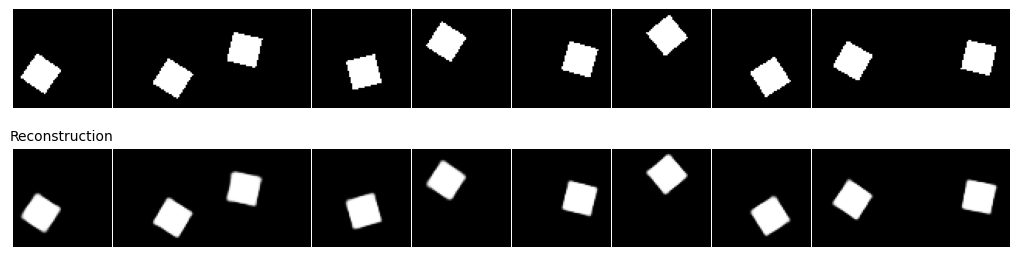

Plotting reconstructions from specific indices...


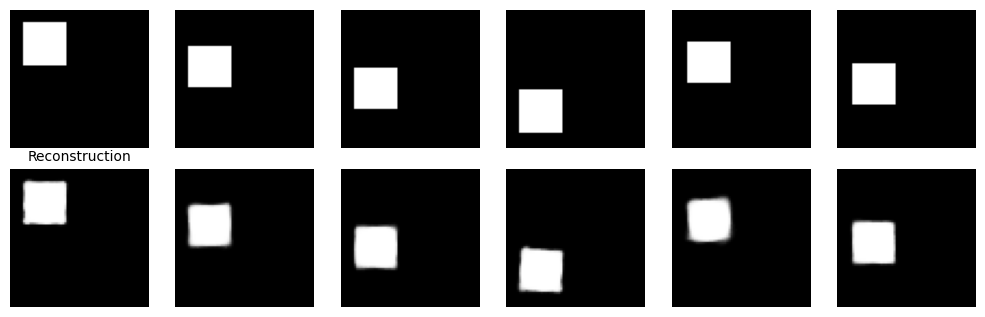

In [11]:
print("Plotting random reconstructions...")
visualizer_dsprites.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_dsprites = [0, 10, 20, 30, 40, 50]  # Example indices
visualizer_dsprites.plot_reconstructions_sub_dataset(indices_dsprites, mode='mean')
plt.show()

### Latent traversal

Plotting latent traversals...


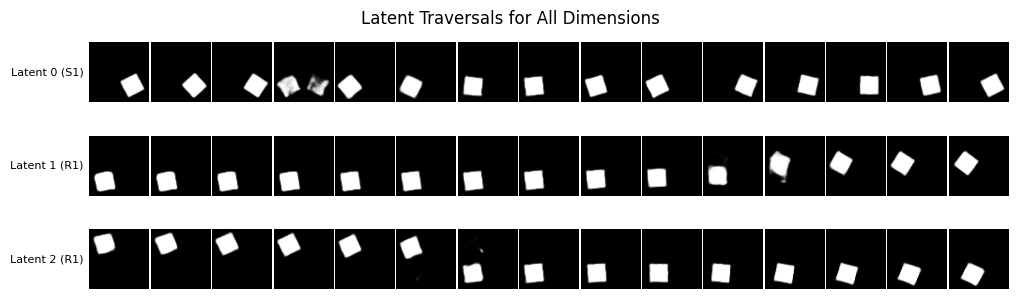

In [12]:
print("Plotting latent traversals...")
visualizer_dsprites.plot_all_latent_traversals(num_samples=15,
                                               r1_max_traversal_type='probability',
                                               r1_max_traversal=0.95,
                                               s1_max_traversal_type='fraction',
                                               s1_max_traversal=1.0,
                                               use_ref_img=True
                                               )
plt.show()

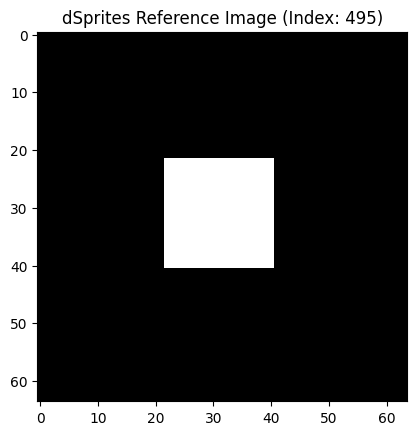

In [13]:
# Select a reference image index for dSprites
ref_img_idx_dsprites = 495  # Example index
ref_img_dsprites = dsprites_dataset[ref_img_idx_dsprites][0]

# Plot the reference image
plt.imshow(ref_img_dsprites.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title(f"dSprites Reference Image (Index: {ref_img_idx_dsprites})")
plt.show()

Plotting single latent traversal for dimension 0...


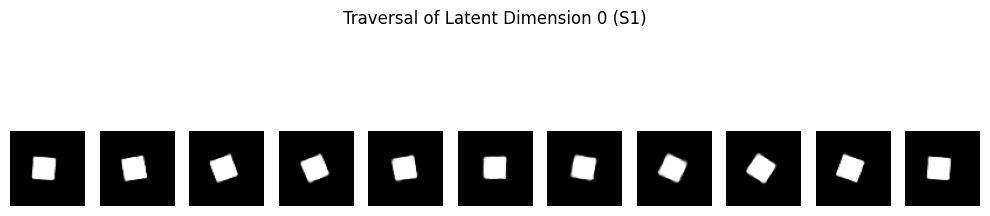

In [14]:
# Single latent traversal based on the reference image
latent_factor_idx_dsprites = 0  # Index of the latent dimension to traverse
print(f"Plotting single latent traversal for dimension {latent_factor_idx_dsprites}...")
visualizer_dsprites.plot_single_latent_traversal(latent_factor_idx_dsprites, 
                                                 ref_img=ref_img_dsprites, 
                                                 num_samples=11,
                                                 max_traversal_type='fraction',
                                                 max_traversal=1)
plt.show()

Plotting all latent traversals based on reference image...


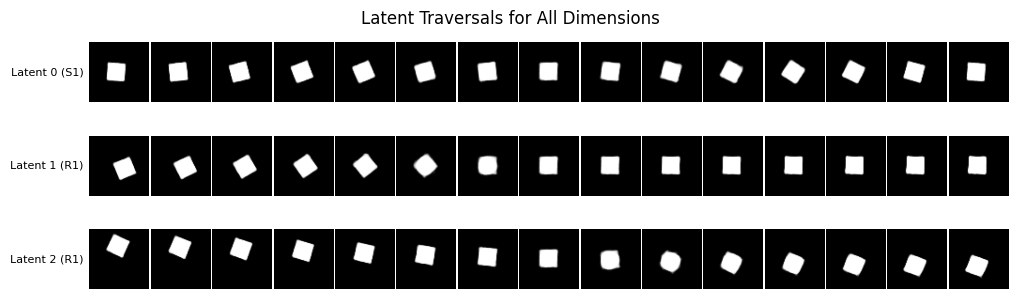

In [15]:
# All latent traversals based on the reference image
print("Plotting all latent traversals based on reference image...")
visualizer_dsprites.plot_all_latent_traversals(ref_img=ref_img_dsprites, 
                                               num_samples=15,
                                               r1_max_traversal_type='probability',
                                               r1_max_traversal=0.95,
                                               s1_max_traversal_type='fraction',
                                               s1_max_traversal=1
                                               )